## 1. Importación de librerías y configuración inicial mejorada


In [14]:
# ===== IMPORTACIÓN DE LIBRERÍAS =====

# Librerías básicas
import pandas as pd
import numpy as np
import os
import pydicom
import warnings
import yaml
import pickle
import json
from datetime import datetime
import logging
warnings.filterwarnings('ignore')

# Librerías para procesamiento de imágenes
from skimage import io, color, feature, measure, filters, segmentation
from skimage.transform import resize
import cv2

# Librerías para preprocesamiento de datos
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Librerías para balance de clases
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.utils.class_weight import compute_class_weight

# Librerías para reducción de dimensionalidad y selección de características
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import (SelectKBest, f_classif, chi2, mutual_info_classif,
                                     RFECV, SelectFromModel, VarianceThreshold)

# Librerías para modelos de machine learning
from sklearn.model_selection import (train_test_split, GridSearchCV, RandomizedSearchCV, 
                                   StratifiedKFold, cross_val_score, validation_curve)
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, VotingClassifier, StackingClassifier,
                            GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Librerías para evaluación de modelos
from sklearn.metrics import (classification_report, accuracy_score, precision_recall_fscore_support,
                           confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve,
                           f1_score, matthews_corrcoef, cohen_kappa_score)

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Librerías para medición de rendimiento
import time
import psutil
from memory_profiler import profile
import gc

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# ===== CONFIGURACIÓN CENTRALIZADA =====

CONFIG = {
    'paths': {
        'clinical_data': "./data/NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv",
        'image_metadata': "./data/metadata.csv", 
        'images_base_folder': "./data/",
        'output_folder': "./resultados/",
        'models_folder': "./modelos/",
        'plots_folder': "./graficos/"
    },
    
    'data_params': {
        'test_size': 0.25,
        'val_size': 0.15,
        'random_state': 42,
        'target_image_size': (224, 224),
        'id_columns': ['Series UID', 'Data Description URI', 'Number of Images', 'File Location', 'Data_ID_clean', 'PatientID','ID_clean', 'image_folder_pattern'],
        'target_column': 'deadstatus.event'
    },
    
    'preprocessing': {
        'handle_missing_values': True,
        'missing_threshold': 0.5,  # Eliminar columnas con >50% valores faltantes
        'imputation_strategy': {
            'numeric': 'median',  # 'mean', 'median', 'knn'
            'categorical': 'most_frequent'  # 'most_frequent', 'constant'
        },
        'scaling_method': 'standard'  # 'standard', 'robust', 'minmax'
    },
    
    'feature_extraction': {
        'extract_color_features': False,
        'extract_texture_features': True,
        'extract_shape_features': True,
        'extract_statistical_features': True,
        'color_bins': 20,
        'glcm_distances': [1, 3], #different
        'glcm_angles': [0, 90],    #different
        'lbp_radius': 3,
        'lbp_n_points': 24
    },
    
    'dimensionality_reduction': {
        'apply_pca': True,
        'pca_variance_threshold': 0.95,
        'apply_feature_selection': True,
        'feature_selection_method': 'univariate',  # 'univariate', 'rfe', 'importance'
        'n_features_to_select': 50
    },
    
    'class_balance': {
        'apply_smote': True,
        'smote_method': 'SMOTE',  # 'SMOTE', 'ADASYN', 'BorderlineSMOTE'
        'smote_k_neighbors': 5,
        'use_class_weights': True,
        'undersampling': False
    },
    
    'model_params': {
        'cv_folds': 5,
        'n_jobs': -1,
        'max_iter': 1000,
        'scoring_metric': 'f1_weighted',
        'hyperparameter_search': 'randomized',  # 'grid', 'randomized'
        'n_iter_search': 100
    },
    
    'ensemble_params': {
        'voting_types': ['hard', 'soft'],
        'auto_weights': True,
        'stacking_final_estimator': 'logistic',  # 'logistic', 'gradient_boosting'
        'stacking_cv': 5
    },
    
    'evaluation': {
        'metrics': ['accuracy', 'precision', 'recall', 'f1', 'auc', 'kappa'],
        'plot_confusion_matrix': True,
        'plot_roc_curves': True,
        'plot_precision_recall': True,
        'save_predictions': True
    },
    
    'visualization': {
        'save_plots': True,
        'plot_format': 'png',
        'dpi': 300,
        'interactive_plots': True,
        'plot_style': 'seaborn-v0_8'
    },
    
    'logging': {
        'level': 'INFO',
        'save_logs': True,
        'log_file': './multimodal_analysis.log'
    }
}

# ===== FUNCIONES DE CONFIGURACIÓN =====

def create_directories(config):
    """Crea directorios necesarios para el proyecto"""
    directories = [
        config['paths']['output_folder'],
        config['paths']['models_folder'],
        config['paths']['plots_folder']
    ]
    
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
    
    print("Directorios creados:")
    for directory in directories:
        print(f"  ✓ {directory}")

def setup_logging(config):
    """Configura el sistema de logging"""
    if config['logging']['save_logs']:
        logging.basicConfig(
            level=getattr(logging, config['logging']['level']),
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(config['logging']['log_file']),
                logging.StreamHandler()
            ]
        )
    else:
        logging.basicConfig(
            level=getattr(logging, config['logging']['level']),
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
    
    return logging.getLogger(__name__)

def save_config(config, filepath='config.yaml'):
    """Guarda la configuración en un archivo YAML"""
    with open(filepath, 'w') as f:
        yaml.dump(config, f, default_flow_style=False, indent=2)
    print(f"Configuración guardada en: {filepath}")

def load_config(filepath='config.yaml'):
    """Carga la configuración desde un archivo YAML"""
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            loaded_config = yaml.safe_load(f)
        print(f"Configuración cargada desde: {filepath}")
        return loaded_config
    else:
        print("Archivo de configuración no encontrado. Usando configuración por defecto.")
        return CONFIG

def print_config_summary(config):
    """Imprime un resumen de la configuración"""
    print("="*60)
    print("RESUMEN DE CONFIGURACIÓN")
    print("="*60)
    
    print(f"📁 Archivos:")
    print(f"  Datos clínicos: {config['paths']['clinical_data']}")
    print(f"  Metadata: {config['paths']['image_metadata']}")
    print(f"  Imágenes: {config['paths']['images_base_folder']}")
    print(f"  Resultados: {config['paths']['output_folder']}")
    
    print(f"\n📊 División de datos:")
    print(f"  Test: {config['data_params']['test_size']*100:.1f}%")
    print(f"  Validación: {config['data_params']['val_size']*100:.1f}%")
    print(f"  Entrenamiento: {(1-config['data_params']['test_size']-config['data_params']['val_size'])*100:.1f}%")
    
    print(f"\n🔧 Preprocesamiento:")
    print(f"  Balance de clases: {'✓' if config['class_balance']['apply_smote'] else '✗'}")
    print(f"  PCA: {'✓' if config['dimensionality_reduction']['apply_pca'] else '✗'}")
    print(f"  Selección de características: {'✓' if config['dimensionality_reduction']['apply_feature_selection'] else '✗'}")
    
    print(f"\n🤖 Modelos:")
    print(f"  Validación cruzada: {config['model_params']['cv_folds']} folds")
    print(f"  Búsqueda de hiperparámetros: {config['model_params']['hyperparameter_search']}")
    print(f"  Métrica de evaluación: {config['model_params']['scoring_metric']}")

# ===== INICIALIZACIÓN =====

# Crear directorios
create_directories(CONFIG)

# Configurar logging
logger = setup_logging(CONFIG)

# Guardar configuración inicial
save_config(CONFIG)

# Mostrar resumen de configuración
print_config_summary(CONFIG)

print("\n" + "="*60)
print("INICIALIZACIÓN COMPLETADA")
print("="*60)
print(f"Fecha y hora: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Configuración guardada en: config.yaml")
print(f"Logs guardados en: {CONFIG['logging']['log_file']}")


Directorios creados:
  ✓ ./resultados/
  ✓ ./modelos/
  ✓ ./graficos/
Configuración guardada en: config.yaml
RESUMEN DE CONFIGURACIÓN
📁 Archivos:
  Datos clínicos: ./data/NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv
  Metadata: ./data/metadata.csv
  Imágenes: ./data/
  Resultados: ./resultados/

📊 División de datos:
  Test: 25.0%
  Validación: 15.0%
  Entrenamiento: 60.0%

🔧 Preprocesamiento:
  Balance de clases: ✓
  PCA: ✓
  Selección de características: ✓

🤖 Modelos:
  Validación cruzada: 5 folds
  Búsqueda de hiperparámetros: randomized
  Métrica de evaluación: f1_weighted

INICIALIZACIÓN COMPLETADA
Fecha y hora: 2025-08-07 22:52:44
Configuración guardada en: config.yaml
Logs guardados en: ./multimodal_analysis.log


## 2. Carga y exploración inicial del dataset con visualizaciones avanzadas


2025-07-13 15:45:14,388 - INFO - Cargando datasets clínicos y de imágenes...


CARGA Y EXPLORACIÓN DEL DATASET
✓ Datos clínicos cargados: (422, 10)
Columnas de clinical_data: ['PatientID', 'age', 'clinical.T.Stage', 'Clinical.N.Stage', 'Clinical.M.Stage', 'Overall.Stage', 'Histology', 'gender', 'Survival.time', 'deadstatus.event']
✓ Metadatos de imágenes cargados: (1267, 4)
Columnas de image_metadata: ['Series UID', 'Data Description URI', 'Number of Images', 'File Location']
Ejemplo de 'Subject ID' en image_metadata (antes de limpiar): ['LUNG1-001', 'LUNG1-001', 'LUNG1-001']

🔍 Verificación de IDs:
Ejemplo IDs clínicos: ['LUNG1-001', 'LUNG1-002', 'LUNG1-003']
Ejemplo IDs imágenes: ['LUNG1-001', 'LUNG1-001', 'LUNG1-001']
IDs únicos clínicos: 422
IDs únicos imágenes: 422
✓ Dataset unido: (1267, 16)

📋 Información básica del dataset:
  Forma: (1267, 17)
  Memoria utilizada: 0.93 MB
  Tipos de datos:
    object: 10 columnas
    int64: 5 columnas
    float64: 2 columnas

📊 Análisis de columnas:
  Columnas disponibles: ['Series UID', 'Data Description URI', 'Number of

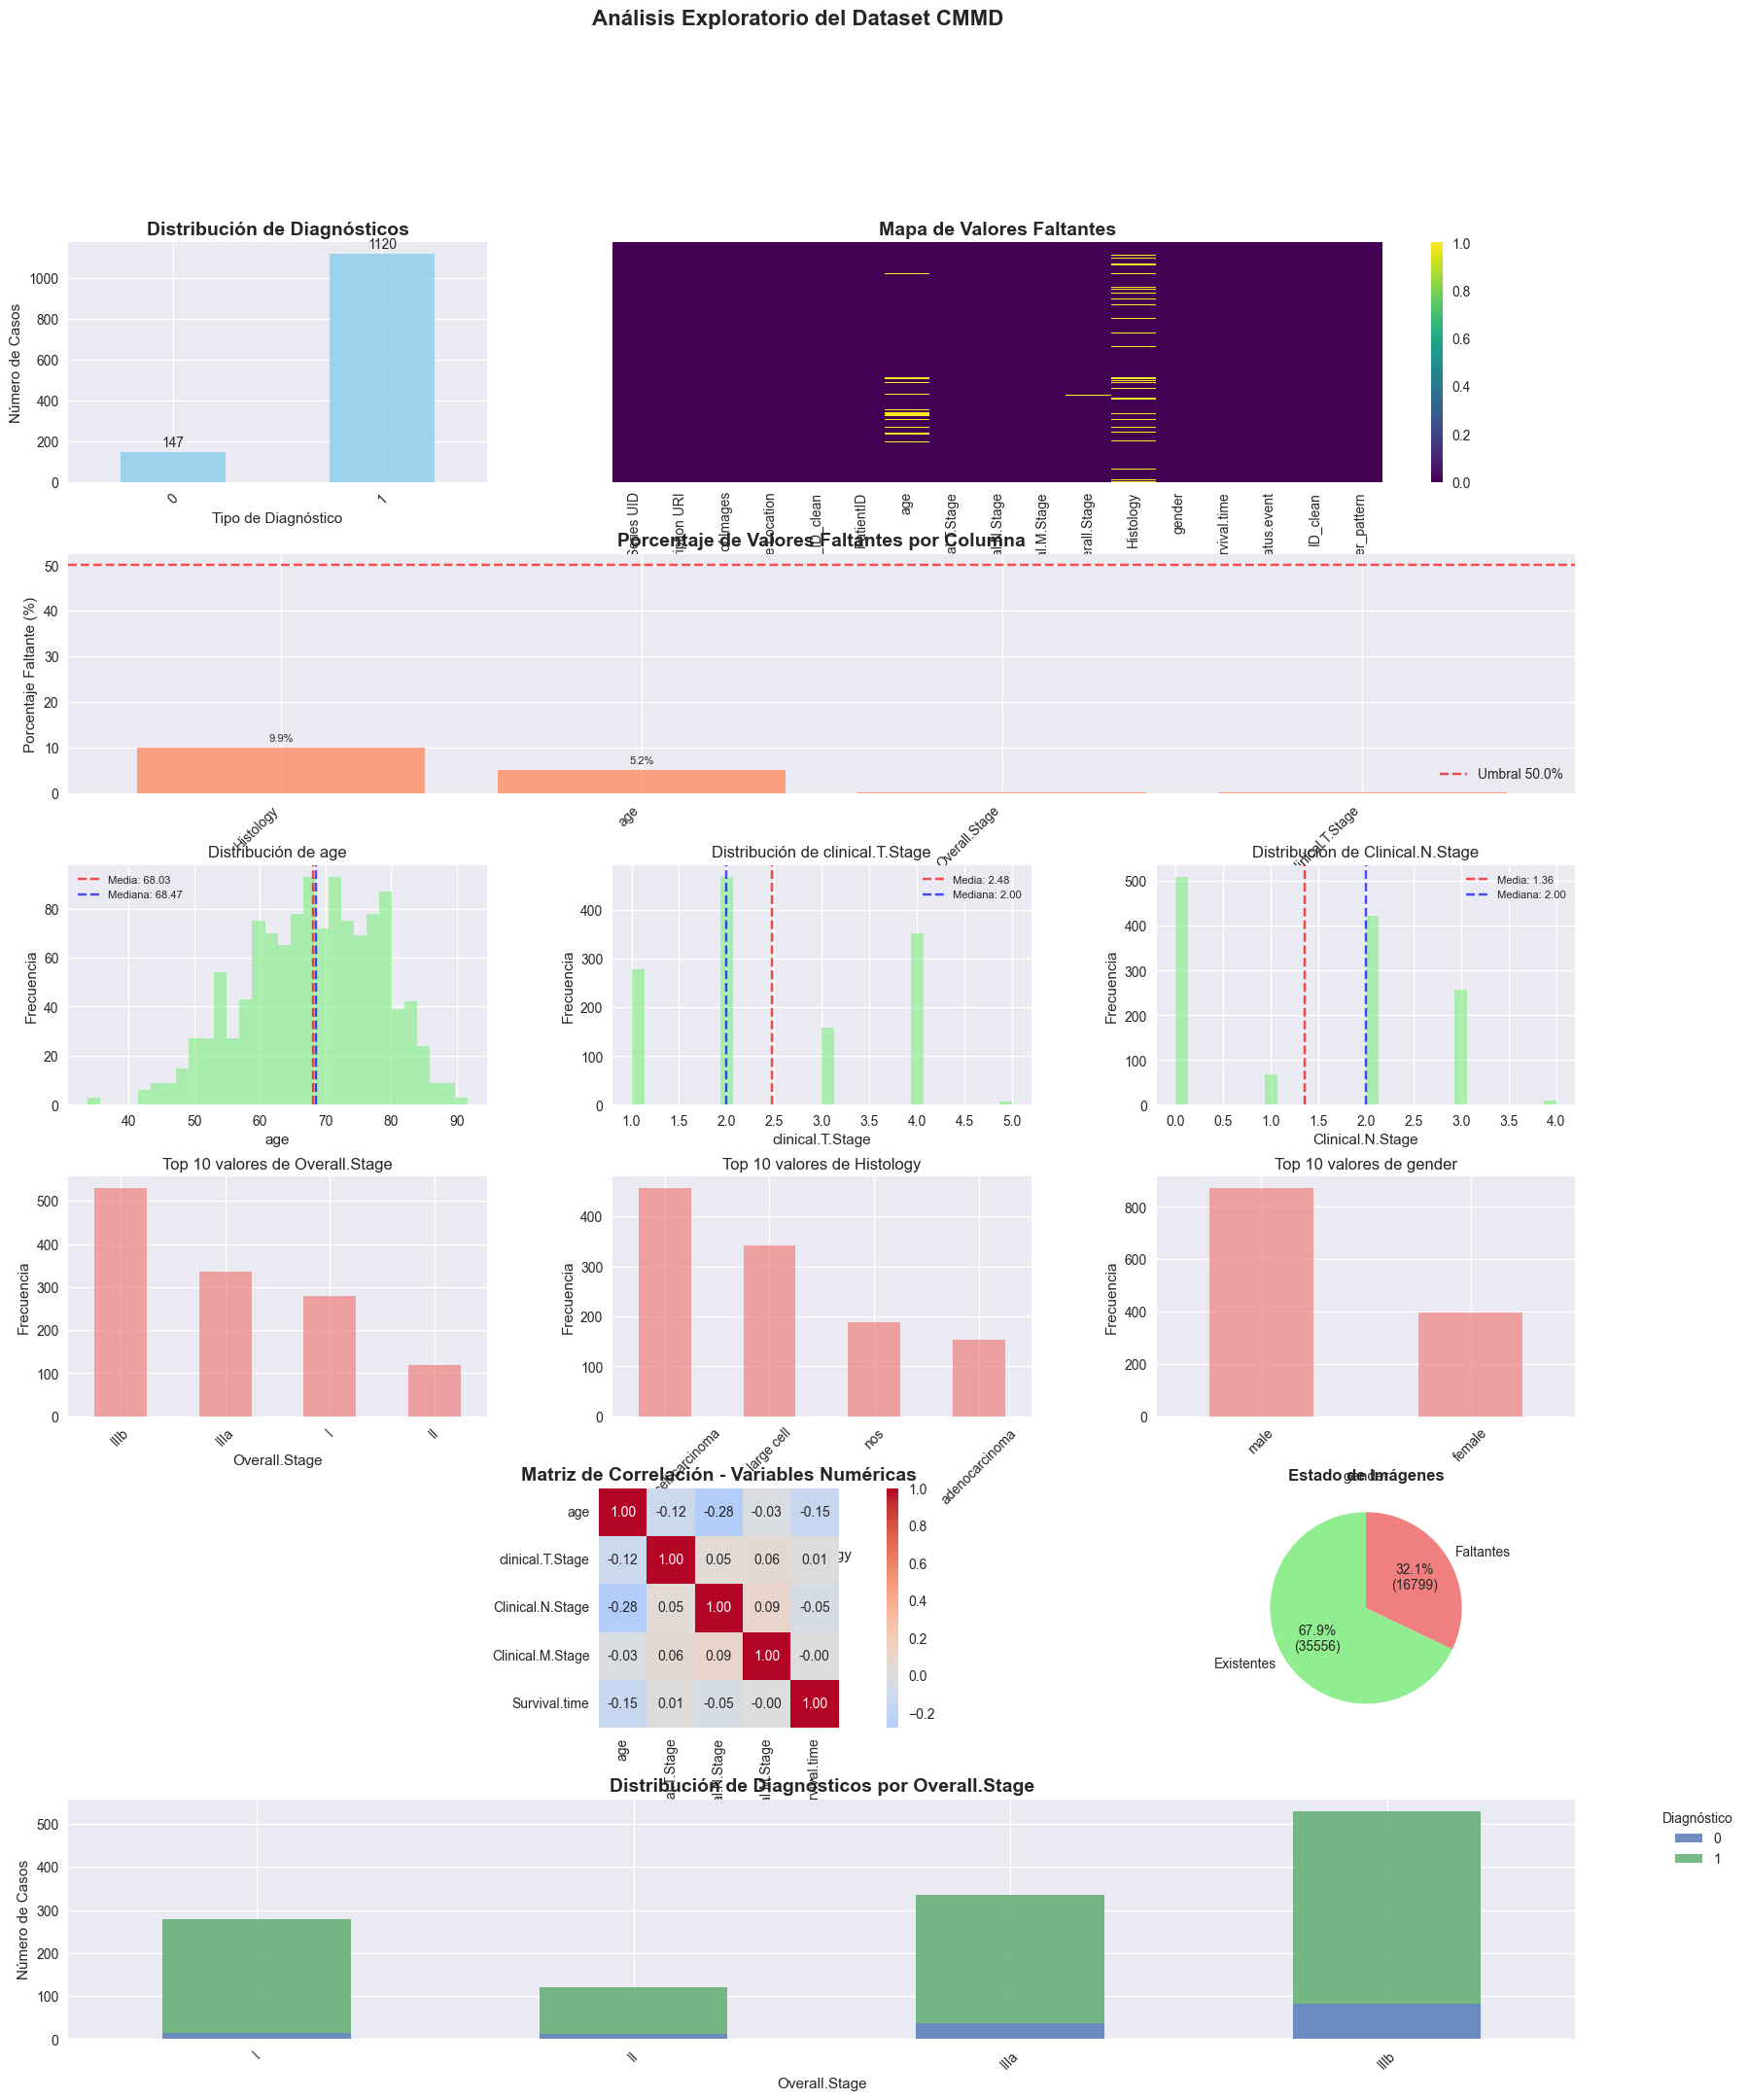


📊 Generando visualizaciones interactivas...
✓ Gráfico interactivo guardado en: ./graficos/interactive_class_distribution.html


2025-07-13 15:45:50,982 - INFO - Exploración del dataset completada exitosamente



✓ Resultados de exploración guardados en: ./resultados/exploration_results.json


In [2]:
def load_and_merge_datasets(config):
    """Carga y une los datasets clínicos y de imágenes del CMMD"""
    logger.info("Cargando datasets clínicos y de imágenes...")
    
    # Cargar datos clínicos
    clinical_data = pd.read_csv(config['paths']['clinical_data'])
    print(f"✓ Datos clínicos cargados: {clinical_data.shape}")
    print(f"Columnas de clinical_data: {clinical_data.columns.tolist()}") # Para depuración
    
    # Cargar metadatos de imágenes
    image_metadata = pd.read_csv(config['paths']['image_metadata'], 
                               usecols=['Data Description URI', 'Series UID','File Location', 'Number of Images'])
    print(f"✓ Metadatos de imágenes cargados: {image_metadata.shape}")
    print(f"Columnas de image_metadata: {image_metadata.columns.tolist()}") # Para depuración
    print(f"Ejemplo de 'Subject ID' en image_metadata (antes de limpiar): {image_metadata['Data Description URI'].head(3).tolist()}") # Para depuración
    
    
    # Limpieza y normalización de IDs
    clinical_data['ID_clean'] = clinical_data['PatientID'].str.strip().str.upper().astype(str)
    image_metadata['Data_ID_clean'] = image_metadata['Data Description URI'].str.strip().str.upper().astype(str)
    
    # Verificación de datos
    print("\n🔍 Verificación de IDs:")
    print("Ejemplo IDs clínicos:", clinical_data['ID_clean'].head(3).tolist())
    print("Ejemplo IDs imágenes:", image_metadata['Data_ID_clean'].head(3).tolist())
    print("IDs únicos clínicos:", clinical_data['ID_clean'].nunique())
    print("IDs únicos imágenes:", image_metadata['Data_ID_clean'].nunique())
    
    # Unir los datasets
    merged_df = pd.merge(
        image_metadata,
        clinical_data,
        left_on='Data_ID_clean',
        right_on='ID_clean',
        how='inner'
    )
    print(f"✓ Dataset unido: {merged_df.shape}")
    
    # Preprocesar rutas de imágenes
    # Crear columna con patrón de búsqueda de imágenes
    merged_df['image_folder_pattern'] = config['paths']['images_base_folder'] + \
    merged_df['File Location'].str.replace(r'^\.\\', '', regex=True).str.replace('\\', '/')
    
    return merged_df

# Expande las rutas de imágenes en el DataFrame
def expand_image_paths(df):
    """Convierte carpetas en rutas individuales de imágenes"""
    expanded_rows = []
    total_folders = len(df)
    
    print(f"  Procesando {total_folders} carpetas...")
    
    for idx, row in df.iterrows():
        folder_path = os.path.normpath(row['image_folder_pattern'])
        
        try:
            if os.path.exists(folder_path):
                for img_file in os.listdir(folder_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.dcm', '.dicom')):
                        new_row = row.copy()
                        new_row['image_path'] = os.path.join(folder_path, img_file)
                        expanded_rows.append(new_row)
            else:
                print(f"⚠️ Carpeta no encontrada: {folder_path}")
                
            # Mostrar progreso
            if (idx + 1) % 50 == 0 or (idx + 1) == total_folders:
                print(f"    Procesadas: {idx + 1}/{total_folders} carpetas")
                
        except Exception as e:
            print(f"⚠️ Error procesando {folder_path}: {str(e)}")
    
    return pd.DataFrame(expanded_rows)

def load_and_explore_dataset(config):
    
    print("="*60)
    print("CARGA Y EXPLORACIÓN DEL DATASET")
    print("="*60)

    
    df = load_and_merge_datasets(config)
    
    # ===== INFORMACIÓN BÁSICA =====
    print(f"\n📋 Información básica del dataset:")
    print(f"  Forma: {df.shape}")
    print(f"  Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"  Tipos de datos:")
    for dtype in df.dtypes.value_counts().items():
        print(f"    {dtype[0]}: {dtype[1]} columnas")
    
    # ===== ANÁLISIS DE COLUMNAS =====
    print(f"\n📊 Análisis de columnas:")
    print(f"  Columnas disponibles: {list(df.columns)}")

    # Expandir rutas de imágenes
    print("Expandiendo rutas de imágenes...")
    df_expanded = expand_image_paths(df)
    print(f"\n🔍 Verificación final de imágenes:")
    print(f"  Imágenes en dataset expandido: {len(df_expanded)}")
    print(f"  Imágenes únicas: {df_expanded['image_path'].nunique()}")
    print(f"  Muestra de rutas:")
    print(df_expanded['image_path'].head(3).to_string(index=False))
    
    print(f"✓ Dataset expandido: {df_expanded.shape[0]} imágenes")
    
    # Crear dataframe a nivel de paciente (elimina duplicados)
    df_patient = df.drop_duplicates(subset=['ID_clean']).copy()
    
    print(f"\n📋 Dataset a nivel de paciente: {df_patient.shape}")
    print(f"  Pacientes únicos: {df_patient['ID_clean'].nunique()}")
    
    # Identificar tipos de columnas
    id_columns = config['data_params']['id_columns']
    target_column = config['data_params']['target_column']
    
    # Validar que existen
    missing_ids = [col for col in id_columns if col not in df.columns]
    if missing_ids:
        raise ValueError(f"Columnas ID no encontradas: {missing_ids}")
    
    if target_column not in df.columns:
        raise ValueError(f"Columna target '{target_column}' no existe en el dataset")
    
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    
    # Remover columnas de ID y target de las listas
    numeric_columns = [col for col in numeric_columns if col not in id_columns + [target_column]]
    categorical_columns = [col for col in categorical_columns if col not in id_columns + [target_column]]
    
    print(f"  Columnas ID: {id_columns}")
    print(f"  Columna objetivo: {target_column}")
    print(f"  Columnas numéricas: {numeric_columns}")
    print(f"  Columnas categóricas: {categorical_columns}")
    
    # ===== ANÁLISIS DE VALORES FALTANTES =====
    print(f"\n🔍 Análisis de valores faltantes:")
    
    missing_analysis = pd.DataFrame({
        'Columna': df.columns,
        'Valores_Faltantes': df.isnull().sum(),
        'Porcentaje_Faltante': (df.isnull().sum() / len(df)) * 100,
        'Tipo_Dato': df.dtypes
    }).sort_values('Porcentaje_Faltante', ascending=False)
    
    print(missing_analysis)
    
    # Identificar columnas con muchos valores faltantes
    high_missing_cols = missing_analysis[
        missing_analysis['Porcentaje_Faltante'] > config['preprocessing']['missing_threshold'] * 100
    ]['Columna'].tolist()
    
    if high_missing_cols:
        print(f"\n⚠️  Columnas con >{config['preprocessing']['missing_threshold']*100}% valores faltantes:")
        for col in high_missing_cols:
            pct = missing_analysis[missing_analysis['Columna'] == col]['Porcentaje_Faltante'].iloc[0]
            print(f"    {col}: {pct:.1f}%")
    
    # ===== ANÁLISIS DE LA VARIABLE OBJETIVO =====
    print(f"\n🎯 Análisis de la variable objetivo '{target_column}':")
    
    target_analysis = df[target_column].value_counts().sort_index()
    target_percentages = (target_analysis / len(df)) * 100
    
    print("Distribución de clases:")
    for class_name, count in target_analysis.items():
        percentage = target_percentages[class_name]
        print(f"  {class_name}: {count} casos ({percentage:.1f}%)")
    
    # Calcular métricas de desbalance
    max_class_size = target_analysis.max()
    min_class_size = target_analysis.min()
    imbalance_ratio = max_class_size / min_class_size
    
    print(f"\nMétricas de desbalance:")
    print(f"  Clase mayoritaria: {target_analysis.idxmax()} ({max_class_size} casos)")
    print(f"  Clase minoritaria: {target_analysis.idxmin()} ({min_class_size} casos)")
    print(f"  Ratio de desbalance: {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 5:
        print("  ⚠️  Dataset significativamente desbalanceado (ratio > 5:1)")
    elif imbalance_ratio > 2:
        print("  ⚠️  Dataset moderadamente desbalanceado (ratio > 2:1)")
    else:
        print("  ✓ Dataset relativamente balanceado")
    
    # ===== ANÁLISIS ESTADÍSTICO DE VARIABLES NUMÉRICAS =====
    if numeric_columns:
        print(f"\n📈 Estadísticas descriptivas de variables numéricas:")
        numeric_stats = df[numeric_columns].describe()
        print(numeric_stats)
        
        # Detectar outliers usando IQR
        print(f"\n🔍 Detección de outliers (método IQR):")
        outlier_summary = {}
        for col in numeric_columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
            outlier_count = len(outliers)
            outlier_percentage = (outlier_count / len(df)) * 100
            
            outlier_summary[col] = {
                'count': outlier_count,
                'percentage': outlier_percentage,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
            
            print(f"  {col}: {outlier_count} outliers ({outlier_percentage:.1f}%)")
    
    # ===== ANÁLISIS DE VARIABLES CATEGÓRICAS =====
    if categorical_columns:
        print(f"\n📊 Análisis de variables categóricas:")
        categorical_summary = {}
        
        for col in categorical_columns:
            unique_values = df[col].nunique()
            most_frequent = df[col].mode().iloc[0] if not df[col].mode().empty else 'N/A'
            most_frequent_count = df[col].value_counts().iloc[0] if len(df[col].value_counts()) > 0 else 0
            most_frequent_pct = (most_frequent_count / len(df)) * 100
            
            categorical_summary[col] = {
                'unique_values': unique_values,
                'most_frequent': most_frequent,
                'most_frequent_count': most_frequent_count,
                'most_frequent_percentage': most_frequent_pct
            }
            
            print(f"  {col}:")
            print(f"    Valores únicos: {unique_values}")
            print(f"    Más frecuente: '{most_frequent}' ({most_frequent_count} casos, {most_frequent_pct:.1f}%)")
            
            # Mostrar distribución si hay pocos valores únicos
            if unique_values <= 10:
                value_counts = df[col].value_counts()
                print(f"    Distribución: {dict(value_counts)}")
    
    # ===== VERIFICACIÓN DE IMÁGENES =====
    print(f"\n🖼️  Verificación de imágenes:")

    if 'image_folder_pattern' in df.columns:
        total_series = len(df)
        total_images_expected = df['Number of Images'].sum()  # Total de imágenes esperadas
        existing_images_count = 0  # Contador de imágenes existentes
        missing_images_count = 0   # Contador de imágenes faltantes
        problematic_series = []
    
        print(f"Verificando {total_series} series con {total_images_expected} imágenes esperadas...")

        for idx, row in df.iterrows():
            folder_path = row['image_folder_pattern']
            expected = row['Number of Images']
            try:
                if os.path.exists(folder_path):
                    # Contar imágenes reales en la carpeta
                    image_files = [
                        f for f in os.listdir(folder_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.dcm'))
                    ]
                    actual = len(image_files)
                    
                    existing_images_count += actual
                    missing_in_series = max(0, expected - actual)
                    missing_images_count += missing_in_series
                    
                    if actual != expected:
                        problematic_series.append({
                            'series': row['Series UID'],
                            'folder': folder_path,
                            'expected': expected,
                            'found': actual,
                            'status': 'INCOMPLETA'
                        })
                else:
                    missing_images_count += expected
                    problematic_series.append({
                        'series': row['Series UID'],
                        'folder': folder_path,
                        'expected': expected,
                        'found': 0,
                        'status': 'NO ENCONTRADA'
                    })
                # Mostrar progreso cada 50 series
                if (idx + 1) % 50 == 0 or (idx + 1) == total_series:
                    print(f"  Verificadas: {idx + 1}/{total_series} series")
            except Exception as e:
                print(f"⚠️ Error verificando {folder_path}: {str(e)}")
                missing_images_count += expected
                problematic_series.append({
                    'series': row['Series UID'],
                    'folder': folder_path,
                    'expected': expected,
                    'found': 0,
                    'status': 'ERROR'
                })
        # Resultados
        print(f"\nResultados de verificación:")
        print(f"  Series totales: {total_series}")
        print(f"  Series completas: {total_series - len(problematic_series)}")
        print(f"  Series con imágenes faltantes: {len(problematic_series)}")
        print(f"  Imágenes esperadas: {total_images_expected}")
        print(f"  Imágenes existentes: {existing_images_count} ({existing_images_count/total_images_expected*100:.1f}%)")
        print(f"  Imágenes faltantes: {missing_images_count} ({missing_images_count/total_images_expected*100:.1f}%)")
        
        if problematic_series:
            print(f"\n⚠️  Primeras 3 series con problemas:")
            for series in problematic_series[:3]: 
                print(f"  - Serie {series['series']}:")
                print(f"      Carpeta: {series['folder']}")
                print(f"      Imágenes esperadas: {series['expected']}")
                print(f"      Imágenes encontradas: {series['found']}")
    else:
        print("  ⚠️  Columna 'image_folder_pattern' no encontrada en el dataset")
    
    # ===== CREAR VISUALIZACIONES AVANZADAS =====
    print(f"\n📊 Generando visualizaciones...")
    
    # Configurar el estilo de las visualizaciones
    plt.style.use(config['visualization']['plot_style'])
    
    # Crear figura principal con múltiples subplots
    fig = plt.figure(figsize=(20, 24))
    gs = fig.add_gridspec(6, 3, hspace=0.3, wspace=0.3)
    
    # 1. Distribución de clases
    ax1 = fig.add_subplot(gs[0, 0])
    target_analysis.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.8)
    ax1.set_title('Distribución de Diagnósticos', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Tipo de Diagnóstico')
    ax1.set_ylabel('Número de Casos')
    ax1.tick_params(axis='x', rotation=45)
    
    # Añadir etiquetas de valores
    for i, v in enumerate(target_analysis.values):
        ax1.text(i, v + max(target_analysis.values)*0.01, str(v), ha='center', va='bottom')
    
    # 2. Mapa de calor de valores faltantes
    ax2 = fig.add_subplot(gs[0, 1:])
    missing_matrix = df.isnull()
    sns.heatmap(missing_matrix, cbar=True, yticklabels=False, cmap='viridis', ax=ax2)
    ax2.set_title('Mapa de Valores Faltantes', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Columnas')
    
    # 3. Porcentaje de valores faltantes por columna
    ax3 = fig.add_subplot(gs[1, :])
    missing_pct = missing_analysis[missing_analysis['Porcentaje_Faltante'] > 0]
    if not missing_pct.empty:
        bars = ax3.bar(range(len(missing_pct)), missing_pct['Porcentaje_Faltante'], 
                      color='coral', alpha=0.7)
        ax3.set_title('Porcentaje de Valores Faltantes por Columna', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Columnas')
        ax3.set_ylabel('Porcentaje Faltante (%)')
        ax3.set_xticks(range(len(missing_pct)))
        ax3.set_xticklabels(missing_pct['Columna'], rotation=45, ha='right')
        
        # Línea de umbral
        ax3.axhline(y=config['preprocessing']['missing_threshold']*100, 
                   color='red', linestyle='--', alpha=0.7, 
                   label=f'Umbral {config["preprocessing"]["missing_threshold"]*100}%')
        ax3.legend()
        
        # Añadir etiquetas de valores
        for bar, value in zip(bars, missing_pct['Porcentaje_Faltante']):
            if value > 5:  # Solo mostrar etiquetas para valores > 5%
                ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                        f'{value:.1f}%', ha='center', va='bottom', fontsize=8)
    
    # 4-6. Distribuciones de variables numéricas (si existen)
    if numeric_columns:
        for i, col in enumerate(numeric_columns[:3]):  # Mostrar máximo 3 columnas
            ax = fig.add_subplot(gs[2, i])
            df[col].hist(bins=30, ax=ax, alpha=0.7, color='lightgreen')
            ax.set_title(f'Distribución de {col}', fontsize=12)
            ax.set_xlabel(col)
            ax.set_ylabel('Frecuencia')
            
            # Añadir estadísticas
            mean_val = df[col].mean()
            median_val = df[col].median()
            ax.axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Media: {mean_val:.2f}')
            ax.axvline(median_val, color='blue', linestyle='--', alpha=0.7, label=f'Mediana: {median_val:.2f}')
            ax.legend(fontsize=8)
    
    # 7-9. Distribuciones de variables categóricas (si existen)
    if categorical_columns:
        for i, col in enumerate(categorical_columns[:3]):  # Mostrar máximo 3 columnas
            ax = fig.add_subplot(gs[3, i])
            value_counts = df[col].value_counts().head(10)  # Top 10 valores
            value_counts.plot(kind='bar', ax=ax, color='lightcoral', alpha=0.7)
            ax.set_title(f'Top 10 valores de {col}', fontsize=12)
            ax.set_xlabel(col)
            ax.set_ylabel('Frecuencia')
            ax.tick_params(axis='x', rotation=45)
    
    # 10. Correlación entre variables numéricas
    if len(numeric_columns) > 1:
        ax10 = fig.add_subplot(gs[4, :2])
        correlation_matrix = df[numeric_columns].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                   square=True, ax=ax10, fmt='.2f')
        ax10.set_title('Matriz de Correlación - Variables Numéricas', fontsize=14, fontweight='bold')
    
    # 11. Resumen de verificación de imágenes
    ax11 = fig.add_subplot(gs[4, 2])
    if total_images_expected > 0:
        image_status = ['Existentes', 'Faltantes']
        image_counts = [existing_images_count, missing_images_count]
        colors = ['lightgreen', 'lightcoral']
        
        wedges, texts, autotexts = ax11.pie(
            image_counts, 
            labels=image_status, 
            colors=colors, 
            autopct=lambda p: f'{p:.1f}%\n({int(p*total_images_expected/100)})',
            startangle=90
        )
        ax11.set_title('Estado de Imágenes', fontsize=12, fontweight='bold')
    else:
        ax11.text(0.5, 0.5, 'No hay imágenes para verificar', 
                ha='center', va='center', fontsize=12)
        ax11.set_title('Estado de Imágenes', fontsize=12, fontweight='bold')
        
    # 12. Distribución de clases por variable categórica (ejemplo con la primera)
    if categorical_columns and target_column in df.columns:
        ax12 = fig.add_subplot(gs[5, :])
        first_cat_col = categorical_columns[0]
        
        # Crear tabla cruzada
        crosstab = pd.crosstab(df[first_cat_col], df[target_column])
        crosstab_pct = pd.crosstab(df[first_cat_col], df[target_column], normalize='index') * 100
        
        # Gráfico de barras apiladas
        crosstab.plot(kind='bar', stacked=True, ax=ax12, alpha=0.8)
        ax12.set_title(f'Distribución de Diagnósticos por {first_cat_col}', fontsize=14, fontweight='bold')
        ax12.set_xlabel(first_cat_col)
        ax12.set_ylabel('Número de Casos')
        ax12.tick_params(axis='x', rotation=45)
        ax12.legend(title='Diagnóstico', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Guardar la figura
    plt.suptitle('Análisis Exploratorio del Dataset CMMD', fontsize=16, fontweight='bold', y=0.98)
    
    if config['visualization']['save_plots']:
        plot_path = os.path.join(config['paths']['plots_folder'], 
                                f'exploratory_analysis.{config["visualization"]["plot_format"]}')
        plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
        print(f"✓ Visualización guardada en: {plot_path}")
    
    plt.show()
    
    # ===== CREAR VISUALIZACIONES INTERACTIVAS (PLOTLY) =====
    if config['visualization']['interactive_plots']:
        print(f"\n📊 Generando visualizaciones interactivas...")
        
        # Gráfico interactivo de distribución de clases
        fig_interactive = px.bar(
            x=target_analysis.index, 
            y=target_analysis.values,
            title='Distribución Interactiva de Diagnósticos',
            labels={'x': 'Tipo de Diagnóstico', 'y': 'Número de Casos'},
            color=target_analysis.values,
            color_continuous_scale='viridis'
        )
        
        fig_interactive.update_layout(
            showlegend=False,
            title_font_size=16,
            xaxis_title_font_size=14,
            yaxis_title_font_size=14
        )
        
        # Guardar gráfico interactivo
        if config['visualization']['save_plots']:
            interactive_path = os.path.join(config['paths']['plots_folder'], 
                                          'interactive_class_distribution.html')
            fig_interactive.write_html(interactive_path)
            print(f"✓ Gráfico interactivo guardado en: {interactive_path}")
        
        fig_interactive.show()
    
    # ===== COMPILAR RESULTADOS DE EXPLORACIÓN =====
    exploration_results = {
        'dataset_shape': df.shape,
        'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024**2,
        'column_types': {
            'id_columns': id_columns,
            'target_column': target_column,
            'numeric_columns': numeric_columns,
            'categorical_columns': categorical_columns
        },
        'missing_analysis': missing_analysis.to_dict('records'),
        'high_missing_columns': high_missing_cols,
        'target_analysis': {
            'distribution': target_analysis.to_dict(),
            'percentages': target_percentages.to_dict(),
            'imbalance_ratio': imbalance_ratio,
            'majority_class': target_analysis.idxmax(),
            'minority_class': target_analysis.idxmin()
        },
        'numeric_stats': numeric_stats.to_dict() if numeric_columns else {},
        'outlier_summary': outlier_summary if numeric_columns else {},
        'categorical_summary': categorical_summary if categorical_columns else {},
        'image_verification': {
            'total_in_metadata': len(df),
            'total_series': total_series,
            'total_images_expected': total_images_expected,
            'existing_images': existing_images_count,
            'missing_images': missing_images_count,
            'completeness_percentage': (existing_images_count / total_images_expected * 100) if total_images_expected > 0 else 0
        }
    }
    
    # Guardar resultados de exploración
    exploration_path = os.path.join(config['paths']['output_folder'], 'exploration_results.json')
    with open(exploration_path, 'w') as f:
        json.dump(exploration_results, f, indent=2, default=str)
    
    print(f"\n✓ Resultados de exploración guardados en: {exploration_path}")
    
    logger.info("Exploración del dataset completada exitosamente")
    
    return df_expanded, df_patient, exploration_results

# ===== EJECUTAR EXPLORACIÓN =====
df_expanded, df_patient, exploration_results = load_and_explore_dataset(CONFIG)

## 3. Preprocesamiento de datos clínicos con manejo robusto de valores faltantes


2025-07-13 15:45:54,543 - INFO - Iniciando preprocesamiento de datos clínicos


PREPROCESAMIENTO ROBUSTO DE DATOS CLÍNICOS
📋 Información inicial:
  Filas: 422
  Columnas totales: 17
  Columnas numéricas: 5
  Columnas categóricas: 3
  Columnas con muchos faltantes: 0

🎯 Separando características y etiquetas...
  Características clínicas: 8 columnas
  Muestras: 422

🏷️  Codificando etiquetas...
  Mapeo de clases: {0: 0, 1: 1}

🔍 Análisis detallado de valores faltantes en características:
                           Columna  Valores_Faltantes  Porcentaje_Faltante  \
Histology                Histology                 42             9.952607   
age                            age                 22             5.213270   
clinical.T.Stage  clinical.T.Stage                  1             0.236967   
Overall.Stage        Overall.Stage                  1             0.236967   

                 Tipo_Dato  
Histology           object  
age                float64  
clinical.T.Stage   float64  
Overall.Stage       object  

🔧 Aplicando estrategias de imputación...
  Columnas 

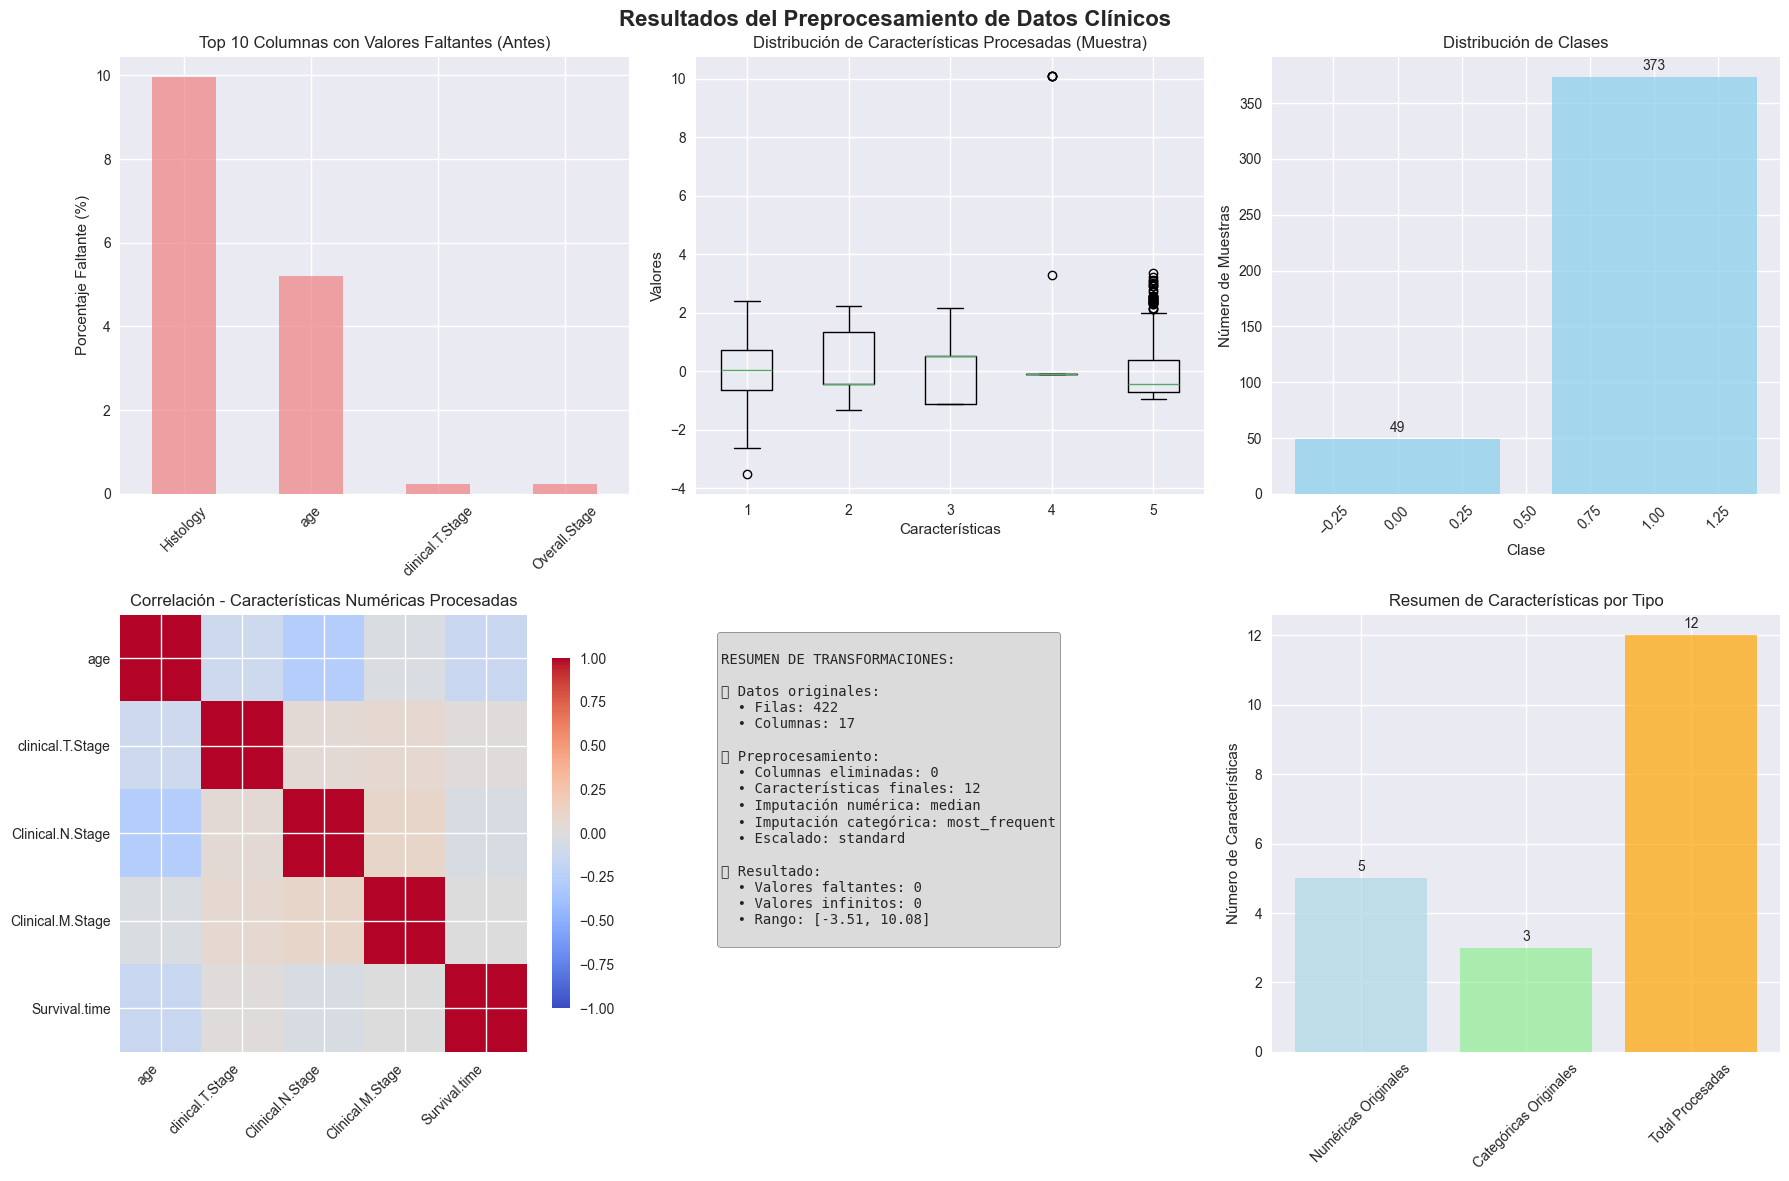

2025-07-13 15:45:58,199 - INFO - Preprocesamiento de datos clínicos completado exitosamente



✓ Resultados de preprocesamiento guardados en: ./resultados/preprocessing_results.pkl


In [3]:
def preprocess_clinical_data_robust(df, exploration_results, config):
    """
    Preprocesamiento robusto de datos clínicos con manejo avanzado de valores faltantes
    
    Args:
        df: DataFrame original
        exploration_results: Resultados de la exploración
        config: Configuración del proyecto
    
    Returns:
        preprocessing_results: Diccionario con datos procesados y metadatos
    """
    
    print("="*60)
    print("PREPROCESAMIENTO ROBUSTO DE DATOS CLÍNICOS")
    print("="*60)
    
    logger.info("Iniciando preprocesamiento de datos clínicos")
    
    # ===== PREPARACIÓN INICIAL =====
    df_processed = df.copy()
    
    # Obtener información de columnas desde exploration_results
    id_columns = exploration_results['column_types']['id_columns']
    target_column = exploration_results['column_types']['target_column']
    numeric_columns = exploration_results['column_types']['numeric_columns']
    categorical_columns = exploration_results['column_types']['categorical_columns']
    high_missing_columns = exploration_results['high_missing_columns']
    
    print(f"📋 Información inicial:")
    print(f"  Filas: {len(df_processed)}")
    print(f"  Columnas totales: {len(df_processed.columns)}")
    print(f"  Columnas numéricas: {len(numeric_columns)}")
    print(f"  Columnas categóricas: {len(categorical_columns)}")
    print(f"  Columnas con muchos faltantes: {len(high_missing_columns)}")
    
    # ===== MANEJO DE COLUMNAS CON MUCHOS VALORES FALTANTES =====
    columns_to_drop = []
    
    if high_missing_columns and config['preprocessing']['handle_missing_values']:
        print(f"\n🗑️  Evaluando columnas con >{config['preprocessing']['missing_threshold']*100}% valores faltantes:")
        
        for col in high_missing_columns:
            missing_pct = (df_processed[col].isnull().sum() / len(df_processed)) * 100
            print(f"  {col}: {missing_pct:.1f}% faltantes")
            
            # Decidir si eliminar la columna
            if missing_pct > config['preprocessing']['missing_threshold'] * 100:
                columns_to_drop.append(col)
                print(f"    → Marcada para eliminación")
            else:
                print(f"    → Conservada")
        
        if columns_to_drop:
            print(f"\n🗑️  Eliminando {len(columns_to_drop)} columnas:")
            for col in columns_to_drop:
                print(f"    - {col}")
            
            df_processed = df_processed.drop(columns=columns_to_drop)
            
            # Actualizar listas de columnas
            numeric_columns = [col for col in numeric_columns if col not in columns_to_drop]
            categorical_columns = [col for col in categorical_columns if col not in columns_to_drop]
    
    # ===== SEPARAR CARACTERÍSTICAS Y ETIQUETAS =====
    print(f"\n🎯 Separando características y etiquetas...")
    
    # Columnas a excluir de las características
    columns_to_exclude = id_columns + [target_column]
    feature_columns = [col for col in df_processed.columns if col not in columns_to_exclude]
    
    X_clinical = df_processed[feature_columns].copy()
    y_clinical = df_processed[target_column].copy()
    
    print(f"  Características clínicas: {X_clinical.shape[1]} columnas")
    print(f"  Muestras: {len(y_clinical)}")
    
    # ===== CODIFICACIÓN DE ETIQUETAS =====
    print(f"\n🏷️  Codificando etiquetas...")
    
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_clinical)
    
    class_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
    print(f"  Mapeo de clases: {class_mapping}")
    
    # ===== ANÁLISIS DETALLADO DE VALORES FALTANTES =====
    print(f"\n🔍 Análisis detallado de valores faltantes en características:")
    
    missing_analysis_features = pd.DataFrame({
        'Columna': X_clinical.columns,
        'Valores_Faltantes': X_clinical.isnull().sum(),
        'Porcentaje_Faltante': (X_clinical.isnull().sum() / len(X_clinical)) * 100,
        'Tipo_Dato': X_clinical.dtypes
    }).sort_values('Porcentaje_Faltante', ascending=False)
    
    print(missing_analysis_features[missing_analysis_features['Valores_Faltantes'] > 0])
    
    # ===== ESTRATEGIAS DE IMPUTACIÓN AVANZADAS =====
    print(f"\n🔧 Aplicando estrategias de imputación...")
    
    # Actualizar listas de columnas después de eliminar columnas
    numeric_features_final = [col for col in numeric_columns if col in X_clinical.columns]
    categorical_features_final = [col for col in categorical_columns if col in X_clinical.columns]
    
    print(f"  Columnas numéricas finales: {len(numeric_features_final)}")
    print(f"  Columnas categóricas finales: {len(categorical_features_final)}")
    
    # ===== PIPELINE DE PREPROCESAMIENTO PARA VARIABLES NUMÉRICAS =====
    if numeric_features_final:
        print(f"\n📊 Configurando pipeline para variables numéricas...")
        
        # Seleccionar estrategia de imputación
        if config['preprocessing']['imputation_strategy']['numeric'] == 'knn':
            numeric_imputer = KNNImputer(n_neighbors=5)
            print(f"    Imputación: KNN (k=5)")
        else:
            numeric_imputer = SimpleImputer(strategy=config['preprocessing']['imputation_strategy']['numeric'])
            print(f"    Imputación: {config['preprocessing']['imputation_strategy']['numeric']}")
        
        # Seleccionar método de escalado
        if config['preprocessing']['scaling_method'] == 'robust':
            scaler = RobustScaler()
            print(f"    Escalado: Robust (resistente a outliers)")
        elif config['preprocessing']['scaling_method'] == 'minmax':
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
            print(f"    Escalado: MinMax (0-1)")
        else:
            scaler = StandardScaler()
            print(f"    Escalado: Standard (z-score)")
        
        numeric_transformer = Pipeline(steps=[
            ('imputer', numeric_imputer),
            ('scaler', scaler)
        ])
    else:
        numeric_transformer = None
        print(f"    No hay variables numéricas para procesar")
    
    # ===== PIPELINE DE PREPROCESAMIENTO PARA VARIABLES CATEGÓRICAS =====
    if categorical_features_final:
        print(f"\n📊 Configurando pipeline para variables categóricas...")
        
        categorical_imputer = SimpleImputer(
            strategy=config['preprocessing']['imputation_strategy']['categorical'],
            fill_value='desconocido' if config['preprocessing']['imputation_strategy']['categorical'] == 'constant' else None
        )
        
        print(f"    Imputación: {config['preprocessing']['imputation_strategy']['categorical']}")
        print(f"    Codificación: One-Hot Encoding")
        
        categorical_transformer = Pipeline(steps=[
            ('imputer', categorical_imputer),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
        ])
    else:
        categorical_transformer = None
        print(f"    No hay variables categóricas para procesar")
    
    # ===== COMBINAR TRANSFORMADORES =====
    print(f"\n🔗 Combinando transformadores...")
    
    transformers = []
    if numeric_transformer is not None:
        transformers.append(('num', numeric_transformer, numeric_features_final))
    if categorical_transformer is not None:
        transformers.append(('cat', categorical_transformer, categorical_features_final))
    
    if transformers:
        preprocessor = ColumnTransformer(transformers=transformers)
        
        # Aplicar preprocesamiento
        print(f"    Aplicando transformaciones...")
        X_processed = preprocessor.fit_transform(X_clinical)
        
        print(f"    Forma después del preprocesamiento: {X_processed.shape}")
        
        # ===== OBTENER NOMBRES DE CARACTERÍSTICAS =====
        feature_names = []
        
        # Nombres de características numéricas
        if numeric_transformer is not None:
            feature_names.extend(numeric_features_final)
        
        # Nombres de características categóricas (después de one-hot encoding)
        if categorical_transformer is not None:
            try:
                # Para versiones más recientes de sklearn
                cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features_final)
            except AttributeError:
                # Para versiones más antiguas de sklearn
                cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names(categorical_features_final)
            
            feature_names.extend(cat_feature_names)
        
        print(f"    Características finales: {len(feature_names)}")
        
        # ===== VERIFICAR CALIDAD DEL PREPROCESAMIENTO =====
        print(f"\n✅ Verificación de calidad:")
        
        # Verificar que no hay valores faltantes
        if hasattr(X_processed, 'toarray'):  # Si es una matriz sparse
            X_processed_dense = X_processed.toarray()
        else:
            X_processed_dense = X_processed
        
        nan_count = np.isnan(X_processed_dense).sum()
        inf_count = np.isinf(X_processed_dense).sum()
        
        print(f"    Valores NaN después del preprocesamiento: {nan_count}")
        print(f"    Valores infinitos después del preprocesamiento: {inf_count}")
        
        if nan_count == 0 and inf_count == 0:
            print(f"    ✓ Preprocesamiento exitoso - No hay valores problemáticos")
        else:
            print(f"    ⚠️  Advertencia: Hay valores problemáticos después del preprocesamiento")
        
        # Estadísticas básicas
        print(f"    Rango de valores: [{X_processed_dense.min():.3f}, {X_processed_dense.max():.3f}]")
        print(f"    Media: {X_processed_dense.mean():.3f}")
        print(f"    Desviación estándar: {X_processed_dense.std():.3f}")
        
    else:
        raise ValueError("No hay características válidas para procesar")
    
    # ===== CREAR VISUALIZACIÓN DEL PREPROCESAMIENTO =====
    print(f"\n📊 Generando visualización del preprocesamiento...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Resultados del Preprocesamiento de Datos Clínicos', fontsize=16, fontweight='bold')
    
    # 1. Comparación de valores faltantes antes y después
    ax1 = axes[0, 0]
    missing_before = (df[feature_columns].isnull().sum() / len(df)) * 100
    missing_before = missing_before[missing_before > 0].sort_values(ascending=False)
    
    if len(missing_before) > 0:
        missing_before.head(10).plot(kind='bar', ax=ax1, color='lightcoral', alpha=0.7)
        ax1.set_title('Top 10 Columnas con Valores Faltantes (Antes)')
        ax1.set_ylabel('Porcentaje Faltante (%)')
        ax1.tick_params(axis='x', rotation=45)
    else:
        ax1.text(0.5, 0.5, 'No hay valores faltantes', ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Valores Faltantes (Antes)')
    
    # 2. Distribución de características después del preprocesamiento (muestra)
    ax2 = axes[0, 1]
    if X_processed.shape[1] > 0:
        # Mostrar distribución de las primeras 5 características
        sample_features = X_processed_dense[:, :min(5, X_processed.shape[1])]
        ax2.boxplot(sample_features)
        ax2.set_title('Distribución de Características Procesadas (Muestra)')
        ax2.set_xlabel('Características')
        ax2.set_ylabel('Valores')
    
    # 3. Distribución de clases
    ax3 = axes[0, 2]
    unique_classes, class_counts = np.unique(y_encoded, return_counts=True)
    class_names = [label_encoder.classes_[i] for i in unique_classes]
    
    bars = ax3.bar(class_names, class_counts, color='skyblue', alpha=0.7)
    ax3.set_title('Distribución de Clases')
    ax3.set_xlabel('Clase')
    ax3.set_ylabel('Número de Muestras')
    ax3.tick_params(axis='x', rotation=45)
    
    # Añadir etiquetas de valores
    for bar, count in zip(bars, class_counts):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(class_counts)*0.01, 
                str(count), ha='center', va='bottom')
    
    # 4. Matriz de correlación de características numéricas procesadas
    ax4 = axes[1, 0]
    if len(numeric_features_final) > 1:
        # Obtener solo las características numéricas procesadas
        num_features_processed = X_processed_dense[:, :len(numeric_features_final)]
        corr_matrix = np.corrcoef(num_features_processed.T)
        
        im = ax4.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        ax4.set_title('Correlación - Características Numéricas Procesadas')
        ax4.set_xticks(range(len(numeric_features_final)))
        ax4.set_yticks(range(len(numeric_features_final)))
        ax4.set_xticklabels(numeric_features_final, rotation=45, ha='right')
        ax4.set_yticklabels(numeric_features_final)
        
        # Añadir colorbar
        plt.colorbar(im, ax=ax4, shrink=0.8)
    else:
        ax4.text(0.5, 0.5, 'Insuficientes características\nnuméricas para correlación', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Correlación - Características Numéricas')
    
    # 5. Resumen de transformaciones aplicadas
    ax5 = axes[1, 1]
    ax5.axis('off')
    
    summary_text = f"""
RESUMEN DE TRANSFORMACIONES:

📊 Datos originales:
  • Filas: {len(df)}
  • Columnas: {len(df.columns)}

🔧 Preprocesamiento:
  • Columnas eliminadas: {len(columns_to_drop)}
  • Características finales: {X_processed.shape[1]}
  • Imputación numérica: {config['preprocessing']['imputation_strategy']['numeric']}
  • Imputación categórica: {config['preprocessing']['imputation_strategy']['categorical']}
  • Escalado: {config['preprocessing']['scaling_method']}

✅ Resultado:
  • Valores faltantes: {nan_count}
  • Valores infinitos: {inf_count}
  • Rango: [{X_processed_dense.min():.2f}, {X_processed_dense.max():.2f}]
    """
    
    ax5.text(0.05, 0.95, summary_text, transform=ax5.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    # 6. Estadísticas de características por tipo
    ax6 = axes[1, 2]
    
    feature_type_counts = {
        'Numéricas Originales': len(numeric_features_final),
        'Categóricas Originales': len(categorical_features_final),
        'Total Procesadas': X_processed.shape[1]
    }
    
    bars = ax6.bar(feature_type_counts.keys(), feature_type_counts.values(), 
                  color=['lightblue', 'lightgreen', 'orange'], alpha=0.7)
    ax6.set_title('Resumen de Características por Tipo')
    ax6.set_ylabel('Número de Características')
    ax6.tick_params(axis='x', rotation=45)
    
    # Añadir etiquetas de valores
    for bar, count in zip(bars, feature_type_counts.values()):
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(feature_type_counts.values())*0.01, 
                str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    
    # Guardar visualización
    if config['visualization']['save_plots']:
        plot_path = os.path.join(config['paths']['plots_folder'], 
                                f'preprocessing_results.{config["visualization"]["plot_format"]}')
        plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
        print(f"✓ Visualización guardada en: {plot_path}")
    
    plt.show()
    
    # ===== COMPILAR RESULTADOS =====
    preprocessing_results = {
        'X_processed': X_processed,
        'y_encoded': y_encoded,
        'feature_names': feature_names,
        'label_encoder': label_encoder,
        'preprocessor': preprocessor,
        'class_mapping': class_mapping,
        'processing_summary': {
            'original_shape': df.shape,
            'processed_shape': X_processed.shape,
            'columns_dropped': columns_to_drop,
            'numeric_features': numeric_features_final,
            'categorical_features': categorical_features_final,
            'nan_count_after': int(nan_count),
            'inf_count_after': int(inf_count),
            'value_range': [float(X_processed_dense.min()), float(X_processed_dense.max())],
            'mean_value': float(X_processed_dense.mean()),
            'std_value': float(X_processed_dense.std())
        }
    }
    
    # Guardar resultados de preprocesamiento
    preprocessing_path = os.path.join(config['paths']['output_folder'], 'preprocessing_results.pkl')
    with open(preprocessing_path, 'wb') as f:
        pickle.dump(preprocessing_results, f)
    
    print(f"\n✓ Resultados de preprocesamiento guardados en: {preprocessing_path}")
    
    logger.info("Preprocesamiento de datos clínicos completado exitosamente")
    
    return preprocessing_results
    
# ===== EJECUTAR PREPROCESAMIENTO =====
preprocessing_results = preprocess_clinical_data_robust(df_patient, exploration_results, CONFIG)


## 4. Extracción de características de imágenes optimizada


2025-07-13 15:47:45,364 - INFO - Iniciando extracción de características de imágenes
2025-07-13 15:47:45,427 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-001\09-18-2008-StudyID-NA-69331\3.000000-NA-78236\1-1.dcm


EXTRACCIÓN OPTIMIZADA DE CARACTERÍSTICAS DE IMÁGENES
📁 Carpeta de imágenes: ./data/
📐 Tamaño objetivo: (224, 224)
🖼️  Total de imágenes en metadata: 52250

🔧 Configuración de extracción:
  Color: ✗
  Textura: ✓
  Forma: ✓
  Estadísticas: ✓

🔄 Iniciando extracción de características...
Progreso: 0.0% | Procesadas: 9 | ROI omitidos: 0 | Errores: 1 | Tiempo restante: 586.3 min
Progreso: 0.0% | Procesadas: 19 | ROI omitidos: 0 | Errores: 1 | Tiempo restante: 552.9 min
Progreso: 0.1% | Procesadas: 29 | ROI omitidos: 0 | Errores: 1 | Tiempo restante: 540.0 min
Progreso: 0.1% | Procesadas: 39 | ROI omitidos: 0 | Errores: 1 | Tiempo restante: 530.5 min
Progreso: 0.1% | Procesadas: 49 | ROI omitidos: 0 | Errores: 1 | Tiempo restante: 526.4 min
Progreso: 0.1% | Procesadas: 59 | ROI omitidos: 0 | Errores: 1 | Tiempo restante: 524.9 min
Progreso: 0.1% | Procesadas: 69 | ROI omitidos: 0 | Errores: 1 | Tiempo restante: 521.5 min
Progreso: 0.2% | Procesadas: 79 | ROI omitidos: 0 | Errores: 1 | Tiempo

2025-07-13 15:49:10,124 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-001\09-18-2008-StudyID-NA-69331\300.000000-Segmentation-9.554\1-1.dcm
2025-07-13 15:49:10,244 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-002\01-01-2014-StudyID-NA-85095\4.000000-NA-45931\1-1.dcm
2025-07-13 15:49:10,250 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-002\01-01-2014-StudyID-NA-85095\300.000000-Segmentation-5.421\1-1.dcm


Progreso: 0.3% | Procesadas: 136 | ROI omitidos: 2 | Errores: 2 | Tiempo restante: 540.6 min
Progreso: 0.3% | Procesadas: 146 | ROI omitidos: 2 | Errores: 2 | Tiempo restante: 567.6 min
Progreso: 0.3% | Procesadas: 156 | ROI omitidos: 2 | Errores: 2 | Tiempo restante: 591.1 min
Progreso: 0.3% | Procesadas: 166 | ROI omitidos: 2 | Errores: 2 | Tiempo restante: 615.8 min
Progreso: 0.3% | Procesadas: 176 | ROI omitidos: 2 | Errores: 2 | Tiempo restante: 634.0 min
Progreso: 0.4% | Procesadas: 186 | ROI omitidos: 2 | Errores: 2 | Tiempo restante: 645.8 min
Progreso: 0.4% | Procesadas: 196 | ROI omitidos: 2 | Errores: 2 | Tiempo restante: 638.8 min
Progreso: 0.4% | Procesadas: 206 | ROI omitidos: 2 | Errores: 2 | Tiempo restante: 632.2 min
Progreso: 0.4% | Procesadas: 216 | ROI omitidos: 2 | Errores: 2 | Tiempo restante: 626.3 min
Progreso: 0.4% | Procesadas: 226 | ROI omitidos: 2 | Errores: 2 | Tiempo restante: 623.4 min
Progreso: 0.5% | Procesadas: 236 | ROI omitidos: 2 | Errores: 2 | Tiem

2025-07-13 15:50:54,590 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-003\01-01-2014-StudyID-NA-34270\4.000000-NA-22712\1-1.dcm
2025-07-13 15:50:54,596 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-003\01-01-2014-StudyID-NA-34270\300.000000-Segmentation-2.316\1-1.dcm
2025-07-13 15:50:54,599 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-004\09-24-2006-StudyID-NA-27873\300.000000-Segmentation-8.760\1-1.dcm


Progreso: 0.5% | Procesadas: 245 | ROI omitidos: 2 | Errores: 3 | Tiempo restante: 656.0 min
Progreso: 0.5% | Procesadas: 253 | ROI omitidos: 4 | Errores: 3 | Tiempo restante: 673.4 min
Progreso: 0.5% | Procesadas: 263 | ROI omitidos: 4 | Errores: 3 | Tiempo restante: 692.3 min
Progreso: 0.5% | Procesadas: 273 | ROI omitidos: 4 | Errores: 3 | Tiempo restante: 716.1 min
Progreso: 0.6% | Procesadas: 283 | ROI omitidos: 4 | Errores: 3 | Tiempo restante: 736.0 min
Progreso: 0.6% | Procesadas: 293 | ROI omitidos: 4 | Errores: 3 | Tiempo restante: 742.8 min
Progreso: 0.6% | Procesadas: 303 | ROI omitidos: 4 | Errores: 3 | Tiempo restante: 751.7 min
Progreso: 0.6% | Procesadas: 313 | ROI omitidos: 4 | Errores: 3 | Tiempo restante: 760.1 min
Progreso: 0.6% | Procesadas: 323 | ROI omitidos: 4 | Errores: 3 | Tiempo restante: 770.7 min
Progreso: 0.7% | Procesadas: 333 | ROI omitidos: 4 | Errores: 3 | Tiempo restante: 786.2 min
Progreso: 0.7% | Procesadas: 343 | ROI omitidos: 4 | Errores: 3 | Tiem

2025-07-13 15:53:19,454 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-004\09-24-2006-StudyID-NA-27873\3.000000-NA-50163\1-1.dcm


Progreso: 0.7% | Procesadas: 352 | ROI omitidos: 4 | Errores: 4 | Tiempo restante: 802.6 min


2025-07-13 15:53:20,250 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-005\01-01-2014-StudyID-NA-93819\2.000000-NA-99068\1-1.dcm
2025-07-13 15:53:20,256 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-005\01-01-2014-StudyID-NA-93819\300.000000-Segmentation-4.485\1-1.dcm


Progreso: 0.7% | Procesadas: 360 | ROI omitidos: 5 | Errores: 5 | Tiempo restante: 804.3 min
Progreso: 0.7% | Procesadas: 370 | ROI omitidos: 5 | Errores: 5 | Tiempo restante: 812.3 min
Progreso: 0.7% | Procesadas: 380 | ROI omitidos: 5 | Errores: 5 | Tiempo restante: 806.3 min
Progreso: 0.8% | Procesadas: 390 | ROI omitidos: 5 | Errores: 5 | Tiempo restante: 799.3 min
Progreso: 0.8% | Procesadas: 400 | ROI omitidos: 5 | Errores: 5 | Tiempo restante: 809.7 min
Progreso: 0.8% | Procesadas: 410 | ROI omitidos: 5 | Errores: 5 | Tiempo restante: 804.6 min
Progreso: 0.8% | Procesadas: 420 | ROI omitidos: 5 | Errores: 5 | Tiempo restante: 810.8 min
Progreso: 0.8% | Procesadas: 430 | ROI omitidos: 5 | Errores: 5 | Tiempo restante: 814.3 min
Progreso: 0.9% | Procesadas: 440 | ROI omitidos: 5 | Errores: 5 | Tiempo restante: 807.8 min
Progreso: 0.9% | Procesadas: 450 | ROI omitidos: 5 | Errores: 5 | Tiempo restante: 801.7 min
Progreso: 0.9% | Procesadas: 460 | ROI omitidos: 5 | Errores: 5 | Tiem

2025-07-13 15:56:03,977 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-006\01-01-2014-StudyID-NA-99263\4.000000-NA-27681\1-1.dcm
2025-07-13 15:56:03,980 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-007\05-28-2010-NA-NA-36277\300.000000-Segmentation-7.585\1-1.dcm


Progreso: 1.1% | Procesadas: 558 | ROI omitidos: 6 | Errores: 6 | Tiempo restante: 754.4 min
Progreso: 1.1% | Procesadas: 568 | ROI omitidos: 6 | Errores: 6 | Tiempo restante: 750.2 min
Progreso: 1.1% | Procesadas: 578 | ROI omitidos: 6 | Errores: 6 | Tiempo restante: 747.0 min
Progreso: 1.1% | Procesadas: 588 | ROI omitidos: 6 | Errores: 6 | Tiempo restante: 743.4 min
Progreso: 1.2% | Procesadas: 598 | ROI omitidos: 6 | Errores: 6 | Tiempo restante: 754.0 min
Progreso: 1.2% | Procesadas: 608 | ROI omitidos: 6 | Errores: 6 | Tiempo restante: 762.8 min
Progreso: 1.2% | Procesadas: 618 | ROI omitidos: 6 | Errores: 6 | Tiempo restante: 768.2 min
Progreso: 1.2% | Procesadas: 628 | ROI omitidos: 6 | Errores: 6 | Tiempo restante: 764.3 min
Progreso: 1.2% | Procesadas: 638 | ROI omitidos: 6 | Errores: 6 | Tiempo restante: 761.4 min
Progreso: 1.3% | Procesadas: 648 | ROI omitidos: 6 | Errores: 6 | Tiempo restante: 758.4 min
Progreso: 1.3% | Procesadas: 658 | ROI omitidos: 6 | Errores: 6 | Tiem

2025-07-13 15:57:41,328 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-006\01-01-2014-StudyID-NA-99263\300.000000-Segmentation-0.379\1-1.dcm
2025-07-13 15:57:41,381 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-007\05-28-2010-NA-NA-36277\1.000000-NA-67358\1-1.dcm


Progreso: 1.3% | Procesadas: 676 | ROI omitidos: 7 | Errores: 7 | Tiempo restante: 746.1 min
Progreso: 1.3% | Procesadas: 686 | ROI omitidos: 7 | Errores: 7 | Tiempo restante: 742.1 min
Progreso: 1.4% | Procesadas: 696 | ROI omitidos: 7 | Errores: 7 | Tiempo restante: 738.2 min
Progreso: 1.4% | Procesadas: 706 | ROI omitidos: 7 | Errores: 7 | Tiempo restante: 734.5 min
Progreso: 1.4% | Procesadas: 716 | ROI omitidos: 7 | Errores: 7 | Tiempo restante: 731.0 min
Progreso: 1.4% | Procesadas: 726 | ROI omitidos: 7 | Errores: 7 | Tiempo restante: 727.7 min
Progreso: 1.4% | Procesadas: 736 | ROI omitidos: 7 | Errores: 7 | Tiempo restante: 724.3 min
Progreso: 1.5% | Procesadas: 746 | ROI omitidos: 7 | Errores: 7 | Tiempo restante: 721.2 min
Progreso: 1.5% | Procesadas: 756 | ROI omitidos: 7 | Errores: 7 | Tiempo restante: 718.2 min
Progreso: 1.5% | Procesadas: 766 | ROI omitidos: 7 | Errores: 7 | Tiempo restante: 714.9 min
Progreso: 1.5% | Procesadas: 776 | ROI omitidos: 7 | Errores: 7 | Tiem

2025-07-13 15:58:55,587 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-008\01-01-2014-StudyID-NA-52421\300.000000-Segmentation-4.647\1-1.dcm
2025-07-13 15:58:55,631 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-008\01-01-2014-StudyID-NA-52421\4.000000-NA-99262\1-1.dcm


Progreso: 1.6% | Procesadas: 804 | ROI omitidos: 8 | Errores: 8 | Tiempo restante: 703.0 min
Progreso: 1.6% | Procesadas: 814 | ROI omitidos: 8 | Errores: 8 | Tiempo restante: 700.0 min
Progreso: 1.6% | Procesadas: 824 | ROI omitidos: 8 | Errores: 8 | Tiempo restante: 697.0 min
Progreso: 1.6% | Procesadas: 834 | ROI omitidos: 8 | Errores: 8 | Tiempo restante: 694.3 min
Progreso: 1.6% | Procesadas: 844 | ROI omitidos: 8 | Errores: 8 | Tiempo restante: 692.1 min
Progreso: 1.7% | Procesadas: 854 | ROI omitidos: 8 | Errores: 8 | Tiempo restante: 689.4 min
Progreso: 1.7% | Procesadas: 864 | ROI omitidos: 8 | Errores: 8 | Tiempo restante: 687.3 min
Progreso: 1.7% | Procesadas: 874 | ROI omitidos: 8 | Errores: 8 | Tiempo restante: 684.9 min
Progreso: 1.7% | Procesadas: 884 | ROI omitidos: 8 | Errores: 8 | Tiempo restante: 682.2 min
Progreso: 1.7% | Procesadas: 894 | ROI omitidos: 8 | Errores: 8 | Tiempo restante: 679.8 min
Progreso: 1.8% | Procesadas: 904 | ROI omitidos: 8 | Errores: 8 | Tiem

2025-07-13 15:59:59,756 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-009\01-01-2014-StudyID-NA-54035\300.000000-Segmentation-1.739\1-1.dcm
2025-07-13 15:59:59,847 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-009\01-01-2014-StudyID-NA-54035\4.000000-NA-84999\1-1.dcm
2025-07-13 15:59:59,850 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-010\01-01-2014-StudyID-NA-54264\300.000000-Segmentation-8.342\1-1.dcm


Progreso: 1.8% | Procesadas: 914 | ROI omitidos: 8 | Errores: 8 | Tiempo restante: 675.4 min
Progreso: 1.8% | Procesadas: 921 | ROI omitidos: 10 | Errores: 9 | Tiempo restante: 671.7 min
Progreso: 1.8% | Procesadas: 931 | ROI omitidos: 10 | Errores: 9 | Tiempo restante: 669.4 min
Progreso: 1.8% | Procesadas: 941 | ROI omitidos: 10 | Errores: 9 | Tiempo restante: 667.2 min
Progreso: 1.9% | Procesadas: 951 | ROI omitidos: 10 | Errores: 9 | Tiempo restante: 665.2 min
Progreso: 1.9% | Procesadas: 961 | ROI omitidos: 10 | Errores: 9 | Tiempo restante: 663.3 min
Progreso: 1.9% | Procesadas: 971 | ROI omitidos: 10 | Errores: 9 | Tiempo restante: 661.8 min
Progreso: 1.9% | Procesadas: 981 | ROI omitidos: 10 | Errores: 9 | Tiempo restante: 665.5 min
Progreso: 1.9% | Procesadas: 991 | ROI omitidos: 10 | Errores: 9 | Tiempo restante: 670.9 min
Progreso: 2.0% | Procesadas: 1001 | ROI omitidos: 10 | Errores: 9 | Tiempo restante: 675.5 min
Progreso: 2.0% | Procesadas: 1011 | ROI omitidos: 10 | Error

2025-07-13 16:01:29,842 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-010\01-01-2014-StudyID-NA-54264\4.000000-NA-51710\1-1.dcm
2025-07-13 16:01:30,070 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-011\01-01-2014-StudyID-NA-64935\4.000000-NA-38269\1-1.dcm


Progreso: 2.0% | Procesadas: 1019 | ROI omitidos: 10 | Errores: 11 | Tiempo restante: 676.8 min
Progreso: 2.0% | Procesadas: 1029 | ROI omitidos: 10 | Errores: 11 | Tiempo restante: 675.0 min
Progreso: 2.0% | Procesadas: 1039 | ROI omitidos: 10 | Errores: 11 | Tiempo restante: 672.9 min
Progreso: 2.0% | Procesadas: 1049 | ROI omitidos: 10 | Errores: 11 | Tiempo restante: 671.2 min
Progreso: 2.1% | Procesadas: 1059 | ROI omitidos: 10 | Errores: 11 | Tiempo restante: 669.4 min
Progreso: 2.1% | Procesadas: 1069 | ROI omitidos: 10 | Errores: 11 | Tiempo restante: 667.6 min
Progreso: 2.1% | Procesadas: 1079 | ROI omitidos: 10 | Errores: 11 | Tiempo restante: 665.8 min
Progreso: 2.1% | Procesadas: 1089 | ROI omitidos: 10 | Errores: 11 | Tiempo restante: 664.3 min
Progreso: 2.1% | Procesadas: 1099 | ROI omitidos: 10 | Errores: 11 | Tiempo restante: 662.6 min
Progreso: 2.2% | Procesadas: 1109 | ROI omitidos: 10 | Errores: 11 | Tiempo restante: 660.9 min


2025-07-13 16:02:22,429 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-011\01-01-2014-StudyID-NA-64935\300.000000-Segmentation-575.3\1-1.dcm
2025-07-13 16:02:22,431 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-012\01-01-2014-StudyID-NA-42151\300.000000-Segmentation-3.102\1-1.dcm
2025-07-13 16:02:22,491 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-012\01-01-2014-StudyID-NA-42151\4.000000-NA-24583\1-1.dcm


Progreso: 2.2% | Procesadas: 1116 | ROI omitidos: 12 | Errores: 12 | Tiempo restante: 658.0 min
Progreso: 2.2% | Procesadas: 1126 | ROI omitidos: 12 | Errores: 12 | Tiempo restante: 656.3 min
Progreso: 2.2% | Procesadas: 1136 | ROI omitidos: 12 | Errores: 12 | Tiempo restante: 654.7 min
Progreso: 2.2% | Procesadas: 1146 | ROI omitidos: 12 | Errores: 12 | Tiempo restante: 653.1 min
Progreso: 2.3% | Procesadas: 1156 | ROI omitidos: 12 | Errores: 12 | Tiempo restante: 651.7 min
Progreso: 2.3% | Procesadas: 1166 | ROI omitidos: 12 | Errores: 12 | Tiempo restante: 650.6 min
Progreso: 2.3% | Procesadas: 1176 | ROI omitidos: 12 | Errores: 12 | Tiempo restante: 648.9 min
Progreso: 2.3% | Procesadas: 1186 | ROI omitidos: 12 | Errores: 12 | Tiempo restante: 647.3 min
Progreso: 2.3% | Procesadas: 1196 | ROI omitidos: 12 | Errores: 12 | Tiempo restante: 645.8 min
Progreso: 2.4% | Procesadas: 1206 | ROI omitidos: 12 | Errores: 12 | Tiempo restante: 644.5 min
Progreso: 2.4% | Procesadas: 1216 | ROI 

2025-07-13 16:05:08,685 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-013\05-25-2006-StudyID-NA-50081\300.000000-Segmentation-0.809\1-1.dcm


Progreso: 2.6% | Procesadas: 1315 | ROI omitidos: 13 | Errores: 12 | Tiempo restante: 668.1 min
Progreso: 2.6% | Procesadas: 1325 | ROI omitidos: 13 | Errores: 12 | Tiempo restante: 670.6 min
Progreso: 2.6% | Procesadas: 1335 | ROI omitidos: 13 | Errores: 12 | Tiempo restante: 668.8 min
Progreso: 2.6% | Procesadas: 1345 | ROI omitidos: 13 | Errores: 12 | Tiempo restante: 667.1 min
Progreso: 2.6% | Procesadas: 1355 | ROI omitidos: 13 | Errores: 12 | Tiempo restante: 665.3 min
Progreso: 2.7% | Procesadas: 1365 | ROI omitidos: 13 | Errores: 12 | Tiempo restante: 663.8 min
Progreso: 2.7% | Procesadas: 1375 | ROI omitidos: 13 | Errores: 12 | Tiempo restante: 662.4 min
Progreso: 2.7% | Procesadas: 1385 | ROI omitidos: 13 | Errores: 12 | Tiempo restante: 660.9 min
Progreso: 2.7% | Procesadas: 1395 | ROI omitidos: 13 | Errores: 12 | Tiempo restante: 659.7 min
Progreso: 2.7% | Procesadas: 1405 | ROI omitidos: 13 | Errores: 12 | Tiempo restante: 658.5 min
Progreso: 2.8% | Procesadas: 1415 | ROI 

2025-07-13 16:06:36,883 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-013\05-25-2006-StudyID-NA-50081\1.000000-NA-23310\1-1.dcm
2025-07-13 16:06:36,885 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-014\01-01-2014-StudyID-NA-06346\300.000000-Segmentation-7.918\1-1.dcm
2025-07-13 16:06:37,018 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-014\01-01-2014-StudyID-NA-06346\2.000000-NA-52998\1-1.dcm
2025-07-13 16:06:37,054 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-015\01-01-2014-StudyID-NA-04625\2.000000-NA-44427\1-1.dcm


Progreso: 2.8% | Procesadas: 1441 | ROI omitidos: 14 | Errores: 15 | Tiempo restante: 651.6 min
Progreso: 2.8% | Procesadas: 1451 | ROI omitidos: 14 | Errores: 15 | Tiempo restante: 649.9 min
Progreso: 2.9% | Procesadas: 1461 | ROI omitidos: 14 | Errores: 15 | Tiempo restante: 648.3 min
Progreso: 2.9% | Procesadas: 1471 | ROI omitidos: 14 | Errores: 15 | Tiempo restante: 646.7 min
Progreso: 2.9% | Procesadas: 1481 | ROI omitidos: 14 | Errores: 15 | Tiempo restante: 645.3 min
Progreso: 2.9% | Procesadas: 1491 | ROI omitidos: 14 | Errores: 15 | Tiempo restante: 643.9 min
Progreso: 2.9% | Procesadas: 1501 | ROI omitidos: 14 | Errores: 15 | Tiempo restante: 642.4 min
Progreso: 2.9% | Procesadas: 1511 | ROI omitidos: 14 | Errores: 15 | Tiempo restante: 640.9 min
Progreso: 3.0% | Procesadas: 1521 | ROI omitidos: 14 | Errores: 15 | Tiempo restante: 639.7 min


2025-07-13 16:07:22,517 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-015\01-01-2014-StudyID-NA-04625\300.000000-Segmentation-5.476\1-1.dcm
2025-07-13 16:07:22,518 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-016\01-01-2014-StudyID-NA-36302\300.000000-Segmentation-2.191\1-1.dcm
2025-07-13 16:07:22,565 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-016\01-01-2014-StudyID-NA-36302\4.000000-NA-72678\1-1.dcm


Progreso: 3.0% | Procesadas: 1528 | ROI omitidos: 16 | Errores: 16 | Tiempo restante: 637.5 min
Progreso: 3.0% | Procesadas: 1538 | ROI omitidos: 16 | Errores: 16 | Tiempo restante: 636.1 min
Progreso: 3.0% | Procesadas: 1548 | ROI omitidos: 16 | Errores: 16 | Tiempo restante: 634.7 min
Progreso: 3.0% | Procesadas: 1558 | ROI omitidos: 16 | Errores: 16 | Tiempo restante: 633.4 min
Progreso: 3.1% | Procesadas: 1568 | ROI omitidos: 16 | Errores: 16 | Tiempo restante: 632.4 min
Progreso: 3.1% | Procesadas: 1578 | ROI omitidos: 16 | Errores: 16 | Tiempo restante: 631.3 min
Progreso: 3.1% | Procesadas: 1588 | ROI omitidos: 16 | Errores: 16 | Tiempo restante: 630.4 min
Progreso: 3.1% | Procesadas: 1598 | ROI omitidos: 16 | Errores: 16 | Tiempo restante: 629.5 min
Progreso: 3.1% | Procesadas: 1608 | ROI omitidos: 16 | Errores: 16 | Tiempo restante: 628.4 min
Progreso: 3.2% | Procesadas: 1618 | ROI omitidos: 16 | Errores: 16 | Tiempo restante: 627.1 min
Progreso: 3.2% | Procesadas: 1628 | ROI 

2025-07-13 16:08:27,075 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-017\01-01-2014-StudyID-NA-37586\300.000000-Segmentation-1.241\1-1.dcm


Progreso: 3.2% | Procesadas: 1647 | ROI omitidos: 17 | Errores: 16 | Tiempo restante: 623.5 min
Progreso: 3.2% | Procesadas: 1657 | ROI omitidos: 17 | Errores: 16 | Tiempo restante: 622.3 min
Progreso: 3.3% | Procesadas: 1667 | ROI omitidos: 17 | Errores: 16 | Tiempo restante: 621.0 min
Progreso: 3.3% | Procesadas: 1677 | ROI omitidos: 17 | Errores: 16 | Tiempo restante: 619.8 min
Progreso: 3.3% | Procesadas: 1687 | ROI omitidos: 17 | Errores: 16 | Tiempo restante: 618.8 min
Progreso: 3.3% | Procesadas: 1697 | ROI omitidos: 17 | Errores: 16 | Tiempo restante: 617.7 min
Progreso: 3.3% | Procesadas: 1707 | ROI omitidos: 17 | Errores: 16 | Tiempo restante: 616.4 min
Progreso: 3.3% | Procesadas: 1717 | ROI omitidos: 17 | Errores: 16 | Tiempo restante: 615.3 min
Progreso: 3.4% | Procesadas: 1727 | ROI omitidos: 17 | Errores: 16 | Tiempo restante: 614.2 min
Progreso: 3.4% | Procesadas: 1737 | ROI omitidos: 17 | Errores: 16 | Tiempo restante: 613.2 min
Progreso: 3.4% | Procesadas: 1747 | ROI 

2025-07-13 16:10:15,189 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-017\01-01-2014-StudyID-NA-37586\4.000000-NA-35590\1-1.dcm
2025-07-13 16:10:15,263 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-018\01-01-2014-StudyID-NA-55796\2.000000-NA-11799\1-1.dcm
2025-07-13 16:10:15,267 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-019\01-01-2014-StudyID-NA-29398\300.000000-Segmentation-7.689\1-1.dcm
2025-07-13 16:10:15,268 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-018\01-01-2014-StudyID-NA-55796\300.000000-Segmentation-9.793\1-1.dcm
2025-07-13 16:10:15,340 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-019\01-01-2014-StudyID-NA-29398\2.000000-NA-70709\1-1.dcm


Progreso: 3.6% | Procesadas: 1852 | ROI omitidos: 19 | Errores: 19 | Tiempo restante: 600.0 min
Progreso: 3.6% | Procesadas: 1862 | ROI omitidos: 19 | Errores: 19 | Tiempo restante: 599.1 min
Progreso: 3.7% | Procesadas: 1872 | ROI omitidos: 19 | Errores: 19 | Tiempo restante: 598.1 min
Progreso: 3.7% | Procesadas: 1882 | ROI omitidos: 19 | Errores: 19 | Tiempo restante: 597.2 min
Progreso: 3.7% | Procesadas: 1892 | ROI omitidos: 19 | Errores: 19 | Tiempo restante: 596.5 min
Progreso: 3.7% | Procesadas: 1902 | ROI omitidos: 19 | Errores: 19 | Tiempo restante: 595.5 min
Progreso: 3.7% | Procesadas: 1912 | ROI omitidos: 19 | Errores: 19 | Tiempo restante: 594.5 min
Progreso: 3.8% | Procesadas: 1922 | ROI omitidos: 19 | Errores: 19 | Tiempo restante: 593.5 min
Progreso: 3.8% | Procesadas: 1932 | ROI omitidos: 19 | Errores: 19 | Tiempo restante: 592.8 min
Progreso: 3.8% | Procesadas: 1942 | ROI omitidos: 19 | Errores: 19 | Tiempo restante: 591.8 min
Progreso: 3.8% | Procesadas: 1952 | ROI 

2025-07-13 16:13:07,416 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-020\01-01-2014-StudyID-NA-91495\300.000000-Segmentation-7.931\1-1.dcm
2025-07-13 16:13:07,490 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-020\01-01-2014-StudyID-NA-91495\4.000000-NA-72787\1-1.dcm
2025-07-13 16:13:07,546 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-021\01-01-2014-StudyID-NA-79998\4.000000-NA-93622\1-1.dcm
2025-07-13 16:13:07,548 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-021\01-01-2014-StudyID-NA-79998\300.000000-Segmentation-2.849\1-1.dcm
2025-07-13 16:13:07,549 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-022\01-01-2014-StudyID-NA-35402\300.000000-Segmentation-6.393\1-1.dcm
2025-07-13 16:13:07,599 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-022\01-01-2014-StudyID-NA-35402\4.000000-NA-

Progreso: 4.2% | Procesadas: 2176 | ROI omitidos: 22 | Errores: 22 | Tiempo restante: 572.4 min
Progreso: 4.3% | Procesadas: 2186 | ROI omitidos: 22 | Errores: 22 | Tiempo restante: 571.7 min
Progreso: 4.3% | Procesadas: 2196 | ROI omitidos: 22 | Errores: 22 | Tiempo restante: 571.2 min
Progreso: 4.3% | Procesadas: 2206 | ROI omitidos: 22 | Errores: 22 | Tiempo restante: 570.7 min
Progreso: 4.3% | Procesadas: 2216 | ROI omitidos: 22 | Errores: 22 | Tiempo restante: 570.2 min
Progreso: 4.3% | Procesadas: 2226 | ROI omitidos: 22 | Errores: 22 | Tiempo restante: 569.7 min
Progreso: 4.4% | Procesadas: 2236 | ROI omitidos: 22 | Errores: 22 | Tiempo restante: 569.1 min
Progreso: 4.4% | Procesadas: 2246 | ROI omitidos: 22 | Errores: 22 | Tiempo restante: 568.5 min
Progreso: 4.4% | Procesadas: 2256 | ROI omitidos: 22 | Errores: 22 | Tiempo restante: 568.0 min
Progreso: 4.4% | Procesadas: 2266 | ROI omitidos: 22 | Errores: 22 | Tiempo restante: 567.3 min
Progreso: 4.4% | Procesadas: 2276 | ROI 

2025-07-13 16:16:12,490 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-023\01-01-2014-StudyID-NA-01819\2.000000-NA-12169\1-1.dcm
2025-07-13 16:16:12,493 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-023\01-01-2014-StudyID-NA-01819\300.000000-Segmentation-6.735\1-1.dcm


Progreso: 4.9% | Procesadas: 2494 | ROI omitidos: 23 | Errores: 23 | Tiempo restante: 557.4 min
Progreso: 4.9% | Procesadas: 2504 | ROI omitidos: 23 | Errores: 23 | Tiempo restante: 556.9 min
Progreso: 4.9% | Procesadas: 2514 | ROI omitidos: 23 | Errores: 23 | Tiempo restante: 556.5 min
Progreso: 4.9% | Procesadas: 2524 | ROI omitidos: 23 | Errores: 23 | Tiempo restante: 556.1 min
Progreso: 4.9% | Procesadas: 2534 | ROI omitidos: 23 | Errores: 23 | Tiempo restante: 555.5 min
Progreso: 5.0% | Procesadas: 2544 | ROI omitidos: 23 | Errores: 23 | Tiempo restante: 554.9 min
Progreso: 5.0% | Procesadas: 2554 | ROI omitidos: 23 | Errores: 23 | Tiempo restante: 554.3 min
Progreso: 5.0% | Procesadas: 2564 | ROI omitidos: 23 | Errores: 23 | Tiempo restante: 553.8 min
Progreso: 5.0% | Procesadas: 2574 | ROI omitidos: 23 | Errores: 23 | Tiempo restante: 553.2 min
Progreso: 5.0% | Procesadas: 2584 | ROI omitidos: 23 | Errores: 23 | Tiempo restante: 552.6 min
Progreso: 5.1% | Procesadas: 2594 | ROI 

2025-07-13 16:17:19,476 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-024\01-01-2014-StudyID-NA-55010\2.000000-NA-84105\1-1.dcm


Progreso: 5.1% | Procesadas: 2623 | ROI omitidos: 23 | Errores: 24 | Tiempo restante: 549.9 min
Progreso: 5.1% | Procesadas: 2633 | ROI omitidos: 23 | Errores: 24 | Tiempo restante: 548.9 min
Progreso: 5.1% | Procesadas: 2643 | ROI omitidos: 23 | Errores: 24 | Tiempo restante: 548.1 min
Progreso: 5.2% | Procesadas: 2653 | ROI omitidos: 23 | Errores: 24 | Tiempo restante: 547.1 min
Progreso: 5.2% | Procesadas: 2663 | ROI omitidos: 23 | Errores: 24 | Tiempo restante: 546.3 min
Progreso: 5.2% | Procesadas: 2673 | ROI omitidos: 23 | Errores: 24 | Tiempo restante: 545.2 min
Progreso: 5.2% | Procesadas: 2683 | ROI omitidos: 23 | Errores: 24 | Tiempo restante: 544.1 min
Progreso: 5.2% | Procesadas: 2693 | ROI omitidos: 23 | Errores: 24 | Tiempo restante: 543.1 min
Progreso: 5.3% | Procesadas: 2703 | ROI omitidos: 23 | Errores: 24 | Tiempo restante: 542.1 min


2025-07-13 16:17:56,188 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-024\01-01-2014-StudyID-NA-55010\300.000000-Segmentation-.1001\1-1.dcm
2025-07-13 16:17:56,345 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-025\01-05-2005-StudyID-NA-11391\6.000000-NA-88738\1-1.dcm
2025-07-13 16:17:56,349 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-026\09-27-2004-StudyID-NA-66509\300.000000-Segmentation-1.476\1-1.dcm
2025-07-13 16:17:56,352 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-025\01-05-2005-StudyID-NA-11391\300.000000-Segmentation-2.688\1-1.dcm
2025-07-13 16:17:56,387 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-026\09-27-2004-StudyID-NA-66509\2.000000-NA-69476\1-1.dcm


Progreso: 5.3% | Procesadas: 2712 | ROI omitidos: 24 | Errores: 24 | Tiempo restante: 541.2 min
Progreso: 5.3% | Procesadas: 2718 | ROI omitidos: 26 | Errores: 26 | Tiempo restante: 539.9 min
Progreso: 5.3% | Procesadas: 2728 | ROI omitidos: 26 | Errores: 26 | Tiempo restante: 539.0 min
Progreso: 5.3% | Procesadas: 2738 | ROI omitidos: 26 | Errores: 26 | Tiempo restante: 537.9 min
Progreso: 5.4% | Procesadas: 2748 | ROI omitidos: 26 | Errores: 26 | Tiempo restante: 536.9 min
Progreso: 5.4% | Procesadas: 2758 | ROI omitidos: 26 | Errores: 26 | Tiempo restante: 535.9 min
Progreso: 5.4% | Procesadas: 2768 | ROI omitidos: 26 | Errores: 26 | Tiempo restante: 534.9 min
Progreso: 5.4% | Procesadas: 2778 | ROI omitidos: 26 | Errores: 26 | Tiempo restante: 534.0 min
Progreso: 5.4% | Procesadas: 2788 | ROI omitidos: 26 | Errores: 26 | Tiempo restante: 533.1 min
Progreso: 5.5% | Procesadas: 2798 | ROI omitidos: 26 | Errores: 26 | Tiempo restante: 532.1 min
Progreso: 5.5% | Procesadas: 2808 | ROI 

2025-07-13 16:18:35,267 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-027\01-01-2014-StudyID-NA-35913\2.000000-NA-63878\1-1.dcm


Progreso: 5.5% | Procesadas: 2827 | ROI omitidos: 26 | Errores: 27 | Tiempo restante: 529.0 min
Progreso: 5.5% | Procesadas: 2837 | ROI omitidos: 26 | Errores: 27 | Tiempo restante: 528.1 min
Progreso: 5.6% | Procesadas: 2847 | ROI omitidos: 26 | Errores: 27 | Tiempo restante: 527.3 min
Progreso: 5.6% | Procesadas: 2857 | ROI omitidos: 26 | Errores: 27 | Tiempo restante: 526.3 min
Progreso: 5.6% | Procesadas: 2867 | ROI omitidos: 26 | Errores: 27 | Tiempo restante: 525.4 min
Progreso: 5.6% | Procesadas: 2877 | ROI omitidos: 26 | Errores: 27 | Tiempo restante: 524.4 min
Progreso: 5.6% | Procesadas: 2887 | ROI omitidos: 26 | Errores: 27 | Tiempo restante: 523.5 min
Progreso: 5.6% | Procesadas: 2897 | ROI omitidos: 26 | Errores: 27 | Tiempo restante: 522.6 min
Progreso: 5.7% | Procesadas: 2907 | ROI omitidos: 26 | Errores: 27 | Tiempo restante: 521.7 min
Progreso: 5.7% | Procesadas: 2917 | ROI omitidos: 26 | Errores: 27 | Tiempo restante: 520.8 min
Progreso: 5.7% | Procesadas: 2927 | ROI 

2025-07-13 16:19:12,344 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-027\01-01-2014-StudyID-NA-35913\300.000000-Segmentation-8.487\1-1.dcm
2025-07-13 16:19:12,375 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-028\01-01-2014-StudyID-NA-72164\2.000000-NA-06395\1-1.dcm


Progreso: 5.7% | Procesadas: 2935 | ROI omitidos: 27 | Errores: 28 | Tiempo restante: 518.8 min
Progreso: 5.7% | Procesadas: 2945 | ROI omitidos: 27 | Errores: 28 | Tiempo restante: 517.9 min
Progreso: 5.8% | Procesadas: 2955 | ROI omitidos: 27 | Errores: 28 | Tiempo restante: 517.0 min
Progreso: 5.8% | Procesadas: 2965 | ROI omitidos: 27 | Errores: 28 | Tiempo restante: 516.1 min
Progreso: 5.8% | Procesadas: 2975 | ROI omitidos: 27 | Errores: 28 | Tiempo restante: 515.3 min
Progreso: 5.8% | Procesadas: 2985 | ROI omitidos: 27 | Errores: 28 | Tiempo restante: 514.4 min
Progreso: 5.8% | Procesadas: 2995 | ROI omitidos: 27 | Errores: 28 | Tiempo restante: 513.6 min
Progreso: 5.9% | Procesadas: 3005 | ROI omitidos: 27 | Errores: 28 | Tiempo restante: 512.7 min
Progreso: 5.9% | Procesadas: 3015 | ROI omitidos: 27 | Errores: 28 | Tiempo restante: 511.9 min
Progreso: 5.9% | Procesadas: 3025 | ROI omitidos: 27 | Errores: 28 | Tiempo restante: 511.1 min


2025-07-13 16:19:48,137 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-028\01-01-2014-StudyID-NA-72164\300.000000-Segmentation-5.514\1-1.dcm


Progreso: 5.9% | Procesadas: 3034 | ROI omitidos: 28 | Errores: 28 | Tiempo restante: 510.2 min
Progreso: 5.9% | Procesadas: 3044 | ROI omitidos: 28 | Errores: 28 | Tiempo restante: 509.3 min
Progreso: 6.0% | Procesadas: 3054 | ROI omitidos: 28 | Errores: 28 | Tiempo restante: 508.5 min
Progreso: 6.0% | Procesadas: 3064 | ROI omitidos: 28 | Errores: 28 | Tiempo restante: 507.6 min
Progreso: 6.0% | Procesadas: 3074 | ROI omitidos: 28 | Errores: 28 | Tiempo restante: 506.8 min
Progreso: 6.0% | Procesadas: 3084 | ROI omitidos: 28 | Errores: 28 | Tiempo restante: 506.0 min
Progreso: 6.0% | Procesadas: 3094 | ROI omitidos: 28 | Errores: 28 | Tiempo restante: 505.3 min
Progreso: 6.0% | Procesadas: 3104 | ROI omitidos: 28 | Errores: 28 | Tiempo restante: 504.5 min
Progreso: 6.1% | Procesadas: 3114 | ROI omitidos: 28 | Errores: 28 | Tiempo restante: 503.7 min
Progreso: 6.1% | Procesadas: 3124 | ROI omitidos: 28 | Errores: 28 | Tiempo restante: 502.9 min
Progreso: 6.1% | Procesadas: 3134 | ROI 

2025-07-13 16:20:25,640 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-029\04-25-2009-StudyID-NA-96917\3.000000-NA-40616\1-1.dcm
2025-07-13 16:20:25,642 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-029\04-25-2009-StudyID-NA-96917\300.000000-Segmentation-3.543\1-1.dcm
2025-07-13 16:20:25,643 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-030\01-01-2014-StudyID-NA-40195\300.000000-Segmentation-0.711\1-1.dcm
2025-07-13 16:20:25,669 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-030\01-01-2014-StudyID-NA-40195\2.000000-NA-69115\1-1.dcm


Progreso: 6.1% | Procesadas: 3140 | ROI omitidos: 30 | Errores: 30 | Tiempo restante: 501.0 min
Progreso: 6.1% | Procesadas: 3150 | ROI omitidos: 30 | Errores: 30 | Tiempo restante: 500.3 min
Progreso: 6.2% | Procesadas: 3160 | ROI omitidos: 30 | Errores: 30 | Tiempo restante: 499.6 min
Progreso: 6.2% | Procesadas: 3170 | ROI omitidos: 30 | Errores: 30 | Tiempo restante: 498.8 min
Progreso: 6.2% | Procesadas: 3180 | ROI omitidos: 30 | Errores: 30 | Tiempo restante: 498.0 min
Progreso: 6.2% | Procesadas: 3190 | ROI omitidos: 30 | Errores: 30 | Tiempo restante: 497.2 min
Progreso: 6.2% | Procesadas: 3200 | ROI omitidos: 30 | Errores: 30 | Tiempo restante: 496.4 min
Progreso: 6.3% | Procesadas: 3210 | ROI omitidos: 30 | Errores: 30 | Tiempo restante: 495.7 min
Progreso: 6.3% | Procesadas: 3220 | ROI omitidos: 30 | Errores: 30 | Tiempo restante: 495.0 min
Progreso: 6.3% | Procesadas: 3230 | ROI omitidos: 30 | Errores: 30 | Tiempo restante: 494.3 min
Progreso: 6.3% | Procesadas: 3240 | ROI 

2025-07-13 16:22:06,524 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-031\01-01-2014-StudyID-NA-60542\4.000000-NA-09150\1-1.dcm


Progreso: 6.6% | Procesadas: 3369 | ROI omitidos: 30 | Errores: 31 | Tiempo restante: 490.1 min
Progreso: 6.6% | Procesadas: 3379 | ROI omitidos: 30 | Errores: 31 | Tiempo restante: 490.3 min
Progreso: 6.6% | Procesadas: 3389 | ROI omitidos: 30 | Errores: 31 | Tiempo restante: 490.8 min
Progreso: 6.6% | Procesadas: 3399 | ROI omitidos: 30 | Errores: 31 | Tiempo restante: 491.5 min
Progreso: 6.6% | Procesadas: 3409 | ROI omitidos: 30 | Errores: 31 | Tiempo restante: 491.9 min
Progreso: 6.7% | Procesadas: 3419 | ROI omitidos: 30 | Errores: 31 | Tiempo restante: 492.3 min
Progreso: 6.7% | Procesadas: 3429 | ROI omitidos: 30 | Errores: 31 | Tiempo restante: 492.7 min
Progreso: 6.7% | Procesadas: 3439 | ROI omitidos: 30 | Errores: 31 | Tiempo restante: 493.3 min
Progreso: 6.7% | Procesadas: 3449 | ROI omitidos: 30 | Errores: 31 | Tiempo restante: 493.8 min
Progreso: 6.7% | Procesadas: 3459 | ROI omitidos: 30 | Errores: 31 | Tiempo restante: 494.1 min
Progreso: 6.8% | Procesadas: 3469 | ROI 

2025-07-13 16:24:11,750 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-032\10-10-2008-StudyID-NA-07387\1.000000-NA-09843\1-1.dcm
2025-07-13 16:24:11,756 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-031\01-01-2014-StudyID-NA-60542\300.000000-Segmentation-0.927\1-1.dcm
2025-07-13 16:24:11,760 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-033\11-25-2004-StudyID-NA-23342\300.000000-Segmentation-9.495\1-1.dcm


Progreso: 6.9% | Procesadas: 3516 | ROI omitidos: 32 | Errores: 32 | Tiempo restante: 495.4 min
Progreso: 6.9% | Procesadas: 3526 | ROI omitidos: 32 | Errores: 32 | Tiempo restante: 495.9 min
Progreso: 6.9% | Procesadas: 3536 | ROI omitidos: 32 | Errores: 32 | Tiempo restante: 496.3 min
Progreso: 6.9% | Procesadas: 3546 | ROI omitidos: 32 | Errores: 32 | Tiempo restante: 496.6 min
Progreso: 6.9% | Procesadas: 3556 | ROI omitidos: 32 | Errores: 32 | Tiempo restante: 497.0 min
Progreso: 6.9% | Procesadas: 3566 | ROI omitidos: 32 | Errores: 32 | Tiempo restante: 497.1 min
Progreso: 7.0% | Procesadas: 3576 | ROI omitidos: 32 | Errores: 32 | Tiempo restante: 497.3 min
Progreso: 7.0% | Procesadas: 3586 | ROI omitidos: 32 | Errores: 32 | Tiempo restante: 497.8 min
Progreso: 7.0% | Procesadas: 3596 | ROI omitidos: 32 | Errores: 32 | Tiempo restante: 498.1 min
Progreso: 7.0% | Procesadas: 3606 | ROI omitidos: 32 | Errores: 32 | Tiempo restante: 498.6 min
Progreso: 7.0% | Procesadas: 3616 | ROI 

2025-07-13 16:25:46,843 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-033\11-25-2004-StudyID-NA-23342\4.000000-NA-67299\1-1.dcm
2025-07-13 16:25:46,850 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-032\10-10-2008-StudyID-NA-07387\300.000000-Segmentation-0.299\1-1.dcm
2025-07-13 16:25:46,853 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-034\01-01-2014-StudyID-NA-02272\300.000000-Segmentation-7.332\1-1.dcm
2025-07-13 16:25:46,960 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-034\01-01-2014-StudyID-NA-02272\4.000000-NA-79182\1-1.dcm


Progreso: 7.1% | Procesadas: 3633 | ROI omitidos: 34 | Errores: 33 | Tiempo restante: 498.9 min
Progreso: 7.1% | Procesadas: 3642 | ROI omitidos: 34 | Errores: 34 | Tiempo restante: 499.3 min
Progreso: 7.1% | Procesadas: 3652 | ROI omitidos: 34 | Errores: 34 | Tiempo restante: 499.4 min
Progreso: 7.1% | Procesadas: 3662 | ROI omitidos: 34 | Errores: 34 | Tiempo restante: 499.8 min
Progreso: 7.2% | Procesadas: 3672 | ROI omitidos: 34 | Errores: 34 | Tiempo restante: 500.2 min
Progreso: 7.2% | Procesadas: 3682 | ROI omitidos: 34 | Errores: 34 | Tiempo restante: 500.3 min
Progreso: 7.2% | Procesadas: 3692 | ROI omitidos: 34 | Errores: 34 | Tiempo restante: 500.7 min
Progreso: 7.2% | Procesadas: 3702 | ROI omitidos: 34 | Errores: 34 | Tiempo restante: 501.1 min
Progreso: 7.2% | Procesadas: 3712 | ROI omitidos: 34 | Errores: 34 | Tiempo restante: 501.3 min
Progreso: 7.3% | Procesadas: 3722 | ROI omitidos: 34 | Errores: 34 | Tiempo restante: 501.6 min
Progreso: 7.3% | Procesadas: 3732 | ROI 

2025-07-13 16:27:17,951 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-035\01-01-2014-StudyID-NA-67281\300.000000-Segmentation-5.400\1-1.dcm
2025-07-13 16:27:18,147 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-035\01-01-2014-StudyID-NA-67281\2.000000-NA-10386\1-1.dcm


Progreso: 7.3% | Procesadas: 3750 | ROI omitidos: 35 | Errores: 35 | Tiempo restante: 502.1 min
Progreso: 7.3% | Procesadas: 3760 | ROI omitidos: 35 | Errores: 35 | Tiempo restante: 502.5 min
Progreso: 7.3% | Procesadas: 3770 | ROI omitidos: 35 | Errores: 35 | Tiempo restante: 503.1 min
Progreso: 7.4% | Procesadas: 3780 | ROI omitidos: 35 | Errores: 35 | Tiempo restante: 503.7 min
Progreso: 7.4% | Procesadas: 3790 | ROI omitidos: 35 | Errores: 35 | Tiempo restante: 503.9 min
Progreso: 7.4% | Procesadas: 3800 | ROI omitidos: 35 | Errores: 35 | Tiempo restante: 504.1 min
Progreso: 7.4% | Procesadas: 3810 | ROI omitidos: 35 | Errores: 35 | Tiempo restante: 504.5 min
Progreso: 7.4% | Procesadas: 3820 | ROI omitidos: 35 | Errores: 35 | Tiempo restante: 504.8 min
Progreso: 7.5% | Procesadas: 3830 | ROI omitidos: 35 | Errores: 35 | Tiempo restante: 505.1 min


2025-07-13 16:28:38,280 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-036\09-14-2008-NA-NA-59270\300.000000-Segmentation-2.432\1-1.dcm


Progreso: 7.5% | Procesadas: 3840 | ROI omitidos: 35 | Errores: 35 | Tiempo restante: 505.4 min
Progreso: 7.5% | Procesadas: 3849 | ROI omitidos: 36 | Errores: 35 | Tiempo restante: 505.6 min
Progreso: 7.5% | Procesadas: 3859 | ROI omitidos: 36 | Errores: 35 | Tiempo restante: 505.7 min
Progreso: 7.5% | Procesadas: 3869 | ROI omitidos: 36 | Errores: 35 | Tiempo restante: 505.9 min
Progreso: 7.6% | Procesadas: 3879 | ROI omitidos: 36 | Errores: 35 | Tiempo restante: 506.0 min
Progreso: 7.6% | Procesadas: 3889 | ROI omitidos: 36 | Errores: 35 | Tiempo restante: 506.3 min
Progreso: 7.6% | Procesadas: 3899 | ROI omitidos: 36 | Errores: 35 | Tiempo restante: 506.7 min
Progreso: 7.6% | Procesadas: 3909 | ROI omitidos: 36 | Errores: 35 | Tiempo restante: 506.9 min
Progreso: 7.6% | Procesadas: 3919 | ROI omitidos: 36 | Errores: 35 | Tiempo restante: 507.1 min
Progreso: 7.7% | Procesadas: 3929 | ROI omitidos: 36 | Errores: 35 | Tiempo restante: 507.3 min


2025-07-13 16:29:54,222 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-037\12-17-2004-StudyID-NA-81406\300.000000-Segmentation-00.39\1-1.dcm
2025-07-13 16:29:54,280 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-036\09-14-2008-NA-NA-59270\1.000000-NA-90452\1-1.dcm
2025-07-13 16:29:54,350 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-037\12-17-2004-StudyID-NA-81406\4.000000-NA-15928\1-1.dcm


Progreso: 7.7% | Procesadas: 3936 | ROI omitidos: 37 | Errores: 37 | Tiempo restante: 507.2 min
Progreso: 7.7% | Procesadas: 3946 | ROI omitidos: 37 | Errores: 37 | Tiempo restante: 507.3 min
Progreso: 7.7% | Procesadas: 3956 | ROI omitidos: 37 | Errores: 37 | Tiempo restante: 507.5 min
Progreso: 7.7% | Procesadas: 3966 | ROI omitidos: 37 | Errores: 37 | Tiempo restante: 507.5 min
Progreso: 7.8% | Procesadas: 3976 | ROI omitidos: 37 | Errores: 37 | Tiempo restante: 507.6 min
Progreso: 7.8% | Procesadas: 3986 | ROI omitidos: 37 | Errores: 37 | Tiempo restante: 507.7 min
Progreso: 7.8% | Procesadas: 3996 | ROI omitidos: 37 | Errores: 37 | Tiempo restante: 507.8 min
Progreso: 7.8% | Procesadas: 4006 | ROI omitidos: 37 | Errores: 37 | Tiempo restante: 507.9 min
Progreso: 7.8% | Procesadas: 4016 | ROI omitidos: 37 | Errores: 37 | Tiempo restante: 508.2 min
Progreso: 7.8% | Procesadas: 4026 | ROI omitidos: 37 | Errores: 37 | Tiempo restante: 508.4 min
Progreso: 7.9% | Procesadas: 4036 | ROI 

2025-07-13 16:32:52,654 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-038\01-01-2014-StudyID-NA-11498\300.000000-Segmentation-1.617\1-1.dcm
2025-07-13 16:32:52,751 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-038\01-01-2014-StudyID-NA-11498\2.000000-NA-98314\1-1.dcm
2025-07-13 16:32:52,754 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-039\01-01-2014-StudyID-NA-37038\300.000000-Segmentation-21.97\1-1.dcm
2025-07-13 16:32:52,793 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-039\01-01-2014-StudyID-NA-37038\2.000000-NA-85964\1-1.dcm


Progreso: 8.2% | Procesadas: 4182 | ROI omitidos: 39 | Errores: 39 | Tiempo restante: 508.7 min
Progreso: 8.2% | Procesadas: 4192 | ROI omitidos: 39 | Errores: 39 | Tiempo restante: 508.4 min
Progreso: 8.2% | Procesadas: 4202 | ROI omitidos: 39 | Errores: 39 | Tiempo restante: 508.0 min
Progreso: 8.2% | Procesadas: 4212 | ROI omitidos: 39 | Errores: 39 | Tiempo restante: 507.7 min
Progreso: 8.2% | Procesadas: 4222 | ROI omitidos: 39 | Errores: 39 | Tiempo restante: 507.4 min
Progreso: 8.2% | Procesadas: 4232 | ROI omitidos: 39 | Errores: 39 | Tiempo restante: 507.1 min
Progreso: 8.3% | Procesadas: 4242 | ROI omitidos: 39 | Errores: 39 | Tiempo restante: 506.8 min
Progreso: 8.3% | Procesadas: 4252 | ROI omitidos: 39 | Errores: 39 | Tiempo restante: 506.7 min
Progreso: 8.3% | Procesadas: 4262 | ROI omitidos: 39 | Errores: 39 | Tiempo restante: 506.3 min
Progreso: 8.3% | Procesadas: 4272 | ROI omitidos: 39 | Errores: 39 | Tiempo restante: 506.0 min
Progreso: 8.3% | Procesadas: 4282 | ROI 

2025-07-13 16:34:26,621 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-040\01-01-2014-StudyID-NA-01636\300.000000-Segmentation-8.622\1-1.dcm
2025-07-13 16:34:26,658 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-040\01-01-2014-StudyID-NA-01636\2.000000-NA-40442\1-1.dcm


Progreso: 8.5% | Procesadas: 4360 | ROI omitidos: 40 | Errores: 40 | Tiempo restante: 503.3 min
Progreso: 8.5% | Procesadas: 4370 | ROI omitidos: 40 | Errores: 40 | Tiempo restante: 503.1 min
Progreso: 8.5% | Procesadas: 4380 | ROI omitidos: 40 | Errores: 40 | Tiempo restante: 502.8 min
Progreso: 8.6% | Procesadas: 4390 | ROI omitidos: 40 | Errores: 40 | Tiempo restante: 502.3 min
Progreso: 8.6% | Procesadas: 4400 | ROI omitidos: 40 | Errores: 40 | Tiempo restante: 501.8 min
Progreso: 8.6% | Procesadas: 4410 | ROI omitidos: 40 | Errores: 40 | Tiempo restante: 501.2 min
Progreso: 8.6% | Procesadas: 4420 | ROI omitidos: 40 | Errores: 40 | Tiempo restante: 500.8 min
Progreso: 8.6% | Procesadas: 4430 | ROI omitidos: 40 | Errores: 40 | Tiempo restante: 500.9 min
Progreso: 8.7% | Procesadas: 4440 | ROI omitidos: 40 | Errores: 40 | Tiempo restante: 500.9 min


2025-07-13 16:35:17,944 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-041\01-01-2014-StudyID-NA-35360\300.000000-Segmentation-5.449\1-1.dcm


Progreso: 8.7% | Procesadas: 4450 | ROI omitidos: 40 | Errores: 40 | Tiempo restante: 500.8 min
Progreso: 8.7% | Procesadas: 4459 | ROI omitidos: 41 | Errores: 40 | Tiempo restante: 500.8 min
Progreso: 8.7% | Procesadas: 4469 | ROI omitidos: 41 | Errores: 40 | Tiempo restante: 500.5 min
Progreso: 8.7% | Procesadas: 4479 | ROI omitidos: 41 | Errores: 40 | Tiempo restante: 500.1 min
Progreso: 8.7% | Procesadas: 4489 | ROI omitidos: 41 | Errores: 40 | Tiempo restante: 500.0 min
Progreso: 8.8% | Procesadas: 4499 | ROI omitidos: 41 | Errores: 40 | Tiempo restante: 499.7 min
Progreso: 8.8% | Procesadas: 4509 | ROI omitidos: 41 | Errores: 40 | Tiempo restante: 499.4 min
Progreso: 8.8% | Procesadas: 4519 | ROI omitidos: 41 | Errores: 40 | Tiempo restante: 499.1 min
Progreso: 8.8% | Procesadas: 4529 | ROI omitidos: 41 | Errores: 40 | Tiempo restante: 498.7 min
Progreso: 8.8% | Procesadas: 4539 | ROI omitidos: 41 | Errores: 40 | Tiempo restante: 498.4 min
Progreso: 8.9% | Procesadas: 4549 | ROI 

2025-07-13 16:37:05,950 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-041\01-01-2014-StudyID-NA-35360\4.000000-NA-74049\1-1.dcm
2025-07-13 16:37:05,952 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-042\01-01-2014-StudyID-NA-81603\300.000000-Segmentation-2.466\1-1.dcm
2025-07-13 16:37:05,995 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-042\01-01-2014-StudyID-NA-81603\4.000000-NA-19421\1-1.dcm


Progreso: 9.1% | Procesadas: 4649 | ROI omitidos: 41 | Errores: 40 | Tiempo restante: 495.7 min
Progreso: 9.1% | Procesadas: 4656 | ROI omitidos: 42 | Errores: 42 | Tiempo restante: 495.2 min
Progreso: 9.1% | Procesadas: 4666 | ROI omitidos: 42 | Errores: 42 | Tiempo restante: 495.0 min
Progreso: 9.1% | Procesadas: 4676 | ROI omitidos: 42 | Errores: 42 | Tiempo restante: 494.9 min
Progreso: 9.1% | Procesadas: 4686 | ROI omitidos: 42 | Errores: 42 | Tiempo restante: 494.7 min
Progreso: 9.1% | Procesadas: 4696 | ROI omitidos: 42 | Errores: 42 | Tiempo restante: 494.4 min
Progreso: 9.2% | Procesadas: 4706 | ROI omitidos: 42 | Errores: 42 | Tiempo restante: 494.2 min
Progreso: 9.2% | Procesadas: 4716 | ROI omitidos: 42 | Errores: 42 | Tiempo restante: 494.0 min
Progreso: 9.2% | Procesadas: 4726 | ROI omitidos: 42 | Errores: 42 | Tiempo restante: 493.6 min
Progreso: 9.2% | Procesadas: 4736 | ROI omitidos: 42 | Errores: 42 | Tiempo restante: 493.3 min
Progreso: 9.2% | Procesadas: 4746 | ROI 

2025-07-13 16:37:59,746 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-043\01-01-2014-StudyID-NA-76764\300.000000-Segmentation-52.35\1-1.dcm
2025-07-13 16:37:59,974 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-043\01-01-2014-StudyID-NA-76764\2.000000-NA-31992\1-1.dcm
2025-07-13 16:37:59,977 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-044\01-01-2014-StudyID-NA-08675\300.000000-Segmentation-1.446\1-1.dcm


Progreso: 9.3% | Procesadas: 4753 | ROI omitidos: 44 | Errores: 43 | Tiempo restante: 492.6 min
Progreso: 9.3% | Procesadas: 4763 | ROI omitidos: 44 | Errores: 43 | Tiempo restante: 492.4 min
Progreso: 9.3% | Procesadas: 4773 | ROI omitidos: 44 | Errores: 43 | Tiempo restante: 492.1 min
Progreso: 9.3% | Procesadas: 4783 | ROI omitidos: 44 | Errores: 43 | Tiempo restante: 491.7 min
Progreso: 9.3% | Procesadas: 4793 | ROI omitidos: 44 | Errores: 43 | Tiempo restante: 491.5 min
Progreso: 9.4% | Procesadas: 4803 | ROI omitidos: 44 | Errores: 43 | Tiempo restante: 491.1 min
Progreso: 9.4% | Procesadas: 4813 | ROI omitidos: 44 | Errores: 43 | Tiempo restante: 490.6 min
Progreso: 9.4% | Procesadas: 4823 | ROI omitidos: 44 | Errores: 43 | Tiempo restante: 490.1 min
Progreso: 9.4% | Procesadas: 4833 | ROI omitidos: 44 | Errores: 43 | Tiempo restante: 489.6 min
Progreso: 9.4% | Procesadas: 4843 | ROI omitidos: 44 | Errores: 43 | Tiempo restante: 489.2 min


2025-07-13 16:38:47,153 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-045\01-01-2014-StudyID-NA-80075\300.000000-Segmentation-7.965\1-1.dcm
2025-07-13 16:38:47,184 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-044\01-01-2014-StudyID-NA-08675\4.000000-NA-38412\1-1.dcm
2025-07-13 16:38:47,212 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-045\01-01-2014-StudyID-NA-80075\2.000000-NA-05318\1-1.dcm


Progreso: 9.5% | Procesadas: 4851 | ROI omitidos: 45 | Errores: 44 | Tiempo restante: 488.7 min
Progreso: 9.5% | Procesadas: 4860 | ROI omitidos: 45 | Errores: 45 | Tiempo restante: 488.4 min
Progreso: 9.5% | Procesadas: 4870 | ROI omitidos: 45 | Errores: 45 | Tiempo restante: 488.1 min
Progreso: 9.5% | Procesadas: 4880 | ROI omitidos: 45 | Errores: 45 | Tiempo restante: 487.9 min
Progreso: 9.5% | Procesadas: 4890 | ROI omitidos: 45 | Errores: 45 | Tiempo restante: 487.5 min
Progreso: 9.6% | Procesadas: 4900 | ROI omitidos: 45 | Errores: 45 | Tiempo restante: 487.0 min
Progreso: 9.6% | Procesadas: 4910 | ROI omitidos: 45 | Errores: 45 | Tiempo restante: 486.6 min
Progreso: 9.6% | Procesadas: 4920 | ROI omitidos: 45 | Errores: 45 | Tiempo restante: 486.1 min
Progreso: 9.6% | Procesadas: 4930 | ROI omitidos: 45 | Errores: 45 | Tiempo restante: 485.7 min
Progreso: 9.6% | Procesadas: 4940 | ROI omitidos: 45 | Errores: 45 | Tiempo restante: 485.2 min


2025-07-13 16:39:31,738 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-046\01-01-2014-StudyID-NA-84290\300.000000-Segmentation-8.920\1-1.dcm


Progreso: 9.6% | Procesadas: 4950 | ROI omitidos: 45 | Errores: 45 | Tiempo restante: 485.0 min
Progreso: 9.7% | Procesadas: 4959 | ROI omitidos: 46 | Errores: 45 | Tiempo restante: 484.4 min
Progreso: 9.7% | Procesadas: 4969 | ROI omitidos: 46 | Errores: 45 | Tiempo restante: 483.9 min
Progreso: 9.7% | Procesadas: 4979 | ROI omitidos: 46 | Errores: 45 | Tiempo restante: 483.4 min
Progreso: 9.7% | Procesadas: 4989 | ROI omitidos: 46 | Errores: 45 | Tiempo restante: 482.9 min
Progreso: 9.7% | Procesadas: 4999 | ROI omitidos: 46 | Errores: 45 | Tiempo restante: 482.5 min
Progreso: 9.8% | Procesadas: 5009 | ROI omitidos: 46 | Errores: 45 | Tiempo restante: 482.0 min
Progreso: 9.8% | Procesadas: 5019 | ROI omitidos: 46 | Errores: 45 | Tiempo restante: 481.5 min
Progreso: 9.8% | Procesadas: 5029 | ROI omitidos: 46 | Errores: 45 | Tiempo restante: 481.0 min
Progreso: 9.8% | Procesadas: 5039 | ROI omitidos: 46 | Errores: 45 | Tiempo restante: 480.5 min
Progreso: 9.8% | Procesadas: 5049 | ROI 

2025-07-13 16:40:11,765 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-047\01-01-2014-StudyID-NA-48192\300.000000-Segmentation-6.994\1-1.dcm
2025-07-13 16:40:11,803 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-047\01-01-2014-StudyID-NA-48192\2.000000-NA-48156\1-1.dcm
2025-07-13 16:40:11,841 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-046\01-01-2014-StudyID-NA-84290\2.000000-NA-06055\1-1.dcm


Progreso: 9.9% | Procesadas: 5058 | ROI omitidos: 47 | Errores: 45 | Tiempo restante: 479.6 min
Progreso: 9.9% | Procesadas: 5066 | ROI omitidos: 47 | Errores: 47 | Tiempo restante: 479.0 min
Progreso: 9.9% | Procesadas: 5076 | ROI omitidos: 47 | Errores: 47 | Tiempo restante: 478.5 min
Progreso: 9.9% | Procesadas: 5086 | ROI omitidos: 47 | Errores: 47 | Tiempo restante: 478.0 min
Progreso: 9.9% | Procesadas: 5096 | ROI omitidos: 47 | Errores: 47 | Tiempo restante: 477.5 min
Progreso: 10.0% | Procesadas: 5106 | ROI omitidos: 47 | Errores: 47 | Tiempo restante: 477.1 min
Progreso: 10.0% | Procesadas: 5116 | ROI omitidos: 47 | Errores: 47 | Tiempo restante: 476.6 min
Progreso: 10.0% | Procesadas: 5126 | ROI omitidos: 47 | Errores: 47 | Tiempo restante: 476.2 min
Progreso: 10.0% | Procesadas: 5136 | ROI omitidos: 47 | Errores: 47 | Tiempo restante: 475.7 min
Progreso: 10.0% | Procesadas: 5146 | ROI omitidos: 47 | Errores: 47 | Tiempo restante: 475.2 min
Progreso: 10.0% | Procesadas: 5156 

2025-07-13 16:41:24,501 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-048\04-13-2006-StudyID-NA-58189\1.000000-NA-18531\1-1.dcm
2025-07-13 16:41:24,503 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-048\04-13-2006-StudyID-NA-58189\300.000000-Segmentation-3.910\1-1.dcm
2025-07-13 16:41:24,504 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-049\01-01-2014-StudyID-NA-45360\300.000000-Segmentation-0.345\1-1.dcm
2025-07-13 16:41:24,535 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-049\01-01-2014-StudyID-NA-45360\4.000000-NA-89756\1-1.dcm
2025-07-13 16:41:24,537 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-050\01-01-2014-NA-NA-47268\300.000000-Segmentation-4.406\1-1.dcm
2025-07-13 16:41:24,552 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-050\01-01-2014-NA-NA-47268\2.000000-NA-12273\1-1.

Progreso: 10.3% | Procesadas: 5260 | ROI omitidos: 50 | Errores: 50 | Tiempo restante: 469.5 min
Progreso: 10.3% | Procesadas: 5270 | ROI omitidos: 50 | Errores: 50 | Tiempo restante: 469.0 min
Progreso: 10.3% | Procesadas: 5280 | ROI omitidos: 50 | Errores: 50 | Tiempo restante: 468.6 min
Progreso: 10.3% | Procesadas: 5290 | ROI omitidos: 50 | Errores: 50 | Tiempo restante: 468.1 min
Progreso: 10.3% | Procesadas: 5300 | ROI omitidos: 50 | Errores: 50 | Tiempo restante: 467.7 min
Progreso: 10.4% | Procesadas: 5310 | ROI omitidos: 50 | Errores: 50 | Tiempo restante: 467.3 min
Progreso: 10.4% | Procesadas: 5320 | ROI omitidos: 50 | Errores: 50 | Tiempo restante: 466.9 min
Progreso: 10.4% | Procesadas: 5330 | ROI omitidos: 50 | Errores: 50 | Tiempo restante: 466.4 min
Progreso: 10.4% | Procesadas: 5340 | ROI omitidos: 50 | Errores: 50 | Tiempo restante: 466.0 min
Progreso: 10.4% | Procesadas: 5350 | ROI omitidos: 50 | Errores: 50 | Tiempo restante: 465.5 min
Progreso: 10.4% | Procesadas: 

2025-07-13 16:42:58,219 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-051\04-27-2006-StudyID-NA-91609\300.000000-Segmentation-1.663\1-1.dcm


Progreso: 10.7% | Procesadas: 5510 | ROI omitidos: 50 | Errores: 50 | Tiempo restante: 459.0 min
Progreso: 10.8% | Procesadas: 5519 | ROI omitidos: 51 | Errores: 50 | Tiempo restante: 458.5 min
Progreso: 10.8% | Procesadas: 5529 | ROI omitidos: 51 | Errores: 50 | Tiempo restante: 458.2 min
Progreso: 10.8% | Procesadas: 5539 | ROI omitidos: 51 | Errores: 50 | Tiempo restante: 457.9 min
Progreso: 10.8% | Procesadas: 5549 | ROI omitidos: 51 | Errores: 50 | Tiempo restante: 457.5 min
Progreso: 10.8% | Procesadas: 5559 | ROI omitidos: 51 | Errores: 50 | Tiempo restante: 457.1 min
Progreso: 10.9% | Procesadas: 5569 | ROI omitidos: 51 | Errores: 50 | Tiempo restante: 456.7 min
Progreso: 10.9% | Procesadas: 5579 | ROI omitidos: 51 | Errores: 50 | Tiempo restante: 456.4 min
Progreso: 10.9% | Procesadas: 5589 | ROI omitidos: 51 | Errores: 50 | Tiempo restante: 456.1 min
Progreso: 10.9% | Procesadas: 5599 | ROI omitidos: 51 | Errores: 50 | Tiempo restante: 455.7 min
Progreso: 10.9% | Procesadas: 

2025-07-13 16:43:40,748 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-051\04-27-2006-StudyID-NA-91609\3.000000-NA-15428\1-1.dcm
2025-07-13 16:43:40,882 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-052\01-01-2014-StudyID-NA-48653\2.000000-NA-56042\1-1.dcm
2025-07-13 16:43:40,885 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-052\01-01-2014-StudyID-NA-48653\300.000000-Segmentation-20.20\1-1.dcm
2025-07-13 16:43:40,887 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-053\01-01-2014-StudyID-NA-35107\300.000000-Segmentation-6.322\1-1.dcm


Progreso: 10.9% | Procesadas: 5615 | ROI omitidos: 53 | Errores: 52 | Tiempo restante: 455.0 min
Progreso: 11.0% | Procesadas: 5625 | ROI omitidos: 53 | Errores: 52 | Tiempo restante: 454.8 min
Progreso: 11.0% | Procesadas: 5635 | ROI omitidos: 53 | Errores: 52 | Tiempo restante: 454.5 min
Progreso: 11.0% | Procesadas: 5645 | ROI omitidos: 53 | Errores: 52 | Tiempo restante: 454.2 min
Progreso: 11.0% | Procesadas: 5655 | ROI omitidos: 53 | Errores: 52 | Tiempo restante: 454.2 min
Progreso: 11.0% | Procesadas: 5665 | ROI omitidos: 53 | Errores: 52 | Tiempo restante: 454.2 min
Progreso: 11.1% | Procesadas: 5675 | ROI omitidos: 53 | Errores: 52 | Tiempo restante: 454.1 min
Progreso: 11.1% | Procesadas: 5685 | ROI omitidos: 53 | Errores: 52 | Tiempo restante: 454.1 min
Progreso: 11.1% | Procesadas: 5695 | ROI omitidos: 53 | Errores: 52 | Tiempo restante: 454.1 min
Progreso: 11.1% | Procesadas: 5705 | ROI omitidos: 53 | Errores: 52 | Tiempo restante: 453.8 min
Progreso: 11.1% | Procesadas: 

2025-07-13 16:44:52,350 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-053\01-01-2014-StudyID-NA-35107\2.000000-NA-08447\1-1.dcm


Progreso: 11.2% | Procesadas: 5744 | ROI omitidos: 53 | Errores: 53 | Tiempo restante: 453.4 min
Progreso: 11.2% | Procesadas: 5754 | ROI omitidos: 53 | Errores: 53 | Tiempo restante: 453.5 min
Progreso: 11.2% | Procesadas: 5764 | ROI omitidos: 53 | Errores: 53 | Tiempo restante: 454.2 min
Progreso: 11.3% | Procesadas: 5774 | ROI omitidos: 53 | Errores: 53 | Tiempo restante: 455.2 min
Progreso: 11.3% | Procesadas: 5784 | ROI omitidos: 53 | Errores: 53 | Tiempo restante: 456.0 min
Progreso: 11.3% | Procesadas: 5794 | ROI omitidos: 53 | Errores: 53 | Tiempo restante: 456.4 min
Progreso: 11.3% | Procesadas: 5804 | ROI omitidos: 53 | Errores: 53 | Tiempo restante: 457.0 min
Progreso: 11.3% | Procesadas: 5814 | ROI omitidos: 53 | Errores: 53 | Tiempo restante: 457.4 min
Progreso: 11.3% | Procesadas: 5824 | ROI omitidos: 53 | Errores: 53 | Tiempo restante: 457.7 min
Progreso: 11.4% | Procesadas: 5834 | ROI omitidos: 53 | Errores: 53 | Tiempo restante: 458.3 min
Progreso: 11.4% | Procesadas: 

2025-07-13 16:47:11,160 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-054\01-01-2014-StudyID-NA-28344\2.000000-NA-49120\1-1.dcm


Progreso: 11.4% | Procesadas: 5873 | ROI omitidos: 53 | Errores: 54 | Tiempo restante: 461.4 min
Progreso: 11.5% | Procesadas: 5883 | ROI omitidos: 53 | Errores: 54 | Tiempo restante: 461.9 min
Progreso: 11.5% | Procesadas: 5893 | ROI omitidos: 53 | Errores: 54 | Tiempo restante: 462.5 min
Progreso: 11.5% | Procesadas: 5903 | ROI omitidos: 53 | Errores: 54 | Tiempo restante: 462.9 min
Progreso: 11.5% | Procesadas: 5913 | ROI omitidos: 53 | Errores: 54 | Tiempo restante: 463.4 min
Progreso: 11.5% | Procesadas: 5923 | ROI omitidos: 53 | Errores: 54 | Tiempo restante: 463.8 min
Progreso: 11.6% | Procesadas: 5933 | ROI omitidos: 53 | Errores: 54 | Tiempo restante: 464.4 min
Progreso: 11.6% | Procesadas: 5943 | ROI omitidos: 53 | Errores: 54 | Tiempo restante: 464.7 min
Progreso: 11.6% | Procesadas: 5953 | ROI omitidos: 53 | Errores: 54 | Tiempo restante: 465.4 min


2025-07-13 16:48:55,909 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-055\01-01-2014-StudyID-NA-40827\300.000000-Segmentation-2.806\1-1.dcm
2025-07-13 16:48:56,072 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-055\01-01-2014-StudyID-NA-40827\2.000000-NA-38108\1-1.dcm


Progreso: 11.6% | Procesadas: 5961 | ROI omitidos: 54 | Errores: 55 | Tiempo restante: 465.6 min
Progreso: 11.6% | Procesadas: 5971 | ROI omitidos: 54 | Errores: 55 | Tiempo restante: 466.6 min
Progreso: 11.7% | Procesadas: 5981 | ROI omitidos: 54 | Errores: 55 | Tiempo restante: 467.7 min
Progreso: 11.7% | Procesadas: 5991 | ROI omitidos: 54 | Errores: 55 | Tiempo restante: 468.3 min
Progreso: 11.7% | Procesadas: 6001 | ROI omitidos: 54 | Errores: 55 | Tiempo restante: 469.6 min
Progreso: 11.7% | Procesadas: 6011 | ROI omitidos: 54 | Errores: 55 | Tiempo restante: 470.2 min
Progreso: 11.7% | Procesadas: 6021 | ROI omitidos: 54 | Errores: 55 | Tiempo restante: 470.6 min
Progreso: 11.8% | Procesadas: 6031 | ROI omitidos: 54 | Errores: 55 | Tiempo restante: 471.0 min
Progreso: 11.8% | Procesadas: 6041 | ROI omitidos: 54 | Errores: 55 | Tiempo restante: 471.4 min
Progreso: 11.8% | Procesadas: 6051 | ROI omitidos: 54 | Errores: 55 | Tiempo restante: 471.9 min
Progreso: 11.8% | Procesadas: 

2025-07-13 16:53:52,243 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-056\05-23-2008-StudyID-NA-46060\1.000000-NA-42327\1-1.dcm
2025-07-13 16:53:52,248 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-056\05-23-2008-StudyID-NA-46060\300.000000-Segmentation-0.917\1-1.dcm
2025-07-13 16:53:52,253 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-057\01-01-2014-StudyID-NA-01906\300.000000-Segmentation-7.912\1-1.dcm
2025-07-13 16:53:52,386 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-057\01-01-2014-StudyID-NA-01906\2.000000-NA-50498\1-1.dcm


Progreso: 12.1% | Procesadas: 6207 | ROI omitidos: 56 | Errores: 57 | Tiempo restante: 481.1 min
Progreso: 12.1% | Procesadas: 6217 | ROI omitidos: 56 | Errores: 57 | Tiempo restante: 481.5 min
Progreso: 12.1% | Procesadas: 6227 | ROI omitidos: 56 | Errores: 57 | Tiempo restante: 483.1 min
Progreso: 12.2% | Procesadas: 6237 | ROI omitidos: 56 | Errores: 57 | Tiempo restante: 485.3 min
Progreso: 12.2% | Procesadas: 6247 | ROI omitidos: 56 | Errores: 57 | Tiempo restante: 487.2 min
Progreso: 12.2% | Procesadas: 6257 | ROI omitidos: 56 | Errores: 57 | Tiempo restante: 488.2 min
Progreso: 12.2% | Procesadas: 6267 | ROI omitidos: 56 | Errores: 57 | Tiempo restante: 488.6 min
Progreso: 12.2% | Procesadas: 6277 | ROI omitidos: 56 | Errores: 57 | Tiempo restante: 489.3 min
Progreso: 12.2% | Procesadas: 6287 | ROI omitidos: 56 | Errores: 57 | Tiempo restante: 489.4 min
Progreso: 12.3% | Procesadas: 6297 | ROI omitidos: 56 | Errores: 57 | Tiempo restante: 489.1 min
Progreso: 12.3% | Procesadas: 

2025-07-13 17:00:32,904 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-058\08-17-2010-NA-NA-74483\304.000000-NA-39496\1-1.dcm
2025-07-13 17:00:32,907 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-059\11-16-2005-StudyID-NA-77162\300.000000-Segmentation-1.184\1-1.dcm
2025-07-13 17:00:32,978 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-059\11-16-2005-StudyID-NA-77162\4.000000-NA-38695\1-1.dcm
2025-07-13 17:00:32,981 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-058\08-17-2010-NA-NA-74483\300.000000-Segmentation-0.612\1-1.dcm
2025-07-13 17:00:32,985 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-060\06-24-2007-StudyID-NA-28215\300.000000-Segmentation-8.841\1-1.dcm
2025-07-13 17:00:33,023 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-060\06-24-2007-StudyID-NA-28215\4.000000-NA-49953\1-

Progreso: 13.1% | Procesadas: 6734 | ROI omitidos: 57 | Errores: 59 | Tiempo restante: 482.5 min
Progreso: 13.1% | Procesadas: 6741 | ROI omitidos: 59 | Errores: 60 | Tiempo restante: 482.0 min
Progreso: 13.1% | Procesadas: 6751 | ROI omitidos: 59 | Errores: 60 | Tiempo restante: 481.6 min
Progreso: 13.2% | Procesadas: 6761 | ROI omitidos: 59 | Errores: 60 | Tiempo restante: 481.2 min
Progreso: 13.2% | Procesadas: 6771 | ROI omitidos: 59 | Errores: 60 | Tiempo restante: 480.8 min
Progreso: 13.2% | Procesadas: 6781 | ROI omitidos: 59 | Errores: 60 | Tiempo restante: 480.4 min
Progreso: 13.2% | Procesadas: 6791 | ROI omitidos: 59 | Errores: 60 | Tiempo restante: 480.0 min
Progreso: 13.2% | Procesadas: 6801 | ROI omitidos: 59 | Errores: 60 | Tiempo restante: 479.7 min
Progreso: 13.3% | Procesadas: 6811 | ROI omitidos: 59 | Errores: 60 | Tiempo restante: 479.3 min
Progreso: 13.3% | Procesadas: 6821 | ROI omitidos: 59 | Errores: 60 | Tiempo restante: 478.9 min
Progreso: 13.3% | Procesadas: 

2025-07-13 17:01:14,623 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-061\11-24-2005-StudyID-NA-19108\300.000000-Segmentation-6.321\1-1.dcm


Progreso: 13.3% | Procesadas: 6850 | ROI omitidos: 60 | Errores: 60 | Tiempo restante: 477.6 min
Progreso: 13.4% | Procesadas: 6860 | ROI omitidos: 60 | Errores: 60 | Tiempo restante: 477.2 min
Progreso: 13.4% | Procesadas: 6870 | ROI omitidos: 60 | Errores: 60 | Tiempo restante: 476.8 min
Progreso: 13.4% | Procesadas: 6880 | ROI omitidos: 60 | Errores: 60 | Tiempo restante: 476.4 min
Progreso: 13.4% | Procesadas: 6890 | ROI omitidos: 60 | Errores: 60 | Tiempo restante: 476.0 min
Progreso: 13.4% | Procesadas: 6900 | ROI omitidos: 60 | Errores: 60 | Tiempo restante: 475.7 min
Progreso: 13.5% | Procesadas: 6910 | ROI omitidos: 60 | Errores: 60 | Tiempo restante: 475.3 min
Progreso: 13.5% | Procesadas: 6920 | ROI omitidos: 60 | Errores: 60 | Tiempo restante: 474.9 min
Progreso: 13.5% | Procesadas: 6930 | ROI omitidos: 60 | Errores: 60 | Tiempo restante: 474.6 min
Progreso: 13.5% | Procesadas: 6940 | ROI omitidos: 60 | Errores: 60 | Tiempo restante: 474.2 min
Progreso: 13.5% | Procesadas: 

2025-07-13 17:01:57,018 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-061\11-24-2005-StudyID-NA-19108\2.000000-NA-71654\1-1.dcm


Progreso: 13.6% | Procesadas: 6959 | ROI omitidos: 60 | Errores: 61 | Tiempo restante: 473.4 min
Progreso: 13.6% | Procesadas: 6969 | ROI omitidos: 60 | Errores: 61 | Tiempo restante: 473.1 min
Progreso: 13.6% | Procesadas: 6979 | ROI omitidos: 60 | Errores: 61 | Tiempo restante: 472.8 min
Progreso: 13.6% | Procesadas: 6989 | ROI omitidos: 60 | Errores: 61 | Tiempo restante: 472.4 min
Progreso: 13.6% | Procesadas: 6999 | ROI omitidos: 60 | Errores: 61 | Tiempo restante: 472.1 min
Progreso: 13.6% | Procesadas: 7009 | ROI omitidos: 60 | Errores: 61 | Tiempo restante: 471.7 min
Progreso: 13.7% | Procesadas: 7019 | ROI omitidos: 60 | Errores: 61 | Tiempo restante: 471.3 min
Progreso: 13.7% | Procesadas: 7029 | ROI omitidos: 60 | Errores: 61 | Tiempo restante: 470.9 min
Progreso: 13.7% | Procesadas: 7039 | ROI omitidos: 60 | Errores: 61 | Tiempo restante: 470.5 min
Progreso: 13.7% | Procesadas: 7049 | ROI omitidos: 60 | Errores: 61 | Tiempo restante: 470.2 min
Progreso: 13.7% | Procesadas: 

2025-07-13 17:02:53,857 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-062\01-01-2014-StudyID-NA-45668\300.000000-Segmentation-3.731\1-1.dcm
2025-07-13 17:02:53,923 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-062\01-01-2014-StudyID-NA-45668\2.000000-NA-87706\1-1.dcm


Progreso: 13.8% | Procesadas: 7097 | ROI omitidos: 61 | Errores: 62 | Tiempo restante: 469.0 min
Progreso: 13.8% | Procesadas: 7107 | ROI omitidos: 61 | Errores: 62 | Tiempo restante: 468.8 min
Progreso: 13.9% | Procesadas: 7117 | ROI omitidos: 61 | Errores: 62 | Tiempo restante: 468.4 min
Progreso: 13.9% | Procesadas: 7127 | ROI omitidos: 61 | Errores: 62 | Tiempo restante: 468.1 min
Progreso: 13.9% | Procesadas: 7137 | ROI omitidos: 61 | Errores: 62 | Tiempo restante: 467.8 min
Progreso: 13.9% | Procesadas: 7147 | ROI omitidos: 61 | Errores: 62 | Tiempo restante: 467.4 min
Progreso: 13.9% | Procesadas: 7157 | ROI omitidos: 61 | Errores: 62 | Tiempo restante: 467.1 min
Progreso: 14.0% | Procesadas: 7167 | ROI omitidos: 61 | Errores: 62 | Tiempo restante: 466.8 min
Progreso: 14.0% | Procesadas: 7177 | ROI omitidos: 61 | Errores: 62 | Tiempo restante: 466.4 min
Progreso: 14.0% | Procesadas: 7187 | ROI omitidos: 61 | Errores: 62 | Tiempo restante: 466.1 min


2025-07-13 17:03:36,155 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-063\01-01-2014-StudyID-NA-80351\300.000000-Segmentation-9.305\1-1.dcm
2025-07-13 17:03:36,182 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-063\01-01-2014-StudyID-NA-80351\2.000000-NA-81837\1-1.dcm
2025-07-13 17:03:36,187 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-064\01-01-2014-StudyID-NA-80215\300.000000-Segmentation-16.47\1-1.dcm


Progreso: 14.0% | Procesadas: 7194 | ROI omitidos: 63 | Errores: 63 | Tiempo restante: 465.6 min
Progreso: 14.0% | Procesadas: 7204 | ROI omitidos: 63 | Errores: 63 | Tiempo restante: 465.3 min
Progreso: 14.0% | Procesadas: 7214 | ROI omitidos: 63 | Errores: 63 | Tiempo restante: 465.0 min
Progreso: 14.1% | Procesadas: 7224 | ROI omitidos: 63 | Errores: 63 | Tiempo restante: 464.7 min
Progreso: 14.1% | Procesadas: 7234 | ROI omitidos: 63 | Errores: 63 | Tiempo restante: 464.3 min
Progreso: 14.1% | Procesadas: 7244 | ROI omitidos: 63 | Errores: 63 | Tiempo restante: 464.1 min
Progreso: 14.1% | Procesadas: 7254 | ROI omitidos: 63 | Errores: 63 | Tiempo restante: 463.7 min
Progreso: 14.1% | Procesadas: 7264 | ROI omitidos: 63 | Errores: 63 | Tiempo restante: 463.4 min
Progreso: 14.2% | Procesadas: 7274 | ROI omitidos: 63 | Errores: 63 | Tiempo restante: 463.1 min
Progreso: 14.2% | Procesadas: 7284 | ROI omitidos: 63 | Errores: 63 | Tiempo restante: 462.7 min
Progreso: 14.2% | Procesadas: 

2025-07-13 17:04:23,775 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-064\01-01-2014-StudyID-NA-80215\4.000000-NA-18679\1-1.dcm
2025-07-13 17:04:23,777 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-065\01-06-2006-StudyID-NA-18579\300.000000-Segmentation-3.803\1-1.dcm
2025-07-13 17:04:23,817 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-065\01-06-2006-StudyID-NA-18579\3.000000-NA-07864\1-1.dcm


Progreso: 14.2% | Procesadas: 7311 | ROI omitidos: 64 | Errores: 65 | Tiempo restante: 461.8 min
Progreso: 14.3% | Procesadas: 7321 | ROI omitidos: 64 | Errores: 65 | Tiempo restante: 461.4 min
Progreso: 14.3% | Procesadas: 7331 | ROI omitidos: 64 | Errores: 65 | Tiempo restante: 461.1 min
Progreso: 14.3% | Procesadas: 7341 | ROI omitidos: 64 | Errores: 65 | Tiempo restante: 460.7 min
Progreso: 14.3% | Procesadas: 7351 | ROI omitidos: 64 | Errores: 65 | Tiempo restante: 460.4 min
Progreso: 14.3% | Procesadas: 7361 | ROI omitidos: 64 | Errores: 65 | Tiempo restante: 460.0 min
Progreso: 14.4% | Procesadas: 7371 | ROI omitidos: 64 | Errores: 65 | Tiempo restante: 459.7 min
Progreso: 14.4% | Procesadas: 7381 | ROI omitidos: 64 | Errores: 65 | Tiempo restante: 459.4 min
Progreso: 14.4% | Procesadas: 7391 | ROI omitidos: 64 | Errores: 65 | Tiempo restante: 459.1 min
Progreso: 14.4% | Procesadas: 7401 | ROI omitidos: 64 | Errores: 65 | Tiempo restante: 458.8 min


2025-07-13 17:05:04,777 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-066\12-10-2005-StudyID-NA-06507\300.000000-Segmentation-0.742\1-1.dcm
2025-07-13 17:05:04,847 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-066\12-10-2005-StudyID-NA-06507\2.000000-NA-22364\1-1.dcm


Progreso: 14.4% | Procesadas: 7411 | ROI omitidos: 64 | Errores: 65 | Tiempo restante: 458.5 min
Progreso: 14.4% | Procesadas: 7419 | ROI omitidos: 65 | Errores: 66 | Tiempo restante: 458.2 min
Progreso: 14.5% | Procesadas: 7429 | ROI omitidos: 65 | Errores: 66 | Tiempo restante: 458.1 min
Progreso: 14.5% | Procesadas: 7439 | ROI omitidos: 65 | Errores: 66 | Tiempo restante: 458.0 min
Progreso: 14.5% | Procesadas: 7449 | ROI omitidos: 65 | Errores: 66 | Tiempo restante: 457.9 min
Progreso: 14.5% | Procesadas: 7459 | ROI omitidos: 65 | Errores: 66 | Tiempo restante: 457.8 min
Progreso: 14.5% | Procesadas: 7469 | ROI omitidos: 65 | Errores: 66 | Tiempo restante: 457.5 min
Progreso: 14.6% | Procesadas: 7479 | ROI omitidos: 65 | Errores: 66 | Tiempo restante: 457.2 min
Progreso: 14.6% | Procesadas: 7489 | ROI omitidos: 65 | Errores: 66 | Tiempo restante: 456.9 min
Progreso: 14.6% | Procesadas: 7499 | ROI omitidos: 65 | Errores: 66 | Tiempo restante: 456.7 min
Progreso: 14.6% | Procesadas: 

2025-07-13 17:06:15,922 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-067\10-31-2005-NA-NA-57192\300.000000-Segmentation-5.532\1-1.dcm


Progreso: 14.7% | Procesadas: 7548 | ROI omitidos: 66 | Errores: 66 | Tiempo restante: 455.7 min
Progreso: 14.7% | Procesadas: 7558 | ROI omitidos: 66 | Errores: 66 | Tiempo restante: 455.6 min
Progreso: 14.7% | Procesadas: 7568 | ROI omitidos: 66 | Errores: 66 | Tiempo restante: 455.5 min
Progreso: 14.8% | Procesadas: 7578 | ROI omitidos: 66 | Errores: 66 | Tiempo restante: 455.5 min
Progreso: 14.8% | Procesadas: 7588 | ROI omitidos: 66 | Errores: 66 | Tiempo restante: 455.4 min
Progreso: 14.8% | Procesadas: 7598 | ROI omitidos: 66 | Errores: 66 | Tiempo restante: 455.3 min
Progreso: 14.8% | Procesadas: 7608 | ROI omitidos: 66 | Errores: 66 | Tiempo restante: 455.1 min
Progreso: 14.8% | Procesadas: 7618 | ROI omitidos: 66 | Errores: 66 | Tiempo restante: 455.0 min
Progreso: 14.9% | Procesadas: 7628 | ROI omitidos: 66 | Errores: 66 | Tiempo restante: 454.8 min


2025-07-13 17:07:09,213 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-067\10-31-2005-NA-NA-57192\5.000000-NA-76096\1-1.dcm
2025-07-13 17:07:09,216 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-068\01-01-2014-StudyID-NA-02929\300.000000-Segmentation-0.763\1-1.dcm
2025-07-13 17:07:09,218 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-054\01-01-2014-StudyID-NA-28344\300.000000-Segmentation-3.249\1-1.dcm
2025-07-13 17:07:09,276 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-068\01-01-2014-StudyID-NA-02929\4.000000-NA-22743\1-1.dcm
2025-07-13 17:07:09,280 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-069\12-16-2005-StudyID-NA-43687\300.000000-Segmentation-8.393\1-1.dcm


Progreso: 14.9% | Procesadas: 7638 | ROI omitidos: 66 | Errores: 66 | Tiempo restante: 454.5 min
Progreso: 14.9% | Procesadas: 7643 | ROI omitidos: 69 | Errores: 68 | Tiempo restante: 454.1 min
Progreso: 14.9% | Procesadas: 7653 | ROI omitidos: 69 | Errores: 68 | Tiempo restante: 454.2 min
Progreso: 14.9% | Procesadas: 7663 | ROI omitidos: 69 | Errores: 68 | Tiempo restante: 454.1 min
Progreso: 14.9% | Procesadas: 7673 | ROI omitidos: 69 | Errores: 68 | Tiempo restante: 454.0 min
Progreso: 15.0% | Procesadas: 7683 | ROI omitidos: 69 | Errores: 68 | Tiempo restante: 454.0 min
Progreso: 15.0% | Procesadas: 7693 | ROI omitidos: 69 | Errores: 68 | Tiempo restante: 453.7 min
Progreso: 15.0% | Procesadas: 7703 | ROI omitidos: 69 | Errores: 68 | Tiempo restante: 453.4 min
Progreso: 15.0% | Procesadas: 7713 | ROI omitidos: 69 | Errores: 68 | Tiempo restante: 453.1 min
Progreso: 15.0% | Procesadas: 7723 | ROI omitidos: 69 | Errores: 68 | Tiempo restante: 452.8 min
Progreso: 15.1% | Procesadas: 

2025-07-13 17:08:04,636 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-069\12-16-2005-StudyID-NA-43687\2.000000-NA-46776\1-1.dcm
2025-07-13 17:08:04,640 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-070\01-01-2014-StudyID-NA-21779\300.000000-Segmentation-5.568\1-1.dcm
2025-07-13 17:08:04,679 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-070\01-01-2014-StudyID-NA-21779\2.000000-NA-96430\1-1.dcm


Progreso: 15.1% | Procesadas: 7743 | ROI omitidos: 69 | Errores: 68 | Tiempo restante: 452.3 min
Progreso: 15.1% | Procesadas: 7750 | ROI omitidos: 70 | Errores: 70 | Tiempo restante: 452.0 min
Progreso: 15.1% | Procesadas: 7760 | ROI omitidos: 70 | Errores: 70 | Tiempo restante: 451.7 min
Progreso: 15.1% | Procesadas: 7770 | ROI omitidos: 70 | Errores: 70 | Tiempo restante: 451.5 min
Progreso: 15.2% | Procesadas: 7780 | ROI omitidos: 70 | Errores: 70 | Tiempo restante: 451.2 min
Progreso: 15.2% | Procesadas: 7790 | ROI omitidos: 70 | Errores: 70 | Tiempo restante: 451.2 min
Progreso: 15.2% | Procesadas: 7800 | ROI omitidos: 70 | Errores: 70 | Tiempo restante: 451.0 min
Progreso: 15.2% | Procesadas: 7810 | ROI omitidos: 70 | Errores: 70 | Tiempo restante: 450.8 min
Progreso: 15.2% | Procesadas: 7820 | ROI omitidos: 70 | Errores: 70 | Tiempo restante: 450.6 min
Progreso: 15.3% | Procesadas: 7830 | ROI omitidos: 70 | Errores: 70 | Tiempo restante: 450.3 min
Progreso: 15.3% | Procesadas: 

2025-07-13 17:09:17,341 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-071\02-04-2006-StudyID-NA-35606\300.000000-Segmentation-3.971\1-1.dcm


Progreso: 15.4% | Procesadas: 7899 | ROI omitidos: 71 | Errores: 70 | Tiempo restante: 448.5 min
Progreso: 15.4% | Procesadas: 7909 | ROI omitidos: 71 | Errores: 70 | Tiempo restante: 448.4 min
Progreso: 15.4% | Procesadas: 7919 | ROI omitidos: 71 | Errores: 70 | Tiempo restante: 448.2 min
Progreso: 15.4% | Procesadas: 7929 | ROI omitidos: 71 | Errores: 70 | Tiempo restante: 447.9 min
Progreso: 15.5% | Procesadas: 7939 | ROI omitidos: 71 | Errores: 70 | Tiempo restante: 447.8 min
Progreso: 15.5% | Procesadas: 7949 | ROI omitidos: 71 | Errores: 70 | Tiempo restante: 447.6 min
Progreso: 15.5% | Procesadas: 7959 | ROI omitidos: 71 | Errores: 70 | Tiempo restante: 447.3 min
Progreso: 15.5% | Procesadas: 7969 | ROI omitidos: 71 | Errores: 70 | Tiempo restante: 447.0 min
Progreso: 15.5% | Procesadas: 7979 | ROI omitidos: 71 | Errores: 70 | Tiempo restante: 446.7 min
Progreso: 15.6% | Procesadas: 7989 | ROI omitidos: 71 | Errores: 70 | Tiempo restante: 446.4 min
Progreso: 15.6% | Procesadas: 

2025-07-13 17:10:07,118 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-071\02-04-2006-StudyID-NA-35606\1.000000-NA-78916\1-1.dcm


Progreso: 15.6% | Procesadas: 8008 | ROI omitidos: 71 | Errores: 71 | Tiempo restante: 445.8 min
Progreso: 15.6% | Procesadas: 8018 | ROI omitidos: 71 | Errores: 71 | Tiempo restante: 445.5 min
Progreso: 15.6% | Procesadas: 8028 | ROI omitidos: 71 | Errores: 71 | Tiempo restante: 445.2 min
Progreso: 15.7% | Procesadas: 8038 | ROI omitidos: 71 | Errores: 71 | Tiempo restante: 444.9 min
Progreso: 15.7% | Procesadas: 8048 | ROI omitidos: 71 | Errores: 71 | Tiempo restante: 444.6 min
Progreso: 15.7% | Procesadas: 8058 | ROI omitidos: 71 | Errores: 71 | Tiempo restante: 444.3 min
Progreso: 15.7% | Procesadas: 8068 | ROI omitidos: 71 | Errores: 71 | Tiempo restante: 444.0 min
Progreso: 15.7% | Procesadas: 8078 | ROI omitidos: 71 | Errores: 71 | Tiempo restante: 443.7 min
Progreso: 15.8% | Procesadas: 8088 | ROI omitidos: 71 | Errores: 71 | Tiempo restante: 443.5 min
Progreso: 15.8% | Procesadas: 8098 | ROI omitidos: 71 | Errores: 71 | Tiempo restante: 443.2 min
Progreso: 15.8% | Procesadas: 

2025-07-13 17:11:01,698 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-072\04-22-2006-StudyID-NA-70523\300.000000-Segmentation-2.484\1-1.dcm
2025-07-13 17:11:01,859 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-072\04-22-2006-StudyID-NA-70523\1.000000-NA-95284\1-1.dcm


Progreso: 15.9% | Procesadas: 8146 | ROI omitidos: 72 | Errores: 72 | Tiempo restante: 441.8 min
Progreso: 15.9% | Procesadas: 8156 | ROI omitidos: 72 | Errores: 72 | Tiempo restante: 441.5 min
Progreso: 15.9% | Procesadas: 8166 | ROI omitidos: 72 | Errores: 72 | Tiempo restante: 441.2 min
Progreso: 15.9% | Procesadas: 8176 | ROI omitidos: 72 | Errores: 72 | Tiempo restante: 440.9 min
Progreso: 15.9% | Procesadas: 8186 | ROI omitidos: 72 | Errores: 72 | Tiempo restante: 440.6 min
Progreso: 16.0% | Procesadas: 8196 | ROI omitidos: 72 | Errores: 72 | Tiempo restante: 440.4 min
Progreso: 16.0% | Procesadas: 8206 | ROI omitidos: 72 | Errores: 72 | Tiempo restante: 440.1 min
Progreso: 16.0% | Procesadas: 8216 | ROI omitidos: 72 | Errores: 72 | Tiempo restante: 439.8 min
Progreso: 16.0% | Procesadas: 8226 | ROI omitidos: 72 | Errores: 72 | Tiempo restante: 439.6 min
Progreso: 16.0% | Procesadas: 8236 | ROI omitidos: 72 | Errores: 72 | Tiempo restante: 439.4 min
Progreso: 16.1% | Procesadas: 

2025-07-13 17:11:57,000 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-073\01-29-2006-StudyID-NA-01845\300.000000-Segmentation-1.954\1-1.dcm
2025-07-13 17:11:57,084 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-073\01-29-2006-StudyID-NA-01845\1.000000-NA-51966\1-1.dcm


Progreso: 16.1% | Procesadas: 8274 | ROI omitidos: 73 | Errores: 73 | Tiempo restante: 438.5 min
Progreso: 16.1% | Procesadas: 8284 | ROI omitidos: 73 | Errores: 73 | Tiempo restante: 438.4 min
Progreso: 16.2% | Procesadas: 8294 | ROI omitidos: 73 | Errores: 73 | Tiempo restante: 438.1 min
Progreso: 16.2% | Procesadas: 8304 | ROI omitidos: 73 | Errores: 73 | Tiempo restante: 437.8 min
Progreso: 16.2% | Procesadas: 8314 | ROI omitidos: 73 | Errores: 73 | Tiempo restante: 437.5 min
Progreso: 16.2% | Procesadas: 8324 | ROI omitidos: 73 | Errores: 73 | Tiempo restante: 437.2 min
Progreso: 16.2% | Procesadas: 8334 | ROI omitidos: 73 | Errores: 73 | Tiempo restante: 436.9 min
Progreso: 16.2% | Procesadas: 8344 | ROI omitidos: 73 | Errores: 73 | Tiempo restante: 436.7 min
Progreso: 16.3% | Procesadas: 8354 | ROI omitidos: 73 | Errores: 73 | Tiempo restante: 436.4 min
Progreso: 16.3% | Procesadas: 8364 | ROI omitidos: 73 | Errores: 73 | Tiempo restante: 436.1 min
Progreso: 16.3% | Procesadas: 

2025-07-13 17:13:16,513 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-074\01-01-2014-StudyID-NA-96746\300.000000-Segmentation-0.253\1-1.dcm
2025-07-13 17:13:16,562 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-074\01-01-2014-StudyID-NA-96746\4.000000-NA-06806\1-1.dcm


Progreso: 16.4% | Procesadas: 8443 | ROI omitidos: 74 | Errores: 73 | Tiempo restante: 434.7 min
Progreso: 16.5% | Procesadas: 8452 | ROI omitidos: 74 | Errores: 74 | Tiempo restante: 434.4 min
Progreso: 16.5% | Procesadas: 8462 | ROI omitidos: 74 | Errores: 74 | Tiempo restante: 434.1 min
Progreso: 16.5% | Procesadas: 8472 | ROI omitidos: 74 | Errores: 74 | Tiempo restante: 433.8 min
Progreso: 16.5% | Procesadas: 8482 | ROI omitidos: 74 | Errores: 74 | Tiempo restante: 433.6 min
Progreso: 16.5% | Procesadas: 8492 | ROI omitidos: 74 | Errores: 74 | Tiempo restante: 433.3 min
Progreso: 16.6% | Procesadas: 8502 | ROI omitidos: 74 | Errores: 74 | Tiempo restante: 433.1 min
Progreso: 16.6% | Procesadas: 8512 | ROI omitidos: 74 | Errores: 74 | Tiempo restante: 432.8 min
Progreso: 16.6% | Procesadas: 8522 | ROI omitidos: 74 | Errores: 74 | Tiempo restante: 432.5 min
Progreso: 16.6% | Procesadas: 8532 | ROI omitidos: 74 | Errores: 74 | Tiempo restante: 432.3 min
Progreso: 16.6% | Procesadas: 

2025-07-13 17:14:04,887 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-075\02-03-2006-StudyID-NA-01758\1.000000-NA-01732\1-1.dcm
2025-07-13 17:14:04,890 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-075\02-03-2006-StudyID-NA-01758\300.000000-Segmentation-9.504\1-1.dcm
2025-07-13 17:14:04,892 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-076\12-07-2005-StudyID-NA-80673\300.000000-Segmentation-6.932\1-1.dcm
2025-07-13 17:14:04,928 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-076\12-07-2005-StudyID-NA-80673\2.000000-NA-26388\1-1.dcm


Progreso: 16.7% | Procesadas: 8558 | ROI omitidos: 76 | Errores: 76 | Tiempo restante: 431.5 min
Progreso: 16.7% | Procesadas: 8568 | ROI omitidos: 76 | Errores: 76 | Tiempo restante: 431.3 min
Progreso: 16.7% | Procesadas: 8578 | ROI omitidos: 76 | Errores: 76 | Tiempo restante: 431.2 min
Progreso: 16.7% | Procesadas: 8588 | ROI omitidos: 76 | Errores: 76 | Tiempo restante: 430.9 min
Progreso: 16.7% | Procesadas: 8598 | ROI omitidos: 76 | Errores: 76 | Tiempo restante: 430.6 min
Progreso: 16.8% | Procesadas: 8608 | ROI omitidos: 76 | Errores: 76 | Tiempo restante: 430.4 min
Progreso: 16.8% | Procesadas: 8618 | ROI omitidos: 76 | Errores: 76 | Tiempo restante: 430.1 min
Progreso: 16.8% | Procesadas: 8628 | ROI omitidos: 76 | Errores: 76 | Tiempo restante: 430.0 min
Progreso: 16.8% | Procesadas: 8638 | ROI omitidos: 76 | Errores: 76 | Tiempo restante: 429.7 min
Progreso: 16.8% | Procesadas: 8648 | ROI omitidos: 76 | Errores: 76 | Tiempo restante: 429.5 min
Progreso: 16.9% | Procesadas: 

2025-07-13 17:17:48,974 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-077\12-25-2005-StudyID-NA-82071\300.000000-Segmentation-2.557\1-1.dcm
2025-07-13 17:17:49,008 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-077\12-25-2005-StudyID-NA-82071\3.000000-NA-60310\1-1.dcm


Progreso: 17.2% | Procesadas: 8826 | ROI omitidos: 77 | Errores: 77 | Tiempo restante: 434.0 min
Progreso: 17.2% | Procesadas: 8836 | ROI omitidos: 77 | Errores: 77 | Tiempo restante: 433.7 min
Progreso: 17.2% | Procesadas: 8846 | ROI omitidos: 77 | Errores: 77 | Tiempo restante: 433.6 min
Progreso: 17.2% | Procesadas: 8856 | ROI omitidos: 77 | Errores: 77 | Tiempo restante: 433.8 min
Progreso: 17.3% | Procesadas: 8866 | ROI omitidos: 77 | Errores: 77 | Tiempo restante: 433.6 min
Progreso: 17.3% | Procesadas: 8876 | ROI omitidos: 77 | Errores: 77 | Tiempo restante: 433.5 min
Progreso: 17.3% | Procesadas: 8886 | ROI omitidos: 77 | Errores: 77 | Tiempo restante: 433.4 min
Progreso: 17.3% | Procesadas: 8896 | ROI omitidos: 77 | Errores: 77 | Tiempo restante: 433.5 min
Progreso: 17.3% | Procesadas: 8906 | ROI omitidos: 77 | Errores: 77 | Tiempo restante: 433.8 min
Progreso: 17.4% | Procesadas: 8916 | ROI omitidos: 77 | Errores: 77 | Tiempo restante: 434.1 min
Progreso: 17.4% | Procesadas: 

2025-07-13 17:19:25,928 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-078\01-01-2014-StudyID-NA-61542\300.000000-Segmentation-20.89\1-1.dcm
2025-07-13 17:19:26,068 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-078\01-01-2014-StudyID-NA-61542\2.000000-NA-68866\1-1.dcm
2025-07-13 17:19:26,074 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-079\12-22-2005-StudyID-NA-39992\300.000000-Segmentation-8.805\1-1.dcm


Progreso: 17.4% | Procesadas: 8943 | ROI omitidos: 79 | Errores: 78 | Tiempo restante: 434.7 min
Progreso: 17.4% | Procesadas: 8953 | ROI omitidos: 79 | Errores: 78 | Tiempo restante: 435.0 min
Progreso: 17.5% | Procesadas: 8963 | ROI omitidos: 79 | Errores: 78 | Tiempo restante: 435.3 min
Progreso: 17.5% | Procesadas: 8973 | ROI omitidos: 79 | Errores: 78 | Tiempo restante: 435.5 min
Progreso: 17.5% | Procesadas: 8983 | ROI omitidos: 79 | Errores: 78 | Tiempo restante: 435.8 min
Progreso: 17.5% | Procesadas: 8993 | ROI omitidos: 79 | Errores: 78 | Tiempo restante: 436.2 min
Progreso: 17.5% | Procesadas: 9003 | ROI omitidos: 79 | Errores: 78 | Tiempo restante: 436.6 min
Progreso: 17.6% | Procesadas: 9013 | ROI omitidos: 79 | Errores: 78 | Tiempo restante: 437.0 min
Progreso: 17.6% | Procesadas: 9023 | ROI omitidos: 79 | Errores: 78 | Tiempo restante: 437.3 min
Progreso: 17.6% | Procesadas: 9033 | ROI omitidos: 79 | Errores: 78 | Tiempo restante: 437.5 min
Progreso: 17.6% | Procesadas: 

2025-07-13 17:22:02,364 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-079\12-22-2005-StudyID-NA-39992\1.000000-NA-92617\1-1.dcm


Progreso: 17.7% | Procesadas: 9082 | ROI omitidos: 79 | Errores: 79 | Tiempo restante: 439.3 min
Progreso: 17.7% | Procesadas: 9092 | ROI omitidos: 79 | Errores: 79 | Tiempo restante: 439.6 min
Progreso: 17.7% | Procesadas: 9102 | ROI omitidos: 79 | Errores: 79 | Tiempo restante: 439.9 min
Progreso: 17.7% | Procesadas: 9112 | ROI omitidos: 79 | Errores: 79 | Tiempo restante: 440.2 min
Progreso: 17.8% | Procesadas: 9122 | ROI omitidos: 79 | Errores: 79 | Tiempo restante: 440.6 min
Progreso: 17.8% | Procesadas: 9132 | ROI omitidos: 79 | Errores: 79 | Tiempo restante: 440.9 min
Progreso: 17.8% | Procesadas: 9142 | ROI omitidos: 79 | Errores: 79 | Tiempo restante: 441.2 min
Progreso: 17.8% | Procesadas: 9152 | ROI omitidos: 79 | Errores: 79 | Tiempo restante: 441.6 min
Progreso: 17.8% | Procesadas: 9162 | ROI omitidos: 79 | Errores: 79 | Tiempo restante: 441.8 min
Progreso: 17.9% | Procesadas: 9172 | ROI omitidos: 79 | Errores: 79 | Tiempo restante: 442.1 min
Progreso: 17.9% | Procesadas: 

2025-07-13 17:24:21,097 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-080\12-31-2005-StudyID-NA-96786\1.000000-NA-07599\1-1.dcm
2025-07-13 17:24:21,100 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-080\12-31-2005-StudyID-NA-96786\300.000000-Segmentation-136.4\1-1.dcm
2025-07-13 17:24:21,105 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-081\12-25-2005-StudyID-NA-34399\300.000000-Segmentation-3.260\1-1.dcm


Progreso: 18.0% | Procesadas: 9219 | ROI omitidos: 81 | Errores: 80 | Tiempo restante: 441.8 min
Progreso: 18.0% | Procesadas: 9229 | ROI omitidos: 81 | Errores: 80 | Tiempo restante: 442.0 min
Progreso: 18.0% | Procesadas: 9239 | ROI omitidos: 81 | Errores: 80 | Tiempo restante: 442.2 min
Progreso: 18.0% | Procesadas: 9249 | ROI omitidos: 81 | Errores: 80 | Tiempo restante: 442.3 min
Progreso: 18.0% | Procesadas: 9259 | ROI omitidos: 81 | Errores: 80 | Tiempo restante: 442.5 min
Progreso: 18.0% | Procesadas: 9269 | ROI omitidos: 81 | Errores: 80 | Tiempo restante: 442.7 min
Progreso: 18.1% | Procesadas: 9279 | ROI omitidos: 81 | Errores: 80 | Tiempo restante: 442.9 min
Progreso: 18.1% | Procesadas: 9289 | ROI omitidos: 81 | Errores: 80 | Tiempo restante: 443.2 min
Progreso: 18.1% | Procesadas: 9299 | ROI omitidos: 81 | Errores: 80 | Tiempo restante: 443.7 min
Progreso: 18.1% | Procesadas: 9309 | ROI omitidos: 81 | Errores: 80 | Tiempo restante: 444.1 min


2025-07-13 17:26:10,242 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-081\12-25-2005-StudyID-NA-34399\2.000000-NA-15255\1-1.dcm
2025-07-13 17:26:10,257 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-082\02-22-2006-StudyID-NA-33357\300.000000-Segmentation-2.798\1-1.dcm


Progreso: 18.1% | Procesadas: 9317 | ROI omitidos: 82 | Errores: 81 | Tiempo restante: 444.8 min
Progreso: 18.2% | Procesadas: 9327 | ROI omitidos: 82 | Errores: 81 | Tiempo restante: 445.1 min
Progreso: 18.2% | Procesadas: 9337 | ROI omitidos: 82 | Errores: 81 | Tiempo restante: 445.3 min
Progreso: 18.2% | Procesadas: 9347 | ROI omitidos: 82 | Errores: 81 | Tiempo restante: 445.7 min
Progreso: 18.2% | Procesadas: 9357 | ROI omitidos: 82 | Errores: 81 | Tiempo restante: 446.0 min
Progreso: 18.2% | Procesadas: 9367 | ROI omitidos: 82 | Errores: 81 | Tiempo restante: 446.0 min
Progreso: 18.3% | Procesadas: 9377 | ROI omitidos: 82 | Errores: 81 | Tiempo restante: 445.7 min
Progreso: 18.3% | Procesadas: 9387 | ROI omitidos: 82 | Errores: 81 | Tiempo restante: 445.4 min
Progreso: 18.3% | Procesadas: 9397 | ROI omitidos: 82 | Errores: 81 | Tiempo restante: 445.2 min
Progreso: 18.3% | Procesadas: 9407 | ROI omitidos: 82 | Errores: 81 | Tiempo restante: 445.1 min
Progreso: 18.3% | Procesadas: 

2025-07-13 17:27:49,020 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-082\02-22-2006-StudyID-NA-33357\3.000000-NA-55545\1-1.dcm


Progreso: 18.4% | Procesadas: 9426 | ROI omitidos: 82 | Errores: 82 | Tiempo restante: 445.1 min
Progreso: 18.4% | Procesadas: 9436 | ROI omitidos: 82 | Errores: 82 | Tiempo restante: 445.3 min
Progreso: 18.4% | Procesadas: 9446 | ROI omitidos: 82 | Errores: 82 | Tiempo restante: 445.4 min
Progreso: 18.4% | Procesadas: 9456 | ROI omitidos: 82 | Errores: 82 | Tiempo restante: 445.6 min
Progreso: 18.4% | Procesadas: 9466 | ROI omitidos: 82 | Errores: 82 | Tiempo restante: 445.8 min
Progreso: 18.4% | Procesadas: 9476 | ROI omitidos: 82 | Errores: 82 | Tiempo restante: 446.0 min
Progreso: 18.5% | Procesadas: 9486 | ROI omitidos: 82 | Errores: 82 | Tiempo restante: 446.2 min
Progreso: 18.5% | Procesadas: 9496 | ROI omitidos: 82 | Errores: 82 | Tiempo restante: 446.4 min
Progreso: 18.5% | Procesadas: 9506 | ROI omitidos: 82 | Errores: 82 | Tiempo restante: 446.5 min
Progreso: 18.5% | Procesadas: 9516 | ROI omitidos: 82 | Errores: 82 | Tiempo restante: 446.7 min
Progreso: 18.5% | Procesadas: 

2025-07-13 17:31:01,328 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-083\12-31-2005-StudyID-NA-78482\300.000000-Segmentation-1.880\1-1.dcm
2025-07-13 17:31:01,478 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-083\12-31-2005-StudyID-NA-78482\3.000000-NA-06410\1-1.dcm


Progreso: 18.7% | Procesadas: 9604 | ROI omitidos: 83 | Errores: 83 | Tiempo restante: 449.2 min
Progreso: 18.7% | Procesadas: 9614 | ROI omitidos: 83 | Errores: 83 | Tiempo restante: 449.6 min
Progreso: 18.7% | Procesadas: 9624 | ROI omitidos: 83 | Errores: 83 | Tiempo restante: 449.9 min
Progreso: 18.8% | Procesadas: 9634 | ROI omitidos: 83 | Errores: 83 | Tiempo restante: 450.4 min
Progreso: 18.8% | Procesadas: 9644 | ROI omitidos: 83 | Errores: 83 | Tiempo restante: 450.9 min
Progreso: 18.8% | Procesadas: 9654 | ROI omitidos: 83 | Errores: 83 | Tiempo restante: 451.5 min
Progreso: 18.8% | Procesadas: 9664 | ROI omitidos: 83 | Errores: 83 | Tiempo restante: 451.8 min
Progreso: 18.8% | Procesadas: 9674 | ROI omitidos: 83 | Errores: 83 | Tiempo restante: 452.4 min
Progreso: 18.9% | Procesadas: 9684 | ROI omitidos: 83 | Errores: 83 | Tiempo restante: 452.8 min
Progreso: 18.9% | Procesadas: 9694 | ROI omitidos: 83 | Errores: 83 | Tiempo restante: 453.0 min
Progreso: 18.9% | Procesadas: 

2025-07-13 17:33:32,386 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-084\01-05-2006-StudyID-NA-94731\1.000000-NA-96971\1-1.dcm
2025-07-13 17:33:32,392 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-084\01-05-2006-StudyID-NA-94731\300.000000-Segmentation-0.569\1-1.dcm
2025-07-13 17:33:32,400 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-085\01-14-2006-StudyID-NA-78863\300.000000-Segmentation-9.859\1-1.dcm
2025-07-13 17:33:32,581 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-085\01-14-2006-StudyID-NA-78863\2.000000-NA-79835\1-1.dcm


Progreso: 18.9% | Procesadas: 9720 | ROI omitidos: 85 | Errores: 85 | Tiempo restante: 453.5 min
Progreso: 18.9% | Procesadas: 9730 | ROI omitidos: 85 | Errores: 85 | Tiempo restante: 453.7 min
Progreso: 19.0% | Procesadas: 9740 | ROI omitidos: 85 | Errores: 85 | Tiempo restante: 453.9 min
Progreso: 19.0% | Procesadas: 9750 | ROI omitidos: 85 | Errores: 85 | Tiempo restante: 454.0 min
Progreso: 19.0% | Procesadas: 9760 | ROI omitidos: 85 | Errores: 85 | Tiempo restante: 454.3 min
Progreso: 19.0% | Procesadas: 9770 | ROI omitidos: 85 | Errores: 85 | Tiempo restante: 454.7 min
Progreso: 19.0% | Procesadas: 9780 | ROI omitidos: 85 | Errores: 85 | Tiempo restante: 455.1 min
Progreso: 19.1% | Procesadas: 9790 | ROI omitidos: 85 | Errores: 85 | Tiempo restante: 455.6 min
Progreso: 19.1% | Procesadas: 9800 | ROI omitidos: 85 | Errores: 85 | Tiempo restante: 456.0 min
Progreso: 19.1% | Procesadas: 9810 | ROI omitidos: 85 | Errores: 85 | Tiempo restante: 456.3 min
Progreso: 19.1% | Procesadas: 

2025-07-13 17:38:17,938 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-086\04-30-2006-StudyID-NA-74239\300.000000-Segmentation-8.603\1-1.dcm
2025-07-13 17:38:18,150 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-086\04-30-2006-StudyID-NA-74239\3.000000-NA-56295\1-1.dcm
2025-07-13 17:38:18,162 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-087\01-01-2014-StudyID-NA-05555\300.000000-Segmentation-6.406\1-1.dcm


Progreso: 19.4% | Procesadas: 9957 | ROI omitidos: 87 | Errores: 86 | Tiempo restante: 459.7 min
Progreso: 19.4% | Procesadas: 9967 | ROI omitidos: 87 | Errores: 86 | Tiempo restante: 459.9 min
Progreso: 19.4% | Procesadas: 9977 | ROI omitidos: 87 | Errores: 86 | Tiempo restante: 460.2 min
Progreso: 19.4% | Procesadas: 9987 | ROI omitidos: 87 | Errores: 86 | Tiempo restante: 460.3 min
Progreso: 19.5% | Procesadas: 9997 | ROI omitidos: 87 | Errores: 86 | Tiempo restante: 460.5 min
Progreso: 19.5% | Procesadas: 10007 | ROI omitidos: 87 | Errores: 86 | Tiempo restante: 460.7 min
Progreso: 19.5% | Procesadas: 10017 | ROI omitidos: 87 | Errores: 86 | Tiempo restante: 461.0 min
Progreso: 19.5% | Procesadas: 10027 | ROI omitidos: 87 | Errores: 86 | Tiempo restante: 461.4 min
Progreso: 19.5% | Procesadas: 10037 | ROI omitidos: 87 | Errores: 86 | Tiempo restante: 461.6 min
Progreso: 19.6% | Procesadas: 10047 | ROI omitidos: 87 | Errores: 86 | Tiempo restante: 461.9 min
Progreso: 19.6% | Procesa

2025-07-13 17:41:31,229 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-087\01-01-2014-StudyID-NA-05555\4.000000-NA-48874\1-1.dcm


Progreso: 19.7% | Procesadas: 10136 | ROI omitidos: 87 | Errores: 87 | Tiempo restante: 462.9 min
Progreso: 19.8% | Procesadas: 10146 | ROI omitidos: 87 | Errores: 87 | Tiempo restante: 462.7 min
Progreso: 19.8% | Procesadas: 10156 | ROI omitidos: 87 | Errores: 87 | Tiempo restante: 462.6 min
Progreso: 19.8% | Procesadas: 10166 | ROI omitidos: 87 | Errores: 87 | Tiempo restante: 462.3 min
Progreso: 19.8% | Procesadas: 10176 | ROI omitidos: 87 | Errores: 87 | Tiempo restante: 462.0 min
Progreso: 19.8% | Procesadas: 10186 | ROI omitidos: 87 | Errores: 87 | Tiempo restante: 461.7 min
Progreso: 19.8% | Procesadas: 10196 | ROI omitidos: 87 | Errores: 87 | Tiempo restante: 461.5 min
Progreso: 19.9% | Procesadas: 10206 | ROI omitidos: 87 | Errores: 87 | Tiempo restante: 461.2 min
Progreso: 19.9% | Procesadas: 10216 | ROI omitidos: 87 | Errores: 87 | Tiempo restante: 460.9 min
Progreso: 19.9% | Procesadas: 10226 | ROI omitidos: 87 | Errores: 87 | Tiempo restante: 460.7 min
Progreso: 19.9% | Pr

2025-07-13 17:42:23,457 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-088\01-25-2006-StudyID-NA-70904\300.000000-Segmentation-4.820\1-1.dcm
2025-07-13 17:42:23,512 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-088\01-25-2006-StudyID-NA-70904\2.000000-NA-48582\1-1.dcm
2025-07-13 17:42:23,515 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-089\01-15-2006-StudyID-NA-71727\300.000000-Segmentation-1.633\1-1.dcm


Progreso: 20.0% | Procesadas: 10253 | ROI omitidos: 89 | Errores: 88 | Tiempo restante: 459.8 min
Progreso: 20.0% | Procesadas: 10263 | ROI omitidos: 89 | Errores: 88 | Tiempo restante: 459.5 min
Progreso: 20.0% | Procesadas: 10273 | ROI omitidos: 89 | Errores: 88 | Tiempo restante: 459.3 min
Progreso: 20.0% | Procesadas: 10283 | ROI omitidos: 89 | Errores: 88 | Tiempo restante: 459.4 min
Progreso: 20.0% | Procesadas: 10293 | ROI omitidos: 89 | Errores: 88 | Tiempo restante: 459.7 min
Progreso: 20.1% | Procesadas: 10303 | ROI omitidos: 89 | Errores: 88 | Tiempo restante: 460.0 min
Progreso: 20.1% | Procesadas: 10313 | ROI omitidos: 89 | Errores: 88 | Tiempo restante: 460.2 min
Progreso: 20.1% | Procesadas: 10323 | ROI omitidos: 89 | Errores: 88 | Tiempo restante: 460.4 min
Progreso: 20.1% | Procesadas: 10333 | ROI omitidos: 89 | Errores: 88 | Tiempo restante: 460.5 min
Progreso: 20.1% | Procesadas: 10343 | ROI omitidos: 89 | Errores: 88 | Tiempo restante: 460.7 min
Progreso: 20.2% | Pr

2025-07-13 17:44:30,554 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-089\01-15-2006-StudyID-NA-71727\2.000000-NA-32869\1-1.dcm
2025-07-13 17:44:30,559 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-090\02-01-2006-StudyID-NA-26480\300.000000-Segmentation-18.19\1-1.dcm


Progreso: 20.2% | Procesadas: 10371 | ROI omitidos: 90 | Errores: 89 | Tiempo restante: 461.5 min
Progreso: 20.2% | Procesadas: 10381 | ROI omitidos: 90 | Errores: 89 | Tiempo restante: 461.6 min
Progreso: 20.2% | Procesadas: 10391 | ROI omitidos: 90 | Errores: 89 | Tiempo restante: 461.9 min
Progreso: 20.2% | Procesadas: 10401 | ROI omitidos: 90 | Errores: 89 | Tiempo restante: 462.0 min
Progreso: 20.3% | Procesadas: 10411 | ROI omitidos: 90 | Errores: 89 | Tiempo restante: 462.1 min
Progreso: 20.3% | Procesadas: 10421 | ROI omitidos: 90 | Errores: 89 | Tiempo restante: 462.2 min
Progreso: 20.3% | Procesadas: 10431 | ROI omitidos: 90 | Errores: 89 | Tiempo restante: 462.4 min
Progreso: 20.3% | Procesadas: 10441 | ROI omitidos: 90 | Errores: 89 | Tiempo restante: 462.7 min
Progreso: 20.3% | Procesadas: 10451 | ROI omitidos: 90 | Errores: 89 | Tiempo restante: 463.0 min
Progreso: 20.4% | Procesadas: 10461 | ROI omitidos: 90 | Errores: 89 | Tiempo restante: 463.3 min


2025-07-13 17:46:20,097 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-090\02-01-2006-StudyID-NA-26480\1.000000-NA-16009\1-1.dcm


Progreso: 20.4% | Procesadas: 10470 | ROI omitidos: 90 | Errores: 90 | Tiempo restante: 463.6 min
Progreso: 20.4% | Procesadas: 10480 | ROI omitidos: 90 | Errores: 90 | Tiempo restante: 463.7 min
Progreso: 20.4% | Procesadas: 10490 | ROI omitidos: 90 | Errores: 90 | Tiempo restante: 463.9 min
Progreso: 20.4% | Procesadas: 10500 | ROI omitidos: 90 | Errores: 90 | Tiempo restante: 464.2 min
Progreso: 20.5% | Procesadas: 10510 | ROI omitidos: 90 | Errores: 90 | Tiempo restante: 464.6 min
Progreso: 20.5% | Procesadas: 10520 | ROI omitidos: 90 | Errores: 90 | Tiempo restante: 464.8 min
Progreso: 20.5% | Procesadas: 10530 | ROI omitidos: 90 | Errores: 90 | Tiempo restante: 465.2 min
Progreso: 20.5% | Procesadas: 10540 | ROI omitidos: 90 | Errores: 90 | Tiempo restante: 465.5 min
Progreso: 20.5% | Procesadas: 10550 | ROI omitidos: 90 | Errores: 90 | Tiempo restante: 465.8 min
Progreso: 20.6% | Procesadas: 10560 | ROI omitidos: 90 | Errores: 90 | Tiempo restante: 466.2 min
Progreso: 20.6% | Pr

2025-07-13 17:48:57,861 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-091\01-27-2006-StudyID-NA-54545\300.000000-Segmentation-6.117\1-1.dcm
2025-07-13 17:48:58,005 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-091\01-27-2006-StudyID-NA-54545\2.000000-NA-00427\1-1.dcm
2025-07-13 17:48:58,011 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-092\03-25-2006-StudyID-NA-57781\300.000000-Segmentation-4.658\1-1.dcm


Progreso: 20.6% | Procesadas: 10590 | ROI omitidos: 90 | Errores: 90 | Tiempo restante: 466.8 min
Progreso: 20.6% | Procesadas: 10597 | ROI omitidos: 92 | Errores: 91 | Tiempo restante: 466.8 min
Progreso: 20.7% | Procesadas: 10607 | ROI omitidos: 92 | Errores: 91 | Tiempo restante: 466.9 min
Progreso: 20.7% | Procesadas: 10617 | ROI omitidos: 92 | Errores: 91 | Tiempo restante: 467.1 min
Progreso: 20.7% | Procesadas: 10627 | ROI omitidos: 92 | Errores: 91 | Tiempo restante: 467.3 min
Progreso: 20.7% | Procesadas: 10637 | ROI omitidos: 92 | Errores: 91 | Tiempo restante: 467.5 min
Progreso: 20.7% | Procesadas: 10647 | ROI omitidos: 92 | Errores: 91 | Tiempo restante: 467.6 min
Progreso: 20.7% | Procesadas: 10657 | ROI omitidos: 92 | Errores: 91 | Tiempo restante: 467.8 min
Progreso: 20.8% | Procesadas: 10667 | ROI omitidos: 92 | Errores: 91 | Tiempo restante: 468.0 min
Progreso: 20.8% | Procesadas: 10677 | ROI omitidos: 92 | Errores: 91 | Tiempo restante: 468.2 min
Progreso: 20.8% | Pr

2025-07-13 17:51:38,958 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-092\03-25-2006-StudyID-NA-57781\1.000000-NA-92015\1-1.dcm


Progreso: 20.9% | Procesadas: 10726 | ROI omitidos: 92 | Errores: 92 | Tiempo restante: 469.5 min
Progreso: 20.9% | Procesadas: 10736 | ROI omitidos: 92 | Errores: 92 | Tiempo restante: 469.8 min
Progreso: 20.9% | Procesadas: 10746 | ROI omitidos: 92 | Errores: 92 | Tiempo restante: 470.0 min
Progreso: 20.9% | Procesadas: 10756 | ROI omitidos: 92 | Errores: 92 | Tiempo restante: 470.1 min
Progreso: 21.0% | Procesadas: 10766 | ROI omitidos: 92 | Errores: 92 | Tiempo restante: 470.3 min
Progreso: 21.0% | Procesadas: 10776 | ROI omitidos: 92 | Errores: 92 | Tiempo restante: 470.4 min
Progreso: 21.0% | Procesadas: 10786 | ROI omitidos: 92 | Errores: 92 | Tiempo restante: 470.6 min
Progreso: 21.0% | Procesadas: 10796 | ROI omitidos: 92 | Errores: 92 | Tiempo restante: 470.7 min
Progreso: 21.0% | Procesadas: 10806 | ROI omitidos: 92 | Errores: 92 | Tiempo restante: 470.9 min
Progreso: 21.1% | Procesadas: 10816 | ROI omitidos: 92 | Errores: 92 | Tiempo restante: 471.0 min
Progreso: 21.1% | Pr

2025-07-13 17:54:13,689 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-093\04-13-2006-StudyID-NA-25111\3.000000-NA-39901\1-1.dcm
2025-07-13 17:54:13,694 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-093\04-13-2006-StudyID-NA-25111\300.000000-Segmentation-5.613\1-1.dcm
2025-07-13 17:54:13,698 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-094\01-27-2006-StudyID-NA-38072\300.000000-Segmentation-3.444\1-1.dcm


Progreso: 21.1% | Procesadas: 10863 | ROI omitidos: 94 | Errores: 93 | Tiempo restante: 471.7 min
Progreso: 21.2% | Procesadas: 10873 | ROI omitidos: 94 | Errores: 93 | Tiempo restante: 472.0 min
Progreso: 21.2% | Procesadas: 10883 | ROI omitidos: 94 | Errores: 93 | Tiempo restante: 472.3 min
Progreso: 21.2% | Procesadas: 10893 | ROI omitidos: 94 | Errores: 93 | Tiempo restante: 472.5 min
Progreso: 21.2% | Procesadas: 10903 | ROI omitidos: 94 | Errores: 93 | Tiempo restante: 472.7 min
Progreso: 21.2% | Procesadas: 10913 | ROI omitidos: 94 | Errores: 93 | Tiempo restante: 472.9 min
Progreso: 21.3% | Procesadas: 10923 | ROI omitidos: 94 | Errores: 93 | Tiempo restante: 473.1 min
Progreso: 21.3% | Procesadas: 10933 | ROI omitidos: 94 | Errores: 93 | Tiempo restante: 473.3 min
Progreso: 21.3% | Procesadas: 10943 | ROI omitidos: 94 | Errores: 93 | Tiempo restante: 473.4 min
Progreso: 21.3% | Procesadas: 10953 | ROI omitidos: 94 | Errores: 93 | Tiempo restante: 473.6 min
Progreso: 21.3% | Pr

2025-07-13 17:57:39,275 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-094\01-27-2006-StudyID-NA-38072\3.000000-NA-12847\1-1.dcm


Progreso: 21.5% | Procesadas: 11042 | ROI omitidos: 94 | Errores: 94 | Tiempo restante: 474.9 min
Progreso: 21.5% | Procesadas: 11052 | ROI omitidos: 94 | Errores: 94 | Tiempo restante: 475.0 min
Progreso: 21.5% | Procesadas: 11062 | ROI omitidos: 94 | Errores: 94 | Tiempo restante: 475.2 min
Progreso: 21.6% | Procesadas: 11072 | ROI omitidos: 94 | Errores: 94 | Tiempo restante: 475.5 min
Progreso: 21.6% | Procesadas: 11082 | ROI omitidos: 94 | Errores: 94 | Tiempo restante: 475.6 min
Progreso: 21.6% | Procesadas: 11092 | ROI omitidos: 94 | Errores: 94 | Tiempo restante: 475.7 min
Progreso: 21.6% | Procesadas: 11102 | ROI omitidos: 94 | Errores: 94 | Tiempo restante: 475.8 min
Progreso: 21.6% | Procesadas: 11112 | ROI omitidos: 94 | Errores: 94 | Tiempo restante: 476.0 min
Progreso: 21.6% | Procesadas: 11122 | ROI omitidos: 94 | Errores: 94 | Tiempo restante: 476.1 min
Progreso: 21.7% | Procesadas: 11132 | ROI omitidos: 94 | Errores: 94 | Tiempo restante: 476.3 min
Progreso: 21.7% | Pr

2025-07-13 18:01:55,960 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-095\03-01-2006-StudyID-NA-01478\4.000000-NA-05430\1-1.dcm
2025-07-13 18:01:55,963 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-095\03-01-2006-StudyID-NA-01478\300.000000-Segmentation-9.403\1-1.dcm


Progreso: 21.9% | Procesadas: 11230 | ROI omitidos: 95 | Errores: 95 | Tiempo restante: 479.9 min
Progreso: 21.9% | Procesadas: 11240 | ROI omitidos: 95 | Errores: 95 | Tiempo restante: 480.1 min
Progreso: 21.9% | Procesadas: 11250 | ROI omitidos: 95 | Errores: 95 | Tiempo restante: 480.1 min
Progreso: 21.9% | Procesadas: 11260 | ROI omitidos: 95 | Errores: 95 | Tiempo restante: 480.3 min
Progreso: 21.9% | Procesadas: 11270 | ROI omitidos: 95 | Errores: 95 | Tiempo restante: 480.4 min
Progreso: 22.0% | Procesadas: 11280 | ROI omitidos: 95 | Errores: 95 | Tiempo restante: 480.5 min
Progreso: 22.0% | Procesadas: 11290 | ROI omitidos: 95 | Errores: 95 | Tiempo restante: 481.0 min
Progreso: 22.0% | Procesadas: 11300 | ROI omitidos: 95 | Errores: 95 | Tiempo restante: 481.1 min
Progreso: 22.0% | Procesadas: 11310 | ROI omitidos: 95 | Errores: 95 | Tiempo restante: 481.2 min
Progreso: 22.0% | Procesadas: 11320 | ROI omitidos: 95 | Errores: 95 | Tiempo restante: 481.4 min
Progreso: 22.0% | Pr

2025-07-13 18:05:49,116 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-096\02-03-2006-StudyID-NA-11532\5.000000-NA-89216\1-1.dcm
2025-07-13 18:05:49,124 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-096\02-03-2006-StudyID-NA-11532\300.000000-Segmentation-8.557\1-1.dcm
2025-07-13 18:05:49,129 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-097\02-26-2006-StudyID-NA-21320\300.000000-Segmentation-7.116\1-1.dcm
2025-07-13 18:05:49,333 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-097\02-26-2006-StudyID-NA-21320\3.000000-NA-73860\1-1.dcm
2025-07-13 18:05:49,341 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-098\03-03-2006-StudyID-NA-35118\300.000000-Segmentation-4.466\1-1.dcm


Progreso: 22.2% | Procesadas: 11405 | ROI omitidos: 98 | Errores: 97 | Tiempo restante: 484.1 min
Progreso: 22.2% | Procesadas: 11415 | ROI omitidos: 98 | Errores: 97 | Tiempo restante: 484.3 min
Progreso: 22.2% | Procesadas: 11425 | ROI omitidos: 98 | Errores: 97 | Tiempo restante: 484.5 min
Progreso: 22.3% | Procesadas: 11435 | ROI omitidos: 98 | Errores: 97 | Tiempo restante: 484.2 min
Progreso: 22.3% | Procesadas: 11445 | ROI omitidos: 98 | Errores: 97 | Tiempo restante: 483.9 min
Progreso: 22.3% | Procesadas: 11455 | ROI omitidos: 98 | Errores: 97 | Tiempo restante: 483.6 min
Progreso: 22.3% | Procesadas: 11465 | ROI omitidos: 98 | Errores: 97 | Tiempo restante: 483.3 min
Progreso: 22.3% | Procesadas: 11475 | ROI omitidos: 98 | Errores: 97 | Tiempo restante: 483.1 min
Progreso: 22.4% | Procesadas: 11485 | ROI omitidos: 98 | Errores: 97 | Tiempo restante: 482.8 min
Progreso: 22.4% | Procesadas: 11495 | ROI omitidos: 98 | Errores: 97 | Tiempo restante: 482.5 min
Progreso: 22.4% | Pr

2025-07-13 18:06:58,179 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-098\03-03-2006-StudyID-NA-35118\1.000000-NA-40914\1-1.dcm
2025-07-13 18:06:58,182 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-099\06-22-2006-StudyID-NA-17328\300.000000-Segmentation-1.711\1-1.dcm
2025-07-13 18:06:58,224 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-099\06-22-2006-StudyID-NA-17328\3.000000-NA-60719\1-1.dcm


Progreso: 22.4% | Procesadas: 11513 | ROI omitidos: 99 | Errores: 98 | Tiempo restante: 482.0 min
Progreso: 22.4% | Procesadas: 11522 | ROI omitidos: 99 | Errores: 99 | Tiempo restante: 482.0 min
Progreso: 22.4% | Procesadas: 11532 | ROI omitidos: 99 | Errores: 99 | Tiempo restante: 482.1 min
Progreso: 22.5% | Procesadas: 11542 | ROI omitidos: 99 | Errores: 99 | Tiempo restante: 482.3 min
Progreso: 22.5% | Procesadas: 11552 | ROI omitidos: 99 | Errores: 99 | Tiempo restante: 482.4 min
Progreso: 22.5% | Procesadas: 11562 | ROI omitidos: 99 | Errores: 99 | Tiempo restante: 482.5 min
Progreso: 22.5% | Procesadas: 11572 | ROI omitidos: 99 | Errores: 99 | Tiempo restante: 482.5 min
Progreso: 22.5% | Procesadas: 11582 | ROI omitidos: 99 | Errores: 99 | Tiempo restante: 482.7 min
Progreso: 22.6% | Procesadas: 11592 | ROI omitidos: 99 | Errores: 99 | Tiempo restante: 482.9 min
Progreso: 22.6% | Procesadas: 11602 | ROI omitidos: 99 | Errores: 99 | Tiempo restante: 483.0 min
Progreso: 22.6% | Pr

2025-07-13 18:12:00,888 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-100\03-04-2006-StudyID-NA-79317\300.000000-Segmentation-8.711\1-1.dcm
2025-07-13 18:12:01,443 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-100\03-04-2006-StudyID-NA-79317\1.000000-NA-84885\1-1.dcm


Progreso: 22.9% | Procesadas: 11770 | ROI omitidos: 100 | Errores: 100 | Tiempo restante: 485.9 min
Progreso: 22.9% | Procesadas: 11780 | ROI omitidos: 100 | Errores: 100 | Tiempo restante: 486.1 min
Progreso: 22.9% | Procesadas: 11790 | ROI omitidos: 100 | Errores: 100 | Tiempo restante: 486.6 min
Progreso: 23.0% | Procesadas: 11800 | ROI omitidos: 100 | Errores: 100 | Tiempo restante: 486.7 min
Progreso: 23.0% | Procesadas: 11810 | ROI omitidos: 100 | Errores: 100 | Tiempo restante: 486.9 min
Progreso: 23.0% | Procesadas: 11820 | ROI omitidos: 100 | Errores: 100 | Tiempo restante: 487.0 min
Progreso: 23.0% | Procesadas: 11830 | ROI omitidos: 100 | Errores: 100 | Tiempo restante: 487.0 min
Progreso: 23.0% | Procesadas: 11840 | ROI omitidos: 100 | Errores: 100 | Tiempo restante: 487.1 min
Progreso: 23.1% | Procesadas: 11850 | ROI omitidos: 100 | Errores: 100 | Tiempo restante: 487.2 min
Progreso: 23.1% | Procesadas: 11860 | ROI omitidos: 100 | Errores: 100 | Tiempo restante: 487.2 min


2025-07-13 18:14:11,157 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-101\03-15-2006-StudyID-NA-27911\300.000000-Segmentation-8.769\1-1.dcm
2025-07-13 18:14:11,336 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-101\03-15-2006-StudyID-NA-27911\4.000000-NA-25865\1-1.dcm
2025-07-13 18:14:11,342 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-102\03-02-2006-StudyID-NA-37333\300.000000-Segmentation-5.782\1-1.dcm


Progreso: 23.1% | Procesadas: 11877 | ROI omitidos: 102 | Errores: 101 | Tiempo restante: 487.2 min
Progreso: 23.1% | Procesadas: 11887 | ROI omitidos: 102 | Errores: 101 | Tiempo restante: 487.3 min
Progreso: 23.2% | Procesadas: 11897 | ROI omitidos: 102 | Errores: 101 | Tiempo restante: 487.3 min
Progreso: 23.2% | Procesadas: 11907 | ROI omitidos: 102 | Errores: 101 | Tiempo restante: 487.4 min
Progreso: 23.2% | Procesadas: 11917 | ROI omitidos: 102 | Errores: 101 | Tiempo restante: 487.5 min
Progreso: 23.2% | Procesadas: 11927 | ROI omitidos: 102 | Errores: 101 | Tiempo restante: 487.5 min
Progreso: 23.2% | Procesadas: 11937 | ROI omitidos: 102 | Errores: 101 | Tiempo restante: 487.6 min
Progreso: 23.3% | Procesadas: 11947 | ROI omitidos: 102 | Errores: 101 | Tiempo restante: 487.6 min
Progreso: 23.3% | Procesadas: 11957 | ROI omitidos: 102 | Errores: 101 | Tiempo restante: 487.7 min
Progreso: 23.3% | Procesadas: 11967 | ROI omitidos: 102 | Errores: 101 | Tiempo restante: 487.7 min


2025-07-13 18:18:17,490 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-102\03-02-2006-StudyID-NA-37333\1.000000-NA-87797\1-1.dcm
2025-07-13 18:18:17,626 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-103\08-28-2006-StudyID-NA-69457\3.000000-NA-63478\1-1.dcm
2025-07-13 18:18:17,631 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-103\08-28-2006-StudyID-NA-69457\300.000000-Segmentation-3.510\1-1.dcm


Progreso: 23.6% | Procesadas: 12104 | ROI omitidos: 103 | Errores: 103 | Tiempo restante: 488.6 min
Progreso: 23.6% | Procesadas: 12114 | ROI omitidos: 103 | Errores: 103 | Tiempo restante: 488.7 min
Progreso: 23.6% | Procesadas: 12124 | ROI omitidos: 103 | Errores: 103 | Tiempo restante: 488.7 min
Progreso: 23.6% | Procesadas: 12134 | ROI omitidos: 103 | Errores: 103 | Tiempo restante: 488.7 min
Progreso: 23.6% | Procesadas: 12144 | ROI omitidos: 103 | Errores: 103 | Tiempo restante: 488.8 min
Progreso: 23.7% | Procesadas: 12154 | ROI omitidos: 103 | Errores: 103 | Tiempo restante: 488.9 min
Progreso: 23.7% | Procesadas: 12164 | ROI omitidos: 103 | Errores: 103 | Tiempo restante: 488.9 min
Progreso: 23.7% | Procesadas: 12174 | ROI omitidos: 103 | Errores: 103 | Tiempo restante: 489.0 min
Progreso: 23.7% | Procesadas: 12184 | ROI omitidos: 103 | Errores: 103 | Tiempo restante: 489.0 min
Progreso: 23.7% | Procesadas: 12194 | ROI omitidos: 103 | Errores: 103 | Tiempo restante: 489.1 min


2025-07-13 18:20:17,303 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-104\03-16-2006-StudyID-NA-19331\300.000000-Segmentation-8.185\1-1.dcm
2025-07-13 18:20:17,432 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-104\03-16-2006-StudyID-NA-19331\1.000000-NA-22611\1-1.dcm
2025-07-13 18:20:17,439 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-105\03-08-2006-StudyID-NA-12502\300.000000-Segmentation-9.145\1-1.dcm


Progreso: 23.8% | Procesadas: 12214 | ROI omitidos: 103 | Errores: 103 | Tiempo restante: 489.2 min


2025-07-13 18:20:17,580 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-105\03-08-2006-StudyID-NA-12502\3.000000-NA-42879\1-1.dcm


Progreso: 23.8% | Procesadas: 12220 | ROI omitidos: 105 | Errores: 105 | Tiempo restante: 489.0 min
Progreso: 23.8% | Procesadas: 12230 | ROI omitidos: 105 | Errores: 105 | Tiempo restante: 489.0 min
Progreso: 23.8% | Procesadas: 12240 | ROI omitidos: 105 | Errores: 105 | Tiempo restante: 489.1 min
Progreso: 23.8% | Procesadas: 12250 | ROI omitidos: 105 | Errores: 105 | Tiempo restante: 489.1 min
Progreso: 23.9% | Procesadas: 12260 | ROI omitidos: 105 | Errores: 105 | Tiempo restante: 489.1 min
Progreso: 23.9% | Procesadas: 12270 | ROI omitidos: 105 | Errores: 105 | Tiempo restante: 489.2 min
Progreso: 23.9% | Procesadas: 12280 | ROI omitidos: 105 | Errores: 105 | Tiempo restante: 489.3 min
Progreso: 23.9% | Procesadas: 12290 | ROI omitidos: 105 | Errores: 105 | Tiempo restante: 489.3 min
Progreso: 23.9% | Procesadas: 12300 | ROI omitidos: 105 | Errores: 105 | Tiempo restante: 489.4 min
Progreso: 24.0% | Procesadas: 12310 | ROI omitidos: 105 | Errores: 105 | Tiempo restante: 489.5 min


2025-07-13 18:22:17,347 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-106\03-08-2006-StudyID-NA-91903\300.000000-Segmentation-7.756\1-1.dcm


Progreso: 24.0% | Procesadas: 12329 | ROI omitidos: 106 | Errores: 105 | Tiempo restante: 489.5 min
Progreso: 24.0% | Procesadas: 12339 | ROI omitidos: 106 | Errores: 105 | Tiempo restante: 489.6 min
Progreso: 24.0% | Procesadas: 12349 | ROI omitidos: 106 | Errores: 105 | Tiempo restante: 489.7 min
Progreso: 24.1% | Procesadas: 12359 | ROI omitidos: 106 | Errores: 105 | Tiempo restante: 489.8 min
Progreso: 24.1% | Procesadas: 12369 | ROI omitidos: 106 | Errores: 105 | Tiempo restante: 489.8 min
Progreso: 24.1% | Procesadas: 12379 | ROI omitidos: 106 | Errores: 105 | Tiempo restante: 489.8 min
Progreso: 24.1% | Procesadas: 12389 | ROI omitidos: 106 | Errores: 105 | Tiempo restante: 489.9 min
Progreso: 24.1% | Procesadas: 12399 | ROI omitidos: 106 | Errores: 105 | Tiempo restante: 489.9 min
Progreso: 24.2% | Procesadas: 12409 | ROI omitidos: 106 | Errores: 105 | Tiempo restante: 490.0 min
Progreso: 24.2% | Procesadas: 12419 | ROI omitidos: 106 | Errores: 105 | Tiempo restante: 490.1 min


2025-07-13 18:24:06,872 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-106\03-08-2006-StudyID-NA-91903\3.000000-NA-04797\1-1.dcm
2025-07-13 18:24:06,878 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-107\04-06-2006-StudyID-NA-19684\300.000000-Segmentation-4.216\1-1.dcm
2025-07-13 18:24:06,995 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-107\04-06-2006-StudyID-NA-19684\2.000000-NA-66769\1-1.dcm


Progreso: 24.2% | Procesadas: 12426 | ROI omitidos: 107 | Errores: 107 | Tiempo restante: 490.1 min
Progreso: 24.2% | Procesadas: 12436 | ROI omitidos: 107 | Errores: 107 | Tiempo restante: 490.1 min
Progreso: 24.2% | Procesadas: 12446 | ROI omitidos: 107 | Errores: 107 | Tiempo restante: 490.1 min
Progreso: 24.2% | Procesadas: 12456 | ROI omitidos: 107 | Errores: 107 | Tiempo restante: 490.2 min
Progreso: 24.3% | Procesadas: 12466 | ROI omitidos: 107 | Errores: 107 | Tiempo restante: 490.2 min
Progreso: 24.3% | Procesadas: 12476 | ROI omitidos: 107 | Errores: 107 | Tiempo restante: 490.3 min
Progreso: 24.3% | Procesadas: 12486 | ROI omitidos: 107 | Errores: 107 | Tiempo restante: 490.3 min
Progreso: 24.3% | Procesadas: 12496 | ROI omitidos: 107 | Errores: 107 | Tiempo restante: 490.4 min
Progreso: 24.3% | Procesadas: 12506 | ROI omitidos: 107 | Errores: 107 | Tiempo restante: 490.5 min
Progreso: 24.4% | Procesadas: 12516 | ROI omitidos: 107 | Errores: 107 | Tiempo restante: 490.6 min


2025-07-13 18:31:31,960 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-108\03-19-2006-StudyID-NA-62453\1.000000-NA-99496\1-1.dcm
2025-07-13 18:31:31,965 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-108\03-19-2006-StudyID-NA-62453\300.000000-Segmentation-3.448\1-1.dcm
2025-07-13 18:31:31,969 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-109\04-20-2006-StudyID-NA-86457\300.000000-Segmentation-1.126\1-1.dcm
2025-07-13 18:31:32,095 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-109\04-20-2006-StudyID-NA-86457\3.000000-NA-17430\1-1.dcm


Progreso: 25.0% | Procesadas: 12842 | ROI omitidos: 109 | Errores: 109 | Tiempo restante: 491.7 min
Progreso: 25.0% | Procesadas: 12852 | ROI omitidos: 109 | Errores: 109 | Tiempo restante: 491.8 min
Progreso: 25.0% | Procesadas: 12862 | ROI omitidos: 109 | Errores: 109 | Tiempo restante: 491.8 min
Progreso: 25.1% | Procesadas: 12872 | ROI omitidos: 109 | Errores: 109 | Tiempo restante: 491.9 min
Progreso: 25.1% | Procesadas: 12882 | ROI omitidos: 109 | Errores: 109 | Tiempo restante: 492.1 min
Progreso: 25.1% | Procesadas: 12892 | ROI omitidos: 109 | Errores: 109 | Tiempo restante: 492.1 min
Progreso: 25.1% | Procesadas: 12902 | ROI omitidos: 109 | Errores: 109 | Tiempo restante: 492.2 min
Progreso: 25.1% | Procesadas: 12912 | ROI omitidos: 109 | Errores: 109 | Tiempo restante: 492.2 min
Progreso: 25.1% | Procesadas: 12922 | ROI omitidos: 109 | Errores: 109 | Tiempo restante: 492.2 min
Progreso: 25.2% | Procesadas: 12932 | ROI omitidos: 109 | Errores: 109 | Tiempo restante: 492.4 min


2025-07-13 18:33:22,655 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-110\05-19-2006-StudyID-NA-66132\300.000000-Segmentation-30.28\1-1.dcm


Progreso: 25.2% | Procesadas: 12941 | ROI omitidos: 110 | Errores: 109 | Tiempo restante: 492.1 min
Progreso: 25.2% | Procesadas: 12951 | ROI omitidos: 110 | Errores: 109 | Tiempo restante: 491.9 min
Progreso: 25.2% | Procesadas: 12961 | ROI omitidos: 110 | Errores: 109 | Tiempo restante: 491.8 min
Progreso: 25.2% | Procesadas: 12971 | ROI omitidos: 110 | Errores: 109 | Tiempo restante: 491.6 min
Progreso: 25.3% | Procesadas: 12981 | ROI omitidos: 110 | Errores: 109 | Tiempo restante: 491.5 min
Progreso: 25.3% | Procesadas: 12991 | ROI omitidos: 110 | Errores: 109 | Tiempo restante: 491.5 min
Progreso: 25.3% | Procesadas: 13001 | ROI omitidos: 110 | Errores: 109 | Tiempo restante: 491.5 min
Progreso: 25.3% | Procesadas: 13011 | ROI omitidos: 110 | Errores: 109 | Tiempo restante: 491.7 min
Progreso: 25.3% | Procesadas: 13021 | ROI omitidos: 110 | Errores: 109 | Tiempo restante: 491.7 min
Progreso: 25.4% | Procesadas: 13031 | ROI omitidos: 110 | Errores: 109 | Tiempo restante: 491.8 min


2025-07-13 18:36:18,900 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-110\05-19-2006-StudyID-NA-66132\1.000000-NA-41115\1-1.dcm
2025-07-13 18:36:18,905 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-111\04-07-2006-StudyID-NA-30467\300.000000-Segmentation-40.66\1-1.dcm


Progreso: 25.5% | Procesadas: 13111 | ROI omitidos: 110 | Errores: 109 | Tiempo restante: 492.1 min
Progreso: 25.5% | Procesadas: 13119 | ROI omitidos: 111 | Errores: 110 | Tiempo restante: 492.1 min
Progreso: 25.6% | Procesadas: 13129 | ROI omitidos: 111 | Errores: 110 | Tiempo restante: 492.1 min
Progreso: 25.6% | Procesadas: 13139 | ROI omitidos: 111 | Errores: 110 | Tiempo restante: 492.2 min
Progreso: 25.6% | Procesadas: 13149 | ROI omitidos: 111 | Errores: 110 | Tiempo restante: 492.2 min
Progreso: 25.6% | Procesadas: 13159 | ROI omitidos: 111 | Errores: 110 | Tiempo restante: 492.2 min
Progreso: 25.6% | Procesadas: 13169 | ROI omitidos: 111 | Errores: 110 | Tiempo restante: 492.2 min
Progreso: 25.6% | Procesadas: 13179 | ROI omitidos: 111 | Errores: 110 | Tiempo restante: 492.3 min
Progreso: 25.7% | Procesadas: 13189 | ROI omitidos: 111 | Errores: 110 | Tiempo restante: 492.3 min
Progreso: 25.7% | Procesadas: 13199 | ROI omitidos: 111 | Errores: 110 | Tiempo restante: 492.3 min


2025-07-13 18:40:19,445 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-111\04-07-2006-StudyID-NA-30467\1.000000-NA-62353\1-1.dcm
2025-07-13 18:40:19,450 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-112\05-18-2006-StudyID-NA-87870\300.000000-Segmentation-9.889\1-1.dcm


Progreso: 25.9% | Procesadas: 13327 | ROI omitidos: 112 | Errores: 111 | Tiempo restante: 492.9 min
Progreso: 26.0% | Procesadas: 13337 | ROI omitidos: 112 | Errores: 111 | Tiempo restante: 492.9 min
Progreso: 26.0% | Procesadas: 13347 | ROI omitidos: 112 | Errores: 111 | Tiempo restante: 492.9 min
Progreso: 26.0% | Procesadas: 13357 | ROI omitidos: 112 | Errores: 111 | Tiempo restante: 492.9 min
Progreso: 26.0% | Procesadas: 13367 | ROI omitidos: 112 | Errores: 111 | Tiempo restante: 492.9 min
Progreso: 26.0% | Procesadas: 13377 | ROI omitidos: 112 | Errores: 111 | Tiempo restante: 492.9 min
Progreso: 26.0% | Procesadas: 13387 | ROI omitidos: 112 | Errores: 111 | Tiempo restante: 492.9 min
Progreso: 26.1% | Procesadas: 13397 | ROI omitidos: 112 | Errores: 111 | Tiempo restante: 492.9 min
Progreso: 26.1% | Procesadas: 13407 | ROI omitidos: 112 | Errores: 111 | Tiempo restante: 492.9 min
Progreso: 26.1% | Procesadas: 13417 | ROI omitidos: 112 | Errores: 111 | Tiempo restante: 492.9 min


2025-07-13 18:43:29,426 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-112\05-18-2006-StudyID-NA-87870\1.000000-NA-57779\1-1.dcm
2025-07-13 18:43:29,432 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-113\07-07-2006-StudyID-NA-44497\300.000000-Segmentation-8.407\1-1.dcm
2025-07-13 18:43:29,536 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-113\07-07-2006-StudyID-NA-44497\3.000000-NA-14786\1-1.dcm


Progreso: 26.3% | Procesadas: 13504 | ROI omitidos: 113 | Errores: 113 | Tiempo restante: 493.1 min
Progreso: 26.3% | Procesadas: 13514 | ROI omitidos: 113 | Errores: 113 | Tiempo restante: 493.1 min
Progreso: 26.3% | Procesadas: 13524 | ROI omitidos: 113 | Errores: 113 | Tiempo restante: 493.1 min
Progreso: 26.3% | Procesadas: 13534 | ROI omitidos: 113 | Errores: 113 | Tiempo restante: 493.0 min
Progreso: 26.4% | Procesadas: 13544 | ROI omitidos: 113 | Errores: 113 | Tiempo restante: 493.1 min
Progreso: 26.4% | Procesadas: 13554 | ROI omitidos: 113 | Errores: 113 | Tiempo restante: 493.1 min
Progreso: 26.4% | Procesadas: 13564 | ROI omitidos: 113 | Errores: 113 | Tiempo restante: 493.0 min
Progreso: 26.4% | Procesadas: 13574 | ROI omitidos: 113 | Errores: 113 | Tiempo restante: 493.1 min
Progreso: 26.4% | Procesadas: 13584 | ROI omitidos: 113 | Errores: 113 | Tiempo restante: 493.1 min
Progreso: 26.4% | Procesadas: 13594 | ROI omitidos: 113 | Errores: 113 | Tiempo restante: 493.0 min


2025-07-13 18:45:33,111 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-114\05-11-2006-StudyID-NA-27216\300.000000-Segmentation-6.812\1-1.dcm
2025-07-13 18:45:33,200 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-114\05-11-2006-StudyID-NA-27216\1.000000-NA-03383\1-1.dcm
2025-07-13 18:45:33,206 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-115\07-28-2006-StudyID-NA-45713\300.000000-Segmentation-1.482\1-1.dcm
2025-07-13 18:45:33,243 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-115\07-28-2006-StudyID-NA-45713\1.000000-NA-89364\1-1.dcm


Progreso: 26.5% | Procesadas: 13621 | ROI omitidos: 115 | Errores: 114 | Tiempo restante: 493.0 min
Progreso: 26.5% | Procesadas: 13630 | ROI omitidos: 115 | Errores: 115 | Tiempo restante: 492.9 min
Progreso: 26.5% | Procesadas: 13640 | ROI omitidos: 115 | Errores: 115 | Tiempo restante: 492.9 min
Progreso: 26.6% | Procesadas: 13650 | ROI omitidos: 115 | Errores: 115 | Tiempo restante: 492.9 min
Progreso: 26.6% | Procesadas: 13660 | ROI omitidos: 115 | Errores: 115 | Tiempo restante: 492.9 min
Progreso: 26.6% | Procesadas: 13670 | ROI omitidos: 115 | Errores: 115 | Tiempo restante: 493.0 min
Progreso: 26.6% | Procesadas: 13680 | ROI omitidos: 115 | Errores: 115 | Tiempo restante: 493.0 min
Progreso: 26.6% | Procesadas: 13690 | ROI omitidos: 115 | Errores: 115 | Tiempo restante: 493.1 min
Progreso: 26.7% | Procesadas: 13700 | ROI omitidos: 115 | Errores: 115 | Tiempo restante: 493.1 min
Progreso: 26.7% | Procesadas: 13710 | ROI omitidos: 115 | Errores: 115 | Tiempo restante: 493.1 min


2025-07-13 18:47:29,400 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-116\05-25-2006-StudyID-NA-85487\300.000000-Segmentation-8.101\1-1.dcm


Progreso: 26.7% | Procesadas: 13729 | ROI omitidos: 116 | Errores: 115 | Tiempo restante: 493.1 min
Progreso: 26.7% | Procesadas: 13739 | ROI omitidos: 116 | Errores: 115 | Tiempo restante: 493.2 min
Progreso: 26.8% | Procesadas: 13749 | ROI omitidos: 116 | Errores: 115 | Tiempo restante: 493.3 min
Progreso: 26.8% | Procesadas: 13759 | ROI omitidos: 116 | Errores: 115 | Tiempo restante: 493.3 min
Progreso: 26.8% | Procesadas: 13769 | ROI omitidos: 116 | Errores: 115 | Tiempo restante: 493.4 min
Progreso: 26.8% | Procesadas: 13779 | ROI omitidos: 116 | Errores: 115 | Tiempo restante: 493.4 min
Progreso: 26.8% | Procesadas: 13789 | ROI omitidos: 116 | Errores: 115 | Tiempo restante: 493.5 min
Progreso: 26.9% | Procesadas: 13799 | ROI omitidos: 116 | Errores: 115 | Tiempo restante: 493.5 min
Progreso: 26.9% | Procesadas: 13809 | ROI omitidos: 116 | Errores: 115 | Tiempo restante: 493.5 min
Progreso: 26.9% | Procesadas: 13819 | ROI omitidos: 116 | Errores: 115 | Tiempo restante: 493.5 min


2025-07-13 18:49:54,999 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-116\05-25-2006-StudyID-NA-85487\3.000000-NA-24436\1-1.dcm
2025-07-13 18:49:55,005 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-117\06-03-2006-StudyID-NA-67639\300.000000-Segmentation-4.719\1-1.dcm


Progreso: 27.0% | Procesadas: 13857 | ROI omitidos: 117 | Errores: 116 | Tiempo restante: 493.4 min
Progreso: 27.0% | Procesadas: 13867 | ROI omitidos: 117 | Errores: 116 | Tiempo restante: 493.5 min
Progreso: 27.0% | Procesadas: 13877 | ROI omitidos: 117 | Errores: 116 | Tiempo restante: 493.6 min
Progreso: 27.0% | Procesadas: 13887 | ROI omitidos: 117 | Errores: 116 | Tiempo restante: 493.6 min
Progreso: 27.0% | Procesadas: 13897 | ROI omitidos: 117 | Errores: 116 | Tiempo restante: 493.6 min
Progreso: 27.1% | Procesadas: 13907 | ROI omitidos: 117 | Errores: 116 | Tiempo restante: 493.6 min
Progreso: 27.1% | Procesadas: 13917 | ROI omitidos: 117 | Errores: 116 | Tiempo restante: 493.6 min
Progreso: 27.1% | Procesadas: 13927 | ROI omitidos: 117 | Errores: 116 | Tiempo restante: 493.7 min
Progreso: 27.1% | Procesadas: 13937 | ROI omitidos: 117 | Errores: 116 | Tiempo restante: 493.6 min


2025-07-13 18:51:35,873 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-117\06-03-2006-StudyID-NA-67639\4.000000-NA-37329\1-1.dcm
2025-07-13 18:51:35,878 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-118\05-26-2006-StudyID-NA-85851\300.000000-Segmentation-9.643\1-1.dcm
2025-07-13 18:51:35,967 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-118\05-26-2006-StudyID-NA-85851\3.000000-NA-16208\1-1.dcm


Progreso: 27.1% | Procesadas: 13946 | ROI omitidos: 117 | Errores: 117 | Tiempo restante: 493.6 min
Progreso: 27.2% | Procesadas: 13954 | ROI omitidos: 118 | Errores: 118 | Tiempo restante: 493.5 min
Progreso: 27.2% | Procesadas: 13964 | ROI omitidos: 118 | Errores: 118 | Tiempo restante: 493.5 min
Progreso: 27.2% | Procesadas: 13974 | ROI omitidos: 118 | Errores: 118 | Tiempo restante: 493.5 min
Progreso: 27.2% | Procesadas: 13984 | ROI omitidos: 118 | Errores: 118 | Tiempo restante: 493.5 min
Progreso: 27.2% | Procesadas: 13994 | ROI omitidos: 118 | Errores: 118 | Tiempo restante: 493.5 min
Progreso: 27.3% | Procesadas: 14004 | ROI omitidos: 118 | Errores: 118 | Tiempo restante: 493.5 min
Progreso: 27.3% | Procesadas: 14014 | ROI omitidos: 118 | Errores: 118 | Tiempo restante: 493.5 min
Progreso: 27.3% | Procesadas: 14024 | ROI omitidos: 118 | Errores: 118 | Tiempo restante: 493.5 min
Progreso: 27.3% | Procesadas: 14034 | ROI omitidos: 118 | Errores: 118 | Tiempo restante: 493.5 min


2025-07-13 18:57:03,185 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-119\06-03-2006-StudyID-NA-34291\1.000000-NA-99988\1-1.dcm
2025-07-13 18:57:03,190 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-119\06-03-2006-StudyID-NA-34291\300.000000-Segmentation-4.658\1-1.dcm
2025-07-13 18:57:03,194 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-120\08-05-2006-StudyID-NA-41693\300.000000-Segmentation-0.465\1-1.dcm
2025-07-13 18:57:03,345 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-120\08-05-2006-StudyID-NA-41693\3.000000-NA-81104\1-1.dcm


Progreso: 27.7% | Procesadas: 14250 | ROI omitidos: 120 | Errores: 120 | Tiempo restante: 493.5 min
Progreso: 27.8% | Procesadas: 14260 | ROI omitidos: 120 | Errores: 120 | Tiempo restante: 493.6 min
Progreso: 27.8% | Procesadas: 14270 | ROI omitidos: 120 | Errores: 120 | Tiempo restante: 493.6 min
Progreso: 27.8% | Procesadas: 14280 | ROI omitidos: 120 | Errores: 120 | Tiempo restante: 493.6 min
Progreso: 27.8% | Procesadas: 14290 | ROI omitidos: 120 | Errores: 120 | Tiempo restante: 493.6 min
Progreso: 27.8% | Procesadas: 14300 | ROI omitidos: 120 | Errores: 120 | Tiempo restante: 493.6 min
Progreso: 27.8% | Procesadas: 14310 | ROI omitidos: 120 | Errores: 120 | Tiempo restante: 493.6 min
Progreso: 27.9% | Procesadas: 14320 | ROI omitidos: 120 | Errores: 120 | Tiempo restante: 493.5 min
Progreso: 27.9% | Procesadas: 14330 | ROI omitidos: 120 | Errores: 120 | Tiempo restante: 493.6 min
Progreso: 27.9% | Procesadas: 14340 | ROI omitidos: 120 | Errores: 120 | Tiempo restante: 493.6 min


2025-07-13 18:59:17,645 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-121\06-30-2006-StudyID-NA-05880\300.000000-Segmentation-7.333\1-1.dcm
2025-07-13 18:59:17,736 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-121\06-30-2006-StudyID-NA-05880\6.000000-NA-99432\1-1.dcm


Progreso: 28.0% | Procesadas: 14368 | ROI omitidos: 121 | Errores: 121 | Tiempo restante: 493.8 min
Progreso: 28.0% | Procesadas: 14378 | ROI omitidos: 121 | Errores: 121 | Tiempo restante: 493.8 min
Progreso: 28.0% | Procesadas: 14388 | ROI omitidos: 121 | Errores: 121 | Tiempo restante: 493.7 min
Progreso: 28.0% | Procesadas: 14398 | ROI omitidos: 121 | Errores: 121 | Tiempo restante: 493.8 min
Progreso: 28.0% | Procesadas: 14408 | ROI omitidos: 121 | Errores: 121 | Tiempo restante: 493.9 min
Progreso: 28.1% | Procesadas: 14418 | ROI omitidos: 121 | Errores: 121 | Tiempo restante: 494.0 min
Progreso: 28.1% | Procesadas: 14428 | ROI omitidos: 121 | Errores: 121 | Tiempo restante: 494.1 min
Progreso: 28.1% | Procesadas: 14438 | ROI omitidos: 121 | Errores: 121 | Tiempo restante: 494.1 min
Progreso: 28.1% | Procesadas: 14448 | ROI omitidos: 121 | Errores: 121 | Tiempo restante: 494.1 min
Progreso: 28.1% | Procesadas: 14458 | ROI omitidos: 121 | Errores: 121 | Tiempo restante: 494.2 min


2025-07-13 19:01:36,184 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-122\07-01-2006-StudyID-NA-78287\300.000000-Segmentation-2.885\1-1.dcm
2025-07-13 19:01:36,270 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-122\07-01-2006-StudyID-NA-78287\1.000000-NA-58309\1-1.dcm


Progreso: 28.2% | Procesadas: 14476 | ROI omitidos: 122 | Errores: 122 | Tiempo restante: 494.2 min
Progreso: 28.2% | Procesadas: 14486 | ROI omitidos: 122 | Errores: 122 | Tiempo restante: 494.2 min
Progreso: 28.2% | Procesadas: 14496 | ROI omitidos: 122 | Errores: 122 | Tiempo restante: 494.2 min
Progreso: 28.2% | Procesadas: 14506 | ROI omitidos: 122 | Errores: 122 | Tiempo restante: 494.3 min
Progreso: 28.2% | Procesadas: 14516 | ROI omitidos: 122 | Errores: 122 | Tiempo restante: 494.2 min
Progreso: 28.3% | Procesadas: 14526 | ROI omitidos: 122 | Errores: 122 | Tiempo restante: 494.2 min
Progreso: 28.3% | Procesadas: 14536 | ROI omitidos: 122 | Errores: 122 | Tiempo restante: 494.3 min
Progreso: 28.3% | Procesadas: 14546 | ROI omitidos: 122 | Errores: 122 | Tiempo restante: 494.2 min
Progreso: 28.3% | Procesadas: 14556 | ROI omitidos: 122 | Errores: 122 | Tiempo restante: 494.3 min
Progreso: 28.3% | Procesadas: 14566 | ROI omitidos: 122 | Errores: 122 | Tiempo restante: 494.3 min


2025-07-13 19:06:40,585 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-123\07-09-2006-StudyID-NA-75973\1.000000-NA-33740\1-1.dcm
2025-07-13 19:06:40,589 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-123\07-09-2006-StudyID-NA-75973\300.000000-Segmentation-9.710\1-1.dcm


Progreso: 28.7% | Procesadas: 14744 | ROI omitidos: 123 | Errores: 123 | Tiempo restante: 494.5 min
Progreso: 28.7% | Procesadas: 14754 | ROI omitidos: 123 | Errores: 123 | Tiempo restante: 494.5 min
Progreso: 28.7% | Procesadas: 14764 | ROI omitidos: 123 | Errores: 123 | Tiempo restante: 494.5 min
Progreso: 28.7% | Procesadas: 14774 | ROI omitidos: 123 | Errores: 123 | Tiempo restante: 494.6 min
Progreso: 28.8% | Procesadas: 14784 | ROI omitidos: 123 | Errores: 123 | Tiempo restante: 494.6 min
Progreso: 28.8% | Procesadas: 14794 | ROI omitidos: 123 | Errores: 123 | Tiempo restante: 494.7 min
Progreso: 28.8% | Procesadas: 14804 | ROI omitidos: 123 | Errores: 123 | Tiempo restante: 494.8 min
Progreso: 28.8% | Procesadas: 14814 | ROI omitidos: 123 | Errores: 123 | Tiempo restante: 494.8 min
Progreso: 28.8% | Procesadas: 14824 | ROI omitidos: 123 | Errores: 123 | Tiempo restante: 494.8 min
Progreso: 28.9% | Procesadas: 14834 | ROI omitidos: 123 | Errores: 123 | Tiempo restante: 494.9 min


2025-07-13 19:09:12,833 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-124\09-28-2006-StudyID-NA-06637\300.000000-Segmentation-8.443\1-1.dcm
2025-07-13 19:09:13,159 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-124\09-28-2006-StudyID-NA-06637\1.000000-NA-62745\1-1.dcm
2025-07-13 19:09:13,170 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-125\01-01-2014-StudyID-NA-62598\300.000000-Segmentation-5.616\1-1.dcm


Progreso: 28.9% | Procesadas: 14871 | ROI omitidos: 125 | Errores: 124 | Tiempo restante: 494.9 min
Progreso: 29.0% | Procesadas: 14881 | ROI omitidos: 125 | Errores: 124 | Tiempo restante: 494.9 min
Progreso: 29.0% | Procesadas: 14891 | ROI omitidos: 125 | Errores: 124 | Tiempo restante: 495.1 min
Progreso: 29.0% | Procesadas: 14901 | ROI omitidos: 125 | Errores: 124 | Tiempo restante: 495.2 min
Progreso: 29.0% | Procesadas: 14911 | ROI omitidos: 125 | Errores: 124 | Tiempo restante: 495.3 min
Progreso: 29.0% | Procesadas: 14921 | ROI omitidos: 125 | Errores: 124 | Tiempo restante: 495.4 min
Progreso: 29.1% | Procesadas: 14931 | ROI omitidos: 125 | Errores: 124 | Tiempo restante: 495.4 min
Progreso: 29.1% | Procesadas: 14941 | ROI omitidos: 125 | Errores: 124 | Tiempo restante: 495.5 min
Progreso: 29.1% | Procesadas: 14951 | ROI omitidos: 125 | Errores: 124 | Tiempo restante: 495.5 min
Progreso: 29.1% | Procesadas: 14961 | ROI omitidos: 125 | Errores: 124 | Tiempo restante: 495.6 min


2025-07-13 19:11:44,511 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-125\01-01-2014-StudyID-NA-62598\2.000000-NA-30161\1-1.dcm


Progreso: 29.1% | Procesadas: 14981 | ROI omitidos: 125 | Errores: 124 | Tiempo restante: 495.8 min
Progreso: 29.2% | Procesadas: 14990 | ROI omitidos: 125 | Errores: 125 | Tiempo restante: 495.8 min
Progreso: 29.2% | Procesadas: 15000 | ROI omitidos: 125 | Errores: 125 | Tiempo restante: 495.9 min
Progreso: 29.2% | Procesadas: 15010 | ROI omitidos: 125 | Errores: 125 | Tiempo restante: 496.0 min
Progreso: 29.2% | Procesadas: 15020 | ROI omitidos: 125 | Errores: 125 | Tiempo restante: 496.0 min
Progreso: 29.2% | Procesadas: 15030 | ROI omitidos: 125 | Errores: 125 | Tiempo restante: 496.0 min
Progreso: 29.3% | Procesadas: 15040 | ROI omitidos: 125 | Errores: 125 | Tiempo restante: 496.1 min
Progreso: 29.3% | Procesadas: 15050 | ROI omitidos: 125 | Errores: 125 | Tiempo restante: 496.1 min
Progreso: 29.3% | Procesadas: 15060 | ROI omitidos: 125 | Errores: 125 | Tiempo restante: 496.1 min
Progreso: 29.3% | Procesadas: 15070 | ROI omitidos: 125 | Errores: 125 | Tiempo restante: 496.2 min


2025-07-13 19:14:08,834 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-126\09-14-2006-StudyID-NA-37299\1.000000-NA-95550\1-1.dcm


Progreso: 29.4% | Procesadas: 15099 | ROI omitidos: 125 | Errores: 126 | Tiempo restante: 496.5 min
Progreso: 29.4% | Procesadas: 15109 | ROI omitidos: 125 | Errores: 126 | Tiempo restante: 496.5 min
Progreso: 29.4% | Procesadas: 15119 | ROI omitidos: 125 | Errores: 126 | Tiempo restante: 496.5 min
Progreso: 29.4% | Procesadas: 15129 | ROI omitidos: 125 | Errores: 126 | Tiempo restante: 496.6 min
Progreso: 29.5% | Procesadas: 15139 | ROI omitidos: 125 | Errores: 126 | Tiempo restante: 496.6 min
Progreso: 29.5% | Procesadas: 15149 | ROI omitidos: 125 | Errores: 126 | Tiempo restante: 496.7 min
Progreso: 29.5% | Procesadas: 15159 | ROI omitidos: 125 | Errores: 126 | Tiempo restante: 496.6 min
Progreso: 29.5% | Procesadas: 15169 | ROI omitidos: 125 | Errores: 126 | Tiempo restante: 496.6 min
Progreso: 29.5% | Procesadas: 15179 | ROI omitidos: 125 | Errores: 126 | Tiempo restante: 496.7 min
Progreso: 29.6% | Procesadas: 15189 | ROI omitidos: 125 | Errores: 126 | Tiempo restante: 496.7 min


2025-07-13 19:16:18,143 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-126\09-14-2006-StudyID-NA-37299\300.000000-Segmentation-2.963\1-1.dcm
2025-07-13 19:16:18,153 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-127\01-20-2007-StudyID-NA-33440\300.000000-Segmentation-1.939\1-1.dcm


Progreso: 29.6% | Procesadas: 15199 | ROI omitidos: 125 | Errores: 126 | Tiempo restante: 496.7 min


2025-07-13 19:16:18,785 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-127\01-20-2007-StudyID-NA-33440\1.000000-NA-77521\1-1.dcm
2025-07-13 19:16:18,894 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-128\08-04-2006-NA-NA-03538\1.000000-NA-42029\1-1.dcm


Progreso: 29.6% | Procesadas: 15205 | ROI omitidos: 127 | Errores: 128 | Tiempo restante: 496.7 min
Progreso: 29.6% | Procesadas: 15215 | ROI omitidos: 127 | Errores: 128 | Tiempo restante: 496.9 min
Progreso: 29.6% | Procesadas: 15225 | ROI omitidos: 127 | Errores: 128 | Tiempo restante: 497.0 min
Progreso: 29.6% | Procesadas: 15235 | ROI omitidos: 127 | Errores: 128 | Tiempo restante: 497.0 min
Progreso: 29.7% | Procesadas: 15245 | ROI omitidos: 127 | Errores: 128 | Tiempo restante: 497.2 min
Progreso: 29.7% | Procesadas: 15255 | ROI omitidos: 127 | Errores: 128 | Tiempo restante: 497.3 min
Progreso: 29.7% | Procesadas: 15265 | ROI omitidos: 127 | Errores: 128 | Tiempo restante: 497.3 min
Progreso: 29.7% | Procesadas: 15275 | ROI omitidos: 127 | Errores: 128 | Tiempo restante: 497.3 min
Progreso: 29.7% | Procesadas: 15285 | ROI omitidos: 127 | Errores: 128 | Tiempo restante: 497.4 min
Progreso: 29.8% | Procesadas: 15295 | ROI omitidos: 127 | Errores: 128 | Tiempo restante: 497.6 min


2025-07-13 19:21:28,603 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-129\08-07-2006-StudyID-NA-41638\300.000000-Segmentation-0.805\1-1.dcm
2025-07-13 19:21:28,758 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-129\08-07-2006-StudyID-NA-41638\3.000000-NA-52653\1-1.dcm


Progreso: 30.0% | Procesadas: 15443 | ROI omitidos: 128 | Errores: 129 | Tiempo restante: 497.8 min
Progreso: 30.1% | Procesadas: 15453 | ROI omitidos: 128 | Errores: 129 | Tiempo restante: 497.9 min
Progreso: 30.1% | Procesadas: 15463 | ROI omitidos: 128 | Errores: 129 | Tiempo restante: 497.7 min
Progreso: 30.1% | Procesadas: 15473 | ROI omitidos: 128 | Errores: 129 | Tiempo restante: 497.6 min
Progreso: 30.1% | Procesadas: 15483 | ROI omitidos: 128 | Errores: 129 | Tiempo restante: 497.6 min
Progreso: 30.1% | Procesadas: 15493 | ROI omitidos: 128 | Errores: 129 | Tiempo restante: 497.7 min
Progreso: 30.2% | Procesadas: 15503 | ROI omitidos: 128 | Errores: 129 | Tiempo restante: 497.6 min
Progreso: 30.2% | Procesadas: 15513 | ROI omitidos: 128 | Errores: 129 | Tiempo restante: 497.6 min
Progreso: 30.2% | Procesadas: 15523 | ROI omitidos: 128 | Errores: 129 | Tiempo restante: 497.6 min
Progreso: 30.2% | Procesadas: 15533 | ROI omitidos: 128 | Errores: 129 | Tiempo restante: 497.7 min


2025-07-13 19:23:22,929 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-130\08-14-2006-StudyID-NA-58337\300.000000-Segmentation-7.693\1-1.dcm
2025-07-13 19:23:23,247 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-130\08-14-2006-StudyID-NA-58337\3.000000-NA-53057\1-1.dcm


Progreso: 30.2% | Procesadas: 15541 | ROI omitidos: 129 | Errores: 130 | Tiempo restante: 497.6 min
Progreso: 30.3% | Procesadas: 15551 | ROI omitidos: 129 | Errores: 130 | Tiempo restante: 497.6 min
Progreso: 30.3% | Procesadas: 15561 | ROI omitidos: 129 | Errores: 130 | Tiempo restante: 497.6 min
Progreso: 30.3% | Procesadas: 15571 | ROI omitidos: 129 | Errores: 130 | Tiempo restante: 497.7 min
Progreso: 30.3% | Procesadas: 15581 | ROI omitidos: 129 | Errores: 130 | Tiempo restante: 497.7 min
Progreso: 30.3% | Procesadas: 15591 | ROI omitidos: 129 | Errores: 130 | Tiempo restante: 497.8 min
Progreso: 30.4% | Procesadas: 15601 | ROI omitidos: 129 | Errores: 130 | Tiempo restante: 497.6 min
Progreso: 30.4% | Procesadas: 15611 | ROI omitidos: 129 | Errores: 130 | Tiempo restante: 497.4 min
Progreso: 30.4% | Procesadas: 15621 | ROI omitidos: 129 | Errores: 130 | Tiempo restante: 497.2 min
Progreso: 30.4% | Procesadas: 15631 | ROI omitidos: 129 | Errores: 130 | Tiempo restante: 497.0 min


2025-07-13 19:25:10,793 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-131\09-08-2006-StudyID-NA-28573\300.000000-Segmentation-3.496\1-1.dcm
2025-07-13 19:25:10,873 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-131\09-08-2006-StudyID-NA-28573\1.000000-NA-76000\1-1.dcm
2025-07-13 19:25:10,877 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-132\08-03-2006-StudyID-NA-13339\300.000000-Segmentation-80.56\1-1.dcm
2025-07-13 19:25:10,949 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-132\08-03-2006-StudyID-NA-13339\1.000000-NA-76511\1-1.dcm


Progreso: 30.4% | Procesadas: 15650 | ROI omitidos: 130 | Errores: 130 | Tiempo restante: 496.6 min
Progreso: 30.5% | Procesadas: 15657 | ROI omitidos: 131 | Errores: 132 | Tiempo restante: 496.3 min
Progreso: 30.5% | Procesadas: 15667 | ROI omitidos: 131 | Errores: 132 | Tiempo restante: 496.1 min
Progreso: 30.5% | Procesadas: 15677 | ROI omitidos: 131 | Errores: 132 | Tiempo restante: 496.1 min
Progreso: 30.5% | Procesadas: 15687 | ROI omitidos: 131 | Errores: 132 | Tiempo restante: 496.1 min
Progreso: 30.5% | Procesadas: 15697 | ROI omitidos: 131 | Errores: 132 | Tiempo restante: 496.1 min
Progreso: 30.6% | Procesadas: 15707 | ROI omitidos: 131 | Errores: 132 | Tiempo restante: 496.1 min
Progreso: 30.6% | Procesadas: 15717 | ROI omitidos: 131 | Errores: 132 | Tiempo restante: 496.1 min
Progreso: 30.6% | Procesadas: 15727 | ROI omitidos: 131 | Errores: 132 | Tiempo restante: 496.2 min
Progreso: 30.6% | Procesadas: 15737 | ROI omitidos: 131 | Errores: 132 | Tiempo restante: 496.2 min


2025-07-13 19:29:24,846 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-133\08-19-2006-StudyID-NA-45456\1.000000-NA-59354\1-1.dcm


Progreso: 30.9% | Procesadas: 15876 | ROI omitidos: 131 | Errores: 133 | Tiempo restante: 496.3 min
Progreso: 30.9% | Procesadas: 15886 | ROI omitidos: 131 | Errores: 133 | Tiempo restante: 496.4 min
Progreso: 30.9% | Procesadas: 15896 | ROI omitidos: 131 | Errores: 133 | Tiempo restante: 496.4 min
Progreso: 30.9% | Procesadas: 15906 | ROI omitidos: 131 | Errores: 133 | Tiempo restante: 496.4 min
Progreso: 31.0% | Procesadas: 15916 | ROI omitidos: 131 | Errores: 133 | Tiempo restante: 496.4 min
Progreso: 31.0% | Procesadas: 15926 | ROI omitidos: 131 | Errores: 133 | Tiempo restante: 496.5 min
Progreso: 31.0% | Procesadas: 15936 | ROI omitidos: 131 | Errores: 133 | Tiempo restante: 496.4 min
Progreso: 31.0% | Procesadas: 15946 | ROI omitidos: 131 | Errores: 133 | Tiempo restante: 496.5 min
Progreso: 31.0% | Procesadas: 15956 | ROI omitidos: 131 | Errores: 133 | Tiempo restante: 496.5 min
Progreso: 31.1% | Procesadas: 15966 | ROI omitidos: 131 | Errores: 133 | Tiempo restante: 496.5 min


2025-07-13 19:31:49,138 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-133\08-19-2006-StudyID-NA-45456\300.000000-Segmentation-8.137\1-1.dcm
2025-07-13 19:31:49,143 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-134\08-18-2006-StudyID-NA-30120\300.000000-Segmentation-4.731\1-1.dcm
2025-07-13 19:31:49,335 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-134\08-18-2006-StudyID-NA-30120\3.000000-NA-43914\1-1.dcm


Progreso: 31.1% | Procesadas: 15983 | ROI omitidos: 133 | Errores: 134 | Tiempo restante: 496.4 min
Progreso: 31.1% | Procesadas: 15993 | ROI omitidos: 133 | Errores: 134 | Tiempo restante: 496.4 min
Progreso: 31.1% | Procesadas: 16003 | ROI omitidos: 133 | Errores: 134 | Tiempo restante: 496.4 min
Progreso: 31.2% | Procesadas: 16013 | ROI omitidos: 133 | Errores: 134 | Tiempo restante: 496.4 min
Progreso: 31.2% | Procesadas: 16023 | ROI omitidos: 133 | Errores: 134 | Tiempo restante: 496.4 min
Progreso: 31.2% | Procesadas: 16033 | ROI omitidos: 133 | Errores: 134 | Tiempo restante: 496.5 min
Progreso: 31.2% | Procesadas: 16043 | ROI omitidos: 133 | Errores: 134 | Tiempo restante: 496.5 min
Progreso: 31.2% | Procesadas: 16053 | ROI omitidos: 133 | Errores: 134 | Tiempo restante: 496.5 min
Progreso: 31.3% | Procesadas: 16063 | ROI omitidos: 133 | Errores: 134 | Tiempo restante: 496.5 min
Progreso: 31.3% | Procesadas: 16073 | ROI omitidos: 133 | Errores: 134 | Tiempo restante: 496.6 min


2025-07-13 19:34:02,087 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-135\05-24-2010-NA-NA-73105\3.000000-NA-26876\1-1.dcm
2025-07-13 19:34:02,090 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-135\05-24-2010-NA-NA-73105\300.000000-Segmentation-1.104\1-1.dcm


Progreso: 31.3% | Procesadas: 16091 | ROI omitidos: 134 | Errores: 135 | Tiempo restante: 496.4 min
Progreso: 31.3% | Procesadas: 16101 | ROI omitidos: 134 | Errores: 135 | Tiempo restante: 496.2 min
Progreso: 31.3% | Procesadas: 16111 | ROI omitidos: 134 | Errores: 135 | Tiempo restante: 496.0 min
Progreso: 31.4% | Procesadas: 16121 | ROI omitidos: 134 | Errores: 135 | Tiempo restante: 495.8 min
Progreso: 31.4% | Procesadas: 16131 | ROI omitidos: 134 | Errores: 135 | Tiempo restante: 495.6 min
Progreso: 31.4% | Procesadas: 16141 | ROI omitidos: 134 | Errores: 135 | Tiempo restante: 495.4 min
Progreso: 31.4% | Procesadas: 16151 | ROI omitidos: 134 | Errores: 135 | Tiempo restante: 495.5 min
Progreso: 31.4% | Procesadas: 16161 | ROI omitidos: 134 | Errores: 135 | Tiempo restante: 495.6 min
Progreso: 31.5% | Procesadas: 16171 | ROI omitidos: 134 | Errores: 135 | Tiempo restante: 495.6 min
Progreso: 31.5% | Procesadas: 16181 | ROI omitidos: 134 | Errores: 135 | Tiempo restante: 495.7 min


2025-07-13 19:37:33,873 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-136\08-26-2006-StudyID-NA-27359\1.000000-NA-82283\1-1.dcm
2025-07-13 19:37:33,878 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-136\08-26-2006-StudyID-NA-27359\300.000000-Segmentation-7.747\1-1.dcm


Progreso: 31.7% | Procesadas: 16279 | ROI omitidos: 135 | Errores: 136 | Tiempo restante: 496.0 min
Progreso: 31.7% | Procesadas: 16289 | ROI omitidos: 135 | Errores: 136 | Tiempo restante: 496.1 min
Progreso: 31.7% | Procesadas: 16299 | ROI omitidos: 135 | Errores: 136 | Tiempo restante: 496.1 min
Progreso: 31.7% | Procesadas: 16309 | ROI omitidos: 135 | Errores: 136 | Tiempo restante: 496.2 min
Progreso: 31.8% | Procesadas: 16319 | ROI omitidos: 135 | Errores: 136 | Tiempo restante: 496.1 min
Progreso: 31.8% | Procesadas: 16329 | ROI omitidos: 135 | Errores: 136 | Tiempo restante: 496.2 min
Progreso: 31.8% | Procesadas: 16339 | ROI omitidos: 135 | Errores: 136 | Tiempo restante: 496.3 min
Progreso: 31.8% | Procesadas: 16349 | ROI omitidos: 135 | Errores: 136 | Tiempo restante: 496.5 min
Progreso: 31.8% | Procesadas: 16359 | ROI omitidos: 135 | Errores: 136 | Tiempo restante: 496.5 min


2025-07-13 19:39:44,641 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-137\10-19-2006-StudyID-NA-84329\300.000000-Segmentation-5.605\1-1.dcm
2025-07-13 19:39:44,874 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-137\10-19-2006-StudyID-NA-84329\2.000000-NA-20995\1-1.dcm


Progreso: 31.8% | Procesadas: 16367 | ROI omitidos: 136 | Errores: 137 | Tiempo restante: 496.5 min
Progreso: 31.9% | Procesadas: 16377 | ROI omitidos: 136 | Errores: 137 | Tiempo restante: 496.7 min
Progreso: 31.9% | Procesadas: 16387 | ROI omitidos: 136 | Errores: 137 | Tiempo restante: 496.7 min
Progreso: 31.9% | Procesadas: 16397 | ROI omitidos: 136 | Errores: 137 | Tiempo restante: 496.8 min
Progreso: 31.9% | Procesadas: 16407 | ROI omitidos: 136 | Errores: 137 | Tiempo restante: 496.8 min
Progreso: 31.9% | Procesadas: 16417 | ROI omitidos: 136 | Errores: 137 | Tiempo restante: 496.9 min
Progreso: 32.0% | Procesadas: 16427 | ROI omitidos: 136 | Errores: 137 | Tiempo restante: 496.9 min
Progreso: 32.0% | Procesadas: 16437 | ROI omitidos: 136 | Errores: 137 | Tiempo restante: 496.9 min
Progreso: 32.0% | Procesadas: 16447 | ROI omitidos: 136 | Errores: 137 | Tiempo restante: 496.9 min
Progreso: 32.0% | Procesadas: 16457 | ROI omitidos: 136 | Errores: 137 | Tiempo restante: 496.9 min


2025-07-13 19:42:19,589 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-138\09-07-2006-StudyID-NA-76083\1.000000-NA-20244\1-1.dcm
2025-07-13 19:42:19,604 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-138\09-07-2006-StudyID-NA-76083\300.000000-Segmentation-2.353\1-1.dcm


Progreso: 32.1% | Procesadas: 16477 | ROI omitidos: 136 | Errores: 137 | Tiempo restante: 497.1 min
Progreso: 32.1% | Procesadas: 16485 | ROI omitidos: 137 | Errores: 138 | Tiempo restante: 497.1 min
Progreso: 32.1% | Procesadas: 16495 | ROI omitidos: 137 | Errores: 138 | Tiempo restante: 497.2 min
Progreso: 32.1% | Procesadas: 16505 | ROI omitidos: 137 | Errores: 138 | Tiempo restante: 497.2 min
Progreso: 32.1% | Procesadas: 16515 | ROI omitidos: 137 | Errores: 138 | Tiempo restante: 497.2 min
Progreso: 32.2% | Procesadas: 16525 | ROI omitidos: 137 | Errores: 138 | Tiempo restante: 497.3 min
Progreso: 32.2% | Procesadas: 16535 | ROI omitidos: 137 | Errores: 138 | Tiempo restante: 497.3 min
Progreso: 32.2% | Procesadas: 16545 | ROI omitidos: 137 | Errores: 138 | Tiempo restante: 497.4 min
Progreso: 32.2% | Procesadas: 16555 | ROI omitidos: 137 | Errores: 138 | Tiempo restante: 497.4 min
Progreso: 32.2% | Procesadas: 16565 | ROI omitidos: 137 | Errores: 138 | Tiempo restante: 497.5 min


2025-07-13 19:44:28,801 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-139\11-25-2006-StudyID-NA-87335\3.000000-NA-15765\1-1.dcm
2025-07-13 19:44:28,807 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-139\11-25-2006-StudyID-NA-87335\300.000000-Segmentation-28.39\1-1.dcm


Progreso: 32.2% | Procesadas: 16573 | ROI omitidos: 138 | Errores: 139 | Tiempo restante: 497.5 min
Progreso: 32.3% | Procesadas: 16583 | ROI omitidos: 138 | Errores: 139 | Tiempo restante: 497.6 min
Progreso: 32.3% | Procesadas: 16593 | ROI omitidos: 138 | Errores: 139 | Tiempo restante: 497.7 min
Progreso: 32.3% | Procesadas: 16603 | ROI omitidos: 138 | Errores: 139 | Tiempo restante: 497.7 min
Progreso: 32.3% | Procesadas: 16613 | ROI omitidos: 138 | Errores: 139 | Tiempo restante: 497.7 min
Progreso: 32.3% | Procesadas: 16623 | ROI omitidos: 138 | Errores: 139 | Tiempo restante: 497.8 min
Progreso: 32.4% | Procesadas: 16633 | ROI omitidos: 138 | Errores: 139 | Tiempo restante: 498.0 min
Progreso: 32.4% | Procesadas: 16643 | ROI omitidos: 138 | Errores: 139 | Tiempo restante: 498.0 min
Progreso: 32.4% | Procesadas: 16653 | ROI omitidos: 138 | Errores: 139 | Tiempo restante: 498.1 min
Progreso: 32.4% | Procesadas: 16663 | ROI omitidos: 138 | Errores: 139 | Tiempo restante: 498.2 min


2025-07-13 19:50:40,793 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-140\01-01-2014-StudyID-NA-75276\2.000000-NA-16116\1-1.dcm
2025-07-13 19:50:40,799 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-140\01-01-2014-StudyID-NA-75276\300.000000-Segmentation-3.874\1-1.dcm
2025-07-13 19:50:40,803 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-141\10-16-2006-StudyID-NA-12304\300.000000-Segmentation-9.590\1-1.dcm


Progreso: 32.7% | Procesadas: 16811 | ROI omitidos: 139 | Errores: 140 | Tiempo restante: 499.8 min
Progreso: 32.7% | Procesadas: 16820 | ROI omitidos: 140 | Errores: 140 | Tiempo restante: 499.7 min
Progreso: 32.7% | Procesadas: 16830 | ROI omitidos: 140 | Errores: 140 | Tiempo restante: 499.7 min
Progreso: 32.8% | Procesadas: 16840 | ROI omitidos: 140 | Errores: 140 | Tiempo restante: 499.8 min
Progreso: 32.8% | Procesadas: 16850 | ROI omitidos: 140 | Errores: 140 | Tiempo restante: 499.8 min
Progreso: 32.8% | Procesadas: 16860 | ROI omitidos: 140 | Errores: 140 | Tiempo restante: 499.9 min
Progreso: 32.8% | Procesadas: 16870 | ROI omitidos: 140 | Errores: 140 | Tiempo restante: 500.0 min
Progreso: 32.8% | Procesadas: 16880 | ROI omitidos: 140 | Errores: 140 | Tiempo restante: 499.9 min
Progreso: 32.9% | Procesadas: 16890 | ROI omitidos: 140 | Errores: 140 | Tiempo restante: 500.0 min
Progreso: 32.9% | Procesadas: 16900 | ROI omitidos: 140 | Errores: 140 | Tiempo restante: 500.0 min


2025-07-13 19:53:11,256 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-141\10-16-2006-StudyID-NA-12304\1.000000-NA-78100\1-1.dcm
2025-07-13 19:53:11,518 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-142\12-14-2006-StudyID-NA-31335\1.000000-NA-63261\1-1.dcm
2025-07-13 19:53:11,524 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-142\12-14-2006-StudyID-NA-31335\300.000000-Segmentation-5.741\1-1.dcm
2025-07-13 19:53:11,530 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-143\11-05-2006-StudyID-NA-60261\300.000000-Segmentation-3.167\1-1.dcm


Progreso: 32.9% | Procesadas: 16926 | ROI omitidos: 142 | Errores: 142 | Tiempo restante: 499.9 min
Progreso: 33.0% | Procesadas: 16936 | ROI omitidos: 142 | Errores: 142 | Tiempo restante: 500.1 min
Progreso: 33.0% | Procesadas: 16946 | ROI omitidos: 142 | Errores: 142 | Tiempo restante: 500.2 min
Progreso: 33.0% | Procesadas: 16956 | ROI omitidos: 142 | Errores: 142 | Tiempo restante: 500.2 min
Progreso: 33.0% | Procesadas: 16966 | ROI omitidos: 142 | Errores: 142 | Tiempo restante: 500.3 min
Progreso: 33.0% | Procesadas: 16976 | ROI omitidos: 142 | Errores: 142 | Tiempo restante: 500.4 min
Progreso: 33.1% | Procesadas: 16986 | ROI omitidos: 142 | Errores: 142 | Tiempo restante: 500.5 min
Progreso: 33.1% | Procesadas: 16996 | ROI omitidos: 142 | Errores: 142 | Tiempo restante: 500.5 min
Progreso: 33.1% | Procesadas: 17006 | ROI omitidos: 142 | Errores: 142 | Tiempo restante: 500.6 min
Progreso: 33.1% | Procesadas: 17016 | ROI omitidos: 142 | Errores: 142 | Tiempo restante: 500.6 min


2025-07-13 19:55:48,182 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-143\11-05-2006-StudyID-NA-60261\1.000000-NA-27125\1-1.dcm
2025-07-13 19:55:48,200 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-144\11-04-2006-StudyID-NA-86381\300.000000-Segmentation-0.927\1-1.dcm


Progreso: 33.1% | Procesadas: 17025 | ROI omitidos: 142 | Errores: 143 | Tiempo restante: 500.7 min
Progreso: 33.1% | Procesadas: 17034 | ROI omitidos: 143 | Errores: 143 | Tiempo restante: 500.7 min
Progreso: 33.2% | Procesadas: 17044 | ROI omitidos: 143 | Errores: 143 | Tiempo restante: 500.7 min
Progreso: 33.2% | Procesadas: 17054 | ROI omitidos: 143 | Errores: 143 | Tiempo restante: 500.7 min
Progreso: 33.2% | Procesadas: 17064 | ROI omitidos: 143 | Errores: 143 | Tiempo restante: 500.8 min
Progreso: 33.2% | Procesadas: 17074 | ROI omitidos: 143 | Errores: 143 | Tiempo restante: 500.9 min
Progreso: 33.2% | Procesadas: 17084 | ROI omitidos: 143 | Errores: 143 | Tiempo restante: 500.9 min
Progreso: 33.3% | Procesadas: 17094 | ROI omitidos: 143 | Errores: 143 | Tiempo restante: 500.9 min
Progreso: 33.3% | Procesadas: 17104 | ROI omitidos: 143 | Errores: 143 | Tiempo restante: 500.9 min
Progreso: 33.3% | Procesadas: 17114 | ROI omitidos: 143 | Errores: 143 | Tiempo restante: 500.9 min


2025-07-13 19:58:34,425 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-144\11-04-2006-StudyID-NA-86381\3.000000-NA-76275\1-1.dcm
2025-07-13 19:58:34,439 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-145\10-27-2006-StudyID-NA-13919\300.000000-Segmentation-7.361\1-1.dcm


Progreso: 33.4% | Procesadas: 17143 | ROI omitidos: 143 | Errores: 144 | Tiempo restante: 501.1 min


2025-07-13 19:58:34,654 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-145\10-27-2006-StudyID-NA-13919\1.000000-NA-59294\1-1.dcm


Progreso: 33.4% | Procesadas: 17151 | ROI omitidos: 144 | Errores: 145 | Tiempo restante: 501.1 min
Progreso: 33.4% | Procesadas: 17161 | ROI omitidos: 144 | Errores: 145 | Tiempo restante: 501.2 min
Progreso: 33.4% | Procesadas: 17171 | ROI omitidos: 144 | Errores: 145 | Tiempo restante: 501.2 min
Progreso: 33.4% | Procesadas: 17181 | ROI omitidos: 144 | Errores: 145 | Tiempo restante: 501.3 min
Progreso: 33.5% | Procesadas: 17191 | ROI omitidos: 144 | Errores: 145 | Tiempo restante: 501.3 min
Progreso: 33.5% | Procesadas: 17201 | ROI omitidos: 144 | Errores: 145 | Tiempo restante: 501.4 min
Progreso: 33.5% | Procesadas: 17211 | ROI omitidos: 144 | Errores: 145 | Tiempo restante: 501.4 min
Progreso: 33.5% | Procesadas: 17221 | ROI omitidos: 144 | Errores: 145 | Tiempo restante: 501.5 min
Progreso: 33.5% | Procesadas: 17231 | ROI omitidos: 144 | Errores: 145 | Tiempo restante: 501.7 min
Progreso: 33.6% | Procesadas: 17241 | ROI omitidos: 144 | Errores: 145 | Tiempo restante: 501.6 min


2025-07-13 20:01:46,626 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-146\12-10-2006-StudyID-NA-54933\300.000000-Segmentation-4.893\1-1.dcm
2025-07-13 20:01:46,846 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-146\12-10-2006-StudyID-NA-54933\3.000000-NA-01701\1-1.dcm


Progreso: 33.6% | Procesadas: 17279 | ROI omitidos: 145 | Errores: 146 | Tiempo restante: 501.5 min
Progreso: 33.6% | Procesadas: 17289 | ROI omitidos: 145 | Errores: 146 | Tiempo restante: 501.5 min
Progreso: 33.7% | Procesadas: 17299 | ROI omitidos: 145 | Errores: 146 | Tiempo restante: 501.5 min
Progreso: 33.7% | Procesadas: 17309 | ROI omitidos: 145 | Errores: 146 | Tiempo restante: 501.5 min
Progreso: 33.7% | Procesadas: 17319 | ROI omitidos: 145 | Errores: 146 | Tiempo restante: 501.5 min
Progreso: 33.7% | Procesadas: 17329 | ROI omitidos: 145 | Errores: 146 | Tiempo restante: 501.5 min
Progreso: 33.7% | Procesadas: 17339 | ROI omitidos: 145 | Errores: 146 | Tiempo restante: 501.6 min
Progreso: 33.8% | Procesadas: 17349 | ROI omitidos: 145 | Errores: 146 | Tiempo restante: 501.7 min
Progreso: 33.8% | Procesadas: 17359 | ROI omitidos: 145 | Errores: 146 | Tiempo restante: 501.8 min
Progreso: 33.8% | Procesadas: 17369 | ROI omitidos: 145 | Errores: 146 | Tiempo restante: 501.8 min


2025-07-13 20:04:26,836 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-147\01-31-2007-StudyID-NA-77949\300.000000-Segmentation-1.329\1-1.dcm


Progreso: 33.8% | Procesadas: 17388 | ROI omitidos: 146 | Errores: 146 | Tiempo restante: 501.9 min
Progreso: 33.9% | Procesadas: 17398 | ROI omitidos: 146 | Errores: 146 | Tiempo restante: 501.9 min
Progreso: 33.9% | Procesadas: 17408 | ROI omitidos: 146 | Errores: 146 | Tiempo restante: 501.9 min
Progreso: 33.9% | Procesadas: 17418 | ROI omitidos: 146 | Errores: 146 | Tiempo restante: 501.9 min
Progreso: 33.9% | Procesadas: 17428 | ROI omitidos: 146 | Errores: 146 | Tiempo restante: 502.0 min
Progreso: 33.9% | Procesadas: 17438 | ROI omitidos: 146 | Errores: 146 | Tiempo restante: 502.1 min
Progreso: 34.0% | Procesadas: 17448 | ROI omitidos: 146 | Errores: 146 | Tiempo restante: 502.2 min
Progreso: 34.0% | Procesadas: 17458 | ROI omitidos: 146 | Errores: 146 | Tiempo restante: 502.1 min
Progreso: 34.0% | Procesadas: 17468 | ROI omitidos: 146 | Errores: 146 | Tiempo restante: 502.2 min
Progreso: 34.0% | Procesadas: 17478 | ROI omitidos: 146 | Errores: 146 | Tiempo restante: 502.2 min


2025-07-13 20:07:00,977 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-147\01-31-2007-StudyID-NA-77949\1.000000-NA-42796\1-1.dcm
2025-07-13 20:07:00,981 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-148\01-13-2007-StudyID-NA-25055\300.000000-Segmentation-9.118\1-1.dcm


Progreso: 34.1% | Procesadas: 17526 | ROI omitidos: 147 | Errores: 147 | Tiempo restante: 501.0 min
Progreso: 34.1% | Procesadas: 17536 | ROI omitidos: 147 | Errores: 147 | Tiempo restante: 500.8 min
Progreso: 34.1% | Procesadas: 17546 | ROI omitidos: 147 | Errores: 147 | Tiempo restante: 500.5 min
Progreso: 34.2% | Procesadas: 17556 | ROI omitidos: 147 | Errores: 147 | Tiempo restante: 500.3 min
Progreso: 34.2% | Procesadas: 17566 | ROI omitidos: 147 | Errores: 147 | Tiempo restante: 500.1 min
Progreso: 34.2% | Procesadas: 17576 | ROI omitidos: 147 | Errores: 147 | Tiempo restante: 499.8 min
Progreso: 34.2% | Procesadas: 17586 | ROI omitidos: 147 | Errores: 147 | Tiempo restante: 499.6 min
Progreso: 34.2% | Procesadas: 17596 | ROI omitidos: 147 | Errores: 147 | Tiempo restante: 499.4 min
Progreso: 34.3% | Procesadas: 17606 | ROI omitidos: 147 | Errores: 147 | Tiempo restante: 499.1 min
Progreso: 34.3% | Procesadas: 17616 | ROI omitidos: 147 | Errores: 147 | Tiempo restante: 498.9 min


2025-07-13 20:08:06,212 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-148\01-13-2007-StudyID-NA-25055\3.000000-NA-87864\1-1.dcm
2025-07-13 20:08:06,216 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-149\01-01-2014-StudyID-NA-90701\300.000000-Segmentation-4.845\1-1.dcm


Progreso: 34.3% | Procesadas: 17634 | ROI omitidos: 148 | Errores: 148 | Tiempo restante: 498.4 min
Progreso: 34.3% | Procesadas: 17644 | ROI omitidos: 148 | Errores: 148 | Tiempo restante: 498.2 min
Progreso: 34.4% | Procesadas: 17654 | ROI omitidos: 148 | Errores: 148 | Tiempo restante: 497.9 min
Progreso: 34.4% | Procesadas: 17664 | ROI omitidos: 148 | Errores: 148 | Tiempo restante: 497.7 min
Progreso: 34.4% | Procesadas: 17674 | ROI omitidos: 148 | Errores: 148 | Tiempo restante: 497.5 min
Progreso: 34.4% | Procesadas: 17684 | ROI omitidos: 148 | Errores: 148 | Tiempo restante: 497.3 min
Progreso: 34.4% | Procesadas: 17694 | ROI omitidos: 148 | Errores: 148 | Tiempo restante: 497.0 min
Progreso: 34.4% | Procesadas: 17704 | ROI omitidos: 148 | Errores: 148 | Tiempo restante: 496.8 min
Progreso: 34.5% | Procesadas: 17714 | ROI omitidos: 148 | Errores: 148 | Tiempo restante: 496.6 min
Progreso: 34.5% | Procesadas: 17724 | ROI omitidos: 148 | Errores: 148 | Tiempo restante: 496.4 min


2025-07-13 20:10:27,910 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-149\01-01-2014-StudyID-NA-90701\2.000000-NA-40174\1-1.dcm
2025-07-13 20:10:27,997 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-150\11-17-2006-StudyID-NA-93388\1.000000-NA-40308\1-1.dcm


Progreso: 34.8% | Procesadas: 17863 | ROI omitidos: 148 | Errores: 149 | Tiempo restante: 493.2 min
Progreso: 34.8% | Procesadas: 17872 | ROI omitidos: 148 | Errores: 150 | Tiempo restante: 492.9 min
Progreso: 34.8% | Procesadas: 17882 | ROI omitidos: 148 | Errores: 150 | Tiempo restante: 492.8 min
Progreso: 34.8% | Procesadas: 17892 | ROI omitidos: 148 | Errores: 150 | Tiempo restante: 492.8 min
Progreso: 34.8% | Procesadas: 17902 | ROI omitidos: 148 | Errores: 150 | Tiempo restante: 492.7 min
Progreso: 34.9% | Procesadas: 17912 | ROI omitidos: 148 | Errores: 150 | Tiempo restante: 492.6 min
Progreso: 34.9% | Procesadas: 17922 | ROI omitidos: 148 | Errores: 150 | Tiempo restante: 492.4 min
Progreso: 34.9% | Procesadas: 17932 | ROI omitidos: 148 | Errores: 150 | Tiempo restante: 492.1 min
Progreso: 34.9% | Procesadas: 17942 | ROI omitidos: 148 | Errores: 150 | Tiempo restante: 491.9 min
Progreso: 34.9% | Procesadas: 17952 | ROI omitidos: 148 | Errores: 150 | Tiempo restante: 491.7 min


2025-07-13 20:11:57,755 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-150\11-17-2006-StudyID-NA-93388\300.000000-Segmentation-3.503\1-1.dcm
2025-07-13 20:11:57,760 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-151\11-16-2006-StudyID-NA-07780\300.000000-Segmentation-4.165\1-1.dcm
2025-07-13 20:11:57,850 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-151\11-16-2006-StudyID-NA-07780\3.000000-NA-03054\1-1.dcm


Progreso: 35.0% | Procesadas: 17981 | ROI omitidos: 149 | Errores: 150 | Tiempo restante: 491.0 min
Progreso: 35.0% | Procesadas: 17989 | ROI omitidos: 150 | Errores: 151 | Tiempo restante: 490.7 min
Progreso: 35.0% | Procesadas: 17999 | ROI omitidos: 150 | Errores: 151 | Tiempo restante: 490.5 min
Progreso: 35.0% | Procesadas: 18009 | ROI omitidos: 150 | Errores: 151 | Tiempo restante: 490.3 min
Progreso: 35.1% | Procesadas: 18019 | ROI omitidos: 150 | Errores: 151 | Tiempo restante: 490.0 min
Progreso: 35.1% | Procesadas: 18029 | ROI omitidos: 150 | Errores: 151 | Tiempo restante: 489.8 min
Progreso: 35.1% | Procesadas: 18039 | ROI omitidos: 150 | Errores: 151 | Tiempo restante: 489.6 min
Progreso: 35.1% | Procesadas: 18049 | ROI omitidos: 150 | Errores: 151 | Tiempo restante: 489.3 min
Progreso: 35.1% | Procesadas: 18059 | ROI omitidos: 150 | Errores: 151 | Tiempo restante: 489.1 min
Progreso: 35.2% | Procesadas: 18069 | ROI omitidos: 150 | Errores: 151 | Tiempo restante: 488.9 min


2025-07-13 20:13:08,393 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-152\11-17-2006-StudyID-NA-83883\3.000000-NA-09717\1-1.dcm
2025-07-13 20:13:08,398 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-152\11-17-2006-StudyID-NA-83883\300.000000-Segmentation-5.541\1-1.dcm
2025-07-13 20:13:08,401 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-153\11-26-2006-StudyID-NA-01965\300.000000-Segmentation-6.700\1-1.dcm


Progreso: 35.2% | Procesadas: 18106 | ROI omitidos: 152 | Errores: 152 | Tiempo restante: 487.9 min
Progreso: 35.3% | Procesadas: 18116 | ROI omitidos: 152 | Errores: 152 | Tiempo restante: 487.7 min
Progreso: 35.3% | Procesadas: 18126 | ROI omitidos: 152 | Errores: 152 | Tiempo restante: 487.4 min
Progreso: 35.3% | Procesadas: 18136 | ROI omitidos: 152 | Errores: 152 | Tiempo restante: 487.2 min
Progreso: 35.3% | Procesadas: 18146 | ROI omitidos: 152 | Errores: 152 | Tiempo restante: 487.0 min
Progreso: 35.3% | Procesadas: 18156 | ROI omitidos: 152 | Errores: 152 | Tiempo restante: 486.8 min
Progreso: 35.3% | Procesadas: 18166 | ROI omitidos: 152 | Errores: 152 | Tiempo restante: 486.5 min
Progreso: 35.4% | Procesadas: 18176 | ROI omitidos: 152 | Errores: 152 | Tiempo restante: 486.3 min
Progreso: 35.4% | Procesadas: 18186 | ROI omitidos: 152 | Errores: 152 | Tiempo restante: 486.1 min
Progreso: 35.4% | Procesadas: 18196 | ROI omitidos: 152 | Errores: 152 | Tiempo restante: 485.8 min


2025-07-13 20:14:18,150 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-153\11-26-2006-StudyID-NA-01965\3.000000-NA-05150\1-1.dcm
2025-07-13 20:14:18,154 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-154\01-01-2014-StudyID-NA-34758\300.000000-Segmentation-8.517\1-1.dcm


Progreso: 35.5% | Procesadas: 18224 | ROI omitidos: 153 | Errores: 153 | Tiempo restante: 485.1 min
Progreso: 35.5% | Procesadas: 18234 | ROI omitidos: 153 | Errores: 153 | Tiempo restante: 484.9 min
Progreso: 35.5% | Procesadas: 18244 | ROI omitidos: 153 | Errores: 153 | Tiempo restante: 484.7 min
Progreso: 35.5% | Procesadas: 18254 | ROI omitidos: 153 | Errores: 153 | Tiempo restante: 484.5 min
Progreso: 35.5% | Procesadas: 18264 | ROI omitidos: 153 | Errores: 153 | Tiempo restante: 484.2 min
Progreso: 35.6% | Procesadas: 18274 | ROI omitidos: 153 | Errores: 153 | Tiempo restante: 484.0 min
Progreso: 35.6% | Procesadas: 18284 | ROI omitidos: 153 | Errores: 153 | Tiempo restante: 483.7 min
Progreso: 35.6% | Procesadas: 18294 | ROI omitidos: 153 | Errores: 153 | Tiempo restante: 483.5 min
Progreso: 35.6% | Procesadas: 18304 | ROI omitidos: 153 | Errores: 153 | Tiempo restante: 483.3 min
Progreso: 35.6% | Procesadas: 18314 | ROI omitidos: 153 | Errores: 153 | Tiempo restante: 483.1 min


2025-07-13 20:15:19,315 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-154\01-01-2014-StudyID-NA-34758\4.000000-NA-61300\1-1.dcm
2025-07-13 20:15:19,319 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-155\01-01-2014-StudyID-NA-26744\300.000000-Segmentation-65.23\1-1.dcm
2025-07-13 20:15:19,402 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-155\01-01-2014-StudyID-NA-26744\4.000000-NA-90794\1-1.dcm


Progreso: 35.7% | Procesadas: 18331 | ROI omitidos: 154 | Errores: 155 | Tiempo restante: 482.6 min
Progreso: 35.7% | Procesadas: 18341 | ROI omitidos: 154 | Errores: 155 | Tiempo restante: 482.4 min
Progreso: 35.7% | Procesadas: 18351 | ROI omitidos: 154 | Errores: 155 | Tiempo restante: 482.1 min
Progreso: 35.7% | Procesadas: 18361 | ROI omitidos: 154 | Errores: 155 | Tiempo restante: 481.9 min
Progreso: 35.8% | Procesadas: 18371 | ROI omitidos: 154 | Errores: 155 | Tiempo restante: 481.7 min
Progreso: 35.8% | Procesadas: 18381 | ROI omitidos: 154 | Errores: 155 | Tiempo restante: 481.5 min
Progreso: 35.8% | Procesadas: 18391 | ROI omitidos: 154 | Errores: 155 | Tiempo restante: 481.2 min
Progreso: 35.8% | Procesadas: 18401 | ROI omitidos: 154 | Errores: 155 | Tiempo restante: 481.0 min
Progreso: 35.8% | Procesadas: 18411 | ROI omitidos: 154 | Errores: 155 | Tiempo restante: 480.8 min
Progreso: 35.8% | Procesadas: 18421 | ROI omitidos: 154 | Errores: 155 | Tiempo restante: 480.6 min


2025-07-13 20:16:26,962 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-156\03-10-2007-StudyID-NA-32544\300.000000-Segmentation-7.810\1-1.dcm
2025-07-13 20:16:27,038 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-156\03-10-2007-StudyID-NA-32544\1.000000-NA-11259\1-1.dcm


Progreso: 35.9% | Procesadas: 18439 | ROI omitidos: 155 | Errores: 156 | Tiempo restante: 480.1 min
Progreso: 35.9% | Procesadas: 18449 | ROI omitidos: 155 | Errores: 156 | Tiempo restante: 479.9 min
Progreso: 35.9% | Procesadas: 18459 | ROI omitidos: 155 | Errores: 156 | Tiempo restante: 479.7 min
Progreso: 35.9% | Procesadas: 18469 | ROI omitidos: 155 | Errores: 156 | Tiempo restante: 479.4 min
Progreso: 36.0% | Procesadas: 18479 | ROI omitidos: 155 | Errores: 156 | Tiempo restante: 479.2 min
Progreso: 36.0% | Procesadas: 18489 | ROI omitidos: 155 | Errores: 156 | Tiempo restante: 479.0 min
Progreso: 36.0% | Procesadas: 18499 | ROI omitidos: 155 | Errores: 156 | Tiempo restante: 478.8 min
Progreso: 36.0% | Procesadas: 18509 | ROI omitidos: 155 | Errores: 156 | Tiempo restante: 478.6 min
Progreso: 36.0% | Procesadas: 18519 | ROI omitidos: 155 | Errores: 156 | Tiempo restante: 478.3 min
Progreso: 36.1% | Procesadas: 18529 | ROI omitidos: 155 | Errores: 156 | Tiempo restante: 478.1 min


2025-07-13 20:17:41,340 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-157\12-28-2006-StudyID-NA-83230\300.000000-Segmentation-6.661\1-1.dcm


Progreso: 36.1% | Procesadas: 18559 | ROI omitidos: 155 | Errores: 156 | Tiempo restante: 477.5 min
Progreso: 36.1% | Procesadas: 18568 | ROI omitidos: 156 | Errores: 156 | Tiempo restante: 477.3 min
Progreso: 36.2% | Procesadas: 18578 | ROI omitidos: 156 | Errores: 156 | Tiempo restante: 477.1 min
Progreso: 36.2% | Procesadas: 18588 | ROI omitidos: 156 | Errores: 156 | Tiempo restante: 476.8 min
Progreso: 36.2% | Procesadas: 18598 | ROI omitidos: 156 | Errores: 156 | Tiempo restante: 476.6 min
Progreso: 36.2% | Procesadas: 18608 | ROI omitidos: 156 | Errores: 156 | Tiempo restante: 476.4 min
Progreso: 36.2% | Procesadas: 18618 | ROI omitidos: 156 | Errores: 156 | Tiempo restante: 476.2 min
Progreso: 36.2% | Procesadas: 18628 | ROI omitidos: 156 | Errores: 156 | Tiempo restante: 476.0 min
Progreso: 36.3% | Procesadas: 18638 | ROI omitidos: 156 | Errores: 156 | Tiempo restante: 475.8 min
Progreso: 36.3% | Procesadas: 18648 | ROI omitidos: 156 | Errores: 156 | Tiempo restante: 475.6 min


2025-07-13 20:18:44,071 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-157\12-28-2006-StudyID-NA-83230\1.000000-NA-88919\1-1.dcm


Progreso: 36.3% | Procesadas: 18667 | ROI omitidos: 156 | Errores: 157 | Tiempo restante: 475.1 min
Progreso: 36.3% | Procesadas: 18677 | ROI omitidos: 156 | Errores: 157 | Tiempo restante: 474.9 min
Progreso: 36.4% | Procesadas: 18687 | ROI omitidos: 156 | Errores: 157 | Tiempo restante: 474.7 min
Progreso: 36.4% | Procesadas: 18697 | ROI omitidos: 156 | Errores: 157 | Tiempo restante: 474.5 min
Progreso: 36.4% | Procesadas: 18707 | ROI omitidos: 156 | Errores: 157 | Tiempo restante: 474.3 min
Progreso: 36.4% | Procesadas: 18717 | ROI omitidos: 156 | Errores: 157 | Tiempo restante: 474.1 min
Progreso: 36.4% | Procesadas: 18727 | ROI omitidos: 156 | Errores: 157 | Tiempo restante: 473.8 min
Progreso: 36.5% | Procesadas: 18737 | ROI omitidos: 156 | Errores: 157 | Tiempo restante: 473.6 min
Progreso: 36.5% | Procesadas: 18747 | ROI omitidos: 156 | Errores: 157 | Tiempo restante: 473.4 min
Progreso: 36.5% | Procesadas: 18757 | ROI omitidos: 156 | Errores: 157 | Tiempo restante: 473.2 min


2025-07-13 20:19:45,000 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-158\01-01-2014-StudyID-NA-53308\2.000000-NA-42579\1-1.dcm
2025-07-13 20:19:45,003 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-158\01-01-2014-StudyID-NA-53308\300.000000-Segmentation-95.66\1-1.dcm
2025-07-13 20:19:45,005 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-159\01-01-2014-StudyID-NA-31836\300.000000-Segmentation-2.588\1-1.dcm
2025-07-13 20:19:45,093 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-159\01-01-2014-StudyID-NA-31836\2.000000-NA-79133\1-1.dcm


Progreso: 36.5% | Procesadas: 18763 | ROI omitidos: 158 | Errores: 159 | Tiempo restante: 472.9 min
Progreso: 36.5% | Procesadas: 18773 | ROI omitidos: 158 | Errores: 159 | Tiempo restante: 472.7 min
Progreso: 36.6% | Procesadas: 18783 | ROI omitidos: 158 | Errores: 159 | Tiempo restante: 472.5 min
Progreso: 36.6% | Procesadas: 18793 | ROI omitidos: 158 | Errores: 159 | Tiempo restante: 472.3 min
Progreso: 36.6% | Procesadas: 18803 | ROI omitidos: 158 | Errores: 159 | Tiempo restante: 472.0 min
Progreso: 36.6% | Procesadas: 18813 | ROI omitidos: 158 | Errores: 159 | Tiempo restante: 471.8 min
Progreso: 36.6% | Procesadas: 18823 | ROI omitidos: 158 | Errores: 159 | Tiempo restante: 471.6 min
Progreso: 36.7% | Procesadas: 18833 | ROI omitidos: 158 | Errores: 159 | Tiempo restante: 471.4 min
Progreso: 36.7% | Procesadas: 18843 | ROI omitidos: 158 | Errores: 159 | Tiempo restante: 471.2 min
Progreso: 36.7% | Procesadas: 18853 | ROI omitidos: 158 | Errores: 159 | Tiempo restante: 471.0 min


2025-07-13 20:20:47,781 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-160\01-26-2007-StudyID-NA-88638\300.000000-Segmentation-4.444\1-1.dcm
2025-07-13 20:20:48,031 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-160\01-26-2007-StudyID-NA-88638\1.000000-NA-60839\1-1.dcm


Progreso: 36.7% | Procesadas: 18871 | ROI omitidos: 159 | Errores: 160 | Tiempo restante: 470.5 min
Progreso: 36.7% | Procesadas: 18881 | ROI omitidos: 159 | Errores: 160 | Tiempo restante: 470.3 min
Progreso: 36.8% | Procesadas: 18891 | ROI omitidos: 159 | Errores: 160 | Tiempo restante: 470.1 min
Progreso: 36.8% | Procesadas: 18901 | ROI omitidos: 159 | Errores: 160 | Tiempo restante: 469.9 min
Progreso: 36.8% | Procesadas: 18911 | ROI omitidos: 159 | Errores: 160 | Tiempo restante: 469.6 min
Progreso: 36.8% | Procesadas: 18921 | ROI omitidos: 159 | Errores: 160 | Tiempo restante: 469.4 min
Progreso: 36.8% | Procesadas: 18931 | ROI omitidos: 159 | Errores: 160 | Tiempo restante: 469.2 min
Progreso: 36.9% | Procesadas: 18941 | ROI omitidos: 159 | Errores: 160 | Tiempo restante: 469.0 min
Progreso: 36.9% | Procesadas: 18951 | ROI omitidos: 159 | Errores: 160 | Tiempo restante: 468.8 min
Progreso: 36.9% | Procesadas: 18961 | ROI omitidos: 159 | Errores: 160 | Tiempo restante: 468.6 min


2025-07-13 20:22:15,269 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-161\01-25-2007-StudyID-NA-99431\300.000000-Segmentation-5.589\1-1.dcm
2025-07-13 20:22:15,343 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-161\01-25-2007-StudyID-NA-99431\1.000000-NA-10537\1-1.dcm


Progreso: 37.0% | Procesadas: 19009 | ROI omitidos: 160 | Errores: 161 | Tiempo restante: 467.5 min
Progreso: 37.0% | Procesadas: 19019 | ROI omitidos: 160 | Errores: 161 | Tiempo restante: 467.3 min
Progreso: 37.0% | Procesadas: 19029 | ROI omitidos: 160 | Errores: 161 | Tiempo restante: 467.1 min
Progreso: 37.1% | Procesadas: 19039 | ROI omitidos: 160 | Errores: 161 | Tiempo restante: 466.8 min
Progreso: 37.1% | Procesadas: 19049 | ROI omitidos: 160 | Errores: 161 | Tiempo restante: 466.6 min
Progreso: 37.1% | Procesadas: 19059 | ROI omitidos: 160 | Errores: 161 | Tiempo restante: 466.4 min
Progreso: 37.1% | Procesadas: 19069 | ROI omitidos: 160 | Errores: 161 | Tiempo restante: 466.2 min
Progreso: 37.1% | Procesadas: 19079 | ROI omitidos: 160 | Errores: 161 | Tiempo restante: 466.0 min
Progreso: 37.1% | Procesadas: 19089 | ROI omitidos: 160 | Errores: 161 | Tiempo restante: 465.8 min
Progreso: 37.2% | Procesadas: 19099 | ROI omitidos: 160 | Errores: 161 | Tiempo restante: 465.6 min


2025-07-13 20:23:30,701 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-162\04-12-2007-StudyID-NA-21249\300.000000-Segmentation-7.175\1-1.dcm


Progreso: 37.2% | Procesadas: 19138 | ROI omitidos: 161 | Errores: 161 | Tiempo restante: 464.7 min
Progreso: 37.3% | Procesadas: 19148 | ROI omitidos: 161 | Errores: 161 | Tiempo restante: 464.5 min
Progreso: 37.3% | Procesadas: 19158 | ROI omitidos: 161 | Errores: 161 | Tiempo restante: 464.3 min
Progreso: 37.3% | Procesadas: 19168 | ROI omitidos: 161 | Errores: 161 | Tiempo restante: 464.1 min
Progreso: 37.3% | Procesadas: 19178 | ROI omitidos: 161 | Errores: 161 | Tiempo restante: 463.9 min
Progreso: 37.3% | Procesadas: 19188 | ROI omitidos: 161 | Errores: 161 | Tiempo restante: 463.7 min
Progreso: 37.4% | Procesadas: 19198 | ROI omitidos: 161 | Errores: 161 | Tiempo restante: 463.5 min
Progreso: 37.4% | Procesadas: 19208 | ROI omitidos: 161 | Errores: 161 | Tiempo restante: 463.3 min
Progreso: 37.4% | Procesadas: 19218 | ROI omitidos: 161 | Errores: 161 | Tiempo restante: 463.1 min
Progreso: 37.4% | Procesadas: 19228 | ROI omitidos: 161 | Errores: 161 | Tiempo restante: 462.9 min


2025-07-13 20:24:46,231 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-162\04-12-2007-StudyID-NA-21249\1.000000-NA-38612\1-1.dcm
2025-07-13 20:24:46,234 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-163\04-26-2007-StudyID-NA-00372\300.000000-Segmentation-6.837\1-1.dcm


Progreso: 37.5% | Procesadas: 19257 | ROI omitidos: 161 | Errores: 162 | Tiempo restante: 462.2 min
Progreso: 37.5% | Procesadas: 19266 | ROI omitidos: 162 | Errores: 162 | Tiempo restante: 462.0 min
Progreso: 37.5% | Procesadas: 19276 | ROI omitidos: 162 | Errores: 162 | Tiempo restante: 461.8 min
Progreso: 37.5% | Procesadas: 19286 | ROI omitidos: 162 | Errores: 162 | Tiempo restante: 461.6 min
Progreso: 37.6% | Procesadas: 19296 | ROI omitidos: 162 | Errores: 162 | Tiempo restante: 461.4 min
Progreso: 37.6% | Procesadas: 19306 | ROI omitidos: 162 | Errores: 162 | Tiempo restante: 461.2 min
Progreso: 37.6% | Procesadas: 19316 | ROI omitidos: 162 | Errores: 162 | Tiempo restante: 461.0 min
Progreso: 37.6% | Procesadas: 19326 | ROI omitidos: 162 | Errores: 162 | Tiempo restante: 460.8 min
Progreso: 37.6% | Procesadas: 19336 | ROI omitidos: 162 | Errores: 162 | Tiempo restante: 460.6 min
Progreso: 37.6% | Procesadas: 19346 | ROI omitidos: 162 | Errores: 162 | Tiempo restante: 460.3 min


2025-07-13 20:25:53,082 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-163\04-26-2007-StudyID-NA-00372\1.000000-NA-64855\1-1.dcm
2025-07-13 20:25:53,086 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-164\03-07-2007-StudyID-NA-67128\300.000000-Segmentation-61.47\1-1.dcm


Progreso: 37.7% | Procesadas: 19365 | ROI omitidos: 162 | Errores: 163 | Tiempo restante: 459.9 min
Progreso: 37.7% | Procesadas: 19374 | ROI omitidos: 163 | Errores: 163 | Tiempo restante: 459.7 min
Progreso: 37.7% | Procesadas: 19384 | ROI omitidos: 163 | Errores: 163 | Tiempo restante: 459.5 min
Progreso: 37.7% | Procesadas: 19394 | ROI omitidos: 163 | Errores: 163 | Tiempo restante: 459.3 min
Progreso: 37.8% | Procesadas: 19404 | ROI omitidos: 163 | Errores: 163 | Tiempo restante: 459.1 min
Progreso: 37.8% | Procesadas: 19414 | ROI omitidos: 163 | Errores: 163 | Tiempo restante: 458.9 min
Progreso: 37.8% | Procesadas: 19424 | ROI omitidos: 163 | Errores: 163 | Tiempo restante: 458.7 min
Progreso: 37.8% | Procesadas: 19434 | ROI omitidos: 163 | Errores: 163 | Tiempo restante: 458.5 min
Progreso: 37.8% | Procesadas: 19444 | ROI omitidos: 163 | Errores: 163 | Tiempo restante: 458.3 min
Progreso: 37.9% | Procesadas: 19454 | ROI omitidos: 163 | Errores: 163 | Tiempo restante: 458.1 min


2025-07-13 20:27:15,029 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-164\03-07-2007-StudyID-NA-67128\1.000000-NA-23875\1-1.dcm
2025-07-13 20:27:15,032 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-165\02-17-2007-StudyID-NA-84324\300.000000-Segmentation-2.898\1-1.dcm
2025-07-13 20:27:15,109 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-165\02-17-2007-StudyID-NA-84324\1.000000-NA-32511\1-1.dcm


Progreso: 38.0% | Procesadas: 19501 | ROI omitidos: 164 | Errores: 165 | Tiempo restante: 457.0 min
Progreso: 38.0% | Procesadas: 19511 | ROI omitidos: 164 | Errores: 165 | Tiempo restante: 456.8 min
Progreso: 38.0% | Procesadas: 19521 | ROI omitidos: 164 | Errores: 165 | Tiempo restante: 456.6 min
Progreso: 38.0% | Procesadas: 19531 | ROI omitidos: 164 | Errores: 165 | Tiempo restante: 456.3 min
Progreso: 38.0% | Procesadas: 19541 | ROI omitidos: 164 | Errores: 165 | Tiempo restante: 456.1 min
Progreso: 38.0% | Procesadas: 19551 | ROI omitidos: 164 | Errores: 165 | Tiempo restante: 455.9 min
Progreso: 38.1% | Procesadas: 19561 | ROI omitidos: 164 | Errores: 165 | Tiempo restante: 455.7 min
Progreso: 38.1% | Procesadas: 19571 | ROI omitidos: 164 | Errores: 165 | Tiempo restante: 455.5 min
Progreso: 38.1% | Procesadas: 19581 | ROI omitidos: 164 | Errores: 165 | Tiempo restante: 455.3 min
Progreso: 38.1% | Procesadas: 19591 | ROI omitidos: 164 | Errores: 165 | Tiempo restante: 455.1 min


2025-07-13 20:28:16,658 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-166\02-21-2007-StudyID-NA-46760\1.000000-NA-25084\1-1.dcm
2025-07-13 20:28:16,661 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-166\02-21-2007-StudyID-NA-46760\300.000000-Segmentation-3.158\1-1.dcm
2025-07-13 20:28:16,667 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-167\03-04-2007-StudyID-NA-81284\300.000000-Segmentation-3.936\1-1.dcm


Progreso: 38.2% | Procesadas: 19608 | ROI omitidos: 166 | Errores: 166 | Tiempo restante: 454.7 min
Progreso: 38.2% | Procesadas: 19618 | ROI omitidos: 166 | Errores: 166 | Tiempo restante: 454.4 min
Progreso: 38.2% | Procesadas: 19628 | ROI omitidos: 166 | Errores: 166 | Tiempo restante: 454.2 min
Progreso: 38.2% | Procesadas: 19638 | ROI omitidos: 166 | Errores: 166 | Tiempo restante: 454.0 min
Progreso: 38.2% | Procesadas: 19648 | ROI omitidos: 166 | Errores: 166 | Tiempo restante: 453.9 min
Progreso: 38.3% | Procesadas: 19658 | ROI omitidos: 166 | Errores: 166 | Tiempo restante: 453.6 min
Progreso: 38.3% | Procesadas: 19668 | ROI omitidos: 166 | Errores: 166 | Tiempo restante: 453.4 min
Progreso: 38.3% | Procesadas: 19678 | ROI omitidos: 166 | Errores: 166 | Tiempo restante: 453.2 min
Progreso: 38.3% | Procesadas: 19688 | ROI omitidos: 166 | Errores: 166 | Tiempo restante: 453.0 min
Progreso: 38.3% | Procesadas: 19698 | ROI omitidos: 166 | Errores: 166 | Tiempo restante: 452.8 min


2025-07-13 20:29:39,201 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-167\03-04-2007-StudyID-NA-81284\3.000000-NA-63129\1-1.dcm
2025-07-13 20:29:39,205 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-168\02-09-2007-StudyID-NA-19207\300.000000-Segmentation-3.946\1-1.dcm


Progreso: 38.4% | Procesadas: 19736 | ROI omitidos: 167 | Errores: 167 | Tiempo restante: 452.0 min
Progreso: 38.4% | Procesadas: 19746 | ROI omitidos: 167 | Errores: 167 | Tiempo restante: 451.8 min
Progreso: 38.4% | Procesadas: 19756 | ROI omitidos: 167 | Errores: 167 | Tiempo restante: 451.6 min
Progreso: 38.5% | Procesadas: 19766 | ROI omitidos: 167 | Errores: 167 | Tiempo restante: 451.4 min
Progreso: 38.5% | Procesadas: 19776 | ROI omitidos: 167 | Errores: 167 | Tiempo restante: 451.2 min
Progreso: 38.5% | Procesadas: 19786 | ROI omitidos: 167 | Errores: 167 | Tiempo restante: 451.0 min
Progreso: 38.5% | Procesadas: 19796 | ROI omitidos: 167 | Errores: 167 | Tiempo restante: 450.8 min
Progreso: 38.5% | Procesadas: 19806 | ROI omitidos: 167 | Errores: 167 | Tiempo restante: 450.6 min
Progreso: 38.6% | Procesadas: 19816 | ROI omitidos: 167 | Errores: 167 | Tiempo restante: 450.4 min
Progreso: 38.6% | Procesadas: 19826 | ROI omitidos: 167 | Errores: 167 | Tiempo restante: 450.2 min


2025-07-13 20:31:00,923 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-168\02-09-2007-StudyID-NA-19207\1.000000-NA-69394\1-1.dcm


Progreso: 38.7% | Procesadas: 19875 | ROI omitidos: 167 | Errores: 168 | Tiempo restante: 449.1 min
Progreso: 38.7% | Procesadas: 19885 | ROI omitidos: 167 | Errores: 168 | Tiempo restante: 448.9 min
Progreso: 38.7% | Procesadas: 19895 | ROI omitidos: 167 | Errores: 168 | Tiempo restante: 448.7 min
Progreso: 38.7% | Procesadas: 19905 | ROI omitidos: 167 | Errores: 168 | Tiempo restante: 448.5 min
Progreso: 38.8% | Procesadas: 19915 | ROI omitidos: 167 | Errores: 168 | Tiempo restante: 448.3 min
Progreso: 38.8% | Procesadas: 19925 | ROI omitidos: 167 | Errores: 168 | Tiempo restante: 448.1 min
Progreso: 38.8% | Procesadas: 19935 | ROI omitidos: 167 | Errores: 168 | Tiempo restante: 447.9 min
Progreso: 38.8% | Procesadas: 19945 | ROI omitidos: 167 | Errores: 168 | Tiempo restante: 447.7 min
Progreso: 38.8% | Procesadas: 19955 | ROI omitidos: 167 | Errores: 168 | Tiempo restante: 447.5 min
Progreso: 38.9% | Procesadas: 19965 | ROI omitidos: 167 | Errores: 168 | Tiempo restante: 447.3 min


2025-07-13 20:32:22,021 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-169\05-31-2007-StudyID-NA-97930\300.000000-Segmentation-2.865\1-1.dcm
2025-07-13 20:32:22,109 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-169\05-31-2007-StudyID-NA-97930\1.000000-NA-52014\1-1.dcm
2025-07-13 20:32:22,113 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-170\01-01-2014-StudyID-NA-20725\300.000000-Segmentation-0.978\1-1.dcm
2025-07-13 20:32:22,182 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-170\01-01-2014-StudyID-NA-20725\4.000000-NA-87301\1-1.dcm


Progreso: 38.9% | Procesadas: 20004 | ROI omitidos: 168 | Errores: 168 | Tiempo restante: 446.5 min
Progreso: 38.9% | Procesadas: 20011 | ROI omitidos: 169 | Errores: 170 | Tiempo restante: 446.3 min
Progreso: 39.0% | Procesadas: 20021 | ROI omitidos: 169 | Errores: 170 | Tiempo restante: 446.1 min
Progreso: 39.0% | Procesadas: 20031 | ROI omitidos: 169 | Errores: 170 | Tiempo restante: 445.9 min
Progreso: 39.0% | Procesadas: 20041 | ROI omitidos: 169 | Errores: 170 | Tiempo restante: 445.7 min
Progreso: 39.0% | Procesadas: 20051 | ROI omitidos: 169 | Errores: 170 | Tiempo restante: 445.5 min
Progreso: 39.0% | Procesadas: 20061 | ROI omitidos: 169 | Errores: 170 | Tiempo restante: 445.3 min
Progreso: 39.1% | Procesadas: 20071 | ROI omitidos: 169 | Errores: 170 | Tiempo restante: 445.1 min
Progreso: 39.1% | Procesadas: 20081 | ROI omitidos: 169 | Errores: 170 | Tiempo restante: 444.9 min
Progreso: 39.1% | Procesadas: 20091 | ROI omitidos: 169 | Errores: 170 | Tiempo restante: 444.7 min


2025-07-13 20:33:22,938 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-171\03-03-2007-StudyID-NA-60449\300.000000-Segmentation-9.328\1-1.dcm


Progreso: 39.1% | Procesadas: 20101 | ROI omitidos: 169 | Errores: 170 | Tiempo restante: 444.5 min
Progreso: 39.1% | Procesadas: 20110 | ROI omitidos: 170 | Errores: 170 | Tiempo restante: 444.3 min
Progreso: 39.2% | Procesadas: 20120 | ROI omitidos: 170 | Errores: 170 | Tiempo restante: 444.1 min
Progreso: 39.2% | Procesadas: 20130 | ROI omitidos: 170 | Errores: 170 | Tiempo restante: 443.9 min
Progreso: 39.2% | Procesadas: 20140 | ROI omitidos: 170 | Errores: 170 | Tiempo restante: 443.7 min
Progreso: 39.2% | Procesadas: 20150 | ROI omitidos: 170 | Errores: 170 | Tiempo restante: 443.5 min
Progreso: 39.2% | Procesadas: 20160 | ROI omitidos: 170 | Errores: 170 | Tiempo restante: 443.3 min
Progreso: 39.3% | Procesadas: 20170 | ROI omitidos: 170 | Errores: 170 | Tiempo restante: 443.1 min
Progreso: 39.3% | Procesadas: 20180 | ROI omitidos: 170 | Errores: 170 | Tiempo restante: 442.9 min
Progreso: 39.3% | Procesadas: 20190 | ROI omitidos: 170 | Errores: 170 | Tiempo restante: 442.7 min


2025-07-13 20:35:40,162 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-172\05-27-2007-StudyID-NA-54005\3.000000-NA-06616\1-1.dcm
2025-07-13 20:35:40,165 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-172\05-27-2007-StudyID-NA-54005\300.000000-Segmentation-7.609\1-1.dcm
2025-07-13 20:35:40,269 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-171\03-03-2007-StudyID-NA-60449\1.000000-NA-62926\1-1.dcm
2025-07-13 20:35:40,278 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-173\01-01-2014-StudyID-NA-86379\300.000000-Segmentation-4.759\1-1.dcm
2025-07-13 20:35:40,333 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-173\01-01-2014-StudyID-NA-86379\2.000000-NA-43972\1-1.dcm
2025-07-13 20:35:40,337 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-174\09-07-2008-StudyID-NA-62963\300.000000-Segmentation-

Progreso: 39.6% | Procesadas: 20324 | ROI omitidos: 173 | Errores: 173 | Tiempo restante: 439.9 min
Progreso: 39.6% | Procesadas: 20334 | ROI omitidos: 173 | Errores: 173 | Tiempo restante: 439.7 min
Progreso: 39.6% | Procesadas: 20344 | ROI omitidos: 173 | Errores: 173 | Tiempo restante: 439.5 min
Progreso: 39.6% | Procesadas: 20354 | ROI omitidos: 173 | Errores: 173 | Tiempo restante: 439.3 min
Progreso: 39.6% | Procesadas: 20364 | ROI omitidos: 173 | Errores: 173 | Tiempo restante: 439.1 min
Progreso: 39.7% | Procesadas: 20374 | ROI omitidos: 173 | Errores: 173 | Tiempo restante: 438.9 min
Progreso: 39.7% | Procesadas: 20384 | ROI omitidos: 173 | Errores: 173 | Tiempo restante: 438.7 min
Progreso: 39.7% | Procesadas: 20394 | ROI omitidos: 173 | Errores: 173 | Tiempo restante: 438.5 min
Progreso: 39.7% | Procesadas: 20404 | ROI omitidos: 173 | Errores: 173 | Tiempo restante: 438.3 min
Progreso: 39.7% | Procesadas: 20414 | ROI omitidos: 173 | Errores: 173 | Tiempo restante: 438.1 min


2025-07-13 20:36:44,904 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-174\09-07-2008-StudyID-NA-62963\1.000000-NA-05398\1-1.dcm


Progreso: 39.8% | Procesadas: 20433 | ROI omitidos: 173 | Errores: 174 | Tiempo restante: 437.7 min
Progreso: 39.8% | Procesadas: 20443 | ROI omitidos: 173 | Errores: 174 | Tiempo restante: 437.5 min
Progreso: 39.8% | Procesadas: 20453 | ROI omitidos: 173 | Errores: 174 | Tiempo restante: 437.3 min
Progreso: 39.8% | Procesadas: 20463 | ROI omitidos: 173 | Errores: 174 | Tiempo restante: 437.1 min
Progreso: 39.8% | Procesadas: 20473 | ROI omitidos: 173 | Errores: 174 | Tiempo restante: 436.9 min
Progreso: 39.9% | Procesadas: 20483 | ROI omitidos: 173 | Errores: 174 | Tiempo restante: 436.8 min
Progreso: 39.9% | Procesadas: 20493 | ROI omitidos: 173 | Errores: 174 | Tiempo restante: 436.6 min
Progreso: 39.9% | Procesadas: 20503 | ROI omitidos: 173 | Errores: 174 | Tiempo restante: 436.4 min
Progreso: 39.9% | Procesadas: 20513 | ROI omitidos: 173 | Errores: 174 | Tiempo restante: 436.2 min
Progreso: 39.9% | Procesadas: 20523 | ROI omitidos: 173 | Errores: 174 | Tiempo restante: 436.0 min


2025-07-13 20:37:43,389 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-175\04-23-2007-StudyID-NA-09152\300.000000-Segmentation-6.847\1-1.dcm


Progreso: 40.0% | Procesadas: 20532 | ROI omitidos: 174 | Errores: 174 | Tiempo restante: 435.8 min
Progreso: 40.0% | Procesadas: 20542 | ROI omitidos: 174 | Errores: 174 | Tiempo restante: 435.6 min
Progreso: 40.0% | Procesadas: 20552 | ROI omitidos: 174 | Errores: 174 | Tiempo restante: 435.4 min
Progreso: 40.0% | Procesadas: 20562 | ROI omitidos: 174 | Errores: 174 | Tiempo restante: 435.2 min
Progreso: 40.0% | Procesadas: 20572 | ROI omitidos: 174 | Errores: 174 | Tiempo restante: 435.0 min
Progreso: 40.1% | Procesadas: 20582 | ROI omitidos: 174 | Errores: 174 | Tiempo restante: 434.8 min
Progreso: 40.1% | Procesadas: 20592 | ROI omitidos: 174 | Errores: 174 | Tiempo restante: 434.6 min
Progreso: 40.1% | Procesadas: 20602 | ROI omitidos: 174 | Errores: 174 | Tiempo restante: 434.4 min
Progreso: 40.1% | Procesadas: 20612 | ROI omitidos: 174 | Errores: 174 | Tiempo restante: 434.2 min
Progreso: 40.1% | Procesadas: 20622 | ROI omitidos: 174 | Errores: 174 | Tiempo restante: 434.0 min


2025-07-13 20:38:50,468 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-175\04-23-2007-StudyID-NA-09152\1.000000-NA-85917\1-1.dcm
2025-07-13 20:38:50,549 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-176\05-06-2007-StudyID-NA-46137\1.000000-NA-39968\1-1.dcm
2025-07-13 20:38:50,552 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-176\05-06-2007-StudyID-NA-46137\300.000000-Segmentation-3.116\1-1.dcm
2025-07-13 20:38:50,554 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-177\07-08-2007-StudyID-NA-83992\300.000000-Segmentation-9.599\1-1.dcm


Progreso: 40.2% | Procesadas: 20632 | ROI omitidos: 174 | Errores: 174 | Tiempo restante: 433.9 min
Progreso: 40.2% | Procesadas: 20638 | ROI omitidos: 176 | Errores: 176 | Tiempo restante: 433.6 min
Progreso: 40.2% | Procesadas: 20648 | ROI omitidos: 176 | Errores: 176 | Tiempo restante: 433.4 min
Progreso: 40.2% | Procesadas: 20658 | ROI omitidos: 176 | Errores: 176 | Tiempo restante: 433.2 min
Progreso: 40.2% | Procesadas: 20668 | ROI omitidos: 176 | Errores: 176 | Tiempo restante: 433.0 min
Progreso: 40.2% | Procesadas: 20678 | ROI omitidos: 176 | Errores: 176 | Tiempo restante: 432.8 min
Progreso: 40.3% | Procesadas: 20688 | ROI omitidos: 176 | Errores: 176 | Tiempo restante: 432.6 min
Progreso: 40.3% | Procesadas: 20698 | ROI omitidos: 176 | Errores: 176 | Tiempo restante: 432.4 min
Progreso: 40.3% | Procesadas: 20708 | ROI omitidos: 176 | Errores: 176 | Tiempo restante: 432.2 min
Progreso: 40.3% | Procesadas: 20718 | ROI omitidos: 176 | Errores: 176 | Tiempo restante: 432.1 min


2025-07-13 20:39:59,509 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-177\07-08-2007-StudyID-NA-83992\2.000000-NA-07519\1-1.dcm


Progreso: 40.4% | Procesadas: 20747 | ROI omitidos: 176 | Errores: 177 | Tiempo restante: 431.5 min
Progreso: 40.4% | Procesadas: 20757 | ROI omitidos: 176 | Errores: 177 | Tiempo restante: 431.3 min
Progreso: 40.4% | Procesadas: 20767 | ROI omitidos: 176 | Errores: 177 | Tiempo restante: 431.1 min
Progreso: 40.4% | Procesadas: 20777 | ROI omitidos: 176 | Errores: 177 | Tiempo restante: 430.9 min
Progreso: 40.5% | Procesadas: 20787 | ROI omitidos: 176 | Errores: 177 | Tiempo restante: 430.7 min
Progreso: 40.5% | Procesadas: 20797 | ROI omitidos: 176 | Errores: 177 | Tiempo restante: 430.5 min
Progreso: 40.5% | Procesadas: 20807 | ROI omitidos: 176 | Errores: 177 | Tiempo restante: 430.3 min
Progreso: 40.5% | Procesadas: 20817 | ROI omitidos: 176 | Errores: 177 | Tiempo restante: 430.1 min
Progreso: 40.5% | Procesadas: 20827 | ROI omitidos: 176 | Errores: 177 | Tiempo restante: 429.9 min
Progreso: 40.6% | Procesadas: 20837 | ROI omitidos: 176 | Errores: 177 | Tiempo restante: 429.7 min


2025-07-13 20:40:54,710 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-178\07-27-2007-StudyID-NA-15659\1.000000-NA-47614\1-1.dcm


Progreso: 40.6% | Procesadas: 20846 | ROI omitidos: 176 | Errores: 178 | Tiempo restante: 429.5 min
Progreso: 40.6% | Procesadas: 20856 | ROI omitidos: 176 | Errores: 178 | Tiempo restante: 429.3 min
Progreso: 40.6% | Procesadas: 20866 | ROI omitidos: 176 | Errores: 178 | Tiempo restante: 429.1 min
Progreso: 40.6% | Procesadas: 20876 | ROI omitidos: 176 | Errores: 178 | Tiempo restante: 428.9 min
Progreso: 40.7% | Procesadas: 20886 | ROI omitidos: 176 | Errores: 178 | Tiempo restante: 428.7 min
Progreso: 40.7% | Procesadas: 20896 | ROI omitidos: 176 | Errores: 178 | Tiempo restante: 428.5 min
Progreso: 40.7% | Procesadas: 20906 | ROI omitidos: 176 | Errores: 178 | Tiempo restante: 428.3 min
Progreso: 40.7% | Procesadas: 20916 | ROI omitidos: 176 | Errores: 178 | Tiempo restante: 428.1 min
Progreso: 40.7% | Procesadas: 20926 | ROI omitidos: 176 | Errores: 178 | Tiempo restante: 427.9 min
Progreso: 40.7% | Procesadas: 20936 | ROI omitidos: 176 | Errores: 178 | Tiempo restante: 427.7 min


2025-07-13 20:41:57,560 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-179\05-13-2007-StudyID-NA-86662\300.000000-Segmentation-3.981\1-1.dcm


Progreso: 40.8% | Procesadas: 20945 | ROI omitidos: 177 | Errores: 178 | Tiempo restante: 427.5 min
Progreso: 40.8% | Procesadas: 20955 | ROI omitidos: 177 | Errores: 178 | Tiempo restante: 427.3 min
Progreso: 40.8% | Procesadas: 20965 | ROI omitidos: 177 | Errores: 178 | Tiempo restante: 427.1 min
Progreso: 40.8% | Procesadas: 20975 | ROI omitidos: 177 | Errores: 178 | Tiempo restante: 426.9 min
Progreso: 40.8% | Procesadas: 20985 | ROI omitidos: 177 | Errores: 178 | Tiempo restante: 426.7 min
Progreso: 40.9% | Procesadas: 20995 | ROI omitidos: 177 | Errores: 178 | Tiempo restante: 426.5 min
Progreso: 40.9% | Procesadas: 21005 | ROI omitidos: 177 | Errores: 178 | Tiempo restante: 426.4 min
Progreso: 40.9% | Procesadas: 21015 | ROI omitidos: 177 | Errores: 178 | Tiempo restante: 426.2 min
Progreso: 40.9% | Procesadas: 21025 | ROI omitidos: 177 | Errores: 178 | Tiempo restante: 426.0 min
Progreso: 40.9% | Procesadas: 21035 | ROI omitidos: 177 | Errores: 178 | Tiempo restante: 425.8 min


2025-07-13 20:43:15,408 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-179\05-13-2007-StudyID-NA-86662\1.000000-NA-68997\1-1.dcm


Progreso: 41.0% | Procesadas: 21074 | ROI omitidos: 177 | Errores: 179 | Tiempo restante: 425.0 min
Progreso: 41.0% | Procesadas: 21084 | ROI omitidos: 177 | Errores: 179 | Tiempo restante: 424.8 min
Progreso: 41.1% | Procesadas: 21094 | ROI omitidos: 177 | Errores: 179 | Tiempo restante: 424.6 min
Progreso: 41.1% | Procesadas: 21104 | ROI omitidos: 177 | Errores: 179 | Tiempo restante: 424.5 min
Progreso: 41.1% | Procesadas: 21114 | ROI omitidos: 177 | Errores: 179 | Tiempo restante: 424.3 min
Progreso: 41.1% | Procesadas: 21124 | ROI omitidos: 177 | Errores: 179 | Tiempo restante: 424.1 min
Progreso: 41.1% | Procesadas: 21134 | ROI omitidos: 177 | Errores: 179 | Tiempo restante: 423.9 min
Progreso: 41.1% | Procesadas: 21144 | ROI omitidos: 177 | Errores: 179 | Tiempo restante: 423.7 min
Progreso: 41.2% | Procesadas: 21154 | ROI omitidos: 177 | Errores: 179 | Tiempo restante: 423.5 min
Progreso: 41.2% | Procesadas: 21164 | ROI omitidos: 177 | Errores: 179 | Tiempo restante: 423.3 min


2025-07-13 20:44:30,022 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-180\07-30-2007-StudyID-NA-95903\2.000000-NA-95454\1-1.dcm
2025-07-13 20:44:30,025 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-180\07-30-2007-StudyID-NA-95903\300.000000-Segmentation-1.956\1-1.dcm
2025-07-13 20:44:30,028 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-181\06-11-2007-StudyID-NA-12487\300.000000-Segmentation-01.34\1-1.dcm
2025-07-13 20:44:30,108 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-181\06-11-2007-StudyID-NA-12487\1.000000-NA-26661\1-1.dcm


Progreso: 41.2% | Procesadas: 21193 | ROI omitidos: 177 | Errores: 180 | Tiempo restante: 422.7 min
Progreso: 41.3% | Procesadas: 21200 | ROI omitidos: 179 | Errores: 181 | Tiempo restante: 422.5 min
Progreso: 41.3% | Procesadas: 21210 | ROI omitidos: 179 | Errores: 181 | Tiempo restante: 422.3 min
Progreso: 41.3% | Procesadas: 21220 | ROI omitidos: 179 | Errores: 181 | Tiempo restante: 422.1 min
Progreso: 41.3% | Procesadas: 21230 | ROI omitidos: 179 | Errores: 181 | Tiempo restante: 421.9 min
Progreso: 41.3% | Procesadas: 21240 | ROI omitidos: 179 | Errores: 181 | Tiempo restante: 421.7 min
Progreso: 41.4% | Procesadas: 21250 | ROI omitidos: 179 | Errores: 181 | Tiempo restante: 421.6 min
Progreso: 41.4% | Procesadas: 21260 | ROI omitidos: 179 | Errores: 181 | Tiempo restante: 421.4 min
Progreso: 41.4% | Procesadas: 21270 | ROI omitidos: 179 | Errores: 181 | Tiempo restante: 421.2 min
Progreso: 41.4% | Procesadas: 21280 | ROI omitidos: 179 | Errores: 181 | Tiempo restante: 421.0 min


2025-07-13 20:45:52,245 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-182\06-17-2007-StudyID-NA-63630\300.000000-Segmentation-9.374\1-1.dcm


Progreso: 41.5% | Procesadas: 21329 | ROI omitidos: 180 | Errores: 181 | Tiempo restante: 420.1 min
Progreso: 41.5% | Procesadas: 21339 | ROI omitidos: 180 | Errores: 181 | Tiempo restante: 419.9 min
Progreso: 41.6% | Procesadas: 21349 | ROI omitidos: 180 | Errores: 181 | Tiempo restante: 419.7 min
Progreso: 41.6% | Procesadas: 21359 | ROI omitidos: 180 | Errores: 181 | Tiempo restante: 419.5 min
Progreso: 41.6% | Procesadas: 21369 | ROI omitidos: 180 | Errores: 181 | Tiempo restante: 419.3 min
Progreso: 41.6% | Procesadas: 21379 | ROI omitidos: 180 | Errores: 181 | Tiempo restante: 419.1 min
Progreso: 41.6% | Procesadas: 21389 | ROI omitidos: 180 | Errores: 181 | Tiempo restante: 418.9 min
Progreso: 41.6% | Procesadas: 21399 | ROI omitidos: 180 | Errores: 181 | Tiempo restante: 418.7 min
Progreso: 41.7% | Procesadas: 21409 | ROI omitidos: 180 | Errores: 181 | Tiempo restante: 418.5 min
Progreso: 41.7% | Procesadas: 21419 | ROI omitidos: 180 | Errores: 181 | Tiempo restante: 418.4 min


2025-07-13 20:47:17,225 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-182\06-17-2007-StudyID-NA-63630\2.000000-NA-79035\1-1.dcm


Progreso: 41.8% | Procesadas: 21469 | ROI omitidos: 180 | Errores: 181 | Tiempo restante: 417.4 min
Progreso: 41.8% | Procesadas: 21478 | ROI omitidos: 180 | Errores: 182 | Tiempo restante: 417.2 min
Progreso: 41.8% | Procesadas: 21488 | ROI omitidos: 180 | Errores: 182 | Tiempo restante: 417.0 min
Progreso: 41.8% | Procesadas: 21498 | ROI omitidos: 180 | Errores: 182 | Tiempo restante: 416.8 min
Progreso: 41.9% | Procesadas: 21508 | ROI omitidos: 180 | Errores: 182 | Tiempo restante: 416.6 min
Progreso: 41.9% | Procesadas: 21518 | ROI omitidos: 180 | Errores: 182 | Tiempo restante: 416.4 min
Progreso: 41.9% | Procesadas: 21528 | ROI omitidos: 180 | Errores: 182 | Tiempo restante: 416.2 min
Progreso: 41.9% | Procesadas: 21538 | ROI omitidos: 180 | Errores: 182 | Tiempo restante: 416.0 min
Progreso: 41.9% | Procesadas: 21548 | ROI omitidos: 180 | Errores: 182 | Tiempo restante: 415.9 min
Progreso: 42.0% | Procesadas: 21558 | ROI omitidos: 180 | Errores: 182 | Tiempo restante: 415.7 min


2025-07-13 20:48:37,230 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-183\06-07-2007-StudyID-NA-82506\300.000000-Segmentation-18.45\1-1.dcm
2025-07-13 20:48:37,318 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-183\06-07-2007-StudyID-NA-82506\3.000000-NA-25190\1-1.dcm
2025-07-13 20:48:37,323 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-184\06-29-2007-StudyID-NA-50396\300.000000-Segmentation-5.256\1-1.dcm


Progreso: 42.0% | Procesadas: 21605 | ROI omitidos: 182 | Errores: 183 | Tiempo restante: 414.7 min
Progreso: 42.1% | Procesadas: 21615 | ROI omitidos: 182 | Errores: 183 | Tiempo restante: 414.5 min
Progreso: 42.1% | Procesadas: 21625 | ROI omitidos: 182 | Errores: 183 | Tiempo restante: 414.3 min
Progreso: 42.1% | Procesadas: 21635 | ROI omitidos: 182 | Errores: 183 | Tiempo restante: 414.1 min
Progreso: 42.1% | Procesadas: 21645 | ROI omitidos: 182 | Errores: 183 | Tiempo restante: 413.9 min
Progreso: 42.1% | Procesadas: 21655 | ROI omitidos: 182 | Errores: 183 | Tiempo restante: 413.7 min
Progreso: 42.2% | Procesadas: 21665 | ROI omitidos: 182 | Errores: 183 | Tiempo restante: 413.5 min
Progreso: 42.2% | Procesadas: 21675 | ROI omitidos: 182 | Errores: 183 | Tiempo restante: 413.3 min
Progreso: 42.2% | Procesadas: 21685 | ROI omitidos: 182 | Errores: 183 | Tiempo restante: 413.2 min
Progreso: 42.2% | Procesadas: 21695 | ROI omitidos: 182 | Errores: 183 | Tiempo restante: 413.0 min


2025-07-13 20:49:41,801 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-184\06-29-2007-StudyID-NA-50396\4.000000-NA-57492\1-1.dcm
2025-07-13 20:49:41,805 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-185\06-08-2007-StudyID-NA-96362\300.000000-Segmentation-3.469\1-1.dcm
2025-07-13 20:49:41,890 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-185\06-08-2007-StudyID-NA-96362\2.000000-NA-51781\1-1.dcm


Progreso: 42.3% | Procesadas: 21712 | ROI omitidos: 183 | Errores: 185 | Tiempo restante: 412.6 min
Progreso: 42.3% | Procesadas: 21722 | ROI omitidos: 183 | Errores: 185 | Tiempo restante: 412.4 min
Progreso: 42.3% | Procesadas: 21732 | ROI omitidos: 183 | Errores: 185 | Tiempo restante: 412.2 min
Progreso: 42.3% | Procesadas: 21742 | ROI omitidos: 183 | Errores: 185 | Tiempo restante: 412.0 min
Progreso: 42.3% | Procesadas: 21752 | ROI omitidos: 183 | Errores: 185 | Tiempo restante: 411.8 min
Progreso: 42.4% | Procesadas: 21762 | ROI omitidos: 183 | Errores: 185 | Tiempo restante: 411.6 min
Progreso: 42.4% | Procesadas: 21772 | ROI omitidos: 183 | Errores: 185 | Tiempo restante: 411.4 min
Progreso: 42.4% | Procesadas: 21782 | ROI omitidos: 183 | Errores: 185 | Tiempo restante: 411.2 min
Progreso: 42.4% | Procesadas: 21792 | ROI omitidos: 183 | Errores: 185 | Tiempo restante: 411.1 min
Progreso: 42.4% | Procesadas: 21802 | ROI omitidos: 183 | Errores: 185 | Tiempo restante: 410.9 min


2025-07-13 20:51:00,753 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-186\07-19-2007-StudyID-NA-05384\300.000000-Segmentation-1.430\1-1.dcm


Progreso: 42.5% | Procesadas: 21851 | ROI omitidos: 184 | Errores: 185 | Tiempo restante: 409.9 min
Progreso: 42.5% | Procesadas: 21861 | ROI omitidos: 184 | Errores: 185 | Tiempo restante: 409.7 min
Progreso: 42.6% | Procesadas: 21871 | ROI omitidos: 184 | Errores: 185 | Tiempo restante: 409.5 min
Progreso: 42.6% | Procesadas: 21881 | ROI omitidos: 184 | Errores: 185 | Tiempo restante: 409.3 min
Progreso: 42.6% | Procesadas: 21891 | ROI omitidos: 184 | Errores: 185 | Tiempo restante: 409.1 min
Progreso: 42.6% | Procesadas: 21901 | ROI omitidos: 184 | Errores: 185 | Tiempo restante: 408.9 min
Progreso: 42.6% | Procesadas: 21911 | ROI omitidos: 184 | Errores: 185 | Tiempo restante: 408.7 min
Progreso: 42.7% | Procesadas: 21921 | ROI omitidos: 184 | Errores: 185 | Tiempo restante: 408.5 min
Progreso: 42.7% | Procesadas: 21931 | ROI omitidos: 184 | Errores: 185 | Tiempo restante: 408.4 min
Progreso: 42.7% | Procesadas: 21941 | ROI omitidos: 184 | Errores: 185 | Tiempo restante: 408.2 min


2025-07-13 20:52:16,031 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-186\07-19-2007-StudyID-NA-05384\2.000000-NA-61128\1-1.dcm
2025-07-13 20:52:16,033 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-187\06-23-2007-StudyID-NA-42552\300.000000-Segmentation-7.292\1-1.dcm


Progreso: 42.8% | Procesadas: 21980 | ROI omitidos: 184 | Errores: 186 | Tiempo restante: 407.4 min
Progreso: 42.8% | Procesadas: 21989 | ROI omitidos: 185 | Errores: 186 | Tiempo restante: 407.2 min
Progreso: 42.8% | Procesadas: 21999 | ROI omitidos: 185 | Errores: 186 | Tiempo restante: 407.0 min
Progreso: 42.8% | Procesadas: 22009 | ROI omitidos: 185 | Errores: 186 | Tiempo restante: 406.8 min
Progreso: 42.9% | Procesadas: 22019 | ROI omitidos: 185 | Errores: 186 | Tiempo restante: 406.6 min
Progreso: 42.9% | Procesadas: 22029 | ROI omitidos: 185 | Errores: 186 | Tiempo restante: 406.4 min
Progreso: 42.9% | Procesadas: 22039 | ROI omitidos: 185 | Errores: 186 | Tiempo restante: 406.2 min
Progreso: 42.9% | Procesadas: 22049 | ROI omitidos: 185 | Errores: 186 | Tiempo restante: 406.0 min
Progreso: 42.9% | Procesadas: 22059 | ROI omitidos: 185 | Errores: 186 | Tiempo restante: 405.8 min
Progreso: 42.9% | Procesadas: 22069 | ROI omitidos: 185 | Errores: 186 | Tiempo restante: 405.6 min


2025-07-13 20:53:31,624 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-187\06-23-2007-StudyID-NA-42552\2.000000-NA-80810\1-1.dcm


Progreso: 43.0% | Procesadas: 22118 | ROI omitidos: 185 | Errores: 187 | Tiempo restante: 404.7 min
Progreso: 43.1% | Procesadas: 22128 | ROI omitidos: 185 | Errores: 187 | Tiempo restante: 404.5 min
Progreso: 43.1% | Procesadas: 22138 | ROI omitidos: 185 | Errores: 187 | Tiempo restante: 404.3 min
Progreso: 43.1% | Procesadas: 22148 | ROI omitidos: 185 | Errores: 187 | Tiempo restante: 404.1 min
Progreso: 43.1% | Procesadas: 22158 | ROI omitidos: 185 | Errores: 187 | Tiempo restante: 403.9 min
Progreso: 43.1% | Procesadas: 22168 | ROI omitidos: 185 | Errores: 187 | Tiempo restante: 403.7 min
Progreso: 43.2% | Procesadas: 22178 | ROI omitidos: 185 | Errores: 187 | Tiempo restante: 403.5 min
Progreso: 43.2% | Procesadas: 22188 | ROI omitidos: 185 | Errores: 187 | Tiempo restante: 403.4 min
Progreso: 43.2% | Procesadas: 22198 | ROI omitidos: 185 | Errores: 187 | Tiempo restante: 403.2 min


2025-07-13 20:54:26,649 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-188\01-01-2014-StudyID-NA-56111\300.000000-Segmentation-2.934\1-1.dcm
2025-07-13 20:54:26,740 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-188\01-01-2014-StudyID-NA-56111\2.000000-NA-96957\1-1.dcm
2025-07-13 20:54:26,743 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-189\09-10-2007-StudyID-NA-42610\300.000000-Segmentation-0.644\1-1.dcm


Progreso: 43.2% | Procesadas: 22208 | ROI omitidos: 185 | Errores: 187 | Tiempo restante: 403.0 min
Progreso: 43.2% | Procesadas: 22215 | ROI omitidos: 187 | Errores: 188 | Tiempo restante: 402.8 min
Progreso: 43.3% | Procesadas: 22225 | ROI omitidos: 187 | Errores: 188 | Tiempo restante: 402.6 min
Progreso: 43.3% | Procesadas: 22235 | ROI omitidos: 187 | Errores: 188 | Tiempo restante: 402.4 min
Progreso: 43.3% | Procesadas: 22245 | ROI omitidos: 187 | Errores: 188 | Tiempo restante: 402.2 min
Progreso: 43.3% | Procesadas: 22255 | ROI omitidos: 187 | Errores: 188 | Tiempo restante: 402.0 min
Progreso: 43.3% | Procesadas: 22265 | ROI omitidos: 187 | Errores: 188 | Tiempo restante: 401.8 min
Progreso: 43.3% | Procesadas: 22275 | ROI omitidos: 187 | Errores: 188 | Tiempo restante: 401.6 min
Progreso: 43.4% | Procesadas: 22285 | ROI omitidos: 187 | Errores: 188 | Tiempo restante: 401.4 min
Progreso: 43.4% | Procesadas: 22295 | ROI omitidos: 187 | Errores: 188 | Tiempo restante: 401.2 min


2025-07-13 20:55:31,676 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-189\09-10-2007-StudyID-NA-42610\1.000000-NA-09556\1-1.dcm
2025-07-13 20:55:31,680 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-190\01-01-2014-StudyID-NA-91150\300.000000-Segmentation-6.788\1-1.dcm
2025-07-13 20:55:31,756 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-190\01-01-2014-StudyID-NA-91150\2.000000-NA-45043\1-1.dcm


Progreso: 43.4% | Procesadas: 22323 | ROI omitidos: 188 | Errores: 189 | Tiempo restante: 400.6 min
Progreso: 43.5% | Procesadas: 22332 | ROI omitidos: 188 | Errores: 190 | Tiempo restante: 400.4 min
Progreso: 43.5% | Procesadas: 22342 | ROI omitidos: 188 | Errores: 190 | Tiempo restante: 400.3 min
Progreso: 43.5% | Procesadas: 22352 | ROI omitidos: 188 | Errores: 190 | Tiempo restante: 400.1 min
Progreso: 43.5% | Procesadas: 22362 | ROI omitidos: 188 | Errores: 190 | Tiempo restante: 399.9 min
Progreso: 43.5% | Procesadas: 22372 | ROI omitidos: 188 | Errores: 190 | Tiempo restante: 399.7 min
Progreso: 43.6% | Procesadas: 22382 | ROI omitidos: 188 | Errores: 190 | Tiempo restante: 399.5 min
Progreso: 43.6% | Procesadas: 22392 | ROI omitidos: 188 | Errores: 190 | Tiempo restante: 399.3 min
Progreso: 43.6% | Procesadas: 22402 | ROI omitidos: 188 | Errores: 190 | Tiempo restante: 399.1 min
Progreso: 43.6% | Procesadas: 22412 | ROI omitidos: 188 | Errores: 190 | Tiempo restante: 398.9 min


2025-07-13 20:56:35,478 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-191\10-28-2007-StudyID-NA-62465\300.000000-Segmentation-74.85\1-1.dcm


Progreso: 43.7% | Procesadas: 22441 | ROI omitidos: 189 | Errores: 190 | Tiempo restante: 398.4 min
Progreso: 43.7% | Procesadas: 22451 | ROI omitidos: 189 | Errores: 190 | Tiempo restante: 398.2 min
Progreso: 43.7% | Procesadas: 22461 | ROI omitidos: 189 | Errores: 190 | Tiempo restante: 398.0 min
Progreso: 43.7% | Procesadas: 22471 | ROI omitidos: 189 | Errores: 190 | Tiempo restante: 397.8 min
Progreso: 43.8% | Procesadas: 22481 | ROI omitidos: 189 | Errores: 190 | Tiempo restante: 397.6 min
Progreso: 43.8% | Procesadas: 22491 | ROI omitidos: 189 | Errores: 190 | Tiempo restante: 397.4 min
Progreso: 43.8% | Procesadas: 22501 | ROI omitidos: 189 | Errores: 190 | Tiempo restante: 397.2 min
Progreso: 43.8% | Procesadas: 22511 | ROI omitidos: 189 | Errores: 190 | Tiempo restante: 397.0 min
Progreso: 43.8% | Procesadas: 22521 | ROI omitidos: 189 | Errores: 190 | Tiempo restante: 396.8 min


2025-07-13 20:57:27,782 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-191\10-28-2007-StudyID-NA-62465\3.000000-NA-67618\1-1.dcm
2025-07-13 20:57:27,787 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-192\09-08-2007-StudyID-NA-99803\300.000000-Segmentation-2.194\1-1.dcm


Progreso: 43.8% | Procesadas: 22529 | ROI omitidos: 190 | Errores: 191 | Tiempo restante: 396.6 min


2025-07-13 20:57:28,034 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-192\09-08-2007-StudyID-NA-99803\1.000000-NA-06950\1-1.dcm


Progreso: 43.9% | Procesadas: 22538 | ROI omitidos: 190 | Errores: 192 | Tiempo restante: 396.4 min
Progreso: 43.9% | Procesadas: 22548 | ROI omitidos: 190 | Errores: 192 | Tiempo restante: 396.2 min
Progreso: 43.9% | Procesadas: 22558 | ROI omitidos: 190 | Errores: 192 | Tiempo restante: 396.0 min
Progreso: 43.9% | Procesadas: 22568 | ROI omitidos: 190 | Errores: 192 | Tiempo restante: 395.9 min
Progreso: 43.9% | Procesadas: 22578 | ROI omitidos: 190 | Errores: 192 | Tiempo restante: 395.7 min
Progreso: 44.0% | Procesadas: 22588 | ROI omitidos: 190 | Errores: 192 | Tiempo restante: 395.5 min
Progreso: 44.0% | Procesadas: 22598 | ROI omitidos: 190 | Errores: 192 | Tiempo restante: 395.3 min
Progreso: 44.0% | Procesadas: 22608 | ROI omitidos: 190 | Errores: 192 | Tiempo restante: 395.1 min
Progreso: 44.0% | Procesadas: 22618 | ROI omitidos: 190 | Errores: 192 | Tiempo restante: 394.9 min
Progreso: 44.0% | Procesadas: 22628 | ROI omitidos: 190 | Errores: 192 | Tiempo restante: 394.7 min


2025-07-13 20:58:42,487 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-193\07-26-2007-StudyID-NA-31252\300.000000-Segmentation-9.507\1-1.dcm


Progreso: 44.1% | Procesadas: 22667 | ROI omitidos: 191 | Errores: 192 | Tiempo restante: 394.0 min
Progreso: 44.1% | Procesadas: 22677 | ROI omitidos: 191 | Errores: 192 | Tiempo restante: 393.8 min
Progreso: 44.2% | Procesadas: 22687 | ROI omitidos: 191 | Errores: 192 | Tiempo restante: 393.6 min
Progreso: 44.2% | Procesadas: 22697 | ROI omitidos: 191 | Errores: 192 | Tiempo restante: 393.4 min
Progreso: 44.2% | Procesadas: 22707 | ROI omitidos: 191 | Errores: 192 | Tiempo restante: 393.2 min
Progreso: 44.2% | Procesadas: 22717 | ROI omitidos: 191 | Errores: 192 | Tiempo restante: 393.0 min
Progreso: 44.2% | Procesadas: 22727 | ROI omitidos: 191 | Errores: 192 | Tiempo restante: 392.8 min
Progreso: 44.2% | Procesadas: 22737 | ROI omitidos: 191 | Errores: 192 | Tiempo restante: 392.6 min
Progreso: 44.3% | Procesadas: 22747 | ROI omitidos: 191 | Errores: 192 | Tiempo restante: 392.5 min
Progreso: 44.3% | Procesadas: 22757 | ROI omitidos: 191 | Errores: 192 | Tiempo restante: 392.3 min


2025-07-13 20:59:49,861 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-193\07-26-2007-StudyID-NA-31252\3.000000-NA-53614\1-1.dcm
2025-07-13 20:59:49,863 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-194\09-24-2007-StudyID-NA-07383\300.000000-Segmentation-6.416\1-1.dcm


Progreso: 44.3% | Procesadas: 22785 | ROI omitidos: 192 | Errores: 193 | Tiempo restante: 391.7 min
Progreso: 44.4% | Procesadas: 22795 | ROI omitidos: 192 | Errores: 193 | Tiempo restante: 391.5 min
Progreso: 44.4% | Procesadas: 22805 | ROI omitidos: 192 | Errores: 193 | Tiempo restante: 391.3 min
Progreso: 44.4% | Procesadas: 22815 | ROI omitidos: 192 | Errores: 193 | Tiempo restante: 391.2 min
Progreso: 44.4% | Procesadas: 22825 | ROI omitidos: 192 | Errores: 193 | Tiempo restante: 391.0 min
Progreso: 44.4% | Procesadas: 22835 | ROI omitidos: 192 | Errores: 193 | Tiempo restante: 390.8 min
Progreso: 44.5% | Procesadas: 22845 | ROI omitidos: 192 | Errores: 193 | Tiempo restante: 390.6 min
Progreso: 44.5% | Procesadas: 22855 | ROI omitidos: 192 | Errores: 193 | Tiempo restante: 390.4 min
Progreso: 44.5% | Procesadas: 22865 | ROI omitidos: 192 | Errores: 193 | Tiempo restante: 390.2 min
Progreso: 44.5% | Procesadas: 22875 | ROI omitidos: 192 | Errores: 193 | Tiempo restante: 390.1 min


2025-07-13 21:00:50,797 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-194\09-24-2007-StudyID-NA-07383\2.000000-NA-40113\1-1.dcm
2025-07-13 21:00:50,801 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-195\07-30-2007-StudyID-NA-11824\300.000000-Segmentation-2.419\1-1.dcm


Progreso: 44.6% | Procesadas: 22893 | ROI omitidos: 193 | Errores: 194 | Tiempo restante: 389.7 min
Progreso: 44.6% | Procesadas: 22903 | ROI omitidos: 193 | Errores: 194 | Tiempo restante: 389.5 min
Progreso: 44.6% | Procesadas: 22913 | ROI omitidos: 193 | Errores: 194 | Tiempo restante: 389.3 min
Progreso: 44.6% | Procesadas: 22923 | ROI omitidos: 193 | Errores: 194 | Tiempo restante: 389.1 min
Progreso: 44.6% | Procesadas: 22933 | ROI omitidos: 193 | Errores: 194 | Tiempo restante: 388.9 min
Progreso: 44.7% | Procesadas: 22943 | ROI omitidos: 193 | Errores: 194 | Tiempo restante: 388.7 min
Progreso: 44.7% | Procesadas: 22953 | ROI omitidos: 193 | Errores: 194 | Tiempo restante: 388.5 min
Progreso: 44.7% | Procesadas: 22963 | ROI omitidos: 193 | Errores: 194 | Tiempo restante: 388.4 min
Progreso: 44.7% | Procesadas: 22973 | ROI omitidos: 193 | Errores: 194 | Tiempo restante: 388.2 min


2025-07-13 21:01:41,137 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-195\07-30-2007-StudyID-NA-11824\1.000000-NA-74482\1-1.dcm
2025-07-13 21:01:41,140 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-196\11-10-2007-StudyID-NA-60648\300.000000-Segmentation-7.787\1-1.dcm
2025-07-13 21:01:41,143 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-178\07-27-2007-StudyID-NA-15659\300.000000-Segmentation-6.264\1-1.dcm
2025-07-13 21:01:41,202 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-196\11-10-2007-StudyID-NA-60648\1.000000-NA-02968\1-1.dcm
2025-07-13 21:01:41,208 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-197\09-09-2007-StudyID-NA-82706\300.000000-Segmentation-4.982\1-1.dcm


Progreso: 44.7% | Procesadas: 22978 | ROI omitidos: 196 | Errores: 196 | Tiempo restante: 387.9 min
Progreso: 44.7% | Procesadas: 22988 | ROI omitidos: 196 | Errores: 196 | Tiempo restante: 387.8 min
Progreso: 44.8% | Procesadas: 22998 | ROI omitidos: 196 | Errores: 196 | Tiempo restante: 387.6 min
Progreso: 44.8% | Procesadas: 23008 | ROI omitidos: 196 | Errores: 196 | Tiempo restante: 387.4 min
Progreso: 44.8% | Procesadas: 23018 | ROI omitidos: 196 | Errores: 196 | Tiempo restante: 387.2 min
Progreso: 44.8% | Procesadas: 23028 | ROI omitidos: 196 | Errores: 196 | Tiempo restante: 387.0 min
Progreso: 44.8% | Procesadas: 23038 | ROI omitidos: 196 | Errores: 196 | Tiempo restante: 386.8 min
Progreso: 44.9% | Procesadas: 23048 | ROI omitidos: 196 | Errores: 196 | Tiempo restante: 386.7 min
Progreso: 44.9% | Procesadas: 23058 | ROI omitidos: 196 | Errores: 196 | Tiempo restante: 386.5 min
Progreso: 44.9% | Procesadas: 23068 | ROI omitidos: 196 | Errores: 196 | Tiempo restante: 386.3 min


2025-07-13 21:02:33,904 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-197\09-09-2007-StudyID-NA-82706\3.000000-NA-43628\1-1.dcm
2025-07-13 21:02:33,908 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-198\10-01-2007-StudyID-NA-93842\300.000000-Segmentation-3.251\1-1.dcm
2025-07-13 21:02:33,984 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-198\10-01-2007-StudyID-NA-93842\2.000000-NA-71763\1-1.dcm


Progreso: 44.9% | Procesadas: 23075 | ROI omitidos: 197 | Errores: 198 | Tiempo restante: 386.1 min
Progreso: 44.9% | Procesadas: 23085 | ROI omitidos: 197 | Errores: 198 | Tiempo restante: 385.9 min
Progreso: 45.0% | Procesadas: 23095 | ROI omitidos: 197 | Errores: 198 | Tiempo restante: 385.7 min
Progreso: 45.0% | Procesadas: 23105 | ROI omitidos: 197 | Errores: 198 | Tiempo restante: 385.5 min
Progreso: 45.0% | Procesadas: 23115 | ROI omitidos: 197 | Errores: 198 | Tiempo restante: 385.4 min
Progreso: 45.0% | Procesadas: 23125 | ROI omitidos: 197 | Errores: 198 | Tiempo restante: 385.2 min
Progreso: 45.0% | Procesadas: 23135 | ROI omitidos: 197 | Errores: 198 | Tiempo restante: 385.0 min
Progreso: 45.1% | Procesadas: 23145 | ROI omitidos: 197 | Errores: 198 | Tiempo restante: 384.8 min
Progreso: 45.1% | Procesadas: 23155 | ROI omitidos: 197 | Errores: 198 | Tiempo restante: 384.6 min
Progreso: 45.1% | Procesadas: 23165 | ROI omitidos: 197 | Errores: 198 | Tiempo restante: 384.4 min


2025-07-13 21:03:54,565 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-199\09-09-2007-StudyID-NA-11418\300.000000-Segmentation-0.724\1-1.dcm


Progreso: 45.2% | Procesadas: 23215 | ROI omitidos: 197 | Errores: 198 | Tiempo restante: 383.5 min
Progreso: 45.2% | Procesadas: 23224 | ROI omitidos: 198 | Errores: 198 | Tiempo restante: 383.3 min
Progreso: 45.2% | Procesadas: 23234 | ROI omitidos: 198 | Errores: 198 | Tiempo restante: 383.1 min
Progreso: 45.2% | Procesadas: 23244 | ROI omitidos: 198 | Errores: 198 | Tiempo restante: 383.0 min
Progreso: 45.3% | Procesadas: 23254 | ROI omitidos: 198 | Errores: 198 | Tiempo restante: 382.8 min
Progreso: 45.3% | Procesadas: 23264 | ROI omitidos: 198 | Errores: 198 | Tiempo restante: 382.6 min
Progreso: 45.3% | Procesadas: 23274 | ROI omitidos: 198 | Errores: 198 | Tiempo restante: 382.4 min
Progreso: 45.3% | Procesadas: 23284 | ROI omitidos: 198 | Errores: 198 | Tiempo restante: 382.2 min
Progreso: 45.3% | Procesadas: 23294 | ROI omitidos: 198 | Errores: 198 | Tiempo restante: 382.0 min
Progreso: 45.4% | Procesadas: 23304 | ROI omitidos: 198 | Errores: 198 | Tiempo restante: 381.9 min


2025-07-13 21:05:09,767 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-199\09-09-2007-StudyID-NA-11418\3.000000-NA-97089\1-1.dcm
2025-07-13 21:05:09,772 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-200\09-02-2007-NA-NA-56233\300.000000-Segmentation-7.404\1-1.dcm
2025-07-13 21:05:09,836 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-200\09-02-2007-NA-NA-56233\4.000000-NA-21714\1-1.dcm


Progreso: 45.5% | Procesadas: 23351 | ROI omitidos: 199 | Errores: 200 | Tiempo restante: 380.9 min
Progreso: 45.5% | Procesadas: 23361 | ROI omitidos: 199 | Errores: 200 | Tiempo restante: 380.8 min
Progreso: 45.5% | Procesadas: 23371 | ROI omitidos: 199 | Errores: 200 | Tiempo restante: 380.6 min
Progreso: 45.5% | Procesadas: 23381 | ROI omitidos: 199 | Errores: 200 | Tiempo restante: 380.4 min
Progreso: 45.5% | Procesadas: 23391 | ROI omitidos: 199 | Errores: 200 | Tiempo restante: 380.2 min
Progreso: 45.6% | Procesadas: 23401 | ROI omitidos: 199 | Errores: 200 | Tiempo restante: 380.0 min
Progreso: 45.6% | Procesadas: 23411 | ROI omitidos: 199 | Errores: 200 | Tiempo restante: 379.8 min
Progreso: 45.6% | Procesadas: 23421 | ROI omitidos: 199 | Errores: 200 | Tiempo restante: 379.7 min
Progreso: 45.6% | Procesadas: 23431 | ROI omitidos: 199 | Errores: 200 | Tiempo restante: 379.5 min
Progreso: 45.6% | Procesadas: 23441 | ROI omitidos: 199 | Errores: 200 | Tiempo restante: 379.3 min


2025-07-13 21:06:10,891 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-201\09-10-2007-StudyID-NA-60967\300.000000-Segmentation-4.250\1-1.dcm


Progreso: 45.7% | Procesadas: 23460 | ROI omitidos: 200 | Errores: 200 | Tiempo restante: 378.9 min
Progreso: 45.7% | Procesadas: 23470 | ROI omitidos: 200 | Errores: 200 | Tiempo restante: 378.8 min
Progreso: 45.7% | Procesadas: 23480 | ROI omitidos: 200 | Errores: 200 | Tiempo restante: 378.6 min
Progreso: 45.7% | Procesadas: 23490 | ROI omitidos: 200 | Errores: 200 | Tiempo restante: 378.4 min
Progreso: 45.7% | Procesadas: 23500 | ROI omitidos: 200 | Errores: 200 | Tiempo restante: 378.2 min
Progreso: 45.8% | Procesadas: 23510 | ROI omitidos: 200 | Errores: 200 | Tiempo restante: 378.0 min
Progreso: 45.8% | Procesadas: 23520 | ROI omitidos: 200 | Errores: 200 | Tiempo restante: 377.9 min
Progreso: 45.8% | Procesadas: 23530 | ROI omitidos: 200 | Errores: 200 | Tiempo restante: 377.7 min
Progreso: 45.8% | Procesadas: 23540 | ROI omitidos: 200 | Errores: 200 | Tiempo restante: 377.5 min
Progreso: 45.8% | Procesadas: 23550 | ROI omitidos: 200 | Errores: 200 | Tiempo restante: 377.3 min


2025-07-13 21:07:26,666 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-201\09-10-2007-StudyID-NA-60967\4.000000-NA-37354\1-1.dcm
2025-07-13 21:07:26,669 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-202\05-29-2010-NA-NA-47068\300.000000-Segmentation-3.248\1-1.dcm


Progreso: 45.9% | Procesadas: 23589 | ROI omitidos: 200 | Errores: 201 | Tiempo restante: 376.6 min
Progreso: 45.9% | Procesadas: 23598 | ROI omitidos: 201 | Errores: 201 | Tiempo restante: 376.4 min
Progreso: 46.0% | Procesadas: 23608 | ROI omitidos: 201 | Errores: 201 | Tiempo restante: 376.2 min
Progreso: 46.0% | Procesadas: 23618 | ROI omitidos: 201 | Errores: 201 | Tiempo restante: 376.0 min
Progreso: 46.0% | Procesadas: 23628 | ROI omitidos: 201 | Errores: 201 | Tiempo restante: 375.9 min
Progreso: 46.0% | Procesadas: 23638 | ROI omitidos: 201 | Errores: 201 | Tiempo restante: 375.7 min
Progreso: 46.0% | Procesadas: 23648 | ROI omitidos: 201 | Errores: 201 | Tiempo restante: 375.5 min
Progreso: 46.0% | Procesadas: 23658 | ROI omitidos: 201 | Errores: 201 | Tiempo restante: 375.3 min
Progreso: 46.1% | Procesadas: 23668 | ROI omitidos: 201 | Errores: 201 | Tiempo restante: 375.2 min
Progreso: 46.1% | Procesadas: 23678 | ROI omitidos: 201 | Errores: 201 | Tiempo restante: 375.0 min


2025-07-13 21:08:45,883 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-202\05-29-2010-NA-NA-47068\1.000000-NA-56100\1-1.dcm


Progreso: 46.2% | Procesadas: 23727 | ROI omitidos: 201 | Errores: 202 | Tiempo restante: 374.1 min
Progreso: 46.2% | Procesadas: 23737 | ROI omitidos: 201 | Errores: 202 | Tiempo restante: 374.0 min
Progreso: 46.2% | Procesadas: 23747 | ROI omitidos: 201 | Errores: 202 | Tiempo restante: 373.8 min
Progreso: 46.2% | Procesadas: 23757 | ROI omitidos: 201 | Errores: 202 | Tiempo restante: 373.6 min
Progreso: 46.3% | Procesadas: 23767 | ROI omitidos: 201 | Errores: 202 | Tiempo restante: 373.4 min
Progreso: 46.3% | Procesadas: 23777 | ROI omitidos: 201 | Errores: 202 | Tiempo restante: 373.2 min
Progreso: 46.3% | Procesadas: 23787 | ROI omitidos: 201 | Errores: 202 | Tiempo restante: 373.1 min
Progreso: 46.3% | Procesadas: 23797 | ROI omitidos: 201 | Errores: 202 | Tiempo restante: 372.9 min
Progreso: 46.3% | Procesadas: 23807 | ROI omitidos: 201 | Errores: 202 | Tiempo restante: 372.7 min
Progreso: 46.4% | Procesadas: 23817 | ROI omitidos: 201 | Errores: 202 | Tiempo restante: 372.5 min


2025-07-13 21:10:01,500 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-203\01-01-2014-StudyID-NA-03521\300.000000-Segmentation-0.864\1-1.dcm
2025-07-13 21:10:01,584 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-203\01-01-2014-StudyID-NA-03521\2.000000-NA-66311\1-1.dcm
2025-07-13 21:10:01,592 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-204\01-01-2014-StudyID-NA-32038\300.000000-Segmentation-68.75\1-1.dcm
2025-07-13 21:10:01,684 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-204\01-01-2014-StudyID-NA-32038\2.000000-NA-26800\1-1.dcm


Progreso: 46.4% | Procesadas: 23857 | ROI omitidos: 201 | Errores: 202 | Tiempo restante: 371.8 min
Progreso: 46.4% | Procesadas: 23863 | ROI omitidos: 203 | Errores: 204 | Tiempo restante: 371.6 min
Progreso: 46.5% | Procesadas: 23873 | ROI omitidos: 203 | Errores: 204 | Tiempo restante: 371.4 min
Progreso: 46.5% | Procesadas: 23883 | ROI omitidos: 203 | Errores: 204 | Tiempo restante: 371.2 min
Progreso: 46.5% | Procesadas: 23893 | ROI omitidos: 203 | Errores: 204 | Tiempo restante: 371.0 min
Progreso: 46.5% | Procesadas: 23903 | ROI omitidos: 203 | Errores: 204 | Tiempo restante: 370.8 min
Progreso: 46.5% | Procesadas: 23913 | ROI omitidos: 203 | Errores: 204 | Tiempo restante: 370.6 min
Progreso: 46.6% | Procesadas: 23923 | ROI omitidos: 203 | Errores: 204 | Tiempo restante: 370.4 min
Progreso: 46.6% | Procesadas: 23933 | ROI omitidos: 203 | Errores: 204 | Tiempo restante: 370.3 min
Progreso: 46.6% | Procesadas: 23943 | ROI omitidos: 203 | Errores: 204 | Tiempo restante: 370.1 min


2025-07-13 21:10:56,281 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-205\11-21-2007-StudyID-NA-09585\300.000000-Segmentation-5.835\1-1.dcm


Progreso: 46.7% | Procesadas: 23972 | ROI omitidos: 204 | Errores: 204 | Tiempo restante: 369.5 min
Progreso: 46.7% | Procesadas: 23982 | ROI omitidos: 204 | Errores: 204 | Tiempo restante: 369.3 min
Progreso: 46.7% | Procesadas: 23992 | ROI omitidos: 204 | Errores: 204 | Tiempo restante: 369.1 min
Progreso: 46.7% | Procesadas: 24002 | ROI omitidos: 204 | Errores: 204 | Tiempo restante: 368.8 min
Progreso: 46.7% | Procesadas: 24012 | ROI omitidos: 204 | Errores: 204 | Tiempo restante: 368.6 min
Progreso: 46.8% | Procesadas: 24022 | ROI omitidos: 204 | Errores: 204 | Tiempo restante: 368.4 min
Progreso: 46.8% | Procesadas: 24032 | ROI omitidos: 204 | Errores: 204 | Tiempo restante: 368.2 min
Progreso: 46.8% | Procesadas: 24042 | ROI omitidos: 204 | Errores: 204 | Tiempo restante: 368.0 min
Progreso: 46.8% | Procesadas: 24052 | ROI omitidos: 204 | Errores: 204 | Tiempo restante: 367.8 min


2025-07-13 21:11:30,849 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-205\11-21-2007-StudyID-NA-09585\3.000000-NA-26260\1-1.dcm
2025-07-13 21:11:30,853 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-206\10-06-2007-StudyID-NA-84710\300.000000-Segmentation-4.743\1-1.dcm
2025-07-13 21:11:30,903 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-206\10-06-2007-StudyID-NA-84710\1.000000-NA-65653\1-1.dcm


Progreso: 46.8% | Procesadas: 24061 | ROI omitidos: 204 | Errores: 205 | Tiempo restante: 367.6 min
Progreso: 46.9% | Procesadas: 24069 | ROI omitidos: 205 | Errores: 206 | Tiempo restante: 367.3 min
Progreso: 46.9% | Procesadas: 24079 | ROI omitidos: 205 | Errores: 206 | Tiempo restante: 367.1 min
Progreso: 46.9% | Procesadas: 24089 | ROI omitidos: 205 | Errores: 206 | Tiempo restante: 367.0 min
Progreso: 46.9% | Procesadas: 24099 | ROI omitidos: 205 | Errores: 206 | Tiempo restante: 366.8 min
Progreso: 46.9% | Procesadas: 24109 | ROI omitidos: 205 | Errores: 206 | Tiempo restante: 366.6 min
Progreso: 46.9% | Procesadas: 24119 | ROI omitidos: 205 | Errores: 206 | Tiempo restante: 366.4 min
Progreso: 47.0% | Procesadas: 24129 | ROI omitidos: 205 | Errores: 206 | Tiempo restante: 366.2 min
Progreso: 47.0% | Procesadas: 24139 | ROI omitidos: 205 | Errores: 206 | Tiempo restante: 366.0 min
Progreso: 47.0% | Procesadas: 24149 | ROI omitidos: 205 | Errores: 206 | Tiempo restante: 365.9 min


2025-07-13 21:13:21,184 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-207\01-01-2014-StudyID-NA-35022\300.000000-Segmentation-2.177\1-1.dcm
2025-07-13 21:13:21,243 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-207\01-01-2014-StudyID-NA-35022\2.000000-NA-69839\1-1.dcm
2025-07-13 21:13:21,247 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-208\10-11-2007-StudyID-NA-72398\300.000000-Segmentation-9.950\1-1.dcm


Progreso: 47.3% | Procesadas: 24289 | ROI omitidos: 205 | Errores: 206 | Tiempo restante: 363.2 min


2025-07-13 21:13:21,413 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-208\10-11-2007-StudyID-NA-72398\3.000000-NA-52614\1-1.dcm


Progreso: 47.3% | Procesadas: 24295 | ROI omitidos: 207 | Errores: 208 | Tiempo restante: 362.9 min
Progreso: 47.3% | Procesadas: 24305 | ROI omitidos: 207 | Errores: 208 | Tiempo restante: 362.7 min
Progreso: 47.3% | Procesadas: 24315 | ROI omitidos: 207 | Errores: 208 | Tiempo restante: 362.5 min
Progreso: 47.3% | Procesadas: 24325 | ROI omitidos: 207 | Errores: 208 | Tiempo restante: 362.3 min
Progreso: 47.4% | Procesadas: 24335 | ROI omitidos: 207 | Errores: 208 | Tiempo restante: 362.1 min
Progreso: 47.4% | Procesadas: 24345 | ROI omitidos: 207 | Errores: 208 | Tiempo restante: 361.9 min
Progreso: 47.4% | Procesadas: 24355 | ROI omitidos: 207 | Errores: 208 | Tiempo restante: 361.7 min
Progreso: 47.4% | Procesadas: 24365 | ROI omitidos: 207 | Errores: 208 | Tiempo restante: 361.5 min
Progreso: 47.4% | Procesadas: 24375 | ROI omitidos: 207 | Errores: 208 | Tiempo restante: 361.4 min
Progreso: 47.5% | Procesadas: 24385 | ROI omitidos: 207 | Errores: 208 | Tiempo restante: 361.2 min


2025-07-13 21:14:29,927 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-209\01-01-2014-StudyID-NA-14599\300.000000-Segmentation-7.335\1-1.dcm
2025-07-13 21:14:29,976 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-209\01-01-2014-StudyID-NA-14599\2.000000-NA-57549\1-1.dcm


Progreso: 47.5% | Procesadas: 24413 | ROI omitidos: 208 | Errores: 209 | Tiempo restante: 360.8 min
Progreso: 47.5% | Procesadas: 24423 | ROI omitidos: 208 | Errores: 209 | Tiempo restante: 360.6 min
Progreso: 47.6% | Procesadas: 24433 | ROI omitidos: 208 | Errores: 209 | Tiempo restante: 360.4 min
Progreso: 47.6% | Procesadas: 24443 | ROI omitidos: 208 | Errores: 209 | Tiempo restante: 360.3 min
Progreso: 47.6% | Procesadas: 24453 | ROI omitidos: 208 | Errores: 209 | Tiempo restante: 360.1 min
Progreso: 47.6% | Procesadas: 24463 | ROI omitidos: 208 | Errores: 209 | Tiempo restante: 359.9 min
Progreso: 47.6% | Procesadas: 24473 | ROI omitidos: 208 | Errores: 209 | Tiempo restante: 359.8 min
Progreso: 47.7% | Procesadas: 24483 | ROI omitidos: 208 | Errores: 209 | Tiempo restante: 359.6 min
Progreso: 47.7% | Procesadas: 24493 | ROI omitidos: 208 | Errores: 209 | Tiempo restante: 359.4 min
Progreso: 47.7% | Procesadas: 24503 | ROI omitidos: 208 | Errores: 209 | Tiempo restante: 359.2 min


2025-07-13 21:15:29,331 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-210\10-08-2007-StudyID-NA-80704\300.000000-Segmentation-1.781\1-1.dcm
2025-07-13 21:15:29,351 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-210\10-08-2007-StudyID-NA-80704\1.000000-NA-08424\1-1.dcm


Progreso: 47.8% | Procesadas: 24531 | ROI omitidos: 209 | Errores: 210 | Tiempo restante: 358.6 min
Progreso: 47.8% | Procesadas: 24541 | ROI omitidos: 209 | Errores: 210 | Tiempo restante: 358.4 min
Progreso: 47.8% | Procesadas: 24551 | ROI omitidos: 209 | Errores: 210 | Tiempo restante: 358.2 min
Progreso: 47.8% | Procesadas: 24561 | ROI omitidos: 209 | Errores: 210 | Tiempo restante: 358.0 min
Progreso: 47.8% | Procesadas: 24571 | ROI omitidos: 209 | Errores: 210 | Tiempo restante: 357.9 min
Progreso: 47.8% | Procesadas: 24581 | ROI omitidos: 209 | Errores: 210 | Tiempo restante: 357.7 min
Progreso: 47.9% | Procesadas: 24591 | ROI omitidos: 209 | Errores: 210 | Tiempo restante: 357.5 min
Progreso: 47.9% | Procesadas: 24601 | ROI omitidos: 209 | Errores: 210 | Tiempo restante: 357.4 min
Progreso: 47.9% | Procesadas: 24611 | ROI omitidos: 209 | Errores: 210 | Tiempo restante: 357.2 min
Progreso: 47.9% | Procesadas: 24621 | ROI omitidos: 209 | Errores: 210 | Tiempo restante: 357.0 min


2025-07-13 21:16:32,119 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-211\11-11-2007-StudyID-NA-97016\300.000000-Segmentation-7.886\1-1.dcm
2025-07-13 21:16:32,173 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-211\11-11-2007-StudyID-NA-97016\3.000000-NA-48653\1-1.dcm


Progreso: 48.0% | Procesadas: 24649 | ROI omitidos: 210 | Errores: 211 | Tiempo restante: 356.5 min
Progreso: 48.0% | Procesadas: 24659 | ROI omitidos: 210 | Errores: 211 | Tiempo restante: 356.3 min
Progreso: 48.0% | Procesadas: 24669 | ROI omitidos: 210 | Errores: 211 | Tiempo restante: 356.1 min
Progreso: 48.0% | Procesadas: 24679 | ROI omitidos: 210 | Errores: 211 | Tiempo restante: 355.9 min
Progreso: 48.1% | Procesadas: 24689 | ROI omitidos: 210 | Errores: 211 | Tiempo restante: 355.8 min
Progreso: 48.1% | Procesadas: 24699 | ROI omitidos: 210 | Errores: 211 | Tiempo restante: 355.6 min
Progreso: 48.1% | Procesadas: 24709 | ROI omitidos: 210 | Errores: 211 | Tiempo restante: 355.4 min
Progreso: 48.1% | Procesadas: 24719 | ROI omitidos: 210 | Errores: 211 | Tiempo restante: 355.2 min
Progreso: 48.1% | Procesadas: 24729 | ROI omitidos: 210 | Errores: 211 | Tiempo restante: 355.1 min
Progreso: 48.2% | Procesadas: 24739 | ROI omitidos: 210 | Errores: 211 | Tiempo restante: 354.9 min


2025-07-13 21:17:39,726 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-212\10-29-2007-StudyID-NA-74883\300.000000-Segmentation-24.73\1-1.dcm
2025-07-13 21:17:39,773 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-212\10-29-2007-StudyID-NA-74883\3.000000-NA-04568\1-1.dcm
2025-07-13 21:17:39,776 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-213\11-14-2007-StudyID-NA-27254\300.000000-Segmentation-0.111\1-1.dcm
2025-07-13 21:17:39,823 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-213\11-14-2007-StudyID-NA-27254\1.000000-NA-18125\1-1.dcm


Progreso: 48.2% | Procesadas: 24785 | ROI omitidos: 212 | Errores: 213 | Tiempo restante: 353.9 min
Progreso: 48.3% | Procesadas: 24795 | ROI omitidos: 212 | Errores: 213 | Tiempo restante: 353.7 min
Progreso: 48.3% | Procesadas: 24805 | ROI omitidos: 212 | Errores: 213 | Tiempo restante: 353.5 min
Progreso: 48.3% | Procesadas: 24815 | ROI omitidos: 212 | Errores: 213 | Tiempo restante: 353.3 min
Progreso: 48.3% | Procesadas: 24825 | ROI omitidos: 212 | Errores: 213 | Tiempo restante: 353.1 min
Progreso: 48.3% | Procesadas: 24835 | ROI omitidos: 212 | Errores: 213 | Tiempo restante: 352.9 min
Progreso: 48.4% | Procesadas: 24845 | ROI omitidos: 212 | Errores: 213 | Tiempo restante: 352.7 min
Progreso: 48.4% | Procesadas: 24855 | ROI omitidos: 212 | Errores: 213 | Tiempo restante: 352.5 min
Progreso: 48.4% | Procesadas: 24865 | ROI omitidos: 212 | Errores: 213 | Tiempo restante: 352.4 min
Progreso: 48.4% | Procesadas: 24875 | ROI omitidos: 212 | Errores: 213 | Tiempo restante: 352.2 min


2025-07-13 21:19:34,837 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-214\10-29-2007-StudyID-NA-03062\3.000000-NA-23075\1-1.dcm
2025-07-13 21:19:34,842 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-214\10-29-2007-StudyID-NA-03062\300.000000-Segmentation-6.134\1-1.dcm
2025-07-13 21:19:34,846 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-215\11-23-2007-StudyID-NA-70193\300.000000-Segmentation-1.860\1-1.dcm


Progreso: 48.6% | Procesadas: 24985 | ROI omitidos: 212 | Errores: 213 | Tiempo restante: 350.5 min


2025-07-13 21:19:34,978 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-215\11-23-2007-StudyID-NA-70193\1.000000-NA-72842\1-1.dcm


Progreso: 48.7% | Procesadas: 24991 | ROI omitidos: 214 | Errores: 215 | Tiempo restante: 350.3 min
Progreso: 48.7% | Procesadas: 25001 | ROI omitidos: 214 | Errores: 215 | Tiempo restante: 350.3 min
Progreso: 48.7% | Procesadas: 25011 | ROI omitidos: 214 | Errores: 215 | Tiempo restante: 350.3 min
Progreso: 48.7% | Procesadas: 25021 | ROI omitidos: 214 | Errores: 215 | Tiempo restante: 350.3 min
Progreso: 48.7% | Procesadas: 25031 | ROI omitidos: 214 | Errores: 215 | Tiempo restante: 350.2 min
Progreso: 48.7% | Procesadas: 25041 | ROI omitidos: 214 | Errores: 215 | Tiempo restante: 350.0 min
Progreso: 48.8% | Procesadas: 25051 | ROI omitidos: 214 | Errores: 215 | Tiempo restante: 349.8 min
Progreso: 48.8% | Procesadas: 25061 | ROI omitidos: 214 | Errores: 215 | Tiempo restante: 349.6 min
Progreso: 48.8% | Procesadas: 25071 | ROI omitidos: 214 | Errores: 215 | Tiempo restante: 349.5 min
Progreso: 48.8% | Procesadas: 25081 | ROI omitidos: 214 | Errores: 215 | Tiempo restante: 349.3 min


2025-07-13 21:21:54,784 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-216\12-01-2007-StudyID-NA-36382\300.000000-Segmentation-9.901\1-1.dcm
2025-07-13 21:21:54,839 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-216\12-01-2007-StudyID-NA-36382\1.000000-NA-94689\1-1.dcm
2025-07-13 21:21:54,842 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-217\01-23-2008-StudyID-NA-12538\300.000000-Segmentation-6.343\1-1.dcm


Progreso: 49.0% | Procesadas: 25188 | ROI omitidos: 216 | Errores: 216 | Tiempo restante: 347.4 min
Progreso: 49.1% | Procesadas: 25198 | ROI omitidos: 216 | Errores: 216 | Tiempo restante: 347.2 min
Progreso: 49.1% | Procesadas: 25208 | ROI omitidos: 216 | Errores: 216 | Tiempo restante: 347.0 min
Progreso: 49.1% | Procesadas: 25218 | ROI omitidos: 216 | Errores: 216 | Tiempo restante: 346.8 min
Progreso: 49.1% | Procesadas: 25228 | ROI omitidos: 216 | Errores: 216 | Tiempo restante: 346.7 min
Progreso: 49.1% | Procesadas: 25238 | ROI omitidos: 216 | Errores: 216 | Tiempo restante: 346.5 min
Progreso: 49.1% | Procesadas: 25248 | ROI omitidos: 216 | Errores: 216 | Tiempo restante: 346.3 min
Progreso: 49.2% | Procesadas: 25258 | ROI omitidos: 216 | Errores: 216 | Tiempo restante: 346.1 min
Progreso: 49.2% | Procesadas: 25268 | ROI omitidos: 216 | Errores: 216 | Tiempo restante: 346.0 min
Progreso: 49.2% | Procesadas: 25278 | ROI omitidos: 216 | Errores: 216 | Tiempo restante: 345.8 min


2025-07-13 21:23:39,443 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-217\01-23-2008-StudyID-NA-12538\3.000000-NA-23270\1-1.dcm


Progreso: 49.4% | Procesadas: 25397 | ROI omitidos: 216 | Errores: 217 | Tiempo restante: 343.6 min
Progreso: 49.5% | Procesadas: 25407 | ROI omitidos: 216 | Errores: 217 | Tiempo restante: 343.5 min
Progreso: 49.5% | Procesadas: 25417 | ROI omitidos: 216 | Errores: 217 | Tiempo restante: 343.3 min
Progreso: 49.5% | Procesadas: 25427 | ROI omitidos: 216 | Errores: 217 | Tiempo restante: 343.1 min
Progreso: 49.5% | Procesadas: 25437 | ROI omitidos: 216 | Errores: 217 | Tiempo restante: 342.9 min
Progreso: 49.5% | Procesadas: 25447 | ROI omitidos: 216 | Errores: 217 | Tiempo restante: 342.8 min
Progreso: 49.6% | Procesadas: 25457 | ROI omitidos: 216 | Errores: 217 | Tiempo restante: 342.6 min
Progreso: 49.6% | Procesadas: 25467 | ROI omitidos: 216 | Errores: 217 | Tiempo restante: 342.4 min
Progreso: 49.6% | Procesadas: 25477 | ROI omitidos: 216 | Errores: 217 | Tiempo restante: 342.3 min


2025-07-13 21:24:30,677 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-218\12-09-2007-StudyID-NA-08708\300.000000-Segmentation-2.107\1-1.dcm
2025-07-13 21:24:30,714 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-218\12-09-2007-StudyID-NA-08708\1.000000-NA-22768\1-1.dcm
2025-07-13 21:24:30,751 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-219\12-21-2007-StudyID-NA-67789\1.000000-NA-07129\1-1.dcm
2025-07-13 21:24:30,753 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-219\12-21-2007-StudyID-NA-67789\300.000000-Segmentation-6.889\1-1.dcm


Progreso: 49.6% | Procesadas: 25487 | ROI omitidos: 216 | Errores: 217 | Tiempo restante: 342.1 min
Progreso: 49.6% | Procesadas: 25493 | ROI omitidos: 218 | Errores: 219 | Tiempo restante: 341.9 min
Progreso: 49.6% | Procesadas: 25503 | ROI omitidos: 218 | Errores: 219 | Tiempo restante: 341.7 min
Progreso: 49.7% | Procesadas: 25513 | ROI omitidos: 218 | Errores: 219 | Tiempo restante: 341.5 min
Progreso: 49.7% | Procesadas: 25523 | ROI omitidos: 218 | Errores: 219 | Tiempo restante: 341.3 min
Progreso: 49.7% | Procesadas: 25533 | ROI omitidos: 218 | Errores: 219 | Tiempo restante: 341.2 min
Progreso: 49.7% | Procesadas: 25543 | ROI omitidos: 218 | Errores: 219 | Tiempo restante: 341.0 min
Progreso: 49.7% | Procesadas: 25553 | ROI omitidos: 218 | Errores: 219 | Tiempo restante: 341.0 min
Progreso: 49.8% | Procesadas: 25563 | ROI omitidos: 218 | Errores: 219 | Tiempo restante: 340.9 min
Progreso: 49.8% | Procesadas: 25573 | ROI omitidos: 218 | Errores: 219 | Tiempo restante: 340.8 min


2025-07-13 21:25:45,430 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-220\12-20-2007-StudyID-NA-41451\300.000000-Segmentation-2.156\1-1.dcm
2025-07-13 21:25:45,582 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-220\12-20-2007-StudyID-NA-41451\1.000000-NA-88358\1-1.dcm
2025-07-13 21:25:45,589 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-221\12-27-2007-StudyID-NA-77670\300.000000-Segmentation-8.178\1-1.dcm


Progreso: 49.8% | Procesadas: 25581 | ROI omitidos: 219 | Errores: 220 | Tiempo restante: 340.7 min
Progreso: 49.8% | Procesadas: 25590 | ROI omitidos: 220 | Errores: 220 | Tiempo restante: 340.6 min
Progreso: 49.8% | Procesadas: 25600 | ROI omitidos: 220 | Errores: 220 | Tiempo restante: 340.6 min
Progreso: 49.9% | Procesadas: 25610 | ROI omitidos: 220 | Errores: 220 | Tiempo restante: 340.5 min
Progreso: 49.9% | Procesadas: 25620 | ROI omitidos: 220 | Errores: 220 | Tiempo restante: 340.4 min
Progreso: 49.9% | Procesadas: 25630 | ROI omitidos: 220 | Errores: 220 | Tiempo restante: 340.3 min
Progreso: 49.9% | Procesadas: 25640 | ROI omitidos: 220 | Errores: 220 | Tiempo restante: 340.2 min
Progreso: 49.9% | Procesadas: 25650 | ROI omitidos: 220 | Errores: 220 | Tiempo restante: 340.1 min
Progreso: 50.0% | Procesadas: 25660 | ROI omitidos: 220 | Errores: 220 | Tiempo restante: 340.0 min
Progreso: 50.0% | Procesadas: 25670 | ROI omitidos: 220 | Errores: 220 | Tiempo restante: 339.9 min


2025-07-13 21:27:22,830 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-221\12-27-2007-StudyID-NA-77670\1.000000-NA-81351\1-1.dcm


Progreso: 50.0% | Procesadas: 25679 | ROI omitidos: 220 | Errores: 221 | Tiempo restante: 339.9 min
Progreso: 50.0% | Procesadas: 25689 | ROI omitidos: 220 | Errores: 221 | Tiempo restante: 339.8 min
Progreso: 50.0% | Procesadas: 25699 | ROI omitidos: 220 | Errores: 221 | Tiempo restante: 339.7 min
Progreso: 50.0% | Procesadas: 25709 | ROI omitidos: 220 | Errores: 221 | Tiempo restante: 339.6 min
Progreso: 50.1% | Procesadas: 25719 | ROI omitidos: 220 | Errores: 221 | Tiempo restante: 339.4 min
Progreso: 50.1% | Procesadas: 25729 | ROI omitidos: 220 | Errores: 221 | Tiempo restante: 339.3 min
Progreso: 50.1% | Procesadas: 25739 | ROI omitidos: 220 | Errores: 221 | Tiempo restante: 339.1 min
Progreso: 50.1% | Procesadas: 25749 | ROI omitidos: 220 | Errores: 221 | Tiempo restante: 339.0 min
Progreso: 50.1% | Procesadas: 25759 | ROI omitidos: 220 | Errores: 221 | Tiempo restante: 339.0 min
Progreso: 50.2% | Procesadas: 25769 | ROI omitidos: 220 | Errores: 221 | Tiempo restante: 338.9 min


2025-07-13 21:29:58,030 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-222\12-29-2007-StudyID-NA-39880\3.000000-NA-59173\1-1.dcm


Progreso: 50.4% | Procesadas: 25868 | ROI omitidos: 220 | Errores: 222 | Tiempo restante: 337.5 min
Progreso: 50.4% | Procesadas: 25878 | ROI omitidos: 220 | Errores: 222 | Tiempo restante: 337.4 min
Progreso: 50.4% | Procesadas: 25888 | ROI omitidos: 220 | Errores: 222 | Tiempo restante: 337.4 min
Progreso: 50.4% | Procesadas: 25898 | ROI omitidos: 220 | Errores: 222 | Tiempo restante: 337.3 min
Progreso: 50.4% | Procesadas: 25908 | ROI omitidos: 220 | Errores: 222 | Tiempo restante: 337.3 min
Progreso: 50.4% | Procesadas: 25918 | ROI omitidos: 220 | Errores: 222 | Tiempo restante: 337.2 min
Progreso: 50.5% | Procesadas: 25928 | ROI omitidos: 220 | Errores: 222 | Tiempo restante: 337.2 min
Progreso: 50.5% | Procesadas: 25938 | ROI omitidos: 220 | Errores: 222 | Tiempo restante: 337.1 min
Progreso: 50.5% | Procesadas: 25948 | ROI omitidos: 220 | Errores: 222 | Tiempo restante: 337.1 min
Progreso: 50.5% | Procesadas: 25958 | ROI omitidos: 220 | Errores: 222 | Tiempo restante: 337.0 min


2025-07-13 21:32:11,231 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-223\12-16-2007-StudyID-NA-19140\300.000000-Segmentation-92.25\1-1.dcm
2025-07-13 21:32:11,352 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-223\12-16-2007-StudyID-NA-19140\3.000000-NA-95191\1-1.dcm
2025-07-13 21:32:11,360 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-224\12-13-2007-StudyID-NA-84005\300.000000-Segmentation-8.709\1-1.dcm


Progreso: 50.6% | Procesadas: 25975 | ROI omitidos: 222 | Errores: 223 | Tiempo restante: 336.8 min
Progreso: 50.6% | Procesadas: 25985 | ROI omitidos: 222 | Errores: 223 | Tiempo restante: 336.8 min
Progreso: 50.6% | Procesadas: 25995 | ROI omitidos: 222 | Errores: 223 | Tiempo restante: 336.7 min
Progreso: 50.6% | Procesadas: 26005 | ROI omitidos: 222 | Errores: 223 | Tiempo restante: 336.6 min
Progreso: 50.6% | Procesadas: 26015 | ROI omitidos: 222 | Errores: 223 | Tiempo restante: 336.4 min
Progreso: 50.7% | Procesadas: 26025 | ROI omitidos: 222 | Errores: 223 | Tiempo restante: 336.3 min
Progreso: 50.7% | Procesadas: 26035 | ROI omitidos: 222 | Errores: 223 | Tiempo restante: 336.2 min
Progreso: 50.7% | Procesadas: 26045 | ROI omitidos: 222 | Errores: 223 | Tiempo restante: 336.0 min
Progreso: 50.7% | Procesadas: 26055 | ROI omitidos: 222 | Errores: 223 | Tiempo restante: 335.9 min
Progreso: 50.7% | Procesadas: 26065 | ROI omitidos: 222 | Errores: 223 | Tiempo restante: 335.8 min


2025-07-13 21:34:26,816 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-224\12-13-2007-StudyID-NA-84005\1.000000-NA-00890\1-1.dcm
2025-07-13 21:34:26,834 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-225\12-13-2007-StudyID-NA-32432\300.000000-Segmentation-5.686\1-1.dcm
2025-07-13 21:34:26,975 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-225\12-13-2007-StudyID-NA-32432\1.000000-NA-27985\1-1.dcm


Progreso: 50.8% | Procesadas: 26102 | ROI omitidos: 223 | Errores: 225 | Tiempo restante: 335.6 min
Progreso: 50.8% | Procesadas: 26112 | ROI omitidos: 223 | Errores: 225 | Tiempo restante: 335.7 min
Progreso: 50.9% | Procesadas: 26122 | ROI omitidos: 223 | Errores: 225 | Tiempo restante: 335.8 min
Progreso: 50.9% | Procesadas: 26132 | ROI omitidos: 223 | Errores: 225 | Tiempo restante: 335.8 min
Progreso: 50.9% | Procesadas: 26142 | ROI omitidos: 223 | Errores: 225 | Tiempo restante: 335.7 min
Progreso: 50.9% | Procesadas: 26152 | ROI omitidos: 223 | Errores: 225 | Tiempo restante: 335.6 min
Progreso: 50.9% | Procesadas: 26162 | ROI omitidos: 223 | Errores: 225 | Tiempo restante: 335.5 min
Progreso: 50.9% | Procesadas: 26172 | ROI omitidos: 223 | Errores: 225 | Tiempo restante: 335.4 min
Progreso: 51.0% | Procesadas: 26182 | ROI omitidos: 223 | Errores: 225 | Tiempo restante: 335.4 min
Progreso: 51.0% | Procesadas: 26192 | ROI omitidos: 223 | Errores: 225 | Tiempo restante: 335.4 min


2025-07-13 21:39:04,529 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-226\02-09-2008-StudyID-NA-35479\300.000000-Segmentation-12.72\1-1.dcm
2025-07-13 21:39:04,670 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-226\02-09-2008-StudyID-NA-35479\3.000000-NA-16262\1-1.dcm


Progreso: 51.3% | Procesadas: 26330 | ROI omitidos: 224 | Errores: 226 | Tiempo restante: 334.2 min
Progreso: 51.3% | Procesadas: 26340 | ROI omitidos: 224 | Errores: 226 | Tiempo restante: 334.1 min
Progreso: 51.3% | Procesadas: 26350 | ROI omitidos: 224 | Errores: 226 | Tiempo restante: 334.0 min
Progreso: 51.3% | Procesadas: 26360 | ROI omitidos: 224 | Errores: 226 | Tiempo restante: 333.9 min
Progreso: 51.3% | Procesadas: 26370 | ROI omitidos: 224 | Errores: 226 | Tiempo restante: 333.8 min
Progreso: 51.3% | Procesadas: 26380 | ROI omitidos: 224 | Errores: 226 | Tiempo restante: 333.7 min
Progreso: 51.4% | Procesadas: 26390 | ROI omitidos: 224 | Errores: 226 | Tiempo restante: 333.6 min
Progreso: 51.4% | Procesadas: 26400 | ROI omitidos: 224 | Errores: 226 | Tiempo restante: 333.5 min
Progreso: 51.4% | Procesadas: 26410 | ROI omitidos: 224 | Errores: 226 | Tiempo restante: 333.4 min
Progreso: 51.4% | Procesadas: 26420 | ROI omitidos: 224 | Errores: 226 | Tiempo restante: 333.3 min


2025-07-13 21:40:41,435 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-227\01-09-2008-StudyID-NA-41490\300.000000-Segmentation-8.998\1-1.dcm
2025-07-13 21:40:41,570 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-227\01-09-2008-StudyID-NA-41490\1.000000-NA-39668\1-1.dcm
2025-07-13 21:40:41,577 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-228\01-01-2014-StudyID-NA-77539\300.000000-Segmentation-4.791\1-1.dcm
2025-07-13 21:40:41,660 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-228\01-01-2014-StudyID-NA-77539\2.000000-NA-18206\1-1.dcm


Progreso: 51.4% | Procesadas: 26426 | ROI omitidos: 226 | Errores: 228 | Tiempo restante: 333.2 min
Progreso: 51.5% | Procesadas: 26436 | ROI omitidos: 226 | Errores: 228 | Tiempo restante: 333.1 min
Progreso: 51.5% | Procesadas: 26446 | ROI omitidos: 226 | Errores: 228 | Tiempo restante: 333.0 min
Progreso: 51.5% | Procesadas: 26456 | ROI omitidos: 226 | Errores: 228 | Tiempo restante: 332.9 min
Progreso: 51.5% | Procesadas: 26466 | ROI omitidos: 226 | Errores: 228 | Tiempo restante: 332.8 min
Progreso: 51.5% | Procesadas: 26476 | ROI omitidos: 226 | Errores: 228 | Tiempo restante: 332.7 min
Progreso: 51.6% | Procesadas: 26486 | ROI omitidos: 226 | Errores: 228 | Tiempo restante: 332.6 min
Progreso: 51.6% | Procesadas: 26496 | ROI omitidos: 226 | Errores: 228 | Tiempo restante: 332.5 min
Progreso: 51.6% | Procesadas: 26506 | ROI omitidos: 226 | Errores: 228 | Tiempo restante: 332.4 min
Progreso: 51.6% | Procesadas: 26516 | ROI omitidos: 226 | Errores: 228 | Tiempo restante: 332.2 min


2025-07-13 21:44:13,969 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-229\01-03-2008-StudyID-NA-22809\300.000000-Segmentation-0.420\1-1.dcm
2025-07-13 21:44:14,104 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-229\01-03-2008-StudyID-NA-22809\3.000000-NA-54435\1-1.dcm


Progreso: 51.8% | Procesadas: 26634 | ROI omitidos: 227 | Errores: 229 | Tiempo restante: 331.2 min
Progreso: 51.9% | Procesadas: 26644 | ROI omitidos: 227 | Errores: 229 | Tiempo restante: 331.1 min
Progreso: 51.9% | Procesadas: 26654 | ROI omitidos: 227 | Errores: 229 | Tiempo restante: 331.0 min
Progreso: 51.9% | Procesadas: 26664 | ROI omitidos: 227 | Errores: 229 | Tiempo restante: 330.9 min
Progreso: 51.9% | Procesadas: 26674 | ROI omitidos: 227 | Errores: 229 | Tiempo restante: 330.9 min
Progreso: 51.9% | Procesadas: 26684 | ROI omitidos: 227 | Errores: 229 | Tiempo restante: 330.8 min
Progreso: 52.0% | Procesadas: 26694 | ROI omitidos: 227 | Errores: 229 | Tiempo restante: 330.7 min
Progreso: 52.0% | Procesadas: 26704 | ROI omitidos: 227 | Errores: 229 | Tiempo restante: 330.5 min
Progreso: 52.0% | Procesadas: 26714 | ROI omitidos: 227 | Errores: 229 | Tiempo restante: 330.3 min


2025-07-13 21:45:40,615 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-230\01-23-2008-NA-NA-32295\300.000000-Segmentation-36.31\1-1.dcm
2025-07-13 21:45:40,653 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-230\01-23-2008-NA-NA-32295\2.000000-NA-51359\1-1.dcm
2025-07-13 21:45:40,656 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-231\02-17-2008-StudyID-NA-96331\300.000000-Segmentation-3.358\1-1.dcm


Progreso: 52.0% | Procesadas: 26723 | ROI omitidos: 228 | Errores: 229 | Tiempo restante: 330.1 min
Progreso: 52.0% | Procesadas: 26731 | ROI omitidos: 229 | Errores: 230 | Tiempo restante: 329.9 min
Progreso: 52.1% | Procesadas: 26741 | ROI omitidos: 229 | Errores: 230 | Tiempo restante: 329.7 min
Progreso: 52.1% | Procesadas: 26751 | ROI omitidos: 229 | Errores: 230 | Tiempo restante: 329.5 min
Progreso: 52.1% | Procesadas: 26761 | ROI omitidos: 229 | Errores: 230 | Tiempo restante: 329.4 min
Progreso: 52.1% | Procesadas: 26771 | ROI omitidos: 229 | Errores: 230 | Tiempo restante: 329.2 min
Progreso: 52.1% | Procesadas: 26781 | ROI omitidos: 229 | Errores: 230 | Tiempo restante: 329.0 min
Progreso: 52.2% | Procesadas: 26791 | ROI omitidos: 229 | Errores: 230 | Tiempo restante: 328.8 min
Progreso: 52.2% | Procesadas: 26801 | ROI omitidos: 229 | Errores: 230 | Tiempo restante: 328.6 min
Progreso: 52.2% | Procesadas: 26811 | ROI omitidos: 229 | Errores: 230 | Tiempo restante: 328.5 min


2025-07-13 21:46:37,887 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-231\02-17-2008-StudyID-NA-96331\1.000000-NA-61433\1-1.dcm


Progreso: 52.3% | Procesadas: 26860 | ROI omitidos: 229 | Errores: 231 | Tiempo restante: 327.5 min
Progreso: 52.3% | Procesadas: 26870 | ROI omitidos: 229 | Errores: 231 | Tiempo restante: 327.3 min
Progreso: 52.3% | Procesadas: 26880 | ROI omitidos: 229 | Errores: 231 | Tiempo restante: 327.1 min
Progreso: 52.3% | Procesadas: 26890 | ROI omitidos: 229 | Errores: 231 | Tiempo restante: 327.0 min
Progreso: 52.4% | Procesadas: 26900 | ROI omitidos: 229 | Errores: 231 | Tiempo restante: 326.8 min
Progreso: 52.4% | Procesadas: 26910 | ROI omitidos: 229 | Errores: 231 | Tiempo restante: 326.6 min
Progreso: 52.4% | Procesadas: 26920 | ROI omitidos: 229 | Errores: 231 | Tiempo restante: 326.4 min
Progreso: 52.4% | Procesadas: 26930 | ROI omitidos: 229 | Errores: 231 | Tiempo restante: 326.3 min
Progreso: 52.4% | Procesadas: 26940 | ROI omitidos: 229 | Errores: 231 | Tiempo restante: 326.1 min


2025-07-13 21:47:19,927 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-232\04-21-2008-StudyID-NA-83266\1.000000-NA-02754\1-1.dcm
2025-07-13 21:47:19,929 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-232\04-21-2008-StudyID-NA-83266\300.000000-Segmentation-1.112\1-1.dcm
2025-07-13 21:47:19,931 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-233\02-07-2008-StudyID-NA-75540\300.000000-Segmentation-8.834\1-1.dcm


Progreso: 52.5% | Procesadas: 26948 | ROI omitidos: 230 | Errores: 232 | Tiempo restante: 325.9 min
Progreso: 52.5% | Procesadas: 26957 | ROI omitidos: 231 | Errores: 232 | Tiempo restante: 325.7 min
Progreso: 52.5% | Procesadas: 26967 | ROI omitidos: 231 | Errores: 232 | Tiempo restante: 325.5 min
Progreso: 52.5% | Procesadas: 26977 | ROI omitidos: 231 | Errores: 232 | Tiempo restante: 325.3 min
Progreso: 52.5% | Procesadas: 26987 | ROI omitidos: 231 | Errores: 232 | Tiempo restante: 325.1 min
Progreso: 52.6% | Procesadas: 26997 | ROI omitidos: 231 | Errores: 232 | Tiempo restante: 324.9 min
Progreso: 52.6% | Procesadas: 27007 | ROI omitidos: 231 | Errores: 232 | Tiempo restante: 324.8 min
Progreso: 52.6% | Procesadas: 27017 | ROI omitidos: 231 | Errores: 232 | Tiempo restante: 324.6 min
Progreso: 52.6% | Procesadas: 27027 | ROI omitidos: 231 | Errores: 232 | Tiempo restante: 324.4 min
Progreso: 52.6% | Procesadas: 27037 | ROI omitidos: 231 | Errores: 232 | Tiempo restante: 324.2 min


2025-07-13 21:48:20,780 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-233\02-07-2008-StudyID-NA-75540\1.000000-NA-26663\1-1.dcm
2025-07-13 21:48:20,783 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-234\02-08-2008-StudyID-NA-15406\300.000000-Segmentation-5.714\1-1.dcm


Progreso: 52.7% | Procesadas: 27085 | ROI omitidos: 232 | Errores: 233 | Tiempo restante: 323.3 min
Progreso: 52.7% | Procesadas: 27095 | ROI omitidos: 232 | Errores: 233 | Tiempo restante: 323.1 min
Progreso: 52.8% | Procesadas: 27105 | ROI omitidos: 232 | Errores: 233 | Tiempo restante: 323.1 min
Progreso: 52.8% | Procesadas: 27115 | ROI omitidos: 232 | Errores: 233 | Tiempo restante: 323.2 min
Progreso: 52.8% | Procesadas: 27125 | ROI omitidos: 232 | Errores: 233 | Tiempo restante: 323.3 min
Progreso: 52.8% | Procesadas: 27135 | ROI omitidos: 232 | Errores: 233 | Tiempo restante: 323.3 min
Progreso: 52.8% | Procesadas: 27145 | ROI omitidos: 232 | Errores: 233 | Tiempo restante: 323.3 min
Progreso: 52.9% | Procesadas: 27155 | ROI omitidos: 232 | Errores: 233 | Tiempo restante: 323.3 min
Progreso: 52.9% | Procesadas: 27165 | ROI omitidos: 232 | Errores: 233 | Tiempo restante: 323.3 min
Progreso: 52.9% | Procesadas: 27175 | ROI omitidos: 232 | Errores: 233 | Tiempo restante: 323.1 min


2025-07-13 21:51:11,604 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-234\02-08-2008-StudyID-NA-15406\3.000000-NA-93854\1-1.dcm
2025-07-13 21:51:11,609 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-235\04-12-2008-StudyID-NA-92355\300.000000-Segmentation-2.968\1-1.dcm


Progreso: 53.0% | Procesadas: 27223 | ROI omitidos: 233 | Errores: 234 | Tiempo restante: 322.4 min
Progreso: 53.0% | Procesadas: 27233 | ROI omitidos: 233 | Errores: 234 | Tiempo restante: 322.3 min
Progreso: 53.0% | Procesadas: 27243 | ROI omitidos: 233 | Errores: 234 | Tiempo restante: 322.3 min
Progreso: 53.1% | Procesadas: 27253 | ROI omitidos: 233 | Errores: 234 | Tiempo restante: 322.1 min
Progreso: 53.1% | Procesadas: 27263 | ROI omitidos: 233 | Errores: 234 | Tiempo restante: 322.0 min
Progreso: 53.1% | Procesadas: 27273 | ROI omitidos: 233 | Errores: 234 | Tiempo restante: 321.8 min
Progreso: 53.1% | Procesadas: 27283 | ROI omitidos: 233 | Errores: 234 | Tiempo restante: 321.7 min
Progreso: 53.1% | Procesadas: 27293 | ROI omitidos: 233 | Errores: 234 | Tiempo restante: 321.5 min
Progreso: 53.1% | Procesadas: 27303 | ROI omitidos: 233 | Errores: 234 | Tiempo restante: 321.4 min


2025-07-13 21:52:24,182 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-235\04-12-2008-StudyID-NA-92355\3.000000-NA-89077\1-1.dcm
2025-07-13 21:52:24,187 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-236\02-16-2008-StudyID-NA-87264\300.000000-Segmentation-9.765\1-1.dcm
2025-07-13 21:52:24,273 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-236\02-16-2008-StudyID-NA-87264\1.000000-NA-32615\1-1.dcm


Progreso: 53.2% | Procesadas: 27312 | ROI omitidos: 233 | Errores: 235 | Tiempo restante: 321.2 min
Progreso: 53.2% | Procesadas: 27320 | ROI omitidos: 234 | Errores: 236 | Tiempo restante: 321.0 min
Progreso: 53.2% | Procesadas: 27330 | ROI omitidos: 234 | Errores: 236 | Tiempo restante: 320.9 min
Progreso: 53.2% | Procesadas: 27340 | ROI omitidos: 234 | Errores: 236 | Tiempo restante: 320.7 min
Progreso: 53.2% | Procesadas: 27350 | ROI omitidos: 234 | Errores: 236 | Tiempo restante: 320.6 min
Progreso: 53.3% | Procesadas: 27360 | ROI omitidos: 234 | Errores: 236 | Tiempo restante: 320.4 min
Progreso: 53.3% | Procesadas: 27370 | ROI omitidos: 234 | Errores: 236 | Tiempo restante: 320.3 min
Progreso: 53.3% | Procesadas: 27380 | ROI omitidos: 234 | Errores: 236 | Tiempo restante: 320.2 min
Progreso: 53.3% | Procesadas: 27390 | ROI omitidos: 234 | Errores: 236 | Tiempo restante: 320.0 min
Progreso: 53.3% | Procesadas: 27400 | ROI omitidos: 234 | Errores: 236 | Tiempo restante: 319.8 min


2025-07-13 21:53:49,414 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-237\03-06-2008-StudyID-NA-38512\300.000000-Segmentation-6.448\1-1.dcm
2025-07-13 21:53:49,493 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-237\03-06-2008-StudyID-NA-38512\3.000000-NA-04100\1-1.dcm


Progreso: 53.4% | Procesadas: 27448 | ROI omitidos: 235 | Errores: 237 | Tiempo restante: 319.1 min
Progreso: 53.5% | Procesadas: 27458 | ROI omitidos: 235 | Errores: 237 | Tiempo restante: 318.9 min
Progreso: 53.5% | Procesadas: 27468 | ROI omitidos: 235 | Errores: 237 | Tiempo restante: 318.8 min
Progreso: 53.5% | Procesadas: 27478 | ROI omitidos: 235 | Errores: 237 | Tiempo restante: 318.6 min
Progreso: 53.5% | Procesadas: 27488 | ROI omitidos: 235 | Errores: 237 | Tiempo restante: 318.5 min
Progreso: 53.5% | Procesadas: 27498 | ROI omitidos: 235 | Errores: 237 | Tiempo restante: 318.3 min
Progreso: 53.6% | Procesadas: 27508 | ROI omitidos: 235 | Errores: 237 | Tiempo restante: 318.2 min
Progreso: 53.6% | Procesadas: 27518 | ROI omitidos: 235 | Errores: 237 | Tiempo restante: 318.1 min
Progreso: 53.6% | Procesadas: 27528 | ROI omitidos: 235 | Errores: 237 | Tiempo restante: 318.1 min


2025-07-13 21:55:06,051 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-238\02-23-2008-NA-NA-66331\300.000000-Segmentation-2.989\1-1.dcm


Progreso: 53.6% | Procesadas: 27537 | ROI omitidos: 236 | Errores: 237 | Tiempo restante: 317.9 min
Progreso: 53.6% | Procesadas: 27547 | ROI omitidos: 236 | Errores: 237 | Tiempo restante: 317.9 min
Progreso: 53.6% | Procesadas: 27557 | ROI omitidos: 236 | Errores: 237 | Tiempo restante: 317.8 min
Progreso: 53.7% | Procesadas: 27567 | ROI omitidos: 236 | Errores: 237 | Tiempo restante: 317.6 min
Progreso: 53.7% | Procesadas: 27577 | ROI omitidos: 236 | Errores: 237 | Tiempo restante: 317.4 min
Progreso: 53.7% | Procesadas: 27587 | ROI omitidos: 236 | Errores: 237 | Tiempo restante: 317.2 min
Progreso: 53.7% | Procesadas: 27597 | ROI omitidos: 236 | Errores: 237 | Tiempo restante: 317.0 min
Progreso: 53.7% | Procesadas: 27607 | ROI omitidos: 236 | Errores: 237 | Tiempo restante: 316.8 min
Progreso: 53.8% | Procesadas: 27617 | ROI omitidos: 236 | Errores: 237 | Tiempo restante: 316.6 min
Progreso: 53.8% | Procesadas: 27627 | ROI omitidos: 236 | Errores: 237 | Tiempo restante: 316.5 min


2025-07-13 21:56:11,353 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-238\02-23-2008-NA-NA-66331\1.000000-NA-33627\1-1.dcm
2025-07-13 21:56:11,356 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-239\03-12-2008-StudyID-NA-23877\300.000000-Segmentation-0.413\1-1.dcm
2025-07-13 21:56:11,394 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-239\03-12-2008-StudyID-NA-23877\1.000000-NA-29791\1-1.dcm


Progreso: 53.9% | Procesadas: 27664 | ROI omitidos: 237 | Errores: 239 | Tiempo restante: 315.7 min
Progreso: 53.9% | Procesadas: 27674 | ROI omitidos: 237 | Errores: 239 | Tiempo restante: 315.5 min
Progreso: 53.9% | Procesadas: 27684 | ROI omitidos: 237 | Errores: 239 | Tiempo restante: 315.3 min
Progreso: 53.9% | Procesadas: 27694 | ROI omitidos: 237 | Errores: 239 | Tiempo restante: 315.1 min
Progreso: 53.9% | Procesadas: 27704 | ROI omitidos: 237 | Errores: 239 | Tiempo restante: 314.9 min
Progreso: 54.0% | Procesadas: 27714 | ROI omitidos: 237 | Errores: 239 | Tiempo restante: 314.7 min
Progreso: 54.0% | Procesadas: 27724 | ROI omitidos: 237 | Errores: 239 | Tiempo restante: 314.6 min
Progreso: 54.0% | Procesadas: 27734 | ROI omitidos: 237 | Errores: 239 | Tiempo restante: 314.4 min
Progreso: 54.0% | Procesadas: 27744 | ROI omitidos: 237 | Errores: 239 | Tiempo restante: 314.2 min
Progreso: 54.0% | Procesadas: 27754 | ROI omitidos: 237 | Errores: 239 | Tiempo restante: 314.0 min


2025-07-13 21:56:46,815 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-240\05-26-2008-StudyID-NA-19040\300.000000-Segmentation-8.674\1-1.dcm
2025-07-13 21:56:46,970 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-240\05-26-2008-StudyID-NA-19040\3.000000-NA-24021\1-1.dcm


Progreso: 54.0% | Procesadas: 27762 | ROI omitidos: 238 | Errores: 240 | Tiempo restante: 313.8 min
Progreso: 54.1% | Procesadas: 27772 | ROI omitidos: 238 | Errores: 240 | Tiempo restante: 313.6 min
Progreso: 54.1% | Procesadas: 27782 | ROI omitidos: 238 | Errores: 240 | Tiempo restante: 313.4 min
Progreso: 54.1% | Procesadas: 27792 | ROI omitidos: 238 | Errores: 240 | Tiempo restante: 313.2 min
Progreso: 54.1% | Procesadas: 27802 | ROI omitidos: 238 | Errores: 240 | Tiempo restante: 313.0 min
Progreso: 54.1% | Procesadas: 27812 | ROI omitidos: 238 | Errores: 240 | Tiempo restante: 312.8 min
Progreso: 54.2% | Procesadas: 27822 | ROI omitidos: 238 | Errores: 240 | Tiempo restante: 312.7 min
Progreso: 54.2% | Procesadas: 27832 | ROI omitidos: 238 | Errores: 240 | Tiempo restante: 312.5 min
Progreso: 54.2% | Procesadas: 27842 | ROI omitidos: 238 | Errores: 240 | Tiempo restante: 312.3 min
Progreso: 54.2% | Procesadas: 27852 | ROI omitidos: 238 | Errores: 240 | Tiempo restante: 312.1 min


2025-07-13 21:57:36,651 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-241\05-02-2008-StudyID-NA-66003\300.000000-Segmentation-6.589\1-1.dcm
2025-07-13 21:57:36,653 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-222\12-29-2007-StudyID-NA-39880\300.000000-Segmentation-5.151\1-1.dcm
2025-07-13 21:57:36,693 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-241\05-02-2008-StudyID-NA-66003\3.000000-NA-01405\1-1.dcm


Progreso: 54.3% | Procesadas: 27889 | ROI omitidos: 240 | Errores: 241 | Tiempo restante: 311.3 min
Progreso: 54.3% | Procesadas: 27899 | ROI omitidos: 240 | Errores: 241 | Tiempo restante: 311.1 min
Progreso: 54.3% | Procesadas: 27909 | ROI omitidos: 240 | Errores: 241 | Tiempo restante: 310.9 min
Progreso: 54.4% | Procesadas: 27919 | ROI omitidos: 240 | Errores: 241 | Tiempo restante: 310.8 min
Progreso: 54.4% | Procesadas: 27929 | ROI omitidos: 240 | Errores: 241 | Tiempo restante: 310.6 min
Progreso: 54.4% | Procesadas: 27939 | ROI omitidos: 240 | Errores: 241 | Tiempo restante: 310.4 min
Progreso: 54.4% | Procesadas: 27949 | ROI omitidos: 240 | Errores: 241 | Tiempo restante: 310.2 min
Progreso: 54.4% | Procesadas: 27959 | ROI omitidos: 240 | Errores: 241 | Tiempo restante: 310.0 min
Progreso: 54.4% | Procesadas: 27969 | ROI omitidos: 240 | Errores: 241 | Tiempo restante: 309.8 min
Progreso: 54.5% | Procesadas: 27979 | ROI omitidos: 240 | Errores: 241 | Tiempo restante: 309.6 min


2025-07-13 21:58:27,315 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-242\05-24-2008-StudyID-NA-01548\1.000000-NA-69368\1-1.dcm
2025-07-13 21:58:27,317 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-242\05-24-2008-StudyID-NA-01548\300.000000-Segmentation-5.769\1-1.dcm
2025-07-13 21:58:27,319 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-243\04-14-2008-StudyID-NA-72904\300.000000-Segmentation-1.993\1-1.dcm


Progreso: 54.6% | Procesadas: 28026 | ROI omitidos: 242 | Errores: 242 | Tiempo restante: 308.7 min
Progreso: 54.6% | Procesadas: 28036 | ROI omitidos: 242 | Errores: 242 | Tiempo restante: 308.5 min
Progreso: 54.6% | Procesadas: 28046 | ROI omitidos: 242 | Errores: 242 | Tiempo restante: 308.3 min
Progreso: 54.6% | Procesadas: 28056 | ROI omitidos: 242 | Errores: 242 | Tiempo restante: 308.1 min
Progreso: 54.6% | Procesadas: 28066 | ROI omitidos: 242 | Errores: 242 | Tiempo restante: 308.0 min
Progreso: 54.7% | Procesadas: 28076 | ROI omitidos: 242 | Errores: 242 | Tiempo restante: 307.8 min
Progreso: 54.7% | Procesadas: 28086 | ROI omitidos: 242 | Errores: 242 | Tiempo restante: 307.6 min
Progreso: 54.7% | Procesadas: 28096 | ROI omitidos: 242 | Errores: 242 | Tiempo restante: 307.4 min
Progreso: 54.7% | Procesadas: 28106 | ROI omitidos: 242 | Errores: 242 | Tiempo restante: 307.2 min
Progreso: 54.7% | Procesadas: 28116 | ROI omitidos: 242 | Errores: 242 | Tiempo restante: 307.0 min


2025-07-13 21:59:18,699 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-243\04-14-2008-StudyID-NA-72904\3.000000-NA-20816\1-1.dcm
2025-07-13 21:59:18,702 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-244\04-13-2008-StudyID-NA-48351\300.000000-Segmentation-838.5\1-1.dcm


Progreso: 54.8% | Procesadas: 28164 | ROI omitidos: 243 | Errores: 243 | Tiempo restante: 306.1 min
Progreso: 54.9% | Procesadas: 28174 | ROI omitidos: 243 | Errores: 243 | Tiempo restante: 305.9 min
Progreso: 54.9% | Procesadas: 28184 | ROI omitidos: 243 | Errores: 243 | Tiempo restante: 305.7 min
Progreso: 54.9% | Procesadas: 28194 | ROI omitidos: 243 | Errores: 243 | Tiempo restante: 305.6 min
Progreso: 54.9% | Procesadas: 28204 | ROI omitidos: 243 | Errores: 243 | Tiempo restante: 305.4 min
Progreso: 54.9% | Procesadas: 28214 | ROI omitidos: 243 | Errores: 243 | Tiempo restante: 305.2 min
Progreso: 54.9% | Procesadas: 28224 | ROI omitidos: 243 | Errores: 243 | Tiempo restante: 305.0 min
Progreso: 55.0% | Procesadas: 28234 | ROI omitidos: 243 | Errores: 243 | Tiempo restante: 304.9 min
Progreso: 55.0% | Procesadas: 28244 | ROI omitidos: 243 | Errores: 243 | Tiempo restante: 304.7 min
Progreso: 55.0% | Procesadas: 28254 | ROI omitidos: 243 | Errores: 243 | Tiempo restante: 304.5 min


2025-07-13 22:00:56,771 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-244\04-13-2008-StudyID-NA-48351\1.000000-NA-85029\1-1.dcm
2025-07-13 22:00:56,779 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-245\05-01-2008-StudyID-NA-50417\300.000000-Segmentation-6.343\1-1.dcm
2025-07-13 22:00:56,887 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-245\05-01-2008-StudyID-NA-50417\1.000000-NA-25867\1-1.dcm
2025-07-13 22:00:56,892 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-246\06-29-2008-StudyID-NA-78963\300.000000-Segmentation-3.286\1-1.dcm


Progreso: 55.3% | Procesadas: 28390 | ROI omitidos: 245 | Errores: 245 | Tiempo restante: 302.0 min
Progreso: 55.3% | Procesadas: 28400 | ROI omitidos: 245 | Errores: 245 | Tiempo restante: 301.8 min
Progreso: 55.3% | Procesadas: 28410 | ROI omitidos: 245 | Errores: 245 | Tiempo restante: 301.7 min
Progreso: 55.3% | Procesadas: 28420 | ROI omitidos: 245 | Errores: 245 | Tiempo restante: 301.5 min
Progreso: 55.3% | Procesadas: 28430 | ROI omitidos: 245 | Errores: 245 | Tiempo restante: 301.3 min
Progreso: 55.4% | Procesadas: 28440 | ROI omitidos: 245 | Errores: 245 | Tiempo restante: 301.1 min
Progreso: 55.4% | Procesadas: 28450 | ROI omitidos: 245 | Errores: 245 | Tiempo restante: 301.0 min
Progreso: 55.4% | Procesadas: 28460 | ROI omitidos: 245 | Errores: 245 | Tiempo restante: 300.8 min
Progreso: 55.4% | Procesadas: 28470 | ROI omitidos: 245 | Errores: 245 | Tiempo restante: 300.6 min
Progreso: 55.4% | Procesadas: 28480 | ROI omitidos: 245 | Errores: 245 | Tiempo restante: 300.5 min


2025-07-13 22:01:59,767 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-246\06-29-2008-StudyID-NA-78963\1.000000-NA-06847\1-1.dcm


Progreso: 55.5% | Procesadas: 28529 | ROI omitidos: 245 | Errores: 246 | Tiempo restante: 299.6 min
Progreso: 55.6% | Procesadas: 28539 | ROI omitidos: 245 | Errores: 246 | Tiempo restante: 299.4 min
Progreso: 55.6% | Procesadas: 28549 | ROI omitidos: 245 | Errores: 246 | Tiempo restante: 299.3 min
Progreso: 55.6% | Procesadas: 28559 | ROI omitidos: 245 | Errores: 246 | Tiempo restante: 299.1 min
Progreso: 55.6% | Procesadas: 28569 | ROI omitidos: 245 | Errores: 246 | Tiempo restante: 298.9 min
Progreso: 55.6% | Procesadas: 28579 | ROI omitidos: 245 | Errores: 246 | Tiempo restante: 298.7 min
Progreso: 55.7% | Procesadas: 28589 | ROI omitidos: 245 | Errores: 246 | Tiempo restante: 298.6 min
Progreso: 55.7% | Procesadas: 28599 | ROI omitidos: 245 | Errores: 246 | Tiempo restante: 298.4 min
Progreso: 55.7% | Procesadas: 28609 | ROI omitidos: 245 | Errores: 246 | Tiempo restante: 298.2 min
Progreso: 55.7% | Procesadas: 28619 | ROI omitidos: 245 | Errores: 246 | Tiempo restante: 298.1 min


2025-07-13 22:02:55,152 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-247\04-24-2008-StudyID-NA-85745\1.000000-NA-80756\1-1.dcm
2025-07-13 22:02:55,154 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-247\04-24-2008-StudyID-NA-85745\300.000000-Segmentation-1.290\1-1.dcm
2025-07-13 22:02:55,155 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-248\04-28-2008-StudyID-NA-40642\300.000000-Segmentation-9.746\1-1.dcm
2025-07-13 22:02:55,210 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-248\04-28-2008-StudyID-NA-40642\1.000000-NA-65541\1-1.dcm


Progreso: 55.8% | Procesadas: 28655 | ROI omitidos: 247 | Errores: 248 | Tiempo restante: 297.3 min
Progreso: 55.8% | Procesadas: 28665 | ROI omitidos: 247 | Errores: 248 | Tiempo restante: 297.1 min
Progreso: 55.8% | Procesadas: 28675 | ROI omitidos: 247 | Errores: 248 | Tiempo restante: 297.0 min
Progreso: 55.8% | Procesadas: 28685 | ROI omitidos: 247 | Errores: 248 | Tiempo restante: 296.8 min
Progreso: 55.9% | Procesadas: 28695 | ROI omitidos: 247 | Errores: 248 | Tiempo restante: 296.6 min
Progreso: 55.9% | Procesadas: 28705 | ROI omitidos: 247 | Errores: 248 | Tiempo restante: 296.5 min
Progreso: 55.9% | Procesadas: 28715 | ROI omitidos: 247 | Errores: 248 | Tiempo restante: 296.3 min
Progreso: 55.9% | Procesadas: 28725 | ROI omitidos: 247 | Errores: 248 | Tiempo restante: 296.1 min
Progreso: 55.9% | Procesadas: 28735 | ROI omitidos: 247 | Errores: 248 | Tiempo restante: 296.0 min
Progreso: 56.0% | Procesadas: 28745 | ROI omitidos: 247 | Errores: 248 | Tiempo restante: 295.8 min


2025-07-13 22:04:54,879 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-249\06-13-2008-StudyID-NA-25791\1.000000-NA-12486\1-1.dcm
2025-07-13 22:04:54,880 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-249\06-13-2008-StudyID-NA-25791\300.000000-Segmentation-6.493\1-1.dcm
2025-07-13 22:04:54,884 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-250\05-10-2008-NA-NA-54883\300.000000-Segmentation-3.839\1-1.dcm


Progreso: 56.3% | Procesadas: 28922 | ROI omitidos: 249 | Errores: 249 | Tiempo restante: 292.7 min
Progreso: 56.3% | Procesadas: 28932 | ROI omitidos: 249 | Errores: 249 | Tiempo restante: 292.5 min
Progreso: 56.3% | Procesadas: 28942 | ROI omitidos: 249 | Errores: 249 | Tiempo restante: 292.4 min
Progreso: 56.4% | Procesadas: 28952 | ROI omitidos: 249 | Errores: 249 | Tiempo restante: 292.2 min
Progreso: 56.4% | Procesadas: 28962 | ROI omitidos: 249 | Errores: 249 | Tiempo restante: 292.0 min
Progreso: 56.4% | Procesadas: 28972 | ROI omitidos: 249 | Errores: 249 | Tiempo restante: 291.8 min
Progreso: 56.4% | Procesadas: 28982 | ROI omitidos: 249 | Errores: 249 | Tiempo restante: 291.7 min
Progreso: 56.4% | Procesadas: 28992 | ROI omitidos: 249 | Errores: 249 | Tiempo restante: 291.5 min
Progreso: 56.5% | Procesadas: 29002 | ROI omitidos: 249 | Errores: 249 | Tiempo restante: 291.3 min
Progreso: 56.5% | Procesadas: 29012 | ROI omitidos: 249 | Errores: 249 | Tiempo restante: 291.1 min


2025-07-13 22:06:35,962 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-250\05-10-2008-NA-NA-54883\3.000000-NA-23247\1-1.dcm
2025-07-13 22:06:36,010 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-251\04-26-2008-NA-NA-77891\1.000000-NA-81356\1-1.dcm
2025-07-13 22:06:36,012 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-251\04-26-2008-NA-NA-77891\300.000000-Segmentation-1.428\1-1.dcm
2025-07-13 22:06:36,014 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-252\05-10-2008-StudyID-NA-16817\300.000000-Segmentation-7.937\1-1.dcm
2025-07-13 22:06:36,072 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-252\05-10-2008-StudyID-NA-16817\3.000000-NA-98093\1-1.dcm


Progreso: 56.7% | Procesadas: 29147 | ROI omitidos: 251 | Errores: 252 | Tiempo restante: 288.8 min
Progreso: 56.8% | Procesadas: 29157 | ROI omitidos: 251 | Errores: 252 | Tiempo restante: 288.6 min
Progreso: 56.8% | Procesadas: 29167 | ROI omitidos: 251 | Errores: 252 | Tiempo restante: 288.4 min
Progreso: 56.8% | Procesadas: 29177 | ROI omitidos: 251 | Errores: 252 | Tiempo restante: 288.2 min
Progreso: 56.8% | Procesadas: 29187 | ROI omitidos: 251 | Errores: 252 | Tiempo restante: 288.1 min
Progreso: 56.8% | Procesadas: 29197 | ROI omitidos: 251 | Errores: 252 | Tiempo restante: 287.9 min
Progreso: 56.9% | Procesadas: 29207 | ROI omitidos: 251 | Errores: 252 | Tiempo restante: 287.7 min
Progreso: 56.9% | Procesadas: 29217 | ROI omitidos: 251 | Errores: 252 | Tiempo restante: 287.6 min
Progreso: 56.9% | Procesadas: 29227 | ROI omitidos: 251 | Errores: 252 | Tiempo restante: 287.4 min
Progreso: 56.9% | Procesadas: 29237 | ROI omitidos: 251 | Errores: 252 | Tiempo restante: 287.3 min


2025-07-13 22:07:36,939 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-253\05-08-2008-StudyID-NA-37800\300.000000-Segmentation-3.866\1-1.dcm


Progreso: 57.0% | Procesadas: 29286 | ROI omitidos: 252 | Errores: 252 | Tiempo restante: 286.4 min
Progreso: 57.0% | Procesadas: 29296 | ROI omitidos: 252 | Errores: 252 | Tiempo restante: 286.3 min
Progreso: 57.1% | Procesadas: 29306 | ROI omitidos: 252 | Errores: 252 | Tiempo restante: 286.1 min
Progreso: 57.1% | Procesadas: 29316 | ROI omitidos: 252 | Errores: 252 | Tiempo restante: 285.9 min
Progreso: 57.1% | Procesadas: 29326 | ROI omitidos: 252 | Errores: 252 | Tiempo restante: 285.7 min
Progreso: 57.1% | Procesadas: 29336 | ROI omitidos: 252 | Errores: 252 | Tiempo restante: 285.6 min
Progreso: 57.1% | Procesadas: 29346 | ROI omitidos: 252 | Errores: 252 | Tiempo restante: 285.4 min
Progreso: 57.1% | Procesadas: 29356 | ROI omitidos: 252 | Errores: 252 | Tiempo restante: 285.2 min
Progreso: 57.2% | Procesadas: 29366 | ROI omitidos: 252 | Errores: 252 | Tiempo restante: 285.1 min
Progreso: 57.2% | Procesadas: 29376 | ROI omitidos: 252 | Errores: 252 | Tiempo restante: 284.9 min


2025-07-13 22:08:20,388 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-253\05-08-2008-StudyID-NA-37800\1.000000-NA-35936\1-1.dcm


Progreso: 57.2% | Procesadas: 29385 | ROI omitidos: 252 | Errores: 253 | Tiempo restante: 284.8 min
Progreso: 57.2% | Procesadas: 29395 | ROI omitidos: 252 | Errores: 253 | Tiempo restante: 284.7 min
Progreso: 57.2% | Procesadas: 29405 | ROI omitidos: 252 | Errores: 253 | Tiempo restante: 284.6 min
Progreso: 57.3% | Procesadas: 29415 | ROI omitidos: 252 | Errores: 253 | Tiempo restante: 284.5 min
Progreso: 57.3% | Procesadas: 29425 | ROI omitidos: 252 | Errores: 253 | Tiempo restante: 284.4 min
Progreso: 57.3% | Procesadas: 29435 | ROI omitidos: 252 | Errores: 253 | Tiempo restante: 284.2 min
Progreso: 57.3% | Procesadas: 29445 | ROI omitidos: 252 | Errores: 253 | Tiempo restante: 284.1 min
Progreso: 57.3% | Procesadas: 29455 | ROI omitidos: 252 | Errores: 253 | Tiempo restante: 283.9 min
Progreso: 57.4% | Procesadas: 29465 | ROI omitidos: 252 | Errores: 253 | Tiempo restante: 283.8 min


2025-07-13 22:09:30,310 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-254\06-21-2008-NA-NA-45808\1.000000-NA-44321\1-1.dcm
2025-07-13 22:09:30,313 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-254\06-21-2008-NA-NA-45808\300.000000-Segmentation-0.553\1-1.dcm
2025-07-13 22:09:30,316 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-255\05-15-2008-StudyID-NA-50376\300.000000-Segmentation-8.838\1-1.dcm


Progreso: 57.4% | Procesadas: 29472 | ROI omitidos: 254 | Errores: 254 | Tiempo restante: 283.6 min
Progreso: 57.4% | Procesadas: 29482 | ROI omitidos: 254 | Errores: 254 | Tiempo restante: 283.4 min
Progreso: 57.4% | Procesadas: 29492 | ROI omitidos: 254 | Errores: 254 | Tiempo restante: 283.2 min
Progreso: 57.4% | Procesadas: 29502 | ROI omitidos: 254 | Errores: 254 | Tiempo restante: 283.1 min
Progreso: 57.5% | Procesadas: 29512 | ROI omitidos: 254 | Errores: 254 | Tiempo restante: 282.9 min
Progreso: 57.5% | Procesadas: 29522 | ROI omitidos: 254 | Errores: 254 | Tiempo restante: 282.8 min
Progreso: 57.5% | Procesadas: 29532 | ROI omitidos: 254 | Errores: 254 | Tiempo restante: 282.7 min
Progreso: 57.5% | Procesadas: 29542 | ROI omitidos: 254 | Errores: 254 | Tiempo restante: 282.6 min
Progreso: 57.5% | Procesadas: 29552 | ROI omitidos: 254 | Errores: 254 | Tiempo restante: 282.6 min
Progreso: 57.6% | Procesadas: 29562 | ROI omitidos: 254 | Errores: 254 | Tiempo restante: 282.5 min


2025-07-13 22:13:46,254 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-255\05-15-2008-StudyID-NA-50376\1.000000-NA-13672\1-1.dcm
2025-07-13 22:13:46,260 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-256\06-26-2008-StudyID-NA-40182\300.000000-Segmentation-8.514\1-1.dcm
2025-07-13 22:13:46,401 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-256\06-26-2008-StudyID-NA-40182\3.000000-NA-78243\1-1.dcm
2025-07-13 22:13:46,411 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-257\06-02-2008-StudyID-NA-05516\300.000000-Segmentation-8.929\1-1.dcm


Progreso: 57.9% | Procesadas: 29728 | ROI omitidos: 256 | Errores: 256 | Tiempo restante: 281.0 min
Progreso: 57.9% | Procesadas: 29738 | ROI omitidos: 256 | Errores: 256 | Tiempo restante: 280.9 min
Progreso: 57.9% | Procesadas: 29748 | ROI omitidos: 256 | Errores: 256 | Tiempo restante: 280.7 min
Progreso: 57.9% | Procesadas: 29758 | ROI omitidos: 256 | Errores: 256 | Tiempo restante: 280.6 min
Progreso: 58.0% | Procesadas: 29768 | ROI omitidos: 256 | Errores: 256 | Tiempo restante: 280.4 min
Progreso: 58.0% | Procesadas: 29778 | ROI omitidos: 256 | Errores: 256 | Tiempo restante: 280.2 min
Progreso: 58.0% | Procesadas: 29788 | ROI omitidos: 256 | Errores: 256 | Tiempo restante: 280.0 min
Progreso: 58.0% | Procesadas: 29798 | ROI omitidos: 256 | Errores: 256 | Tiempo restante: 279.9 min
Progreso: 58.0% | Procesadas: 29808 | ROI omitidos: 256 | Errores: 256 | Tiempo restante: 279.7 min
Progreso: 58.0% | Procesadas: 29818 | ROI omitidos: 256 | Errores: 256 | Tiempo restante: 279.5 min


2025-07-13 22:14:50,380 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-257\06-02-2008-StudyID-NA-05516\1.000000-NA-61560\1-1.dcm
2025-07-13 22:14:50,384 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-258\06-20-2008-StudyID-NA-37077\300.000000-Segmentation-8.620\1-1.dcm


Progreso: 58.1% | Procesadas: 29866 | ROI omitidos: 257 | Errores: 257 | Tiempo restante: 278.7 min
Progreso: 58.2% | Procesadas: 29876 | ROI omitidos: 257 | Errores: 257 | Tiempo restante: 278.5 min
Progreso: 58.2% | Procesadas: 29886 | ROI omitidos: 257 | Errores: 257 | Tiempo restante: 278.3 min
Progreso: 58.2% | Procesadas: 29896 | ROI omitidos: 257 | Errores: 257 | Tiempo restante: 278.2 min
Progreso: 58.2% | Procesadas: 29906 | ROI omitidos: 257 | Errores: 257 | Tiempo restante: 278.0 min
Progreso: 58.2% | Procesadas: 29916 | ROI omitidos: 257 | Errores: 257 | Tiempo restante: 277.8 min
Progreso: 58.3% | Procesadas: 29926 | ROI omitidos: 257 | Errores: 257 | Tiempo restante: 277.7 min
Progreso: 58.3% | Procesadas: 29936 | ROI omitidos: 257 | Errores: 257 | Tiempo restante: 277.5 min
Progreso: 58.3% | Procesadas: 29946 | ROI omitidos: 257 | Errores: 257 | Tiempo restante: 277.3 min
Progreso: 58.3% | Procesadas: 29956 | ROI omitidos: 257 | Errores: 257 | Tiempo restante: 277.1 min


2025-07-13 22:15:44,410 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-258\06-20-2008-StudyID-NA-37077\1.000000-NA-04452\1-1.dcm
2025-07-13 22:15:44,413 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-259\06-13-2008-StudyID-NA-59577\300.000000-Segmentation-5.450\1-1.dcm


Progreso: 58.4% | Procesadas: 29996 | ROI omitidos: 257 | Errores: 257 | Tiempo restante: 276.5 min
Progreso: 58.4% | Procesadas: 30004 | ROI omitidos: 258 | Errores: 258 | Tiempo restante: 276.3 min
Progreso: 58.4% | Procesadas: 30014 | ROI omitidos: 258 | Errores: 258 | Tiempo restante: 276.1 min
Progreso: 58.4% | Procesadas: 30024 | ROI omitidos: 258 | Errores: 258 | Tiempo restante: 275.9 min
Progreso: 58.5% | Procesadas: 30034 | ROI omitidos: 258 | Errores: 258 | Tiempo restante: 275.8 min
Progreso: 58.5% | Procesadas: 30044 | ROI omitidos: 258 | Errores: 258 | Tiempo restante: 275.6 min
Progreso: 58.5% | Procesadas: 30054 | ROI omitidos: 258 | Errores: 258 | Tiempo restante: 275.4 min
Progreso: 58.5% | Procesadas: 30064 | ROI omitidos: 258 | Errores: 258 | Tiempo restante: 275.3 min
Progreso: 58.5% | Procesadas: 30074 | ROI omitidos: 258 | Errores: 258 | Tiempo restante: 275.1 min
Progreso: 58.6% | Procesadas: 30084 | ROI omitidos: 258 | Errores: 258 | Tiempo restante: 274.9 min


2025-07-13 22:16:38,571 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-259\06-13-2008-StudyID-NA-59577\1.000000-NA-79640\1-1.dcm
2025-07-13 22:16:38,574 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-260\06-01-2008-StudyID-NA-61883\300.000000-Segmentation-3.342\1-1.dcm


Progreso: 58.7% | Procesadas: 30132 | ROI omitidos: 259 | Errores: 259 | Tiempo restante: 274.1 min
Progreso: 58.7% | Procesadas: 30142 | ROI omitidos: 259 | Errores: 259 | Tiempo restante: 273.9 min
Progreso: 58.7% | Procesadas: 30152 | ROI omitidos: 259 | Errores: 259 | Tiempo restante: 273.8 min
Progreso: 58.7% | Procesadas: 30162 | ROI omitidos: 259 | Errores: 259 | Tiempo restante: 273.6 min
Progreso: 58.7% | Procesadas: 30172 | ROI omitidos: 259 | Errores: 259 | Tiempo restante: 273.4 min
Progreso: 58.8% | Procesadas: 30182 | ROI omitidos: 259 | Errores: 259 | Tiempo restante: 273.3 min
Progreso: 58.8% | Procesadas: 30192 | ROI omitidos: 259 | Errores: 259 | Tiempo restante: 273.1 min
Progreso: 58.8% | Procesadas: 30202 | ROI omitidos: 259 | Errores: 259 | Tiempo restante: 273.0 min
Progreso: 58.8% | Procesadas: 30212 | ROI omitidos: 259 | Errores: 259 | Tiempo restante: 272.8 min
Progreso: 58.8% | Procesadas: 30222 | ROI omitidos: 259 | Errores: 259 | Tiempo restante: 272.6 min


2025-07-13 22:17:41,182 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-260\06-01-2008-StudyID-NA-61883\1.000000-NA-05239\1-1.dcm
2025-07-13 22:17:41,186 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-261\05-25-2008-StudyID-NA-05528\300.000000-Segmentation-0.772\1-1.dcm


Progreso: 58.9% | Procesadas: 30260 | ROI omitidos: 260 | Errores: 260 | Tiempo restante: 272.0 min
Progreso: 58.9% | Procesadas: 30270 | ROI omitidos: 260 | Errores: 260 | Tiempo restante: 271.8 min
Progreso: 58.9% | Procesadas: 30280 | ROI omitidos: 260 | Errores: 260 | Tiempo restante: 271.7 min
Progreso: 59.0% | Procesadas: 30290 | ROI omitidos: 260 | Errores: 260 | Tiempo restante: 271.5 min
Progreso: 59.0% | Procesadas: 30300 | ROI omitidos: 260 | Errores: 260 | Tiempo restante: 271.3 min
Progreso: 59.0% | Procesadas: 30310 | ROI omitidos: 260 | Errores: 260 | Tiempo restante: 271.2 min
Progreso: 59.0% | Procesadas: 30320 | ROI omitidos: 260 | Errores: 260 | Tiempo restante: 271.0 min
Progreso: 59.0% | Procesadas: 30330 | ROI omitidos: 260 | Errores: 260 | Tiempo restante: 270.8 min
Progreso: 59.1% | Procesadas: 30340 | ROI omitidos: 260 | Errores: 260 | Tiempo restante: 270.7 min
Progreso: 59.1% | Procesadas: 30350 | ROI omitidos: 260 | Errores: 260 | Tiempo restante: 270.6 min


2025-07-13 22:18:33,683 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-261\05-25-2008-StudyID-NA-05528\1.000000-NA-97208\1-1.dcm
2025-07-13 22:18:33,690 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-262\06-14-2008-StudyID-NA-35401\300.000000-Segmentation-6.375\1-1.dcm
2025-07-13 22:18:33,840 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-262\06-14-2008-StudyID-NA-35401\1.000000-NA-73455\1-1.dcm


Progreso: 59.1% | Procesadas: 30357 | ROI omitidos: 261 | Errores: 262 | Tiempo restante: 270.5 min
Progreso: 59.1% | Procesadas: 30367 | ROI omitidos: 261 | Errores: 262 | Tiempo restante: 270.4 min
Progreso: 59.1% | Procesadas: 30377 | ROI omitidos: 261 | Errores: 262 | Tiempo restante: 270.3 min
Progreso: 59.2% | Procesadas: 30387 | ROI omitidos: 261 | Errores: 262 | Tiempo restante: 270.2 min
Progreso: 59.2% | Procesadas: 30397 | ROI omitidos: 261 | Errores: 262 | Tiempo restante: 270.1 min
Progreso: 59.2% | Procesadas: 30407 | ROI omitidos: 261 | Errores: 262 | Tiempo restante: 270.0 min
Progreso: 59.2% | Procesadas: 30417 | ROI omitidos: 261 | Errores: 262 | Tiempo restante: 269.9 min
Progreso: 59.2% | Procesadas: 30427 | ROI omitidos: 261 | Errores: 262 | Tiempo restante: 269.8 min
Progreso: 59.3% | Procesadas: 30437 | ROI omitidos: 261 | Errores: 262 | Tiempo restante: 269.7 min
Progreso: 59.3% | Procesadas: 30447 | ROI omitidos: 261 | Errores: 262 | Tiempo restante: 269.6 min


2025-07-13 22:20:08,672 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-263\06-15-2008-StudyID-NA-17275\300.000000-Segmentation-3.418\1-1.dcm


Progreso: 59.3% | Procesadas: 30456 | ROI omitidos: 262 | Errores: 262 | Tiempo restante: 269.5 min
Progreso: 59.3% | Procesadas: 30466 | ROI omitidos: 262 | Errores: 262 | Tiempo restante: 269.4 min
Progreso: 59.3% | Procesadas: 30476 | ROI omitidos: 262 | Errores: 262 | Tiempo restante: 269.3 min
Progreso: 59.3% | Procesadas: 30486 | ROI omitidos: 262 | Errores: 262 | Tiempo restante: 269.2 min
Progreso: 59.4% | Procesadas: 30496 | ROI omitidos: 262 | Errores: 262 | Tiempo restante: 269.1 min
Progreso: 59.4% | Procesadas: 30506 | ROI omitidos: 262 | Errores: 262 | Tiempo restante: 269.0 min
Progreso: 59.4% | Procesadas: 30516 | ROI omitidos: 262 | Errores: 262 | Tiempo restante: 268.9 min
Progreso: 59.4% | Procesadas: 30526 | ROI omitidos: 262 | Errores: 262 | Tiempo restante: 268.8 min
Progreso: 59.4% | Procesadas: 30536 | ROI omitidos: 262 | Errores: 262 | Tiempo restante: 268.7 min
Progreso: 59.5% | Procesadas: 30546 | ROI omitidos: 262 | Errores: 262 | Tiempo restante: 268.6 min


2025-07-13 22:22:18,833 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-263\06-15-2008-StudyID-NA-17275\1.000000-NA-99640\1-1.dcm
2025-07-13 22:22:18,839 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-264\06-22-2008-StudyID-NA-08016\300.000000-Segmentation-1.510\1-1.dcm
2025-07-13 22:22:18,960 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-264\06-22-2008-StudyID-NA-08016\3.000000-NA-26806\1-1.dcm
2025-07-13 22:22:18,967 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-265\07-07-2008-NA-NA-53622\300.000000-Segmentation-9.726\1-1.dcm
2025-07-13 22:22:19,108 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-265\07-07-2008-NA-NA-53622\3.000000-NA-74813\1-1.dcm


Progreso: 59.5% | Procesadas: 30582 | ROI omitidos: 264 | Errores: 264 | Tiempo restante: 268.1 min
Progreso: 59.6% | Procesadas: 30591 | ROI omitidos: 264 | Errores: 265 | Tiempo restante: 268.0 min
Progreso: 59.6% | Procesadas: 30601 | ROI omitidos: 264 | Errores: 265 | Tiempo restante: 267.9 min
Progreso: 59.6% | Procesadas: 30611 | ROI omitidos: 264 | Errores: 265 | Tiempo restante: 267.8 min
Progreso: 59.6% | Procesadas: 30621 | ROI omitidos: 264 | Errores: 265 | Tiempo restante: 267.7 min
Progreso: 59.6% | Procesadas: 30631 | ROI omitidos: 264 | Errores: 265 | Tiempo restante: 267.6 min
Progreso: 59.7% | Procesadas: 30641 | ROI omitidos: 264 | Errores: 265 | Tiempo restante: 267.5 min
Progreso: 59.7% | Procesadas: 30651 | ROI omitidos: 264 | Errores: 265 | Tiempo restante: 267.4 min
Progreso: 59.7% | Procesadas: 30661 | ROI omitidos: 264 | Errores: 265 | Tiempo restante: 267.3 min
Progreso: 59.7% | Procesadas: 30671 | ROI omitidos: 264 | Errores: 265 | Tiempo restante: 267.2 min


2025-07-13 22:24:25,262 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-266\06-15-2008-StudyID-NA-16749\300.000000-Segmentation-6.266\1-1.dcm


Progreso: 59.8% | Procesadas: 30720 | ROI omitidos: 265 | Errores: 265 | Tiempo restante: 266.6 min
Progreso: 59.8% | Procesadas: 30730 | ROI omitidos: 265 | Errores: 265 | Tiempo restante: 266.5 min
Progreso: 59.8% | Procesadas: 30740 | ROI omitidos: 265 | Errores: 265 | Tiempo restante: 266.4 min
Progreso: 59.9% | Procesadas: 30750 | ROI omitidos: 265 | Errores: 265 | Tiempo restante: 266.3 min
Progreso: 59.9% | Procesadas: 30760 | ROI omitidos: 265 | Errores: 265 | Tiempo restante: 266.2 min
Progreso: 59.9% | Procesadas: 30770 | ROI omitidos: 265 | Errores: 265 | Tiempo restante: 266.1 min
Progreso: 59.9% | Procesadas: 30780 | ROI omitidos: 265 | Errores: 265 | Tiempo restante: 266.0 min
Progreso: 59.9% | Procesadas: 30790 | ROI omitidos: 265 | Errores: 265 | Tiempo restante: 265.9 min
Progreso: 60.0% | Procesadas: 30800 | ROI omitidos: 265 | Errores: 265 | Tiempo restante: 265.8 min
Progreso: 60.0% | Procesadas: 30810 | ROI omitidos: 265 | Errores: 265 | Tiempo restante: 265.7 min


2025-07-13 22:26:37,931 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-266\06-15-2008-StudyID-NA-16749\1.000000-NA-03926\1-1.dcm
2025-07-13 22:26:37,937 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-267\06-21-2008-StudyID-NA-57835\300.000000-Segmentation-3.116\1-1.dcm
2025-07-13 22:26:38,098 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-267\06-21-2008-StudyID-NA-57835\3.000000-NA-93877\1-1.dcm


Progreso: 60.1% | Procesadas: 30847 | ROI omitidos: 266 | Errores: 267 | Tiempo restante: 265.3 min
Progreso: 60.1% | Procesadas: 30857 | ROI omitidos: 266 | Errores: 267 | Tiempo restante: 265.2 min
Progreso: 60.1% | Procesadas: 30867 | ROI omitidos: 266 | Errores: 267 | Tiempo restante: 265.2 min
Progreso: 60.1% | Procesadas: 30877 | ROI omitidos: 266 | Errores: 267 | Tiempo restante: 265.0 min
Progreso: 60.1% | Procesadas: 30887 | ROI omitidos: 266 | Errores: 267 | Tiempo restante: 264.8 min
Progreso: 60.2% | Procesadas: 30897 | ROI omitidos: 266 | Errores: 267 | Tiempo restante: 264.7 min
Progreso: 60.2% | Procesadas: 30907 | ROI omitidos: 266 | Errores: 267 | Tiempo restante: 264.5 min
Progreso: 60.2% | Procesadas: 30917 | ROI omitidos: 266 | Errores: 267 | Tiempo restante: 264.5 min
Progreso: 60.2% | Procesadas: 30927 | ROI omitidos: 266 | Errores: 267 | Tiempo restante: 264.4 min
Progreso: 60.2% | Procesadas: 30937 | ROI omitidos: 266 | Errores: 267 | Tiempo restante: 264.3 min


2025-07-13 22:28:02,905 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-268\06-29-2008-StudyID-NA-77442\300.000000-Segmentation-1.273\1-1.dcm
2025-07-13 22:28:03,051 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-268\06-29-2008-StudyID-NA-77442\1.000000-NA-12657\1-1.dcm


Progreso: 60.2% | Procesadas: 30945 | ROI omitidos: 267 | Errores: 268 | Tiempo restante: 264.2 min
Progreso: 60.3% | Procesadas: 30955 | ROI omitidos: 267 | Errores: 268 | Tiempo restante: 264.1 min
Progreso: 60.3% | Procesadas: 30965 | ROI omitidos: 267 | Errores: 268 | Tiempo restante: 264.0 min
Progreso: 60.3% | Procesadas: 30975 | ROI omitidos: 267 | Errores: 268 | Tiempo restante: 263.9 min
Progreso: 60.3% | Procesadas: 30985 | ROI omitidos: 267 | Errores: 268 | Tiempo restante: 263.8 min
Progreso: 60.3% | Procesadas: 30995 | ROI omitidos: 267 | Errores: 268 | Tiempo restante: 263.7 min
Progreso: 60.4% | Procesadas: 31005 | ROI omitidos: 267 | Errores: 268 | Tiempo restante: 263.5 min
Progreso: 60.4% | Procesadas: 31015 | ROI omitidos: 267 | Errores: 268 | Tiempo restante: 263.4 min
Progreso: 60.4% | Procesadas: 31025 | ROI omitidos: 267 | Errores: 268 | Tiempo restante: 263.3 min
Progreso: 60.4% | Procesadas: 31035 | ROI omitidos: 267 | Errores: 268 | Tiempo restante: 263.2 min


2025-07-13 22:31:26,235 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-269\08-31-2008-StudyID-NA-27195\1.000000-NA-09474\1-1.dcm
2025-07-13 22:31:26,238 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-269\08-31-2008-StudyID-NA-27195\300.000000-Segmentation-9.615\1-1.dcm
2025-07-13 22:31:26,241 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-270\06-26-2008-StudyID-NA-10465\300.000000-Segmentation-7.165\1-1.dcm


Progreso: 60.7% | Procesadas: 31202 | ROI omitidos: 269 | Errores: 269 | Tiempo restante: 260.9 min
Progreso: 60.8% | Procesadas: 31212 | ROI omitidos: 269 | Errores: 269 | Tiempo restante: 260.7 min
Progreso: 60.8% | Procesadas: 31222 | ROI omitidos: 269 | Errores: 269 | Tiempo restante: 260.6 min
Progreso: 60.8% | Procesadas: 31232 | ROI omitidos: 269 | Errores: 269 | Tiempo restante: 260.5 min
Progreso: 60.8% | Procesadas: 31242 | ROI omitidos: 269 | Errores: 269 | Tiempo restante: 260.4 min
Progreso: 60.8% | Procesadas: 31252 | ROI omitidos: 269 | Errores: 269 | Tiempo restante: 260.3 min
Progreso: 60.9% | Procesadas: 31262 | ROI omitidos: 269 | Errores: 269 | Tiempo restante: 260.1 min
Progreso: 60.9% | Procesadas: 31272 | ROI omitidos: 269 | Errores: 269 | Tiempo restante: 260.0 min
Progreso: 60.9% | Procesadas: 31282 | ROI omitidos: 269 | Errores: 269 | Tiempo restante: 259.9 min
Progreso: 60.9% | Procesadas: 31292 | ROI omitidos: 269 | Errores: 269 | Tiempo restante: 259.8 min


2025-07-13 22:33:11,868 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-270\06-26-2008-StudyID-NA-10465\1.000000-NA-18690\1-1.dcm


Progreso: 61.0% | Procesadas: 31341 | ROI omitidos: 269 | Errores: 270 | Tiempo restante: 259.1 min
Progreso: 61.0% | Procesadas: 31351 | ROI omitidos: 269 | Errores: 270 | Tiempo restante: 259.0 min
Progreso: 61.1% | Procesadas: 31361 | ROI omitidos: 269 | Errores: 270 | Tiempo restante: 258.8 min
Progreso: 61.1% | Procesadas: 31371 | ROI omitidos: 269 | Errores: 270 | Tiempo restante: 258.7 min
Progreso: 61.1% | Procesadas: 31381 | ROI omitidos: 269 | Errores: 270 | Tiempo restante: 258.6 min
Progreso: 61.1% | Procesadas: 31391 | ROI omitidos: 269 | Errores: 270 | Tiempo restante: 258.5 min
Progreso: 61.1% | Procesadas: 31401 | ROI omitidos: 269 | Errores: 270 | Tiempo restante: 258.4 min
Progreso: 61.1% | Procesadas: 31411 | ROI omitidos: 269 | Errores: 270 | Tiempo restante: 258.2 min
Progreso: 61.2% | Procesadas: 31421 | ROI omitidos: 269 | Errores: 270 | Tiempo restante: 258.1 min
Progreso: 61.2% | Procesadas: 31431 | ROI omitidos: 269 | Errores: 270 | Tiempo restante: 257.9 min


2025-07-13 22:34:44,176 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-271\07-05-2008-StudyID-NA-19150\300.000000-Segmentation-3.435\1-1.dcm
2025-07-13 22:34:44,319 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-271\07-05-2008-StudyID-NA-19150\1.000000-NA-09715\1-1.dcm
2025-07-13 22:34:44,325 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-272\07-12-2008-StudyID-NA-21331\300.000000-Segmentation-0.875\1-1.dcm


Progreso: 61.3% | Procesadas: 31469 | ROI omitidos: 270 | Errores: 271 | Tiempo restante: 257.3 min
Progreso: 61.3% | Procesadas: 31478 | ROI omitidos: 271 | Errores: 271 | Tiempo restante: 257.2 min
Progreso: 61.3% | Procesadas: 31488 | ROI omitidos: 271 | Errores: 271 | Tiempo restante: 257.1 min
Progreso: 61.3% | Procesadas: 31498 | ROI omitidos: 271 | Errores: 271 | Tiempo restante: 257.0 min
Progreso: 61.3% | Procesadas: 31508 | ROI omitidos: 271 | Errores: 271 | Tiempo restante: 256.8 min
Progreso: 61.4% | Procesadas: 31518 | ROI omitidos: 271 | Errores: 271 | Tiempo restante: 256.7 min
Progreso: 61.4% | Procesadas: 31528 | ROI omitidos: 271 | Errores: 271 | Tiempo restante: 256.5 min
Progreso: 61.4% | Procesadas: 31538 | ROI omitidos: 271 | Errores: 271 | Tiempo restante: 256.4 min
Progreso: 61.4% | Procesadas: 31548 | ROI omitidos: 271 | Errores: 271 | Tiempo restante: 256.3 min
Progreso: 61.4% | Procesadas: 31558 | ROI omitidos: 271 | Errores: 271 | Tiempo restante: 256.2 min


2025-07-13 22:35:55,108 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-272\07-12-2008-StudyID-NA-21331\3.000000-NA-83971\1-1.dcm


Progreso: 61.5% | Procesadas: 31567 | ROI omitidos: 271 | Errores: 272 | Tiempo restante: 256.0 min
Progreso: 61.5% | Procesadas: 31577 | ROI omitidos: 271 | Errores: 272 | Tiempo restante: 255.9 min
Progreso: 61.5% | Procesadas: 31587 | ROI omitidos: 271 | Errores: 272 | Tiempo restante: 255.8 min
Progreso: 61.5% | Procesadas: 31597 | ROI omitidos: 271 | Errores: 272 | Tiempo restante: 255.6 min
Progreso: 61.5% | Procesadas: 31607 | ROI omitidos: 271 | Errores: 272 | Tiempo restante: 255.5 min
Progreso: 61.6% | Procesadas: 31617 | ROI omitidos: 271 | Errores: 272 | Tiempo restante: 255.4 min
Progreso: 61.6% | Procesadas: 31627 | ROI omitidos: 271 | Errores: 272 | Tiempo restante: 255.2 min
Progreso: 61.6% | Procesadas: 31637 | ROI omitidos: 271 | Errores: 272 | Tiempo restante: 255.1 min
Progreso: 61.6% | Procesadas: 31647 | ROI omitidos: 271 | Errores: 272 | Tiempo restante: 255.0 min
Progreso: 61.6% | Procesadas: 31657 | ROI omitidos: 271 | Errores: 272 | Tiempo restante: 254.9 min


2025-07-13 22:37:37,771 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-273\07-11-2008-StudyID-NA-25746\1.000000-NA-49676\1-1.dcm
2025-07-13 22:37:37,774 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-273\07-11-2008-StudyID-NA-25746\300.000000-Segmentation-7.195\1-1.dcm


Progreso: 61.7% | Procesadas: 31697 | ROI omitidos: 271 | Errores: 272 | Tiempo restante: 254.4 min


2025-07-13 22:37:37,949 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-274\08-07-2008-StudyID-NA-06670\1.000000-NA-91378\1-1.dcm
2025-07-13 22:37:37,953 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-274\08-07-2008-StudyID-NA-06670\300.000000-Segmentation-4.374\1-1.dcm


Progreso: 61.7% | Procesadas: 31703 | ROI omitidos: 273 | Errores: 274 | Tiempo restante: 254.2 min
Progreso: 61.7% | Procesadas: 31713 | ROI omitidos: 273 | Errores: 274 | Tiempo restante: 254.1 min
Progreso: 61.8% | Procesadas: 31723 | ROI omitidos: 273 | Errores: 274 | Tiempo restante: 253.9 min
Progreso: 61.8% | Procesadas: 31733 | ROI omitidos: 273 | Errores: 274 | Tiempo restante: 253.8 min
Progreso: 61.8% | Procesadas: 31743 | ROI omitidos: 273 | Errores: 274 | Tiempo restante: 253.7 min
Progreso: 61.8% | Procesadas: 31753 | ROI omitidos: 273 | Errores: 274 | Tiempo restante: 253.5 min
Progreso: 61.8% | Procesadas: 31763 | ROI omitidos: 273 | Errores: 274 | Tiempo restante: 253.4 min
Progreso: 61.9% | Procesadas: 31773 | ROI omitidos: 273 | Errores: 274 | Tiempo restante: 253.3 min
Progreso: 61.9% | Procesadas: 31783 | ROI omitidos: 273 | Errores: 274 | Tiempo restante: 253.2 min
Progreso: 61.9% | Procesadas: 31793 | ROI omitidos: 273 | Errores: 274 | Tiempo restante: 253.0 min


2025-07-13 22:39:12,254 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-275\09-18-2008-StudyID-NA-06365\300.000000-Segmentation-1.969\1-1.dcm
2025-07-13 22:39:12,362 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-275\09-18-2008-StudyID-NA-06365\1.000000-NA-02048\1-1.dcm
2025-07-13 22:39:12,368 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-276\08-09-2008-StudyID-NA-11607\300.000000-Segmentation-9.376\1-1.dcm


Progreso: 62.0% | Procesadas: 31833 | ROI omitidos: 273 | Errores: 274 | Tiempo restante: 252.5 min
Progreso: 62.0% | Procesadas: 31840 | ROI omitidos: 275 | Errores: 275 | Tiempo restante: 252.4 min
Progreso: 62.0% | Procesadas: 31850 | ROI omitidos: 275 | Errores: 275 | Tiempo restante: 252.2 min
Progreso: 62.0% | Procesadas: 31860 | ROI omitidos: 275 | Errores: 275 | Tiempo restante: 252.1 min
Progreso: 62.0% | Procesadas: 31870 | ROI omitidos: 275 | Errores: 275 | Tiempo restante: 251.9 min
Progreso: 62.1% | Procesadas: 31880 | ROI omitidos: 275 | Errores: 275 | Tiempo restante: 251.8 min
Progreso: 62.1% | Procesadas: 31890 | ROI omitidos: 275 | Errores: 275 | Tiempo restante: 251.7 min
Progreso: 62.1% | Procesadas: 31900 | ROI omitidos: 275 | Errores: 275 | Tiempo restante: 251.5 min
Progreso: 62.1% | Procesadas: 31910 | ROI omitidos: 275 | Errores: 275 | Tiempo restante: 251.4 min
Progreso: 62.1% | Procesadas: 31920 | ROI omitidos: 275 | Errores: 275 | Tiempo restante: 251.2 min


2025-07-13 22:40:37,099 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-276\08-09-2008-StudyID-NA-11607\3.000000-NA-36428\1-1.dcm
2025-07-13 22:40:37,103 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-277\08-14-2008-StudyID-NA-12722\300.000000-Segmentation-6.447\1-1.dcm


Progreso: 62.2% | Procesadas: 31968 | ROI omitidos: 276 | Errores: 276 | Tiempo restante: 250.5 min
Progreso: 62.3% | Procesadas: 31978 | ROI omitidos: 276 | Errores: 276 | Tiempo restante: 250.4 min
Progreso: 62.3% | Procesadas: 31988 | ROI omitidos: 276 | Errores: 276 | Tiempo restante: 250.2 min
Progreso: 62.3% | Procesadas: 31998 | ROI omitidos: 276 | Errores: 276 | Tiempo restante: 250.1 min
Progreso: 62.3% | Procesadas: 32008 | ROI omitidos: 276 | Errores: 276 | Tiempo restante: 249.9 min
Progreso: 62.3% | Procesadas: 32018 | ROI omitidos: 276 | Errores: 276 | Tiempo restante: 249.8 min
Progreso: 62.4% | Procesadas: 32028 | ROI omitidos: 276 | Errores: 276 | Tiempo restante: 249.6 min
Progreso: 62.4% | Procesadas: 32038 | ROI omitidos: 276 | Errores: 276 | Tiempo restante: 249.5 min
Progreso: 62.4% | Procesadas: 32048 | ROI omitidos: 276 | Errores: 276 | Tiempo restante: 249.3 min
Progreso: 62.4% | Procesadas: 32058 | ROI omitidos: 276 | Errores: 276 | Tiempo restante: 249.2 min


2025-07-13 22:41:33,332 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-277\08-14-2008-StudyID-NA-12722\1.000000-NA-66913\1-1.dcm
2025-07-13 22:41:33,335 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-278\08-07-2008-StudyID-NA-85784\300.000000-Segmentation-3.831\1-1.dcm
2025-07-13 22:41:33,386 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-278\08-07-2008-StudyID-NA-85784\3.000000-NA-04732\1-1.dcm


Progreso: 62.4% | Procesadas: 32065 | ROI omitidos: 277 | Errores: 278 | Tiempo restante: 249.1 min
Progreso: 62.4% | Procesadas: 32075 | ROI omitidos: 277 | Errores: 278 | Tiempo restante: 248.9 min
Progreso: 62.5% | Procesadas: 32085 | ROI omitidos: 277 | Errores: 278 | Tiempo restante: 248.8 min
Progreso: 62.5% | Procesadas: 32095 | ROI omitidos: 277 | Errores: 278 | Tiempo restante: 248.6 min
Progreso: 62.5% | Procesadas: 32105 | ROI omitidos: 277 | Errores: 278 | Tiempo restante: 248.5 min
Progreso: 62.5% | Procesadas: 32115 | ROI omitidos: 277 | Errores: 278 | Tiempo restante: 248.4 min
Progreso: 62.5% | Procesadas: 32125 | ROI omitidos: 277 | Errores: 278 | Tiempo restante: 248.2 min
Progreso: 62.6% | Procesadas: 32135 | ROI omitidos: 277 | Errores: 278 | Tiempo restante: 248.1 min
Progreso: 62.6% | Procesadas: 32145 | ROI omitidos: 277 | Errores: 278 | Tiempo restante: 248.0 min
Progreso: 62.6% | Procesadas: 32155 | ROI omitidos: 277 | Errores: 278 | Tiempo restante: 247.9 min


2025-07-13 22:45:57,627 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-279\07-21-2008-NA-NA-29041\300.000000-Segmentation-1.869\1-1.dcm
2025-07-13 22:45:57,762 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-279\07-21-2008-NA-NA-29041\3.000000-NA-75894\1-1.dcm


Progreso: 62.9% | Procesadas: 32323 | ROI omitidos: 278 | Errores: 279 | Tiempo restante: 246.4 min
Progreso: 62.9% | Procesadas: 32333 | ROI omitidos: 278 | Errores: 279 | Tiempo restante: 246.3 min
Progreso: 63.0% | Procesadas: 32343 | ROI omitidos: 278 | Errores: 279 | Tiempo restante: 246.2 min
Progreso: 63.0% | Procesadas: 32353 | ROI omitidos: 278 | Errores: 279 | Tiempo restante: 246.2 min
Progreso: 63.0% | Procesadas: 32363 | ROI omitidos: 278 | Errores: 279 | Tiempo restante: 246.2 min
Progreso: 63.0% | Procesadas: 32373 | ROI omitidos: 278 | Errores: 279 | Tiempo restante: 246.1 min
Progreso: 63.0% | Procesadas: 32383 | ROI omitidos: 278 | Errores: 279 | Tiempo restante: 246.1 min
Progreso: 63.1% | Procesadas: 32393 | ROI omitidos: 278 | Errores: 279 | Tiempo restante: 246.1 min
Progreso: 63.1% | Procesadas: 32403 | ROI omitidos: 278 | Errores: 279 | Tiempo restante: 246.0 min
Progreso: 63.1% | Procesadas: 32413 | ROI omitidos: 278 | Errores: 279 | Tiempo restante: 245.9 min


2025-07-13 22:48:56,081 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-280\10-20-2008-StudyID-NA-80408\1.000000-NA-23864\1-1.dcm
2025-07-13 22:48:56,086 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-280\10-20-2008-StudyID-NA-80408\300.000000-Segmentation-9.706\1-1.dcm
2025-07-13 22:48:56,090 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-281\08-04-2008-StudyID-NA-62109\300.000000-Segmentation-5.280\1-1.dcm


Progreso: 63.2% | Procesadas: 32443 | ROI omitidos: 278 | Errores: 279 | Tiempo restante: 245.7 min
Progreso: 63.2% | Procesadas: 32450 | ROI omitidos: 280 | Errores: 280 | Tiempo restante: 245.6 min
Progreso: 63.2% | Procesadas: 32460 | ROI omitidos: 280 | Errores: 280 | Tiempo restante: 245.5 min
Progreso: 63.2% | Procesadas: 32470 | ROI omitidos: 280 | Errores: 280 | Tiempo restante: 245.5 min
Progreso: 63.2% | Procesadas: 32480 | ROI omitidos: 280 | Errores: 280 | Tiempo restante: 245.4 min
Progreso: 63.3% | Procesadas: 32490 | ROI omitidos: 280 | Errores: 280 | Tiempo restante: 245.3 min
Progreso: 63.3% | Procesadas: 32500 | ROI omitidos: 280 | Errores: 280 | Tiempo restante: 245.2 min
Progreso: 63.3% | Procesadas: 32510 | ROI omitidos: 280 | Errores: 280 | Tiempo restante: 245.2 min
Progreso: 63.3% | Procesadas: 32520 | ROI omitidos: 280 | Errores: 280 | Tiempo restante: 245.3 min
Progreso: 63.3% | Procesadas: 32530 | ROI omitidos: 280 | Errores: 280 | Tiempo restante: 245.4 min


2025-07-13 22:53:06,943 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-281\08-04-2008-StudyID-NA-62109\3.000000-NA-77953\1-1.dcm


Progreso: 63.4% | Procesadas: 32579 | ROI omitidos: 280 | Errores: 281 | Tiempo restante: 245.4 min
Progreso: 63.4% | Procesadas: 32589 | ROI omitidos: 280 | Errores: 281 | Tiempo restante: 245.4 min
Progreso: 63.5% | Procesadas: 32599 | ROI omitidos: 280 | Errores: 281 | Tiempo restante: 245.4 min
Progreso: 63.5% | Procesadas: 32609 | ROI omitidos: 280 | Errores: 281 | Tiempo restante: 245.3 min
Progreso: 63.5% | Procesadas: 32619 | ROI omitidos: 280 | Errores: 281 | Tiempo restante: 245.4 min
Progreso: 63.5% | Procesadas: 32629 | ROI omitidos: 280 | Errores: 281 | Tiempo restante: 245.3 min
Progreso: 63.5% | Procesadas: 32639 | ROI omitidos: 280 | Errores: 281 | Tiempo restante: 245.4 min
Progreso: 63.6% | Procesadas: 32649 | ROI omitidos: 280 | Errores: 281 | Tiempo restante: 245.4 min
Progreso: 63.6% | Procesadas: 32659 | ROI omitidos: 280 | Errores: 281 | Tiempo restante: 245.4 min
Progreso: 63.6% | Procesadas: 32669 | ROI omitidos: 280 | Errores: 281 | Tiempo restante: 245.4 min


2025-07-13 22:56:40,838 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-282\08-08-2008-StudyID-NA-37762\1.000000-NA-85905\1-1.dcm
2025-07-13 22:56:40,844 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-282\08-08-2008-StudyID-NA-37762\300.000000-Segmentation-0.404\1-1.dcm
2025-07-13 22:56:40,907 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-283\08-04-2008-StudyID-NA-17254\300.000000-Segmentation-5.918\1-1.dcm
2025-07-13 22:56:41,478 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-283\08-04-2008-StudyID-NA-17254\1.000000-NA-96832\1-1.dcm


Progreso: 63.6% | Procesadas: 32675 | ROI omitidos: 282 | Errores: 283 | Tiempo restante: 245.3 min
Progreso: 63.6% | Procesadas: 32685 | ROI omitidos: 282 | Errores: 283 | Tiempo restante: 245.3 min
Progreso: 63.7% | Procesadas: 32695 | ROI omitidos: 282 | Errores: 283 | Tiempo restante: 245.3 min
Progreso: 63.7% | Procesadas: 32705 | ROI omitidos: 282 | Errores: 283 | Tiempo restante: 245.4 min
Progreso: 63.7% | Procesadas: 32715 | ROI omitidos: 282 | Errores: 283 | Tiempo restante: 245.3 min
Progreso: 63.7% | Procesadas: 32725 | ROI omitidos: 282 | Errores: 283 | Tiempo restante: 245.3 min
Progreso: 63.7% | Procesadas: 32735 | ROI omitidos: 282 | Errores: 283 | Tiempo restante: 245.3 min
Progreso: 63.8% | Procesadas: 32745 | ROI omitidos: 282 | Errores: 283 | Tiempo restante: 245.4 min
Progreso: 63.8% | Procesadas: 32755 | ROI omitidos: 282 | Errores: 283 | Tiempo restante: 245.3 min
Progreso: 63.8% | Procesadas: 32765 | ROI omitidos: 282 | Errores: 283 | Tiempo restante: 245.3 min


2025-07-13 22:59:58,631 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-284\08-21-2008-StudyID-NA-73519\300.000000-Segmentation-1.380\1-1.dcm


Progreso: 63.8% | Procesadas: 32774 | ROI omitidos: 283 | Errores: 283 | Tiempo restante: 245.3 min
Progreso: 63.8% | Procesadas: 32784 | ROI omitidos: 283 | Errores: 283 | Tiempo restante: 245.4 min
Progreso: 63.8% | Procesadas: 32794 | ROI omitidos: 283 | Errores: 283 | Tiempo restante: 245.4 min
Progreso: 63.9% | Procesadas: 32804 | ROI omitidos: 283 | Errores: 283 | Tiempo restante: 245.4 min
Progreso: 63.9% | Procesadas: 32814 | ROI omitidos: 283 | Errores: 283 | Tiempo restante: 245.4 min
Progreso: 63.9% | Procesadas: 32824 | ROI omitidos: 283 | Errores: 283 | Tiempo restante: 245.3 min
Progreso: 63.9% | Procesadas: 32834 | ROI omitidos: 283 | Errores: 283 | Tiempo restante: 245.3 min
Progreso: 63.9% | Procesadas: 32844 | ROI omitidos: 283 | Errores: 283 | Tiempo restante: 245.3 min
Progreso: 64.0% | Procesadas: 32854 | ROI omitidos: 283 | Errores: 283 | Tiempo restante: 245.3 min
Progreso: 64.0% | Procesadas: 32864 | ROI omitidos: 283 | Errores: 283 | Tiempo restante: 245.3 min


2025-07-13 23:06:25,557 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-285\08-03-2008-StudyID-NA-05059\300.000000-Segmentation-6.948\1-1.dcm
2025-07-13 23:06:25,679 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-285\08-03-2008-StudyID-NA-05059\3.000000-NA-93495\1-1.dcm


Progreso: 64.2% | Procesadas: 33002 | ROI omitidos: 284 | Errores: 284 | Tiempo restante: 244.1 min
Progreso: 64.3% | Procesadas: 33012 | ROI omitidos: 284 | Errores: 284 | Tiempo restante: 244.0 min
Progreso: 64.3% | Procesadas: 33022 | ROI omitidos: 284 | Errores: 284 | Tiempo restante: 243.9 min
Progreso: 64.3% | Procesadas: 33032 | ROI omitidos: 284 | Errores: 284 | Tiempo restante: 243.9 min
Progreso: 64.3% | Procesadas: 33042 | ROI omitidos: 284 | Errores: 284 | Tiempo restante: 243.8 min
Progreso: 64.3% | Procesadas: 33052 | ROI omitidos: 284 | Errores: 284 | Tiempo restante: 243.7 min
Progreso: 64.4% | Procesadas: 33062 | ROI omitidos: 284 | Errores: 284 | Tiempo restante: 243.6 min
Progreso: 64.4% | Procesadas: 33072 | ROI omitidos: 284 | Errores: 284 | Tiempo restante: 243.5 min
Progreso: 64.4% | Procesadas: 33082 | ROI omitidos: 284 | Errores: 284 | Tiempo restante: 243.4 min
Progreso: 64.4% | Procesadas: 33092 | ROI omitidos: 284 | Errores: 284 | Tiempo restante: 243.3 min


2025-07-13 23:08:30,878 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-286\11-23-2008-StudyID-NA-78742\300.000000-Segmentation-3.872\1-1.dcm


Progreso: 64.5% | Procesadas: 33111 | ROI omitidos: 285 | Errores: 284 | Tiempo restante: 243.1 min
Progreso: 64.5% | Procesadas: 33121 | ROI omitidos: 285 | Errores: 284 | Tiempo restante: 243.0 min
Progreso: 64.5% | Procesadas: 33131 | ROI omitidos: 285 | Errores: 284 | Tiempo restante: 242.8 min
Progreso: 64.5% | Procesadas: 33141 | ROI omitidos: 285 | Errores: 284 | Tiempo restante: 242.7 min
Progreso: 64.5% | Procesadas: 33151 | ROI omitidos: 285 | Errores: 284 | Tiempo restante: 242.6 min
Progreso: 64.6% | Procesadas: 33161 | ROI omitidos: 285 | Errores: 284 | Tiempo restante: 242.5 min
Progreso: 64.6% | Procesadas: 33171 | ROI omitidos: 285 | Errores: 284 | Tiempo restante: 242.3 min
Progreso: 64.6% | Procesadas: 33181 | ROI omitidos: 285 | Errores: 284 | Tiempo restante: 242.2 min
Progreso: 64.6% | Procesadas: 33191 | ROI omitidos: 285 | Errores: 284 | Tiempo restante: 242.0 min


2025-07-13 23:09:41,716 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-286\11-23-2008-StudyID-NA-78742\3.000000-NA-18921\1-1.dcm


Progreso: 64.6% | Procesadas: 33200 | ROI omitidos: 285 | Errores: 285 | Tiempo restante: 241.9 min
Progreso: 64.7% | Procesadas: 33210 | ROI omitidos: 285 | Errores: 285 | Tiempo restante: 241.7 min
Progreso: 64.7% | Procesadas: 33220 | ROI omitidos: 285 | Errores: 285 | Tiempo restante: 241.6 min
Progreso: 64.7% | Procesadas: 33230 | ROI omitidos: 285 | Errores: 285 | Tiempo restante: 241.4 min
Progreso: 64.7% | Procesadas: 33240 | ROI omitidos: 285 | Errores: 285 | Tiempo restante: 241.3 min
Progreso: 64.7% | Procesadas: 33250 | ROI omitidos: 285 | Errores: 285 | Tiempo restante: 241.2 min
Progreso: 64.7% | Procesadas: 33260 | ROI omitidos: 285 | Errores: 285 | Tiempo restante: 241.0 min
Progreso: 64.8% | Procesadas: 33270 | ROI omitidos: 285 | Errores: 285 | Tiempo restante: 240.9 min
Progreso: 64.8% | Procesadas: 33280 | ROI omitidos: 285 | Errores: 285 | Tiempo restante: 240.7 min
Progreso: 64.8% | Procesadas: 33290 | ROI omitidos: 285 | Errores: 285 | Tiempo restante: 240.6 min


2025-07-13 23:11:09,497 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-287\08-15-2008-StudyID-NA-64132\1.000000-NA-24819\1-1.dcm
2025-07-13 23:11:09,499 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-287\08-15-2008-StudyID-NA-64132\300.000000-Segmentation-0.562\1-1.dcm


Progreso: 64.9% | Procesadas: 33338 | ROI omitidos: 286 | Errores: 286 | Tiempo restante: 239.9 min
Progreso: 64.9% | Procesadas: 33348 | ROI omitidos: 286 | Errores: 286 | Tiempo restante: 239.7 min
Progreso: 64.9% | Procesadas: 33358 | ROI omitidos: 286 | Errores: 286 | Tiempo restante: 239.6 min
Progreso: 65.0% | Procesadas: 33368 | ROI omitidos: 286 | Errores: 286 | Tiempo restante: 239.4 min
Progreso: 65.0% | Procesadas: 33378 | ROI omitidos: 286 | Errores: 286 | Tiempo restante: 239.3 min
Progreso: 65.0% | Procesadas: 33388 | ROI omitidos: 286 | Errores: 286 | Tiempo restante: 239.1 min
Progreso: 65.0% | Procesadas: 33398 | ROI omitidos: 286 | Errores: 286 | Tiempo restante: 239.0 min
Progreso: 65.0% | Procesadas: 33408 | ROI omitidos: 286 | Errores: 286 | Tiempo restante: 238.8 min
Progreso: 65.1% | Procesadas: 33418 | ROI omitidos: 286 | Errores: 286 | Tiempo restante: 238.7 min


2025-07-13 23:12:10,002 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-288\09-11-2008-StudyID-NA-92514\300.000000-Segmentation-8.686\1-1.dcm
2025-07-13 23:12:10,101 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-288\09-11-2008-StudyID-NA-92514\1.000000-NA-17840\1-1.dcm


Progreso: 65.1% | Procesadas: 33426 | ROI omitidos: 287 | Errores: 287 | Tiempo restante: 238.6 min
Progreso: 65.1% | Procesadas: 33436 | ROI omitidos: 287 | Errores: 287 | Tiempo restante: 238.4 min
Progreso: 65.1% | Procesadas: 33446 | ROI omitidos: 287 | Errores: 287 | Tiempo restante: 238.3 min
Progreso: 65.1% | Procesadas: 33456 | ROI omitidos: 287 | Errores: 287 | Tiempo restante: 238.1 min
Progreso: 65.1% | Procesadas: 33466 | ROI omitidos: 287 | Errores: 287 | Tiempo restante: 238.0 min
Progreso: 65.2% | Procesadas: 33476 | ROI omitidos: 287 | Errores: 287 | Tiempo restante: 237.9 min
Progreso: 65.2% | Procesadas: 33486 | ROI omitidos: 287 | Errores: 287 | Tiempo restante: 237.8 min
Progreso: 65.2% | Procesadas: 33496 | ROI omitidos: 287 | Errores: 287 | Tiempo restante: 237.7 min
Progreso: 65.2% | Procesadas: 33506 | ROI omitidos: 287 | Errores: 287 | Tiempo restante: 237.6 min
Progreso: 65.2% | Procesadas: 33516 | ROI omitidos: 287 | Errores: 287 | Tiempo restante: 237.6 min


2025-07-13 23:14:47,047 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-289\08-23-2008-StudyID-NA-97557\300.000000-Segmentation-6.761\1-1.dcm
2025-07-13 23:14:47,403 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-289\08-23-2008-StudyID-NA-97557\1.000000-NA-86747\1-1.dcm


Progreso: 65.3% | Procesadas: 33564 | ROI omitidos: 288 | Errores: 288 | Tiempo restante: 237.2 min
Progreso: 65.4% | Procesadas: 33574 | ROI omitidos: 288 | Errores: 288 | Tiempo restante: 237.1 min
Progreso: 65.4% | Procesadas: 33584 | ROI omitidos: 288 | Errores: 288 | Tiempo restante: 237.0 min
Progreso: 65.4% | Procesadas: 33594 | ROI omitidos: 288 | Errores: 288 | Tiempo restante: 237.0 min
Progreso: 65.4% | Procesadas: 33604 | ROI omitidos: 288 | Errores: 288 | Tiempo restante: 236.9 min
Progreso: 65.4% | Procesadas: 33614 | ROI omitidos: 288 | Errores: 288 | Tiempo restante: 236.8 min
Progreso: 65.5% | Procesadas: 33624 | ROI omitidos: 288 | Errores: 288 | Tiempo restante: 236.7 min
Progreso: 65.5% | Procesadas: 33634 | ROI omitidos: 288 | Errores: 288 | Tiempo restante: 236.6 min
Progreso: 65.5% | Procesadas: 33644 | ROI omitidos: 288 | Errores: 288 | Tiempo restante: 236.5 min
Progreso: 65.5% | Procesadas: 33654 | ROI omitidos: 288 | Errores: 288 | Tiempo restante: 236.4 min


2025-07-13 23:17:22,719 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-290\08-25-2008-StudyID-NA-82911\300.000000-Segmentation-4.960\1-1.dcm
2025-07-13 23:17:22,819 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-290\08-25-2008-StudyID-NA-82911\1.000000-NA-65449\1-1.dcm


Progreso: 65.6% | Procesadas: 33682 | ROI omitidos: 289 | Errores: 289 | Tiempo restante: 236.1 min
Progreso: 65.6% | Procesadas: 33692 | ROI omitidos: 289 | Errores: 289 | Tiempo restante: 236.0 min
Progreso: 65.6% | Procesadas: 33702 | ROI omitidos: 289 | Errores: 289 | Tiempo restante: 235.8 min
Progreso: 65.6% | Procesadas: 33712 | ROI omitidos: 289 | Errores: 289 | Tiempo restante: 235.7 min
Progreso: 65.6% | Procesadas: 33722 | ROI omitidos: 289 | Errores: 289 | Tiempo restante: 235.5 min
Progreso: 65.7% | Procesadas: 33732 | ROI omitidos: 289 | Errores: 289 | Tiempo restante: 235.4 min
Progreso: 65.7% | Procesadas: 33742 | ROI omitidos: 289 | Errores: 289 | Tiempo restante: 235.3 min
Progreso: 65.7% | Procesadas: 33752 | ROI omitidos: 289 | Errores: 289 | Tiempo restante: 235.2 min
Progreso: 65.7% | Procesadas: 33762 | ROI omitidos: 289 | Errores: 289 | Tiempo restante: 235.1 min
Progreso: 65.7% | Procesadas: 33772 | ROI omitidos: 289 | Errores: 289 | Tiempo restante: 235.0 min


2025-07-13 23:19:26,684 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-291\08-25-2008-StudyID-NA-33948\300.000000-Segmentation-3.624\1-1.dcm
2025-07-13 23:19:27,059 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-291\08-25-2008-StudyID-NA-33948\1.000000-NA-00159\1-1.dcm
2025-07-13 23:19:27,068 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-292\11-08-2008-StudyID-NA-74317\300.000000-Segmentation-0.507\1-1.dcm
2025-07-13 23:19:27,164 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-292\11-08-2008-StudyID-NA-74317\1.000000-NA-92490\1-1.dcm


Progreso: 65.8% | Procesadas: 33818 | ROI omitidos: 291 | Errores: 291 | Tiempo restante: 234.4 min
Progreso: 65.9% | Procesadas: 33828 | ROI omitidos: 291 | Errores: 291 | Tiempo restante: 234.3 min
Progreso: 65.9% | Procesadas: 33838 | ROI omitidos: 291 | Errores: 291 | Tiempo restante: 234.2 min
Progreso: 65.9% | Procesadas: 33848 | ROI omitidos: 291 | Errores: 291 | Tiempo restante: 234.1 min
Progreso: 65.9% | Procesadas: 33858 | ROI omitidos: 291 | Errores: 291 | Tiempo restante: 234.0 min
Progreso: 65.9% | Procesadas: 33868 | ROI omitidos: 291 | Errores: 291 | Tiempo restante: 233.9 min
Progreso: 66.0% | Procesadas: 33878 | ROI omitidos: 291 | Errores: 291 | Tiempo restante: 233.8 min
Progreso: 66.0% | Procesadas: 33888 | ROI omitidos: 291 | Errores: 291 | Tiempo restante: 233.6 min
Progreso: 66.0% | Procesadas: 33898 | ROI omitidos: 291 | Errores: 291 | Tiempo restante: 233.5 min
Progreso: 66.0% | Procesadas: 33908 | ROI omitidos: 291 | Errores: 291 | Tiempo restante: 233.4 min


2025-07-13 23:24:11,321 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-293\08-28-2008-StudyID-NA-71191\1.000000-NA-78977\1-1.dcm
2025-07-13 23:24:11,327 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-293\08-28-2008-StudyID-NA-71191\300.000000-Segmentation-99.40\1-1.dcm


Progreso: 66.3% | Procesadas: 34076 | ROI omitidos: 292 | Errores: 292 | Tiempo restante: 231.6 min
Progreso: 66.4% | Procesadas: 34086 | ROI omitidos: 292 | Errores: 292 | Tiempo restante: 231.5 min
Progreso: 66.4% | Procesadas: 34096 | ROI omitidos: 292 | Errores: 292 | Tiempo restante: 231.4 min
Progreso: 66.4% | Procesadas: 34106 | ROI omitidos: 292 | Errores: 292 | Tiempo restante: 231.3 min
Progreso: 66.4% | Procesadas: 34116 | ROI omitidos: 292 | Errores: 292 | Tiempo restante: 231.2 min
Progreso: 66.4% | Procesadas: 34126 | ROI omitidos: 292 | Errores: 292 | Tiempo restante: 231.0 min
Progreso: 66.4% | Procesadas: 34136 | ROI omitidos: 292 | Errores: 292 | Tiempo restante: 230.9 min
Progreso: 66.5% | Procesadas: 34146 | ROI omitidos: 292 | Errores: 292 | Tiempo restante: 230.7 min
Progreso: 66.5% | Procesadas: 34156 | ROI omitidos: 292 | Errores: 292 | Tiempo restante: 230.6 min
Progreso: 66.5% | Procesadas: 34166 | ROI omitidos: 292 | Errores: 292 | Tiempo restante: 230.4 min


2025-07-13 23:26:05,296 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-294\09-05-2008-StudyID-NA-51928\300.000000-Segmentation-6.999\1-1.dcm
2025-07-13 23:26:05,429 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-294\09-05-2008-StudyID-NA-51928\1.000000-NA-37966\1-1.dcm


Progreso: 66.6% | Procesadas: 34214 | ROI omitidos: 293 | Errores: 293 | Tiempo restante: 229.9 min
Progreso: 66.6% | Procesadas: 34224 | ROI omitidos: 293 | Errores: 293 | Tiempo restante: 229.8 min
Progreso: 66.6% | Procesadas: 34234 | ROI omitidos: 293 | Errores: 293 | Tiempo restante: 229.7 min
Progreso: 66.7% | Procesadas: 34244 | ROI omitidos: 293 | Errores: 293 | Tiempo restante: 229.6 min
Progreso: 66.7% | Procesadas: 34254 | ROI omitidos: 293 | Errores: 293 | Tiempo restante: 229.5 min
Progreso: 66.7% | Procesadas: 34264 | ROI omitidos: 293 | Errores: 293 | Tiempo restante: 229.4 min
Progreso: 66.7% | Procesadas: 34274 | ROI omitidos: 293 | Errores: 293 | Tiempo restante: 229.3 min
Progreso: 66.7% | Procesadas: 34284 | ROI omitidos: 293 | Errores: 293 | Tiempo restante: 229.1 min
Progreso: 66.8% | Procesadas: 34294 | ROI omitidos: 293 | Errores: 293 | Tiempo restante: 229.0 min


2025-07-13 23:27:43,688 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-295\09-25-2008-StudyID-NA-07898\300.000000-Segmentation-4.976\1-1.dcm
2025-07-13 23:27:43,826 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-295\09-25-2008-StudyID-NA-07898\1.000000-NA-16428\1-1.dcm
2025-07-13 23:27:43,838 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-296\10-03-2008-StudyID-NA-14251\300.000000-Segmentation-2.506\1-1.dcm
2025-07-13 23:27:43,935 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-296\10-03-2008-StudyID-NA-14251\1.000000-NA-34752\1-1.dcm


Progreso: 66.8% | Procesadas: 34300 | ROI omitidos: 295 | Errores: 295 | Tiempo restante: 228.9 min
Progreso: 66.8% | Procesadas: 34310 | ROI omitidos: 295 | Errores: 295 | Tiempo restante: 228.8 min
Progreso: 66.8% | Procesadas: 34320 | ROI omitidos: 295 | Errores: 295 | Tiempo restante: 228.7 min
Progreso: 66.8% | Procesadas: 34330 | ROI omitidos: 295 | Errores: 295 | Tiempo restante: 228.6 min
Progreso: 66.9% | Procesadas: 34340 | ROI omitidos: 295 | Errores: 295 | Tiempo restante: 228.5 min
Progreso: 66.9% | Procesadas: 34350 | ROI omitidos: 295 | Errores: 295 | Tiempo restante: 228.3 min
Progreso: 66.9% | Procesadas: 34360 | ROI omitidos: 295 | Errores: 295 | Tiempo restante: 228.2 min
Progreso: 66.9% | Procesadas: 34370 | ROI omitidos: 295 | Errores: 295 | Tiempo restante: 228.1 min
Progreso: 66.9% | Procesadas: 34380 | ROI omitidos: 295 | Errores: 295 | Tiempo restante: 227.9 min
Progreso: 66.9% | Procesadas: 34390 | ROI omitidos: 295 | Errores: 295 | Tiempo restante: 227.8 min


2025-07-13 23:30:50,436 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-297\11-12-2008-StudyID-NA-50288\1.000000-NA-78375\1-1.dcm
2025-07-13 23:30:50,440 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-297\11-12-2008-StudyID-NA-50288\300.000000-Segmentation-8.706\1-1.dcm
2025-07-13 23:30:50,442 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-298\09-21-2008-StudyID-NA-89812\300.000000-Segmentation-5.337\1-1.dcm
2025-07-13 23:30:50,504 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-298\09-21-2008-StudyID-NA-89812\3.000000-NA-44914\1-1.dcm
2025-07-13 23:30:50,568 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-284\08-21-2008-StudyID-NA-73519\1.000000-NA-39280\1-1.dcm
2025-07-13 23:30:50,573 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-299\10-04-2008-StudyID-NA-74587\300.000000-Segmentation-

Progreso: 67.3% | Procesadas: 34564 | ROI omitidos: 298 | Errores: 298 | Tiempo restante: 225.1 min
Progreso: 67.3% | Procesadas: 34574 | ROI omitidos: 298 | Errores: 298 | Tiempo restante: 225.0 min
Progreso: 67.3% | Procesadas: 34584 | ROI omitidos: 298 | Errores: 298 | Tiempo restante: 224.8 min
Progreso: 67.3% | Procesadas: 34594 | ROI omitidos: 298 | Errores: 298 | Tiempo restante: 224.7 min
Progreso: 67.4% | Procesadas: 34604 | ROI omitidos: 298 | Errores: 298 | Tiempo restante: 224.5 min
Progreso: 67.4% | Procesadas: 34614 | ROI omitidos: 298 | Errores: 298 | Tiempo restante: 224.4 min
Progreso: 67.4% | Procesadas: 34624 | ROI omitidos: 298 | Errores: 298 | Tiempo restante: 224.2 min
Progreso: 67.4% | Procesadas: 34634 | ROI omitidos: 298 | Errores: 298 | Tiempo restante: 224.1 min
Progreso: 67.4% | Procesadas: 34644 | ROI omitidos: 298 | Errores: 298 | Tiempo restante: 223.9 min
Progreso: 67.5% | Procesadas: 34654 | ROI omitidos: 298 | Errores: 298 | Tiempo restante: 223.8 min


2025-07-13 23:32:48,267 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-299\10-04-2008-StudyID-NA-74587\3.000000-NA-58490\1-1.dcm


Progreso: 67.7% | Procesadas: 34763 | ROI omitidos: 298 | Errores: 299 | Tiempo restante: 222.2 min
Progreso: 67.7% | Procesadas: 34773 | ROI omitidos: 298 | Errores: 299 | Tiempo restante: 222.0 min
Progreso: 67.7% | Procesadas: 34783 | ROI omitidos: 298 | Errores: 299 | Tiempo restante: 221.9 min
Progreso: 67.7% | Procesadas: 34793 | ROI omitidos: 298 | Errores: 299 | Tiempo restante: 221.7 min
Progreso: 67.8% | Procesadas: 34803 | ROI omitidos: 298 | Errores: 299 | Tiempo restante: 221.6 min
Progreso: 67.8% | Procesadas: 34813 | ROI omitidos: 298 | Errores: 299 | Tiempo restante: 221.4 min
Progreso: 67.8% | Procesadas: 34823 | ROI omitidos: 298 | Errores: 299 | Tiempo restante: 221.3 min
Progreso: 67.8% | Procesadas: 34833 | ROI omitidos: 298 | Errores: 299 | Tiempo restante: 221.2 min
Progreso: 67.8% | Procesadas: 34843 | ROI omitidos: 298 | Errores: 299 | Tiempo restante: 221.0 min
Progreso: 67.8% | Procesadas: 34853 | ROI omitidos: 298 | Errores: 299 | Tiempo restante: 220.9 min


2025-07-13 23:33:56,821 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-300\10-11-2008-StudyID-NA-86802\1.000000-NA-62456\1-1.dcm


Progreso: 67.9% | Procesadas: 34872 | ROI omitidos: 298 | Errores: 300 | Tiempo restante: 220.6 min
Progreso: 67.9% | Procesadas: 34882 | ROI omitidos: 298 | Errores: 300 | Tiempo restante: 220.4 min
Progreso: 67.9% | Procesadas: 34892 | ROI omitidos: 298 | Errores: 300 | Tiempo restante: 220.3 min
Progreso: 67.9% | Procesadas: 34902 | ROI omitidos: 298 | Errores: 300 | Tiempo restante: 220.1 min
Progreso: 68.0% | Procesadas: 34912 | ROI omitidos: 298 | Errores: 300 | Tiempo restante: 220.0 min
Progreso: 68.0% | Procesadas: 34922 | ROI omitidos: 298 | Errores: 300 | Tiempo restante: 219.8 min
Progreso: 68.0% | Procesadas: 34932 | ROI omitidos: 298 | Errores: 300 | Tiempo restante: 219.7 min
Progreso: 68.0% | Procesadas: 34942 | ROI omitidos: 298 | Errores: 300 | Tiempo restante: 219.6 min
Progreso: 68.0% | Procesadas: 34952 | ROI omitidos: 298 | Errores: 300 | Tiempo restante: 219.4 min
Progreso: 68.1% | Procesadas: 34962 | ROI omitidos: 298 | Errores: 300 | Tiempo restante: 219.3 min


2025-07-13 23:35:18,635 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-301\10-02-2008-NA-NA-22497\300.000000-Segmentation-6.349\1-1.dcm
2025-07-13 23:35:18,687 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-301\10-02-2008-NA-NA-22497\1.000000-NA-10646\1-1.dcm
2025-07-13 23:35:18,692 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-302\10-16-2008-NA-NA-30164\300.000000-Segmentation-9.741\1-1.dcm
2025-07-13 23:35:18,695 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-300\10-11-2008-StudyID-NA-86802\300.000000-Segmentation-7.860\1-1.dcm
2025-07-13 23:35:18,747 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-302\10-16-2008-NA-NA-30164\3.000000-NA-04361\1-1.dcm


Progreso: 68.1% | Procesadas: 35001 | ROI omitidos: 299 | Errores: 300 | Tiempo restante: 218.7 min
Progreso: 68.2% | Procesadas: 35007 | ROI omitidos: 301 | Errores: 302 | Tiempo restante: 218.5 min
Progreso: 68.2% | Procesadas: 35017 | ROI omitidos: 301 | Errores: 302 | Tiempo restante: 218.4 min
Progreso: 68.2% | Procesadas: 35027 | ROI omitidos: 301 | Errores: 302 | Tiempo restante: 218.2 min
Progreso: 68.2% | Procesadas: 35037 | ROI omitidos: 301 | Errores: 302 | Tiempo restante: 218.1 min
Progreso: 68.2% | Procesadas: 35047 | ROI omitidos: 301 | Errores: 302 | Tiempo restante: 217.9 min
Progreso: 68.2% | Procesadas: 35057 | ROI omitidos: 301 | Errores: 302 | Tiempo restante: 217.8 min
Progreso: 68.3% | Procesadas: 35067 | ROI omitidos: 301 | Errores: 302 | Tiempo restante: 217.7 min
Progreso: 68.3% | Procesadas: 35077 | ROI omitidos: 301 | Errores: 302 | Tiempo restante: 217.5 min
Progreso: 68.3% | Procesadas: 35087 | ROI omitidos: 301 | Errores: 302 | Tiempo restante: 217.4 min


2025-07-13 23:36:33,892 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-303\10-12-2008-StudyID-NA-60013\300.000000-Segmentation-9.978\1-1.dcm
2025-07-13 23:36:33,962 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-303\10-12-2008-StudyID-NA-60013\1.000000-NA-01975\1-1.dcm


Progreso: 68.4% | Procesadas: 35125 | ROI omitidos: 302 | Errores: 303 | Tiempo restante: 216.8 min
Progreso: 68.4% | Procesadas: 35135 | ROI omitidos: 302 | Errores: 303 | Tiempo restante: 216.6 min
Progreso: 68.4% | Procesadas: 35145 | ROI omitidos: 302 | Errores: 303 | Tiempo restante: 216.5 min
Progreso: 68.4% | Procesadas: 35155 | ROI omitidos: 302 | Errores: 303 | Tiempo restante: 216.4 min
Progreso: 68.5% | Procesadas: 35165 | ROI omitidos: 302 | Errores: 303 | Tiempo restante: 216.2 min
Progreso: 68.5% | Procesadas: 35175 | ROI omitidos: 302 | Errores: 303 | Tiempo restante: 216.1 min
Progreso: 68.5% | Procesadas: 35185 | ROI omitidos: 302 | Errores: 303 | Tiempo restante: 215.9 min
Progreso: 68.5% | Procesadas: 35195 | ROI omitidos: 302 | Errores: 303 | Tiempo restante: 215.8 min
Progreso: 68.5% | Procesadas: 35205 | ROI omitidos: 302 | Errores: 303 | Tiempo restante: 215.6 min
Progreso: 68.6% | Procesadas: 35215 | ROI omitidos: 302 | Errores: 303 | Tiempo restante: 215.5 min


2025-07-13 23:39:10,858 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-304\10-18-2008-StudyID-NA-02364\1.000000-NA-66806\1-1.dcm
2025-07-13 23:39:10,861 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-304\10-18-2008-StudyID-NA-02364\300.000000-Segmentation-09.94\1-1.dcm


Progreso: 68.9% | Procesadas: 35383 | ROI omitidos: 303 | Errores: 304 | Tiempo restante: 213.0 min
Progreso: 68.9% | Procesadas: 35393 | ROI omitidos: 303 | Errores: 304 | Tiempo restante: 212.9 min
Progreso: 68.9% | Procesadas: 35403 | ROI omitidos: 303 | Errores: 304 | Tiempo restante: 212.7 min
Progreso: 68.9% | Procesadas: 35413 | ROI omitidos: 303 | Errores: 304 | Tiempo restante: 212.6 min
Progreso: 69.0% | Procesadas: 35423 | ROI omitidos: 303 | Errores: 304 | Tiempo restante: 212.4 min
Progreso: 69.0% | Procesadas: 35433 | ROI omitidos: 303 | Errores: 304 | Tiempo restante: 212.3 min
Progreso: 69.0% | Procesadas: 35443 | ROI omitidos: 303 | Errores: 304 | Tiempo restante: 212.1 min
Progreso: 69.0% | Procesadas: 35453 | ROI omitidos: 303 | Errores: 304 | Tiempo restante: 212.0 min
Progreso: 69.0% | Procesadas: 35463 | ROI omitidos: 303 | Errores: 304 | Tiempo restante: 211.8 min


2025-07-13 23:40:07,159 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-305\10-19-2008-StudyID-NA-25289\1.000000-NA-96582\1-1.dcm
2025-07-13 23:40:07,164 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-306\10-19-2008-StudyID-NA-29716\300.000000-Segmentation-34.86\1-1.dcm
2025-07-13 23:40:07,167 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-305\10-19-2008-StudyID-NA-25289\300.000000-Segmentation-1.209\1-1.dcm
2025-07-13 23:40:07,252 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-306\10-19-2008-StudyID-NA-29716\1.000000-NA-09539\1-1.dcm


Progreso: 69.1% | Procesadas: 35470 | ROI omitidos: 305 | Errores: 305 | Tiempo restante: 211.7 min
Progreso: 69.1% | Procesadas: 35479 | ROI omitidos: 305 | Errores: 306 | Tiempo restante: 211.6 min
Progreso: 69.1% | Procesadas: 35489 | ROI omitidos: 305 | Errores: 306 | Tiempo restante: 211.4 min
Progreso: 69.1% | Procesadas: 35499 | ROI omitidos: 305 | Errores: 306 | Tiempo restante: 211.3 min
Progreso: 69.1% | Procesadas: 35509 | ROI omitidos: 305 | Errores: 306 | Tiempo restante: 211.1 min
Progreso: 69.1% | Procesadas: 35519 | ROI omitidos: 305 | Errores: 306 | Tiempo restante: 211.0 min
Progreso: 69.2% | Procesadas: 35529 | ROI omitidos: 305 | Errores: 306 | Tiempo restante: 210.8 min
Progreso: 69.2% | Procesadas: 35539 | ROI omitidos: 305 | Errores: 306 | Tiempo restante: 210.7 min
Progreso: 69.2% | Procesadas: 35549 | ROI omitidos: 305 | Errores: 306 | Tiempo restante: 210.5 min
Progreso: 69.2% | Procesadas: 35559 | ROI omitidos: 305 | Errores: 306 | Tiempo restante: 210.4 min


2025-07-13 23:41:27,125 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-307\10-25-2008-StudyID-NA-07013\1.000000-NA-79888\1-1.dcm
2025-07-13 23:41:27,127 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-307\10-25-2008-StudyID-NA-07013\300.000000-Segmentation-4.837\1-1.dcm


Progreso: 69.3% | Procesadas: 35607 | ROI omitidos: 306 | Errores: 307 | Tiempo restante: 209.7 min
Progreso: 69.3% | Procesadas: 35617 | ROI omitidos: 306 | Errores: 307 | Tiempo restante: 209.5 min
Progreso: 69.4% | Procesadas: 35627 | ROI omitidos: 306 | Errores: 307 | Tiempo restante: 209.4 min
Progreso: 69.4% | Procesadas: 35637 | ROI omitidos: 306 | Errores: 307 | Tiempo restante: 209.3 min
Progreso: 69.4% | Procesadas: 35647 | ROI omitidos: 306 | Errores: 307 | Tiempo restante: 209.1 min
Progreso: 69.4% | Procesadas: 35657 | ROI omitidos: 306 | Errores: 307 | Tiempo restante: 209.0 min
Progreso: 69.4% | Procesadas: 35667 | ROI omitidos: 306 | Errores: 307 | Tiempo restante: 208.8 min
Progreso: 69.5% | Procesadas: 35677 | ROI omitidos: 306 | Errores: 307 | Tiempo restante: 208.7 min
Progreso: 69.5% | Procesadas: 35687 | ROI omitidos: 306 | Errores: 307 | Tiempo restante: 208.6 min
Progreso: 69.5% | Procesadas: 35697 | ROI omitidos: 306 | Errores: 307 | Tiempo restante: 208.4 min


2025-07-13 23:42:56,531 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-308\10-25-2008-StudyID-NA-58297\300.000000-Segmentation-9.930\1-1.dcm
2025-07-13 23:42:56,626 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-308\10-25-2008-StudyID-NA-58297\1.000000-NA-48361\1-1.dcm


Progreso: 69.6% | Procesadas: 35736 | ROI omitidos: 307 | Errores: 307 | Tiempo restante: 207.9 min
Progreso: 69.6% | Procesadas: 35745 | ROI omitidos: 307 | Errores: 308 | Tiempo restante: 207.7 min
Progreso: 69.6% | Procesadas: 35755 | ROI omitidos: 307 | Errores: 308 | Tiempo restante: 207.6 min
Progreso: 69.6% | Procesadas: 35765 | ROI omitidos: 307 | Errores: 308 | Tiempo restante: 207.5 min
Progreso: 69.6% | Procesadas: 35775 | ROI omitidos: 307 | Errores: 308 | Tiempo restante: 207.4 min
Progreso: 69.7% | Procesadas: 35785 | ROI omitidos: 307 | Errores: 308 | Tiempo restante: 207.3 min
Progreso: 69.7% | Procesadas: 35795 | ROI omitidos: 307 | Errores: 308 | Tiempo restante: 207.2 min
Progreso: 69.7% | Procesadas: 35805 | ROI omitidos: 307 | Errores: 308 | Tiempo restante: 207.0 min
Progreso: 69.7% | Procesadas: 35815 | ROI omitidos: 307 | Errores: 308 | Tiempo restante: 206.9 min
Progreso: 69.7% | Procesadas: 35825 | ROI omitidos: 307 | Errores: 308 | Tiempo restante: 206.8 min


2025-07-13 23:46:50,955 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-309\11-03-2008-StudyID-NA-77849\300.000000-Segmentation-4.499\1-1.dcm
2025-07-13 23:46:51,075 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-309\11-03-2008-StudyID-NA-77849\1.000000-NA-37274\1-1.dcm


Progreso: 70.0% | Procesadas: 35973 | ROI omitidos: 308 | Errores: 309 | Tiempo restante: 205.1 min
Progreso: 70.0% | Procesadas: 35983 | ROI omitidos: 308 | Errores: 309 | Tiempo restante: 205.0 min
Progreso: 70.1% | Procesadas: 35993 | ROI omitidos: 308 | Errores: 309 | Tiempo restante: 204.9 min
Progreso: 70.1% | Procesadas: 36003 | ROI omitidos: 308 | Errores: 309 | Tiempo restante: 204.7 min
Progreso: 70.1% | Procesadas: 36013 | ROI omitidos: 308 | Errores: 309 | Tiempo restante: 204.6 min
Progreso: 70.1% | Procesadas: 36023 | ROI omitidos: 308 | Errores: 309 | Tiempo restante: 204.5 min
Progreso: 70.1% | Procesadas: 36033 | ROI omitidos: 308 | Errores: 309 | Tiempo restante: 204.4 min
Progreso: 70.2% | Procesadas: 36043 | ROI omitidos: 308 | Errores: 309 | Tiempo restante: 204.3 min
Progreso: 70.2% | Procesadas: 36053 | ROI omitidos: 308 | Errores: 309 | Tiempo restante: 204.2 min
Progreso: 70.2% | Procesadas: 36063 | ROI omitidos: 308 | Errores: 309 | Tiempo restante: 204.1 min


2025-07-13 23:49:04,513 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-310\10-30-2008-StudyID-NA-76428\1.000000-NA-36259\1-1.dcm
2025-07-13 23:49:04,520 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-311\11-09-2008-StudyID-NA-00378\300.000000-Segmentation-6.153\1-1.dcm
2025-07-13 23:49:04,524 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-310\10-30-2008-StudyID-NA-76428\300.000000-Segmentation-0.135\1-1.dcm
2025-07-13 23:49:04,653 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-311\11-09-2008-StudyID-NA-00378\1.000000-NA-79514\1-1.dcm


Progreso: 70.3% | Procesadas: 36099 | ROI omitidos: 310 | Errores: 311 | Tiempo restante: 203.6 min
Progreso: 70.3% | Procesadas: 36109 | ROI omitidos: 310 | Errores: 311 | Tiempo restante: 203.5 min
Progreso: 70.3% | Procesadas: 36119 | ROI omitidos: 310 | Errores: 311 | Tiempo restante: 203.3 min
Progreso: 70.3% | Procesadas: 36129 | ROI omitidos: 310 | Errores: 311 | Tiempo restante: 203.2 min
Progreso: 70.4% | Procesadas: 36139 | ROI omitidos: 310 | Errores: 311 | Tiempo restante: 203.1 min
Progreso: 70.4% | Procesadas: 36149 | ROI omitidos: 310 | Errores: 311 | Tiempo restante: 203.0 min
Progreso: 70.4% | Procesadas: 36159 | ROI omitidos: 310 | Errores: 311 | Tiempo restante: 202.9 min
Progreso: 70.4% | Procesadas: 36169 | ROI omitidos: 310 | Errores: 311 | Tiempo restante: 202.8 min
Progreso: 70.4% | Procesadas: 36179 | ROI omitidos: 310 | Errores: 311 | Tiempo restante: 202.6 min
Progreso: 70.4% | Procesadas: 36189 | ROI omitidos: 310 | Errores: 311 | Tiempo restante: 202.5 min


2025-07-13 23:53:34,645 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-312\11-07-2008-NA-NA-20407\1.000000-NA-28307\1-1.dcm
2025-07-13 23:53:34,650 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-312\11-07-2008-NA-NA-20407\300.000000-Segmentation-2.658\1-1.dcm


Progreso: 70.8% | Procesadas: 36367 | ROI omitidos: 311 | Errores: 312 | Tiempo restante: 200.5 min
Progreso: 70.8% | Procesadas: 36377 | ROI omitidos: 311 | Errores: 312 | Tiempo restante: 200.3 min
Progreso: 70.8% | Procesadas: 36387 | ROI omitidos: 311 | Errores: 312 | Tiempo restante: 200.2 min
Progreso: 70.9% | Procesadas: 36397 | ROI omitidos: 311 | Errores: 312 | Tiempo restante: 200.1 min
Progreso: 70.9% | Procesadas: 36407 | ROI omitidos: 311 | Errores: 312 | Tiempo restante: 200.0 min
Progreso: 70.9% | Procesadas: 36417 | ROI omitidos: 311 | Errores: 312 | Tiempo restante: 199.9 min
Progreso: 70.9% | Procesadas: 36427 | ROI omitidos: 311 | Errores: 312 | Tiempo restante: 199.8 min
Progreso: 70.9% | Procesadas: 36437 | ROI omitidos: 311 | Errores: 312 | Tiempo restante: 199.6 min
Progreso: 70.9% | Procesadas: 36447 | ROI omitidos: 311 | Errores: 312 | Tiempo restante: 199.5 min
Progreso: 71.0% | Procesadas: 36457 | ROI omitidos: 311 | Errores: 312 | Tiempo restante: 199.4 min


2025-07-13 23:55:49,961 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-313\11-28-2008-StudyID-NA-43061\300.000000-Segmentation-8.788\1-1.dcm
2025-07-13 23:55:50,082 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-313\11-28-2008-StudyID-NA-43061\1.000000-NA-68430\1-1.dcm


Progreso: 71.0% | Procesadas: 36496 | ROI omitidos: 312 | Errores: 312 | Tiempo restante: 198.9 min
Progreso: 71.1% | Procesadas: 36505 | ROI omitidos: 312 | Errores: 313 | Tiempo restante: 198.8 min
Progreso: 71.1% | Procesadas: 36515 | ROI omitidos: 312 | Errores: 313 | Tiempo restante: 198.7 min
Progreso: 71.1% | Procesadas: 36525 | ROI omitidos: 312 | Errores: 313 | Tiempo restante: 198.6 min
Progreso: 71.1% | Procesadas: 36535 | ROI omitidos: 312 | Errores: 313 | Tiempo restante: 198.5 min
Progreso: 71.1% | Procesadas: 36545 | ROI omitidos: 312 | Errores: 313 | Tiempo restante: 198.4 min
Progreso: 71.2% | Procesadas: 36555 | ROI omitidos: 312 | Errores: 313 | Tiempo restante: 198.2 min
Progreso: 71.2% | Procesadas: 36565 | ROI omitidos: 312 | Errores: 313 | Tiempo restante: 198.1 min
Progreso: 71.2% | Procesadas: 36575 | ROI omitidos: 312 | Errores: 313 | Tiempo restante: 198.0 min
Progreso: 71.2% | Procesadas: 36585 | ROI omitidos: 312 | Errores: 313 | Tiempo restante: 197.9 min


2025-07-13 23:58:05,881 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-314\12-05-2008-NA-NA-76077\1.000000-NA-61928\1-1.dcm


Progreso: 71.3% | Procesadas: 36634 | ROI omitidos: 312 | Errores: 314 | Tiempo restante: 197.3 min
Progreso: 71.3% | Procesadas: 36644 | ROI omitidos: 312 | Errores: 314 | Tiempo restante: 197.2 min
Progreso: 71.3% | Procesadas: 36654 | ROI omitidos: 312 | Errores: 314 | Tiempo restante: 197.1 min
Progreso: 71.4% | Procesadas: 36664 | ROI omitidos: 312 | Errores: 314 | Tiempo restante: 196.9 min
Progreso: 71.4% | Procesadas: 36674 | ROI omitidos: 312 | Errores: 314 | Tiempo restante: 196.8 min
Progreso: 71.4% | Procesadas: 36684 | ROI omitidos: 312 | Errores: 314 | Tiempo restante: 196.7 min
Progreso: 71.4% | Procesadas: 36694 | ROI omitidos: 312 | Errores: 314 | Tiempo restante: 196.6 min
Progreso: 71.4% | Procesadas: 36704 | ROI omitidos: 312 | Errores: 314 | Tiempo restante: 196.5 min
Progreso: 71.5% | Procesadas: 36714 | ROI omitidos: 312 | Errores: 314 | Tiempo restante: 196.4 min
Progreso: 71.5% | Procesadas: 36724 | ROI omitidos: 312 | Errores: 314 | Tiempo restante: 196.2 min


2025-07-13 23:59:43,589 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-314\12-05-2008-NA-NA-76077\300.000000-Segmentation-3.401\1-1.dcm
2025-07-13 23:59:43,674 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-315\11-15-2008-StudyID-NA-37285\1.000000-NA-39245\1-1.dcm
2025-07-13 23:59:43,677 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-315\11-15-2008-StudyID-NA-37285\300.000000-Segmentation-8.622\1-1.dcm
2025-07-13 23:59:43,680 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-316\11-28-2008-NA-NA-76361\300.000000-Segmentation-4.644\1-1.dcm
2025-07-13 23:59:43,754 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-316\11-28-2008-NA-NA-76361\1.000000-NA-56622\1-1.dcm
2025-07-13 23:59:43,759 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-317\12-03-2008-StudyID-NA-67637\300.000000-Segmentation-9.287\1-1.dcm


Progreso: 71.5% | Procesadas: 36728 | ROI omitidos: 316 | Errores: 316 | Tiempo restante: 196.1 min
Progreso: 71.5% | Procesadas: 36738 | ROI omitidos: 316 | Errores: 316 | Tiempo restante: 196.0 min
Progreso: 71.5% | Procesadas: 36748 | ROI omitidos: 316 | Errores: 316 | Tiempo restante: 195.9 min
Progreso: 71.6% | Procesadas: 36758 | ROI omitidos: 316 | Errores: 316 | Tiempo restante: 195.7 min
Progreso: 71.6% | Procesadas: 36768 | ROI omitidos: 316 | Errores: 316 | Tiempo restante: 195.6 min
Progreso: 71.6% | Procesadas: 36778 | ROI omitidos: 316 | Errores: 316 | Tiempo restante: 195.5 min
Progreso: 71.6% | Procesadas: 36788 | ROI omitidos: 316 | Errores: 316 | Tiempo restante: 195.4 min
Progreso: 71.6% | Procesadas: 36798 | ROI omitidos: 316 | Errores: 316 | Tiempo restante: 195.3 min
Progreso: 71.7% | Procesadas: 36808 | ROI omitidos: 316 | Errores: 316 | Tiempo restante: 195.2 min
Progreso: 71.7% | Procesadas: 36818 | ROI omitidos: 316 | Errores: 316 | Tiempo restante: 195.0 min


2025-07-14 00:01:52,207 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-317\12-03-2008-StudyID-NA-67637\1.000000-NA-84541\1-1.dcm


Progreso: 71.8% | Procesadas: 36857 | ROI omitidos: 316 | Errores: 317 | Tiempo restante: 194.6 min
Progreso: 71.8% | Procesadas: 36867 | ROI omitidos: 316 | Errores: 317 | Tiempo restante: 194.5 min
Progreso: 71.8% | Procesadas: 36877 | ROI omitidos: 316 | Errores: 317 | Tiempo restante: 194.3 min
Progreso: 71.8% | Procesadas: 36887 | ROI omitidos: 316 | Errores: 317 | Tiempo restante: 194.2 min
Progreso: 71.8% | Procesadas: 36897 | ROI omitidos: 316 | Errores: 317 | Tiempo restante: 194.1 min
Progreso: 71.8% | Procesadas: 36907 | ROI omitidos: 316 | Errores: 317 | Tiempo restante: 194.0 min
Progreso: 71.9% | Procesadas: 36917 | ROI omitidos: 316 | Errores: 317 | Tiempo restante: 193.8 min
Progreso: 71.9% | Procesadas: 36927 | ROI omitidos: 316 | Errores: 317 | Tiempo restante: 193.7 min
Progreso: 71.9% | Procesadas: 36937 | ROI omitidos: 316 | Errores: 317 | Tiempo restante: 193.5 min
Progreso: 71.9% | Procesadas: 36947 | ROI omitidos: 316 | Errores: 317 | Tiempo restante: 193.4 min


2025-07-14 00:05:07,547 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-318\02-06-2009-StudyID-NA-84911\300.000000-Segmentation-4.452\1-1.dcm
2025-07-14 00:05:07,680 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-318\02-06-2009-StudyID-NA-84911\1.000000-NA-52108\1-1.dcm
2025-07-14 00:05:07,687 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-319\01-24-2009-NA-NA-83582\300.000000-Segmentation-0.624\1-1.dcm
2025-07-14 00:05:07,805 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-319\01-24-2009-NA-NA-83582\1.000000-NA-95533\1-1.dcm


Progreso: 72.2% | Procesadas: 37103 | ROI omitidos: 318 | Errores: 319 | Tiempo restante: 191.2 min
Progreso: 72.2% | Procesadas: 37113 | ROI omitidos: 318 | Errores: 319 | Tiempo restante: 191.1 min
Progreso: 72.3% | Procesadas: 37123 | ROI omitidos: 318 | Errores: 319 | Tiempo restante: 191.0 min
Progreso: 72.3% | Procesadas: 37133 | ROI omitidos: 318 | Errores: 319 | Tiempo restante: 190.9 min
Progreso: 72.3% | Procesadas: 37143 | ROI omitidos: 318 | Errores: 319 | Tiempo restante: 190.8 min
Progreso: 72.3% | Procesadas: 37153 | ROI omitidos: 318 | Errores: 319 | Tiempo restante: 190.7 min
Progreso: 72.3% | Procesadas: 37163 | ROI omitidos: 318 | Errores: 319 | Tiempo restante: 190.5 min
Progreso: 72.4% | Procesadas: 37173 | ROI omitidos: 318 | Errores: 319 | Tiempo restante: 190.4 min
Progreso: 72.4% | Procesadas: 37183 | ROI omitidos: 318 | Errores: 319 | Tiempo restante: 190.2 min
Progreso: 72.4% | Procesadas: 37193 | ROI omitidos: 318 | Errores: 319 | Tiempo restante: 190.1 min


2025-07-14 00:08:17,539 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-320\05-07-2009-StudyID-NA-86012\1.000000-NA-42135\1-1.dcm
2025-07-14 00:08:17,549 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-321\12-24-2008-StudyID-NA-98086\300.000000-Segmentation-0.582\1-1.dcm
2025-07-14 00:08:17,552 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-320\05-07-2009-StudyID-NA-86012\300.000000-Segmentation-5.270\1-1.dcm
2025-07-14 00:08:17,614 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-321\12-24-2008-StudyID-NA-98086\3.000000-NA-47118\1-1.dcm


Progreso: 72.7% | Procesadas: 37371 | ROI omitidos: 319 | Errores: 320 | Tiempo restante: 187.5 min
Progreso: 72.8% | Procesadas: 37379 | ROI omitidos: 320 | Errores: 321 | Tiempo restante: 187.4 min
Progreso: 72.8% | Procesadas: 37389 | ROI omitidos: 320 | Errores: 321 | Tiempo restante: 187.2 min
Progreso: 72.8% | Procesadas: 37399 | ROI omitidos: 320 | Errores: 321 | Tiempo restante: 187.1 min
Progreso: 72.8% | Procesadas: 37409 | ROI omitidos: 320 | Errores: 321 | Tiempo restante: 187.0 min
Progreso: 72.8% | Procesadas: 37419 | ROI omitidos: 320 | Errores: 321 | Tiempo restante: 186.8 min
Progreso: 72.9% | Procesadas: 37429 | ROI omitidos: 320 | Errores: 321 | Tiempo restante: 186.7 min
Progreso: 72.9% | Procesadas: 37439 | ROI omitidos: 320 | Errores: 321 | Tiempo restante: 186.5 min
Progreso: 72.9% | Procesadas: 37449 | ROI omitidos: 320 | Errores: 321 | Tiempo restante: 186.4 min
Progreso: 72.9% | Procesadas: 37459 | ROI omitidos: 320 | Errores: 321 | Tiempo restante: 186.2 min


2025-07-14 00:09:41,759 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-322\01-31-2009-NA-NA-24702\300.000000-Segmentation-6.764\1-1.dcm


Progreso: 73.0% | Procesadas: 37508 | ROI omitidos: 321 | Errores: 321 | Tiempo restante: 185.5 min
Progreso: 73.0% | Procesadas: 37518 | ROI omitidos: 321 | Errores: 321 | Tiempo restante: 185.4 min
Progreso: 73.1% | Procesadas: 37528 | ROI omitidos: 321 | Errores: 321 | Tiempo restante: 185.3 min
Progreso: 73.1% | Procesadas: 37538 | ROI omitidos: 321 | Errores: 321 | Tiempo restante: 185.1 min
Progreso: 73.1% | Procesadas: 37548 | ROI omitidos: 321 | Errores: 321 | Tiempo restante: 185.0 min
Progreso: 73.1% | Procesadas: 37558 | ROI omitidos: 321 | Errores: 321 | Tiempo restante: 184.8 min
Progreso: 73.1% | Procesadas: 37568 | ROI omitidos: 321 | Errores: 321 | Tiempo restante: 184.7 min
Progreso: 73.1% | Procesadas: 37578 | ROI omitidos: 321 | Errores: 321 | Tiempo restante: 184.6 min
Progreso: 73.2% | Procesadas: 37588 | ROI omitidos: 321 | Errores: 321 | Tiempo restante: 184.4 min
Progreso: 73.2% | Procesadas: 37598 | ROI omitidos: 321 | Errores: 321 | Tiempo restante: 184.3 min


2025-07-14 00:11:06,993 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-322\01-31-2009-NA-NA-24702\1.000000-NA-55695\1-1.dcm
2025-07-14 00:11:07,063 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-323\03-01-2009-StudyID-NA-55278\1.000000-NA-33451\1-1.dcm


Progreso: 73.3% | Procesadas: 37636 | ROI omitidos: 321 | Errores: 323 | Tiempo restante: 183.7 min
Progreso: 73.3% | Procesadas: 37646 | ROI omitidos: 321 | Errores: 323 | Tiempo restante: 183.6 min
Progreso: 73.3% | Procesadas: 37656 | ROI omitidos: 321 | Errores: 323 | Tiempo restante: 183.4 min
Progreso: 73.3% | Procesadas: 37666 | ROI omitidos: 321 | Errores: 323 | Tiempo restante: 183.3 min
Progreso: 73.3% | Procesadas: 37676 | ROI omitidos: 321 | Errores: 323 | Tiempo restante: 183.1 min
Progreso: 73.4% | Procesadas: 37686 | ROI omitidos: 321 | Errores: 323 | Tiempo restante: 183.0 min
Progreso: 73.4% | Procesadas: 37696 | ROI omitidos: 321 | Errores: 323 | Tiempo restante: 182.9 min
Progreso: 73.4% | Procesadas: 37706 | ROI omitidos: 321 | Errores: 323 | Tiempo restante: 182.7 min
Progreso: 73.4% | Procesadas: 37716 | ROI omitidos: 321 | Errores: 323 | Tiempo restante: 182.6 min
Progreso: 73.4% | Procesadas: 37726 | ROI omitidos: 321 | Errores: 323 | Tiempo restante: 182.4 min


2025-07-14 00:12:30,128 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-324\03-12-2009-NA-NA-65810\300.000000-Segmentation-7.514\1-1.dcm
2025-07-14 00:12:30,192 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-324\03-12-2009-NA-NA-65810\1.000000-NA-04093\1-1.dcm
2025-07-14 00:12:30,195 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-323\03-01-2009-StudyID-NA-55278\300.000000-Segmentation-2.286\1-1.dcm
2025-07-14 00:12:30,197 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-325\03-22-2009-NA-NA-13387\300.000000-Segmentation-3.240\1-1.dcm
2025-07-14 00:12:30,255 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-325\03-22-2009-NA-NA-13387\1.000000-NA-29482\1-1.dcm


Progreso: 73.5% | Procesadas: 37764 | ROI omitidos: 322 | Errores: 324 | Tiempo restante: 181.9 min
Progreso: 73.5% | Procesadas: 37771 | ROI omitidos: 324 | Errores: 325 | Tiempo restante: 181.7 min
Progreso: 73.6% | Procesadas: 37781 | ROI omitidos: 324 | Errores: 325 | Tiempo restante: 181.6 min
Progreso: 73.6% | Procesadas: 37791 | ROI omitidos: 324 | Errores: 325 | Tiempo restante: 181.4 min
Progreso: 73.6% | Procesadas: 37801 | ROI omitidos: 324 | Errores: 325 | Tiempo restante: 181.3 min
Progreso: 73.6% | Procesadas: 37811 | ROI omitidos: 324 | Errores: 325 | Tiempo restante: 181.1 min
Progreso: 73.6% | Procesadas: 37821 | ROI omitidos: 324 | Errores: 325 | Tiempo restante: 181.0 min
Progreso: 73.6% | Procesadas: 37831 | ROI omitidos: 324 | Errores: 325 | Tiempo restante: 180.9 min
Progreso: 73.7% | Procesadas: 37841 | ROI omitidos: 324 | Errores: 325 | Tiempo restante: 180.7 min
Progreso: 73.7% | Procesadas: 37851 | ROI omitidos: 324 | Errores: 325 | Tiempo restante: 180.6 min


2025-07-14 00:13:51,166 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-326\03-21-2009-StudyID-NA-81321\300.000000-Segmentation-8.356\1-1.dcm


Progreso: 73.8% | Procesadas: 37900 | ROI omitidos: 325 | Errores: 325 | Tiempo restante: 179.9 min
Progreso: 73.8% | Procesadas: 37910 | ROI omitidos: 325 | Errores: 325 | Tiempo restante: 179.7 min
Progreso: 73.8% | Procesadas: 37920 | ROI omitidos: 325 | Errores: 325 | Tiempo restante: 179.6 min
Progreso: 73.8% | Procesadas: 37930 | ROI omitidos: 325 | Errores: 325 | Tiempo restante: 179.5 min
Progreso: 73.9% | Procesadas: 37940 | ROI omitidos: 325 | Errores: 325 | Tiempo restante: 179.3 min
Progreso: 73.9% | Procesadas: 37950 | ROI omitidos: 325 | Errores: 325 | Tiempo restante: 179.2 min
Progreso: 73.9% | Procesadas: 37960 | ROI omitidos: 325 | Errores: 325 | Tiempo restante: 179.0 min
Progreso: 73.9% | Procesadas: 37970 | ROI omitidos: 325 | Errores: 325 | Tiempo restante: 178.9 min
Progreso: 73.9% | Procesadas: 37980 | ROI omitidos: 325 | Errores: 325 | Tiempo restante: 178.8 min
Progreso: 74.0% | Procesadas: 37990 | ROI omitidos: 325 | Errores: 325 | Tiempo restante: 178.7 min


2025-07-14 00:15:36,284 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-326\03-21-2009-StudyID-NA-81321\3.000000-NA-79232\1-1.dcm
2025-07-14 00:15:36,289 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-327\03-28-2009-NA-NA-61917\300.000000-Segmentation-3.312\1-1.dcm


Progreso: 74.0% | Procesadas: 38030 | ROI omitidos: 325 | Errores: 325 | Tiempo restante: 178.2 min


2025-07-14 00:15:36,394 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-327\03-28-2009-NA-NA-61917\1.000000-NA-07277\1-1.dcm


Progreso: 74.0% | Procesadas: 38037 | ROI omitidos: 326 | Errores: 327 | Tiempo restante: 178.0 min
Progreso: 74.1% | Procesadas: 38047 | ROI omitidos: 326 | Errores: 327 | Tiempo restante: 177.9 min
Progreso: 74.1% | Procesadas: 38057 | ROI omitidos: 326 | Errores: 327 | Tiempo restante: 177.8 min
Progreso: 74.1% | Procesadas: 38067 | ROI omitidos: 326 | Errores: 327 | Tiempo restante: 177.7 min
Progreso: 74.1% | Procesadas: 38077 | ROI omitidos: 326 | Errores: 327 | Tiempo restante: 177.6 min
Progreso: 74.1% | Procesadas: 38087 | ROI omitidos: 326 | Errores: 327 | Tiempo restante: 177.5 min
Progreso: 74.2% | Procesadas: 38097 | ROI omitidos: 326 | Errores: 327 | Tiempo restante: 177.3 min
Progreso: 74.2% | Procesadas: 38107 | ROI omitidos: 326 | Errores: 327 | Tiempo restante: 177.2 min
Progreso: 74.2% | Procesadas: 38117 | ROI omitidos: 326 | Errores: 327 | Tiempo restante: 177.1 min
Progreso: 74.2% | Procesadas: 38127 | ROI omitidos: 326 | Errores: 327 | Tiempo restante: 177.0 min


2025-07-14 00:19:57,008 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-328\03-28-2009-StudyID-NA-76019\300.000000-Segmentation-8.673\1-1.dcm
2025-07-14 00:19:57,070 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-328\03-28-2009-StudyID-NA-76019\1.000000-NA-72805\1-1.dcm


Progreso: 74.5% | Procesadas: 38276 | ROI omitidos: 327 | Errores: 327 | Tiempo restante: 175.2 min
Progreso: 74.5% | Procesadas: 38285 | ROI omitidos: 327 | Errores: 328 | Tiempo restante: 175.1 min
Progreso: 74.5% | Procesadas: 38295 | ROI omitidos: 327 | Errores: 328 | Tiempo restante: 175.0 min
Progreso: 74.6% | Procesadas: 38305 | ROI omitidos: 327 | Errores: 328 | Tiempo restante: 174.9 min
Progreso: 74.6% | Procesadas: 38315 | ROI omitidos: 327 | Errores: 328 | Tiempo restante: 174.8 min
Progreso: 74.6% | Procesadas: 38325 | ROI omitidos: 327 | Errores: 328 | Tiempo restante: 174.7 min
Progreso: 74.6% | Procesadas: 38335 | ROI omitidos: 327 | Errores: 328 | Tiempo restante: 174.6 min
Progreso: 74.6% | Procesadas: 38345 | ROI omitidos: 327 | Errores: 328 | Tiempo restante: 174.4 min
Progreso: 74.7% | Procesadas: 38355 | ROI omitidos: 327 | Errores: 328 | Tiempo restante: 174.3 min
Progreso: 74.7% | Procesadas: 38365 | ROI omitidos: 327 | Errores: 328 | Tiempo restante: 174.2 min


2025-07-14 00:21:49,079 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-329\03-20-2010-NA-NA-43579\3.000000-NA-26259\1-1.dcm


Progreso: 74.8% | Procesadas: 38414 | ROI omitidos: 327 | Errores: 329 | Tiempo restante: 173.4 min
Progreso: 74.8% | Procesadas: 38424 | ROI omitidos: 327 | Errores: 329 | Tiempo restante: 173.3 min
Progreso: 74.8% | Procesadas: 38434 | ROI omitidos: 327 | Errores: 329 | Tiempo restante: 173.2 min
Progreso: 74.8% | Procesadas: 38444 | ROI omitidos: 327 | Errores: 329 | Tiempo restante: 173.0 min
Progreso: 74.9% | Procesadas: 38454 | ROI omitidos: 327 | Errores: 329 | Tiempo restante: 172.9 min
Progreso: 74.9% | Procesadas: 38464 | ROI omitidos: 327 | Errores: 329 | Tiempo restante: 172.7 min
Progreso: 74.9% | Procesadas: 38474 | ROI omitidos: 327 | Errores: 329 | Tiempo restante: 172.6 min
Progreso: 74.9% | Procesadas: 38484 | ROI omitidos: 327 | Errores: 329 | Tiempo restante: 172.4 min
Progreso: 74.9% | Procesadas: 38494 | ROI omitidos: 327 | Errores: 329 | Tiempo restante: 172.3 min
Progreso: 74.9% | Procesadas: 38504 | ROI omitidos: 327 | Errores: 329 | Tiempo restante: 172.2 min


2025-07-14 00:23:07,942 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-330\04-03-2009-NA-NA-46378\300.000000-Segmentation-0.546\1-1.dcm
2025-07-14 00:23:07,944 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-329\03-20-2010-NA-NA-43579\300.000000-Segmentation-4.465\1-1.dcm
2025-07-14 00:23:08,011 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-330\04-03-2009-NA-NA-46378\1.000000-NA-58587\1-1.dcm
2025-07-14 00:23:08,015 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-331\05-04-2009-StudyID-NA-03147\300.000000-Segmentation-6.132\1-1.dcm


Progreso: 75.0% | Procesadas: 38540 | ROI omitidos: 330 | Errores: 330 | Tiempo restante: 171.6 min
Progreso: 75.0% | Procesadas: 38550 | ROI omitidos: 330 | Errores: 330 | Tiempo restante: 171.4 min
Progreso: 75.1% | Procesadas: 38560 | ROI omitidos: 330 | Errores: 330 | Tiempo restante: 171.3 min
Progreso: 75.1% | Procesadas: 38570 | ROI omitidos: 330 | Errores: 330 | Tiempo restante: 171.1 min
Progreso: 75.1% | Procesadas: 38580 | ROI omitidos: 330 | Errores: 330 | Tiempo restante: 171.0 min
Progreso: 75.1% | Procesadas: 38590 | ROI omitidos: 330 | Errores: 330 | Tiempo restante: 170.9 min
Progreso: 75.1% | Procesadas: 38600 | ROI omitidos: 330 | Errores: 330 | Tiempo restante: 170.7 min
Progreso: 75.2% | Procesadas: 38610 | ROI omitidos: 330 | Errores: 330 | Tiempo restante: 170.6 min
Progreso: 75.2% | Procesadas: 38620 | ROI omitidos: 330 | Errores: 330 | Tiempo restante: 170.4 min
Progreso: 75.2% | Procesadas: 38630 | ROI omitidos: 330 | Errores: 330 | Tiempo restante: 170.3 min


2025-07-14 00:24:26,890 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-331\05-04-2009-StudyID-NA-03147\1.000000-NA-63912\1-1.dcm


Progreso: 75.3% | Procesadas: 38679 | ROI omitidos: 330 | Errores: 331 | Tiempo restante: 169.6 min
Progreso: 75.3% | Procesadas: 38689 | ROI omitidos: 330 | Errores: 331 | Tiempo restante: 169.4 min
Progreso: 75.3% | Procesadas: 38699 | ROI omitidos: 330 | Errores: 331 | Tiempo restante: 169.3 min
Progreso: 75.3% | Procesadas: 38709 | ROI omitidos: 330 | Errores: 331 | Tiempo restante: 169.2 min
Progreso: 75.4% | Procesadas: 38719 | ROI omitidos: 330 | Errores: 331 | Tiempo restante: 169.0 min
Progreso: 75.4% | Procesadas: 38729 | ROI omitidos: 330 | Errores: 331 | Tiempo restante: 168.9 min
Progreso: 75.4% | Procesadas: 38739 | ROI omitidos: 330 | Errores: 331 | Tiempo restante: 168.7 min
Progreso: 75.4% | Procesadas: 38749 | ROI omitidos: 330 | Errores: 331 | Tiempo restante: 168.6 min
Progreso: 75.4% | Procesadas: 38759 | ROI omitidos: 330 | Errores: 331 | Tiempo restante: 168.4 min
Progreso: 75.5% | Procesadas: 38769 | ROI omitidos: 330 | Errores: 331 | Tiempo restante: 168.3 min


2025-07-14 00:25:45,021 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-332\04-09-2009-StudyID-NA-91132\300.000000-Segmentation-1.851\1-1.dcm
2025-07-14 00:25:45,083 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-332\04-09-2009-StudyID-NA-91132\1.000000-NA-09780\1-1.dcm


Progreso: 75.5% | Procesadas: 38807 | ROI omitidos: 331 | Errores: 332 | Tiempo restante: 167.7 min
Progreso: 75.6% | Procesadas: 38817 | ROI omitidos: 331 | Errores: 332 | Tiempo restante: 167.6 min
Progreso: 75.6% | Procesadas: 38827 | ROI omitidos: 331 | Errores: 332 | Tiempo restante: 167.4 min
Progreso: 75.6% | Procesadas: 38837 | ROI omitidos: 331 | Errores: 332 | Tiempo restante: 167.3 min
Progreso: 75.6% | Procesadas: 38847 | ROI omitidos: 331 | Errores: 332 | Tiempo restante: 167.2 min
Progreso: 75.6% | Procesadas: 38857 | ROI omitidos: 331 | Errores: 332 | Tiempo restante: 167.0 min
Progreso: 75.7% | Procesadas: 38867 | ROI omitidos: 331 | Errores: 332 | Tiempo restante: 166.9 min
Progreso: 75.7% | Procesadas: 38877 | ROI omitidos: 331 | Errores: 332 | Tiempo restante: 166.7 min
Progreso: 75.7% | Procesadas: 38887 | ROI omitidos: 331 | Errores: 332 | Tiempo restante: 166.6 min
Progreso: 75.7% | Procesadas: 38897 | ROI omitidos: 331 | Errores: 332 | Tiempo restante: 166.4 min


2025-07-14 00:27:03,680 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-333\04-24-2009-NA-NA-45030\300.000000-Segmentation-6.943\1-1.dcm


Progreso: 75.8% | Procesadas: 38946 | ROI omitidos: 332 | Errores: 332 | Tiempo restante: 165.7 min
Progreso: 75.8% | Procesadas: 38956 | ROI omitidos: 332 | Errores: 332 | Tiempo restante: 165.6 min
Progreso: 75.8% | Procesadas: 38966 | ROI omitidos: 332 | Errores: 332 | Tiempo restante: 165.4 min
Progreso: 75.9% | Procesadas: 38976 | ROI omitidos: 332 | Errores: 332 | Tiempo restante: 165.3 min
Progreso: 75.9% | Procesadas: 38986 | ROI omitidos: 332 | Errores: 332 | Tiempo restante: 165.2 min
Progreso: 75.9% | Procesadas: 38996 | ROI omitidos: 332 | Errores: 332 | Tiempo restante: 165.0 min
Progreso: 75.9% | Procesadas: 39006 | ROI omitidos: 332 | Errores: 332 | Tiempo restante: 164.9 min
Progreso: 75.9% | Procesadas: 39016 | ROI omitidos: 332 | Errores: 332 | Tiempo restante: 164.7 min
Progreso: 76.0% | Procesadas: 39026 | ROI omitidos: 332 | Errores: 332 | Tiempo restante: 164.6 min


2025-07-14 00:28:00,382 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-333\04-24-2009-NA-NA-45030\3.000000-NA-01872\1-1.dcm


Progreso: 76.0% | Procesadas: 39036 | ROI omitidos: 332 | Errores: 332 | Tiempo restante: 164.5 min
Progreso: 76.0% | Procesadas: 39045 | ROI omitidos: 332 | Errores: 333 | Tiempo restante: 164.3 min
Progreso: 76.0% | Procesadas: 39055 | ROI omitidos: 332 | Errores: 333 | Tiempo restante: 164.2 min
Progreso: 76.0% | Procesadas: 39065 | ROI omitidos: 332 | Errores: 333 | Tiempo restante: 164.0 min
Progreso: 76.1% | Procesadas: 39075 | ROI omitidos: 332 | Errores: 333 | Tiempo restante: 163.9 min
Progreso: 76.1% | Procesadas: 39085 | ROI omitidos: 332 | Errores: 333 | Tiempo restante: 163.8 min
Progreso: 76.1% | Procesadas: 39095 | ROI omitidos: 332 | Errores: 333 | Tiempo restante: 163.7 min
Progreso: 76.1% | Procesadas: 39105 | ROI omitidos: 332 | Errores: 333 | Tiempo restante: 163.5 min
Progreso: 76.1% | Procesadas: 39115 | ROI omitidos: 332 | Errores: 333 | Tiempo restante: 163.4 min
Progreso: 76.2% | Procesadas: 39125 | ROI omitidos: 332 | Errores: 333 | Tiempo restante: 163.3 min


2025-07-14 00:29:52,280 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-334\05-21-2009-StudyID-NA-79804\300.000000-Segmentation-1.391\1-1.dcm
2025-07-14 00:29:52,367 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-334\05-21-2009-StudyID-NA-79804\1.000000-NA-12664\1-1.dcm


Progreso: 76.2% | Procesadas: 39163 | ROI omitidos: 333 | Errores: 334 | Tiempo restante: 162.8 min
Progreso: 76.2% | Procesadas: 39173 | ROI omitidos: 333 | Errores: 334 | Tiempo restante: 162.7 min
Progreso: 76.3% | Procesadas: 39183 | ROI omitidos: 333 | Errores: 334 | Tiempo restante: 162.6 min
Progreso: 76.3% | Procesadas: 39193 | ROI omitidos: 333 | Errores: 334 | Tiempo restante: 162.5 min
Progreso: 76.3% | Procesadas: 39203 | ROI omitidos: 333 | Errores: 334 | Tiempo restante: 162.3 min
Progreso: 76.3% | Procesadas: 39213 | ROI omitidos: 333 | Errores: 334 | Tiempo restante: 162.2 min
Progreso: 76.3% | Procesadas: 39223 | ROI omitidos: 333 | Errores: 334 | Tiempo restante: 162.1 min
Progreso: 76.4% | Procesadas: 39233 | ROI omitidos: 333 | Errores: 334 | Tiempo restante: 161.9 min
Progreso: 76.4% | Procesadas: 39243 | ROI omitidos: 333 | Errores: 334 | Tiempo restante: 161.8 min
Progreso: 76.4% | Procesadas: 39253 | ROI omitidos: 333 | Errores: 334 | Tiempo restante: 161.7 min


2025-07-14 00:31:11,297 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-335\04-25-2009-StudyID-NA-73930\300.000000-Segmentation-6.335\1-1.dcm
2025-07-14 00:31:11,357 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-335\04-25-2009-StudyID-NA-73930\3.000000-NA-72454\1-1.dcm


Progreso: 76.4% | Procesadas: 39261 | ROI omitidos: 334 | Errores: 335 | Tiempo restante: 161.5 min
Progreso: 76.4% | Procesadas: 39271 | ROI omitidos: 334 | Errores: 335 | Tiempo restante: 161.4 min
Progreso: 76.5% | Procesadas: 39281 | ROI omitidos: 334 | Errores: 335 | Tiempo restante: 161.2 min
Progreso: 76.5% | Procesadas: 39291 | ROI omitidos: 334 | Errores: 335 | Tiempo restante: 161.1 min
Progreso: 76.5% | Procesadas: 39301 | ROI omitidos: 334 | Errores: 335 | Tiempo restante: 160.9 min
Progreso: 76.5% | Procesadas: 39311 | ROI omitidos: 334 | Errores: 335 | Tiempo restante: 160.8 min
Progreso: 76.5% | Procesadas: 39321 | ROI omitidos: 334 | Errores: 335 | Tiempo restante: 160.7 min
Progreso: 76.6% | Procesadas: 39331 | ROI omitidos: 334 | Errores: 335 | Tiempo restante: 160.5 min
Progreso: 76.6% | Procesadas: 39341 | ROI omitidos: 334 | Errores: 335 | Tiempo restante: 160.4 min
Progreso: 76.6% | Procesadas: 39351 | ROI omitidos: 334 | Errores: 335 | Tiempo restante: 160.2 min


2025-07-14 00:32:30,603 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-336\04-27-2009-NA-NA-25172\1.000000-NA-58201\1-1.dcm
2025-07-14 00:32:30,607 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-336\04-27-2009-NA-NA-25172\300.000000-Segmentation-02.77\1-1.dcm


Progreso: 76.7% | Procesadas: 39399 | ROI omitidos: 335 | Errores: 336 | Tiempo restante: 159.5 min
Progreso: 76.7% | Procesadas: 39409 | ROI omitidos: 335 | Errores: 336 | Tiempo restante: 159.4 min
Progreso: 76.7% | Procesadas: 39419 | ROI omitidos: 335 | Errores: 336 | Tiempo restante: 159.2 min
Progreso: 76.7% | Procesadas: 39429 | ROI omitidos: 335 | Errores: 336 | Tiempo restante: 159.1 min
Progreso: 76.8% | Procesadas: 39439 | ROI omitidos: 335 | Errores: 336 | Tiempo restante: 159.0 min
Progreso: 76.8% | Procesadas: 39449 | ROI omitidos: 335 | Errores: 336 | Tiempo restante: 158.8 min
Progreso: 76.8% | Procesadas: 39459 | ROI omitidos: 335 | Errores: 336 | Tiempo restante: 158.7 min
Progreso: 76.8% | Procesadas: 39469 | ROI omitidos: 335 | Errores: 336 | Tiempo restante: 158.5 min
Progreso: 76.8% | Procesadas: 39479 | ROI omitidos: 335 | Errores: 336 | Tiempo restante: 158.4 min
Progreso: 76.9% | Procesadas: 39489 | ROI omitidos: 335 | Errores: 336 | Tiempo restante: 158.3 min


2025-07-14 00:33:48,305 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-337\05-04-2009-StudyID-NA-15683\1.000000-NA-18319\1-1.dcm
2025-07-14 00:33:48,309 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-337\05-04-2009-StudyID-NA-15683\300.000000-Segmentation-8.649\1-1.dcm
2025-07-14 00:33:48,312 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-338\05-07-2009-NA-NA-07596\300.000000-Segmentation-4.847\1-1.dcm


Progreso: 76.9% | Procesadas: 39527 | ROI omitidos: 336 | Errores: 337 | Tiempo restante: 157.7 min


2025-07-14 00:33:48,559 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-338\05-07-2009-NA-NA-07596\1.000000-NA-27733\1-1.dcm


Progreso: 77.0% | Procesadas: 39535 | ROI omitidos: 337 | Errores: 338 | Tiempo restante: 157.5 min
Progreso: 77.0% | Procesadas: 39545 | ROI omitidos: 337 | Errores: 338 | Tiempo restante: 157.4 min
Progreso: 77.0% | Procesadas: 39555 | ROI omitidos: 337 | Errores: 338 | Tiempo restante: 157.3 min
Progreso: 77.0% | Procesadas: 39565 | ROI omitidos: 337 | Errores: 338 | Tiempo restante: 157.1 min
Progreso: 77.0% | Procesadas: 39575 | ROI omitidos: 337 | Errores: 338 | Tiempo restante: 157.0 min
Progreso: 77.1% | Procesadas: 39585 | ROI omitidos: 337 | Errores: 338 | Tiempo restante: 156.8 min
Progreso: 77.1% | Procesadas: 39595 | ROI omitidos: 337 | Errores: 338 | Tiempo restante: 156.7 min
Progreso: 77.1% | Procesadas: 39605 | ROI omitidos: 337 | Errores: 338 | Tiempo restante: 156.6 min
Progreso: 77.1% | Procesadas: 39615 | ROI omitidos: 337 | Errores: 338 | Tiempo restante: 156.4 min
Progreso: 77.1% | Procesadas: 39625 | ROI omitidos: 337 | Errores: 338 | Tiempo restante: 156.3 min


2025-07-14 00:36:48,759 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-339\05-09-2009-StudyID-NA-94249\300.000000-Segmentation-1.138\1-1.dcm
2025-07-14 00:36:48,907 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-339\05-09-2009-StudyID-NA-94249\1.000000-NA-61235\1-1.dcm
2025-07-14 00:36:48,913 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-340\05-02-2009-StudyID-NA-86385\300.000000-Segmentation-26.34\1-1.dcm


Progreso: 77.5% | Procesadas: 39795 | ROI omitidos: 337 | Errores: 338 | Tiempo restante: 154.0 min


2025-07-14 00:36:49,014 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-340\05-02-2009-StudyID-NA-86385\1.000000-NA-56718\1-1.dcm


Progreso: 77.5% | Procesadas: 39801 | ROI omitidos: 339 | Errores: 340 | Tiempo restante: 153.9 min
Progreso: 77.5% | Procesadas: 39811 | ROI omitidos: 339 | Errores: 340 | Tiempo restante: 153.7 min
Progreso: 77.5% | Procesadas: 39821 | ROI omitidos: 339 | Errores: 340 | Tiempo restante: 153.6 min
Progreso: 77.5% | Procesadas: 39831 | ROI omitidos: 339 | Errores: 340 | Tiempo restante: 153.5 min
Progreso: 77.6% | Procesadas: 39841 | ROI omitidos: 339 | Errores: 340 | Tiempo restante: 153.4 min
Progreso: 77.6% | Procesadas: 39851 | ROI omitidos: 339 | Errores: 340 | Tiempo restante: 153.3 min
Progreso: 77.6% | Procesadas: 39861 | ROI omitidos: 339 | Errores: 340 | Tiempo restante: 153.1 min
Progreso: 77.6% | Procesadas: 39871 | ROI omitidos: 339 | Errores: 340 | Tiempo restante: 153.0 min
Progreso: 77.6% | Procesadas: 39881 | ROI omitidos: 339 | Errores: 340 | Tiempo restante: 152.9 min


2025-07-14 00:38:16,830 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-341\05-10-2009-StudyID-NA-62724\300.000000-Segmentation-1.974\1-1.dcm


Progreso: 77.6% | Procesadas: 39890 | ROI omitidos: 340 | Errores: 340 | Tiempo restante: 152.7 min
Progreso: 77.7% | Procesadas: 39900 | ROI omitidos: 340 | Errores: 340 | Tiempo restante: 152.6 min
Progreso: 77.7% | Procesadas: 39910 | ROI omitidos: 340 | Errores: 340 | Tiempo restante: 152.5 min
Progreso: 77.7% | Procesadas: 39920 | ROI omitidos: 340 | Errores: 340 | Tiempo restante: 152.3 min
Progreso: 77.7% | Procesadas: 39930 | ROI omitidos: 340 | Errores: 340 | Tiempo restante: 152.2 min
Progreso: 77.7% | Procesadas: 39940 | ROI omitidos: 340 | Errores: 340 | Tiempo restante: 152.0 min
Progreso: 77.8% | Procesadas: 39950 | ROI omitidos: 340 | Errores: 340 | Tiempo restante: 151.9 min
Progreso: 77.8% | Procesadas: 39960 | ROI omitidos: 340 | Errores: 340 | Tiempo restante: 151.8 min
Progreso: 77.8% | Procesadas: 39970 | ROI omitidos: 340 | Errores: 340 | Tiempo restante: 151.6 min
Progreso: 77.8% | Procesadas: 39980 | ROI omitidos: 340 | Errores: 340 | Tiempo restante: 151.5 min


2025-07-14 00:39:35,793 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-341\05-10-2009-StudyID-NA-62724\3.000000-NA-63086\1-1.dcm
2025-07-14 00:39:35,797 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-342\07-05-2009-StudyID-NA-33638\300.000000-Segmentation-8.743\1-1.dcm
2025-07-14 00:39:35,859 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-342\07-05-2009-StudyID-NA-33638\1.000000-NA-09318\1-1.dcm


Progreso: 77.9% | Procesadas: 40027 | ROI omitidos: 341 | Errores: 342 | Tiempo restante: 150.8 min
Progreso: 77.9% | Procesadas: 40037 | ROI omitidos: 341 | Errores: 342 | Tiempo restante: 150.6 min
Progreso: 78.0% | Procesadas: 40047 | ROI omitidos: 341 | Errores: 342 | Tiempo restante: 150.5 min
Progreso: 78.0% | Procesadas: 40057 | ROI omitidos: 341 | Errores: 342 | Tiempo restante: 150.4 min
Progreso: 78.0% | Procesadas: 40067 | ROI omitidos: 341 | Errores: 342 | Tiempo restante: 150.2 min
Progreso: 78.0% | Procesadas: 40077 | ROI omitidos: 341 | Errores: 342 | Tiempo restante: 150.1 min
Progreso: 78.0% | Procesadas: 40087 | ROI omitidos: 341 | Errores: 342 | Tiempo restante: 149.9 min
Progreso: 78.0% | Procesadas: 40097 | ROI omitidos: 341 | Errores: 342 | Tiempo restante: 149.8 min
Progreso: 78.1% | Procesadas: 40107 | ROI omitidos: 341 | Errores: 342 | Tiempo restante: 149.7 min
Progreso: 78.1% | Procesadas: 40117 | ROI omitidos: 341 | Errores: 342 | Tiempo restante: 149.5 min


2025-07-14 00:40:54,962 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-343\05-14-2009-StudyID-NA-95338\300.000000-Segmentation-3.880\1-1.dcm
2025-07-14 00:40:55,020 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-343\05-14-2009-StudyID-NA-95338\1.000000-NA-46162\1-1.dcm


Progreso: 78.2% | Procesadas: 40155 | ROI omitidos: 342 | Errores: 343 | Tiempo restante: 149.0 min
Progreso: 78.2% | Procesadas: 40165 | ROI omitidos: 342 | Errores: 343 | Tiempo restante: 148.8 min
Progreso: 78.2% | Procesadas: 40175 | ROI omitidos: 342 | Errores: 343 | Tiempo restante: 148.7 min
Progreso: 78.2% | Procesadas: 40185 | ROI omitidos: 342 | Errores: 343 | Tiempo restante: 148.5 min
Progreso: 78.2% | Procesadas: 40195 | ROI omitidos: 342 | Errores: 343 | Tiempo restante: 148.4 min
Progreso: 78.3% | Procesadas: 40205 | ROI omitidos: 342 | Errores: 343 | Tiempo restante: 148.3 min
Progreso: 78.3% | Procesadas: 40215 | ROI omitidos: 342 | Errores: 343 | Tiempo restante: 148.1 min
Progreso: 78.3% | Procesadas: 40225 | ROI omitidos: 342 | Errores: 343 | Tiempo restante: 148.0 min
Progreso: 78.3% | Procesadas: 40235 | ROI omitidos: 342 | Errores: 343 | Tiempo restante: 147.8 min
Progreso: 78.3% | Procesadas: 40245 | ROI omitidos: 342 | Errores: 343 | Tiempo restante: 147.7 min


2025-07-14 00:41:49,708 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-344\06-08-2009-NA-NA-79985\300.000000-Segmentation-9.346\1-1.dcm


Progreso: 78.4% | Procesadas: 40254 | ROI omitidos: 343 | Errores: 343 | Tiempo restante: 147.6 min
Progreso: 78.4% | Procesadas: 40264 | ROI omitidos: 343 | Errores: 343 | Tiempo restante: 147.4 min
Progreso: 78.4% | Procesadas: 40274 | ROI omitidos: 343 | Errores: 343 | Tiempo restante: 147.3 min
Progreso: 78.4% | Procesadas: 40284 | ROI omitidos: 343 | Errores: 343 | Tiempo restante: 147.1 min
Progreso: 78.4% | Procesadas: 40294 | ROI omitidos: 343 | Errores: 343 | Tiempo restante: 147.0 min
Progreso: 78.4% | Procesadas: 40304 | ROI omitidos: 343 | Errores: 343 | Tiempo restante: 146.9 min
Progreso: 78.5% | Procesadas: 40314 | ROI omitidos: 343 | Errores: 343 | Tiempo restante: 146.8 min
Progreso: 78.5% | Procesadas: 40324 | ROI omitidos: 343 | Errores: 343 | Tiempo restante: 146.7 min
Progreso: 78.5% | Procesadas: 40334 | ROI omitidos: 343 | Errores: 343 | Tiempo restante: 146.6 min
Progreso: 78.5% | Procesadas: 40344 | ROI omitidos: 343 | Errores: 343 | Tiempo restante: 146.4 min


2025-07-14 00:43:52,791 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-344\06-08-2009-NA-NA-79985\1.000000-NA-04711\1-1.dcm
2025-07-14 00:43:52,878 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-345\05-30-2009-StudyID-NA-32193\1.000000-NA-92716\1-1.dcm
2025-07-14 00:43:52,881 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-345\05-30-2009-StudyID-NA-32193\300.000000-Segmentation-3.833\1-1.dcm


Progreso: 78.6% | Procesadas: 40383 | ROI omitidos: 343 | Errores: 344 | Tiempo restante: 145.9 min
Progreso: 78.6% | Procesadas: 40391 | ROI omitidos: 344 | Errores: 345 | Tiempo restante: 145.8 min
Progreso: 78.6% | Procesadas: 40401 | ROI omitidos: 344 | Errores: 345 | Tiempo restante: 145.7 min
Progreso: 78.7% | Procesadas: 40411 | ROI omitidos: 344 | Errores: 345 | Tiempo restante: 145.6 min
Progreso: 78.7% | Procesadas: 40421 | ROI omitidos: 344 | Errores: 345 | Tiempo restante: 145.5 min
Progreso: 78.7% | Procesadas: 40431 | ROI omitidos: 344 | Errores: 345 | Tiempo restante: 145.3 min
Progreso: 78.7% | Procesadas: 40441 | ROI omitidos: 344 | Errores: 345 | Tiempo restante: 145.2 min
Progreso: 78.7% | Procesadas: 40451 | ROI omitidos: 344 | Errores: 345 | Tiempo restante: 145.1 min
Progreso: 78.8% | Procesadas: 40461 | ROI omitidos: 344 | Errores: 345 | Tiempo restante: 144.9 min
Progreso: 78.8% | Procesadas: 40471 | ROI omitidos: 344 | Errores: 345 | Tiempo restante: 144.8 min


2025-07-14 00:45:17,152 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-346\05-30-2009-NA-NA-51957\300.000000-Segmentation-1.539\1-1.dcm
2025-07-14 00:45:17,271 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-346\05-30-2009-NA-NA-51957\3.000000-NA-62477\1-1.dcm
2025-07-14 00:45:17,281 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-347\06-04-2009-StudyID-NA-51574\300.000000-Segmentation-68.35\1-1.dcm


Progreso: 78.8% | Procesadas: 40478 | ROI omitidos: 346 | Errores: 346 | Tiempo restante: 144.7 min
Progreso: 78.8% | Procesadas: 40488 | ROI omitidos: 346 | Errores: 346 | Tiempo restante: 144.5 min
Progreso: 78.8% | Procesadas: 40498 | ROI omitidos: 346 | Errores: 346 | Tiempo restante: 144.4 min
Progreso: 78.9% | Procesadas: 40508 | ROI omitidos: 346 | Errores: 346 | Tiempo restante: 144.3 min
Progreso: 78.9% | Procesadas: 40518 | ROI omitidos: 346 | Errores: 346 | Tiempo restante: 144.2 min
Progreso: 78.9% | Procesadas: 40528 | ROI omitidos: 346 | Errores: 346 | Tiempo restante: 144.1 min
Progreso: 78.9% | Procesadas: 40538 | ROI omitidos: 346 | Errores: 346 | Tiempo restante: 144.0 min
Progreso: 78.9% | Procesadas: 40548 | ROI omitidos: 346 | Errores: 346 | Tiempo restante: 143.8 min
Progreso: 78.9% | Procesadas: 40558 | ROI omitidos: 346 | Errores: 346 | Tiempo restante: 143.7 min
Progreso: 79.0% | Procesadas: 40568 | ROI omitidos: 346 | Errores: 346 | Tiempo restante: 143.6 min


2025-07-14 00:48:34,946 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-347\06-04-2009-StudyID-NA-51574\1.000000-NA-56282\1-1.dcm


Progreso: 79.3% | Procesadas: 40747 | ROI omitidos: 346 | Errores: 347 | Tiempo restante: 141.1 min
Progreso: 79.3% | Procesadas: 40757 | ROI omitidos: 346 | Errores: 347 | Tiempo restante: 140.9 min
Progreso: 79.3% | Procesadas: 40767 | ROI omitidos: 346 | Errores: 347 | Tiempo restante: 140.8 min
Progreso: 79.4% | Procesadas: 40777 | ROI omitidos: 346 | Errores: 347 | Tiempo restante: 140.7 min
Progreso: 79.4% | Procesadas: 40787 | ROI omitidos: 346 | Errores: 347 | Tiempo restante: 140.5 min
Progreso: 79.4% | Procesadas: 40797 | ROI omitidos: 346 | Errores: 347 | Tiempo restante: 140.4 min
Progreso: 79.4% | Procesadas: 40807 | ROI omitidos: 346 | Errores: 347 | Tiempo restante: 140.2 min
Progreso: 79.4% | Procesadas: 40817 | ROI omitidos: 346 | Errores: 347 | Tiempo restante: 140.1 min
Progreso: 79.5% | Procesadas: 40827 | ROI omitidos: 346 | Errores: 347 | Tiempo restante: 140.0 min
Progreso: 79.5% | Procesadas: 40837 | ROI omitidos: 346 | Errores: 347 | Tiempo restante: 139.8 min


2025-07-14 00:49:29,235 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-348\06-04-2009-NA-NA-62567\300.000000-Segmentation-4.609\1-1.dcm
2025-07-14 00:49:29,380 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-348\06-04-2009-NA-NA-62567\1.000000-NA-90873\1-1.dcm
2025-07-14 00:49:29,449 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-349\05-31-2009-StudyID-NA-56351\3.000000-NA-01342\1-1.dcm
2025-07-14 00:49:29,452 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-349\05-31-2009-StudyID-NA-56351\300.000000-Segmentation-1.526\1-1.dcm


Progreso: 79.5% | Procesadas: 40843 | ROI omitidos: 348 | Errores: 349 | Tiempo restante: 139.7 min
Progreso: 79.5% | Procesadas: 40853 | ROI omitidos: 348 | Errores: 349 | Tiempo restante: 139.5 min
Progreso: 79.5% | Procesadas: 40863 | ROI omitidos: 348 | Errores: 349 | Tiempo restante: 139.4 min
Progreso: 79.6% | Procesadas: 40873 | ROI omitidos: 348 | Errores: 349 | Tiempo restante: 139.3 min
Progreso: 79.6% | Procesadas: 40883 | ROI omitidos: 348 | Errores: 349 | Tiempo restante: 139.1 min
Progreso: 79.6% | Procesadas: 40893 | ROI omitidos: 348 | Errores: 349 | Tiempo restante: 139.0 min
Progreso: 79.6% | Procesadas: 40903 | ROI omitidos: 348 | Errores: 349 | Tiempo restante: 138.8 min
Progreso: 79.6% | Procesadas: 40913 | ROI omitidos: 348 | Errores: 349 | Tiempo restante: 138.7 min
Progreso: 79.7% | Procesadas: 40923 | ROI omitidos: 348 | Errores: 349 | Tiempo restante: 138.6 min
Progreso: 79.7% | Procesadas: 40933 | ROI omitidos: 348 | Errores: 349 | Tiempo restante: 138.4 min


2025-07-14 00:50:47,240 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-350\07-17-2009-StudyID-NA-96972\1.000000-NA-76097\1-1.dcm
2025-07-14 00:50:47,242 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-350\07-17-2009-StudyID-NA-96972\300.000000-Segmentation-7.545\1-1.dcm


Progreso: 79.8% | Procesadas: 40971 | ROI omitidos: 349 | Errores: 350 | Tiempo restante: 137.9 min
Progreso: 79.8% | Procesadas: 40981 | ROI omitidos: 349 | Errores: 350 | Tiempo restante: 137.7 min
Progreso: 79.8% | Procesadas: 40991 | ROI omitidos: 349 | Errores: 350 | Tiempo restante: 137.6 min
Progreso: 79.8% | Procesadas: 41001 | ROI omitidos: 349 | Errores: 350 | Tiempo restante: 137.5 min
Progreso: 79.8% | Procesadas: 41011 | ROI omitidos: 349 | Errores: 350 | Tiempo restante: 137.4 min
Progreso: 79.8% | Procesadas: 41021 | ROI omitidos: 349 | Errores: 350 | Tiempo restante: 137.3 min
Progreso: 79.9% | Procesadas: 41031 | ROI omitidos: 349 | Errores: 350 | Tiempo restante: 137.1 min
Progreso: 79.9% | Procesadas: 41041 | ROI omitidos: 349 | Errores: 350 | Tiempo restante: 137.0 min
Progreso: 79.9% | Procesadas: 41051 | ROI omitidos: 349 | Errores: 350 | Tiempo restante: 136.9 min
Progreso: 79.9% | Procesadas: 41061 | ROI omitidos: 349 | Errores: 350 | Tiempo restante: 136.8 min


2025-07-14 00:54:43,604 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-351\06-01-2009-NA-NA-63603\300.000000-Segmentation-5.465\1-1.dcm
2025-07-14 00:54:44,000 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-351\06-01-2009-NA-NA-63603\3.000000-NA-18569\1-1.dcm
2025-07-14 00:54:44,135 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-352\06-06-2009-NA-NA-09860\3.000000-NA-41505\1-1.dcm


Progreso: 80.2% | Procesadas: 41208 | ROI omitidos: 350 | Errores: 352 | Tiempo restante: 135.0 min
Progreso: 80.2% | Procesadas: 41218 | ROI omitidos: 350 | Errores: 352 | Tiempo restante: 134.8 min
Progreso: 80.2% | Procesadas: 41228 | ROI omitidos: 350 | Errores: 352 | Tiempo restante: 134.7 min
Progreso: 80.3% | Procesadas: 41238 | ROI omitidos: 350 | Errores: 352 | Tiempo restante: 134.6 min
Progreso: 80.3% | Procesadas: 41248 | ROI omitidos: 350 | Errores: 352 | Tiempo restante: 134.5 min
Progreso: 80.3% | Procesadas: 41258 | ROI omitidos: 350 | Errores: 352 | Tiempo restante: 134.4 min
Progreso: 80.3% | Procesadas: 41268 | ROI omitidos: 350 | Errores: 352 | Tiempo restante: 134.2 min
Progreso: 80.3% | Procesadas: 41278 | ROI omitidos: 350 | Errores: 352 | Tiempo restante: 134.1 min
Progreso: 80.4% | Procesadas: 41288 | ROI omitidos: 350 | Errores: 352 | Tiempo restante: 134.0 min
Progreso: 80.4% | Procesadas: 41298 | ROI omitidos: 350 | Errores: 352 | Tiempo restante: 133.9 min


2025-07-14 00:56:38,504 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-352\06-06-2009-NA-NA-09860\300.000000-Segmentation-2.955\1-1.dcm
2025-07-14 00:56:38,569 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-353\07-04-2009-StudyID-NA-36603\1.000000-NA-01153\1-1.dcm
2025-07-14 00:56:38,573 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-353\07-04-2009-StudyID-NA-36603\300.000000-Segmentation-0.132\1-1.dcm


Progreso: 80.5% | Procesadas: 41336 | ROI omitidos: 351 | Errores: 353 | Tiempo restante: 133.3 min
Progreso: 80.5% | Procesadas: 41345 | ROI omitidos: 352 | Errores: 353 | Tiempo restante: 133.2 min
Progreso: 80.5% | Procesadas: 41355 | ROI omitidos: 352 | Errores: 353 | Tiempo restante: 133.0 min
Progreso: 80.5% | Procesadas: 41365 | ROI omitidos: 352 | Errores: 353 | Tiempo restante: 132.9 min
Progreso: 80.5% | Procesadas: 41375 | ROI omitidos: 352 | Errores: 353 | Tiempo restante: 132.7 min
Progreso: 80.6% | Procesadas: 41385 | ROI omitidos: 352 | Errores: 353 | Tiempo restante: 132.6 min
Progreso: 80.6% | Procesadas: 41395 | ROI omitidos: 352 | Errores: 353 | Tiempo restante: 132.5 min
Progreso: 80.6% | Procesadas: 41405 | ROI omitidos: 352 | Errores: 353 | Tiempo restante: 132.3 min
Progreso: 80.6% | Procesadas: 41415 | ROI omitidos: 352 | Errores: 353 | Tiempo restante: 132.2 min
Progreso: 80.6% | Procesadas: 41425 | ROI omitidos: 352 | Errores: 353 | Tiempo restante: 132.1 min


2025-07-14 00:58:18,479 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-354\08-14-2009-NA-NA-28314\1.000000-NA-38486\1-1.dcm
2025-07-14 00:58:18,483 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-354\08-14-2009-NA-NA-28314\300.000000-Segmentation-7.760\1-1.dcm
2025-07-14 00:58:18,488 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-355\09-10-2009-NA-NA-47290\300.000000-Segmentation-5.108\1-1.dcm


Progreso: 80.7% | Procesadas: 41472 | ROI omitidos: 354 | Errores: 354 | Tiempo restante: 131.4 min
Progreso: 80.7% | Procesadas: 41482 | ROI omitidos: 354 | Errores: 354 | Tiempo restante: 131.3 min
Progreso: 80.8% | Procesadas: 41492 | ROI omitidos: 354 | Errores: 354 | Tiempo restante: 131.2 min
Progreso: 80.8% | Procesadas: 41502 | ROI omitidos: 354 | Errores: 354 | Tiempo restante: 131.1 min
Progreso: 80.8% | Procesadas: 41512 | ROI omitidos: 354 | Errores: 354 | Tiempo restante: 131.0 min
Progreso: 80.8% | Procesadas: 41522 | ROI omitidos: 354 | Errores: 354 | Tiempo restante: 130.8 min
Progreso: 80.8% | Procesadas: 41532 | ROI omitidos: 354 | Errores: 354 | Tiempo restante: 130.7 min
Progreso: 80.9% | Procesadas: 41542 | ROI omitidos: 354 | Errores: 354 | Tiempo restante: 130.6 min
Progreso: 80.9% | Procesadas: 41552 | ROI omitidos: 354 | Errores: 354 | Tiempo restante: 130.5 min
Progreso: 80.9% | Procesadas: 41562 | ROI omitidos: 354 | Errores: 354 | Tiempo restante: 130.4 min


2025-07-14 01:00:36,536 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-355\09-10-2009-NA-NA-47290\1.000000-NA-49118\1-1.dcm


Progreso: 81.0% | Procesadas: 41611 | ROI omitidos: 354 | Errores: 355 | Tiempo restante: 129.7 min
Progreso: 81.0% | Procesadas: 41621 | ROI omitidos: 354 | Errores: 355 | Tiempo restante: 129.6 min
Progreso: 81.0% | Procesadas: 41631 | ROI omitidos: 354 | Errores: 355 | Tiempo restante: 129.5 min
Progreso: 81.1% | Procesadas: 41641 | ROI omitidos: 354 | Errores: 355 | Tiempo restante: 129.3 min
Progreso: 81.1% | Procesadas: 41651 | ROI omitidos: 354 | Errores: 355 | Tiempo restante: 129.2 min
Progreso: 81.1% | Procesadas: 41661 | ROI omitidos: 354 | Errores: 355 | Tiempo restante: 129.0 min
Progreso: 81.1% | Procesadas: 41671 | ROI omitidos: 354 | Errores: 355 | Tiempo restante: 128.9 min
Progreso: 81.1% | Procesadas: 41681 | ROI omitidos: 354 | Errores: 355 | Tiempo restante: 128.8 min
Progreso: 81.1% | Procesadas: 41691 | ROI omitidos: 354 | Errores: 355 | Tiempo restante: 128.7 min
Progreso: 81.2% | Procesadas: 41701 | ROI omitidos: 354 | Errores: 355 | Tiempo restante: 128.6 min


2025-07-14 01:03:38,653 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-356\06-04-2010-NA-NA-86844\1.000000-NA-96321\1-1.dcm
2025-07-14 01:03:38,660 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-357\11-06-2009-NA-NA-21895\300.000000-Segmentation-2.334\1-1.dcm
2025-07-14 01:03:38,661 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-356\06-04-2010-NA-NA-86844\300.000000-Segmentation-8.723\1-1.dcm


Progreso: 81.4% | Procesadas: 41841 | ROI omitidos: 354 | Errores: 355 | Tiempo restante: 126.7 min
Progreso: 81.5% | Procesadas: 41848 | ROI omitidos: 356 | Errores: 356 | Tiempo restante: 126.6 min
Progreso: 81.5% | Procesadas: 41858 | ROI omitidos: 356 | Errores: 356 | Tiempo restante: 126.4 min
Progreso: 81.5% | Procesadas: 41868 | ROI omitidos: 356 | Errores: 356 | Tiempo restante: 126.3 min
Progreso: 81.5% | Procesadas: 41878 | ROI omitidos: 356 | Errores: 356 | Tiempo restante: 126.2 min
Progreso: 81.5% | Procesadas: 41888 | ROI omitidos: 356 | Errores: 356 | Tiempo restante: 126.0 min
Progreso: 81.6% | Procesadas: 41898 | ROI omitidos: 356 | Errores: 356 | Tiempo restante: 125.9 min
Progreso: 81.6% | Procesadas: 41908 | ROI omitidos: 356 | Errores: 356 | Tiempo restante: 125.8 min
Progreso: 81.6% | Procesadas: 41918 | ROI omitidos: 356 | Errores: 356 | Tiempo restante: 125.6 min
Progreso: 81.6% | Procesadas: 41928 | ROI omitidos: 356 | Errores: 356 | Tiempo restante: 125.5 min


2025-07-14 01:05:12,571 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-357\11-06-2009-NA-NA-21895\1.000000-NA-71564\1-1.dcm
2025-07-14 01:05:12,658 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-358\11-27-2009-NA-NA-53106\1.000000-NA-35102\1-1.dcm


Progreso: 81.7% | Procesadas: 41976 | ROI omitidos: 356 | Errores: 358 | Tiempo restante: 124.8 min
Progreso: 81.7% | Procesadas: 41986 | ROI omitidos: 356 | Errores: 358 | Tiempo restante: 124.7 min
Progreso: 81.7% | Procesadas: 41996 | ROI omitidos: 356 | Errores: 358 | Tiempo restante: 124.6 min
Progreso: 81.8% | Procesadas: 42006 | ROI omitidos: 356 | Errores: 358 | Tiempo restante: 124.5 min
Progreso: 81.8% | Procesadas: 42016 | ROI omitidos: 356 | Errores: 358 | Tiempo restante: 124.4 min
Progreso: 81.8% | Procesadas: 42026 | ROI omitidos: 356 | Errores: 358 | Tiempo restante: 124.2 min
Progreso: 81.8% | Procesadas: 42036 | ROI omitidos: 356 | Errores: 358 | Tiempo restante: 124.1 min
Progreso: 81.8% | Procesadas: 42046 | ROI omitidos: 356 | Errores: 358 | Tiempo restante: 124.0 min
Progreso: 81.9% | Procesadas: 42056 | ROI omitidos: 356 | Errores: 358 | Tiempo restante: 123.9 min
Progreso: 81.9% | Procesadas: 42066 | ROI omitidos: 356 | Errores: 358 | Tiempo restante: 123.8 min


2025-07-14 01:07:38,655 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-359\12-04-2009-NA-NA-10684\300.000000-Segmentation-1.430\1-1.dcm
2025-07-14 01:07:38,993 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-359\12-04-2009-NA-NA-10684\1.000000-NA-54080\1-1.dcm


Progreso: 82.0% | Procesadas: 42114 | ROI omitidos: 357 | Errores: 359 | Tiempo restante: 123.2 min
Progreso: 82.0% | Procesadas: 42124 | ROI omitidos: 357 | Errores: 359 | Tiempo restante: 123.0 min
Progreso: 82.0% | Procesadas: 42134 | ROI omitidos: 357 | Errores: 359 | Tiempo restante: 122.9 min
Progreso: 82.0% | Procesadas: 42144 | ROI omitidos: 357 | Errores: 359 | Tiempo restante: 122.8 min
Progreso: 82.0% | Procesadas: 42154 | ROI omitidos: 357 | Errores: 359 | Tiempo restante: 122.7 min
Progreso: 82.1% | Procesadas: 42164 | ROI omitidos: 357 | Errores: 359 | Tiempo restante: 122.6 min
Progreso: 82.1% | Procesadas: 42174 | ROI omitidos: 357 | Errores: 359 | Tiempo restante: 122.4 min
Progreso: 82.1% | Procesadas: 42184 | ROI omitidos: 357 | Errores: 359 | Tiempo restante: 122.3 min
Progreso: 82.1% | Procesadas: 42194 | ROI omitidos: 357 | Errores: 359 | Tiempo restante: 122.2 min
Progreso: 82.1% | Procesadas: 42204 | ROI omitidos: 357 | Errores: 359 | Tiempo restante: 122.1 min


2025-07-14 01:09:30,570 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-358\11-27-2009-NA-NA-53106\300.000000-Segmentation-1.361\1-1.dcm
2025-07-14 01:09:30,684 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-360\02-24-2010-NA-NA-67335\3.000000-NA-12344\1-1.dcm
2025-07-14 01:09:30,690 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-360\02-24-2010-NA-NA-67335\300.000000-Segmentation-0.910\1-1.dcm


Progreso: 82.2% | Procesadas: 42213 | ROI omitidos: 358 | Errores: 359 | Tiempo restante: 122.0 min
Progreso: 82.2% | Procesadas: 42221 | ROI omitidos: 359 | Errores: 360 | Tiempo restante: 121.8 min
Progreso: 82.2% | Procesadas: 42231 | ROI omitidos: 359 | Errores: 360 | Tiempo restante: 121.7 min
Progreso: 82.2% | Procesadas: 42241 | ROI omitidos: 359 | Errores: 360 | Tiempo restante: 121.6 min
Progreso: 82.2% | Procesadas: 42251 | ROI omitidos: 359 | Errores: 360 | Tiempo restante: 121.4 min
Progreso: 82.3% | Procesadas: 42261 | ROI omitidos: 359 | Errores: 360 | Tiempo restante: 121.3 min
Progreso: 82.3% | Procesadas: 42271 | ROI omitidos: 359 | Errores: 360 | Tiempo restante: 121.2 min
Progreso: 82.3% | Procesadas: 42281 | ROI omitidos: 359 | Errores: 360 | Tiempo restante: 121.0 min
Progreso: 82.3% | Procesadas: 42291 | ROI omitidos: 359 | Errores: 360 | Tiempo restante: 120.9 min
Progreso: 82.3% | Procesadas: 42301 | ROI omitidos: 359 | Errores: 360 | Tiempo restante: 120.8 min


2025-07-14 01:11:02,877 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-361\04-11-2010-NA-NA-81795\300.000000-Segmentation-0.602\1-1.dcm
2025-07-14 01:11:02,948 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-361\04-11-2010-NA-NA-81795\1.000000-NA-09749\1-1.dcm


Progreso: 82.4% | Procesadas: 42349 | ROI omitidos: 360 | Errores: 361 | Tiempo restante: 120.1 min
Progreso: 82.4% | Procesadas: 42359 | ROI omitidos: 360 | Errores: 361 | Tiempo restante: 119.9 min
Progreso: 82.5% | Procesadas: 42369 | ROI omitidos: 360 | Errores: 361 | Tiempo restante: 119.8 min
Progreso: 82.5% | Procesadas: 42379 | ROI omitidos: 360 | Errores: 361 | Tiempo restante: 119.7 min
Progreso: 82.5% | Procesadas: 42389 | ROI omitidos: 360 | Errores: 361 | Tiempo restante: 119.5 min
Progreso: 82.5% | Procesadas: 42399 | ROI omitidos: 360 | Errores: 361 | Tiempo restante: 119.4 min
Progreso: 82.5% | Procesadas: 42409 | ROI omitidos: 360 | Errores: 361 | Tiempo restante: 119.3 min
Progreso: 82.6% | Procesadas: 42419 | ROI omitidos: 360 | Errores: 361 | Tiempo restante: 119.2 min
Progreso: 82.6% | Procesadas: 42429 | ROI omitidos: 360 | Errores: 361 | Tiempo restante: 119.1 min
Progreso: 82.6% | Procesadas: 42439 | ROI omitidos: 360 | Errores: 361 | Tiempo restante: 119.0 min


2025-07-14 01:13:08,042 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-362\02-20-2010-NA-NA-75493\1.000000-NA-93230\1-1.dcm


Progreso: 82.7% | Procesadas: 42488 | ROI omitidos: 360 | Errores: 362 | Tiempo restante: 118.3 min
Progreso: 82.7% | Procesadas: 42498 | ROI omitidos: 360 | Errores: 362 | Tiempo restante: 118.2 min
Progreso: 82.7% | Procesadas: 42508 | ROI omitidos: 360 | Errores: 362 | Tiempo restante: 118.0 min
Progreso: 82.8% | Procesadas: 42518 | ROI omitidos: 360 | Errores: 362 | Tiempo restante: 117.9 min
Progreso: 82.8% | Procesadas: 42528 | ROI omitidos: 360 | Errores: 362 | Tiempo restante: 117.7 min
Progreso: 82.8% | Procesadas: 42538 | ROI omitidos: 360 | Errores: 362 | Tiempo restante: 117.6 min
Progreso: 82.8% | Procesadas: 42548 | ROI omitidos: 360 | Errores: 362 | Tiempo restante: 117.5 min
Progreso: 82.8% | Procesadas: 42558 | ROI omitidos: 360 | Errores: 362 | Tiempo restante: 117.3 min
Progreso: 82.9% | Procesadas: 42568 | ROI omitidos: 360 | Errores: 362 | Tiempo restante: 117.2 min
Progreso: 82.9% | Procesadas: 42578 | ROI omitidos: 360 | Errores: 362 | Tiempo restante: 117.1 min


2025-07-14 01:14:26,290 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-363\04-30-2010-NA-NA-46947\300.000000-Segmentation-9.252\1-1.dcm
2025-07-14 01:14:26,293 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-362\02-20-2010-NA-NA-75493\300.000000-Segmentation-0.678\1-1.dcm
2025-07-14 01:14:26,361 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-363\04-30-2010-NA-NA-46947\1.000000-NA-57032\1-1.dcm
2025-07-14 01:14:26,364 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-364\02-27-2010-NA-NA-09037\300.000000-Segmentation-7.861\1-1.dcm
2025-07-14 01:14:26,419 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-364\02-27-2010-NA-NA-09037\1.000000-NA-46661\1-1.dcm


Progreso: 82.9% | Procesadas: 42615 | ROI omitidos: 362 | Errores: 363 | Tiempo restante: 116.5 min
Progreso: 83.0% | Procesadas: 42623 | ROI omitidos: 363 | Errores: 364 | Tiempo restante: 116.4 min
Progreso: 83.0% | Procesadas: 42633 | ROI omitidos: 363 | Errores: 364 | Tiempo restante: 116.2 min
Progreso: 83.0% | Procesadas: 42643 | ROI omitidos: 363 | Errores: 364 | Tiempo restante: 116.1 min
Progreso: 83.0% | Procesadas: 42653 | ROI omitidos: 363 | Errores: 364 | Tiempo restante: 115.9 min
Progreso: 83.0% | Procesadas: 42663 | ROI omitidos: 363 | Errores: 364 | Tiempo restante: 115.8 min
Progreso: 83.1% | Procesadas: 42673 | ROI omitidos: 363 | Errores: 364 | Tiempo restante: 115.7 min
Progreso: 83.1% | Procesadas: 42683 | ROI omitidos: 363 | Errores: 364 | Tiempo restante: 115.5 min
Progreso: 83.1% | Procesadas: 42693 | ROI omitidos: 363 | Errores: 364 | Tiempo restante: 115.4 min
Progreso: 83.1% | Procesadas: 42703 | ROI omitidos: 363 | Errores: 364 | Tiempo restante: 115.3 min


2025-07-14 01:16:44,054 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-365\04-01-2010-NA-NA-26011\1.000000-NA-88053\1-1.dcm
2025-07-14 01:16:44,057 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-365\04-01-2010-NA-NA-26011\300.000000-Segmentation-8.107\1-1.dcm
2025-07-14 01:16:44,059 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-366\04-12-2010-NA-NA-44824\300.000000-Segmentation-8.435\1-1.dcm


Progreso: 83.4% | Procesadas: 42843 | ROI omitidos: 363 | Errores: 364 | Tiempo restante: 113.4 min
Progreso: 83.4% | Procesadas: 42850 | ROI omitidos: 365 | Errores: 365 | Tiempo restante: 113.2 min
Progreso: 83.4% | Procesadas: 42860 | ROI omitidos: 365 | Errores: 365 | Tiempo restante: 113.1 min
Progreso: 83.4% | Procesadas: 42870 | ROI omitidos: 365 | Errores: 365 | Tiempo restante: 112.9 min
Progreso: 83.5% | Procesadas: 42880 | ROI omitidos: 365 | Errores: 365 | Tiempo restante: 112.8 min
Progreso: 83.5% | Procesadas: 42890 | ROI omitidos: 365 | Errores: 365 | Tiempo restante: 112.7 min
Progreso: 83.5% | Procesadas: 42900 | ROI omitidos: 365 | Errores: 365 | Tiempo restante: 112.5 min
Progreso: 83.5% | Procesadas: 42910 | ROI omitidos: 365 | Errores: 365 | Tiempo restante: 112.4 min
Progreso: 83.5% | Procesadas: 42920 | ROI omitidos: 365 | Errores: 365 | Tiempo restante: 112.3 min
Progreso: 83.6% | Procesadas: 42930 | ROI omitidos: 365 | Errores: 365 | Tiempo restante: 112.1 min


2025-07-14 01:19:41,607 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-366\04-12-2010-NA-NA-44824\3.000000-NA-81807\1-1.dcm
2025-07-14 01:19:41,610 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-367\03-03-2010-NA-NA-79271\300.000000-Segmentation-7.912\1-1.dcm
2025-07-14 01:19:41,675 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-367\03-03-2010-NA-NA-79271\1.000000-NA-86833\1-1.dcm


Progreso: 83.9% | Procesadas: 43117 | ROI omitidos: 366 | Errores: 367 | Tiempo restante: 109.6 min
Progreso: 83.9% | Procesadas: 43127 | ROI omitidos: 366 | Errores: 367 | Tiempo restante: 109.4 min
Progreso: 84.0% | Procesadas: 43137 | ROI omitidos: 366 | Errores: 367 | Tiempo restante: 109.3 min
Progreso: 84.0% | Procesadas: 43147 | ROI omitidos: 366 | Errores: 367 | Tiempo restante: 109.2 min
Progreso: 84.0% | Procesadas: 43157 | ROI omitidos: 366 | Errores: 367 | Tiempo restante: 109.0 min
Progreso: 84.0% | Procesadas: 43167 | ROI omitidos: 366 | Errores: 367 | Tiempo restante: 108.9 min
Progreso: 84.0% | Procesadas: 43177 | ROI omitidos: 366 | Errores: 367 | Tiempo restante: 108.8 min
Progreso: 84.1% | Procesadas: 43187 | ROI omitidos: 366 | Errores: 367 | Tiempo restante: 108.6 min
Progreso: 84.1% | Procesadas: 43197 | ROI omitidos: 366 | Errores: 367 | Tiempo restante: 108.5 min
Progreso: 84.1% | Procesadas: 43207 | ROI omitidos: 366 | Errores: 367 | Tiempo restante: 108.3 min


2025-07-14 01:21:04,448 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-368\03-03-2010-NA-NA-28672\300.000000-Segmentation-7.874\1-1.dcm
2025-07-14 01:21:04,704 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-368\03-03-2010-NA-NA-28672\3.000000-NA-21038\1-1.dcm


Progreso: 84.2% | Procesadas: 43245 | ROI omitidos: 367 | Errores: 368 | Tiempo restante: 107.8 min
Progreso: 84.2% | Procesadas: 43255 | ROI omitidos: 367 | Errores: 368 | Tiempo restante: 107.7 min
Progreso: 84.2% | Procesadas: 43265 | ROI omitidos: 367 | Errores: 368 | Tiempo restante: 107.5 min
Progreso: 84.2% | Procesadas: 43275 | ROI omitidos: 367 | Errores: 368 | Tiempo restante: 107.4 min
Progreso: 84.2% | Procesadas: 43285 | ROI omitidos: 367 | Errores: 368 | Tiempo restante: 107.3 min
Progreso: 84.3% | Procesadas: 43295 | ROI omitidos: 367 | Errores: 368 | Tiempo restante: 107.1 min
Progreso: 84.3% | Procesadas: 43305 | ROI omitidos: 367 | Errores: 368 | Tiempo restante: 107.0 min
Progreso: 84.3% | Procesadas: 43315 | ROI omitidos: 367 | Errores: 368 | Tiempo restante: 106.9 min
Progreso: 84.3% | Procesadas: 43325 | ROI omitidos: 367 | Errores: 368 | Tiempo restante: 106.7 min
Progreso: 84.3% | Procesadas: 43335 | ROI omitidos: 367 | Errores: 368 | Tiempo restante: 106.6 min


2025-07-14 01:23:44,706 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-369\02-25-2010-NA-NA-41022\1.000000-NA-39569\1-1.dcm
2025-07-14 01:23:44,709 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-369\02-25-2010-NA-NA-41022\300.000000-Segmentation-7.743\1-1.dcm
2025-07-14 01:23:44,710 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-370\02-20-2010-NA-NA-94210\300.000000-Segmentation-7.601\1-1.dcm
2025-07-14 01:23:44,791 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-370\02-20-2010-NA-NA-94210\3.000000-NA-44729\1-1.dcm


Progreso: 84.7% | Procesadas: 43511 | ROI omitidos: 369 | Errores: 370 | Tiempo restante: 104.1 min
Progreso: 84.7% | Procesadas: 43521 | ROI omitidos: 369 | Errores: 370 | Tiempo restante: 104.0 min
Progreso: 84.7% | Procesadas: 43531 | ROI omitidos: 369 | Errores: 370 | Tiempo restante: 103.9 min
Progreso: 84.7% | Procesadas: 43541 | ROI omitidos: 369 | Errores: 370 | Tiempo restante: 103.7 min
Progreso: 84.8% | Procesadas: 43551 | ROI omitidos: 369 | Errores: 370 | Tiempo restante: 103.6 min
Progreso: 84.8% | Procesadas: 43561 | ROI omitidos: 369 | Errores: 370 | Tiempo restante: 103.5 min
Progreso: 84.8% | Procesadas: 43571 | ROI omitidos: 369 | Errores: 370 | Tiempo restante: 103.3 min
Progreso: 84.8% | Procesadas: 43581 | ROI omitidos: 369 | Errores: 370 | Tiempo restante: 103.2 min
Progreso: 84.8% | Procesadas: 43591 | ROI omitidos: 369 | Errores: 370 | Tiempo restante: 103.0 min
Progreso: 84.9% | Procesadas: 43601 | ROI omitidos: 369 | Errores: 370 | Tiempo restante: 102.9 min


2025-07-14 01:25:05,052 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-371\04-12-2010-NA-NA-25607\300.000000-Segmentation-9.158\1-1.dcm
2025-07-14 01:25:05,138 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-371\04-12-2010-NA-NA-25607\1.000000-NA-76321\1-1.dcm


Progreso: 85.0% | Procesadas: 43649 | ROI omitidos: 370 | Errores: 371 | Tiempo restante: 102.2 min
Progreso: 85.0% | Procesadas: 43659 | ROI omitidos: 370 | Errores: 371 | Tiempo restante: 102.1 min
Progreso: 85.0% | Procesadas: 43669 | ROI omitidos: 370 | Errores: 371 | Tiempo restante: 102.0 min
Progreso: 85.0% | Procesadas: 43679 | ROI omitidos: 370 | Errores: 371 | Tiempo restante: 101.8 min
Progreso: 85.0% | Procesadas: 43689 | ROI omitidos: 370 | Errores: 371 | Tiempo restante: 101.7 min
Progreso: 85.1% | Procesadas: 43699 | ROI omitidos: 370 | Errores: 371 | Tiempo restante: 101.6 min
Progreso: 85.1% | Procesadas: 43709 | ROI omitidos: 370 | Errores: 371 | Tiempo restante: 101.4 min
Progreso: 85.1% | Procesadas: 43719 | ROI omitidos: 370 | Errores: 371 | Tiempo restante: 101.3 min
Progreso: 85.1% | Procesadas: 43729 | ROI omitidos: 370 | Errores: 371 | Tiempo restante: 101.2 min
Progreso: 85.1% | Procesadas: 43739 | ROI omitidos: 370 | Errores: 371 | Tiempo restante: 101.0 min


2025-07-14 01:26:25,765 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-372\04-29-2010-StudyID-NA-58806\300.000000-Segmentation-1.199\1-1.dcm
2025-07-14 01:26:25,858 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-372\04-29-2010-StudyID-NA-58806\1.000000-NA-23087\1-1.dcm
2025-07-14 01:26:25,862 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-373\06-07-2010-NA-NA-45152\300.000000-Segmentation-9.673\1-1.dcm


Progreso: 85.2% | Procesadas: 43778 | ROI omitidos: 371 | Errores: 371 | Tiempo restante: 100.5 min
Progreso: 85.2% | Procesadas: 43786 | ROI omitidos: 372 | Errores: 372 | Tiempo restante: 100.3 min
Progreso: 85.2% | Procesadas: 43796 | ROI omitidos: 372 | Errores: 372 | Tiempo restante: 100.2 min
Progreso: 85.3% | Procesadas: 43806 | ROI omitidos: 372 | Errores: 372 | Tiempo restante: 100.1 min
Progreso: 85.3% | Procesadas: 43816 | ROI omitidos: 372 | Errores: 372 | Tiempo restante: 99.9 min
Progreso: 85.3% | Procesadas: 43826 | ROI omitidos: 372 | Errores: 372 | Tiempo restante: 99.8 min
Progreso: 85.3% | Procesadas: 43836 | ROI omitidos: 372 | Errores: 372 | Tiempo restante: 99.7 min
Progreso: 85.3% | Procesadas: 43846 | ROI omitidos: 372 | Errores: 372 | Tiempo restante: 99.5 min
Progreso: 85.4% | Procesadas: 43856 | ROI omitidos: 372 | Errores: 372 | Tiempo restante: 99.4 min
Progreso: 85.4% | Procesadas: 43866 | ROI omitidos: 372 | Errores: 372 | Tiempo restante: 99.3 min
Progre

2025-07-14 01:29:32,037 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-373\06-07-2010-NA-NA-45152\1.000000-NA-44573\1-1.dcm


Progreso: 85.8% | Procesadas: 44085 | ROI omitidos: 372 | Errores: 373 | Tiempo restante: 96.3 min
Progreso: 85.8% | Procesadas: 44095 | ROI omitidos: 372 | Errores: 373 | Tiempo restante: 96.2 min
Progreso: 85.8% | Procesadas: 44105 | ROI omitidos: 372 | Errores: 373 | Tiempo restante: 96.0 min
Progreso: 85.9% | Procesadas: 44115 | ROI omitidos: 372 | Errores: 373 | Tiempo restante: 95.9 min
Progreso: 85.9% | Procesadas: 44125 | ROI omitidos: 372 | Errores: 373 | Tiempo restante: 95.8 min
Progreso: 85.9% | Procesadas: 44135 | ROI omitidos: 372 | Errores: 373 | Tiempo restante: 95.6 min
Progreso: 85.9% | Procesadas: 44145 | ROI omitidos: 372 | Errores: 373 | Tiempo restante: 95.5 min
Progreso: 85.9% | Procesadas: 44155 | ROI omitidos: 372 | Errores: 373 | Tiempo restante: 95.3 min
Progreso: 86.0% | Procesadas: 44165 | ROI omitidos: 372 | Errores: 373 | Tiempo restante: 95.2 min
Progreso: 86.0% | Procesadas: 44175 | ROI omitidos: 372 | Errores: 373 | Tiempo restante: 95.1 min


2025-07-14 01:30:28,947 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-374\03-25-2010-NA-NA-06448\300.000000-Segmentation-8.629\1-1.dcm
2025-07-14 01:30:29,035 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-374\03-25-2010-NA-NA-06448\1.000000-NA-36501\1-1.dcm
2025-07-14 01:30:29,038 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-375\03-12-2010-NA-NA-95675\300.000000-Segmentation-7.961\1-1.dcm
2025-07-14 01:30:29,216 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-375\03-12-2010-NA-NA-95675\1.000000-NA-81503\1-1.dcm


Progreso: 86.0% | Procesadas: 44181 | ROI omitidos: 374 | Errores: 375 | Tiempo restante: 94.9 min
Progreso: 86.0% | Procesadas: 44191 | ROI omitidos: 374 | Errores: 375 | Tiempo restante: 94.8 min
Progreso: 86.0% | Procesadas: 44201 | ROI omitidos: 374 | Errores: 375 | Tiempo restante: 94.7 min
Progreso: 86.0% | Procesadas: 44211 | ROI omitidos: 374 | Errores: 375 | Tiempo restante: 94.5 min
Progreso: 86.1% | Procesadas: 44221 | ROI omitidos: 374 | Errores: 375 | Tiempo restante: 94.4 min
Progreso: 86.1% | Procesadas: 44231 | ROI omitidos: 374 | Errores: 375 | Tiempo restante: 94.3 min
Progreso: 86.1% | Procesadas: 44241 | ROI omitidos: 374 | Errores: 375 | Tiempo restante: 94.1 min
Progreso: 86.1% | Procesadas: 44251 | ROI omitidos: 374 | Errores: 375 | Tiempo restante: 94.0 min
Progreso: 86.1% | Procesadas: 44261 | ROI omitidos: 374 | Errores: 375 | Tiempo restante: 93.9 min
Progreso: 86.2% | Procesadas: 44271 | ROI omitidos: 374 | Errores: 375 | Tiempo restante: 93.7 min
Progreso: 

2025-07-14 01:33:08,901 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-376\02-27-2010-NA-NA-88135\1.000000-NA-58528\1-1.dcm
2025-07-14 01:33:08,905 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-376\02-27-2010-NA-NA-88135\300.000000-Segmentation-7.118\1-1.dcm
2025-07-14 01:33:08,983 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-377\03-04-2010-NA-NA-80035\3.000000-NA-26625\1-1.dcm


Progreso: 86.5% | Procesadas: 44448 | ROI omitidos: 375 | Errores: 377 | Tiempo restante: 91.3 min
Progreso: 86.5% | Procesadas: 44458 | ROI omitidos: 375 | Errores: 377 | Tiempo restante: 91.2 min
Progreso: 86.5% | Procesadas: 44468 | ROI omitidos: 375 | Errores: 377 | Tiempo restante: 91.0 min
Progreso: 86.6% | Procesadas: 44478 | ROI omitidos: 375 | Errores: 377 | Tiempo restante: 90.9 min
Progreso: 86.6% | Procesadas: 44488 | ROI omitidos: 375 | Errores: 377 | Tiempo restante: 90.8 min
Progreso: 86.6% | Procesadas: 44498 | ROI omitidos: 375 | Errores: 377 | Tiempo restante: 90.6 min
Progreso: 86.6% | Procesadas: 44508 | ROI omitidos: 375 | Errores: 377 | Tiempo restante: 90.5 min
Progreso: 86.6% | Procesadas: 44518 | ROI omitidos: 375 | Errores: 377 | Tiempo restante: 90.4 min
Progreso: 86.7% | Procesadas: 44528 | ROI omitidos: 375 | Errores: 377 | Tiempo restante: 90.2 min
Progreso: 86.7% | Procesadas: 44538 | ROI omitidos: 375 | Errores: 377 | Tiempo restante: 90.1 min
Progreso: 

2025-07-14 01:34:30,923 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-377\03-04-2010-NA-NA-80035\300.000000-Segmentation-6.550\1-1.dcm
2025-07-14 01:34:30,987 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-378\03-18-2010-NA-NA-62551\3.000000-NA-32303\1-1.dcm
2025-07-14 01:34:30,989 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-378\03-18-2010-NA-NA-62551\300.000000-Segmentation-255.2\1-1.dcm
2025-07-14 01:34:30,991 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-379\03-14-2010-NA-NA-96127\300.000000-Segmentation-3.810\1-1.dcm


Progreso: 86.8% | Procesadas: 44577 | ROI omitidos: 376 | Errores: 377 | Tiempo restante: 89.6 min
Progreso: 86.8% | Procesadas: 44584 | ROI omitidos: 378 | Errores: 378 | Tiempo restante: 89.4 min
Progreso: 86.8% | Procesadas: 44594 | ROI omitidos: 378 | Errores: 378 | Tiempo restante: 89.3 min
Progreso: 86.8% | Procesadas: 44604 | ROI omitidos: 378 | Errores: 378 | Tiempo restante: 89.2 min
Progreso: 86.8% | Procesadas: 44614 | ROI omitidos: 378 | Errores: 378 | Tiempo restante: 89.0 min
Progreso: 86.9% | Procesadas: 44624 | ROI omitidos: 378 | Errores: 378 | Tiempo restante: 88.9 min
Progreso: 86.9% | Procesadas: 44634 | ROI omitidos: 378 | Errores: 378 | Tiempo restante: 88.8 min
Progreso: 86.9% | Procesadas: 44644 | ROI omitidos: 378 | Errores: 378 | Tiempo restante: 88.6 min
Progreso: 86.9% | Procesadas: 44654 | ROI omitidos: 378 | Errores: 378 | Tiempo restante: 88.5 min
Progreso: 86.9% | Procesadas: 44664 | ROI omitidos: 378 | Errores: 378 | Tiempo restante: 88.4 min
Progreso: 

2025-07-14 01:35:52,618 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-379\03-14-2010-NA-NA-96127\1.000000-NA-41113\1-1.dcm
2025-07-14 01:35:52,621 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-380\04-01-2010-NA-NA-08572\300.000000-Segmentation-2.819\1-1.dcm
2025-07-14 01:35:52,699 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-380\04-01-2010-NA-NA-08572\1.000000-NA-53842\1-1.dcm


Progreso: 87.0% | Procesadas: 44711 | ROI omitidos: 379 | Errores: 380 | Tiempo restante: 87.7 min
Progreso: 87.0% | Procesadas: 44721 | ROI omitidos: 379 | Errores: 380 | Tiempo restante: 87.6 min
Progreso: 87.1% | Procesadas: 44731 | ROI omitidos: 379 | Errores: 380 | Tiempo restante: 87.4 min
Progreso: 87.1% | Procesadas: 44741 | ROI omitidos: 379 | Errores: 380 | Tiempo restante: 87.3 min
Progreso: 87.1% | Procesadas: 44751 | ROI omitidos: 379 | Errores: 380 | Tiempo restante: 87.2 min
Progreso: 87.1% | Procesadas: 44761 | ROI omitidos: 379 | Errores: 380 | Tiempo restante: 87.0 min
Progreso: 87.1% | Procesadas: 44771 | ROI omitidos: 379 | Errores: 380 | Tiempo restante: 86.9 min
Progreso: 87.2% | Procesadas: 44781 | ROI omitidos: 379 | Errores: 380 | Tiempo restante: 86.8 min
Progreso: 87.2% | Procesadas: 44791 | ROI omitidos: 379 | Errores: 380 | Tiempo restante: 86.6 min
Progreso: 87.2% | Procesadas: 44801 | ROI omitidos: 379 | Errores: 380 | Tiempo restante: 86.5 min
Progreso: 

2025-07-14 01:37:13,960 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-381\03-20-2010-NA-NA-60601\300.000000-Segmentation-1.491\1-1.dcm


Progreso: 87.3% | Procesadas: 44850 | ROI omitidos: 380 | Errores: 380 | Tiempo restante: 85.8 min
Progreso: 87.3% | Procesadas: 44860 | ROI omitidos: 380 | Errores: 380 | Tiempo restante: 85.7 min
Progreso: 87.3% | Procesadas: 44870 | ROI omitidos: 380 | Errores: 380 | Tiempo restante: 85.6 min
Progreso: 87.3% | Procesadas: 44880 | ROI omitidos: 380 | Errores: 380 | Tiempo restante: 85.4 min
Progreso: 87.4% | Procesadas: 44890 | ROI omitidos: 380 | Errores: 380 | Tiempo restante: 85.3 min
Progreso: 87.4% | Procesadas: 44900 | ROI omitidos: 380 | Errores: 380 | Tiempo restante: 85.2 min
Progreso: 87.4% | Procesadas: 44910 | ROI omitidos: 380 | Errores: 380 | Tiempo restante: 85.0 min
Progreso: 87.4% | Procesadas: 44920 | ROI omitidos: 380 | Errores: 380 | Tiempo restante: 84.9 min
Progreso: 87.4% | Procesadas: 44930 | ROI omitidos: 380 | Errores: 380 | Tiempo restante: 84.8 min
Progreso: 87.5% | Procesadas: 44940 | ROI omitidos: 380 | Errores: 380 | Tiempo restante: 84.6 min
Progreso: 

2025-07-14 01:38:31,639 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-381\03-20-2010-NA-NA-60601\1.000000-NA-34470\1-1.dcm


Progreso: 87.5% | Procesadas: 44979 | ROI omitidos: 380 | Errores: 381 | Tiempo restante: 84.1 min
Progreso: 87.6% | Procesadas: 44989 | ROI omitidos: 380 | Errores: 381 | Tiempo restante: 84.0 min
Progreso: 87.6% | Procesadas: 44999 | ROI omitidos: 380 | Errores: 381 | Tiempo restante: 83.8 min
Progreso: 87.6% | Procesadas: 45009 | ROI omitidos: 380 | Errores: 381 | Tiempo restante: 83.7 min
Progreso: 87.6% | Procesadas: 45019 | ROI omitidos: 380 | Errores: 381 | Tiempo restante: 83.6 min
Progreso: 87.6% | Procesadas: 45029 | ROI omitidos: 380 | Errores: 381 | Tiempo restante: 83.4 min
Progreso: 87.7% | Procesadas: 45039 | ROI omitidos: 380 | Errores: 381 | Tiempo restante: 83.3 min
Progreso: 87.7% | Procesadas: 45049 | ROI omitidos: 380 | Errores: 381 | Tiempo restante: 83.2 min
Progreso: 87.7% | Procesadas: 45059 | ROI omitidos: 380 | Errores: 381 | Tiempo restante: 83.0 min
Progreso: 87.7% | Procesadas: 45069 | ROI omitidos: 380 | Errores: 381 | Tiempo restante: 82.9 min
Progreso: 

2025-07-14 01:39:51,038 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-382\04-03-2010-NA-NA-51822\300.000000-Segmentation-0.453\1-1.dcm
2025-07-14 01:39:51,122 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-382\04-03-2010-NA-NA-51822\3.000000-NA-87776\1-1.dcm


Progreso: 87.8% | Procesadas: 45117 | ROI omitidos: 381 | Errores: 382 | Tiempo restante: 82.2 min
Progreso: 87.8% | Procesadas: 45127 | ROI omitidos: 381 | Errores: 382 | Tiempo restante: 82.1 min
Progreso: 87.8% | Procesadas: 45137 | ROI omitidos: 381 | Errores: 382 | Tiempo restante: 82.0 min
Progreso: 87.9% | Procesadas: 45147 | ROI omitidos: 381 | Errores: 382 | Tiempo restante: 81.8 min
Progreso: 87.9% | Procesadas: 45157 | ROI omitidos: 381 | Errores: 382 | Tiempo restante: 81.7 min
Progreso: 87.9% | Procesadas: 45167 | ROI omitidos: 381 | Errores: 382 | Tiempo restante: 81.6 min
Progreso: 87.9% | Procesadas: 45177 | ROI omitidos: 381 | Errores: 382 | Tiempo restante: 81.4 min
Progreso: 87.9% | Procesadas: 45187 | ROI omitidos: 381 | Errores: 382 | Tiempo restante: 81.3 min
Progreso: 88.0% | Procesadas: 45197 | ROI omitidos: 381 | Errores: 382 | Tiempo restante: 81.2 min
Progreso: 88.0% | Procesadas: 45207 | ROI omitidos: 381 | Errores: 382 | Tiempo restante: 81.0 min
Progreso: 

2025-07-14 01:41:10,269 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-383\03-29-2010-NA-NA-84120\300.000000-Segmentation-9.222\1-1.dcm
2025-07-14 01:41:10,353 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-383\03-29-2010-NA-NA-84120\1.000000-NA-32506\1-1.dcm
2025-07-14 01:41:10,355 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-384\03-21-2010-NA-NA-86252\300.000000-Segmentation-6.775\1-1.dcm


Progreso: 88.1% | Procesadas: 45244 | ROI omitidos: 383 | Errores: 383 | Tiempo restante: 80.5 min
Progreso: 88.1% | Procesadas: 45254 | ROI omitidos: 383 | Errores: 383 | Tiempo restante: 80.3 min
Progreso: 88.1% | Procesadas: 45264 | ROI omitidos: 383 | Errores: 383 | Tiempo restante: 80.2 min
Progreso: 88.1% | Procesadas: 45274 | ROI omitidos: 383 | Errores: 383 | Tiempo restante: 80.1 min
Progreso: 88.1% | Procesadas: 45284 | ROI omitidos: 383 | Errores: 383 | Tiempo restante: 80.0 min
Progreso: 88.2% | Procesadas: 45294 | ROI omitidos: 383 | Errores: 383 | Tiempo restante: 79.8 min
Progreso: 88.2% | Procesadas: 45304 | ROI omitidos: 383 | Errores: 383 | Tiempo restante: 79.7 min
Progreso: 88.2% | Procesadas: 45314 | ROI omitidos: 383 | Errores: 383 | Tiempo restante: 79.6 min
Progreso: 88.2% | Procesadas: 45324 | ROI omitidos: 383 | Errores: 383 | Tiempo restante: 79.4 min
Progreso: 88.2% | Procesadas: 45334 | ROI omitidos: 383 | Errores: 383 | Tiempo restante: 79.3 min
Progreso: 

2025-07-14 01:42:30,855 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-384\03-21-2010-NA-NA-86252\1.000000-NA-80410\1-1.dcm


Progreso: 88.3% | Procesadas: 45383 | ROI omitidos: 383 | Errores: 384 | Tiempo restante: 78.6 min
Progreso: 88.3% | Procesadas: 45393 | ROI omitidos: 383 | Errores: 384 | Tiempo restante: 78.5 min
Progreso: 88.4% | Procesadas: 45403 | ROI omitidos: 383 | Errores: 384 | Tiempo restante: 78.4 min
Progreso: 88.4% | Procesadas: 45413 | ROI omitidos: 383 | Errores: 384 | Tiempo restante: 78.2 min
Progreso: 88.4% | Procesadas: 45423 | ROI omitidos: 383 | Errores: 384 | Tiempo restante: 78.1 min
Progreso: 88.4% | Procesadas: 45433 | ROI omitidos: 383 | Errores: 384 | Tiempo restante: 78.0 min
Progreso: 88.4% | Procesadas: 45443 | ROI omitidos: 383 | Errores: 384 | Tiempo restante: 77.8 min
Progreso: 88.5% | Procesadas: 45453 | ROI omitidos: 383 | Errores: 384 | Tiempo restante: 77.7 min
Progreso: 88.5% | Procesadas: 45463 | ROI omitidos: 383 | Errores: 384 | Tiempo restante: 77.6 min
Progreso: 88.5% | Procesadas: 45473 | ROI omitidos: 383 | Errores: 384 | Tiempo restante: 77.4 min
Progreso: 

2025-07-14 01:43:52,951 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-385\03-27-2010-NA-NA-88787\300.000000-Segmentation-3.565\1-1.dcm
2025-07-14 01:43:53,009 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-385\03-27-2010-NA-NA-88787\3.000000-NA-96926\1-1.dcm


Progreso: 88.6% | Procesadas: 45511 | ROI omitidos: 384 | Errores: 385 | Tiempo restante: 76.9 min
Progreso: 88.6% | Procesadas: 45521 | ROI omitidos: 384 | Errores: 385 | Tiempo restante: 76.8 min
Progreso: 88.6% | Procesadas: 45531 | ROI omitidos: 384 | Errores: 385 | Tiempo restante: 76.6 min
Progreso: 88.6% | Procesadas: 45541 | ROI omitidos: 384 | Errores: 385 | Tiempo restante: 76.5 min
Progreso: 88.7% | Procesadas: 45551 | ROI omitidos: 384 | Errores: 385 | Tiempo restante: 76.4 min
Progreso: 88.7% | Procesadas: 45561 | ROI omitidos: 384 | Errores: 385 | Tiempo restante: 76.2 min
Progreso: 88.7% | Procesadas: 45571 | ROI omitidos: 384 | Errores: 385 | Tiempo restante: 76.1 min
Progreso: 88.7% | Procesadas: 45581 | ROI omitidos: 384 | Errores: 385 | Tiempo restante: 76.0 min
Progreso: 88.7% | Procesadas: 45591 | ROI omitidos: 384 | Errores: 385 | Tiempo restante: 75.8 min
Progreso: 88.7% | Procesadas: 45601 | ROI omitidos: 384 | Errores: 385 | Tiempo restante: 75.7 min
Progreso: 

2025-07-14 01:45:11,630 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-386\05-22-2010-NA-NA-06691\300.000000-Segmentation-2.597\1-1.dcm
2025-07-14 01:45:11,700 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-386\05-22-2010-NA-NA-06691\1.000000-NA-09814\1-1.dcm


Progreso: 88.8% | Procesadas: 45649 | ROI omitidos: 385 | Errores: 386 | Tiempo restante: 75.0 min
Progreso: 88.9% | Procesadas: 45659 | ROI omitidos: 385 | Errores: 386 | Tiempo restante: 74.9 min
Progreso: 88.9% | Procesadas: 45669 | ROI omitidos: 385 | Errores: 386 | Tiempo restante: 74.8 min
Progreso: 88.9% | Procesadas: 45679 | ROI omitidos: 385 | Errores: 386 | Tiempo restante: 74.6 min
Progreso: 88.9% | Procesadas: 45689 | ROI omitidos: 385 | Errores: 386 | Tiempo restante: 74.5 min
Progreso: 88.9% | Procesadas: 45699 | ROI omitidos: 385 | Errores: 386 | Tiempo restante: 74.4 min
Progreso: 89.0% | Procesadas: 45709 | ROI omitidos: 385 | Errores: 386 | Tiempo restante: 74.2 min
Progreso: 89.0% | Procesadas: 45719 | ROI omitidos: 385 | Errores: 386 | Tiempo restante: 74.1 min
Progreso: 89.0% | Procesadas: 45729 | ROI omitidos: 385 | Errores: 386 | Tiempo restante: 74.0 min
Progreso: 89.0% | Procesadas: 45739 | ROI omitidos: 385 | Errores: 386 | Tiempo restante: 73.8 min
Progreso: 

2025-07-14 01:46:18,100 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-387\04-16-2010-NA-NA-38981\1.000000-NA-38241\1-1.dcm
2025-07-14 01:46:18,103 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-387\04-16-2010-NA-NA-38981\300.000000-Segmentation-0.146\1-1.dcm


Progreso: 89.1% | Procesadas: 45758 | ROI omitidos: 385 | Errores: 387 | Tiempo restante: 73.6 min
Progreso: 89.1% | Procesadas: 45767 | ROI omitidos: 386 | Errores: 387 | Tiempo restante: 73.4 min
Progreso: 89.1% | Procesadas: 45777 | ROI omitidos: 386 | Errores: 387 | Tiempo restante: 73.3 min
Progreso: 89.1% | Procesadas: 45787 | ROI omitidos: 386 | Errores: 387 | Tiempo restante: 73.2 min
Progreso: 89.1% | Procesadas: 45797 | ROI omitidos: 386 | Errores: 387 | Tiempo restante: 73.1 min
Progreso: 89.1% | Procesadas: 45807 | ROI omitidos: 386 | Errores: 387 | Tiempo restante: 72.9 min
Progreso: 89.2% | Procesadas: 45817 | ROI omitidos: 386 | Errores: 387 | Tiempo restante: 72.8 min
Progreso: 89.2% | Procesadas: 45827 | ROI omitidos: 386 | Errores: 387 | Tiempo restante: 72.7 min
Progreso: 89.2% | Procesadas: 45837 | ROI omitidos: 386 | Errores: 387 | Tiempo restante: 72.5 min
Progreso: 89.2% | Procesadas: 45847 | ROI omitidos: 386 | Errores: 387 | Tiempo restante: 72.4 min
Progreso: 

2025-07-14 01:47:37,640 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-388\04-17-2010-NA-NA-46237\300.000000-Segmentation-7.943\1-1.dcm


Progreso: 89.3% | Procesadas: 45896 | ROI omitidos: 387 | Errores: 387 | Tiempo restante: 71.7 min
Progreso: 89.3% | Procesadas: 45906 | ROI omitidos: 387 | Errores: 387 | Tiempo restante: 71.6 min
Progreso: 89.4% | Procesadas: 45916 | ROI omitidos: 387 | Errores: 387 | Tiempo restante: 71.5 min
Progreso: 89.4% | Procesadas: 45926 | ROI omitidos: 387 | Errores: 387 | Tiempo restante: 71.3 min
Progreso: 89.4% | Procesadas: 45936 | ROI omitidos: 387 | Errores: 387 | Tiempo restante: 71.2 min
Progreso: 89.4% | Procesadas: 45946 | ROI omitidos: 387 | Errores: 387 | Tiempo restante: 71.1 min
Progreso: 89.4% | Procesadas: 45956 | ROI omitidos: 387 | Errores: 387 | Tiempo restante: 70.9 min
Progreso: 89.5% | Procesadas: 45966 | ROI omitidos: 387 | Errores: 387 | Tiempo restante: 70.8 min
Progreso: 89.5% | Procesadas: 45976 | ROI omitidos: 387 | Errores: 387 | Tiempo restante: 70.7 min
Progreso: 89.5% | Procesadas: 45986 | ROI omitidos: 387 | Errores: 387 | Tiempo restante: 70.5 min


2025-07-14 01:48:37,282 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-389\06-14-2010-NA-NA-28618\300.000000-Segmentation-5.428\1-1.dcm
2025-07-14 01:48:37,360 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-388\04-17-2010-NA-NA-46237\1.000000-NA-91199\1-1.dcm
2025-07-14 01:48:37,434 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-389\06-14-2010-NA-NA-28618\1.000000-NA-26103\1-1.dcm


Progreso: 89.5% | Procesadas: 45993 | ROI omitidos: 388 | Errores: 389 | Tiempo restante: 70.4 min
Progreso: 89.5% | Procesadas: 46003 | ROI omitidos: 388 | Errores: 389 | Tiempo restante: 70.3 min
Progreso: 89.6% | Procesadas: 46013 | ROI omitidos: 388 | Errores: 389 | Tiempo restante: 70.1 min
Progreso: 89.6% | Procesadas: 46023 | ROI omitidos: 388 | Errores: 389 | Tiempo restante: 70.0 min
Progreso: 89.6% | Procesadas: 46033 | ROI omitidos: 388 | Errores: 389 | Tiempo restante: 69.9 min
Progreso: 89.6% | Procesadas: 46043 | ROI omitidos: 388 | Errores: 389 | Tiempo restante: 69.7 min
Progreso: 89.6% | Procesadas: 46053 | ROI omitidos: 388 | Errores: 389 | Tiempo restante: 69.6 min
Progreso: 89.6% | Procesadas: 46063 | ROI omitidos: 388 | Errores: 389 | Tiempo restante: 69.5 min
Progreso: 89.7% | Procesadas: 46073 | ROI omitidos: 388 | Errores: 389 | Tiempo restante: 69.3 min
Progreso: 89.7% | Procesadas: 46083 | ROI omitidos: 388 | Errores: 389 | Tiempo restante: 69.2 min


2025-07-14 01:49:31,157 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-390\04-19-2010-NA-NA-77103\300.000000-Segmentation-3.355\1-1.dcm
2025-07-14 01:49:31,225 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-390\04-19-2010-NA-NA-77103\1.000000-NA-89131\1-1.dcm


Progreso: 89.7% | Procesadas: 46091 | ROI omitidos: 389 | Errores: 390 | Tiempo restante: 69.1 min
Progreso: 89.7% | Procesadas: 46101 | ROI omitidos: 389 | Errores: 390 | Tiempo restante: 68.9 min
Progreso: 89.7% | Procesadas: 46111 | ROI omitidos: 389 | Errores: 390 | Tiempo restante: 68.8 min
Progreso: 89.8% | Procesadas: 46121 | ROI omitidos: 389 | Errores: 390 | Tiempo restante: 68.7 min
Progreso: 89.8% | Procesadas: 46131 | ROI omitidos: 389 | Errores: 390 | Tiempo restante: 68.6 min
Progreso: 89.8% | Procesadas: 46141 | ROI omitidos: 389 | Errores: 390 | Tiempo restante: 68.4 min
Progreso: 89.8% | Procesadas: 46151 | ROI omitidos: 389 | Errores: 390 | Tiempo restante: 68.3 min
Progreso: 89.8% | Procesadas: 46161 | ROI omitidos: 389 | Errores: 390 | Tiempo restante: 68.2 min
Progreso: 89.9% | Procesadas: 46171 | ROI omitidos: 389 | Errores: 390 | Tiempo restante: 68.0 min
Progreso: 89.9% | Procesadas: 46181 | ROI omitidos: 389 | Errores: 390 | Tiempo restante: 67.9 min
Progreso: 

2025-07-14 01:50:46,743 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-391\04-25-2010-NA-NA-98911\1.000000-NA-07291\1-1.dcm
2025-07-14 01:50:46,745 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-391\04-25-2010-NA-NA-98911\300.000000-Segmentation-0.826\1-1.dcm


Progreso: 90.0% | Procesadas: 46219 | ROI omitidos: 390 | Errores: 391 | Tiempo restante: 67.4 min
Progreso: 90.0% | Procesadas: 46229 | ROI omitidos: 390 | Errores: 391 | Tiempo restante: 67.2 min
Progreso: 90.0% | Procesadas: 46239 | ROI omitidos: 390 | Errores: 391 | Tiempo restante: 67.1 min
Progreso: 90.0% | Procesadas: 46249 | ROI omitidos: 390 | Errores: 391 | Tiempo restante: 67.0 min
Progreso: 90.0% | Procesadas: 46259 | ROI omitidos: 390 | Errores: 391 | Tiempo restante: 66.8 min
Progreso: 90.0% | Procesadas: 46269 | ROI omitidos: 390 | Errores: 391 | Tiempo restante: 66.7 min
Progreso: 90.1% | Procesadas: 46279 | ROI omitidos: 390 | Errores: 391 | Tiempo restante: 66.6 min
Progreso: 90.1% | Procesadas: 46289 | ROI omitidos: 390 | Errores: 391 | Tiempo restante: 66.4 min
Progreso: 90.1% | Procesadas: 46299 | ROI omitidos: 390 | Errores: 391 | Tiempo restante: 66.3 min
Progreso: 90.1% | Procesadas: 46309 | ROI omitidos: 390 | Errores: 391 | Tiempo restante: 66.2 min
Progreso: 

2025-07-14 01:51:59,499 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-392\04-25-2010-NA-NA-15473\300.000000-Segmentation-8.184\1-1.dcm
2025-07-14 01:51:59,595 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-392\04-25-2010-NA-NA-15473\1.000000-NA-86879\1-1.dcm
2025-07-14 01:51:59,599 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-393\05-02-2010-NA-NA-00919\300.000000-Segmentation-6.730\1-1.dcm


Progreso: 90.2% | Procesadas: 46346 | ROI omitidos: 392 | Errores: 392 | Tiempo restante: 65.6 min
Progreso: 90.2% | Procesadas: 46356 | ROI omitidos: 392 | Errores: 392 | Tiempo restante: 65.5 min
Progreso: 90.2% | Procesadas: 46366 | ROI omitidos: 392 | Errores: 392 | Tiempo restante: 65.4 min
Progreso: 90.3% | Procesadas: 46376 | ROI omitidos: 392 | Errores: 392 | Tiempo restante: 65.2 min
Progreso: 90.3% | Procesadas: 46386 | ROI omitidos: 392 | Errores: 392 | Tiempo restante: 65.1 min
Progreso: 90.3% | Procesadas: 46396 | ROI omitidos: 392 | Errores: 392 | Tiempo restante: 65.0 min
Progreso: 90.3% | Procesadas: 46406 | ROI omitidos: 392 | Errores: 392 | Tiempo restante: 64.9 min
Progreso: 90.3% | Procesadas: 46416 | ROI omitidos: 392 | Errores: 392 | Tiempo restante: 64.7 min
Progreso: 90.4% | Procesadas: 46426 | ROI omitidos: 392 | Errores: 392 | Tiempo restante: 64.6 min
Progreso: 90.4% | Procesadas: 46436 | ROI omitidos: 392 | Errores: 392 | Tiempo restante: 64.5 min
Progreso: 

2025-07-14 01:53:09,643 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-393\05-02-2010-NA-NA-00919\1.000000-NA-95038\1-1.dcm


Progreso: 90.4% | Procesadas: 46465 | ROI omitidos: 392 | Errores: 393 | Tiempo restante: 64.1 min
Progreso: 90.4% | Procesadas: 46475 | ROI omitidos: 392 | Errores: 393 | Tiempo restante: 63.9 min
Progreso: 90.5% | Procesadas: 46485 | ROI omitidos: 392 | Errores: 393 | Tiempo restante: 63.8 min
Progreso: 90.5% | Procesadas: 46495 | ROI omitidos: 392 | Errores: 393 | Tiempo restante: 63.7 min
Progreso: 90.5% | Procesadas: 46505 | ROI omitidos: 392 | Errores: 393 | Tiempo restante: 63.5 min
Progreso: 90.5% | Procesadas: 46515 | ROI omitidos: 392 | Errores: 393 | Tiempo restante: 63.4 min
Progreso: 90.5% | Procesadas: 46525 | ROI omitidos: 392 | Errores: 393 | Tiempo restante: 63.3 min
Progreso: 90.6% | Procesadas: 46535 | ROI omitidos: 392 | Errores: 393 | Tiempo restante: 63.1 min
Progreso: 90.6% | Procesadas: 46545 | ROI omitidos: 392 | Errores: 393 | Tiempo restante: 63.0 min
Progreso: 90.6% | Procesadas: 46555 | ROI omitidos: 392 | Errores: 393 | Tiempo restante: 62.9 min
Progreso: 

2025-07-14 01:54:20,300 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-394\04-25-2010-NA-NA-26256\3.000000-NA-78112\1-1.dcm


Progreso: 90.7% | Procesadas: 46594 | ROI omitidos: 392 | Errores: 394 | Tiempo restante: 62.4 min
Progreso: 90.7% | Procesadas: 46604 | ROI omitidos: 392 | Errores: 394 | Tiempo restante: 62.2 min
Progreso: 90.7% | Procesadas: 46614 | ROI omitidos: 392 | Errores: 394 | Tiempo restante: 62.1 min
Progreso: 90.7% | Procesadas: 46624 | ROI omitidos: 392 | Errores: 394 | Tiempo restante: 62.0 min
Progreso: 90.8% | Procesadas: 46634 | ROI omitidos: 392 | Errores: 394 | Tiempo restante: 61.8 min
Progreso: 90.8% | Procesadas: 46644 | ROI omitidos: 392 | Errores: 394 | Tiempo restante: 61.7 min
Progreso: 90.8% | Procesadas: 46654 | ROI omitidos: 392 | Errores: 394 | Tiempo restante: 61.6 min
Progreso: 90.8% | Procesadas: 46664 | ROI omitidos: 392 | Errores: 394 | Tiempo restante: 61.4 min
Progreso: 90.8% | Procesadas: 46674 | ROI omitidos: 392 | Errores: 394 | Tiempo restante: 61.3 min
Progreso: 90.9% | Procesadas: 46684 | ROI omitidos: 392 | Errores: 394 | Tiempo restante: 61.2 min
Progreso: 

2025-07-14 01:55:38,042 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-394\04-25-2010-NA-NA-26256\300.000000-Segmentation-3.482\1-1.dcm
2025-07-14 01:55:38,120 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-395\04-30-2010-NA-NA-08902\3.000000-NA-02926\1-1.dcm
2025-07-14 01:55:38,124 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-395\04-30-2010-NA-NA-08902\300.000000-Segmentation-1.184\1-1.dcm


Progreso: 90.9% | Procesadas: 46721 | ROI omitidos: 394 | Errores: 395 | Tiempo restante: 60.6 min
Progreso: 90.9% | Procesadas: 46731 | ROI omitidos: 394 | Errores: 395 | Tiempo restante: 60.5 min
Progreso: 91.0% | Procesadas: 46741 | ROI omitidos: 394 | Errores: 395 | Tiempo restante: 60.4 min
Progreso: 91.0% | Procesadas: 46751 | ROI omitidos: 394 | Errores: 395 | Tiempo restante: 60.3 min
Progreso: 91.0% | Procesadas: 46761 | ROI omitidos: 394 | Errores: 395 | Tiempo restante: 60.1 min
Progreso: 91.0% | Procesadas: 46771 | ROI omitidos: 394 | Errores: 395 | Tiempo restante: 60.0 min
Progreso: 91.0% | Procesadas: 46781 | ROI omitidos: 394 | Errores: 395 | Tiempo restante: 59.9 min
Progreso: 91.1% | Procesadas: 46791 | ROI omitidos: 394 | Errores: 395 | Tiempo restante: 59.7 min
Progreso: 91.1% | Procesadas: 46801 | ROI omitidos: 394 | Errores: 395 | Tiempo restante: 59.6 min
Progreso: 91.1% | Procesadas: 46811 | ROI omitidos: 394 | Errores: 395 | Tiempo restante: 59.5 min
Progreso: 

2025-07-14 01:57:52,292 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-396\05-01-2010-NA-NA-28227\3.000000-NA-80317\1-1.dcm
2025-07-14 01:57:52,297 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-396\05-01-2010-NA-NA-28227\300.000000-Segmentation-9.695\1-1.dcm


Progreso: 91.4% | Procesadas: 46950 | ROI omitidos: 394 | Errores: 396 | Tiempo restante: 57.6 min
Progreso: 91.4% | Procesadas: 46959 | ROI omitidos: 395 | Errores: 396 | Tiempo restante: 57.5 min
Progreso: 91.4% | Procesadas: 46969 | ROI omitidos: 395 | Errores: 396 | Tiempo restante: 57.4 min
Progreso: 91.4% | Procesadas: 46979 | ROI omitidos: 395 | Errores: 396 | Tiempo restante: 57.2 min
Progreso: 91.4% | Procesadas: 46989 | ROI omitidos: 395 | Errores: 396 | Tiempo restante: 57.1 min
Progreso: 91.5% | Procesadas: 46999 | ROI omitidos: 395 | Errores: 396 | Tiempo restante: 57.0 min
Progreso: 91.5% | Procesadas: 47009 | ROI omitidos: 395 | Errores: 396 | Tiempo restante: 56.9 min
Progreso: 91.5% | Procesadas: 47019 | ROI omitidos: 395 | Errores: 396 | Tiempo restante: 56.7 min
Progreso: 91.5% | Procesadas: 47029 | ROI omitidos: 395 | Errores: 396 | Tiempo restante: 56.6 min
Progreso: 91.5% | Procesadas: 47039 | ROI omitidos: 395 | Errores: 396 | Tiempo restante: 56.5 min
Progreso: 

2025-07-14 01:59:11,141 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-397\05-13-2010-NA-NA-55687\300.000000-Segmentation-8.635\1-1.dcm
2025-07-14 01:59:11,247 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-397\05-13-2010-NA-NA-55687\1.000000-NA-45983\1-1.dcm
2025-07-14 01:59:11,251 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-398\05-22-2010-NA-NA-01597\300.000000-Segmentation-6.918\1-1.dcm


Progreso: 91.6% | Procesadas: 47086 | ROI omitidos: 397 | Errores: 397 | Tiempo restante: 55.8 min
Progreso: 91.7% | Procesadas: 47096 | ROI omitidos: 397 | Errores: 397 | Tiempo restante: 55.7 min
Progreso: 91.7% | Procesadas: 47106 | ROI omitidos: 397 | Errores: 397 | Tiempo restante: 55.5 min
Progreso: 91.7% | Procesadas: 47116 | ROI omitidos: 397 | Errores: 397 | Tiempo restante: 55.4 min
Progreso: 91.7% | Procesadas: 47126 | ROI omitidos: 397 | Errores: 397 | Tiempo restante: 55.3 min
Progreso: 91.7% | Procesadas: 47136 | ROI omitidos: 397 | Errores: 397 | Tiempo restante: 55.2 min
Progreso: 91.8% | Procesadas: 47146 | ROI omitidos: 397 | Errores: 397 | Tiempo restante: 55.0 min
Progreso: 91.8% | Procesadas: 47156 | ROI omitidos: 397 | Errores: 397 | Tiempo restante: 54.9 min
Progreso: 91.8% | Procesadas: 47166 | ROI omitidos: 397 | Errores: 397 | Tiempo restante: 54.8 min
Progreso: 91.8% | Procesadas: 47176 | ROI omitidos: 397 | Errores: 397 | Tiempo restante: 54.6 min
Progreso: 

2025-07-14 02:00:32,028 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-398\05-22-2010-NA-NA-01597\1.000000-NA-29067\1-1.dcm
2025-07-14 02:00:32,030 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-399\05-14-2010-NA-NA-97561\300.000000-Segmentation-5.266\1-1.dcm
2025-07-14 02:00:32,098 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-399\05-14-2010-NA-NA-97561\3.000000-NA-01102\1-1.dcm


Progreso: 91.9% | Procesadas: 47223 | ROI omitidos: 398 | Errores: 399 | Tiempo restante: 54.0 min
Progreso: 91.9% | Procesadas: 47233 | ROI omitidos: 398 | Errores: 399 | Tiempo restante: 53.8 min
Progreso: 91.9% | Procesadas: 47243 | ROI omitidos: 398 | Errores: 399 | Tiempo restante: 53.7 min
Progreso: 92.0% | Procesadas: 47253 | ROI omitidos: 398 | Errores: 399 | Tiempo restante: 53.6 min
Progreso: 92.0% | Procesadas: 47263 | ROI omitidos: 398 | Errores: 399 | Tiempo restante: 53.5 min
Progreso: 92.0% | Procesadas: 47273 | ROI omitidos: 398 | Errores: 399 | Tiempo restante: 53.3 min
Progreso: 92.0% | Procesadas: 47283 | ROI omitidos: 398 | Errores: 399 | Tiempo restante: 53.2 min
Progreso: 92.0% | Procesadas: 47293 | ROI omitidos: 398 | Errores: 399 | Tiempo restante: 53.1 min
Progreso: 92.1% | Procesadas: 47303 | ROI omitidos: 398 | Errores: 399 | Tiempo restante: 52.9 min
Progreso: 92.1% | Procesadas: 47313 | ROI omitidos: 398 | Errores: 399 | Tiempo restante: 52.8 min
Progreso: 

2025-07-14 02:01:41,404 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-400\05-20-2010-NA-NA-53382\1.000000-NA-05676\1-1.dcm


Progreso: 92.2% | Procesadas: 47352 | ROI omitidos: 398 | Errores: 400 | Tiempo restante: 52.3 min
Progreso: 92.2% | Procesadas: 47362 | ROI omitidos: 398 | Errores: 400 | Tiempo restante: 52.2 min
Progreso: 92.2% | Procesadas: 47372 | ROI omitidos: 398 | Errores: 400 | Tiempo restante: 52.0 min
Progreso: 92.2% | Procesadas: 47382 | ROI omitidos: 398 | Errores: 400 | Tiempo restante: 51.9 min
Progreso: 92.2% | Procesadas: 47392 | ROI omitidos: 398 | Errores: 400 | Tiempo restante: 51.8 min
Progreso: 92.2% | Procesadas: 47402 | ROI omitidos: 398 | Errores: 400 | Tiempo restante: 51.7 min
Progreso: 92.3% | Procesadas: 47412 | ROI omitidos: 398 | Errores: 400 | Tiempo restante: 51.5 min
Progreso: 92.3% | Procesadas: 47422 | ROI omitidos: 398 | Errores: 400 | Tiempo restante: 51.4 min
Progreso: 92.3% | Procesadas: 47432 | ROI omitidos: 398 | Errores: 400 | Tiempo restante: 51.3 min
Progreso: 92.3% | Procesadas: 47442 | ROI omitidos: 398 | Errores: 400 | Tiempo restante: 51.1 min
Progreso: 

2025-07-14 02:03:43,526 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-401\05-21-2010-NA-NA-21105\300.000000-Segmentation-7.231\1-1.dcm
2025-07-14 02:03:43,528 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-400\05-20-2010-NA-NA-53382\300.000000-Segmentation-3.812\1-1.dcm


Progreso: 92.4% | Procesadas: 47480 | ROI omitidos: 400 | Errores: 400 | Tiempo restante: 50.7 min


2025-07-14 02:03:43,775 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-401\05-21-2010-NA-NA-21105\1.000000-NA-24579\1-1.dcm
2025-07-14 02:03:43,816 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-402\05-31-2010-NA-NA-57367\300.000000-Segmentation-3.478\1-1.dcm
2025-07-14 02:03:43,986 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-402\05-31-2010-NA-NA-57367\5.000000-NA-92617\1-1.dcm


Progreso: 92.4% | Procesadas: 47487 | ROI omitidos: 401 | Errores: 402 | Tiempo restante: 50.5 min
Progreso: 92.4% | Procesadas: 47497 | ROI omitidos: 401 | Errores: 402 | Tiempo restante: 50.4 min
Progreso: 92.5% | Procesadas: 47507 | ROI omitidos: 401 | Errores: 402 | Tiempo restante: 50.3 min
Progreso: 92.5% | Procesadas: 47517 | ROI omitidos: 401 | Errores: 402 | Tiempo restante: 50.2 min
Progreso: 92.5% | Procesadas: 47527 | ROI omitidos: 401 | Errores: 402 | Tiempo restante: 50.0 min
Progreso: 92.5% | Procesadas: 47537 | ROI omitidos: 401 | Errores: 402 | Tiempo restante: 49.9 min
Progreso: 92.5% | Procesadas: 47547 | ROI omitidos: 401 | Errores: 402 | Tiempo restante: 49.8 min
Progreso: 92.6% | Procesadas: 47557 | ROI omitidos: 401 | Errores: 402 | Tiempo restante: 49.7 min
Progreso: 92.6% | Procesadas: 47567 | ROI omitidos: 401 | Errores: 402 | Tiempo restante: 49.6 min
Progreso: 92.6% | Procesadas: 47577 | ROI omitidos: 401 | Errores: 402 | Tiempo restante: 49.4 min
Progreso: 

2025-07-14 02:06:32,724 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-403\06-19-2010-NA-NA-70283\300.000000-Segmentation-89.87\1-1.dcm


Progreso: 92.7% | Procesadas: 47616 | ROI omitidos: 402 | Errores: 402 | Tiempo restante: 48.9 min
Progreso: 92.7% | Procesadas: 47626 | ROI omitidos: 402 | Errores: 402 | Tiempo restante: 48.8 min
Progreso: 92.7% | Procesadas: 47636 | ROI omitidos: 402 | Errores: 402 | Tiempo restante: 48.7 min
Progreso: 92.7% | Procesadas: 47646 | ROI omitidos: 402 | Errores: 402 | Tiempo restante: 48.6 min
Progreso: 92.7% | Procesadas: 47656 | ROI omitidos: 402 | Errores: 402 | Tiempo restante: 48.4 min
Progreso: 92.8% | Procesadas: 47666 | ROI omitidos: 402 | Errores: 402 | Tiempo restante: 48.3 min
Progreso: 92.8% | Procesadas: 47676 | ROI omitidos: 402 | Errores: 402 | Tiempo restante: 48.2 min
Progreso: 92.8% | Procesadas: 47686 | ROI omitidos: 402 | Errores: 402 | Tiempo restante: 48.0 min
Progreso: 92.8% | Procesadas: 47696 | ROI omitidos: 402 | Errores: 402 | Tiempo restante: 47.9 min
Progreso: 92.8% | Procesadas: 47706 | ROI omitidos: 402 | Errores: 402 | Tiempo restante: 47.8 min
Progreso: 

2025-07-14 02:09:28,132 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-403\06-19-2010-NA-NA-70283\3.000000-NA-60669\1-1.dcm
2025-07-14 02:09:28,199 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-404\06-19-2010-NA-NA-48208\1.000000-NA-81446\1-1.dcm


Progreso: 93.2% | Procesadas: 47884 | ROI omitidos: 402 | Errores: 404 | Tiempo restante: 45.5 min
Progreso: 93.2% | Procesadas: 47894 | ROI omitidos: 402 | Errores: 404 | Tiempo restante: 45.3 min
Progreso: 93.2% | Procesadas: 47904 | ROI omitidos: 402 | Errores: 404 | Tiempo restante: 45.2 min
Progreso: 93.2% | Procesadas: 47914 | ROI omitidos: 402 | Errores: 404 | Tiempo restante: 45.1 min
Progreso: 93.3% | Procesadas: 47924 | ROI omitidos: 402 | Errores: 404 | Tiempo restante: 44.9 min
Progreso: 93.3% | Procesadas: 47934 | ROI omitidos: 402 | Errores: 404 | Tiempo restante: 44.8 min
Progreso: 93.3% | Procesadas: 47944 | ROI omitidos: 402 | Errores: 404 | Tiempo restante: 44.7 min
Progreso: 93.3% | Procesadas: 47954 | ROI omitidos: 402 | Errores: 404 | Tiempo restante: 44.5 min
Progreso: 93.3% | Procesadas: 47964 | ROI omitidos: 402 | Errores: 404 | Tiempo restante: 44.4 min
Progreso: 93.4% | Procesadas: 47974 | ROI omitidos: 402 | Errores: 404 | Tiempo restante: 44.3 min
Progreso: 

2025-07-14 02:10:25,975 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-405\05-31-2010-NA-NA-60398\300.000000-Segmentation-4.410\1-1.dcm
2025-07-14 02:10:25,976 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-404\06-19-2010-NA-NA-48208\300.000000-Segmentation-1.946\1-1.dcm
2025-07-14 02:10:26,013 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-405\05-31-2010-NA-NA-60398\3.000000-NA-53627\1-1.dcm
2025-07-14 02:10:26,015 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-406\06-13-2010-NA-NA-92766\300.000000-Segmentation-6.285\1-1.dcm


Progreso: 93.5% | Procesadas: 48020 | ROI omitidos: 405 | Errores: 405 | Tiempo restante: 43.6 min
Progreso: 93.5% | Procesadas: 48030 | ROI omitidos: 405 | Errores: 405 | Tiempo restante: 43.5 min
Progreso: 93.5% | Procesadas: 48040 | ROI omitidos: 405 | Errores: 405 | Tiempo restante: 43.3 min
Progreso: 93.5% | Procesadas: 48050 | ROI omitidos: 405 | Errores: 405 | Tiempo restante: 43.2 min
Progreso: 93.5% | Procesadas: 48060 | ROI omitidos: 405 | Errores: 405 | Tiempo restante: 43.1 min
Progreso: 93.6% | Procesadas: 48070 | ROI omitidos: 405 | Errores: 405 | Tiempo restante: 43.0 min
Progreso: 93.6% | Procesadas: 48080 | ROI omitidos: 405 | Errores: 405 | Tiempo restante: 42.8 min
Progreso: 93.6% | Procesadas: 48090 | ROI omitidos: 405 | Errores: 405 | Tiempo restante: 42.7 min
Progreso: 93.6% | Procesadas: 48100 | ROI omitidos: 405 | Errores: 405 | Tiempo restante: 42.6 min
Progreso: 93.6% | Procesadas: 48110 | ROI omitidos: 405 | Errores: 405 | Tiempo restante: 42.4 min
Progreso: 

2025-07-14 02:11:57,260 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-406\06-13-2010-NA-NA-92766\1.000000-NA-74286\1-1.dcm
2025-07-14 02:11:57,262 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-407\06-18-2010-NA-NA-48049\300.000000-Segmentation-8.366\1-1.dcm
2025-07-14 02:11:57,300 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-407\06-18-2010-NA-NA-48049\1.000000-NA-02074\1-1.dcm
2025-07-14 02:11:57,302 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-408\06-18-2010-NA-NA-12138\300.000000-Segmentation-9.790\1-1.dcm
2025-07-14 02:11:57,333 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-408\06-18-2010-NA-NA-12138\1.000000-NA-18657\1-1.dcm


Progreso: 93.9% | Procesadas: 48265 | ROI omitidos: 407 | Errores: 408 | Tiempo restante: 40.3 min
Progreso: 94.0% | Procesadas: 48275 | ROI omitidos: 407 | Errores: 408 | Tiempo restante: 40.2 min
Progreso: 94.0% | Procesadas: 48285 | ROI omitidos: 407 | Errores: 408 | Tiempo restante: 40.1 min
Progreso: 94.0% | Procesadas: 48295 | ROI omitidos: 407 | Errores: 408 | Tiempo restante: 39.9 min
Progreso: 94.0% | Procesadas: 48305 | ROI omitidos: 407 | Errores: 408 | Tiempo restante: 39.8 min
Progreso: 94.0% | Procesadas: 48315 | ROI omitidos: 407 | Errores: 408 | Tiempo restante: 39.7 min
Progreso: 94.0% | Procesadas: 48325 | ROI omitidos: 407 | Errores: 408 | Tiempo restante: 39.5 min
Progreso: 94.1% | Procesadas: 48335 | ROI omitidos: 407 | Errores: 408 | Tiempo restante: 39.4 min
Progreso: 94.1% | Procesadas: 48345 | ROI omitidos: 407 | Errores: 408 | Tiempo restante: 39.3 min
Progreso: 94.1% | Procesadas: 48355 | ROI omitidos: 407 | Errores: 408 | Tiempo restante: 39.1 min
Progreso: 

2025-07-14 02:13:35,309 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-409\06-17-2010-NA-NA-58404\300.000000-Segmentation-1.983\1-1.dcm
2025-07-14 02:13:35,357 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-409\06-17-2010-NA-NA-58404\3.000000-NA-09751\1-1.dcm
2025-07-14 02:13:35,359 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-410\07-08-2010-NA-NA-60028\300.000000-Segmentation-5.448\1-1.dcm


Progreso: 94.4% | Procesadas: 48522 | ROI omitidos: 409 | Errores: 409 | Tiempo restante: 36.9 min
Progreso: 94.4% | Procesadas: 48532 | ROI omitidos: 409 | Errores: 409 | Tiempo restante: 36.8 min
Progreso: 94.5% | Procesadas: 48542 | ROI omitidos: 409 | Errores: 409 | Tiempo restante: 36.6 min
Progreso: 94.5% | Procesadas: 48552 | ROI omitidos: 409 | Errores: 409 | Tiempo restante: 36.5 min
Progreso: 94.5% | Procesadas: 48562 | ROI omitidos: 409 | Errores: 409 | Tiempo restante: 36.4 min
Progreso: 94.5% | Procesadas: 48572 | ROI omitidos: 409 | Errores: 409 | Tiempo restante: 36.3 min
Progreso: 94.5% | Procesadas: 48582 | ROI omitidos: 409 | Errores: 409 | Tiempo restante: 36.1 min
Progreso: 94.6% | Procesadas: 48592 | ROI omitidos: 409 | Errores: 409 | Tiempo restante: 36.0 min
Progreso: 94.6% | Procesadas: 48602 | ROI omitidos: 409 | Errores: 409 | Tiempo restante: 35.9 min
Progreso: 94.6% | Procesadas: 48612 | ROI omitidos: 409 | Errores: 409 | Tiempo restante: 35.7 min
Progreso: 

2025-07-14 02:14:31,986 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-410\07-08-2010-NA-NA-60028\3.000000-NA-68424\1-1.dcm


Progreso: 94.7% | Procesadas: 48651 | ROI omitidos: 409 | Errores: 410 | Tiempo restante: 35.2 min
Progreso: 94.7% | Procesadas: 48661 | ROI omitidos: 409 | Errores: 410 | Tiempo restante: 35.1 min
Progreso: 94.7% | Procesadas: 48671 | ROI omitidos: 409 | Errores: 410 | Tiempo restante: 35.0 min
Progreso: 94.7% | Procesadas: 48681 | ROI omitidos: 409 | Errores: 410 | Tiempo restante: 34.8 min
Progreso: 94.8% | Procesadas: 48691 | ROI omitidos: 409 | Errores: 410 | Tiempo restante: 34.7 min
Progreso: 94.8% | Procesadas: 48701 | ROI omitidos: 409 | Errores: 410 | Tiempo restante: 34.6 min
Progreso: 94.8% | Procesadas: 48711 | ROI omitidos: 409 | Errores: 410 | Tiempo restante: 34.4 min
Progreso: 94.8% | Procesadas: 48721 | ROI omitidos: 409 | Errores: 410 | Tiempo restante: 34.3 min
Progreso: 94.8% | Procesadas: 48731 | ROI omitidos: 409 | Errores: 410 | Tiempo restante: 34.2 min
Progreso: 94.9% | Procesadas: 48741 | ROI omitidos: 409 | Errores: 410 | Tiempo restante: 34.1 min
Progreso: 

2025-07-14 02:15:17,742 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-411\06-28-2010-NA-NA-76735\300.000000-Segmentation-8.674\1-1.dcm
2025-07-14 02:15:17,786 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-411\06-28-2010-NA-NA-76735\1.000000-NA-33494\1-1.dcm
2025-07-14 02:15:17,788 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-412\06-26-2010-NA-NA-48381\300.000000-Segmentation-1.104\1-1.dcm
2025-07-14 02:15:17,831 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-412\06-26-2010-NA-NA-48381\1.000000-NA-74069\1-1.dcm


Progreso: 94.9% | Procesadas: 48757 | ROI omitidos: 411 | Errores: 412 | Tiempo restante: 33.8 min
Progreso: 94.9% | Procesadas: 48767 | ROI omitidos: 411 | Errores: 412 | Tiempo restante: 33.7 min
Progreso: 94.9% | Procesadas: 48777 | ROI omitidos: 411 | Errores: 412 | Tiempo restante: 33.5 min
Progreso: 94.9% | Procesadas: 48787 | ROI omitidos: 411 | Errores: 412 | Tiempo restante: 33.4 min
Progreso: 95.0% | Procesadas: 48797 | ROI omitidos: 411 | Errores: 412 | Tiempo restante: 33.3 min
Progreso: 95.0% | Procesadas: 48807 | ROI omitidos: 411 | Errores: 412 | Tiempo restante: 33.2 min
Progreso: 95.0% | Procesadas: 48817 | ROI omitidos: 411 | Errores: 412 | Tiempo restante: 33.0 min
Progreso: 95.0% | Procesadas: 48827 | ROI omitidos: 411 | Errores: 412 | Tiempo restante: 32.9 min
Progreso: 95.0% | Procesadas: 48837 | ROI omitidos: 411 | Errores: 412 | Tiempo restante: 32.8 min
Progreso: 95.1% | Procesadas: 48847 | ROI omitidos: 411 | Errores: 412 | Tiempo restante: 32.6 min
Progreso: 

2025-07-14 02:17:25,158 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-413\07-12-2010-NA-NA-50110\1.000000-NA-13419\1-1.dcm
2025-07-14 02:17:25,161 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-413\07-12-2010-NA-NA-50110\300.000000-Segmentation-3.671\1-1.dcm
2025-07-14 02:17:25,163 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-414\07-10-2010-NA-NA-66211\300.000000-Segmentation-6.910\1-1.dcm


Progreso: 95.4% | Procesadas: 49024 | ROI omitidos: 413 | Errores: 413 | Tiempo restante: 30.3 min
Progreso: 95.4% | Procesadas: 49034 | ROI omitidos: 413 | Errores: 413 | Tiempo restante: 30.2 min
Progreso: 95.4% | Procesadas: 49044 | ROI omitidos: 413 | Errores: 413 | Tiempo restante: 30.1 min
Progreso: 95.5% | Procesadas: 49054 | ROI omitidos: 413 | Errores: 413 | Tiempo restante: 29.9 min
Progreso: 95.5% | Procesadas: 49064 | ROI omitidos: 413 | Errores: 413 | Tiempo restante: 29.8 min
Progreso: 95.5% | Procesadas: 49074 | ROI omitidos: 413 | Errores: 413 | Tiempo restante: 29.7 min
Progreso: 95.5% | Procesadas: 49084 | ROI omitidos: 413 | Errores: 413 | Tiempo restante: 29.5 min
Progreso: 95.5% | Procesadas: 49094 | ROI omitidos: 413 | Errores: 413 | Tiempo restante: 29.4 min
Progreso: 95.6% | Procesadas: 49104 | ROI omitidos: 413 | Errores: 413 | Tiempo restante: 29.3 min
Progreso: 95.6% | Procesadas: 49114 | ROI omitidos: 413 | Errores: 413 | Tiempo restante: 29.2 min
Progreso: 

2025-07-14 02:18:26,067 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-414\07-10-2010-NA-NA-66211\1.000000-NA-98194\1-1.dcm


Progreso: 95.7% | Procesadas: 49163 | ROI omitidos: 413 | Errores: 414 | Tiempo restante: 28.5 min
Progreso: 95.7% | Procesadas: 49173 | ROI omitidos: 413 | Errores: 414 | Tiempo restante: 28.4 min
Progreso: 95.7% | Procesadas: 49183 | ROI omitidos: 413 | Errores: 414 | Tiempo restante: 28.3 min
Progreso: 95.7% | Procesadas: 49193 | ROI omitidos: 413 | Errores: 414 | Tiempo restante: 28.1 min
Progreso: 95.8% | Procesadas: 49203 | ROI omitidos: 413 | Errores: 414 | Tiempo restante: 28.0 min
Progreso: 95.8% | Procesadas: 49213 | ROI omitidos: 413 | Errores: 414 | Tiempo restante: 27.9 min
Progreso: 95.8% | Procesadas: 49223 | ROI omitidos: 413 | Errores: 414 | Tiempo restante: 27.7 min
Progreso: 95.8% | Procesadas: 49233 | ROI omitidos: 413 | Errores: 414 | Tiempo restante: 27.6 min
Progreso: 95.8% | Procesadas: 49243 | ROI omitidos: 413 | Errores: 414 | Tiempo restante: 27.5 min
Progreso: 95.8% | Procesadas: 49253 | ROI omitidos: 413 | Errores: 414 | Tiempo restante: 27.4 min
Progreso: 

2025-07-14 02:19:24,225 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-415\07-04-2010-NA-NA-18546\300.000000-Segmentation-9.490\1-1.dcm
2025-07-14 02:19:24,297 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-415\07-04-2010-NA-NA-18546\1.000000-NA-47432\1-1.dcm
2025-07-14 02:19:24,300 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-416\07-30-2010-NA-NA-71000\300.000000-Segmentation-2.142\1-1.dcm


Progreso: 95.9% | Procesadas: 49292 | ROI omitidos: 414 | Errores: 414 | Tiempo restante: 26.8 min
Progreso: 95.9% | Procesadas: 49300 | ROI omitidos: 415 | Errores: 415 | Tiempo restante: 26.7 min
Progreso: 96.0% | Procesadas: 49310 | ROI omitidos: 415 | Errores: 415 | Tiempo restante: 26.6 min
Progreso: 96.0% | Procesadas: 49320 | ROI omitidos: 415 | Errores: 415 | Tiempo restante: 26.5 min
Progreso: 96.0% | Procesadas: 49330 | ROI omitidos: 415 | Errores: 415 | Tiempo restante: 26.3 min
Progreso: 96.0% | Procesadas: 49340 | ROI omitidos: 415 | Errores: 415 | Tiempo restante: 26.2 min
Progreso: 96.0% | Procesadas: 49350 | ROI omitidos: 415 | Errores: 415 | Tiempo restante: 26.1 min
Progreso: 96.1% | Procesadas: 49360 | ROI omitidos: 415 | Errores: 415 | Tiempo restante: 25.9 min
Progreso: 96.1% | Procesadas: 49370 | ROI omitidos: 415 | Errores: 415 | Tiempo restante: 25.8 min
Progreso: 96.1% | Procesadas: 49380 | ROI omitidos: 415 | Errores: 415 | Tiempo restante: 25.7 min
Progreso: 

2025-07-14 02:21:12,208 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-416\07-30-2010-NA-NA-71000\3.000000-NA-52386\1-1.dcm
2025-07-14 02:21:12,312 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-417\07-22-2010-NA-NA-22742\3.000000-NA-02625\1-1.dcm


Progreso: 96.4% | Procesadas: 49530 | ROI omitidos: 415 | Errores: 415 | Tiempo restante: 23.8 min


2025-07-14 02:21:12,315 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-417\07-22-2010-NA-NA-22742\300.000000-Segmentation-4.636\1-1.dcm


Progreso: 96.4% | Procesadas: 49537 | ROI omitidos: 416 | Errores: 417 | Tiempo restante: 23.6 min
Progreso: 96.4% | Procesadas: 49547 | ROI omitidos: 416 | Errores: 417 | Tiempo restante: 23.5 min
Progreso: 96.4% | Procesadas: 49557 | ROI omitidos: 416 | Errores: 417 | Tiempo restante: 23.4 min
Progreso: 96.5% | Procesadas: 49567 | ROI omitidos: 416 | Errores: 417 | Tiempo restante: 23.3 min
Progreso: 96.5% | Procesadas: 49577 | ROI omitidos: 416 | Errores: 417 | Tiempo restante: 23.1 min
Progreso: 96.5% | Procesadas: 49587 | ROI omitidos: 416 | Errores: 417 | Tiempo restante: 23.0 min
Progreso: 96.5% | Procesadas: 49597 | ROI omitidos: 416 | Errores: 417 | Tiempo restante: 22.9 min
Progreso: 96.5% | Procesadas: 49607 | ROI omitidos: 416 | Errores: 417 | Tiempo restante: 22.8 min
Progreso: 96.6% | Procesadas: 49617 | ROI omitidos: 416 | Errores: 417 | Tiempo restante: 22.6 min
Progreso: 96.6% | Procesadas: 49627 | ROI omitidos: 416 | Errores: 417 | Tiempo restante: 22.5 min
Progreso: 

2025-07-14 02:22:09,207 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-418\07-15-2010-NA-NA-60673\300.000000-Segmentation-8.140\1-1.dcm
2025-07-14 02:22:09,250 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-418\07-15-2010-NA-NA-60673\1.000000-NA-90672\1-1.dcm


Progreso: 96.7% | Procesadas: 49665 | ROI omitidos: 417 | Errores: 418 | Tiempo restante: 22.0 min
Progreso: 96.7% | Procesadas: 49675 | ROI omitidos: 417 | Errores: 418 | Tiempo restante: 21.9 min
Progreso: 96.7% | Procesadas: 49685 | ROI omitidos: 417 | Errores: 418 | Tiempo restante: 21.7 min
Progreso: 96.7% | Procesadas: 49695 | ROI omitidos: 417 | Errores: 418 | Tiempo restante: 21.6 min
Progreso: 96.7% | Procesadas: 49705 | ROI omitidos: 417 | Errores: 418 | Tiempo restante: 21.5 min
Progreso: 96.7% | Procesadas: 49715 | ROI omitidos: 417 | Errores: 418 | Tiempo restante: 21.3 min
Progreso: 96.8% | Procesadas: 49725 | ROI omitidos: 417 | Errores: 418 | Tiempo restante: 21.2 min
Progreso: 96.8% | Procesadas: 49735 | ROI omitidos: 417 | Errores: 418 | Tiempo restante: 21.1 min
Progreso: 96.8% | Procesadas: 49745 | ROI omitidos: 417 | Errores: 418 | Tiempo restante: 21.0 min
Progreso: 96.8% | Procesadas: 49755 | ROI omitidos: 417 | Errores: 418 | Tiempo restante: 20.8 min
Progreso: 

2025-07-14 02:24:05,611 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-419\07-17-2010-NA-NA-87475\3.000000-NA-83435\1-1.dcm
2025-07-14 02:24:05,613 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-419\07-17-2010-NA-NA-87475\300.000000-Segmentation-0.655\1-1.dcm


Progreso: 97.1% | Procesadas: 49925 | ROI omitidos: 417 | Errores: 418 | Tiempo restante: 18.7 min
Progreso: 97.2% | Procesadas: 49933 | ROI omitidos: 418 | Errores: 419 | Tiempo restante: 18.6 min
Progreso: 97.2% | Procesadas: 49943 | ROI omitidos: 418 | Errores: 419 | Tiempo restante: 18.4 min
Progreso: 97.2% | Procesadas: 49953 | ROI omitidos: 418 | Errores: 419 | Tiempo restante: 18.3 min
Progreso: 97.2% | Procesadas: 49963 | ROI omitidos: 418 | Errores: 419 | Tiempo restante: 18.2 min
Progreso: 97.2% | Procesadas: 49973 | ROI omitidos: 418 | Errores: 419 | Tiempo restante: 18.0 min
Progreso: 97.3% | Procesadas: 49983 | ROI omitidos: 418 | Errores: 419 | Tiempo restante: 17.9 min
Progreso: 97.3% | Procesadas: 49993 | ROI omitidos: 418 | Errores: 419 | Tiempo restante: 17.8 min
Progreso: 97.3% | Procesadas: 50003 | ROI omitidos: 418 | Errores: 419 | Tiempo restante: 17.7 min
Progreso: 97.3% | Procesadas: 50013 | ROI omitidos: 418 | Errores: 419 | Tiempo restante: 17.5 min
Progreso: 

2025-07-14 02:25:02,392 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-420\07-31-2010-NA-NA-42181\1.000000-NA-00925\1-1.dcm
2025-07-14 02:25:02,394 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-420\07-31-2010-NA-NA-42181\300.000000-Segmentation-3.485\1-1.dcm
2025-07-14 02:25:02,396 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-421\07-17-2010-NA-NA-30075\300.000000-Segmentation-6.794\1-1.dcm
2025-07-14 02:25:02,437 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-421\07-17-2010-NA-NA-30075\1.000000-NA-80666\1-1.dcm


Progreso: 97.4% | Procesadas: 50059 | ROI omitidos: 420 | Errores: 421 | Tiempo restante: 16.9 min
Progreso: 97.4% | Procesadas: 50069 | ROI omitidos: 420 | Errores: 421 | Tiempo restante: 16.8 min
Progreso: 97.5% | Procesadas: 50079 | ROI omitidos: 420 | Errores: 421 | Tiempo restante: 16.6 min
Progreso: 97.5% | Procesadas: 50089 | ROI omitidos: 420 | Errores: 421 | Tiempo restante: 16.5 min
Progreso: 97.5% | Procesadas: 50099 | ROI omitidos: 420 | Errores: 421 | Tiempo restante: 16.4 min
Progreso: 97.5% | Procesadas: 50109 | ROI omitidos: 420 | Errores: 421 | Tiempo restante: 16.3 min
Progreso: 97.5% | Procesadas: 50119 | ROI omitidos: 420 | Errores: 421 | Tiempo restante: 16.1 min
Progreso: 97.6% | Procesadas: 50129 | ROI omitidos: 420 | Errores: 421 | Tiempo restante: 16.0 min
Progreso: 97.6% | Procesadas: 50139 | ROI omitidos: 420 | Errores: 421 | Tiempo restante: 15.9 min
Progreso: 97.6% | Procesadas: 50149 | ROI omitidos: 420 | Errores: 421 | Tiempo restante: 15.8 min
Progreso: 

2025-07-14 02:26:06,068 - WARNING - Archivo ROI detectado y omitido: data\NSCLC-Radiomics\LUNG1-422\07-25-2010-NA-NA-06557\300.000000-Segmentation-8.824\1-1.dcm
2025-07-14 02:26:06,129 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-422\07-25-2010-NA-NA-06557\1.000000-NA-30827\1-1.dcm


Progreso: 97.7% | Procesadas: 50197 | ROI omitidos: 421 | Errores: 422 | Tiempo restante: 15.1 min
Progreso: 97.7% | Procesadas: 50207 | ROI omitidos: 421 | Errores: 422 | Tiempo restante: 15.0 min
Progreso: 97.7% | Procesadas: 50217 | ROI omitidos: 421 | Errores: 422 | Tiempo restante: 14.9 min
Progreso: 97.7% | Procesadas: 50227 | ROI omitidos: 421 | Errores: 422 | Tiempo restante: 14.8 min
Progreso: 97.8% | Procesadas: 50237 | ROI omitidos: 421 | Errores: 422 | Tiempo restante: 14.6 min
Progreso: 97.8% | Procesadas: 50247 | ROI omitidos: 421 | Errores: 422 | Tiempo restante: 14.5 min
Progreso: 97.8% | Procesadas: 50257 | ROI omitidos: 421 | Errores: 422 | Tiempo restante: 14.4 min
Progreso: 97.8% | Procesadas: 50267 | ROI omitidos: 421 | Errores: 422 | Tiempo restante: 14.2 min
Progreso: 97.8% | Procesadas: 50277 | ROI omitidos: 421 | Errores: 422 | Tiempo restante: 14.1 min
Progreso: 97.9% | Procesadas: 50287 | ROI omitidos: 421 | Errores: 422 | Tiempo restante: 14.0 min
Progreso: 

2025-07-14 02:33:24,721 - WARNING - Archivo DICOM sin datos de píxeles (probable ROI): data\NSCLC-Radiomics\LUNG1-284\08-21-2008-StudyID-NA-73519\1.000000-NA-39280\1-1.dcm


Progreso: 99.5% | Procesadas: 51156 | ROI omitidos: 421 | Errores: 423 | Tiempo restante: 3.1 min
Progreso: 99.5% | Procesadas: 51166 | ROI omitidos: 421 | Errores: 423 | Tiempo restante: 3.0 min
Progreso: 99.6% | Procesadas: 51176 | ROI omitidos: 421 | Errores: 423 | Tiempo restante: 2.9 min
Progreso: 99.6% | Procesadas: 51186 | ROI omitidos: 421 | Errores: 423 | Tiempo restante: 2.7 min
Progreso: 99.6% | Procesadas: 51196 | ROI omitidos: 421 | Errores: 423 | Tiempo restante: 2.6 min
Progreso: 99.6% | Procesadas: 51206 | ROI omitidos: 421 | Errores: 423 | Tiempo restante: 2.5 min
Progreso: 99.6% | Procesadas: 51216 | ROI omitidos: 421 | Errores: 423 | Tiempo restante: 2.4 min
Progreso: 99.7% | Procesadas: 51226 | ROI omitidos: 421 | Errores: 423 | Tiempo restante: 2.2 min
Progreso: 99.7% | Procesadas: 51236 | ROI omitidos: 421 | Errores: 423 | Tiempo restante: 2.1 min
Progreso: 99.7% | Procesadas: 51246 | ROI omitidos: 421 | Errores: 423 | Tiempo restante: 2.0 min
Progreso: 99.7% | Pr

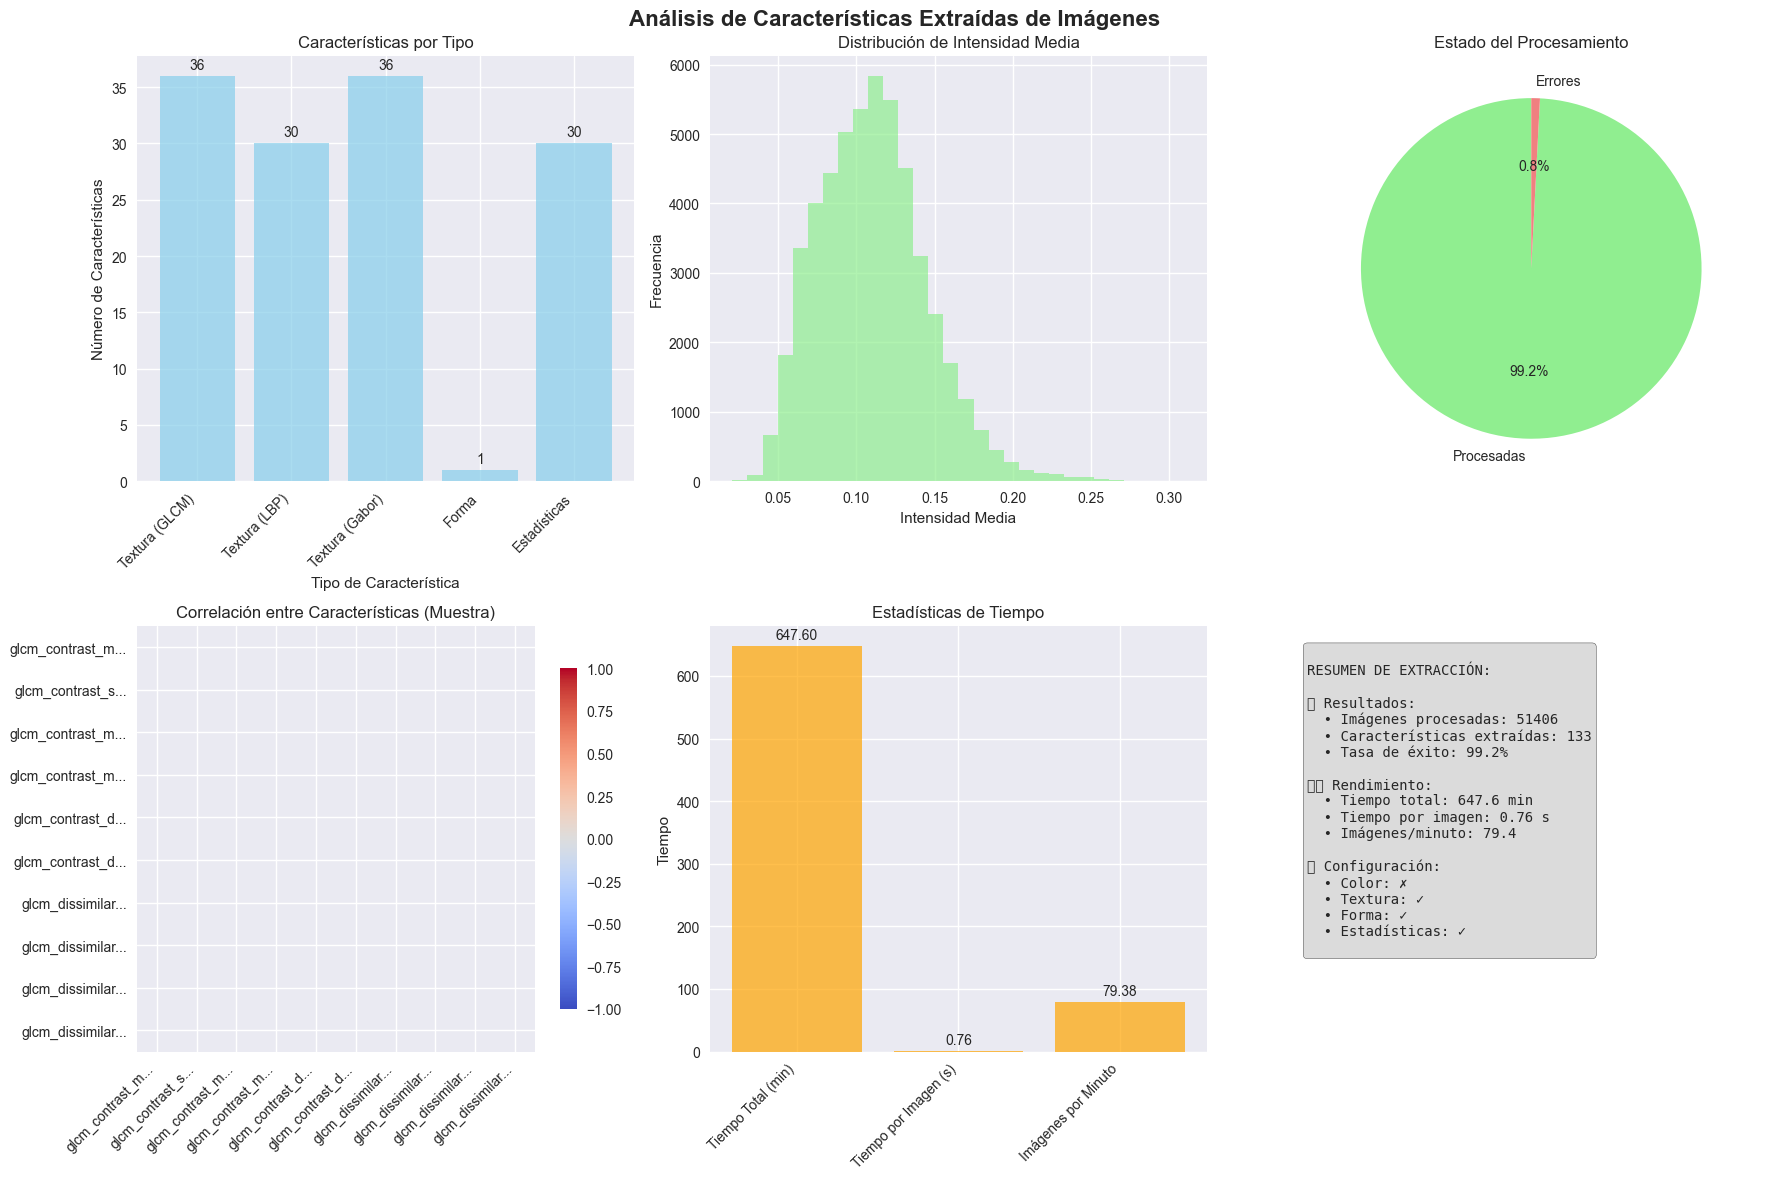

2025-07-14 02:35:39,603 - INFO - Extracción de características de imágenes completada exitosamente


  ✓ Metadatos guardados en: ./resultados/image_extraction_metadata.json


In [ ]:
def extract_image_features_optimized(df, config):
    """
    Extracción optimizada de características de imágenes con múltiples tipos de descriptores
    
    Args:
        df: DataFrame con metadata
        config: Configuración del proyecto
    
    Returns:
        image_features_results: Diccionario con características extraídas y metadatos
    """
    
    print("="*60)
    print("EXTRACCIÓN OPTIMIZADA DE CARACTERÍSTICAS DE IMÁGENES")
    print("="*60)
    
    logger.info("Iniciando extracción de características de imágenes")
    
    # ===== CONFIGURACIÓN INICIAL =====
    images_folder = config['paths']['images_base_folder']
    target_size = config['data_params']['target_image_size']
    
    print(f"📁 Carpeta de imágenes: {images_folder}")
    print(f"📐 Tamaño objetivo: {target_size}")
    print(f"🖼️  Total de imágenes en metadata: {len(df)}")
    
    # Verificar configuración de extracción
    extract_config = config['feature_extraction']
    print(f"\n🔧 Configuración de extracción:")
    print(f"  Color: {'✓' if extract_config['extract_color_features'] else '✗'}")
    print(f"  Textura: {'✓' if extract_config['extract_texture_features'] else '✗'}")
    print(f"  Forma: {'✓' if extract_config['extract_shape_features'] else '✗'}")
    print(f"  Estadísticas: {'✓' if extract_config['extract_statistical_features'] else '✗'}")
    
    # ===== FUNCIONES AUXILIARES PARA EXTRACCIÓN =====
    
    def extract_color_features(img, config):
        """Extrae características de color de la imagen"""
        features = {}
        
        if len(img.shape) > 2 and img.shape[2] >= 3:
            # ===== CARACTERÍSTICAS RGB =====
            for i, channel in enumerate(['R', 'G', 'B']):
                channel_data = img[:, :, i]
                
                # Estadísticas básicas
                features[f'{channel}_mean'] = np.mean(channel_data)
                features[f'{channel}_std'] = np.std(channel_data)
                features[f'{channel}_median'] = np.median(channel_data)
                features[f'{channel}_min'] = np.min(channel_data)
                features[f'{channel}_max'] = np.max(channel_data)
                features[f'{channel}_range'] = np.max(channel_data) - np.min(channel_data)
                
                # Momentos estadísticos
                features[f'{channel}_skewness'] = np.mean((channel_data - np.mean(channel_data))**3) / (np.std(channel_data)**3 + 1e-7)
                features[f'{channel}_kurtosis'] = np.mean((channel_data - np.mean(channel_data))**4) / (np.std(channel_data)**4 + 1e-7)
                
                # Percentiles
                features[f'{channel}_p25'] = np.percentile(channel_data, 25)
                features[f'{channel}_p75'] = np.percentile(channel_data, 75)
                features[f'{channel}_iqr'] = np.percentile(channel_data, 75) - np.percentile(channel_data, 25)
                
                # Histograma
                hist, _ = np.histogram(channel_data, bins=config['color_bins'], range=[0, 1])
                for j, h in enumerate(hist):
                    features[f'{channel}_hist_{j}'] = h
            
            # ===== CARACTERÍSTICAS HSV =====
            img_hsv = color.rgb2hsv(img)
            for i, channel in enumerate(['H', 'S', 'V']):
                channel_data = img_hsv[:, :, i]
                features[f'{channel}_mean'] = np.mean(channel_data)
                features[f'{channel}_std'] = np.std(channel_data)
                features[f'{channel}_median'] = np.median(channel_data)
            
            # ===== CARACTERÍSTICAS LAB =====
            try:
                img_lab = color.rgb2lab(img)
                for i, channel in enumerate(['L', 'A', 'B_lab']):
                    channel_data = img_lab[:, :, i]
                    features[f'{channel}_mean'] = np.mean(channel_data)
                    features[f'{channel}_std'] = np.std(channel_data)
            except:
                pass  # En caso de error con la conversión LAB
            
            # ===== DOMINANCIA DE COLOR =====
            # Calcular color dominante
            img_reshaped = img.reshape(-1, 3)
            from sklearn.cluster import KMeans
            
            try:
                kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
                kmeans.fit(img_reshaped)
                
                # Obtener colores dominantes y sus proporciones
                colors = kmeans.cluster_centers_
                labels = kmeans.labels_
                
                for i in range(3):
                    proportion = np.sum(labels == i) / len(labels)
                    features[f'dominant_color_{i}_R'] = colors[i, 0]
                    features[f'dominant_color_{i}_G'] = colors[i, 1]
                    features[f'dominant_color_{i}_B'] = colors[i, 2]
                    features[f'dominant_color_{i}_proportion'] = proportion
            except:
                # En caso de error, usar valores por defecto
                for i in range(3):
                    features[f'dominant_color_{i}_R'] = 0
                    features[f'dominant_color_{i}_G'] = 0
                    features[f'dominant_color_{i}_B'] = 0
                    features[f'dominant_color_{i}_proportion'] = 0
        
        return features
    
    def extract_texture_features(img_gray, config):
        """Extrae características de textura de la imagen en escala de grises"""
        features = {}
        
        # Convertir a enteros para GLCM
        img_gray_int = (img_gray * 255).astype(np.uint8)
        
        # ===== GLCM (Gray Level Co-occurrence Matrix) =====
        distances = config['glcm_distances']
        angles_deg = config['glcm_angles']
        angles_rad = [np.deg2rad(angle) for angle in angles_deg]
         
        # Mantener niveles pero con optimización inteligente
        max_val = img_gray_int.max()
        levels = 64 if max_val > 64 else max_val + 1
        try:
            glcm = feature.graycomatrix(
                img_gray_int, 
                distances=distances, 
                angles=angles_rad, 
                levels=levels,  # Reducir niveles para eficiencia
                symmetric=True, 
                normed=True
            )
            
            # Propiedades de GLCM
            properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy']
            
            for prop in properties:
                try:
                    if prop == 'ASM':
                        prop_values = feature.graycoprops(glcm, 'ASM')
                    else:
                        prop_values = feature.graycoprops(glcm, prop)
                    
                    # Estadísticas de la propiedad a través de distancias y ángulos
                    features[f'glcm_{prop}_mean'] = np.mean(prop_values)
                    features[f'glcm_{prop}_std'] = np.std(prop_values)
                    features[f'glcm_{prop}_min'] = np.min(prop_values)
                    features[f'glcm_{prop}_max'] = np.max(prop_values)
                    
                    # Valores específicos por distancia (promediando ángulos)
                    for i, dist in enumerate(distances):
                        features[f'glcm_{prop}_dist_{dist}'] = np.mean(prop_values[i, :])
                except:
                    # En caso de error, asignar valores por defecto
                    features[f'glcm_{prop}_mean'] = 0
                    features[f'glcm_{prop}_std'] = 0
                    features[f'glcm_{prop}_min'] = 0
                    features[f'glcm_{prop}_max'] = 0
                    
                    for dist in distances:
                        features[f'glcm_{prop}_dist_{dist}'] = 0
        except:
            # En caso de error con GLCM, asignar valores por defecto
            properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
            for prop in properties:
                features[f'glcm_{prop}_mean'] = 0
                features[f'glcm_{prop}_std'] = 0
                features[f'glcm_{prop}_min'] = 0
                features[f'glcm_{prop}_max'] = 0
                for dist in distances:
                    features[f'glcm_{prop}_dist_{dist}'] = 0
        
        # ===== LBP (Local Binary Patterns) =====
        try:
            radius = config['lbp_radius']
            n_points = config['lbp_n_points']
            
            lbp = feature.local_binary_pattern(img_gray, n_points, radius, method='uniform')
            
            # Histograma de LBP
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_points + 2, range=(0, n_points + 2))
            
            # Normalizar histograma
            lbp_hist = lbp_hist / (np.sum(lbp_hist) + 1e-7)
            
            for i, h in enumerate(lbp_hist):
                features[f'lbp_hist_{i}'] = h
            
            # Estadísticas de LBP
            features['lbp_mean'] = np.mean(lbp)
            features['lbp_std'] = np.std(lbp)
            features['lbp_uniformity'] = np.sum(lbp_hist**2)  # Medida de uniformidad
            features['lbp_entropy'] = -np.sum(lbp_hist * np.log2(lbp_hist + 1e-7))  # Entropía
            
        except:
            # En caso de error con LBP
            n_points = config['lbp_n_points']
            for i in range(n_points + 2):
                features[f'lbp_hist_{i}'] = 0
            features['lbp_mean'] = 0
            features['lbp_std'] = 0
            features['lbp_uniformity'] = 0
            features['lbp_entropy'] = 0
        
        # ===== FILTROS DE GABOR =====
        try:
            # Aplicar filtros de Gabor con diferentes frecuencias y orientaciones
            gabor_responses = []
            frequencies = [0.1, 0.3, 0.5]
            orientations = [0, 45, 90, 135]
            
            for freq in frequencies:
                for orient in orientations:
                    try:
                        gabor_real, _ = filters.gabor(img_gray, frequency=freq, 
                                                    theta=np.deg2rad(orient))
                        gabor_responses.append(gabor_real)
                        
                        # Estadísticas de la respuesta de Gabor
                        features[f'gabor_f{freq}_o{orient}_mean'] = np.mean(np.abs(gabor_real))
                        features[f'gabor_f{freq}_o{orient}_std'] = np.std(gabor_real)
                        features[f'gabor_f{freq}_o{orient}_energy'] = np.sum(gabor_real**2)
                    except:
                        features[f'gabor_f{freq}_o{orient}_mean'] = 0
                        features[f'gabor_f{freq}_o{orient}_std'] = 0
                        features[f'gabor_f{freq}_o{orient}_energy'] = 0
        except:
            # En caso de error con Gabor
            frequencies = [0.1, 0.3, 0.5]
            orientations = [0, 45, 90, 135]
            for freq in frequencies:
                for orient in orientations:
                    features[f'gabor_f{freq}_o{orient}_mean'] = 0
                    features[f'gabor_f{freq}_o{orient}_std'] = 0
                    features[f'gabor_f{freq}_o{orient}_energy'] = 0
        
        return features
    
    def extract_shape_features(img_gray, config):
        """Extrae características de forma de la imagen"""
        features = {}
        
        try:
            # ===== DETECCIÓN DE BORDES =====
            # Canny edge detection
            edges_canny = feature.canny(img_gray, sigma=1.0)
            features['edge_density_canny'] = np.mean(edges_canny)
            
             # ===== SEGMENTACIÓN Y REGIONES (MANTENER PERO OPTIMIZAR) =====
            try:
                threshold_otsu = filters.threshold_otsu(img_gray)
                binary_otsu = img_gray > threshold_otsu
                labeled_img = measure.label(binary_otsu)
                regions = measure.regionprops(labeled_img)
                
                if regions:
                    # Encontrar la región más grande (asumimos que es el tumor)
                    largest_region = max(regions, key=lambda r: r.area)
                    
                    # CARACTERÍSTICAS CLAVE MÁS RELEVANTES:
                    features['area'] = largest_region.area
                    features['perimeter'] = largest_region.perimeter
                    features['eccentricity'] = largest_region.eccentricity
                    features['solidity'] = largest_region.solidity
                    features['extent'] = largest_region.extent
                    
                    # Calcular circularidad alternativa
                    if largest_region.perimeter > 0:
                        circularity = (4 * np.pi * largest_region.area) / (largest_region.perimeter ** 2)
                        features['circularity'] = circularity
                    else:
                        features['circularity'] = 0
                    
                    # Otras características útiles
                    features['orientation'] = largest_region.orientation
                    features['major_axis_length'] = largest_region.major_axis_length
                    features['minor_axis_length'] = largest_region.minor_axis_length
                else:
                    # Valores por defecto si no hay regiones
                    shape_features = ['area', 'perimeter', 'eccentricity', 'solidity', 
                                    'extent', 'circularity', 'orientation',
                                    'major_axis_length', 'minor_axis_length']
                    for feat in shape_features:
                        features[feat] = 0
                        
            except Exception as seg_e:
                logger.warning(f"Error en segmentación: {str(seg_e)}")
                # Asignar valores por defecto en caso de error
                shape_features = ['area', 'perimeter', 'eccentricity', 'solidity', 
                                'extent', 'circularity', 'orientation',
                                'major_axis_length', 'minor_axis_length']
                for feat in shape_features:
                    features[feat] = 0
                    
        except Exception as e:
            logger.error(f"Error general en características de forma: {str(e)}")
            # Asignar valores por defecto
            shape_features = ['edge_density', 'area', 'perimeter', 'eccentricity', 
                            'solidity', 'extent', 'circularity', 'orientation',
                            'major_axis_length', 'minor_axis_length']
            for feat in shape_features:
                features[feat] = 0
                
        return features
        
    def extract_statistical_features(img_gray, config):
        """Extrae características estadísticas generales de la imagen"""
        features = {}
        
        # ===== ESTADÍSTICAS BÁSICAS =====
        features['mean_intensity'] = np.mean(img_gray)
        features['std_intensity'] = np.std(img_gray)
        features['median_intensity'] = np.median(img_gray)
        features['min_intensity'] = np.min(img_gray)
        features['max_intensity'] = np.max(img_gray)
        features['range_intensity'] = np.max(img_gray) - np.min(img_gray)
        
        # ===== PERCENTILES =====
        percentiles = [5, 10, 25, 75, 90, 95]
        for p in percentiles:
            features[f'percentile_{p}'] = np.percentile(img_gray, p)
        
        features['iqr'] = np.percentile(img_gray, 75) - np.percentile(img_gray, 25)
        
        # ===== MOMENTOS ESTADÍSTICOS =====
        features['skewness'] = np.mean((img_gray - np.mean(img_gray))**3) / (np.std(img_gray)**3 + 1e-7)
        features['kurtosis'] = np.mean((img_gray - np.mean(img_gray))**4) / (np.std(img_gray)**4 + 1e-7)
        
        # ===== ENTROPÍA =====
        # Calcular entropía de la imagen
        hist, _ = np.histogram(img_gray, bins=256, range=[0, 1])
        hist = hist / (np.sum(hist) + 1e-7)  # Normalizar
        entropy = -np.sum(hist * np.log2(hist + 1e-7))
        features['entropy'] = entropy
        
        # ===== ENERGÍA =====
        features['energy'] = np.sum(img_gray**2)
        features['rms'] = np.sqrt(np.mean(img_gray**2))
        
        # ===== VARIANZA LOCAL =====
        # Calcular varianza en ventanas locales
        try:
            from skimage.filters.rank import variance
            from skimage.morphology import disk
            
            # Convertir a uint8 para filtros de rango
            img_uint8 = (img_gray * 255).astype(np.uint8)
            local_variance = variance(img_uint8, disk(5))
            
            features['local_variance_mean'] = np.mean(local_variance)
            features['local_variance_std'] = np.std(local_variance)
            features['local_variance_max'] = np.max(local_variance)
        except:
            features['local_variance_mean'] = 0
            features['local_variance_std'] = 0
            features['local_variance_max'] = 0
        
        return features
    
    
    def process_single_image(img_path, config):
        """Procesa una sola imagen (DICOM o estándar) y extrae características"""
        try:
            # ===== DETECCIÓN MEJORADA DE ARCHIVOS ROI =====
            path_parts = img_path.split(os.sep)
        
            # Patrones específicos para identificar archivos ROI en tu estructura
            roi_patterns = [
                "Segmentation",  # Ej: .../300.000000-Segmentation-9.554/...
                "ROI",           # Ej: .../ROI_Series/...
                "roi",           # Ej: .../roi_folder/...
                "RTSTRUCT",      # Ej: .../RTSTRUCT_Series/...
                "rtstruct"       # Ej: .../rtstruct_folder/...
            ]
            
            # Verificar si algún segmento de la ruta coincide con los patrones ROI
            if any(pattern in part for part in path_parts for pattern in roi_patterns):
                logger.warning(f"Archivo ROI detectado y omitido: {img_path}")
                return None
        
            # Verificar formato DICOM
            if img_path.lower().endswith(('.dcm', '.dicom')):
                # Cargar imagen DICOM
                dicom = pydicom.dcmread(img_path)
                
                # Verificar si es un archivo DICOM sin datos de píxeles (ROI)
                if not hasattr(dicom, 'PixelData'):
                    logger.warning(f"Archivo DICOM sin datos de píxeles (probable ROI): {img_path}")
                    return None
                
                img = dicom.pixel_array
                
                # Convertir a escala de grises si es necesario
                if len(img.shape) > 2:
                    img = color.rgb2gray(img)
                    
                # Normalizar a [0, 1]
                img = img.astype(np.float32)
                img = (img - img.min()) / (img.max() - img.min() + 1e-7)
                
                # Convertir a 3 canales para consistencia
                img = np.stack((img,) * 3, axis=-1)
            else:
                # Cargar imagen estándar (PNG/JPG)
                img = io.imread(img_path)
                
                # Convertir RGBA a RGB si es necesario
                if len(img.shape) > 2 and img.shape[2] == 4:
                    img = img[:, :, :3]
            
            # Redimensionar
            img_resized = resize(img, target_size, anti_aliasing=True)
            
            # Convertir a escala de grises para características de textura/forma
            if len(img_resized.shape) > 2 and img_resized.shape[2] > 1:
                img_gray = color.rgb2gray(img_resized)
            else:
                img_gray = img_resized
            
            # Diccionario para características
            all_features = {}
            
            # Extraer características según configuración
            if config['extract_color_features'] and len(img_resized.shape) > 2:
                color_features = extract_color_features(img_resized, config)
                all_features.update(color_features)
            
            if config['extract_texture_features']:
                texture_features = extract_texture_features(img_gray, config)
                all_features.update(texture_features)
            
            if config['extract_shape_features']:
                shape_features = extract_shape_features(img_gray, config)
                all_features.update(shape_features)
            
            if config['extract_statistical_features']:
                statistical_features = extract_statistical_features(img_gray, config)
                all_features.update(statistical_features)
            
            return all_features
            
        except Exception as e:
            logger.error(f"Error procesando imagen {img_path}: {str(e)}")
            return None
    
    # ===== PROCESAMIENTO PRINCIPAL =====
    print(f"\n🔄 Iniciando extracción de características...")
    
    image_features = {}
    processed_count = 0
    error_count = 0
    start_time = time.time()
    roi_skipped = 0  # Nuevo contador para ROI 

    # Crear barra de progreso simple
    total_images = len(df)
    
    for index, row in df.iterrows():
        img_path = row['image_path']
        
        if not os.path.exists(img_path):
            logger.error(f"La imagen no existe: {img_path}")
            error_count += 1
            continue
            
        features = process_single_image(img_path, extract_config)
    
        if features is not None:
            img_id = row['image_path']
            image_features[img_id] = features
            processed_count += 1
        else:
            # Verificar si fue un ROI o un error real
            roi_keywords = ['Segmentation', 'ROI', 'roi', 'RTSTRUCT', 'rtstruct']
            if any(keyword in img_path for keyword in roi_keywords):
                roi_skipped += 1
            else:
                error_count += 1
            
        # Mostrar progreso cada 100 imágenes
        if (processed_count + roi_skipped + error_count) % 10 == 0:
            total_processed = processed_count + roi_skipped + error_count
            progress = total_processed / total_images * 100
            elapsed_time = time.time() - start_time
            # Calcular tiempo restante solo si se han procesado algunas imágenes
            if total_processed > 0:
                estimated_total = elapsed_time / total_processed * total_images
                remaining_time = estimated_total - elapsed_time
            else:
                remaining_time = 0
                    
            print(f"Progreso: {progress:.1f}% | "
                  f"Procesadas: {processed_count} | "
                  f"ROI omitidos: {roi_skipped} | "
                  f"Errores: {error_count} | "
                  f"Tiempo restante: {remaining_time/60:.1f} min")
    
    total_time = time.time() - start_time
    
    print(f"\n✅ Extracción completada:")
    print(f"  Tiempo total: {total_time/60:.1f} minutos")
    print(f"  Imágenes procesadas: {processed_count}")
    print(f"  ROI omitidos: {roi_skipped}")
    print(f"  Errores reales: {error_count}")
    print(f"  Tasa de éxito: {processed_count/(processed_count+roi_skipped+error_count)*100:.1f}%")
    if processed_count == 0:
        raise ValueError("No se pudo procesar ninguna imagen. Verificar rutas y configuración.")
    
    # ===== CONVERTIR A DATAFRAME =====
    print(f"\n📊 Creando DataFrame de características...")
    
    image_features_df = pd.DataFrame.from_dict(image_features, orient='index')
    image_features_df.index.name = 'img_id'
    image_features_df = image_features_df.reset_index()
    
    print(f"  Forma del DataFrame: {image_features_df.shape}")
    print(f"  Características extraídas: {image_features_df.shape[1] - 1}")  # -1 por la columna img_id
    
    # ===== ANÁLISIS DE CARACTERÍSTICAS EXTRAÍDAS =====
    print(f"\n🔍 Análisis de características extraídas:")
    
    feature_columns = [col for col in image_features_df.columns if col != 'img_id']
    
    # Estadísticas básicas
    print(f"  Total de características: {len(feature_columns)}")
    
    # Contar características por tipo
    feature_types = {
        'Color (RGB)': len([col for col in feature_columns if any(c in col for c in ['R_', 'G_', 'B_'])]),
        'Color (HSV)': len([col for col in feature_columns if any(c in col for c in ['H_', 'S_', 'V_'])]),
        'Color (LAB)': len([col for col in feature_columns if any(c in col for c in ['L_', 'A_', 'B_lab'])]),
        'Color (Dominante)': len([col for col in feature_columns if 'dominant_color' in col]),
        'Textura (GLCM)': len([col for col in feature_columns if 'glcm_' in col]),
        'Textura (LBP)': len([col for col in feature_columns if 'lbp_' in col]),
        'Textura (Gabor)': len([col for col in feature_columns if 'gabor_' in col]),
        'Forma': len([col for col in feature_columns if any(s in col for s in ['edge_', 'sobel_', 'region', 'circle'])]),
        'Estadísticas': len([col for col in feature_columns if any(s in col for s in ['mean_', 'std_', 'median_', 'percentile_', 'entropy', 'energy'])])
    }
    
    for feat_type, count in feature_types.items():
        if count > 0:
            print(f"    {feat_type}: {count}")
    
    # Verificar valores problemáticos
    nan_count = image_features_df[feature_columns].isnull().sum().sum()
    inf_count = np.isinf(image_features_df[feature_columns].select_dtypes(include=[np.number])).sum().sum()
    
    print(f"\n🔍 Verificación de calidad:")
    print(f"  Valores NaN: {nan_count}")
    print(f"  Valores infinitos: {inf_count}")
    
    if nan_count > 0 or inf_count > 0:
        print(f"  ⚠️  Limpiando valores problemáticos...")
        
        # Reemplazar NaN e infinitos con 0
        image_features_df[feature_columns] = image_features_df[feature_columns].replace([np.inf, -np.inf], np.nan)
        image_features_df[feature_columns] = image_features_df[feature_columns].fillna(0)
        
        print(f"  ✓ Valores problemáticos reemplazados con 0")
    
    # ===== GUARDAR RESULTADOS =====
    print(f"\n💾 Guardando resultados...")
    
    # Guardar DataFrame de características
    features_path = os.path.join(config['paths']['output_folder'], 'image_features.csv')
    image_features_df.to_csv(features_path, index=False)
    print(f"  ✓ Características guardadas en: {features_path}")
    
    # Guardar también en formato pickle para preservar tipos de datos
    features_pkl_path = os.path.join(config['paths']['output_folder'], 'image_features.pkl')
    image_features_df.to_pickle(features_pkl_path)
    print(f"  ✓ Características (pickle) guardadas en: {features_pkl_path}")
    
    # ===== CREAR VISUALIZACIÓN DE CARACTERÍSTICAS =====
    print(f"\n📊 Generando visualización de características...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Análisis de Características Extraídas de Imágenes', fontsize=16, fontweight='bold')
    
    # 1. Distribución de tipos de características
    ax1 = axes[0, 0]
    feature_type_counts = [count for count in feature_types.values() if count > 0]
    feature_type_names = [name for name, count in feature_types.items() if count > 0]
    
    bars = ax1.bar(range(len(feature_type_names)), feature_type_counts, color='skyblue', alpha=0.7)
    ax1.set_title('Características por Tipo')
    ax1.set_xlabel('Tipo de Característica')
    ax1.set_ylabel('Número de Características')
    ax1.set_xticks(range(len(feature_type_names)))
    ax1.set_xticklabels(feature_type_names, rotation=45, ha='right')
    
    # Añadir etiquetas de valores
    for bar, count in zip(bars, feature_type_counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(feature_type_counts)*0.01, 
                str(count), ha='center', va='bottom')
    
    # 2. Distribución de una característica de ejemplo (mean_intensity)
    ax2 = axes[0, 1]
    if 'mean_intensity' in feature_columns:
        ax2.hist(image_features_df['mean_intensity'], bins=30, alpha=0.7, color='lightgreen')
        ax2.set_title('Distribución de Intensidad Media')
        ax2.set_xlabel('Intensidad Media')
        ax2.set_ylabel('Frecuencia')
    else:
        ax2.text(0.5, 0.5, 'mean_intensity\nno disponible', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Distribución de Intensidad Media')
    
    # 3. Estadísticas de procesamiento
    ax3 = axes[0, 2]
    processing_stats = {
        'Procesadas': processed_count,
        'Errores': error_count
    }
    
    colors = ['lightgreen', 'lightcoral']
    wedges, texts, autotexts = ax3.pie(processing_stats.values(), labels=processing_stats.keys(), 
                                      colors=colors, autopct='%1.1f%%', startangle=90)
    ax3.set_title('Estado del Procesamiento')
    
    # 4. Correlación entre características (muestra)
    ax4 = axes[1, 0]
    if len(feature_columns) > 1:
        # Seleccionar una muestra de características para correlación
        sample_features = feature_columns[:min(10, len(feature_columns))]
        corr_matrix = image_features_df[sample_features].corr()
        
        im = ax4.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        ax4.set_title('Correlación entre Características (Muestra)')
        ax4.set_xticks(range(len(sample_features)))
        ax4.set_yticks(range(len(sample_features)))
        ax4.set_xticklabels([feat[:15] + '...' if len(feat) > 15 else feat for feat in sample_features], 
                           rotation=45, ha='right')
        ax4.set_yticklabels([feat[:15] + '...' if len(feat) > 15 else feat for feat in sample_features])
        
        plt.colorbar(im, ax=ax4, shrink=0.8)
    else:
        ax4.text(0.5, 0.5, 'Insuficientes características\npara correlación', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Correlación entre Características')
    
    # 5. Tiempo de procesamiento
    ax5 = axes[1, 1]
    time_per_image = total_time / processed_count if processed_count > 0 else 0
    
    time_stats = {
        'Tiempo Total (min)': total_time / 60,
        'Tiempo por Imagen (s)': time_per_image,
        'Imágenes por Minuto': 60 / time_per_image if time_per_image > 0 else 0
    }
    
    bars = ax5.bar(range(len(time_stats)), list(time_stats.values()), color='orange', alpha=0.7)
    ax5.set_title('Estadísticas de Tiempo')
    ax5.set_xticks(range(len(time_stats)))
    ax5.set_xticklabels(list(time_stats.keys()), rotation=45, ha='right')
    ax5.set_ylabel('Tiempo')
    
    # Añadir etiquetas de valores
    for bar, value in zip(bars, time_stats.values()):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(time_stats.values())*0.01, 
                f'{value:.2f}', ha='center', va='bottom')
    
    # 6. Resumen de extracción
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    summary_text = f"""
RESUMEN DE EXTRACCIÓN:

📊 Resultados:
  • Imágenes procesadas: {processed_count}
  • Características extraídas: {len(feature_columns)}
  • Tasa de éxito: {processed_count/(processed_count+error_count)*100:.1f}%

⏱️ Rendimiento:
  • Tiempo total: {total_time/60:.1f} min
  • Tiempo por imagen: {time_per_image:.2f} s
  • Imágenes/minuto: {60/time_per_image:.1f}

🔧 Configuración:
  • Color: {'✓' if extract_config['extract_color_features'] else '✗'}
  • Textura: {'✓' if extract_config['extract_texture_features'] else '✗'}
  • Forma: {'✓' if extract_config['extract_shape_features'] else '✗'}
  • Estadísticas: {'✓' if extract_config['extract_statistical_features'] else '✗'}
    """
    
    ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    
    # Guardar visualización
    if config['visualization']['save_plots']:
        plot_path = os.path.join(config['paths']['plots_folder'], 
                                f'image_features_analysis.{config["visualization"]["plot_format"]}')
        plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
        print(f"  ✓ Visualización guardada en: {plot_path}")
    
    plt.show()
    
    # ===== COMPILAR RESULTADOS =====
    image_features_results = {
        'image_features_df': image_features_df,
        'feature_columns': feature_columns,
        'extraction_summary': {
            'total_images_in_metadata': total_images,
            'images_processed': processed_count,
            'images_with_errors': error_count,
            'success_rate': processed_count / (processed_count + error_count) * 100,
            'total_features_extracted': len(feature_columns),
            'feature_types': feature_types,
            'processing_time_minutes': total_time / 60,
            'time_per_image_seconds': time_per_image,
            'images_per_minute': 60 / time_per_image if time_per_image > 0 else 0
        },
        'extraction_config': extract_config
    }
    
    # Guardar metadatos de extracción
    metadata_path = os.path.join(config['paths']['output_folder'], 'image_extraction_metadata.json')
    
    
    # 1) Reconstruyo class_distribution con valores int puros
    raw_dist = multimodal_results['class_info']['class_distribution']
    clean_dist = {str(k): int(v) for k, v in raw_dist.items()}

    # 2) Armo el dict completo con listas nativas y ints
    metadata_to_save = {
        'alignment_info': multimodal_results['alignment_info'],
        'feature_info': multimodal_results['feature_info'],
        'class_info': {
            'unique_classes': multimodal_results['class_info']['unique_classes'].tolist(),
            'class_names':     multimodal_results['class_info']['class_names'],
            'class_counts':    multimodal_results['class_info']['class_counts'].tolist(),
            'class_distribution': clean_dist,
            'imbalance_ratio': multimodal_results['class_info']['imbalance_ratio']
        },
        'quality_metrics': multimodal_results['quality_metrics']
    }

    # 3) Luego lo vuelco a JSON
    with open(metadata_path, 'w') as f:
        json.dump(metadata_to_save, f, indent=2)
        print(f"  ✓ Metadatos guardados en: {metadata_path}")
        
    logger.info("Extracción de características de imágenes completada exitosamente")
    
    return image_features_results

# ===== EJECUTAR EXTRACCIÓN DE CARACTERÍSTICAS =====
image_features_results = extract_image_features_optimized(df_expanded, CONFIG)


## 5. Creación del dataset multimodal con validación

2025-07-14 04:02:17,544 - INFO - Iniciando creación del dataset multimodal
2025-07-14 04:02:17,545 - WARNING - Inconsistencia: 422 etiquetas vs 52250 filas en DataFrame original


CREACIÓN DEL DATASET MULTIMODAL CON VALIDACIÓN
📊 Información de entrada:
  Datos clínicos: (422, 12)
  Características clínicas: 12
  Características de imágenes: 133
  Imágenes disponibles: 51230
  Etiquetas: 422

🔍 Validación de consistencia de datos...
{'data\\NSCLC-Radiomics\\LUNG1-022\\01-01-2014-StudyID-NA-35402\\1.000000-NA-87197\\1-052.dcm', 'data\\NSCLC-Radiomics\\LUNG1-140\\01-01-2014-StudyID-NA-75276\\1.000000-NA-29120\\1-060.dcm', 'data\\NSCLC-Radiomics\\LUNG1-140\\01-01-2014-StudyID-NA-75276\\1.000000-NA-29120\\1-047.dcm', 'data\\NSCLC-Radiomics\\LUNG1-314\\12-05-2008-NA-NA-76077\\300.000000-Segmentation-3.401\\1-1.dcm', 'data\\NSCLC-Radiomics\\LUNG1-121\\06-30-2006-StudyID-NA-05880\\6.000000-NA-99432\\1-1.dcm', 'data\\NSCLC-Radiomics\\LUNG1-219\\12-21-2007-StudyID-NA-67789\\0.000000-NA-51006\\1-75.dcm', 'data\\NSCLC-Radiomics\\LUNG1-418\\07-15-2010-NA-NA-60673\\0.000000-NA-89047\\1-057.dcm', 'data\\NSCLC-Radiomics\\LUNG1-312\\11-07-2008-NA-NA-20407\\0.000000-NA-16002\\1-0

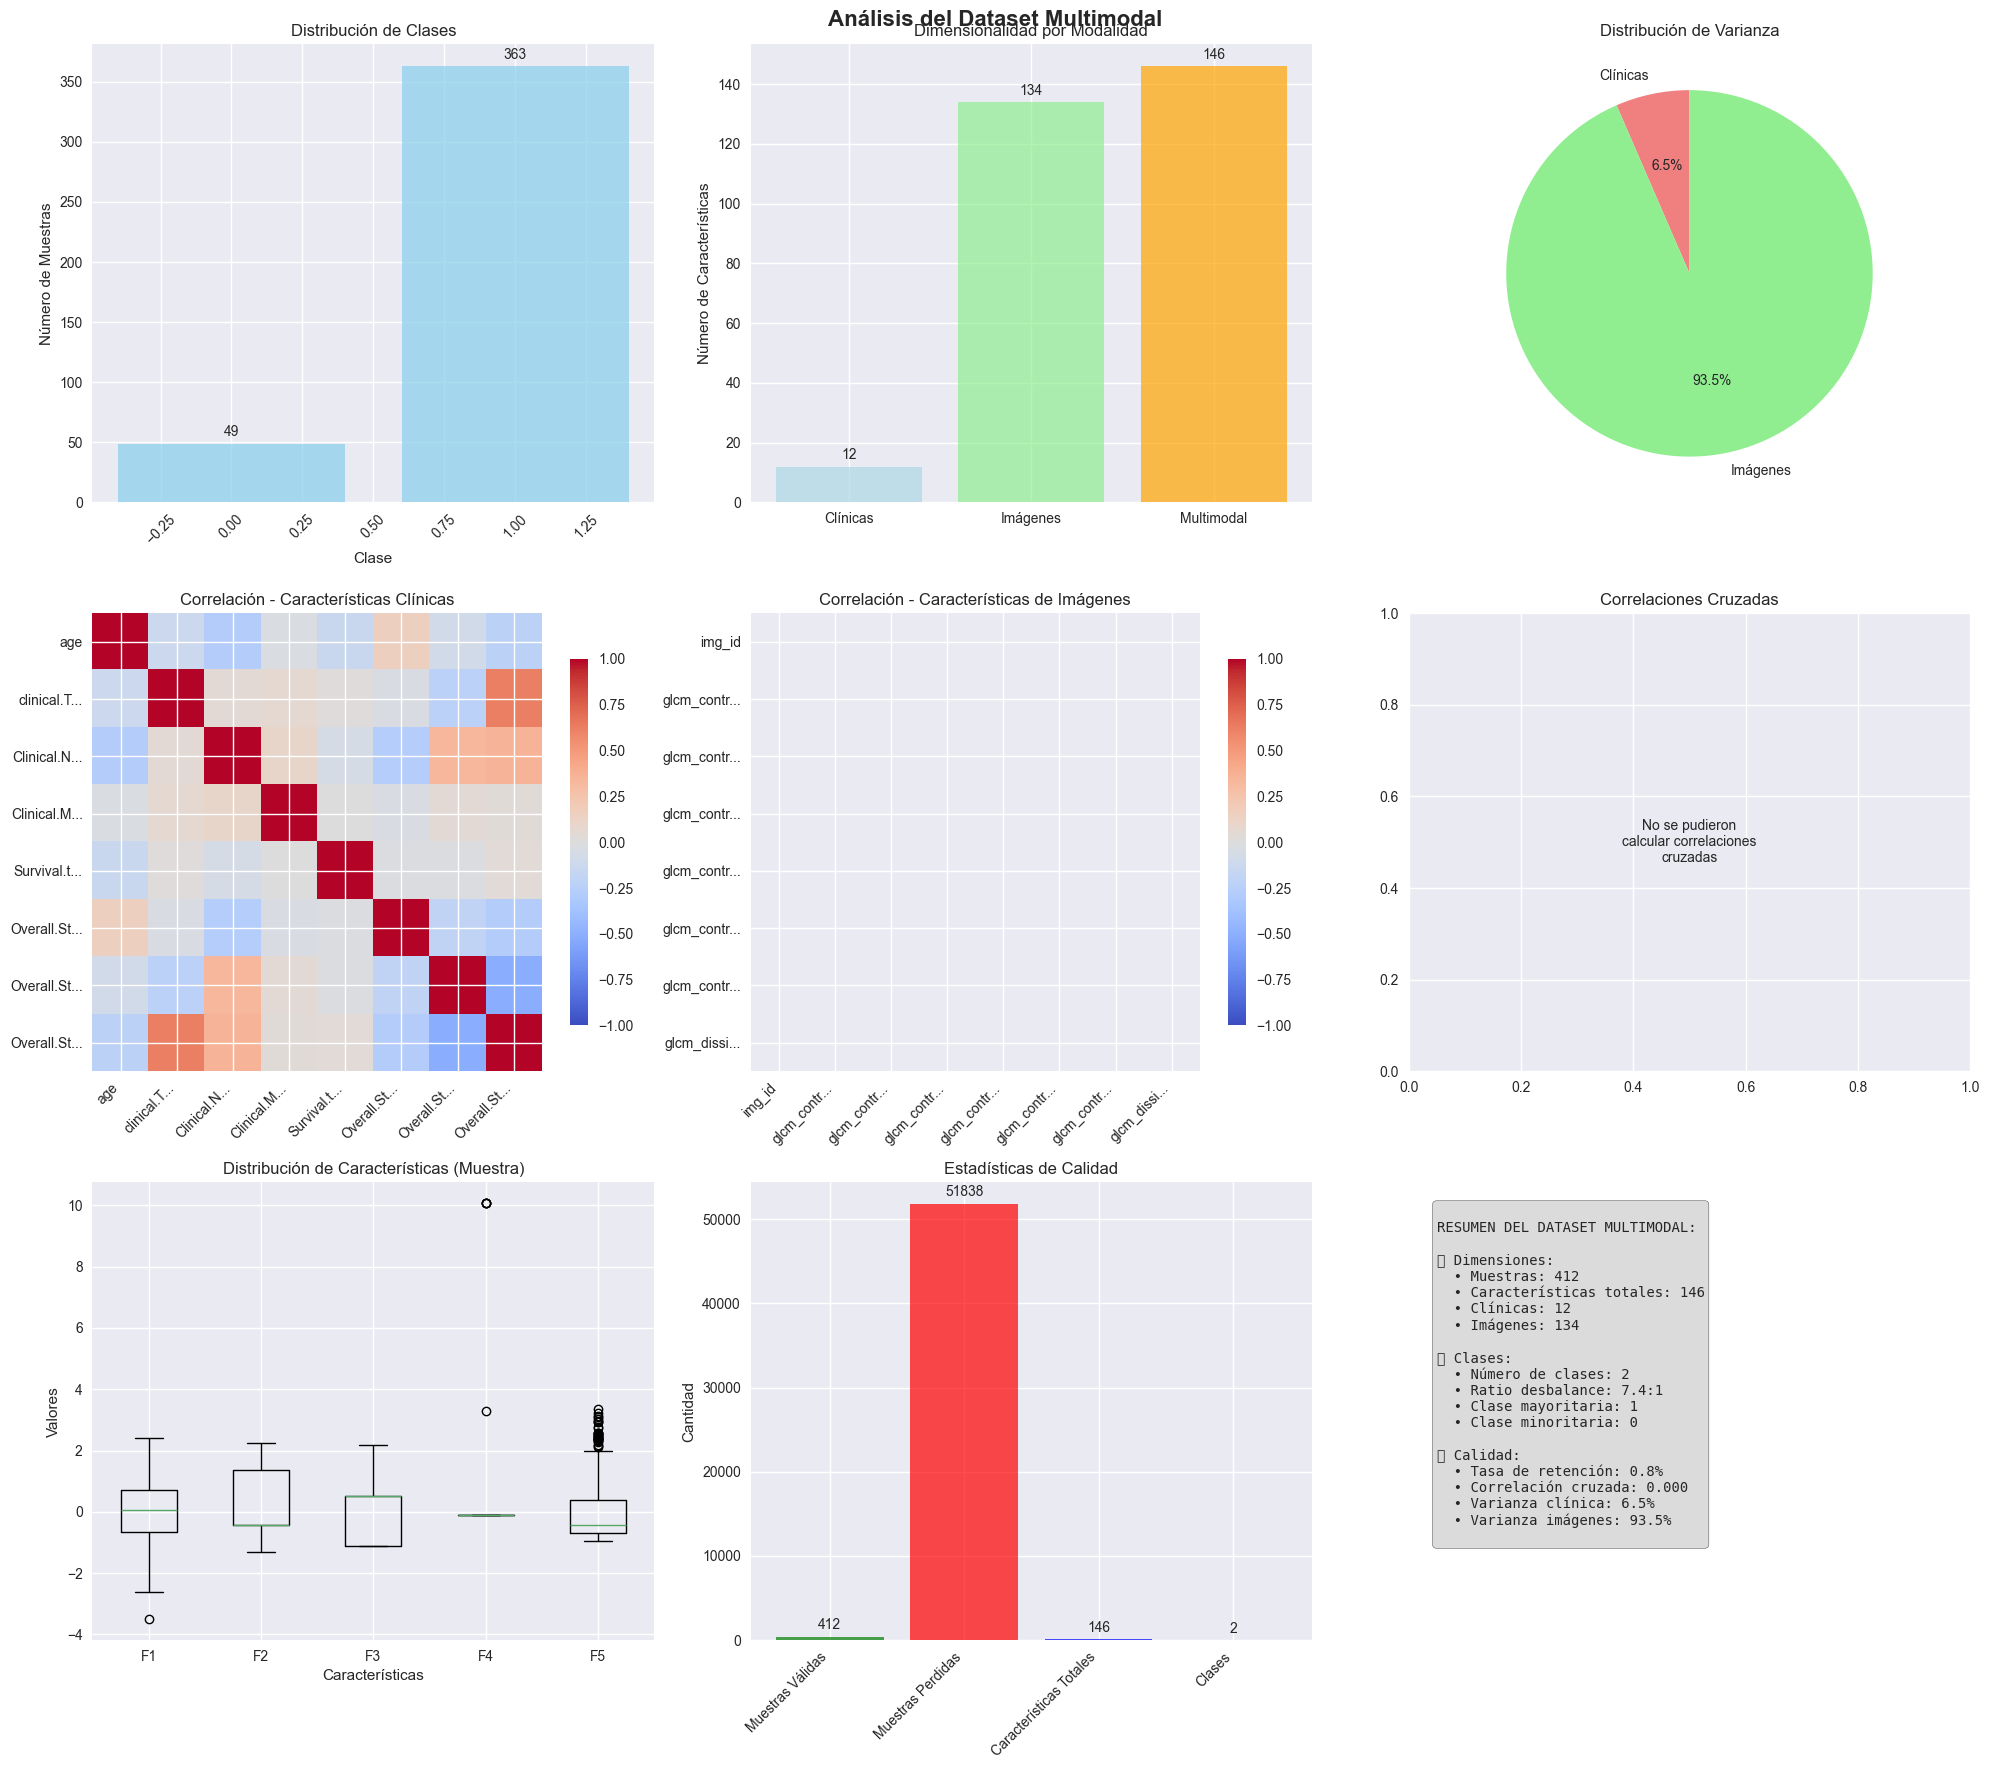

2025-07-14 04:02:24,291 - INFO - Creación del dataset multimodal completada exitosamente



💾 Guardando dataset multimodal...
  ✓ Dataset CSV guardado en: ./resultados/multimodal_dataset.csv
  ✓ Dataset pickle guardado en: ./resultados/multimodal_dataset.pkl
  ✓ Metadatos guardados en: ./resultados/multimodal_metadata.json


In [19]:
def create_multimodal_dataset_validated(df, preprocessing_results, image_features_results, config):
    """
    Crea dataset multimodal combinando datos clínicos e imágenes con validación exhaustiva
    
    Args:
        df: DataFrame original
        preprocessing_results: Resultados del preprocesamiento clínico
        image_features_results: Resultados de extracción de características de imágenes
        config: Configuración del proyecto
    
    Returns:
        multimodal_results: Diccionario con dataset multimodal y metadatos
    """
    
    print("="*60)
    print("CREACIÓN DEL DATASET MULTIMODAL CON VALIDACIÓN")
    print("="*60)
    
    logger.info("Iniciando creación del dataset multimodal")
    
    # ===== EXTRAER DATOS DE ENTRADA =====
    X_clinical = preprocessing_results['X_processed']
    y_encoded = preprocessing_results['y_encoded']
    clinical_feature_names = preprocessing_results['feature_names']
    label_encoder = preprocessing_results['label_encoder']
    
    image_features_df = image_features_results['image_features_df']
    image_feature_columns = image_features_results['feature_columns']
    
    print(f"📊 Información de entrada:")
    print(f"  Datos clínicos: {X_clinical.shape}")
    print(f"  Características clínicas: {len(clinical_feature_names)}")
    print(f"  Características de imágenes: {len(image_feature_columns)}")
    print(f"  Imágenes disponibles: {len(image_features_df)}")
    print(f"  Etiquetas: {len(y_encoded)}")
    
    # ===== VALIDACIÓN DE CONSISTENCIA =====
    print(f"\n🔍 Validación de consistencia de datos...")
    
    # Verificar que el número de muestras clínicas coincida con el DataFrame original
    if len(y_encoded) != len(df):
        logger.warning(f"Inconsistencia: {len(y_encoded)} etiquetas vs {len(df)} filas en DataFrame original")
    
    # Verificar que todas las imágenes en image_features_df estén en el DataFrame original
    original_img_ids = set(df['image_path'].tolist())
    print (original_img_ids)
    processed_img_ids = set(image_features_df['img_id'].tolist())
    
    missing_in_original = processed_img_ids - original_img_ids
    missing_in_processed = original_img_ids - processed_img_ids
    
    print(f"  Imágenes en DataFrame original: {len(original_img_ids)}")
    print(f"  Imágenes procesadas: {len(processed_img_ids)}")
    print(f"  Imágenes faltantes en original: {len(missing_in_original)}")
    print(f"  Imágenes faltantes en procesadas: {len(missing_in_processed)}")
    
    if missing_in_original:
        logger.warning(f"Hay {len(missing_in_original)} imágenes procesadas que no están en el DataFrame original")
    
    if missing_in_processed:
        print(f"  ⚠️  {len(missing_in_processed)} imágenes del DataFrame original no fueron procesadas")
    
    # ===== ALINEACIÓN DE DATOS =====
    print(f"\n🔗 Alineando datos clínicos e imágenes...")
    
    # Crear DataFrame temporal con índices para facilitar la alineación
    df_temp = df.copy().reset_index(drop=True)
    df_temp['positional_index'] = np.arange(len(df_temp))  # Índice posicional seguro
    
    # 2. Unir con características de imagen usando merge seguro
    image_features_df = image_features_results['image_features_df']
    
    print(f"\n🔍 Verificación previa a unión:")
    print(f"  Muestras clínicas: {len(df_temp)}")
    print(f"  Muestras de imagen: {len(image_features_df)}")
    print(f"  Columnas imagen: {image_features_df.columns.tolist()}")
    
    # Verificar rutas comunes
    common_paths = set(df_temp['image_path']).intersection(set(image_features_df['img_id']))
    print(f"  Rutas comunes: {len(common_paths)}")
    
    # Antes de la unión:
    print("\nEjemplo de rutas clínicas:")
    print(df_temp['image_path'].head(3).values)
    print("\nEjemplo de rutas de imagen:")
    print(image_features_df['img_id'].head(3).values)

    # Chequear coincidencias
    path_check = df_temp['image_path'].iloc[0]
    print(f"\nPrimera ruta existe en features? {path_check in image_features_df['img_id'].values}")

    # Unir con características de imágenes
    df_merged = pd.merge(
    df_temp,              # Tu DataFrame temporal con datos clínicos y 'image_path'
    image_features_df,    # Tu DataFrame con características de imagen y 'img_id' (que es la ruta completa)
    left_on='image_path', # Columna de unión en df_temp
    right_on='img_id',    # Columna de unión en image_features_df
    how='inner',           # Tipo de unión (inner join para mantener solo coincidencias)
    validate='many_to_one'
)
    
    print(f"\n✅ Unión completada:")
    print(f"  Muestras resultantes: {len(df_merged)}")
    print(f"  Columnas resultantes: {df_merged.columns.tolist()}")
    

    # 1) Filtrar sólo las filas con positional_index válido
    df_aligned = df_merged[
        df_merged['positional_index'] < len(X_clinical)
    ].copy()

    # 2) Ordenar por positional_index para que clínico e imagen queden emparejados
    df_aligned.sort_values('positional_index', inplace=True)

    # 3) Re-extraer X_clinical_filtered y y_filtered en ese orden
    if hasattr(X_clinical, 'toarray'):
        X_clinical_filtered = X_clinical[
            df_aligned['positional_index']
        ].toarray()
    else:
        X_clinical_filtered = X_clinical[
            df_aligned['positional_index']
        ]
    y_filtered = y_encoded[
        df_aligned['positional_index']
]
    
    # Extraer características de imágenes (sin img_id)
    image_feature_columns = [col for col in df_merged.columns if col not in df_temp.columns]
    
    # 4) Extraer las features de imagen CONVERSIÓN A FLOAT
    df_aligned[image_feature_columns] = (
        df_aligned[image_feature_columns]
        .apply(pd.to_numeric, errors='coerce')
    )
    X_image_features = df_aligned[image_feature_columns].values

    
    #5) Limpiar NaN/Inf si es necesario
    X_image_features = np.nan_to_num(X_image_features, nan=0.0, posinf=0.0, neginf=0.0)

    # 6) Escalar SOLO esas filas de imagen
    image_scaler = StandardScaler()
    X_image_features_scaled = image_scaler.fit_transform(X_image_features)

    # 7) Ahora ambas matrices tienen el MISMO número de filas
    print(X_clinical_filtered.shape, X_image_features_scaled.shape)
    print(f"  Características de imágenes: {X_image_features.shape}")
    print(f"  Etiquetas filtradas: {len(y_filtered)}")
    
    
    # ===== VERIFICACIÓN DE CALIDAD DE DATOS =====
    print(f"\n✅ Verificación de calidad de datos...")
    
    # Verificar valores problemáticos en datos clínicos
    clinical_nan = np.isnan(X_clinical_filtered).sum()
    clinical_inf = np.isinf(X_clinical_filtered).sum()
    
    # Verificar valores problemáticos en características de imágenes
    image_nan = np.isnan(X_image_features).sum()
    image_inf = np.isinf(X_image_features).sum()
    
    print(f"  Datos clínicos - NaN: {clinical_nan}, Inf: {clinical_inf}")
    print(f"  Características de imágenes - NaN: {image_nan}, Inf: {image_inf}")
    
    # Limpiar valores problemáticos si existen
    if clinical_nan > 0 or clinical_inf > 0:
        print(f"  🧹 Limpiando valores problemáticos en datos clínicos...")
        X_clinical_filtered = np.nan_to_num(X_clinical_filtered, nan=0.0, posinf=0.0, neginf=0.0)
    
    if image_nan > 0 or image_inf > 0:
        print(f"  🧹 Limpiando valores problemáticos en características de imágenes...")
        X_image_features = np.nan_to_num(X_image_features, nan=0.0, posinf=0.0, neginf=0.0)
    
    # ===== NORMALIZACIÓN DE CARACTERÍSTICAS DE IMÁGENES =====
    print(f"\n📏 Normalizando características de imágenes...")
    
    # Aplicar escalado a las características de imágenes para que estén en la misma escala que las clínicas
    image_scaler = StandardScaler()
    X_image_features_scaled = image_scaler.fit_transform(X_image_features)
    
    print(f"  Rango antes del escalado: [{X_image_features.min():.3f}, {X_image_features.max():.3f}]")
    print(f"  Rango después del escalado: [{X_image_features_scaled.min():.3f}, {X_image_features_scaled.max():.3f}]")
    
    # ===== CREACIÓN DEL DATASET MULTIMODAL =====
    print(f"\n🔗 Creando dataset multimodal...")
    
    # Combinar características clínicas e imágenes
    X_multimodal = np.hstack([X_clinical_filtered, X_image_features_scaled])
    
    # Combinar nombres de características
    multimodal_feature_names = clinical_feature_names + [f"img_{col}" for col in image_feature_columns]
    
    print(f"  Forma del dataset multimodal: {X_multimodal.shape}")
    print(f"  Características clínicas: {X_clinical_filtered.shape[1]}")
    print(f"  Características de imágenes: {X_image_features_scaled.shape[1]}")
    print(f"  Total de características: {len(multimodal_feature_names)}")
    
    # ===== ANÁLISIS DE DISTRIBUCIÓN DE CLASES =====
    print(f"\n📊 Análisis de distribución de clases en dataset multimodal...")
    
    unique_classes, class_counts = np.unique(y_filtered, return_counts=True)
    class_names = [label_encoder.classes_[i] for i in unique_classes]
    
    print(f"  Distribución de clases:")
    for class_name, class_idx, count in zip(class_names, unique_classes, class_counts):
        percentage = count / len(y_filtered) * 100
        print(f"    {class_name} (idx {class_idx}): {count} muestras ({percentage:.1f}%)")
    
    # Calcular métricas de desbalance
    max_class_size = class_counts.max()
    min_class_size = class_counts.min()
    imbalance_ratio = max_class_size / min_class_size
    
    print(f"  Ratio de desbalance: {imbalance_ratio:.2f}:1")
    
    # ===== ANÁLISIS DE CORRELACIÓN ENTRE MODALIDADES =====
    print(f"\n🔍 Análisis de correlación entre modalidades...")
    
    # Inicializar variables con valores por defecto
    mean_cross_corr = 0
    max_cross_corr = 0
    cross_correlations = []

    # Calcular correlación promedio entre características clínicas e imágenes
    if X_clinical_filtered.shape[1] > 0 and X_image_features_scaled.shape[1] > 0:
        # Seleccionar una muestra de características para análisis de correlación
        n_clinical_sample = min(10, X_clinical_filtered.shape[1])
        n_image_sample = min(10, X_image_features_scaled.shape[1])
        
        clinical_sample = X_clinical_filtered[:, :n_clinical_sample]
        image_sample = X_image_features_scaled[:, :n_image_sample]
        
        # Calcular correlaciones cruzadas
        cross_correlations = []
        for i in range(clinical_sample.shape[1]):
            for j in range(image_sample.shape[1]):
                corr = np.corrcoef(clinical_sample[:, i], image_sample[:, j])[0, 1]
                if not np.isnan(corr):
                    cross_correlations.append(abs(corr))
        
        if cross_correlations:
            mean_cross_corr = np.mean(cross_correlations)
            max_cross_corr = np.max(cross_correlations)
            print(f"  Correlación cruzada promedio: {mean_cross_corr:.3f}")
            print(f"  Correlación cruzada máxima: {max_cross_corr:.3f}")
        else:
            print(f"  No se pudieron calcular correlaciones cruzadas")
    else:
        print(f"  No se pudo calcular correlación cruzada: una de las modalidades no tiene características")
    # ===== ANÁLISIS DE VARIANZA EXPLICADA POR MODALIDAD =====
    print(f"\n📈 Análisis de varianza por modalidad...")
    
    # Calcular varianza total de cada modalidad
    clinical_variance = np.var(X_clinical_filtered, axis=0).sum()
    image_variance = np.var(X_image_features_scaled, axis=0).sum()
    total_variance = clinical_variance + image_variance
    
    clinical_variance_pct = clinical_variance / total_variance * 100
    image_variance_pct = image_variance / total_variance * 100
    
    print(f"  Varianza explicada por datos clínicos: {clinical_variance_pct:.1f}%")
    print(f"  Varianza explicada por características de imágenes: {image_variance_pct:.1f}%")
    
    # ===== CREAR VISUALIZACIONES =====
    print(f"\n📊 Generando visualizaciones del dataset multimodal...")
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    fig.suptitle('Análisis del Dataset Multimodal', fontsize=16, fontweight='bold')
    
    # 1. Distribución de clases
    ax1 = axes[0, 0]
    bars = ax1.bar(class_names, class_counts, color='skyblue', alpha=0.7)
    ax1.set_title('Distribución de Clases')
    ax1.set_xlabel('Clase')
    ax1.set_ylabel('Número de Muestras')
    ax1.tick_params(axis='x', rotation=45)
    
    for bar, count in zip(bars, class_counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(class_counts)*0.01, 
                str(count), ha='center', va='bottom')
    
    # 2. Comparación de dimensionalidad
    ax2 = axes[0, 1]
    dimensions = {
        'Clínicas': X_clinical_filtered.shape[1],
        'Imágenes': X_image_features_scaled.shape[1],
        'Multimodal': X_multimodal.shape[1]
    }
    
    bars = ax2.bar(dimensions.keys(), dimensions.values(), 
                  color=['lightblue', 'lightgreen', 'orange'], alpha=0.7)
    ax2.set_title('Dimensionalidad por Modalidad')
    ax2.set_ylabel('Número de Características')
    
    for bar, value in zip(bars, dimensions.values()):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(dimensions.values())*0.01, 
                str(value), ha='center', va='bottom')
    
    # 3. Distribución de varianza
    ax3 = axes[0, 2]
    variance_data = [clinical_variance_pct, image_variance_pct]
    variance_labels = ['Clínicas', 'Imágenes']
    colors = ['lightcoral', 'lightgreen']
    
    wedges, texts, autotexts = ax3.pie(variance_data, labels=variance_labels, colors=colors, 
                                      autopct='%1.1f%%', startangle=90)
    ax3.set_title('Distribución de Varianza')
    
    # 4. Correlación entre características clínicas (muestra)
    ax4 = axes[1, 0]
    if X_clinical_filtered.shape[1] > 1:
        n_sample = min(8, X_clinical_filtered.shape[1])
        clinical_sample = X_clinical_filtered[:, :n_sample]
        clinical_corr = np.corrcoef(clinical_sample.T)
        
        im1 = ax4.imshow(clinical_corr, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        ax4.set_title('Correlación - Características Clínicas')
        ax4.set_xticks(range(n_sample))
        ax4.set_yticks(range(n_sample))
        sample_names = [clinical_feature_names[i][:10] + '...' if len(clinical_feature_names[i]) > 10 
                       else clinical_feature_names[i] for i in range(n_sample)]
        ax4.set_xticklabels(sample_names, rotation=45, ha='right')
        ax4.set_yticklabels(sample_names)
        plt.colorbar(im1, ax=ax4, shrink=0.8)
    else:
        ax4.text(0.5, 0.5, 'Insuficientes\ncaracterísticas clínicas', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Correlación - Características Clínicas')
    
    # 5. Correlación entre características de imágenes (muestra)
    ax5 = axes[1, 1]
    if X_image_features_scaled.shape[1] > 1:
        n_sample = min(8, X_image_features_scaled.shape[1])
        image_sample = X_image_features_scaled[:, :n_sample]
        image_corr = np.corrcoef(image_sample.T)
        
        im2 = ax5.imshow(image_corr, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        ax5.set_title('Correlación - Características de Imágenes')
        ax5.set_xticks(range(n_sample))
        ax5.set_yticks(range(n_sample))
        sample_names = [image_feature_columns[i][:10] + '...' if len(image_feature_columns[i]) > 10 
                       else image_feature_columns[i] for i in range(n_sample)]
        ax5.set_xticklabels(sample_names, rotation=45, ha='right')
        ax5.set_yticklabels(sample_names)
        plt.colorbar(im2, ax=ax5, shrink=0.8)
    else:
        ax5.text(0.5, 0.5, 'Insuficientes\ncaracterísticas de imágenes', 
                ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Correlación - Características de Imágenes')
    
    # 6. Correlación cruzada entre modalidades
    ax6 = axes[1, 2]
    if cross_correlations:
        ax6.hist(cross_correlations, bins=20, alpha=0.7, color='purple')
        ax6.set_title('Distribución de Correlaciones Cruzadas')
        ax6.set_xlabel('Correlación Absoluta')
        ax6.set_ylabel('Frecuencia')
        ax6.axvline(mean_cross_corr, color='red', linestyle='--', 
                   label=f'Media: {mean_cross_corr:.3f}')
        ax6.legend()
    else:
        ax6.text(0.5, 0.5, 'No se pudieron\ncalcular correlaciones\ncruzadas', 
                ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('Correlaciones Cruzadas')
    
    # 7. Distribución de valores en dataset multimodal (muestra)
    ax7 = axes[2, 0]
    if X_multimodal.shape[1] > 0:
        # Mostrar distribución de las primeras características
        n_features_to_show = min(5, X_multimodal.shape[1])
        sample_data = X_multimodal[:, :n_features_to_show]
        
        ax7.boxplot(sample_data)
        ax7.set_title('Distribución de Características (Muestra)')
        ax7.set_xlabel('Características')
        ax7.set_ylabel('Valores')
        ax7.set_xticklabels([f'F{i+1}' for i in range(n_features_to_show)])
    
    # 8. Estadísticas de calidad de datos
    ax8 = axes[2, 1]
    quality_stats = {
        'Muestras Válidas': len(y_filtered),
        'Muestras Perdidas': len(df) - len(y_filtered),
        'Características Totales': X_multimodal.shape[1],
        'Clases': len(unique_classes)
    }
    
    bars = ax8.bar(range(len(quality_stats)), list(quality_stats.values()), 
                  color=['green', 'red', 'blue', 'orange'], alpha=0.7)
    ax8.set_title('Estadísticas de Calidad')
    ax8.set_xticks(range(len(quality_stats)))
    ax8.set_xticklabels(list(quality_stats.keys()), rotation=45, ha='right')
    ax8.set_ylabel('Cantidad')
    
    for bar, value in zip(bars, quality_stats.values()):
        ax8.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(quality_stats.values())*0.01, 
                str(value), ha='center', va='bottom')
    
    # 9. Resumen del proceso
    ax9 = axes[2, 2]
    ax9.axis('off')
    
    summary_text = f"""
RESUMEN DEL DATASET MULTIMODAL:

📊 Dimensiones:
  • Muestras: {X_multimodal.shape[0]}
  • Características totales: {X_multimodal.shape[1]}
  • Clínicas: {X_clinical_filtered.shape[1]}
  • Imágenes: {X_image_features_scaled.shape[1]}

🎯 Clases:
  • Número de clases: {len(unique_classes)}
  • Ratio desbalance: {imbalance_ratio:.1f}:1
  • Clase mayoritaria: {class_names[np.argmax(class_counts)]}
  • Clase minoritaria: {class_names[np.argmin(class_counts)]}

📈 Calidad:
  • Tasa de retención: {len(y_filtered)/len(df)*100:.1f}%
  • Correlación cruzada: {mean_cross_corr:.3f}
  • Varianza clínica: {clinical_variance_pct:.1f}%
  • Varianza imágenes: {image_variance_pct:.1f}%
    """
    
    ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    
    # Guardar visualización
    if config['visualization']['save_plots']:
        plot_path = os.path.join(config['paths']['plots_folder'], 
                                f'multimodal_dataset_analysis.{config["visualization"]["plot_format"]}')
        plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
        print(f"  ✓ Visualización guardada en: {plot_path}")
    
    plt.show()
    
    # ===== GUARDAR DATASET MULTIMODAL =====
    print(f"\n💾 Guardando dataset multimodal...")
    
    # Crear DataFrame del dataset multimodal
    multimodal_df = pd.DataFrame(X_multimodal, columns=multimodal_feature_names)
    multimodal_df['target'] = y_filtered
    multimodal_df['target_name'] = [label_encoder.classes_[i] for i in y_filtered]
    
    # Añadir información de identificación
    multimodal_df['img_id'] = df_aligned['img_id'].values
    multimodal_df['PatientID'] = df_aligned['PatientID'].values
    multimodal_df['Data Description URI'] = df_aligned['Data Description URI'].values
    
    # Guardar en CSV
    multimodal_csv_path = os.path.join(config['paths']['output_folder'], 'multimodal_dataset.csv')
    multimodal_df.to_csv(multimodal_csv_path, index=False)
    print(f"  ✓ Dataset CSV guardado en: {multimodal_csv_path}")
    
    # Guardar en pickle
    multimodal_pkl_path = os.path.join(config['paths']['output_folder'], 'multimodal_dataset.pkl')
    multimodal_df.to_pickle(multimodal_pkl_path)
    print(f"  ✓ Dataset pickle guardado en: {multimodal_pkl_path}")
    
    # ===== COMPILAR RESULTADOS =====
    multimodal_results = {
        'X_multimodal': X_multimodal,
        'y_multimodal': y_filtered,
        'multimodal_feature_names': multimodal_feature_names,
        'multimodal_df': multimodal_df,
        'label_encoder': label_encoder,
        'image_scaler': image_scaler,
        'valid_indices': df_aligned['positional_index'].to_list(),
        'alignment_info': {
            'original_samples': len(df),
            'samples_after_merge': len(df_merged),
            'samples_lost': len(df) - len(df_merged),
            'retention_rate': len(df_merged) / len(df) * 100
        },
        'feature_info': {
            'clinical_features': X_clinical_filtered.shape[1],
            'image_features': X_image_features_scaled.shape[1],
            'total_features': X_multimodal.shape[1],
            'clinical_feature_names': clinical_feature_names,
            'image_feature_names': [f"img_{col}" for col in image_feature_columns]
        },
        'class_info': {
            'unique_classes': unique_classes,
            'class_names': class_names,
            'class_counts': class_counts,
            'class_distribution': dict(zip(class_names, class_counts)),
            'imbalance_ratio': imbalance_ratio
        },
        'quality_metrics': {
            'cross_correlation_mean': mean_cross_corr if cross_correlations else None,
            'cross_correlation_max': max_cross_corr if cross_correlations else None,
            'clinical_variance_percentage': clinical_variance_pct,
            'image_variance_percentage': image_variance_pct,
            'nan_count_clinical': int(clinical_nan),
            'inf_count_clinical': int(clinical_inf),
            'nan_count_image': int(image_nan),
            'inf_count_image': int(image_inf)
        }
    }
    
    # Guardar metadatos
    metadata_path = os.path.join(config['paths']['output_folder'], 'multimodal_metadata.json')
    
    # 1) Reconstruyo class_distribution con valores int puros
    raw_dist = multimodal_results['class_info']['class_distribution']
    clean_dist = {str(k): int(v) for k, v in raw_dist.items()}
    
    metadata_to_save = {
    'alignment_info': multimodal_results['alignment_info'],
    'feature_info': multimodal_results['feature_info'],
    'class_info': {
        'unique_classes': multimodal_results['class_info']['unique_classes'].tolist(),
        'class_names':     multimodal_results['class_info']['class_names'],
        'class_counts':    multimodal_results['class_info']['class_counts'].tolist(),
        'class_distribution': clean_dist,
        'imbalance_ratio': multimodal_results['class_info']['imbalance_ratio']
    },
    'quality_metrics': multimodal_results['quality_metrics']
}

    with open(metadata_path, 'w') as f:
        json.dump(
            metadata_to_save,
            f,
            indent=2,
            default=lambda o: o.item() if isinstance(o, (np.generic,)) else str(o)
        )
    
    print(f"  ✓ Metadatos guardados en: {metadata_path}")
    
    logger.info("Creación del dataset multimodal completada exitosamente")
    
    return multimodal_results

# ===== EJECUTAR CREACIÓN DEL DATASET MULTIMODAL =====
multimodal_results = create_multimodal_dataset_validated(df_expanded, preprocessing_results, image_features_results, CONFIG)


## 6. Reducción de dimensionalidad con PCA y análisis de varianza

2025-07-14 04:02:38,300 - INFO - Iniciando análisis de PCA


REDUCCIÓN DE DIMENSIONALIDAD CON PCA
📊 Datos de entrada:
  Forma del dataset: (412, 146)
  Características: 146
  Muestras: 412

🔧 Preparando datos para PCA...
  Media actual: 0.016
  Desviación estándar actual: 0.821
  Aplicando escalado adicional...
  Nueva media: 0.000
  Nueva desviación estándar: 0.840

📈 Realizando análisis completo de PCA...
  Componentes totales: 146
  Varianza del primer componente: 0.349
  Varianza de los primeros 10 componentes: 0.826

🎯 Selección óptima de componentes...
  Métodos de selección:
    Umbral 95.0% varianza: 26 componentes
    Método del codo: 3 componentes
    Criterio de Kaiser: 14 componentes
    Componentes estables (>1%): 14 componentes
  Número óptimo seleccionado: 14 componentes
  Varianza explicada: 0.874

🔄 Aplicando PCA con diferentes configuraciones...
  Configuración 'optimal': 14 componentes
    Varianza explicada: 0.874
    Ratio de compresión: 10.4x
  Configuración 'conservative': 24 componentes
    Varianza explicada: 0.943
    R

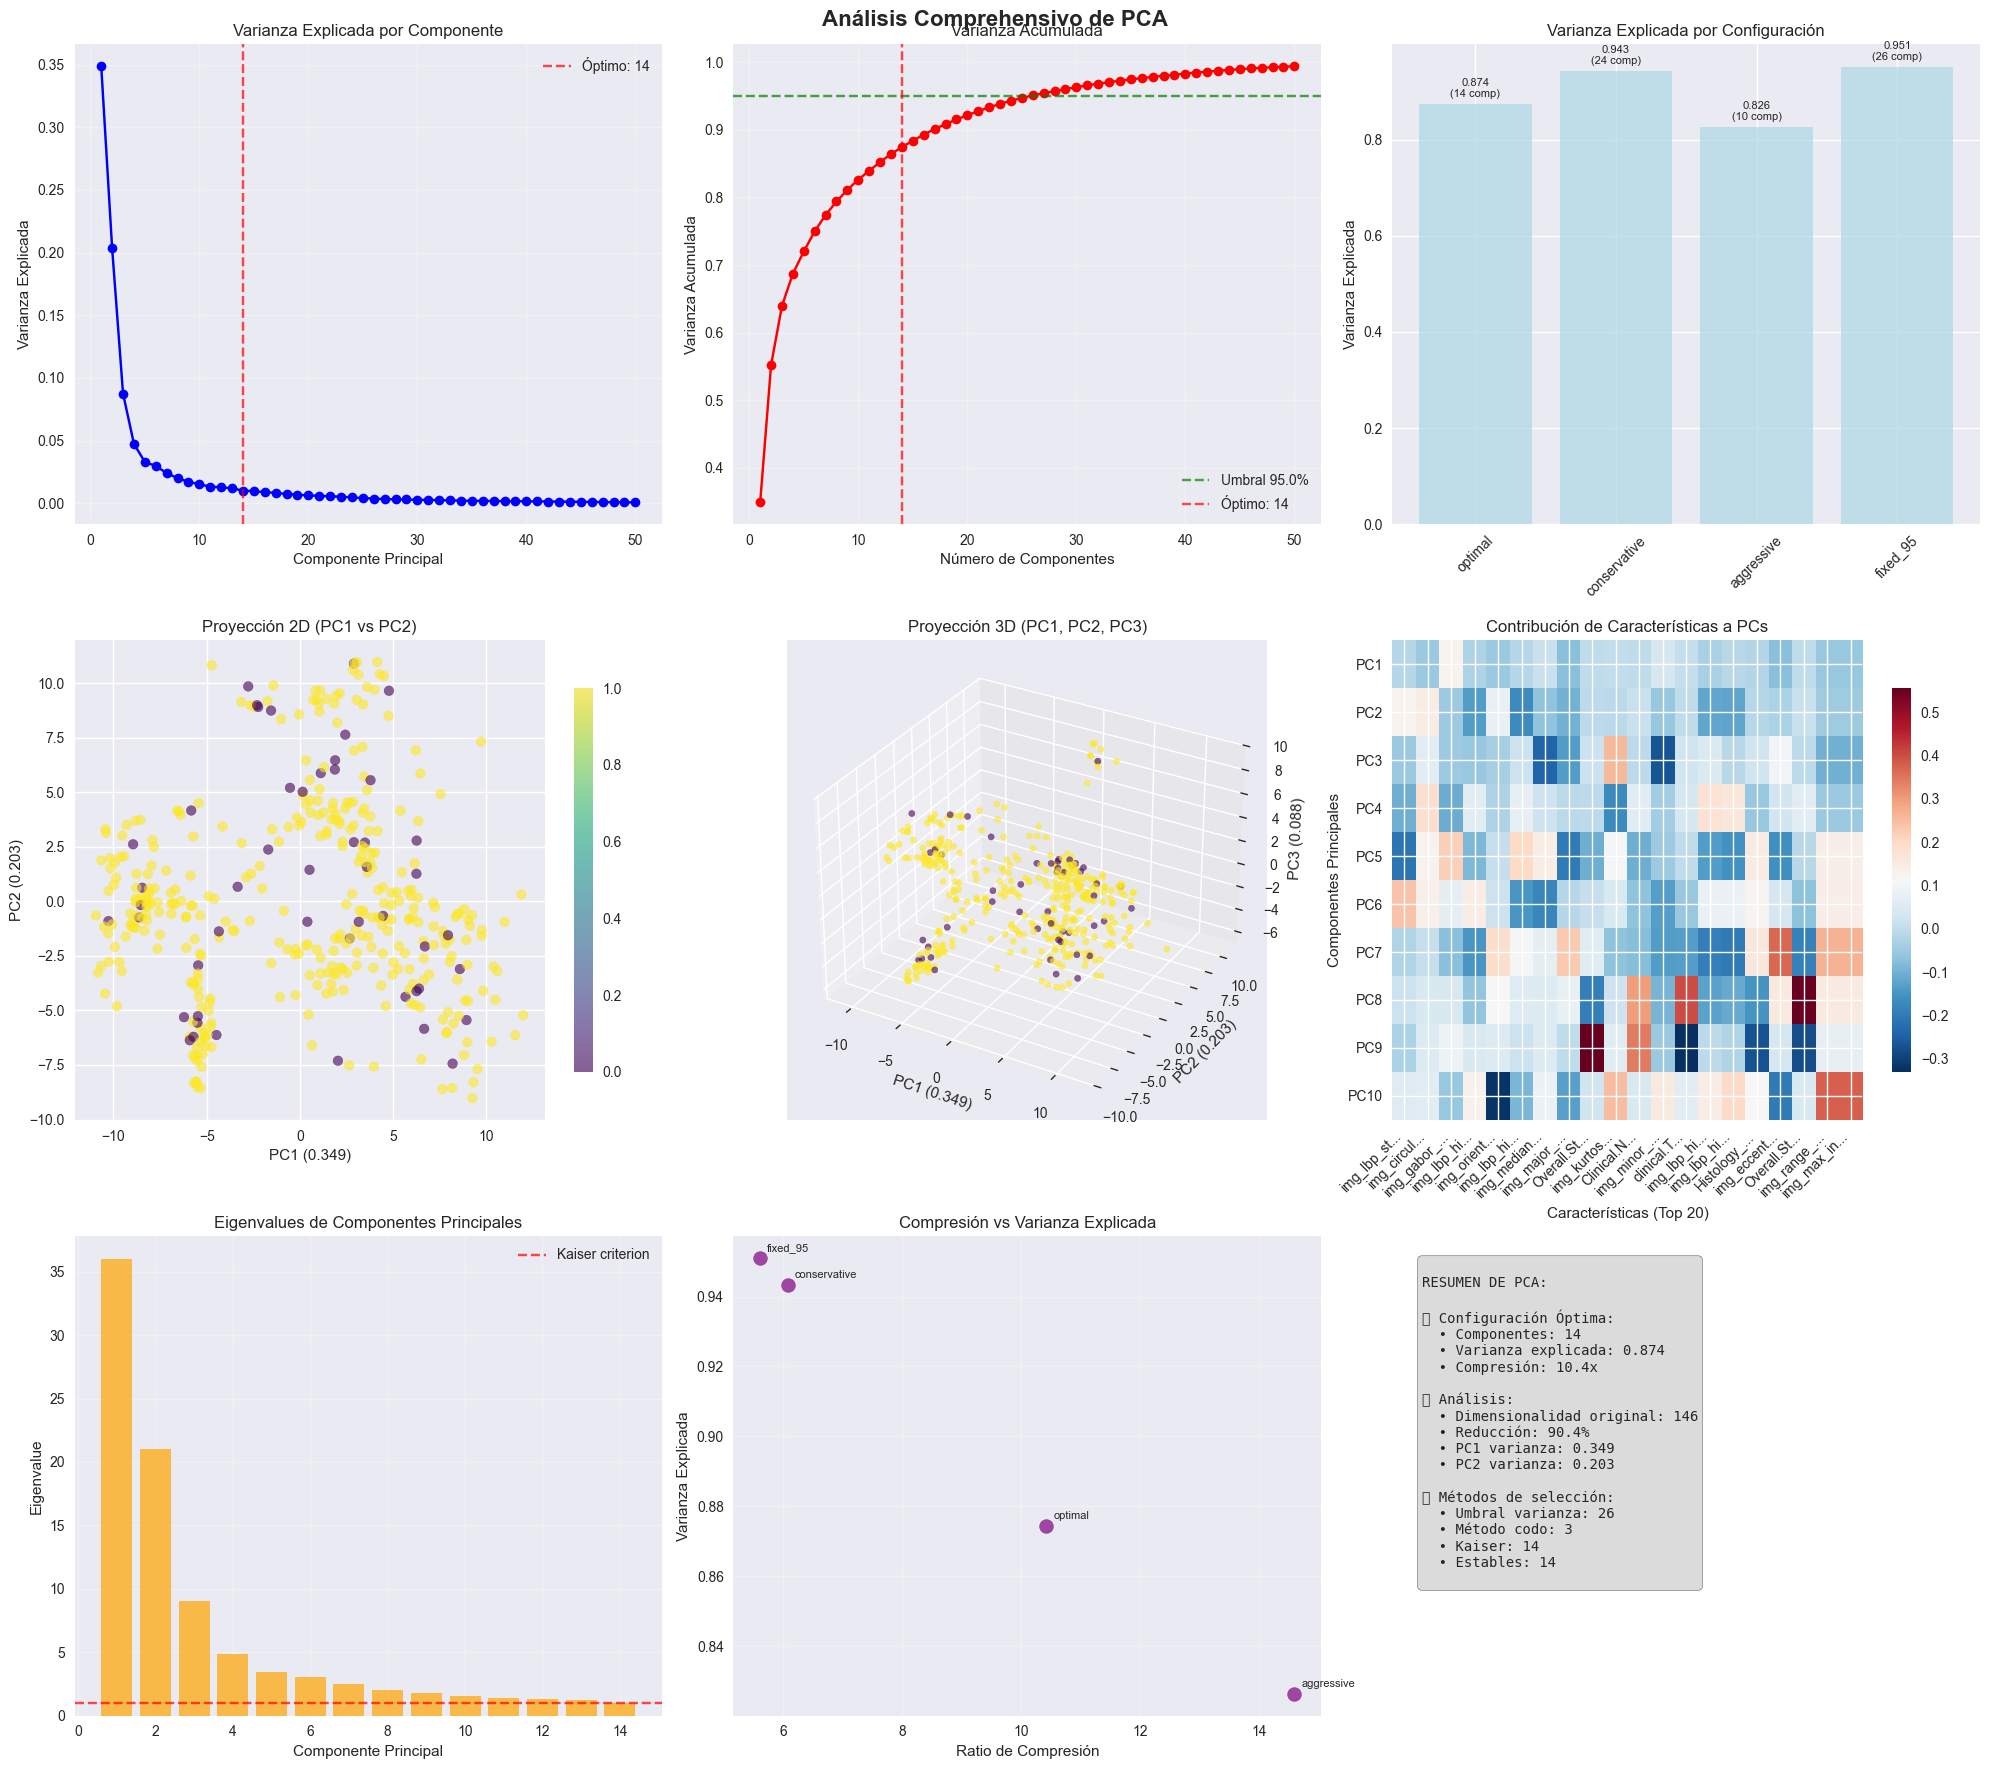

2025-07-14 04:02:46,963 - INFO - Análisis de PCA completado exitosamente



✓ Resultados de PCA guardados en: ./resultados/pca_results.pkl


In [20]:
def apply_pca_comprehensive(multimodal_results, config):
    """
    Aplica PCA con análisis exhaustivo de varianza y selección óptima de componentes
    
    Args:
        multimodal_results: Resultados del dataset multimodal
        config: Configuración del proyecto
    
    Returns:
        pca_results: Diccionario con resultados de PCA
    """
    
    print("="*60)
    print("REDUCCIÓN DE DIMENSIONALIDAD CON PCA")
    print("="*60)
    
    logger.info("Iniciando análisis de PCA")
    
    # ===== EXTRAER DATOS =====
    X_multimodal = multimodal_results['X_multimodal']
    y_multimodal = multimodal_results['y_multimodal']
    feature_names = multimodal_results['multimodal_feature_names']
    
    print(f"📊 Datos de entrada:")
    print(f"  Forma del dataset: {X_multimodal.shape}")
    print(f"  Características: {len(feature_names)}")
    print(f"  Muestras: {len(y_multimodal)}")
    
    # ===== PREPARACIÓN DE DATOS PARA PCA =====
    print(f"\n🔧 Preparando datos para PCA...")
    
    # Verificar si los datos ya están escalados
    data_mean = np.mean(X_multimodal)
    data_std = np.std(X_multimodal)
    
    print(f"  Media actual: {data_mean:.3f}")
    print(f"  Desviación estándar actual: {data_std:.3f}")
    
    # Aplicar escalado adicional si es necesario
    if abs(data_mean) > 0.1 or abs(data_std - 1.0) > 0.1:
        print(f"  Aplicando escalado adicional...")
        scaler_pca = StandardScaler()
        X_scaled = scaler_pca.fit_transform(X_multimodal)
        print(f"  Nueva media: {np.mean(X_scaled):.3f}")
        print(f"  Nueva desviación estándar: {np.std(X_scaled):.3f}")
    else:
        print(f"  Los datos ya están adecuadamente escalados")
        X_scaled = X_multimodal.copy()
        scaler_pca = None
    
    # ===== ANÁLISIS COMPLETO DE PCA =====
    print(f"\n📈 Realizando análisis completo de PCA...")
    
    # PCA completo para análisis de varianza
    pca_full = PCA()
    pca_full.fit(X_scaled)
    
    explained_variance_ratio = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    print(f"  Componentes totales: {len(explained_variance_ratio)}")
    print(f"  Varianza del primer componente: {explained_variance_ratio[0]:.3f}")
    print(f"  Varianza de los primeros 10 componentes: {cumulative_variance[9]:.3f}")
    
    # ===== SELECCIÓN ÓPTIMA DE COMPONENTES =====
    print(f"\n🎯 Selección óptima de componentes...")
    
    # Método 1: Umbral de varianza
    variance_threshold = config['dimensionality_reduction']['pca_variance_threshold']
    n_components_variance = np.argmax(cumulative_variance >= variance_threshold) + 1
    
    # Método 2: Regla del codo (elbow method)
    # Calcular segunda derivada para encontrar el codo
    if len(explained_variance_ratio) > 2:
        second_derivative = np.diff(explained_variance_ratio, 2)
        elbow_point = np.argmax(second_derivative) + 2  # +2 por las dos diferencias
    else:
        elbow_point = len(explained_variance_ratio)
    
    # Método 3: Criterio de Kaiser (eigenvalues > 1)
    eigenvalues = pca_full.explained_variance_
    kaiser_components = np.sum(eigenvalues > 1)
    
    # Método 4: Análisis de estabilidad
    # Componentes que explican al menos 1% de varianza
    min_variance_per_component = 0.01
    stable_components = np.sum(explained_variance_ratio >= min_variance_per_component)
    
    print(f"  Métodos de selección:")
    print(f"    Umbral {variance_threshold*100}% varianza: {n_components_variance} componentes")
    print(f"    Método del codo: {elbow_point} componentes")
    print(f"    Criterio de Kaiser: {kaiser_components} componentes")
    print(f"    Componentes estables (>1%): {stable_components} componentes")
    
    # Seleccionar número óptimo (usar el más conservador que sea razonable)
    candidate_components = [n_components_variance, elbow_point, kaiser_components, stable_components]
    candidate_components = [c for c in candidate_components if c > 0 and c <= X_scaled.shape[1]]
    
    if candidate_components:
        # Usar la mediana de los métodos como compromiso
        optimal_components = int(np.median(candidate_components))
        optimal_components = max(10, min(optimal_components, X_scaled.shape[1] // 2))  # Entre 10 y la mitad de características
    else:
        optimal_components = min(50, X_scaled.shape[1] // 2)
    
    print(f"  Número óptimo seleccionado: {optimal_components} componentes")
    print(f"  Varianza explicada: {cumulative_variance[optimal_components-1]:.3f}")
    
    # ===== APLICAR PCA CON DIFERENTES NÚMEROS DE COMPONENTES =====
    print(f"\n🔄 Aplicando PCA con diferentes configuraciones...")
    
    pca_configurations = {
        'optimal': optimal_components,
        'conservative': min(optimal_components + 10, X_scaled.shape[1]),
        'aggressive': max(optimal_components - 10, 10),
        'fixed_95': n_components_variance
    }
    
    pca_results_dict = {}
    
    for config_name, n_components in pca_configurations.items():
        if n_components <= X_scaled.shape[1] and n_components > 0:
            print(f"  Configuración '{config_name}': {n_components} componentes")
            
            # Aplicar PCA
            pca = PCA(n_components=n_components)
            X_pca = pca.fit_transform(X_scaled)
            
            # Calcular métricas
            variance_explained = np.sum(pca.explained_variance_ratio_)
            compression_ratio = X_scaled.shape[1] / n_components
            
            pca_results_dict[config_name] = {
                'pca_model': pca,
                'X_transformed': X_pca,
                'n_components': n_components,
                'variance_explained': variance_explained,
                'compression_ratio': compression_ratio,
                'explained_variance_ratio': pca.explained_variance_ratio_,
                'cumulative_variance': np.cumsum(pca.explained_variance_ratio_),
                'components': pca.components_,
                'eigenvalues': pca.explained_variance_
            }
            
            print(f"    Varianza explicada: {variance_explained:.3f}")
            print(f"    Ratio de compresión: {compression_ratio:.1f}x")
    
    # ===== ANÁLISIS DE COMPONENTES PRINCIPALES =====
    print(f"\n🔍 Análisis de componentes principales...")
    
    # Usar la configuración óptima para análisis detallado
    optimal_pca = pca_results_dict['optimal']
    pca_model = optimal_pca['pca_model']
    components = optimal_pca['components']
    
    # Analizar contribución de características originales a cada componente
    print(f"  Analizando contribución de características...")
    
    # Encontrar las características más importantes para cada componente
    n_top_features = 5
    component_analysis = {}
    
    for i in range(min(5, len(components))):  # Analizar primeros 5 componentes
        component_weights = np.abs(components[i])
        top_indices = np.argsort(component_weights)[-n_top_features:][::-1]
        top_features = [(feature_names[idx], component_weights[idx]) for idx in top_indices]
        
        component_analysis[f'PC{i+1}'] = {
            'variance_explained': optimal_pca['explained_variance_ratio'][i],
            'top_features': top_features
        }
        
        print(f"    PC{i+1} (varianza: {optimal_pca['explained_variance_ratio'][i]:.3f}):")
        for feature_name, weight in top_features:
            print(f"      {feature_name}: {weight:.3f}")
    
    # ===== CREAR VISUALIZACIONES COMPREHENSIVAS =====
    print(f"\n📊 Generando visualizaciones de PCA...")
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    fig.suptitle('Análisis Comprehensivo de PCA', fontsize=16, fontweight='bold')
    
    # 1. Varianza explicada por componente
    ax1 = axes[0, 0]
    n_components_to_plot = min(50, len(explained_variance_ratio))
    ax1.plot(range(1, n_components_to_plot + 1), explained_variance_ratio[:n_components_to_plot], 'bo-')
    ax1.set_title('Varianza Explicada por Componente')
    ax1.set_xlabel('Componente Principal')
    ax1.set_ylabel('Varianza Explicada')
    ax1.grid(True, alpha=0.3)
    
    # Marcar punto óptimo
    ax1.axvline(optimal_components, color='red', linestyle='--', alpha=0.7, 
               label=f'Óptimo: {optimal_components}')
    ax1.legend()
    
    # 2. Varianza acumulada
    ax2 = axes[0, 1]
    ax2.plot(range(1, n_components_to_plot + 1), cumulative_variance[:n_components_to_plot], 'ro-')
    ax2.axhline(y=variance_threshold, color='green', linestyle='--', alpha=0.7, 
               label=f'Umbral {variance_threshold*100}%')
    ax2.axvline(optimal_components, color='red', linestyle='--', alpha=0.7, 
               label=f'Óptimo: {optimal_components}')
    ax2.set_title('Varianza Acumulada')
    ax2.set_xlabel('Número de Componentes')
    ax2.set_ylabel('Varianza Acumulada')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # 3. Comparación de configuraciones
    ax3 = axes[0, 2]
    config_names = list(pca_results_dict.keys())
    config_variances = [pca_results_dict[name]['variance_explained'] for name in config_names]
    config_components = [pca_results_dict[name]['n_components'] for name in config_names]
    
    bars = ax3.bar(config_names, config_variances, color='lightblue', alpha=0.7)
    ax3.set_title('Varianza Explicada por Configuración')
    ax3.set_ylabel('Varianza Explicada')
    ax3.tick_params(axis='x', rotation=45)
    
    # Añadir etiquetas con número de componentes
    for bar, variance, n_comp in zip(bars, config_variances, config_components):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{variance:.3f}\n({n_comp} comp)', ha='center', va='bottom', fontsize=8)
    
    # 4. Proyección 2D de los datos (primeros 2 componentes)
    ax4 = axes[1, 0]
    X_pca_optimal = optimal_pca['X_transformed']
    
    if X_pca_optimal.shape[1] >= 2:
        scatter = ax4.scatter(X_pca_optimal[:, 0], X_pca_optimal[:, 1], 
                             c=y_multimodal, cmap='viridis', alpha=0.6)
        ax4.set_title('Proyección 2D (PC1 vs PC2)')
        ax4.set_xlabel(f'PC1 ({optimal_pca["explained_variance_ratio"][0]:.3f})')
        ax4.set_ylabel(f'PC2 ({optimal_pca["explained_variance_ratio"][1]:.3f})')
        plt.colorbar(scatter, ax=ax4, shrink=0.8)
    
    # 5. Proyección 3D si hay al menos 3 componentes
    ax5 = axes[1, 1]
    if X_pca_optimal.shape[1] >= 3:
        ax5.remove()
        ax5 = fig.add_subplot(3, 3, 5, projection='3d')
        scatter_3d = ax5.scatter(X_pca_optimal[:, 0], X_pca_optimal[:, 1], X_pca_optimal[:, 2],
                                c=y_multimodal, cmap='viridis', alpha=0.6)
        ax5.set_title('Proyección 3D (PC1, PC2, PC3)')
        ax5.set_xlabel(f'PC1 ({optimal_pca["explained_variance_ratio"][0]:.3f})')
        ax5.set_ylabel(f'PC2 ({optimal_pca["explained_variance_ratio"][1]:.3f})')
        ax5.set_zlabel(f'PC3 ({optimal_pca["explained_variance_ratio"][2]:.3f})')
    else:
        ax5.text(0.5, 0.5, 'Insuficientes componentes\npara proyección 3D', 
                ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Proyección 3D')
    
    # 6. Heatmap de componentes principales (contribución de características)
    ax6 = axes[1, 2]
    if len(components) > 0:
        n_components_heatmap = min(10, len(components))
        n_features_heatmap = min(20, len(feature_names))
        
        # Seleccionar las características más importantes globalmente
        global_importance = np.sum(np.abs(components[:n_components_heatmap]), axis=0)
        top_feature_indices = np.argsort(global_importance)[-n_features_heatmap:]
        
        heatmap_data = components[:n_components_heatmap, top_feature_indices]
        
        im = ax6.imshow(heatmap_data, cmap='RdBu_r', aspect='auto')
        ax6.set_title('Contribución de Características a PCs')
        ax6.set_xlabel('Características (Top 20)')
        ax6.set_ylabel('Componentes Principales')
        ax6.set_yticks(range(n_components_heatmap))
        ax6.set_yticklabels([f'PC{i+1}' for i in range(n_components_heatmap)])
        
        # Etiquetas de características (abreviadas)
        feature_labels = [feature_names[i][:10] + '...' if len(feature_names[i]) > 10 
                         else feature_names[i] for i in top_feature_indices]
        ax6.set_xticks(range(len(feature_labels)))
        ax6.set_xticklabels(feature_labels, rotation=45, ha='right')
        
        plt.colorbar(im, ax=ax6, shrink=0.8)
    
    # 7. Distribución de eigenvalues
    ax7 = axes[2, 0]
    eigenvalues = optimal_pca['eigenvalues']
    ax7.bar(range(1, len(eigenvalues) + 1), eigenvalues, alpha=0.7, color='orange')
    ax7.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Kaiser criterion')
    ax7.set_title('Eigenvalues de Componentes Principales')
    ax7.set_xlabel('Componente Principal')
    ax7.set_ylabel('Eigenvalue')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # 8. Ratio de compresión vs varianza explicada
    ax8 = axes[2, 1]
    compression_ratios = [pca_results_dict[name]['compression_ratio'] for name in config_names]
    
    ax8.scatter(compression_ratios, config_variances, s=100, alpha=0.7, color='purple')
    for i, name in enumerate(config_names):
        ax8.annotate(name, (compression_ratios[i], config_variances[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax8.set_title('Compresión vs Varianza Explicada')
    ax8.set_xlabel('Ratio de Compresión')
    ax8.set_ylabel('Varianza Explicada')
    ax8.grid(True, alpha=0.3)
    
    # 9. Resumen de PCA
    ax9 = axes[2, 2]
    ax9.axis('off')
    
    summary_text = f"""
RESUMEN DE PCA:

📊 Configuración Óptima:
  • Componentes: {optimal_components}
  • Varianza explicada: {optimal_pca['variance_explained']:.3f}
  • Compresión: {optimal_pca['compression_ratio']:.1f}x

📈 Análisis:
  • Dimensionalidad original: {X_scaled.shape[1]}
  • Reducción: {(1 - optimal_components/X_scaled.shape[1])*100:.1f}%
  • PC1 varianza: {optimal_pca['explained_variance_ratio'][0]:.3f}
  • PC2 varianza: {optimal_pca['explained_variance_ratio'][1]:.3f}

🎯 Métodos de selección:
  • Umbral varianza: {n_components_variance}
  • Método codo: {elbow_point}
  • Kaiser: {kaiser_components}
  • Estables: {stable_components}
    """
    
    ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    
    # Guardar visualización
    if config['visualization']['save_plots']:
        plot_path = os.path.join(config['paths']['plots_folder'], 
                                f'pca_comprehensive_analysis.{config["visualization"]["plot_format"]}')
        plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
        print(f"  ✓ Visualización guardada en: {plot_path}")
    
    plt.show()
    
    # ===== COMPILAR RESULTADOS FINALES =====
    final_pca_results = {
        'pca_configurations': pca_results_dict,
        'optimal_configuration': 'optimal',
        'optimal_pca_model': optimal_pca['pca_model'],
        'X_pca_optimal': optimal_pca['X_transformed'],
        'scaler_pca': scaler_pca,
        'selection_methods': {
            'variance_threshold': n_components_variance,
            'elbow_method': elbow_point,
            'kaiser_criterion': kaiser_components,
            'stable_components': stable_components,
            'optimal_selected': optimal_components
        },
        'component_analysis': component_analysis,
        'full_analysis': {
            'explained_variance_ratio_full': explained_variance_ratio,
            'cumulative_variance_full': cumulative_variance,
            'eigenvalues_full': pca_full.explained_variance_
        }
    }
    
    # Guardar resultados de PCA
    pca_path = os.path.join(config['paths']['output_folder'], 'pca_results.pkl')
    with open(pca_path, 'wb') as f:
        pickle.dump(final_pca_results, f)
    
    print(f"\n✓ Resultados de PCA guardados en: {pca_path}")
    
    logger.info("Análisis de PCA completado exitosamente")
    
    return final_pca_results

# ===== EJECUTAR ANÁLISIS DE PCA =====
pca_results = apply_pca_comprehensive(multimodal_results, CONFIG)


## 7. Selección de características con múltiples métodos


2025-07-14 04:07:05,441 - INFO - Iniciando selección de características


SELECCIÓN DE CARACTERÍSTICAS CON MÚLTIPLES MÉTODOS
📊 Datos disponibles:
  Dataset original: (412, 146)
  Dataset con PCA: (412, 14)
  Características originales: 146

🎯 Configuración de selección:
  Método principal: univariate
  Características objetivo: 50

📊 Método 1: Selección Univariada (ANOVA F-test)...
  Seleccionando top 20 características...
    Score promedio: 18.04
    Top 3 características: ['age', 'Survival.time', 'Overall.Stage_IIIb']
  Seleccionando top 50 características...
    Score promedio: 7.61
    Top 3 características: ['age', 'clinical.T.Stage', 'Clinical.N.Stage']
  Seleccionando top 100 características...
    Score promedio: 3.84
    Top 3 características: ['age', 'clinical.T.Stage', 'Clinical.N.Stage']
  Seleccionando top 50 características...
    Score promedio: 7.61
    Top 3 características: ['age', 'clinical.T.Stage', 'Clinical.N.Stage']

🔄 Método 2: Eliminación Recursiva (RFE)...
  RFE con random_forest...
    Características óptimas: 12
    Mejor score C

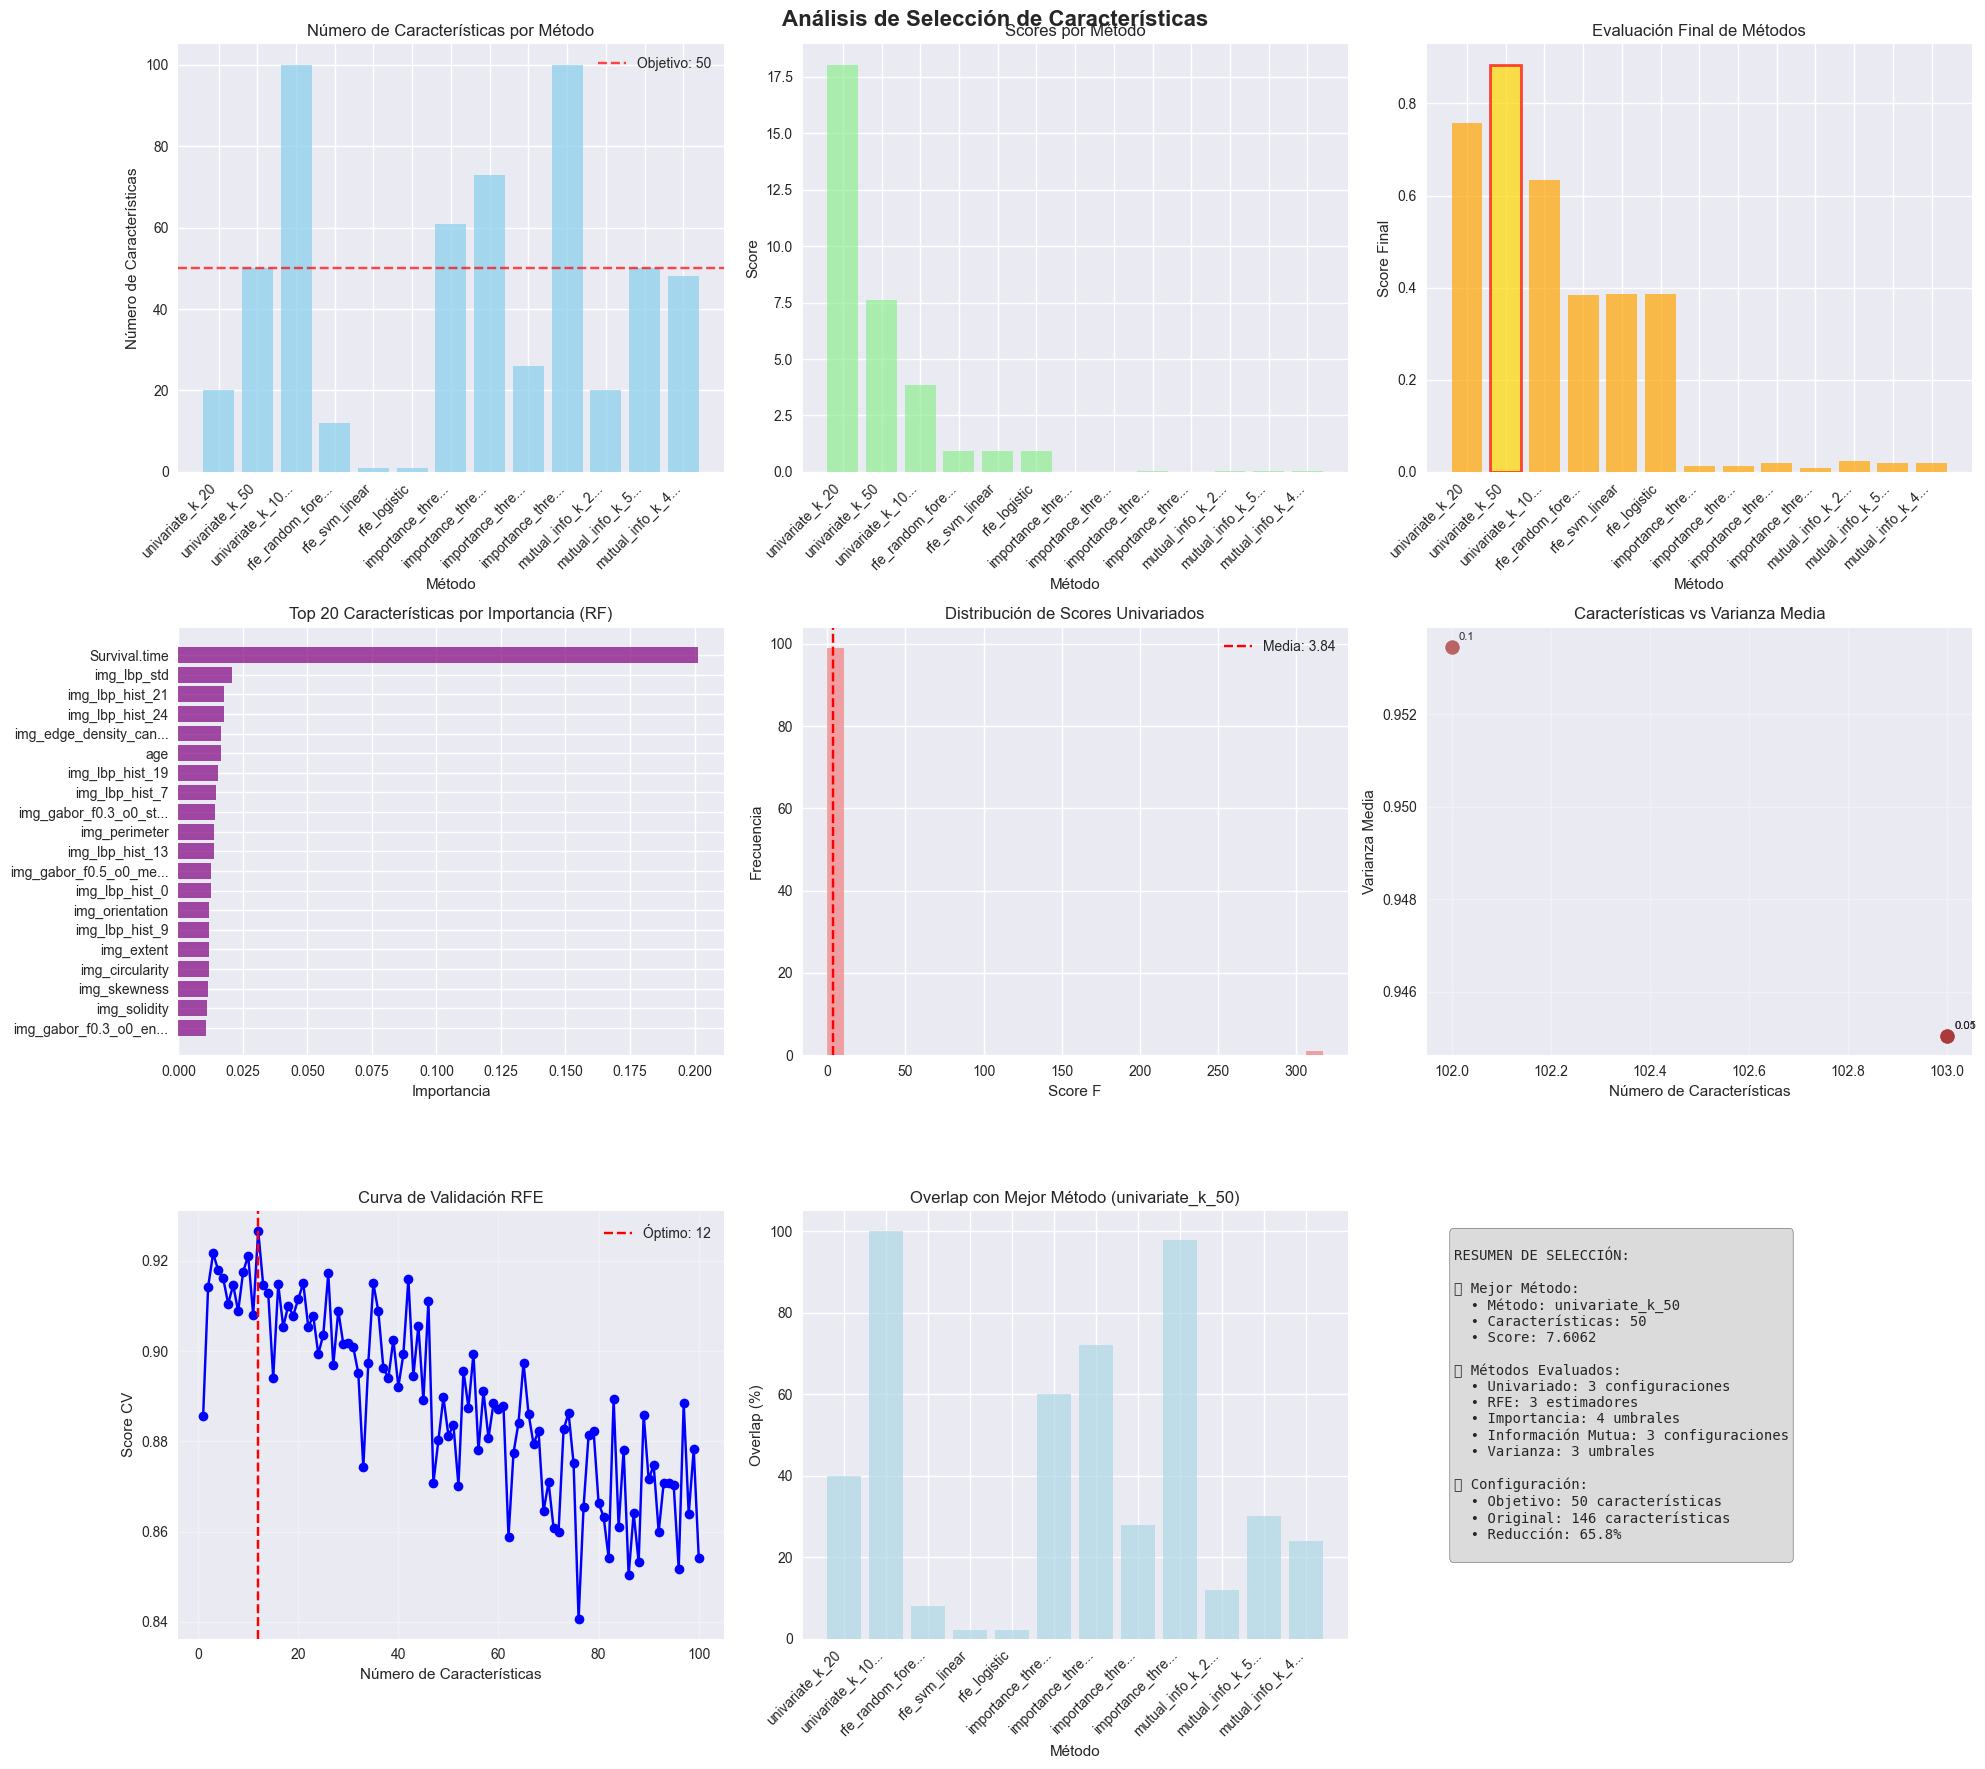

2025-07-14 04:09:14,168 - INFO - Selección de características completada exitosamente



✓ Resultados de selección guardados en: ./resultados/feature_selection_results.pkl


In [21]:
def feature_selection_comprehensive(multimodal_results, pca_results, config):
    """
    Selección de características usando múltiples métodos y comparación de resultados
    
    Args:
        multimodal_results: Resultados del dataset multimodal
        pca_results: Resultados del análisis de PCA
        config: Configuración del proyecto
    
    Returns:
        feature_selection_results: Diccionario con resultados de selección
    """
    
    print("="*60)
    print("SELECCIÓN DE CARACTERÍSTICAS CON MÚLTIPLES MÉTODOS")
    print("="*60)
    
    logger.info("Iniciando selección de características")
    
    # ===== EXTRAER DATOS =====
    X_multimodal = multimodal_results['X_multimodal']
    y_multimodal = multimodal_results['y_multimodal']
    feature_names = multimodal_results['multimodal_feature_names']
    
    # También usar datos con PCA si está disponible
    X_pca = pca_results['X_pca_optimal']
    
    print(f"📊 Datos disponibles:")
    print(f"  Dataset original: {X_multimodal.shape}")
    print(f"  Dataset con PCA: {X_pca.shape}")
    print(f"  Características originales: {len(feature_names)}")
    
    # ===== CONFIGURACIÓN DE SELECCIÓN =====
    selection_config = config['dimensionality_reduction']
    target_features = selection_config['n_features_to_select']
    
    print(f"\n🎯 Configuración de selección:")
    print(f"  Método principal: {selection_config['feature_selection_method']}")
    print(f"  Características objetivo: {target_features}")
    
    # ===== MÉTODO 1: SELECCIÓN UNIVARIADA =====
    print(f"\n📊 Método 1: Selección Univariada (ANOVA F-test)...")
    
    # Probar diferentes números de características
    k_values = [20, 50, 100, min(target_features, X_multimodal.shape[1]//2)]
    k_values = [k for k in k_values if k <= X_multimodal.shape[1]]
    
    univariate_results = {}
    
    for k in k_values:
        print(f"  Seleccionando top {k} características...")
        
        # Aplicar selección univariada
        selector_univariate = SelectKBest(f_classif, k=k)
        X_selected = selector_univariate.fit_transform(X_multimodal, y_multimodal)
        
        # Obtener información de características seleccionadas
        selected_indices = selector_univariate.get_support(indices=True)
        selected_features = [feature_names[i] for i in selected_indices]
        feature_scores = selector_univariate.scores_[selected_indices]
        
        # Calcular métricas de calidad
        total_score = np.sum(feature_scores)
        mean_score = np.mean(feature_scores)
        
        univariate_results[f'k_{k}'] = {
            'selector': selector_univariate,
            'X_selected': X_selected,
            'selected_indices': selected_indices,
            'selected_features': selected_features,
            'feature_scores': feature_scores,
            'total_score': total_score,
            'mean_score': mean_score,
            'n_features': k
        }
        
        print(f"    Score promedio: {mean_score:.2f}")
        print(f"    Top 3 características: {selected_features[:3]}")
    
    # ===== MÉTODO 2: ELIMINACIÓN RECURSIVA DE CARACTERÍSTICAS (RFE) =====
    print(f"\n🔄 Método 2: Eliminación Recursiva (RFE)...")
    
    # Usar diferentes estimadores para RFE
    rfe_estimators = {
        'random_forest': RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
        'svm_linear': SVC(kernel='linear', random_state=42),
        'logistic': LogisticRegression(random_state=42, max_iter=1000)
    }
    
    rfe_results = {}
    
    for estimator_name, estimator in rfe_estimators.items():
        print(f"  RFE con {estimator_name}...")
        
        try:
            # Aplicar RFE con validación cruzada
            rfe_cv = RFECV(
                estimator=estimator,
                step=1,
                cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
                scoring='f1_weighted',
                n_jobs=-1
            )
            
            # Limitar el número máximo de características para eficiencia
            max_features_rfe = min(100, X_multimodal.shape[1])
            X_rfe_input = X_multimodal[:, :max_features_rfe]
            feature_names_rfe = feature_names[:max_features_rfe]
            
            rfe_cv.fit(X_rfe_input, y_multimodal)
            
            # Obtener características seleccionadas
            selected_indices_rfe = rfe_cv.get_support(indices=True)
            selected_features_rfe = [feature_names_rfe[i] for i in selected_indices_rfe]
            
            # Transformar datos
            X_rfe_selected = rfe_cv.transform(X_rfe_input)
            
            rfe_results[estimator_name] = {
                'rfe_model': rfe_cv,
                'X_selected': X_rfe_selected,
                'selected_indices': selected_indices_rfe,
                'selected_features': selected_features_rfe,
                'n_features_optimal': rfe_cv.n_features_,
                'cv_scores': rfe_cv.cv_results_['mean_test_score'],
                'best_score': np.max(rfe_cv.cv_results_['mean_test_score'])
            }
            
            print(f"    Características óptimas: {rfe_cv.n_features_}")
            print(f"    Mejor score CV: {np.max(rfe_cv.cv_results_['mean_test_score']):.3f}")
            
        except Exception as e:
            print(f"    Error con {estimator_name}: {e}")
            rfe_results[estimator_name] = None
    
    # ===== MÉTODO 3: SELECCIÓN BASADA EN IMPORTANCIA =====
    print(f"\n🌳 Método 3: Selección basada en Importancia...")
    
    # Usar Random Forest para obtener importancias
    rf_importance = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1
    )
    rf_importance.fit(X_multimodal, y_multimodal)
    
    # Selección basada en importancia
    importance_thresholds = ['mean', 'median', 0.01, 0.001]  # Use floats, not strings
    importance_results = {}
    
    for threshold in importance_thresholds:
        print(f"  Umbral de importancia: {threshold}...")
        
        selector_importance = SelectFromModel(
            rf_importance, 
            threshold=threshold,
            prefit=True
        )
        
        X_importance_selected = selector_importance.transform(X_multimodal)
        selected_indices_imp = selector_importance.get_support(indices=True)
        selected_features_imp = [feature_names[i] for i in selected_indices_imp]
        feature_importances = rf_importance.feature_importances_[selected_indices_imp]
        
        importance_results[f'threshold_{threshold}'] = {
            'selector': selector_importance,
            'X_selected': X_importance_selected,
            'selected_indices': selected_indices_imp,
            'selected_features': selected_features_imp,
            'feature_importances': feature_importances,
            'n_features': len(selected_features_imp),
            'mean_importance': np.mean(feature_importances)
        }
        
        print(f"    Características seleccionadas: {len(selected_features_imp)}")
        print(f"    Importancia promedio: {np.mean(feature_importances):.4f}")
    
    # ===== MÉTODO 4: SELECCIÓN BASADA EN VARIANZA =====
    print(f"\n📈 Método 4: Selección basada en Varianza...")
    
    # Eliminar características con baja varianza
    variance_thresholds = [0.01, 0.05, 0.1]
    variance_results = {}
    
    for threshold in variance_thresholds:
        print(f"  Umbral de varianza: {threshold}...")
        
        selector_variance = VarianceThreshold(threshold=threshold)
        X_variance_selected = selector_variance.fit_transform(X_multimodal)
        
        selected_indices_var = selector_variance.get_support(indices=True)
        selected_features_var = [feature_names[i] for i in selected_indices_var]
        feature_variances = np.var(X_multimodal[:, selected_indices_var], axis=0)
        
        variance_results[f'threshold_{threshold}'] = {
            'selector': selector_variance,
            'X_selected': X_variance_selected,
            'selected_indices': selected_indices_var,
            'selected_features': selected_features_var,
            'feature_variances': feature_variances,
            'n_features': len(selected_features_var),
            'mean_variance': np.mean(feature_variances)
        }
        
        print(f"    Características seleccionadas: {len(selected_features_var)}")
        print(f"    Varianza promedio: {np.mean(feature_variances):.4f}")
    
    # ===== MÉTODO 5: INFORMACIÓN MUTUA =====
    print(f"\n🔗 Método 5: Información Mutua...")
    
    # Selección basada en información mutua
    mi_k_values = [20, 50, min(target_features, X_multimodal.shape[1]//3)]
    mi_k_values = [k for k in mi_k_values if k <= X_multimodal.shape[1]]
    
    mutual_info_results = {}
    
    for k in mi_k_values:
        print(f"  Seleccionando top {k} características por MI...")
        
        try:
            selector_mi = SelectKBest(mutual_info_classif, k=k)
            X_mi_selected = selector_mi.fit_transform(X_multimodal, y_multimodal)
            
            selected_indices_mi = selector_mi.get_support(indices=True)
            selected_features_mi = [feature_names[i] for i in selected_indices_mi]
            mi_scores = selector_mi.scores_[selected_indices_mi]
            
            mutual_info_results[f'k_{k}'] = {
                'selector': selector_mi,
                'X_selected': X_mi_selected,
                'selected_indices': selected_indices_mi,
                'selected_features': selected_features_mi,
                'mi_scores': mi_scores,
                'mean_mi_score': np.mean(mi_scores),
                'n_features': k
            }
            
            print(f"    Score MI promedio: {np.mean(mi_scores):.4f}")
            
        except Exception as e:
            print(f"    Error calculando MI para k={k}: {e}")
    
    # ===== COMPARACIÓN Y SELECCIÓN DEL MEJOR MÉTODO =====
    print(f"\n🏆 Comparación de métodos de selección...")
    
    # Recopilar todos los resultados
    all_methods = {}
    
    # Añadir resultados univariados
    for k, result in univariate_results.items():
        all_methods[f'univariate_{k}'] = {
            'method': 'univariate',
            'X_selected': result['X_selected'],
            'selected_features': result['selected_features'],
            'n_features': result['n_features'],
            'score': result['mean_score'],
            'selector': result['selector']
        }
    
    # Añadir resultados RFE
    for estimator, result in rfe_results.items():
        if result is not None:
            all_methods[f'rfe_{estimator}'] = {
                'method': 'rfe',
                'X_selected': result['X_selected'],
                'selected_features': result['selected_features'],
                'n_features': result['n_features_optimal'],
                'score': result['best_score'],
                'selector': result['rfe_model']
            }
    
    # Añadir resultados de importancia
    for threshold, result in importance_results.items():
        all_methods[f'importance_{threshold}'] = {
            'method': 'importance',
            'X_selected': result['X_selected'],
            'selected_features': result['selected_features'],
            'n_features': result['n_features'],
            'score': result['mean_importance'],
            'selector': result['selector']
        }
    
    # Añadir resultados de información mutua
    for k, result in mutual_info_results.items():
        all_methods[f'mutual_info_{k}'] = {
            'method': 'mutual_info',
            'X_selected': result['X_selected'],
            'selected_features': result['selected_features'],
            'n_features': result['n_features'],
            'score': result['mean_mi_score'],
            'selector': result['selector']
        }
    
    # Seleccionar el mejor método basado en criterios múltiples
    print(f"  Evaluando métodos...")
    
    method_evaluation = {}
    for method_name, method_data in all_methods.items():
        n_features = method_data['n_features']
        score = method_data['score']
        
        # Criterio de evaluación: balance entre número de características y score
        # Penalizar métodos con demasiadas o muy pocas características
        optimal_range = (target_features * 0.5, target_features * 1.5)
        
        if optimal_range[0] <= n_features <= optimal_range[1]:
            range_penalty = 1.0
        else:
            range_penalty = 0.8
        
        # Score normalizado (aproximado)
        normalized_score = score / (1 + score) if score > 0 else 0
        
        # Score final combinado
        final_score = normalized_score * range_penalty
        
        method_evaluation[method_name] = {
            'final_score': final_score,
            'original_score': score,
            'n_features': n_features,
            'range_penalty': range_penalty
        }
        
        print(f"    {method_name}: {n_features} características, score: {score:.4f}, final: {final_score:.4f}")
    
    # Seleccionar el mejor método
    best_method_name = max(method_evaluation.keys(), key=lambda x: method_evaluation[x]['final_score'])
    best_method_data = all_methods[best_method_name]
    
    print(f"\n🥇 Mejor método seleccionado: {best_method_name}")
    print(f"  Características: {best_method_data['n_features']}")
    print(f"  Score: {best_method_data['score']:.4f}")
    
    # ===== CREAR VISUALIZACIONES =====
    print(f"\n📊 Generando visualizaciones de selección de características...")
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    fig.suptitle('Análisis de Selección de Características', fontsize=16, fontweight='bold')
    
    # 1. Comparación de número de características por método
    ax1 = axes[0, 0]
    method_names = list(all_methods.keys())
    n_features_list = [all_methods[name]['n_features'] for name in method_names]
    
    bars = ax1.bar(range(len(method_names)), n_features_list, alpha=0.7, color='skyblue')
    ax1.set_title('Número de Características por Método')
    ax1.set_xlabel('Método')
    ax1.set_ylabel('Número de Características')
    ax1.set_xticks(range(len(method_names)))
    ax1.set_xticklabels([name[:15] + '...' if len(name) > 15 else name for name in method_names], 
                       rotation=45, ha='right')
    
    # Línea de referencia
    ax1.axhline(y=target_features, color='red', linestyle='--', alpha=0.7, 
               label=f'Objetivo: {target_features}')
    ax1.legend()
    
    # 2. Scores por método
    ax2 = axes[0, 1]
    scores_list = [all_methods[name]['score'] for name in method_names]
    
    bars = ax2.bar(range(len(method_names)), scores_list, alpha=0.7, color='lightgreen')
    ax2.set_title('Scores por Método')
    ax2.set_xlabel('Método')
    ax2.set_ylabel('Score')
    ax2.set_xticks(range(len(method_names)))
    ax2.set_xticklabels([name[:15] + '...' if len(name) > 15 else name for name in method_names], 
                       rotation=45, ha='right')
    
    # 3. Evaluación final de métodos
    ax3 = axes[0, 2]
    final_scores = [method_evaluation[name]['final_score'] for name in method_names]
    
    bars = ax3.bar(range(len(method_names)), final_scores, alpha=0.7, color='orange')
    ax3.set_title('Evaluación Final de Métodos')
    ax3.set_xlabel('Método')
    ax3.set_ylabel('Score Final')
    ax3.set_xticks(range(len(method_names)))
    ax3.set_xticklabels([name[:15] + '...' if len(name) > 15 else name for name in method_names], 
                       rotation=45, ha='right')
    
    # Destacar el mejor método
    best_index = method_names.index(best_method_name)
    bars[best_index].set_color('gold')
    bars[best_index].set_edgecolor('red')
    bars[best_index].set_linewidth(2)
    
    # 4. Importancias de características (Random Forest)
    ax4 = axes[1, 0]
    if len(rf_importance.feature_importances_) > 0:
        # Mostrar top 20 características más importantes
        top_indices = np.argsort(rf_importance.feature_importances_)[-20:][::-1]
        top_importances = rf_importance.feature_importances_[top_indices]
        top_feature_names = [feature_names[i] for i in top_indices]
        
        bars = ax4.barh(range(len(top_importances)), top_importances, alpha=0.7, color='purple')
        ax4.set_title('Top 20 Características por Importancia (RF)')
        ax4.set_xlabel('Importancia')
        ax4.set_yticks(range(len(top_importances)))
        ax4.set_yticklabels([name[:20] + '...' if len(name) > 20 else name for name in top_feature_names])
        ax4.invert_yaxis()
    
    # 5. Distribución de scores univariados
    ax5 = axes[1, 1]
    if univariate_results:
        # Usar el resultado con más características para mostrar distribución
        largest_k = max(univariate_results.keys(), key=lambda x: univariate_results[x]['n_features'])
        scores = univariate_results[largest_k]['feature_scores']
        
        ax5.hist(scores, bins=30, alpha=0.7, color='lightcoral')
        ax5.set_title('Distribución de Scores Univariados')
        ax5.set_xlabel('Score F')
        ax5.set_ylabel('Frecuencia')
        ax5.axvline(np.mean(scores), color='red', linestyle='--', label=f'Media: {np.mean(scores):.2f}')
        ax5.legend()
    
    # 6. Comparación de varianzas
    ax6 = axes[1, 2]
    if variance_results:
        threshold_names = list(variance_results.keys())
        n_features_var = [variance_results[name]['n_features'] for name in threshold_names]
        mean_variances = [variance_results[name]['mean_variance'] for name in threshold_names]
        
        ax6.scatter(n_features_var, mean_variances, s=100, alpha=0.7, color='brown')
        for i, name in enumerate(threshold_names):
            ax6.annotate(name.replace('threshold_', ''), 
                        (n_features_var[i], mean_variances[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        ax6.set_title('Características vs Varianza Media')
        ax6.set_xlabel('Número de Características')
        ax6.set_ylabel('Varianza Media')
        ax6.grid(True, alpha=0.3)
    
    # 7. Curva de validación RFE (si está disponible)
    ax7 = axes[2, 0]
    if rfe_results and any(result is not None for result in rfe_results.values()):
        # Usar el primer resultado válido de RFE
        valid_rfe = next(result for result in rfe_results.values() if result is not None)
        cv_scores = valid_rfe['cv_scores']
        
        ax7.plot(range(1, len(cv_scores) + 1), cv_scores, 'bo-')
        ax7.set_title('Curva de Validación RFE')
        ax7.set_xlabel('Número de Características')
        ax7.set_ylabel('Score CV')
        ax7.grid(True, alpha=0.3)
        
        # Marcar el óptimo
        best_n = valid_rfe['n_features_optimal']
        ax7.axvline(best_n, color='red', linestyle='--', 
                   label=f'Óptimo: {best_n}')
        ax7.legend()
    else:
        ax7.text(0.5, 0.5, 'RFE no disponible', ha='center', va='center', transform=ax7.transAxes)
        ax7.set_title('Curva de Validación RFE')
    
    # 8. Overlap entre métodos
    ax8 = axes[2, 1]
    if len(all_methods) >= 2:
        # Calcular overlap entre el mejor método y otros métodos principales
        best_features = set(best_method_data['selected_features'])
        
        overlaps = {}
        for method_name, method_data in all_methods.items():
            if method_name != best_method_name:
                other_features = set(method_data['selected_features'])
                overlap = len(best_features.intersection(other_features))
                overlap_pct = overlap / len(best_features) * 100
                overlaps[method_name] = overlap_pct
        
        if overlaps:
            method_names_overlap = list(overlaps.keys())
            overlap_values = list(overlaps.values())
            
            bars = ax8.bar(range(len(method_names_overlap)), overlap_values, 
                          alpha=0.7, color='lightblue')
            ax8.set_title(f'Overlap con Mejor Método ({best_method_name})')
            ax8.set_xlabel('Método')
            ax8.set_ylabel('Overlap (%)')
            ax8.set_xticks(range(len(method_names_overlap)))
            ax8.set_xticklabels([name[:15] + '...' if len(name) > 15 else name 
                               for name in method_names_overlap], 
                               rotation=45, ha='right')
    else:
        ax8.text(0.5, 0.5, 'Insuficientes métodos\npara comparar overlap', 
                ha='center', va='center', transform=ax8.transAxes)
        ax8.set_title('Overlap entre Métodos')
    
    # 9. Resumen de selección
    ax9 = axes[2, 2]
    ax9.axis('off')
    
    summary_text = f"""
RESUMEN DE SELECCIÓN:

🏆 Mejor Método:
  • Método: {best_method_name}
  • Características: {best_method_data['n_features']}
  • Score: {best_method_data['score']:.4f}

📊 Métodos Evaluados:
  • Univariado: {len(univariate_results)} configuraciones
  • RFE: {len([r for r in rfe_results.values() if r is not None])} estimadores
  • Importancia: {len(importance_results)} umbrales
  • Información Mutua: {len(mutual_info_results)} configuraciones
  • Varianza: {len(variance_results)} umbrales

🎯 Configuración:
  • Objetivo: {target_features} características
  • Original: {X_multimodal.shape[1]} características
  • Reducción: {(1 - best_method_data['n_features']/X_multimodal.shape[1])*100:.1f}%
    """
    
    ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    
    # Guardar visualización
    if config['visualization']['save_plots']:
        plot_path = os.path.join(config['paths']['plots_folder'], 
                                f'feature_selection_analysis.{config["visualization"]["plot_format"]}')
        plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
        print(f"  ✓ Visualización guardada en: {plot_path}")
    
    plt.show()
    
    # ===== COMPILAR RESULTADOS FINALES =====
    feature_selection_results = {
        'best_method': best_method_name,
        'best_method_data': best_method_data,
        'X_selected_final': best_method_data['X_selected'],
        'selected_features_final': best_method_data['selected_features'],
        'final_selector': best_method_data['selector'],
        'all_methods': all_methods,
        'method_evaluation': method_evaluation,
        'detailed_results': {
            'univariate': univariate_results,
            'rfe': rfe_results,
            'importance': importance_results,
            'variance': variance_results,
            'mutual_info': mutual_info_results
        },
        'rf_feature_importances': rf_importance.feature_importances_,
        'selection_summary': {
            'original_features': X_multimodal.shape[1],
            'selected_features': best_method_data['n_features'],
            'reduction_percentage': (1 - best_method_data['n_features']/X_multimodal.shape[1])*100,
            'target_features': target_features
        }
    }
    
    # Guardar resultados
    selection_path = os.path.join(config['paths']['output_folder'], 'feature_selection_results.pkl')
    with open(selection_path, 'wb') as f:
        pickle.dump(feature_selection_results, f)
    
    print(f"\n✓ Resultados de selección guardados en: {selection_path}")
    
    logger.info("Selección de características completada exitosamente")
    
    return feature_selection_results

# ===== EJECUTAR SELECCIÓN DE CARACTERÍSTICAS =====
feature_selection_results = feature_selection_comprehensive(multimodal_results, pca_results, CONFIG)


## 8. División de datos con balance de clases (SMOTE + pesos)


2025-07-14 04:10:22,210 - INFO - Iniciando división y balance de datos


DIVISIÓN DE DATOS CON BALANCE DE CLASES AVANZADO
📊 Preparando datasets disponibles...
  Datasets disponibles:
    multimodal_original: (412, 146)
    feature_selected: (412, 50)
    pca_reduced: (412, 14)
    pca_selected: (412, 7)

⚖️ Análisis de desbalance inicial...
  Distribución de clases:
    0 (idx 0): 49 muestras (11.9%)
    1 (idx 1): 363 muestras (88.1%)
  Ratio de desbalance: 7.41:1
  ¿Necesita balanceamiento? Sí

🔧 Configuración de división:
  Test: 25.0%
  Validación: 15.0%
  Entrenamiento: 60.0%

🔧 Configuración de balance:
  Aplicar SMOTE: Sí
  Método SMOTE: SMOTE
  Usar pesos de clase: Sí

🔄 Procesando todos los datasets...

  Procesando dataset: multimodal_original
    Forma original: (412, 146)
    División inicial:
      Train: 247 muestras
      Val: 62 muestras
      Test: 103 muestras
      Train - Distribución:
        0: 30 (12.1%)
        1: 217 (87.9%)
      Val - Distribución:
        0: 7 (11.3%)
        1: 55 (88.7%)
      Test - Distribución:
        0: 12

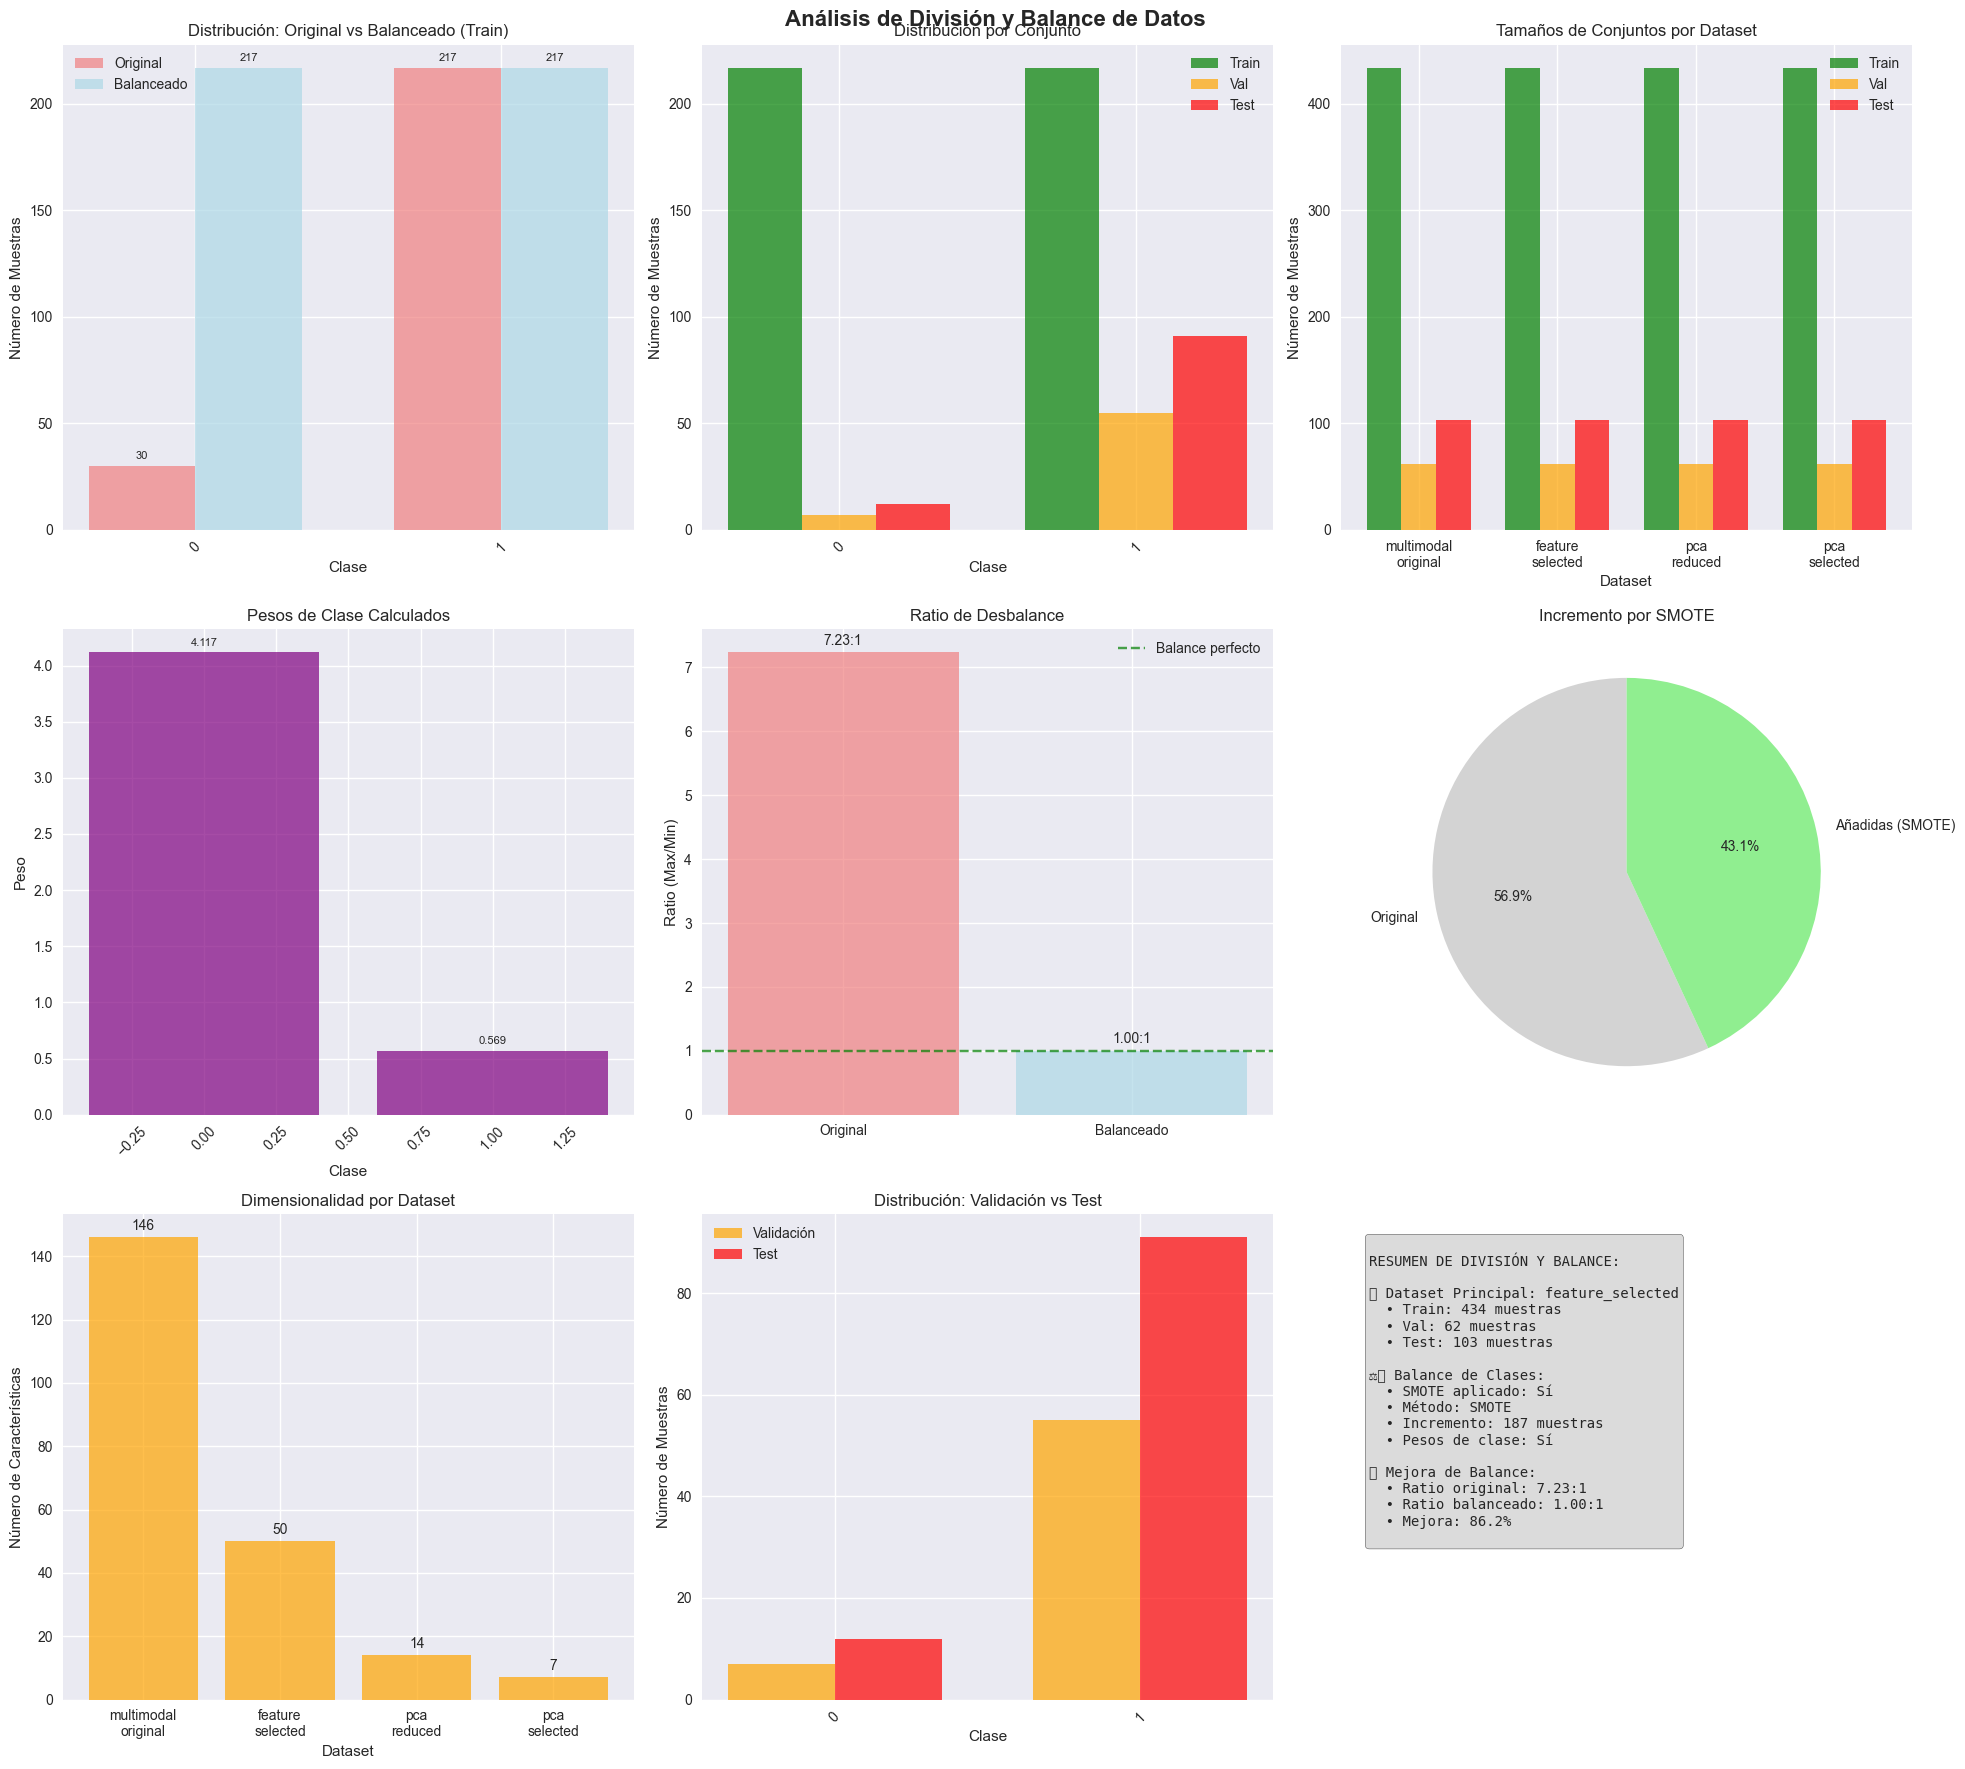

2025-07-14 04:10:28,730 - INFO - División y balance de datos completado exitosamente



✓ Resultados de división guardados en: ./resultados/data_split_results.pkl


In [22]:
def split_and_balance_data_advanced(multimodal_results, feature_selection_results, pca_results, config):
    """
    División de datos con técnicas avanzadas de balance de clases
    
    Args:
        multimodal_results: Resultados del dataset multimodal
        feature_selection_results: Resultados de selección de características
        pca_results: Resultados de PCA
        config: Configuración del proyecto
    
    Returns:
        data_split_results: Diccionario con datos divididos y balanceados
    """
    
    print("="*60)
    print("DIVISIÓN DE DATOS CON BALANCE DE CLASES AVANZADO")
    print("="*60)
    
    logger.info("Iniciando división y balance de datos")
    
    # ===== PREPARAR DATASETS DISPONIBLES =====
    print(f"📊 Preparando datasets disponibles...")
    
    # Dataset 1: Multimodal original
    X_multimodal = multimodal_results['X_multimodal']
    y_multimodal = multimodal_results['y_multimodal']
    
    # Dataset 2: Con selección de características
    X_selected = feature_selection_results['X_selected_final']
    
    # Dataset 3: Con PCA
    X_pca = pca_results['X_pca_optimal']
    
    # Dataset 4: PCA + selección (si es aplicable)
    # Aplicar selección de características a datos con PCA
    if X_pca.shape[1] > 10:  # Solo si PCA tiene suficientes características
        try:
            selector_pca = SelectKBest(f_classif, k=min(50, X_pca.shape[1]//2))
            X_pca_selected = selector_pca.fit_transform(X_pca, y_multimodal)
        except:
            X_pca_selected = X_pca
    else:
        X_pca_selected = X_pca
    
    datasets = {
        'multimodal_original': X_multimodal,
        'feature_selected': X_selected,
        'pca_reduced': X_pca,
        'pca_selected': X_pca_selected
    }
    
    print(f"  Datasets disponibles:")
    for name, data in datasets.items():
        print(f"    {name}: {data.shape}")
    
    # ===== ANÁLISIS DE DESBALANCE INICIAL =====
    print(f"\n⚖️ Análisis de desbalance inicial...")
    
    unique_classes, class_counts = np.unique(y_multimodal, return_counts=True)
    class_names = multimodal_results['label_encoder'].classes_
    
    print(f"  Distribución de clases:")
    for i, (class_idx, count) in enumerate(zip(unique_classes, class_counts)):
        class_name = class_names[class_idx]
        percentage = count / len(y_multimodal) * 100
        print(f"    {class_name} (idx {class_idx}): {count} muestras ({percentage:.1f}%)")
    
    # Calcular métricas de desbalance
    max_class_size = class_counts.max()
    min_class_size = class_counts.min()
    imbalance_ratio = max_class_size / min_class_size
    
    print(f"  Ratio de desbalance: {imbalance_ratio:.2f}:1")
    
    # Determinar si necesita balance
    needs_balancing = imbalance_ratio > 2.0
    print(f"  ¿Necesita balanceamiento? {'Sí' if needs_balancing else 'No'}")
    
    # ===== CONFIGURACIÓN DE DIVISIÓN Y BALANCE =====
    data_config = config['data_params']
    balance_config = config['class_balance']
    
    test_size = data_config['test_size']
    val_size = data_config['val_size']
    random_state = data_config['random_state']
    
    print(f"\n🔧 Configuración de división:")
    print(f"  Test: {test_size*100:.1f}%")
    print(f"  Validación: {val_size*100:.1f}%")
    print(f"  Entrenamiento: {(1-test_size-val_size)*100:.1f}%")
    
    print(f"\n🔧 Configuración de balance:")
    print(f"  Aplicar SMOTE: {'Sí' if balance_config['apply_smote'] else 'No'}")
    print(f"  Método SMOTE: {balance_config['smote_method']}")
    print(f"  Usar pesos de clase: {'Sí' if balance_config['use_class_weights'] else 'No'}")
    
    # ===== FUNCIÓN PARA DIVIDIR Y BALANCEAR UN DATASET =====
    def split_and_balance_dataset(X, y, dataset_name):
        """Divide y balancea un dataset específico"""
        
        print(f"\n  Procesando dataset: {dataset_name}")
        print(f"    Forma original: {X.shape}")
        
        # ===== DIVISIÓN INICIAL =====
        # Primera división: train+val vs test
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, 
            test_size=test_size,
            stratify=y,
            random_state=random_state
        )
        
        # Segunda división: train vs val
        val_size_adjusted = val_size / (1 - test_size)  # Ajustar proporción
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_size_adjusted,
            stratify=y_temp,
            random_state=random_state
        )
        
        print(f"    División inicial:")
        print(f"      Train: {X_train.shape[0]} muestras")
        print(f"      Val: {X_val.shape[0]} muestras")
        print(f"      Test: {X_test.shape[0]} muestras")
        
        # ===== ANÁLISIS DE DISTRIBUCIÓN POR CONJUNTO =====
        def analyze_distribution(y_set, set_name):
            unique, counts = np.unique(y_set, return_counts=True)
            print(f"      {set_name} - Distribución:")
            for class_idx, count in zip(unique, counts):
                class_name = class_names[class_idx]
                pct = count / len(y_set) * 100
                print(f"        {class_name}: {count} ({pct:.1f}%)")
        
        analyze_distribution(y_train, "Train")
        analyze_distribution(y_val, "Val")
        analyze_distribution(y_test, "Test")
        
        # ===== APLICAR TÉCNICAS DE BALANCE =====
        X_train_balanced = X_train.copy()
        y_train_balanced = y_train.copy()
        balancing_info = {'applied': False, 'method': None, 'original_size': len(y_train)}
        
        if needs_balancing and balance_config['apply_smote']:
            print(f"    Aplicando técnicas de balance...")
            
            try:
                # Seleccionar método de SMOTE
                smote_method = balance_config['smote_method']
                k_neighbors = min(balance_config['smote_k_neighbors'], 
                                len(y_train) // len(unique_classes) - 1)
                k_neighbors = max(1, k_neighbors)
                
                if smote_method == 'SMOTE':
                    sampler = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
                elif smote_method == 'ADASYN':
                    sampler = ADASYN(random_state=random_state, n_neighbors=k_neighbors)
                elif smote_method == 'BorderlineSMOTE':
                    sampler = BorderlineSMOTE(random_state=random_state, k_neighbors=k_neighbors)
                else:
                    sampler = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
                
                # Aplicar oversampling
                X_train_balanced, y_train_balanced = sampler.fit_resample(X_train, y_train)
                
                balancing_info.update({
                    'applied': True,
                    'method': smote_method,
                    'balanced_size': len(y_train_balanced),
                    'size_increase': len(y_train_balanced) - len(y_train)
                })
                
                print(f"      Método aplicado: {smote_method}")
                print(f"      Tamaño original: {len(y_train)}")
                print(f"      Tamaño balanceado: {len(y_train_balanced)}")
                print(f"      Incremento: {len(y_train_balanced) - len(y_train)} muestras")
                
                # Analizar nueva distribución
                print(f"      Nueva distribución:")
                unique_balanced, counts_balanced = np.unique(y_train_balanced, return_counts=True)
                for class_idx, count in zip(unique_balanced, counts_balanced):
                    class_name = class_names[class_idx]
                    pct = count / len(y_train_balanced) * 100
                    print(f"        {class_name}: {count} ({pct:.1f}%)")
                
            except Exception as e:
                print(f"      Error aplicando {smote_method}: {e}")
                print(f"      Usando datos originales sin balance")
                balancing_info['error'] = str(e)
        
        # ===== CALCULAR PESOS DE CLASE =====
        class_weights = None
        if balance_config['use_class_weights']:
            try:
                # Calcular pesos basados en el conjunto de entrenamiento original
                class_weights = compute_class_weight(
                    'balanced',
                    classes=unique_classes,
                    y=y_train
                )
                class_weights_dict = dict(zip(unique_classes, class_weights))
                
                print(f"    Pesos de clase calculados:")
                for class_idx, weight in class_weights_dict.items():
                    class_name = class_names[class_idx]
                    print(f"      {class_name}: {weight:.3f}")
                
            except Exception as e:
                print(f"    Error calculando pesos de clase: {e}")
                class_weights = None
        
        # ===== COMPILAR RESULTADOS DEL DATASET =====
        dataset_results = {
            'X_train': X_train_balanced,
            'X_val': X_val,
            'X_test': X_test,
            'y_train': y_train_balanced,
            'y_val': y_val,
            'y_test': y_test,
            'X_train_original': X_train,
            'y_train_original': y_train,
            'class_weights': class_weights,
            'balancing_info': balancing_info,
            'split_info': {
                'train_size': len(y_train_balanced),
                'val_size': len(y_val),
                'test_size': len(y_test),
                'train_original_size': len(y_train),
                'total_size': len(y)
            },
            'class_distribution': {
                'train_balanced': dict(zip(*np.unique(y_train_balanced, return_counts=True))),
                'val': dict(zip(*np.unique(y_val, return_counts=True))),
                'test': dict(zip(*np.unique(y_test, return_counts=True))),
                'train_original': dict(zip(*np.unique(y_train, return_counts=True)))
            }
        }
        
        return dataset_results
    
    # ===== PROCESAR TODOS LOS DATASETS =====
    print(f"\n🔄 Procesando todos los datasets...")
    
    all_splits = {}
    
    for dataset_name, X_data in datasets.items():
        try:
            dataset_split = split_and_balance_dataset(X_data, y_multimodal, dataset_name)
            all_splits[dataset_name] = dataset_split
            print(f"  ✓ {dataset_name} procesado exitosamente")
        except Exception as e:
            print(f"  ✗ Error procesando {dataset_name}: {e}")
            all_splits[dataset_name] = None
    
    # ===== SELECCIONAR DATASET PRINCIPAL =====
    # Usar el dataset con selección de características como principal
    main_dataset = 'feature_selected'
    if main_dataset not in all_splits or all_splits[main_dataset] is None:
        # Fallback al dataset multimodal original
        main_dataset = 'multimodal_original'
    
    main_split = all_splits[main_dataset]
    
    print(f"\n🎯 Dataset principal seleccionado: {main_dataset}")
    print(f"  Train: {main_split['split_info']['train_size']} muestras")
    print(f"  Val: {main_split['split_info']['val_size']} muestras")
    print(f"  Test: {main_split['split_info']['test_size']} muestras")
    
    # ===== CREAR VISUALIZACIONES =====
    print(f"\n📊 Generando visualizaciones de división y balance...")
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    fig.suptitle('Análisis de División y Balance de Datos', fontsize=16, fontweight='bold')
    
    # 1. Distribución original vs balanceada (dataset principal)
    ax1 = axes[0, 0]
    
    original_dist = main_split['class_distribution']['train_original']
    balanced_dist = main_split['class_distribution']['train_balanced']
    
    class_indices = list(original_dist.keys())
    original_counts = [original_dist[idx] for idx in class_indices]
    balanced_counts = [balanced_dist[idx] for idx in class_indices]
    class_labels = [class_names[idx] for idx in class_indices]
    
    x = np.arange(len(class_labels))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, original_counts, width, label='Original', alpha=0.7, color='lightcoral')
    bars2 = ax1.bar(x + width/2, balanced_counts, width, label='Balanceado', alpha=0.7, color='lightblue')
    
    ax1.set_title('Distribución: Original vs Balanceado (Train)')
    ax1.set_xlabel('Clase')
    ax1.set_ylabel('Número de Muestras')
    ax1.set_xticks(x)
    ax1.set_xticklabels(class_labels, rotation=45)
    ax1.legend()
    
    # Añadir etiquetas de valores
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + max(max(original_counts), max(balanced_counts))*0.01,
                    f'{int(height)}', ha='center', va='bottom', fontsize=8)
    
    # 2. Distribución por conjunto (train, val, test)
    ax2 = axes[0, 1]
    
    train_dist = main_split['class_distribution']['train_balanced']
    val_dist = main_split['class_distribution']['val']
    test_dist = main_split['class_distribution']['test']
    
    train_counts = [train_dist.get(idx, 0) for idx in class_indices]
    val_counts = [val_dist.get(idx, 0) for idx in class_indices]
    test_counts = [test_dist.get(idx, 0) for idx in class_indices]
    
    x = np.arange(len(class_labels))
    width = 0.25
    
    ax2.bar(x - width, train_counts, width, label='Train', alpha=0.7, color='green')
    ax2.bar(x, val_counts, width, label='Val', alpha=0.7, color='orange')
    ax2.bar(x + width, test_counts, width, label='Test', alpha=0.7, color='red')
    
    ax2.set_title('Distribución por Conjunto')
    ax2.set_xlabel('Clase')
    ax2.set_ylabel('Número de Muestras')
    ax2.set_xticks(x)
    ax2.set_xticklabels(class_labels, rotation=45)
    ax2.legend()
    
    # 3. Tamaños de conjuntos por dataset
    ax3 = axes[0, 2]
    
    dataset_names = [name for name, split in all_splits.items() if split is not None]
    train_sizes = [all_splits[name]['split_info']['train_size'] for name in dataset_names]
    val_sizes = [all_splits[name]['split_info']['val_size'] for name in dataset_names]
    test_sizes = [all_splits[name]['split_info']['test_size'] for name in dataset_names]
    
    x = np.arange(len(dataset_names))
    width = 0.25
    
    ax3.bar(x - width, train_sizes, width, label='Train', alpha=0.7, color='green')
    ax3.bar(x, val_sizes, width, label='Val', alpha=0.7, color='orange')
    ax3.bar(x + width, test_sizes, width, label='Test', alpha=0.7, color='red')
    
    ax3.set_title('Tamaños de Conjuntos por Dataset')
    ax3.set_xlabel('Dataset')
    ax3.set_ylabel('Número de Muestras')
    ax3.set_xticks(x)
    ax3.set_xticklabels([name.replace('_', '\n') for name in dataset_names], rotation=0)
    ax3.legend()
    
    # 4. Pesos de clase (si están disponibles)
    ax4 = axes[1, 0]
    
    if main_split['class_weights'] is not None:
        class_weights_values = main_split['class_weights']
        
        bars = ax4.bar(class_labels, class_weights_values, alpha=0.7, color='purple')
        ax4.set_title('Pesos de Clase Calculados')
        ax4.set_xlabel('Clase')
        ax4.set_ylabel('Peso')
        ax4.tick_params(axis='x', rotation=45)
        
        # Añadir etiquetas de valores
        for bar, weight in zip(bars, class_weights_values):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(class_weights_values)*0.01,
                    f'{weight:.3f}', ha='center', va='bottom', fontsize=8)
    else:
        ax4.text(0.5, 0.5, 'Pesos de clase\nno calculados', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Pesos de Clase')
    
    # 5. Ratio de desbalance antes y después
    ax5 = axes[1, 1]
    
    # Calcular ratios
    original_max = max(original_counts)
    original_min = min(original_counts)
    original_ratio = original_max / original_min
    
    balanced_max = max(balanced_counts)
    balanced_min = min(balanced_counts)
    balanced_ratio = balanced_max / balanced_min
    
    ratios = [original_ratio, balanced_ratio]
    labels = ['Original', 'Balanceado']
    colors = ['lightcoral', 'lightblue']
    
    bars = ax5.bar(labels, ratios, color=colors, alpha=0.7)
    ax5.set_title('Ratio de Desbalance')
    ax5.set_ylabel('Ratio (Max/Min)')
    
    # Línea de referencia para balance perfecto
    ax5.axhline(y=1, color='green', linestyle='--', alpha=0.7, label='Balance perfecto')
    ax5.legend()
    
    # Añadir etiquetas de valores
    for bar, ratio in zip(bars, ratios):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(ratios)*0.01,
                f'{ratio:.2f}:1', ha='center', va='bottom')
    
    # 6. Incremento de muestras por SMOTE
    ax6 = axes[1, 2]
    
    if main_split['balancing_info']['applied']:
        original_size = main_split['balancing_info']['original_size']
        balanced_size = main_split['balancing_info']['balanced_size']
        increase = balanced_size - original_size
        
        sizes = [original_size, increase]
        labels = ['Original', 'Añadidas (SMOTE)']
        colors = ['lightgray', 'lightgreen']
        
        ax6.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax6.set_title('Incremento por SMOTE')
    else:
        ax6.text(0.5, 0.5, 'SMOTE no aplicado', ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('Incremento por SMOTE')
    
    # 7. Comparación de dimensionalidades
    ax7 = axes[2, 0]
    
    dimensions = {}
    for name, split in all_splits.items():
        if split is not None:
            dimensions[name] = split['X_train'].shape[1]
    
    if dimensions:
        dataset_names_dim = list(dimensions.keys())
        dimension_values = list(dimensions.values())
        
        bars = ax7.bar(dataset_names_dim, dimension_values, alpha=0.7, color='orange')
        ax7.set_title('Dimensionalidad por Dataset')
        ax7.set_xlabel('Dataset')
        ax7.set_ylabel('Número de Características')
        ax7.set_xticklabels([name.replace('_', '\n') for name in dataset_names_dim], rotation=0)
        
        # Añadir etiquetas de valores
        for bar, value in zip(bars, dimension_values):
            ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(dimension_values)*0.01,
                    str(value), ha='center', va='bottom')
    
    # 8. Distribución de clases en validación y test
    ax8 = axes[2, 1]
    
    val_counts = [val_dist.get(idx, 0) for idx in class_indices]
    test_counts = [test_dist.get(idx, 0) for idx in class_indices]
    
    x = np.arange(len(class_labels))
    width = 0.35
    
    bars1 = ax8.bar(x - width/2, val_counts, width, label='Validación', alpha=0.7, color='orange')
    bars2 = ax8.bar(x + width/2, test_counts, width, label='Test', alpha=0.7, color='red')
    
    ax8.set_title('Distribución: Validación vs Test')
    ax8.set_xlabel('Clase')
    ax8.set_ylabel('Número de Muestras')
    ax8.set_xticks(x)
    ax8.set_xticklabels(class_labels, rotation=45)
    ax8.legend()
    
    # 9. Resumen de división y balance
    ax9 = axes[2, 2]
    ax9.axis('off')
    
    summary_text = f"""
RESUMEN DE DIVISIÓN Y BALANCE:

📊 Dataset Principal: {main_dataset}
  • Train: {main_split['split_info']['train_size']} muestras
  • Val: {main_split['split_info']['val_size']} muestras
  • Test: {main_split['split_info']['test_size']} muestras

⚖️ Balance de Clases:
  • SMOTE aplicado: {'Sí' if main_split['balancing_info']['applied'] else 'No'}
  • Método: {main_split['balancing_info'].get('method', 'N/A')}
  • Incremento: {main_split['balancing_info'].get('size_increase', 0)} muestras
  • Pesos de clase: {'Sí' if main_split['class_weights'] is not None else 'No'}

📈 Mejora de Balance:
  • Ratio original: {original_ratio:.2f}:1
  • Ratio balanceado: {balanced_ratio:.2f}:1
  • Mejora: {((original_ratio - balanced_ratio) / original_ratio * 100):.1f}%
    """
    
    ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    
    # Guardar visualización
    if config['visualization']['save_plots']:
        plot_path = os.path.join(config['paths']['plots_folder'], 
                                f'data_split_balance_analysis.{config["visualization"]["plot_format"]}')
        plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
        print(f"  ✓ Visualización guardada en: {plot_path}")
    
    plt.show()
    
    # ===== COMPILAR RESULTADOS FINALES =====
    data_split_results = {
        'main_dataset': main_dataset,
        'main_split': main_split,
        'all_splits': all_splits,
        'available_datasets': list(datasets.keys()),
        'class_info': {
            'class_names': class_names,
            'unique_classes': unique_classes,
            'original_distribution': dict(zip(unique_classes, class_counts)),
            'imbalance_ratio_original': imbalance_ratio,
            'needs_balancing': needs_balancing
        },
        'split_config': {
            'test_size': test_size,
            'val_size': val_size,
            'random_state': random_state
        },
        'balance_config': balance_config
    }
    
    # Guardar resultados
    split_path = os.path.join(config['paths']['output_folder'], 'data_split_results.pkl')
    with open(split_path, 'wb') as f:
        pickle.dump(data_split_results, f)
    
    print(f"\n✓ Resultados de división guardados en: {split_path}")
    
    logger.info("División y balance de datos completado exitosamente")
    
    return data_split_results

# ===== EJECUTAR DIVISIÓN Y BALANCE =====
data_split_results = split_and_balance_data_advanced(multimodal_results, feature_selection_results, pca_results, CONFIG)


## 9. Entrenamiento de modelos individuales con búsqueda de hiperparámetros


In [32]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight

# Configuración específica para NSCLC
CLASSES = ['No Recurrencia', 'Recurrencia']  # Asumiendo clase 0 = No recurrencia, clase 1 = Recurrencia

def train_individual_models_optimized(data_split_results, config):
    """
    Entrena y evalúa múltiples modelos de clasificación con optimización de hiperparámetros.
    """
    # Obtener datos del split
    X_train = data_split_results['main_split']['X_train']
    y_train = data_split_results['main_split']['y_train']
    X_val = data_split_results['main_split']['X_val']
    y_val = data_split_results['main_split']['y_val']
    X_test = data_split_results['main_split']['X_test']
    y_test = data_split_results['main_split']['y_test']
    
    # Calcular pesos de clases automáticamente
    class_weights = class_weight.compute_class_weight(
        'balanced', 
        classes=np.unique(y_train), 
        y=y_train
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    # Para XGBoost: calcular ratio de desbalance
    n0 = np.sum(y_train == 0)
    n1 = np.sum(y_train == 1)
    scale_pos_weight = n0 / n1  # Invertido porque XGBoost considera la clase 1 como positiva
    
    print(f"\n⚖️ Pesos de clases calculados:")
    print(f"  Clase 0 (No recurrencia): {class_weight_dict[0]:.2f}")
    print(f"  Clase 1 (Recurrencia): {class_weight_dict[1]:.2f}")
    print(f"  XGBoost scale_pos_weight: {scale_pos_weight:.2f}")

    # Definición de modelos y sus espacios de búsqueda
    models = {
        'xgboost': {
            'model': XGBClassifier(random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight),
            'params': {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.05, 0.1],  # Más granularidad
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0],
                'gamma': [0, 0.1, 0.3, 0.5],  # Mayor control de sobreajuste
                'min_child_weight': [1, 3, 5],
                'reg_alpha': [0, 0.1, 1],     # Regularización L1
                'reg_lambda': [0, 0.1, 1]      # Regularización L2
            }
        },
        'extra_trees': {
            'model': ExtraTreesClassifier(random_state=42, n_jobs=-1, class_weight=class_weight_dict),
            'params': {
                'n_estimators': [200, 300],
                'max_depth': [5, 10, 15],      # Más conservador
                'min_samples_split': [5, 10],
                'min_samples_leaf': [2, 4],
                'max_features': [0.3, 0.5, 'sqrt'],  # Mejor para alta dimensionalidad
                'bootstrap': [True]
            },
       },
        'random_forest': {
            'model': RandomForestClassifier(random_state=42, n_jobs=-1, class_weight=class_weight_dict),
            'params': {
                'n_estimators': [100, 200, 300],
                'max_depth': [5, 10, 15],      # Reducido
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': [0.3, 0.5, 'sqrt'],  # Añadido
                'bootstrap': [True, False]
            }
        },
        'decision_tree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'max_depth': [3, 5, 10, None],  # Añadido 3
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'ccp_alpha': [0, 0.01, 0.1]  # Mayor rango
            },
       },
        'logistic_regression': {
            'model': LogisticRegression(random_state=42, n_jobs=-1, max_iter=1000, class_weight=class_weight_dict),
            'params': {
                'C': np.logspace(-3, 3, 7),
                'penalty': ['l1', 'l2', 'elasticnet'],
                'solver': ['saga','liblinear'],
                'l1_ratio': [0, 0.5, 1] if 'elasticnet' in ['l1', 'l2', 'elasticnet'] else None
            }
        },
        'svm_rbf': {
            'model': SVC(kernel='rbf', random_state=42, probability=True, class_weight=class_weight_dict),
            'params': {
                'C': [0.1, 1, 10, 100],
                'gamma': [1e-4, 1e-3, 1e-2, 'scale'],  # Valores más bajos para radiomics
            }
        },
        'svm_linear': {
            'model': SVC(kernel='linear', random_state=42, probability=True, class_weight=class_weight_dict),
            'params': {
                'C': [0.001, 0.01, 0.1, 1, 10], 
                'class_weight': ['balanced', class_weight_dict]
            }
        }
}
    
    resultados = {}
    best_f1 = 0
    best_model_name = None
    
    # Almacenar matrices de confusión para el resumen final
    all_confusion_matrices = []
    
    for model_name, model_info in models.items():
        print(f"\n🔍 Entrenando y optimizando modelo: {model_name.upper()}")
        
        # Configuración de búsqueda aleatoria
        search = RandomizedSearchCV(
            estimator=model_info['model'],
            param_distributions=model_info['params'],
            n_iter=config['model_params']['n_iter_search'],
            cv=config['model_params']['cv_folds'],
            scoring='f1',  # Priorizamos F1 para problemas desbalanceados
            n_jobs=config['model_params']['n_jobs'],
            random_state=42,
            verbose=1
        )
        
        # Entrenamiento con búsqueda de hiperparámetros
        search.fit(X_train, y_train)
        
        # Calibración del modelo para mejorar probabilidades
        calibrated_model = CalibratedClassifierCV(search.best_estimator_, cv=3, method='isotonic')
        calibrated_model.fit(X_train, y_train)
        
        # Evaluación en validación
        y_val_pred = calibrated_model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred)
        val_f1_macro = f1_score(y_val, y_val_pred, average='macro')
        
        # Evaluación en test
        y_test_pred = calibrated_model.predict(X_test)
        test_f1 = f1_score(y_test, y_test_pred)
        test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
        
        # Guardar resultados
        model_results = {
            'model': calibrated_model,
            'best_params': search.best_params_,
            'val_accuracy': val_accuracy,
            'val_f1': val_f1,
            'val_f1_macro': val_f1_macro,
            'test_f1': test_f1,
            'test_f1_macro': test_f1_macro,
            'y_val_pred': y_val_pred,
            'y_test_pred': y_test_pred
        }
        
        resultados[model_name] = model_results
        
        # Actualizar mejor modelo (basado en F1 en validación)
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_name = model_name
            best_model = calibrated_model
        
        # Reporte de clasificación
        print(f"\n📊 Resultados para {model_name}:")
        print(f"🔹 Mejores parámetros: {search.best_params_}")
        print(f"🔹 Accuracy (val): {val_accuracy:.4f}")
        print(f"🔹 F1-score (val): {val_f1:.4f}")
        print(f"🔹 F1-score macro (val): {val_f1_macro:.4f}")
        print("\n🔹 Reporte de clasificación (val):")
        print(classification_report(y_val, y_val_pred, target_names=CLASSES))
        
        # Generar y guardar matriz de confusión individual
        plot_confusion_matrix(y_val, y_val_pred, model_name, "val", config)
        plot_confusion_matrix(y_test, y_test_pred, model_name, "test", config)
        
        # Almacenar para resumen final
        all_confusion_matrices.append({
            'model': model_name,
            'y_val_true': y_val,
            'y_val_pred': y_val_pred,
            'y_test_true': y_test,
            'y_test_pred': y_test_pred
        })
    
    # Guardar el mejor modelo
    resultados['best_model_name'] = best_model_name
    resultados['best_model'] = best_model
    resultados['best_model_results'] = resultados[best_model_name]
    
    # Generar resumen visual de todas las matrices de confusión
    plot_all_confusion_matrices(all_confusion_matrices, config)
    
    return resultados

def plot_confusion_matrix(y_true, y_pred, model_name, dataset_type, config):
    """Genera y guarda una matriz de confusión visual."""
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=CLASSES, columns=CLASSES)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusión - {model_name.upper()} ({dataset_type})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    
    plot_path = os.path.join(
        config['paths']['plots_folder'],
        f'confusion_matrix_{model_name}_{dataset_type}.{config["visualization"]["plot_format"]}'
    )
    plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
    plt.close()
    print(f"✓ Matriz de confusión guardada en: {plot_path}")

def plot_all_confusion_matrices(all_confusion_matrices, config):
    """Genera una imagen con todas las matrices de confusión en una sola figura"""
    n_models = len(all_confusion_matrices)
    fig, axes = plt.subplots(n_models, 2, figsize=(15, 5 * n_models))
    fig.suptitle('Resumen de Matrices de Confusión', fontsize=16)
    
    for i, matrix_data in enumerate(all_confusion_matrices):
        model_name = matrix_data['model']
        
        # Matriz para validación
        cm_val = confusion_matrix(matrix_data['y_val_true'], matrix_data['y_val_pred'])
        cm_val_df = pd.DataFrame(cm_val, index=CLASSES, columns=CLASSES)
        
        ax_val = axes[i, 0] if n_models > 1 else axes[0]
        sns.heatmap(cm_val_df, annot=True, fmt='d', cmap='Blues', ax=ax_val, cbar=False)
        ax_val.set_title(f'{model_name.upper()} - Validación')
        ax_val.set_ylabel('Real')
        ax_val.set_xlabel('Predicho')
        
        # Matriz para test
        cm_test = confusion_matrix(matrix_data['y_test_true'], matrix_data['y_test_pred'])
        cm_test_df = pd.DataFrame(cm_test, index=CLASSES, columns=CLASSES)
        
        ax_test = axes[i, 1] if n_models > 1 else axes[1]
        sns.heatmap(cm_test_df, annot=True, fmt='d', cmap='Greens', ax=ax_test, cbar=False)
        ax_test.set_title(f'{model_name.upper()} - Test')
        ax_test.set_ylabel('Real')
        ax_test.set_xlabel('Predicho')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajuste para el título general
    
    # Guardar la figura
    plot_path = os.path.join(
        config['paths']['plots_folder'],
        f'confusion_matrices_summary.{config["visualization"]["plot_format"]}'
    )
    plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
    plt.close()
    print(f"\n✓ Resumen de matrices de confusión guardado en: {plot_path}")

# ===== EJECUCIÓN PRINCIPAL =====
if __name__ == "__main__":
    # Configuración del proyecto optimizada para NSCLC
    CONFIG = {
        'model_params': {
            'cv_folds': 5,
            'n_jobs': -1,
            'hyperparameter_search': 'randomized',
            'n_iter_search': 30,  # Reducido para eficiencia
            'max_iter': 1000
        },
        'visualization': {
            'save_plots': True,
            'plot_format': 'png',
            'dpi': 300
        },
        'paths': {
            'plots_folder': './plots',
            'output_folder': './output',
            'models_folder': './models'
        }
    }
    
    # Crear directorios si no existen
    for folder in CONFIG['paths'].values():
        os.makedirs(folder, exist_ok=True)
    
    # Cargar resultados de división de datos
    try:
        with open('./resultados/data_split_results.pkl', 'rb') as f:
            data_split_results = pickle.load(f)
        print("✓ Datos de división cargados exitosamente")
    except Exception as e:
        print(f"❌ Error cargando datos de división: {e}")
        raise
    
    # Ejecutar entrenamiento con datos reales
    resultados = train_individual_models_optimized(data_split_results, CONFIG)
    
    # Resumen final mejorado
    print("\n" + "="*60)
    print("📌 RESUMEN FINAL DEL ENTRENAMIENTO PARA NSCLC")
    print("="*60)
    
    best_model_name = resultados['best_model_name']
    best_model = resultados['best_model']
    best_results = resultados['best_model_results']
    
    print(f"\n🏆 Modelo ganador: {best_model_name.upper()}")
    print(f"🔹 Parámetros óptimos: {best_results['best_params']}")
    
    # Evaluación detallada con foco en la clase minoritaria
    print("\n📊 Rendimiento del mejor modelo (clase minoritaria - Recurrencia):")
    print(f"🔹 F1-score (validación): {best_results['val_f1']:.4f}")
    print(f"🔹 F1-score (test): {best_results['test_f1']:.4f}")
    
    # Reporte completo de clasificación en test
    print("\n🔹 Reporte de clasificación (test):")
    print(classification_report(
        data_split_results['main_split']['y_test'], 
        best_results['y_test_pred'], 
        target_names=CLASSES
    ))
    
    # Análisis de generalización mejorado
    val_f1 = best_results['val_f1']
    test_f1 = best_results['test_f1']
    diff = abs(val_f1 - test_f1)
    
    print("\n🔍 Análisis de generalización (F1-score):")
    if diff < 0.05:
        print("✅ Excelente generalización (diferencia < 5%)")
    elif diff < 0.1:
        print("🟠 Buena generalización (diferencia < 10%)")
    elif diff < 0.15:
        print("⚠️ Generalización moderada (diferencia < 15%)")
    else:
        print("❌ Problemas de generalización (diferencia ≥ 15%)")
    
    if val_f1 > test_f1:
        print("🔼 Posible sobreajuste (mejor en validación que en test)")
    else:
        print("🔽 Posible subajuste (mejor en test que en validación)")
    
    # Guardar el mejor modelo
    model_path = os.path.join(CONFIG['paths']['models_folder'], f'best_model_{best_model_name}.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"\n💾 Mejor modelo guardado en: {model_path}")
    
    # Guardar todos los resultados
    results_path = os.path.join(CONFIG['paths']['output_folder'], 'training_results.pkl')
    with open(results_path, 'wb') as f:
        pickle.dump(resultados, f)
    print(f"💾 Todos los resultados guardados en: {results_path}")
    
    print("\n✨ Proceso completado exitosamente ✨")

✓ Datos de división cargados exitosamente

⚖️ Pesos de clases calculados:
  Clase 0 (No recurrencia): 1.00
  Clase 1 (Recurrencia): 1.00
  XGBoost scale_pos_weight: 1.00

🔍 Entrenando y optimizando modelo: XGBOOST
Fitting 5 folds for each of 30 candidates, totalling 150 fits

📊 Resultados para xgboost:
🔹 Mejores parámetros: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.6}
🔹 Accuracy (val): 0.9677
🔹 F1-score (val): 0.9821
🔹 F1-score macro (val): 0.9077

🔹 Reporte de clasificación (val):
                precision    recall  f1-score   support

No Recurrencia       1.00      0.71      0.83         7
   Recurrencia       0.96      1.00      0.98        55

      accuracy                           0.97        62
     macro avg       0.98      0.86      0.91        62
  weighted avg       0.97      0.97      0.97        62

✓ Matriz de confusión guardada en: ./plots\

## 10. Implementación de Ensemble Learning con pesos automáticos


IMPLEMENTACIÓN DE ENSEMBLE LEARNING AVANZADO
Iniciando creación de modelos de ensemble
📊 Datos disponibles:
  Train: (434, 50)
  Validación: (62, 50)
  Test: (103, 50)
  Modelos individuales: 7

🎯 Seleccionando modelos para ensemble...
  Ranking de modelos:
    1. svm_linear: 0.9677
    2. xgboost: 0.9653
    3. extra_trees: 0.9653
    4. logistic_regression: 0.9530
    5. svm_rbf: 0.9457
    6. decision_tree: 0.9355
    7. random_forest: 0.9237
  Modelos seleccionados para ensemble: ['svm_linear', 'xgboost', 'extra_trees', 'logistic_regression', 'svm_rbf']

🔧 Configuración de ensemble:
  Tipos de voting: ['hard', 'soft']
  Pesos automáticos: Sí
  CV para stacking: 5
  Calculando pesos automáticos...
    svm_linear: F1=0.9677, Acc=0.9677, Combined=0.9677
    xgboost: F1=0.9653, Acc=0.9677, Combined=0.9661
    extra_trees: F1=0.9653, Acc=0.9677, Combined=0.9661
    logistic_regression: F1=0.9530, Acc=0.9516, Combined=0.9526
    svm_rbf: F1=0.9457, Acc=0.9516, Combined=0.9474
  Pesos cal

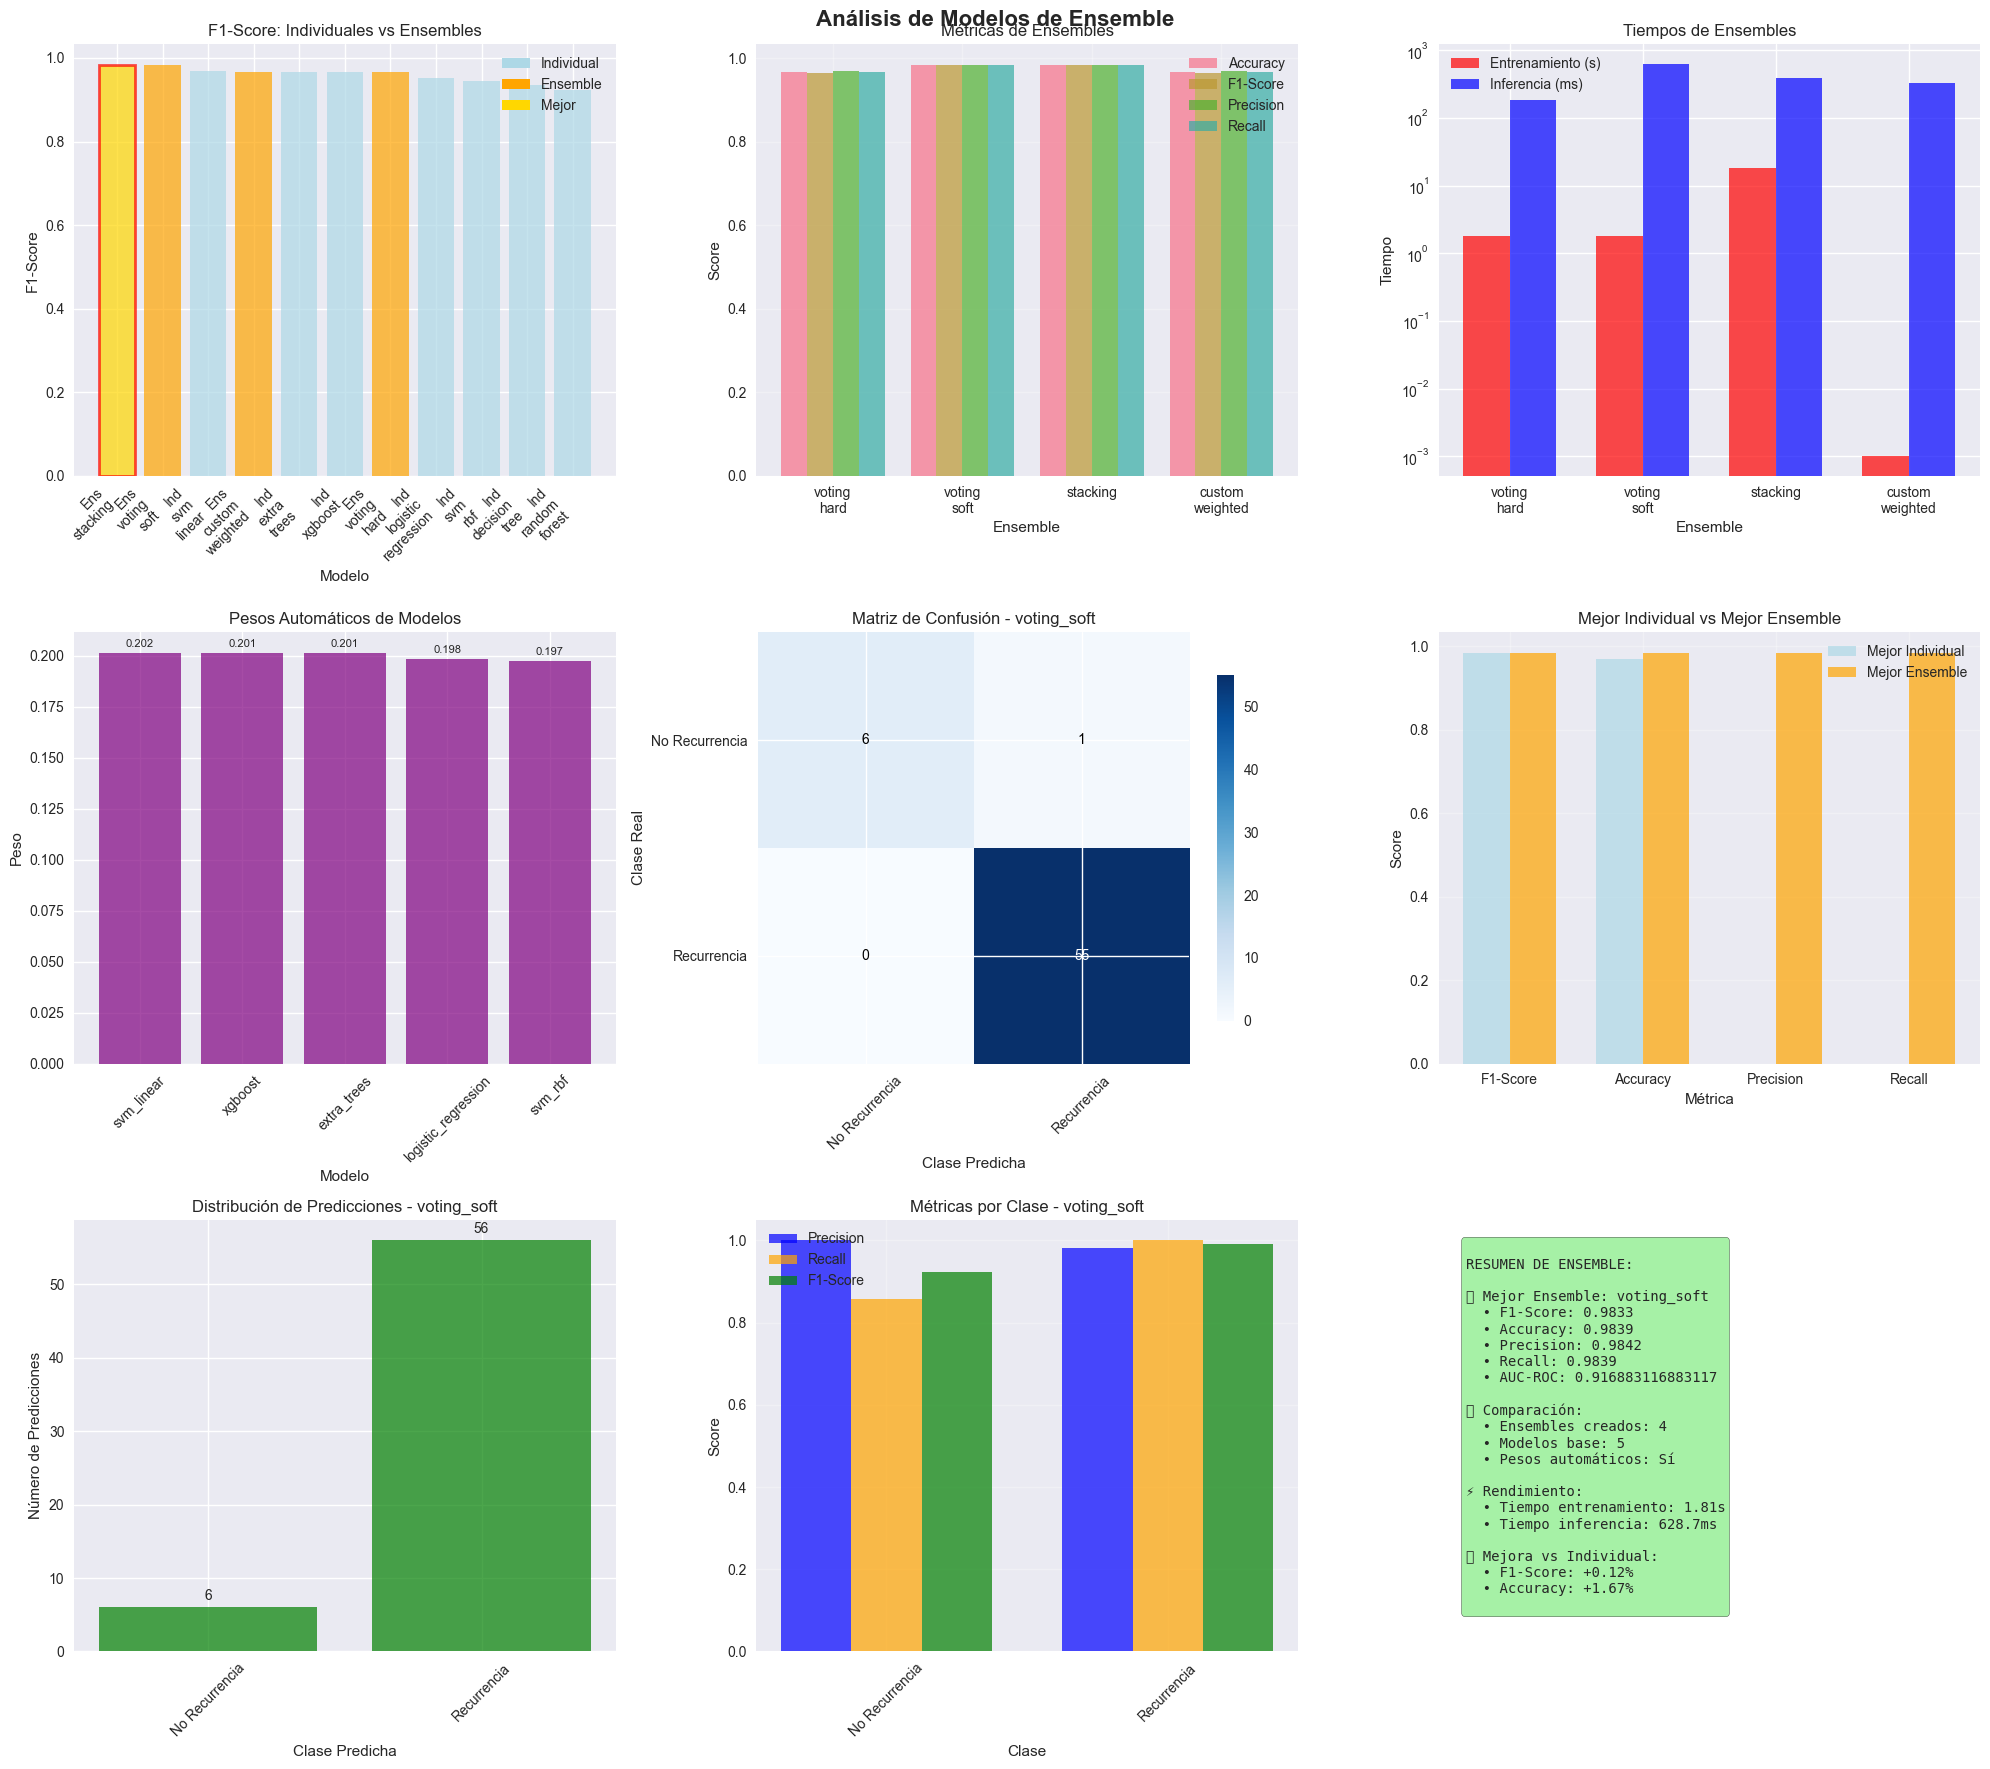


✓ Resultados de ensemble guardados en: ./output\ensemble_models_results.pkl
✓ Mejor ensemble guardado en: ./models\best_ensemble_voting_soft.pkl
Creación de modelos de ensemble completada exitosamente


In [34]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, precision_recall_fscore_support
from sklearn.ensemble import VotingClassifier, StackingClassifier, GradientBoostingClassifier
import time

class DynamicWeightedEnsemble:
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights if weights else [1.0/len(models)] * len(models)
        self.model_names = list(models.keys())
        
    def fit(self, X, y):
        # Los modelos ya están entrenados
        return self
        
    def predict(self, X):
        predictions = []
        for model_name in self.model_names:
            pred = self.models[model_name].predict(X)
            predictions.append(pred)
        
        # Voting ponderado
        predictions = np.array(predictions)
        weighted_predictions = []
        
        for i in range(X.shape[0]):
            sample_preds = predictions[:, i]
            unique_preds, counts = np.unique(sample_preds, return_counts=True)
            
            # Calcular votos ponderados
            weighted_votes = {}
            for j, pred in enumerate(sample_preds):
                if pred not in weighted_votes:
                    weighted_votes[pred] = 0
                weighted_votes[pred] += self.weights[j]
            
            # Seleccionar predicción con mayor peso
            best_pred = max(weighted_votes.items(), key=lambda x: x[1])[0]
            weighted_predictions.append(best_pred)
        
        return np.array(weighted_predictions)
    
    def predict_proba(self, X):
        # Solo si todos los modelos soportan predict_proba
        probabilities = []
        valid_models = []
        valid_weights = []
        
        for i, model_name in enumerate(self.model_names):
            if hasattr(self.models[model_name], 'predict_proba'):
                proba = self.models[model_name].predict_proba(X)
                probabilities.append(proba)
                valid_models.append(model_name)
                valid_weights.append(self.weights[i])
        
        if len(probabilities) > 0:
            # Normalizar pesos
            total_weight = sum(valid_weights)
            valid_weights = [w/total_weight for w in valid_weights]
            
            # Promedio ponderado de probabilidades
            weighted_proba = np.zeros_like(probabilities[0])
            for proba, weight in zip(probabilities, valid_weights):
                weighted_proba += proba * weight
            
            return weighted_proba
        else:
            return None

def create_ensemble_models_advanced(individual_models_results, data_split_results, config):
    """
    Crea modelos de ensemble avanzados con pesos automáticos y stacking optimizado
    
    Args:
        individual_models_results: Resultados de modelos individuales
        data_split_results: Resultados de división de datos
        config: Configuración del proyecto
    
    Returns:
        ensemble_results: Diccionario con modelos de ensemble y resultados
    """
    
    print("="*60)
    print("IMPLEMENTACIÓN DE ENSEMBLE LEARNING AVANZADO")
    print("="*60)
    
    print("Iniciando creación de modelos de ensemble")
    
    # ===== EXTRAER DATOS Y MODELOS =====
    main_split = data_split_results['main_split']
    
    # Filtrar solo modelos individuales (excluyendo metadatos)
    trained_models = {k: v for k, v in individual_models_results.items() 
                     if k not in ['best_model_name', 'best_model', 'best_model_results']}
    
    X_train = main_split['X_train']
    X_val = main_split['X_val']
    X_test = main_split['X_test']
    y_train = main_split['y_train']
    y_val = main_split['y_val']
    y_test = main_split['y_test']
    
    class_names = CLASSES  # Usar variable global CLASSES
    
    print(f"📊 Datos disponibles:")
    print(f"  Train: {X_train.shape}")
    print(f"  Validación: {X_val.shape}")
    print(f"  Test: {X_test.shape}")
    print(f"  Modelos individuales: {len(trained_models)}")
    
    # ===== SELECCIONAR MODELOS PARA ENSEMBLE =====
    print(f"\n🎯 Seleccionando modelos para ensemble...")
    
    # Calcular F1 ponderado para cada modelo en validación
    model_scores = {}
    for model_name, model_results in trained_models.items():
        y_val_pred = model_results['y_val_pred']
        f1_weighted = f1_score(y_val, y_val_pred, average='weighted')
        model_scores[model_name] = f1_weighted
    
    # Ordenar modelos por rendimiento
    sorted_models = sorted(model_scores.items(), key=lambda x: x[1], reverse=True)
    
    print(f"  Ranking de modelos:")
    for i, (model_name, score) in enumerate(sorted_models):
        print(f"    {i+1}. {model_name}: {score:.4f}")
    
    # Seleccionar top modelos para ensemble (mínimo 3, máximo 5)
    n_models_ensemble = min(max(3, len(trained_models)), 5)
    selected_models = dict(sorted_models[:n_models_ensemble])
    
    print(f"  Modelos seleccionados para ensemble: {list(selected_models.keys())}")
    
    # ===== CONFIGURACIÓN DE ENSEMBLE =====
    ensemble_config = config.get('ensemble_params', {
        'voting_types': ['hard', 'soft'],
        'auto_weights': True,
        'stacking_cv': 5,
        'stacking_final_estimator': 'logistic_regression'
    })
    
    voting_types = ensemble_config['voting_types']
    auto_weights = ensemble_config['auto_weights']
    stacking_cv = ensemble_config['stacking_cv']
    
    print(f"\n🔧 Configuración de ensemble:")
    print(f"  Tipos de voting: {voting_types}")
    print(f"  Pesos automáticos: {'Sí' if auto_weights else 'No'}")
    print(f"  CV para stacking: {stacking_cv}")
    
    # ===== CALCULAR PESOS AUTOMÁTICOS =====
    def calculate_automatic_weights(models_dict, X_val, y_val):
        """Calcula pesos automáticos basados en rendimiento de validación"""
        
        print(f"  Calculando pesos automáticos...")
        
        weights = {}
        performances = {}
        
        for model_name, model_results in models_dict.items():
            try:
                # Usar predicciones ya calculadas
                y_pred = model_results['y_val_pred']
                
                # Calcular múltiples métricas
                f1_score_val = f1_score(y_val, y_pred, average='weighted')
                accuracy_val = accuracy_score(y_val, y_pred)
                
                # Score combinado (70% F1, 30% Accuracy)
                combined_score = 0.7 * f1_score_val + 0.3 * accuracy_val
                
                performances[model_name] = {
                    'f1': f1_score_val,
                    'accuracy': accuracy_val,
                    'combined': combined_score
                }
                
                print(f"    {model_name}: F1={f1_score_val:.4f}, Acc={accuracy_val:.4f}, Combined={combined_score:.4f}")
                
            except Exception as e:
                print(f"    Error evaluando {model_name}: {e}")
                performances[model_name] = {'combined': 0.0}
        
        # Calcular pesos basados en rendimiento combinado
        total_performance = sum(perf['combined'] for perf in performances.values())
        
        if total_performance > 0:
            for model_name, perf in performances.items():
                weights[model_name] = perf['combined'] / total_performance
        else:
            # Pesos uniformes si hay error
            n_models = len(models_dict)
            for model_name in models_dict.keys():
                weights[model_name] = 1.0 / n_models
        
        # Normalizar pesos para que sumen 1
        total_weight = sum(weights.values())
        if total_weight > 0:
            weights = {name: weight/total_weight for name, weight in weights.items()}
        
        print(f"  Pesos calculados:")
        for model_name, weight in weights.items():
            print(f"    {model_name}: {weight:.4f}")
        
        return weights, performances
    
    # Calcular pesos si está habilitado
    if auto_weights:
        model_weights, model_performances = calculate_automatic_weights(
            {name: trained_models[name] for name in selected_models.keys()}, 
            X_val, y_val
        )
        weights_list = [model_weights[name] for name in selected_models.keys()]
    else:
        model_weights = None
        model_performances = None
        weights_list = None
    
    # ===== CREAR MODELOS DE ENSEMBLE =====
    print(f"\n🔄 Creando modelos de ensemble...")
    
    ensemble_models = {}
    ensemble_results = {}
    
    # Preparar lista de modelos para ensemble
    estimators = [(name, trained_models[name]['model']) for name in selected_models.keys()]
    
    # ===== 1. VOTING CLASSIFIER (HARD) =====
    if 'hard' in voting_types:
        print(f"  Creando Voting Classifier (Hard)...")
        
        try:
            voting_hard = VotingClassifier(
                estimators=estimators,
                voting='hard',
                weights=weights_list if auto_weights else None,
                n_jobs=config['model_params']['n_jobs']
            )
            
            # Entrenar
            start_time = time.time()
            voting_hard.fit(X_train, y_train)
            training_time = time.time() - start_time
            
            # Evaluar
            start_inference = time.time()
            y_val_pred = voting_hard.predict(X_val)
            inference_time = time.time() - start_inference
            
            # Métricas
            val_accuracy = accuracy_score(y_val, y_val_pred)
            val_f1 = f1_score(y_val, y_val_pred, average='weighted')
            val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
            val_recall = recall_score(y_val, y_val_pred, average='weighted', zero_division=0)
            
            ensemble_models['voting_hard'] = voting_hard
            ensemble_results['voting_hard'] = {
                'model': voting_hard,
                'val_accuracy': val_accuracy,
                'val_f1': val_f1,
                'val_precision': val_precision,
                'val_recall': val_recall,
                'y_val_pred': y_val_pred,
                'training_time': training_time,
                'inference_time': inference_time,
                'weights_used': weights_list if auto_weights else None
            }
            
            print(f"    Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")
            
        except Exception as e:
            print(f"    Error creando Voting Hard: {e}")
    
    # ===== 2. VOTING CLASSIFIER (SOFT) =====
    if 'soft' in voting_types:
        print(f"  Creando Voting Classifier (Soft)...")
        
        try:
            # Verificar que todos los modelos soporten predict_proba
            soft_estimators = []
            for name, model_results in estimators:
                if hasattr(model_results, 'predict_proba'):
                    soft_estimators.append((name, model_results))
                else:
                    print(f"    Excluyendo {name} (no soporta predict_proba)")
            
            if len(soft_estimators) >= 2:
                # Ajustar pesos para modelos disponibles
                if auto_weights:
                    soft_weights = [model_weights[name] for name, _ in soft_estimators]
                    # Renormalizar
                    total_soft_weight = sum(soft_weights)
                    soft_weights = [w/total_soft_weight for w in soft_weights]
                else:
                    soft_weights = None
                
                voting_soft = VotingClassifier(
                    estimators=soft_estimators,
                    voting='soft',
                    weights=soft_weights,
                    n_jobs=config['model_params']['n_jobs']
                )
                
                # Entrenar
                start_time = time.time()
                voting_soft.fit(X_train, y_train)
                training_time = time.time() - start_time
                
                # Evaluar
                start_inference = time.time()
                y_val_pred = voting_soft.predict(X_val)
                y_val_proba = voting_soft.predict_proba(X_val)
                inference_time = time.time() - start_inference
                
                # Métricas
                val_accuracy = accuracy_score(y_val, y_val_pred)
                val_f1 = f1_score(y_val, y_val_pred, average='weighted')
                val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
                val_recall = recall_score(y_val, y_val_pred, average='weighted', zero_division=0)
                
                # AUC-ROC
                try:
                    if len(np.unique(y_val)) == 2:
                        val_auc = roc_auc_score(y_val, y_val_proba[:, 1])
                    else:
                        val_auc = roc_auc_score(y_val, y_val_proba, multi_class='ovr', average='weighted')
                except:
                    val_auc = None
                
                ensemble_models['voting_soft'] = voting_soft
                ensemble_results['voting_soft'] = {
                    'model': voting_soft,
                    'val_accuracy': val_accuracy,
                    'val_f1': val_f1,
                    'val_precision': val_precision,
                    'val_recall': val_recall,
                    'val_auc': val_auc,
                    'y_val_pred': y_val_pred,
                    'y_val_proba': y_val_proba,
                    'training_time': training_time,
                    'inference_time': inference_time,
                    'weights_used': soft_weights
                }
                
                print(f"    Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")
                if val_auc:
                    print(f"    AUC-ROC: {val_auc:.4f}")
                
            else:
                print(f"    Insuficientes modelos para Voting Soft ({len(soft_estimators)} disponibles)")
                
        except Exception as e:
            print(f"    Error creando Voting Soft: {e}")
    
    # ===== 3. STACKING CLASSIFIER =====
    print(f"  Creando Stacking Classifier...")
    
    try:
        # Seleccionar meta-learner
        final_estimator_type = ensemble_config['stacking_final_estimator']
        
        if final_estimator_type == 'gradient_boosting':
            final_estimator = GradientBoostingClassifier(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=3,
                random_state=42
            )
        else:  # logistic regression por defecto
            final_estimator = LogisticRegression(
                random_state=42,
                max_iter=1000,
                n_jobs=config['model_params']['n_jobs']
            )
        
        stacking_clf = StackingClassifier(
            estimators=estimators,
            final_estimator=final_estimator,
            cv=stacking_cv,
            stack_method='auto',
            n_jobs=config['model_params']['n_jobs'],
            passthrough=False  # No pasar características originales
        )
        
        # Entrenar
        start_time = time.time()
        stacking_clf.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Evaluar
        start_inference = time.time()
        y_val_pred = stacking_clf.predict(X_val)
        inference_time = time.time() - start_inference
        
        # Probabilidades si están disponibles
        y_val_proba = None
        if hasattr(stacking_clf, 'predict_proba'):
            y_val_proba = stacking_clf.predict_proba(X_val)
        
        # Métricas
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred, average='weighted')
        val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
        val_recall = recall_score(y_val, y_val_pred, average='weighted', zero_division=0)
        
        # AUC-ROC
        val_auc = None
        if y_val_proba is not None:
            try:
                if len(np.unique(y_val)) == 2:
                    val_auc = roc_auc_score(y_val, y_val_proba[:, 1])
                else:
                    val_auc = roc_auc_score(y_val, y_val_proba, multi_class='ovr', average='weighted')
            except:
                val_auc = None
        
        ensemble_models['stacking'] = stacking_clf
        ensemble_results['stacking'] = {
            'model': stacking_clf,
            'val_accuracy': val_accuracy,
            'val_f1': val_f1,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_auc': val_auc,
            'y_val_pred': y_val_pred,
            'y_val_proba': y_val_proba,
            'training_time': training_time,
            'inference_time': inference_time,
            'final_estimator_type': final_estimator_type
        }
        
        print(f"    Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")
        if val_auc:
            print(f"    AUC-ROC: {val_auc:.4f}")
        
    except Exception as e:
        print(f"    Error creando Stacking: {e}")
    
    # ===== 4. ENSEMBLE PERSONALIZADO CON PESOS DINÁMICOS =====
    print(f"  Creando Ensemble Personalizado...")
    
    try:
        # Crear ensemble personalizado
        selected_models_dict = {name: trained_models[name]['model'] for name in selected_models.keys()}
        custom_weights = [model_weights[name] for name in selected_models.keys()] if auto_weights else None
        
        custom_ensemble = DynamicWeightedEnsemble(selected_models_dict, custom_weights)
        
        # Evaluar
        start_time = time.time()
        custom_ensemble.fit(X_train, y_train)  # No hace nada, pero mantiene interfaz
        training_time = 0.001  # Tiempo mínimo ya que modelos están pre-entrenados
        
        start_inference = time.time()
        y_val_pred = custom_ensemble.predict(X_val)
        inference_time = time.time() - start_inference
        
        y_val_proba = custom_ensemble.predict_proba(X_val)
        
        # Métricas
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred, average='weighted')
        val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
        val_recall = recall_score(y_val, y_val_pred, average='weighted', zero_division=0)
        
        # AUC-ROC
        val_auc = None
        if y_val_proba is not None:
            try:
                if len(np.unique(y_val)) == 2:
                    val_auc = roc_auc_score(y_val, y_val_proba[:, 1])
                else:
                    val_auc = roc_auc_score(y_val, y_val_proba, multi_class='ovr', average='weighted')
            except:
                val_auc = None
        
        ensemble_models['custom_weighted'] = custom_ensemble
        ensemble_results['custom_weighted'] = {
            'model': custom_ensemble,
            'val_accuracy': val_accuracy,
            'val_f1': val_f1,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_auc': val_auc,
            'y_val_pred': y_val_pred,
            'y_val_proba': y_val_proba,
            'training_time': training_time,
            'inference_time': inference_time,
            'weights_used': custom_weights
        }
        
        print(f"    Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")
        if val_auc:
            print(f"    AUC-ROC: {val_auc:.4f}")
        
    except Exception as e:
        print(f"    Error creando Ensemble Personalizado: {e}")
    
    # ===== COMPARACIÓN DE ENSEMBLES =====
    print(f"\n🏆 Comparación de modelos de ensemble...")
    
    if ensemble_results:
        # Crear tabla comparativa
        ensemble_comparison = []
        for ensemble_name, results in ensemble_results.items():
            ensemble_comparison.append({
                'Ensemble': ensemble_name,
                'Accuracy': results['val_accuracy'],
                'F1_Score': results['val_f1'],
                'Precision': results['val_precision'],
                'Recall': results['val_recall'],
                'AUC_ROC': results.get('val_auc', 0) or 0,
                'Training_Time': results['training_time'],
                'Inference_Time': results['inference_time']
            })
        
        ensemble_comparison_df = pd.DataFrame(ensemble_comparison)
        ensemble_comparison_df = ensemble_comparison_df.sort_values('F1_Score', ascending=False)
        
        print(f"\n📋 Tabla comparativa de ensembles:")
        print(ensemble_comparison_df.round(4))
        
        # Identificar mejor ensemble
        best_ensemble_name = ensemble_comparison_df.iloc[0]['Ensemble']
        best_ensemble_results = ensemble_results[best_ensemble_name]
        
        print(f"\n🥇 Mejor ensemble: {best_ensemble_name}")
        print(f"  F1-score: {best_ensemble_results['val_f1']:.4f}")
        print(f"  Accuracy: {best_ensemble_results['val_accuracy']:.4f}")
        if best_ensemble_results.get('val_auc'):
            print(f"  AUC-ROC: {best_ensemble_results['val_auc']:.4f}")
    else:
        print("  No se crearon ensembles exitosamente")
        best_ensemble_name = None
        best_ensemble_results = None
        ensemble_comparison_df = pd.DataFrame()
    
    # ===== COMPARACIÓN CON MODELOS INDIVIDUALES =====
    print(f"\n📊 Comparación ensemble vs modelos individuales...")
    
    # Obtener mejor modelo individual
    best_individual_name = individual_models_results['best_model_name']
    best_individual = individual_models_results['best_model_results']
    
    if best_ensemble_results:
        print(f"  Mejor individual: {best_individual_name}")
        print(f"    F1-score: {best_individual['val_f1']:.4f}")
        print(f"    Accuracy: {best_individual['val_accuracy']:.4f}")
        
        print(f"  Mejor ensemble: {best_ensemble_name}")
        print(f"    F1-score: {best_ensemble_results['val_f1']:.4f}")
        print(f"    Accuracy: {best_ensemble_results['val_accuracy']:.4f}")
        
        # Calcular mejora
        f1_improvement = ((best_ensemble_results['val_f1'] - best_individual['val_f1']) / 
                         best_individual['val_f1']) * 100
        acc_improvement = ((best_ensemble_results['val_accuracy'] - best_individual['val_accuracy']) / 
                          best_individual['val_accuracy']) * 100
        
        print(f"  Mejora del ensemble:")
        print(f"    F1-score: {f1_improvement:+.2f}%")
        print(f"    Accuracy: {acc_improvement:+.2f}%")
    else:
        f1_improvement = 0
        acc_improvement = 0
    
    # ===== CREAR VISUALIZACIONES =====
    print(f"\n📊 Generando visualizaciones de ensemble...")
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    fig.suptitle('Análisis de Modelos de Ensemble', fontsize=16, fontweight='bold')
    
    # 1. Comparación de F1-scores (ensemble vs individuales)
    ax1 = axes[0, 0]
    
    # Datos para comparación
    all_models_comparison = []
    
    # Añadir modelos individuales
    for model_name in trained_models:
        all_models_comparison.append({
            'Model': f"Ind_{model_name}",
            'Type': 'Individual',
            'F1_Score': model_scores[model_name]
        })
    
    # Añadir ensembles
    for ensemble_name in ensemble_results:
        all_models_comparison.append({
            'Model': f"Ens_{ensemble_name}",
            'Type': 'Ensemble',
            'F1_Score': ensemble_results[ensemble_name]['val_f1']
        })
    
    comparison_all_df = pd.DataFrame(all_models_comparison)
    comparison_all_df = comparison_all_df.sort_values('F1_Score', ascending=False)
    
    # Crear gráfico
    colors = ['lightblue' if t == 'Individual' else 'orange' for t in comparison_all_df['Type']]
    bars = ax1.bar(range(len(comparison_all_df)), comparison_all_df['F1_Score'], 
                   color=colors, alpha=0.7)
    
    ax1.set_title('F1-Score: Individuales vs Ensembles')
    ax1.set_xlabel('Modelo')
    ax1.set_ylabel('F1-Score')
    ax1.set_xticks(range(len(comparison_all_df)))
    ax1.set_xticklabels([name.replace('_', '\n') for name in comparison_all_df['Model']], 
                       rotation=45, ha='right')
    
    # Destacar el mejor
    if len(bars) > 0:
        bars[0].set_color('gold')
        bars[0].set_edgecolor('red')
        bars[0].set_linewidth(2)
    
    # Leyenda
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='lightblue', label='Individual'),
                      Patch(facecolor='orange', label='Ensemble'),
                      Patch(facecolor='gold', label='Mejor')]
    ax1.legend(handles=legend_elements)
    
    # 2. Métricas múltiples de ensembles
    ax2 = axes[0, 1]
    
    if ensemble_results:
        ensemble_names = list(ensemble_results.keys())
        metrics = ['val_accuracy', 'val_f1', 'val_precision', 'val_recall']
        metric_labels = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
        
        x = np.arange(len(ensemble_names))
        width = 0.2
        
        for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
            values = [ensemble_results[name][metric] for name in ensemble_names]
            ax2.bar(x + i*width, values, width, label=label, alpha=0.7)
        
        ax2.set_title('Métricas de Ensembles')
        ax2.set_xlabel('Ensemble')
        ax2.set_ylabel('Score')
        ax2.set_xticks(x + width * 1.5)
        ax2.set_xticklabels([name.replace('_', '\n') for name in ensemble_names])
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # 3. Tiempos de entrenamiento e inferencia
    ax3 = axes[0, 2]
    
    if ensemble_results:
        ensemble_names = list(ensemble_results.keys())
        training_times = [ensemble_results[name]['training_time'] for name in ensemble_names]
        inference_times = [ensemble_results[name]['inference_time']*1000 for name in ensemble_names]  # ms
        
        x = np.arange(len(ensemble_names))
        width = 0.35
        
        ax3.bar(x - width/2, training_times, width, label='Entrenamiento (s)', alpha=0.7, color='red')
        ax3.bar(x + width/2, inference_times, width, label='Inferencia (ms)', alpha=0.7, color='blue')
        
        ax3.set_title('Tiempos de Ensembles')
        ax3.set_xlabel('Ensemble')
        ax3.set_ylabel('Tiempo')
        ax3.set_xticks(x)
        ax3.set_xticklabels([name.replace('_', '\n') for name in ensemble_names])
        ax3.legend()
        ax3.set_yscale('log')
    
    # 4. Pesos de modelos (si están disponibles)
    ax4 = axes[1, 0]
    
    if auto_weights and model_weights:
        model_names_weights = list(model_weights.keys())
        weights_values = list(model_weights.values())
        
        bars = ax4.bar(model_names_weights, weights_values, alpha=0.7, color='purple')
        ax4.set_title('Pesos Automáticos de Modelos')
        ax4.set_xlabel('Modelo')
        ax4.set_ylabel('Peso')
        ax4.tick_params(axis='x', rotation=45)
        
        # Añadir etiquetas de valores
        for bar, weight in zip(bars, weights_values):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(weights_values)*0.01,
                    f'{weight:.3f}', ha='center', va='bottom', fontsize=8)
    else:
        ax4.text(0.5, 0.5, 'Pesos automáticos\nno calculados', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Pesos de Modelos')
    
    # 5. Matriz de confusión del mejor ensemble
    ax5 = axes[1, 1]
    
    if best_ensemble_results:
        y_pred_best = best_ensemble_results['y_val_pred']
        conf_matrix_ensemble = confusion_matrix(y_val, y_pred_best)
        
        im = ax5.imshow(conf_matrix_ensemble, interpolation='nearest', cmap='Blues')
        ax5.set_title(f'Matriz de Confusión - {best_ensemble_name}')
        
        # Etiquetas
        tick_marks = np.arange(len(class_names))
        ax5.set_xticks(tick_marks)
        ax5.set_yticks(tick_marks)
        ax5.set_xticklabels(class_names, rotation=45)
        ax5.set_yticklabels(class_names)
        
        # Valores en celdas
        thresh = conf_matrix_ensemble.max() / 2.
        for i, j in np.ndindex(conf_matrix_ensemble.shape):
            ax5.text(j, i, format(conf_matrix_ensemble[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix_ensemble[i, j] > thresh else "black")
        
        ax5.set_ylabel('Clase Real')
        ax5.set_xlabel('Clase Predicha')
        plt.colorbar(im, ax=ax5, shrink=0.8)
    else:
        ax5.text(0.5, 0.5, 'Mejor ensemble\nno disponible', ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Matriz de Confusión')
    
    # 6. Mejora del ensemble vs mejor individual
    ax6 = axes[1, 2]
    
    if best_ensemble_results and best_individual:
        metrics_comparison = {
            'F1-Score': [best_individual['val_f1'], best_ensemble_results['val_f1']],
            'Accuracy': [best_individual['val_accuracy'], best_ensemble_results['val_accuracy']],
            'Precision': [best_individual.get('val_precision', 0), best_ensemble_results['val_precision']],
            'Recall': [best_individual.get('val_recall', 0), best_ensemble_results['val_recall']]
        }
        
        x = np.arange(len(metrics_comparison))
        width = 0.35
        
        individual_scores = [metrics_comparison[metric][0] for metric in metrics_comparison.keys()]
        ensemble_scores = [metrics_comparison[metric][1] for metric in metrics_comparison.keys()]
        
        ax6.bar(x - width/2, individual_scores, width, label='Mejor Individual', alpha=0.7, color='lightblue')
        ax6.bar(x + width/2, ensemble_scores, width, label='Mejor Ensemble', alpha=0.7, color='orange')
        
        ax6.set_title('Mejor Individual vs Mejor Ensemble')
        ax6.set_xlabel('Métrica')
        ax6.set_ylabel('Score')
        ax6.set_xticks(x)
        ax6.set_xticklabels(list(metrics_comparison.keys()))
        ax6.legend()
        ax6.grid(True, alpha=0.3)
    
    # 7. Distribución de predicciones por ensemble
    ax7 = axes[2, 0]
    
    if best_ensemble_results:
        # Mostrar distribución de predicciones del mejor ensemble
        y_pred_dist = best_ensemble_results['y_val_pred']
        unique_preds, pred_counts = np.unique(y_pred_dist, return_counts=True)
        pred_class_names = [class_names[i] for i in unique_preds]
        
        bars = ax7.bar(pred_class_names, pred_counts, alpha=0.7, color='green')
        ax7.set_title(f'Distribución de Predicciones - {best_ensemble_name}')
        ax7.set_xlabel('Clase Predicha')
        ax7.set_ylabel('Número de Predicciones')
        ax7.tick_params(axis='x', rotation=45)
        
        # Añadir etiquetas
        for bar, count in zip(bars, pred_counts):
            ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(pred_counts)*0.01,
                    str(count), ha='center', va='bottom')
    
    # 8. Rendimiento por clase (mejor ensemble)
    ax8 = axes[2, 1]
    
    if best_ensemble_results:
        y_pred_best = best_ensemble_results['y_val_pred']
        
        # Calcular métricas por clase
        precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
            y_val, y_pred_best, average=None, zero_division=0
        )
        
        x = np.arange(len(class_names))
        width = 0.25
        
        ax8.bar(x - width, precision_per_class, width, label='Precision', alpha=0.7, color='blue')
        ax8.bar(x, recall_per_class, width, label='Recall', alpha=0.7, color='orange')
        ax8.bar(x + width, f1_per_class, width, label='F1-Score', alpha=0.7, color='green')
        
        ax8.set_title(f'Métricas por Clase - {best_ensemble_name}')
        ax8.set_xlabel('Clase')
        ax8.set_ylabel('Score')
        ax8.set_xticks(x)
        ax8.set_xticklabels(class_names, rotation=45)
        ax8.legend()
        ax8.grid(True, alpha=0.3)
    
    # 9. Resumen de ensemble
    ax9 = axes[2, 2]
    ax9.axis('off')
    
    if best_ensemble_results:
        summary_text = f"""
RESUMEN DE ENSEMBLE:

🏆 Mejor Ensemble: {best_ensemble_name}
  • F1-Score: {best_ensemble_results['val_f1']:.4f}
  • Accuracy: {best_ensemble_results['val_accuracy']:.4f}
  • Precision: {best_ensemble_results['val_precision']:.4f}
  • Recall: {best_ensemble_results['val_recall']:.4f}
  • AUC-ROC: {best_ensemble_results.get('val_auc', 'N/A')}

📊 Comparación:
  • Ensembles creados: {len(ensemble_results)}
  • Modelos base: {len(selected_models)}
  • Pesos automáticos: {'Sí' if auto_weights else 'No'}

⚡ Rendimiento:
  • Tiempo entrenamiento: {best_ensemble_results['training_time']:.2f}s
  • Tiempo inferencia: {best_ensemble_results['inference_time']*1000:.1f}ms

🎯 Mejora vs Individual:
  • F1-Score: {f1_improvement:+.2f}%
  • Accuracy: {acc_improvement:+.2f}%
        """
    else:
        summary_text = """
RESUMEN DE ENSEMBLE:

❌ No se crearon ensembles
exitosamente.

Revisar configuración y
modelos base disponibles.
        """
    
    ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgreen' if best_ensemble_results else 'lightcoral', alpha=0.8))
    
    plt.tight_layout()
    
    # Guardar visualización
    if config['visualization']['save_plots']:
        plot_path = os.path.join(config['paths']['plots_folder'], 
                                f'ensemble_models_analysis.{config["visualization"]["plot_format"]}')
        plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
        print(f"  ✓ Visualización guardada en: {plot_path}")
    
    plt.show()
    
    # ===== COMPILAR RESULTADOS FINALES =====
    final_ensemble_results = {
        'ensemble_models': ensemble_models,
        'ensemble_results': ensemble_results,
        'best_ensemble_name': best_ensemble_name,
        'best_ensemble_model': ensemble_models.get(best_ensemble_name) if best_ensemble_name else None,
        'best_ensemble_results': best_ensemble_results,
        'ensemble_comparison_df': ensemble_comparison_df,
        'selected_base_models': list(selected_models.keys()),
        'model_weights': model_weights,
        'model_performances': model_performances,
        'comparison_with_individual': {
            'best_individual_name': best_individual_name,
            'best_individual_f1': best_individual['val_f1'] if best_individual else 0,
            'best_ensemble_f1': best_ensemble_results['val_f1'] if best_ensemble_results else 0,
            'f1_improvement_percent': f1_improvement,
            'accuracy_improvement_percent': acc_improvement
        },
        'config_used': ensemble_config
    }
    
    # Guardar resultados
    ensemble_path = os.path.join(config['paths']['output_folder'], 'ensemble_models_results.pkl')
    with open(ensemble_path, 'wb') as f:
        pickle.dump(final_ensemble_results, f)
    
    print(f"\n✓ Resultados de ensemble guardados en: {ensemble_path}")
    
    # Guardar mejor ensemble por separado
    if best_ensemble_name and ensemble_models.get(best_ensemble_name):
        best_ensemble_path = os.path.join(config['paths']['models_folder'], f'best_ensemble_{best_ensemble_name}.pkl')
        with open(best_ensemble_path, 'wb') as f:
            pickle.dump(ensemble_models[best_ensemble_name], f)
        print(f"✓ Mejor ensemble guardado en: {best_ensemble_path}")
    
    print("Creación de modelos de ensemble completada exitosamente")
    
    return final_ensemble_results

# ===== EJECUTAR CREACIÓN DE ENSEMBLES =====
# Asegurar que exista configuración de ensemble
if 'ensemble_params' not in CONFIG:
    CONFIG['ensemble_params'] = {
        'voting_types': ['hard', 'soft'],
        'auto_weights': True,
        'stacking_cv': 5,
        'stacking_final_estimator': 'logistic_regression'
    }

ensemble_results = create_ensemble_models_advanced(resultados, data_split_results, CONFIG)

## 11. Evaluación final con métricas avanzadas y visualizaciones


2025-08-07 22:53:14,962 - INFO - Iniciando evaluación final en conjunto de test


EVALUACIÓN FINAL COMPREHENSIVA EN CONJUNTO DE TEST
📊 Conjunto de test:
  Muestras: 103
  Características: 50
  Clases: 2
  Distribución de clases en test:
    0: 12 (11.7%)
    1: 91 (88.3%)

🎯 Seleccionando modelos para evaluación final...
  Modelos seleccionados para evaluación final: 7
    - Individual_xgboost
    - Individual_svm_rbf
    - Individual_random_forest
    - Ensemble_voting_hard
    - Ensemble_voting_soft
    - Ensemble_stacking
    - Ensemble_custom_weighted

🔄 Evaluando todos los modelos en conjunto de test...

  Evaluando Individual_xgboost...
    Accuracy: 0.9029
    F1-Score: 0.8942
    Kappa: 0.4486
    MCC: 0.4599
    AUC-ROC: 0.8654
    Balanced Accuracy: 0.6918
    Errores: 10/103 (9.7%)

  Evaluando Individual_svm_rbf...
    Accuracy: 0.9029
    F1-Score: 0.8708
    Kappa: 0.2611
    MCC: 0.3875
    AUC-ROC: 0.6007
    Balanced Accuracy: 0.5833
    Errores: 10/103 (9.7%)

  Evaluando Individual_random_forest...
    Accuracy: 0.8738
    F1-Score: 0.8389
    Kap

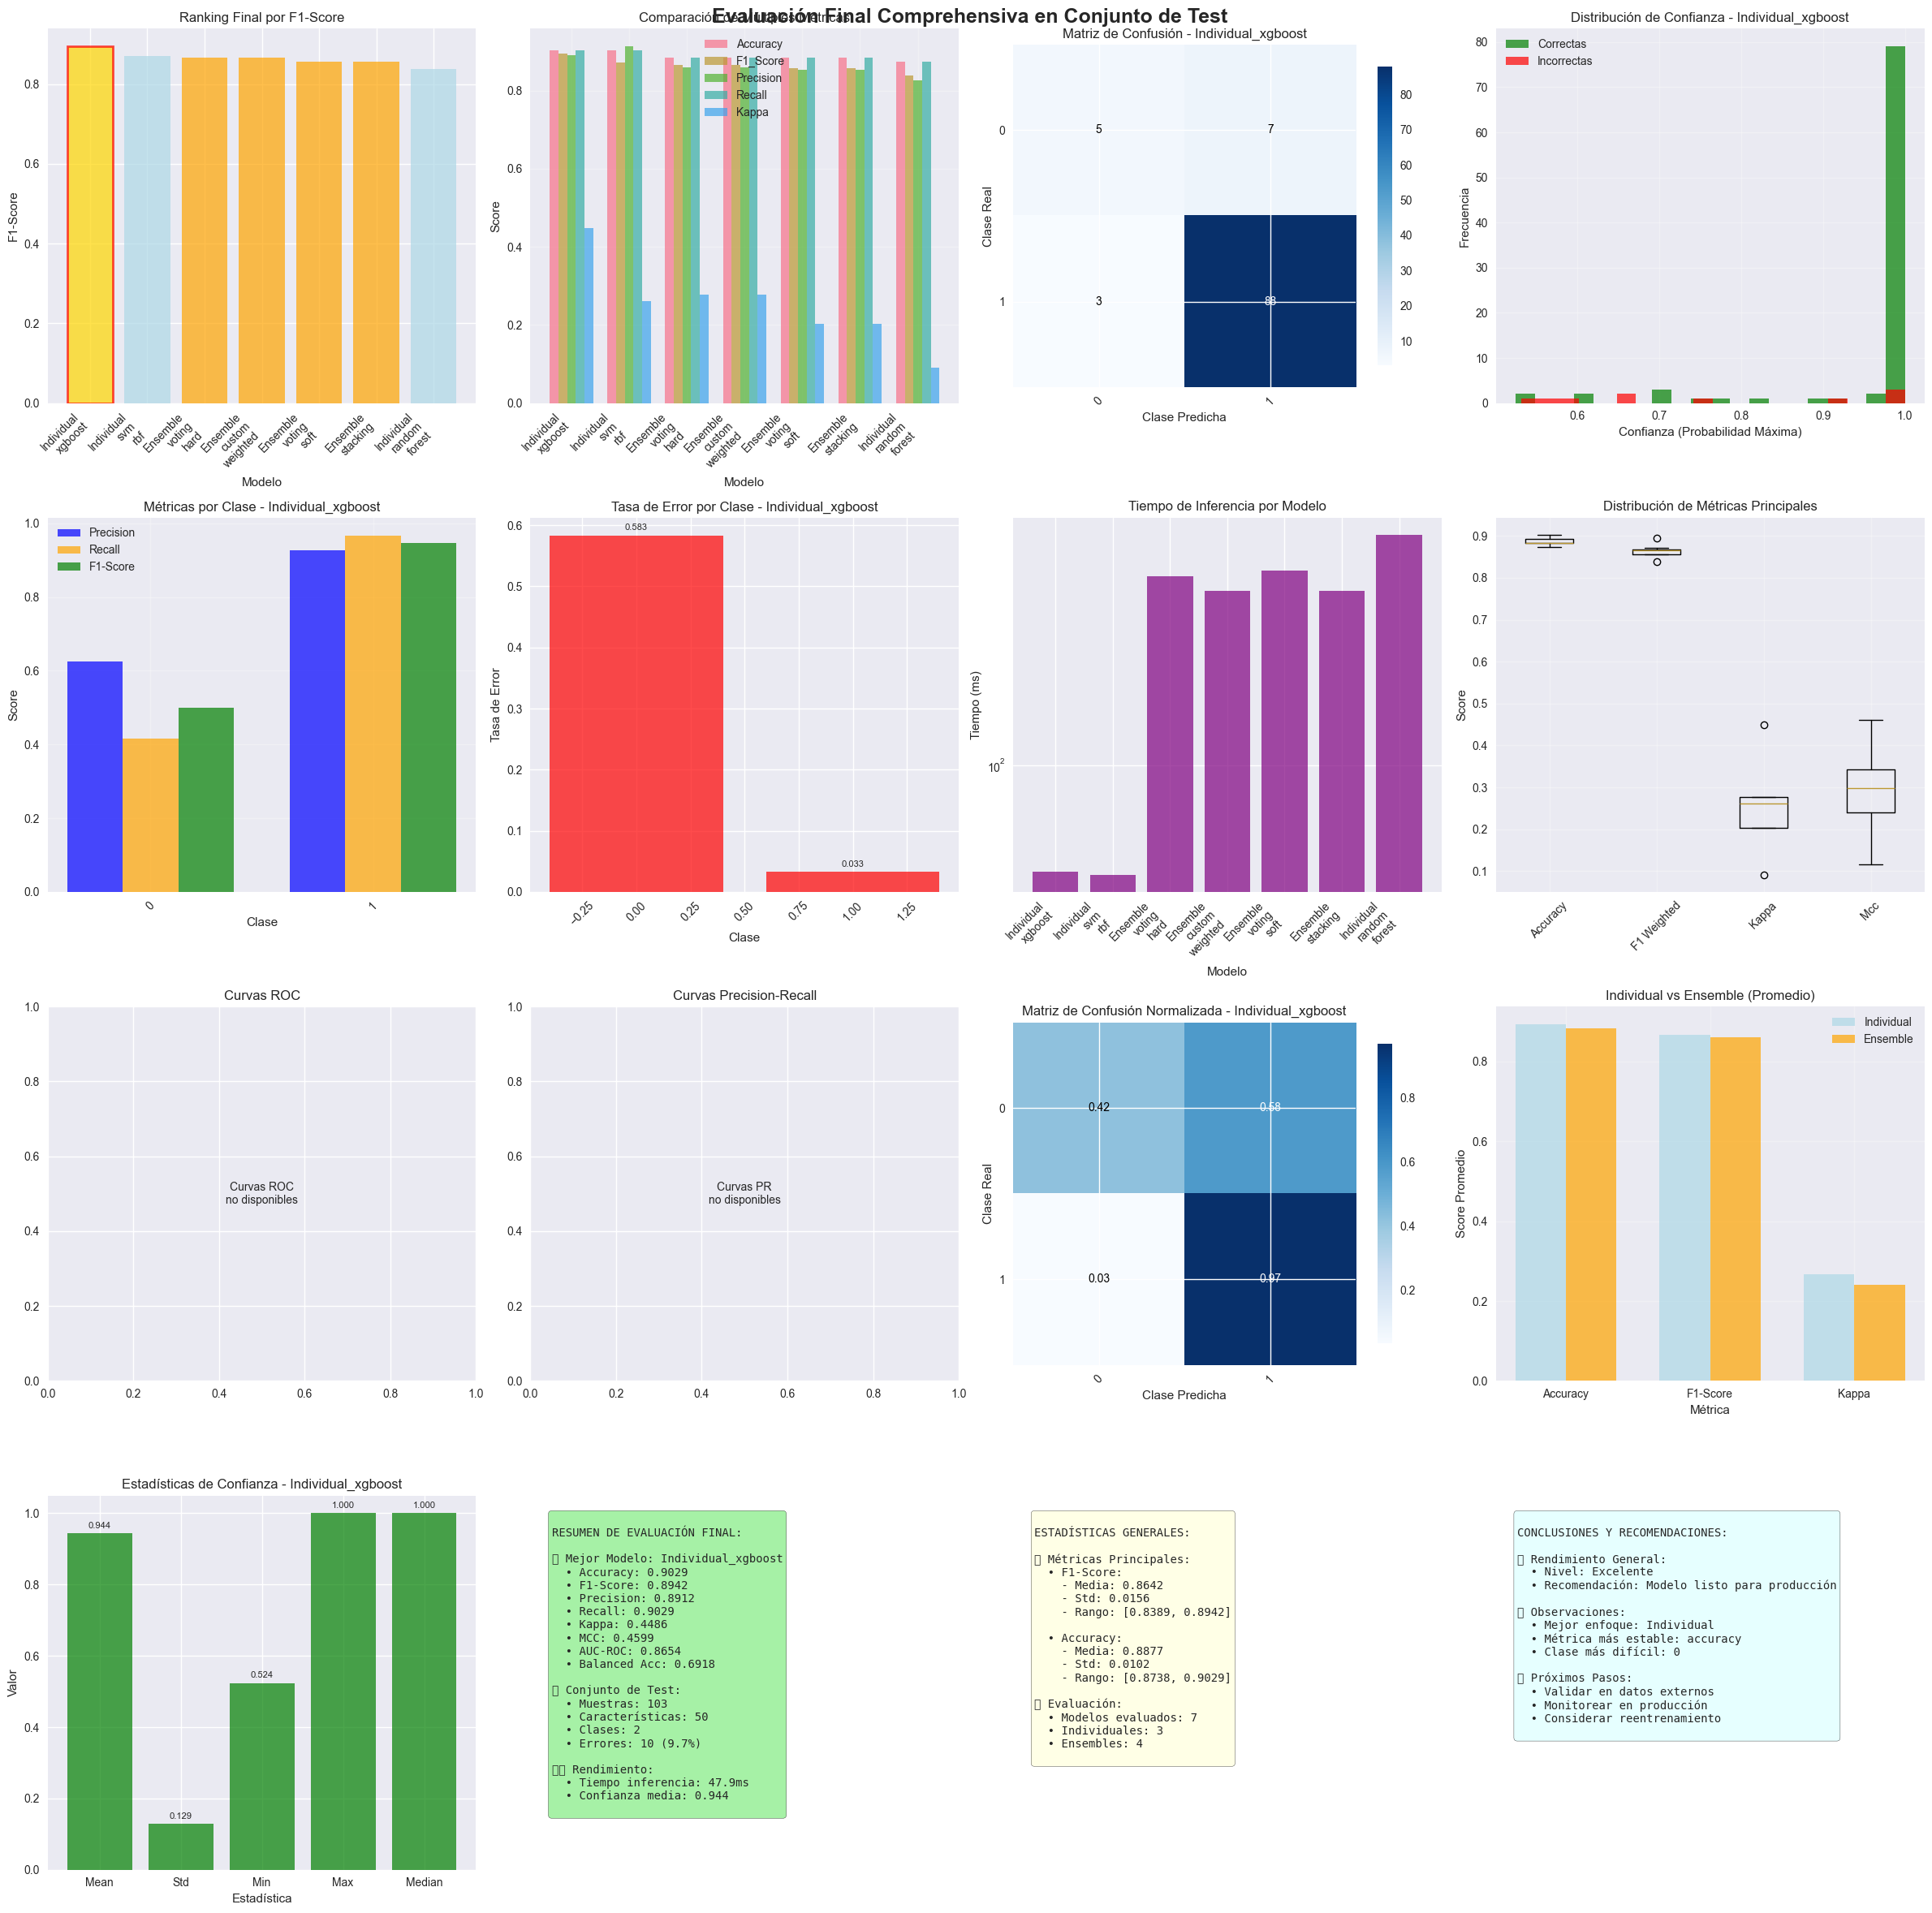

2025-08-07 22:53:33,100 - INFO - Evaluación final comprehensiva completada exitosamente



✓ Resultados de evaluación final guardados en: ./resultados/final_evaluation_results.pkl
✓ Mejor modelo final guardado en: ./modelos/best_final_model.pkl


In [15]:
from sklearn.metrics import auc, balanced_accuracy_score


def final_evaluation_comprehensive(individual_models_results, ensemble_results, data_split_results, config):
    """
    Evaluación final comprehensiva en conjunto de test con métricas avanzadas
    
    Args:
        individual_models_results: Resultados de modelos individuales
        ensemble_results: Resultados de modelos de ensemble
        data_split_results: Resultados de división de datos
        config: Configuración del proyecto
    
    Returns:
        final_evaluation_results: Diccionario con evaluación final completa
    """
    
    print("="*60)
    print("EVALUACIÓN FINAL COMPREHENSIVA EN CONJUNTO DE TEST")
    print("="*60)
    
    logger.info("Iniciando evaluación final en conjunto de test")
    
    # ===== EXTRAER DATOS DE TEST =====
    main_split = data_split_results['main_split']
    
    X_test = main_split['X_test']
    y_test = main_split['y_test']
    class_names = data_split_results['class_info']['class_names']
    
    print(f"📊 Conjunto de test:")
    print(f"  Muestras: {X_test.shape[0]}")
    print(f"  Características: {X_test.shape[1]}")
    print(f"  Clases: {len(class_names)}")
    
    # Distribución de clases en test
    unique_test, counts_test = np.unique(y_test, return_counts=True)
    print(f"  Distribución de clases en test:")
    for class_idx, count in zip(unique_test, counts_test):
        class_name = class_names[class_idx]
        percentage = count / len(y_test) * 100
        print(f"    {class_name}: {count} ({percentage:.1f}%)")
    
    # ===== SELECCIONAR MODELOS PARA EVALUACIÓN FINAL =====
    print(f"\n🎯 Seleccionando modelos para evaluación final...")
    
    models_to_evaluate = {}
    
    # Mejor modelo individual
    best_individual_name = individual_models_results['best_model_name']
    best_individual_model = individual_models_results['best_model']
    models_to_evaluate[f"Individual_{best_individual_name}"] = best_individual_model
    
    # Top 3 modelos individuales (por test_f1)
    individual_model_names = [k for k in individual_models_results.keys() if k not in ['best_model_name', 'best_model', 'best_model_results']]
    # Calcular top-3 por test_f1
    top_3_individual = sorted(
        individual_model_names,
        key=lambda name: individual_models_results[name]['test_f1'],
        reverse=True
    )[:3]

    for model_name in top_3_individual:
        if model_name != best_individual_name:  # Evitar duplicados
            model = individual_models_results[model_name]['model']
            models_to_evaluate[f"Individual_{model_name}"] = model
    
    # Modelos de ensemble (si existen)
    if ensemble_results['ensemble_models']:
        for ensemble_name, ensemble_model in ensemble_results['ensemble_models'].items():
            models_to_evaluate[f"Ensemble_{ensemble_name}"] = ensemble_model
    
    print(f"  Modelos seleccionados para evaluación final: {len(models_to_evaluate)}")
    for model_name in models_to_evaluate.keys():
        print(f"    - {model_name}")
    
    # ===== FUNCIÓN PARA EVALUACIÓN DETALLADA =====
    def evaluate_model_comprehensive(model, model_name, X_test, y_test):
        """Evaluación comprehensiva de un modelo en el conjunto de test"""
        
        print(f"\n  Evaluando {model_name}...")
        
        try:
            # ===== PREDICCIONES =====
            start_time = time.time()
            y_pred = model.predict(X_test)
            inference_time = time.time() - start_time
            
            # Probabilidades (si están disponibles)
            y_proba = None
            if hasattr(model, 'predict_proba'):
                y_proba = model.predict_proba(X_test)
            elif hasattr(model, 'decision_function'):
                decision_scores = model.decision_function(X_test)
                if len(decision_scores.shape) == 1:  # Binario
                    y_proba = np.column_stack([1 - decision_scores, decision_scores])
                else:  # Multiclase
                    y_proba = decision_scores
            
            # ===== MÉTRICAS BÁSICAS =====
            accuracy = accuracy_score(y_test, y_pred)
            precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
            
            # Métricas por clase
            precision_per_class = precision_score(y_test, y_pred, average=None, zero_division=0)
            recall_per_class = recall_score(y_test, y_pred, average=None, zero_division=0)
            f1_per_class = f1_score(y_test, y_pred, average=None, zero_division=0)
            support_per_class = np.bincount(y_test, minlength=len(class_names))
            
            # ===== MÉTRICAS AVANZADAS =====
            # Kappa de Cohen
            kappa = cohen_kappa_score(y_test, y_pred)
            
            # Matthews Correlation Coefficient
            mcc = matthews_corrcoef(y_test, y_pred)
            
            # AUC-ROC
            auc_roc = None
            if y_proba is not None:
                try:
                    if len(np.unique(y_test)) == 2:
                        auc_roc = roc_auc_score(y_test, y_proba[:, 1])
                    else:
                        auc_roc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
                except:
                    auc_roc = None
            
            # AUC-PR (Area Under Precision-Recall Curve)
            auc_pr = None
            if y_proba is not None:
                try:
                    if len(np.unique(y_test)) == 2:
                        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba[:, 1])
                        auc_pr = auc(recall_curve, precision_curve)
                    else:
                        # Para multiclase, promedio de AUC-PR por clase
                        auc_pr_per_class = []
                        for i in range(len(class_names)):
                            if i in y_test:  # Solo si la clase existe en test
                                y_test_binary = (y_test == i).astype(int)
                                if len(np.unique(y_test_binary)) == 2:  # Solo si hay ambas clases
                                    precision_curve, recall_curve, _ = precision_recall_curve(
                                        y_test_binary, y_proba[:, i]
                                    )
                                    auc_pr_class = auc(recall_curve, precision_curve)
                                    auc_pr_per_class.append(auc_pr_class)
                        
                        if auc_pr_per_class:
                            auc_pr = np.mean(auc_pr_per_class)
                except:
                    auc_pr = None
            
            # Balanced Accuracy
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
            
            # Top-k Accuracy (si hay probabilidades)
            top_k_accuracy = None
            if y_proba is not None and len(class_names) > 2:
                try:
                    k = min(3, len(class_names))  # Top-3 o menos si hay pocas clases
                    top_k_predictions = np.argsort(y_proba, axis=1)[:, -k:]
                    top_k_correct = np.any(top_k_predictions == y_test.reshape(-1, 1), axis=1)
                    top_k_accuracy = np.mean(top_k_correct)
                except:
                    top_k_accuracy = None
            
            # ===== MATRIZ DE CONFUSIÓN =====
            conf_matrix = confusion_matrix(y_test, y_pred)
            
            # Matriz de confusión normalizada
            conf_matrix_norm = confusion_matrix(y_test, y_pred, normalize='true')
            
            # ===== ANÁLISIS DE ERRORES =====
            # Identificar muestras mal clasificadas
            misclassified_indices = np.where(y_test != y_pred)[0]
            misclassified_count = len(misclassified_indices)
            misclassified_percentage = (misclassified_count / len(y_test)) * 100
            
            # Análisis de errores por clase
            error_analysis = {}
            for class_idx in range(len(class_names)):
                class_name = class_names[class_idx]
                
                # Muestras reales de esta clase
                true_class_mask = (y_test == class_idx)
                true_class_count = np.sum(true_class_mask)
                
                if true_class_count > 0:
                    # Predicciones correctas para esta clase
                    correct_predictions = np.sum((y_test == class_idx) & (y_pred == class_idx))
                    
                    # Errores: esta clase predicha como otras
                    false_negatives = true_class_count - correct_predictions
                    
                    # Errores: otras clases predichas como esta
                    false_positives = np.sum((y_test != class_idx) & (y_pred == class_idx))
                    
                    error_analysis[class_name] = {
                        'true_count': true_class_count,
                        'correct_predictions': correct_predictions,
                        'false_negatives': false_negatives,
                        'false_positives': false_positives,
                        'class_accuracy': correct_predictions / true_class_count if true_class_count > 0 else 0
                    }
            
            # ===== CONFIANZA EN PREDICCIONES =====
            prediction_confidence = None
            confidence_stats = None
            
            if y_proba is not None:
                # Confianza como probabilidad máxima
                max_probabilities = np.max(y_proba, axis=1)
                prediction_confidence = max_probabilities
                
                confidence_stats = {
                    'mean_confidence': np.mean(max_probabilities),
                    'std_confidence': np.std(max_probabilities),
                    'min_confidence': np.min(max_probabilities),
                    'max_confidence': np.max(max_probabilities),
                    'median_confidence': np.median(max_probabilities)
                }
                
                # Confianza para predicciones correctas vs incorrectas
                correct_mask = (y_test == y_pred)
                confidence_stats['mean_confidence_correct'] = np.mean(max_probabilities[correct_mask])
                confidence_stats['mean_confidence_incorrect'] = np.mean(max_probabilities[~correct_mask])
            
            # ===== COMPILAR RESULTADOS =====
            evaluation_results = {
                'model_name': model_name,
                'model': model,
                
                # Predicciones
                'y_pred': y_pred,
                'y_proba': y_proba,
                'inference_time': inference_time,
                
                # Métricas básicas
                'accuracy': accuracy,
                'precision_weighted': precision_weighted,
                'recall_weighted': recall_weighted,
                'f1_weighted': f1_weighted,
                'precision_per_class': precision_per_class,
                'recall_per_class': recall_per_class,
                'f1_per_class': f1_per_class,
                'support_per_class': support_per_class,
                
                # Métricas avanzadas
                'kappa': kappa,
                'mcc': mcc,
                'auc_roc': auc_roc,
                'auc_pr': auc_pr,
                'balanced_accuracy': balanced_accuracy,
                'top_k_accuracy': top_k_accuracy,
                
                # Matrices de confusión
                'confusion_matrix': conf_matrix,
                'confusion_matrix_normalized': conf_matrix_norm,
                
                # Análisis de errores
                'misclassified_count': misclassified_count,
                'misclassified_percentage': misclassified_percentage,
                'misclassified_indices': misclassified_indices,
                'error_analysis_per_class': error_analysis,
                
                # Confianza
                'prediction_confidence': prediction_confidence,
                'confidence_stats': confidence_stats
            }
            
            print(f"    Accuracy: {accuracy:.4f}")
            print(f"    F1-Score: {f1_weighted:.4f}")
            print(f"    Kappa: {kappa:.4f}")
            print(f"    MCC: {mcc:.4f}")
            if auc_roc:
                print(f"    AUC-ROC: {auc_roc:.4f}")
            print(f"    Balanced Accuracy: {balanced_accuracy:.4f}")
            print(f"    Errores: {misclassified_count}/{len(y_test)} ({misclassified_percentage:.1f}%)")
            
            return evaluation_results
            
        except Exception as e:
            print(f"    ❌ Error evaluando {model_name}: {e}")
            logger.error(f"Error evaluando {model_name}: {e}")
            return None
    
    # ===== EVALUAR TODOS LOS MODELOS =====
    print(f"\n🔄 Evaluando todos los modelos en conjunto de test...")
    
    final_results = {}
    successful_evaluations = 0
    
    for model_name, model in models_to_evaluate.items():
        try:
            evaluation_result = evaluate_model_comprehensive(model, model_name, X_test, y_test)
            if evaluation_result is not None:
                final_results[model_name] = evaluation_result
                successful_evaluations += 1
        except Exception as e:
            print(f"  ❌ Error evaluando {model_name}: {e}")
    
    print(f"\n📊 Evaluaciones completadas: {successful_evaluations}/{len(models_to_evaluate)}")
    
    if successful_evaluations == 0:
        raise ValueError("No se pudo evaluar ningún modelo en el conjunto de test")
    
    # ===== RANKING FINAL DE MODELOS =====
    print(f"\n🏆 Ranking final de modelos en conjunto de test...")
    
    # Crear tabla comparativa final
    final_comparison = []
    for model_name, results in final_results.items():
        final_comparison.append({
            'Model': model_name,
            'Type': 'Ensemble' if 'Ensemble' in model_name else 'Individual',
            'Accuracy': results['accuracy'],
            'F1_Score': results['f1_weighted'],
            'Precision': results['precision_weighted'],
            'Recall': results['recall_weighted'],
            'Kappa': results['kappa'],
            'MCC': results['mcc'],
            'AUC_ROC': results['auc_roc'] if results['auc_roc'] else 0,
            'AUC_PR': results['auc_pr'] if results['auc_pr'] else 0,
            'Balanced_Accuracy': results['balanced_accuracy'],
            'Top_K_Accuracy': results['top_k_accuracy'] if results['top_k_accuracy'] else 0,
            'Inference_Time': results['inference_time'],
            'Error_Rate': results['misclassified_percentage']
        })
    
    final_comparison_df = pd.DataFrame(final_comparison)
    
    # Ordenar por F1-score
    final_comparison_df = final_comparison_df.sort_values('F1_Score', ascending=False)
    
    print(f"\n📋 Tabla comparativa final:")
    print(final_comparison_df.round(4))
    
    # Identificar mejor modelo final
    best_final_model_name = final_comparison_df.iloc[0]['Model']
    best_final_results = final_results[best_final_model_name]
    
    print(f"\n🥇 Mejor modelo final: {best_final_model_name}")
    print(f"  F1-Score: {best_final_results['f1_weighted']:.4f}")
    print(f"  Accuracy: {best_final_results['accuracy']:.4f}")
    print(f"  Kappa: {best_final_results['kappa']:.4f}")
    print(f"  MCC: {best_final_results['mcc']:.4f}")
    if best_final_results['auc_roc']:
        print(f"  AUC-ROC: {best_final_results['auc_roc']:.4f}")
    
    # ===== ANÁLISIS ESTADÍSTICO =====
    print(f"\n📈 Análisis estadístico de resultados...")
    
    # Estadísticas descriptivas
    metrics_stats = {}
    for metric in ['accuracy', 'f1_weighted', 'kappa', 'mcc']:
        values = [results[metric] for results in final_results.values()]
        metrics_stats[metric] = {
            'mean': np.mean(values),
            'std': np.std(values),
            'min': np.min(values),
            'max': np.max(values),
            'median': np.median(values),
            'range': np.max(values) - np.min(values)
        }
    
    print(f"  Estadísticas de métricas principales:")
    for metric, stats in metrics_stats.items():
        print(f"    {metric.upper()}:")
        print(f"      Media: {stats['mean']:.4f} ± {stats['std']:.4f}")
        print(f"      Rango: [{stats['min']:.4f}, {stats['max']:.4f}]")
        print(f"      Mediana: {stats['median']:.4f}")
    
    # Comparación Individual vs Ensemble
    individual_results = [results for name, results in final_results.items() if 'Individual' in name]
    ensemble_results_list = [results for name, results in final_results.items() if 'Ensemble' in name]
    
    if individual_results and ensemble_results_list:
        individual_f1_mean = np.mean([r['f1_weighted'] for r in individual_results])
        ensemble_f1_mean = np.mean([r['f1_weighted'] for r in ensemble_results_list])
        
        print(f"\n  Comparación Individual vs Ensemble:")
        print(f"    F1-Score promedio Individual: {individual_f1_mean:.4f}")
        print(f"    F1-Score promedio Ensemble: {ensemble_f1_mean:.4f}")
        print(f"    Mejora promedio Ensemble: {((ensemble_f1_mean - individual_f1_mean) / individual_f1_mean * 100):+.2f}%")
    
    # ===== CREAR VISUALIZACIONES COMPREHENSIVAS =====
    print(f"\n📊 Generando visualizaciones de evaluación final...")
    
    fig, axes = plt.subplots(4, 4, figsize=(24, 24))
    fig.suptitle('Evaluación Final Comprehensiva en Conjunto de Test', fontsize=18, fontweight='bold')
    
    # 1. Ranking de modelos por F1-Score
    ax1 = axes[0, 0]
    
    model_names_plot = final_comparison_df['Model'].tolist()
    f1_scores_plot = final_comparison_df['F1_Score'].tolist()
    colors = ['orange' if 'Ensemble' in name else 'lightblue' for name in model_names_plot]
    
    bars = ax1.bar(range(len(model_names_plot)), f1_scores_plot, color=colors, alpha=0.7)
    ax1.set_title('Ranking Final por F1-Score')
    ax1.set_xlabel('Modelo')
    ax1.set_ylabel('F1-Score')
    ax1.set_xticks(range(len(model_names_plot)))
    ax1.set_xticklabels([name.replace('_', '\n') for name in model_names_plot], rotation=45, ha='right')
    
    # Destacar el mejor
    bars[0].set_color('gold')
    bars[0].set_edgecolor('red')
    bars[0].set_linewidth(2)
    
    # 2. Múltiples métricas comparación
    ax2 = axes[0, 1]
    
    metrics_to_plot = ['Accuracy', 'F1_Score', 'Precision', 'Recall', 'Kappa']
    x = np.arange(len(model_names_plot))
    width = 0.15
    
    for i, metric in enumerate(metrics_to_plot):
        values = final_comparison_df[metric].tolist()
        ax2.bar(x + i*width, values, width, label=metric, alpha=0.7)
    
    ax2.set_title('Comparación de Múltiples Métricas')
    ax2.set_xlabel('Modelo')
    ax2.set_ylabel('Score')
    ax2.set_xticks(x + width * 2)
    ax2.set_xticklabels([name.replace('_', '\n') for name in model_names_plot], rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Matriz de confusión del mejor modelo
    ax3 = axes[0, 2]
    
    best_conf_matrix = best_final_results['confusion_matrix']
    
    im = ax3.imshow(best_conf_matrix, interpolation='nearest', cmap='Blues')
    ax3.set_title(f'Matriz de Confusión - {best_final_model_name}')
    
    tick_marks = np.arange(len(class_names))
    ax3.set_xticks(tick_marks)
    ax3.set_yticks(tick_marks)
    ax3.set_xticklabels(class_names, rotation=45)
    ax3.set_yticklabels(class_names)
    
    # Añadir valores
    thresh = best_conf_matrix.max() / 2.
    for i, j in np.ndindex(best_conf_matrix.shape):
        ax3.text(j, i, format(best_conf_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if best_conf_matrix[i, j] > thresh else "black")
    
    ax3.set_ylabel('Clase Real')
    ax3.set_xlabel('Clase Predicha')
    plt.colorbar(im, ax=ax3, shrink=0.8)
    
    # 4. Distribución de confianza en predicciones
    ax4 = axes[0, 3]
    
    if best_final_results['prediction_confidence'] is not None:
        confidence_scores = best_final_results['prediction_confidence']
        correct_mask = (y_test == best_final_results['y_pred'])
        
        ax4.hist(confidence_scores[correct_mask], bins=20, alpha=0.7, label='Correctas', color='green')
        ax4.hist(confidence_scores[~correct_mask], bins=20, alpha=0.7, label='Incorrectas', color='red')
        
        ax4.set_title(f'Distribución de Confianza - {best_final_model_name}')
        ax4.set_xlabel('Confianza (Probabilidad Máxima)')
        ax4.set_ylabel('Frecuencia')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'Confianza no\ndisponible', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Distribución de Confianza')
    
    # 5. Métricas por clase (mejor modelo)
    ax5 = axes[1, 0]
    
    precision_per_class = best_final_results['precision_per_class']
    recall_per_class = best_final_results['recall_per_class']
    f1_per_class = best_final_results['f1_per_class']
    
    x = np.arange(len(class_names))
    width = 0.25
    
    ax5.bar(x - width, precision_per_class, width, label='Precision', alpha=0.7, color='blue')
    ax5.bar(x, recall_per_class, width, label='Recall', alpha=0.7, color='orange')
    ax5.bar(x + width, f1_per_class, width, label='F1-Score', alpha=0.7, color='green')
    
    ax5.set_title(f'Métricas por Clase - {best_final_model_name}')
    ax5.set_xlabel('Clase')
    ax5.set_ylabel('Score')
    ax5.set_xticks(x)
    ax5.set_xticklabels(class_names, rotation=45)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Análisis de errores por clase
    ax6 = axes[1, 1]
    
    error_analysis = best_final_results['error_analysis_per_class']
    class_accuracies = [error_analysis[class_name]['class_accuracy'] for class_name in class_names]
    error_rates = [1 - acc for acc in class_accuracies]
    
    bars = ax6.bar(class_names, error_rates, alpha=0.7, color='red')
    ax6.set_title(f'Tasa de Error por Clase - {best_final_model_name}')
    ax6.set_xlabel('Clase')
    ax6.set_ylabel('Tasa de Error')
    ax6.tick_params(axis='x', rotation=45)
    
    # Añadir etiquetas
    for bar, rate in zip(bars, error_rates):
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(error_rates)*0.01,
                f'{rate:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 7. Comparación de tiempos de inferencia
    ax7 = axes[1, 2]
    
    inference_times = final_comparison_df['Inference_Time'].tolist()
    inference_times_ms = [t * 1000 for t in inference_times]  # Convertir a ms
    
    bars = ax7.bar(range(len(model_names_plot)), inference_times_ms, alpha=0.7, color='purple')
    ax7.set_title('Tiempo de Inferencia por Modelo')
    ax7.set_xlabel('Modelo')
    ax7.set_ylabel('Tiempo (ms)')
    ax7.set_xticks(range(len(model_names_plot)))
    ax7.set_xticklabels([name.replace('_', '\n') for name in model_names_plot], rotation=45, ha='right')
    ax7.set_yscale('log')
    
    # 8. Distribución de métricas
    ax8 = axes[1, 3]
    
    # Boxplot de métricas principales
    metrics_data = []
    metric_labels = []
    
    for metric in ['accuracy', 'f1_weighted', 'kappa', 'mcc']:
        values = [results[metric] for results in final_results.values()]
        metrics_data.append(values)
        metric_labels.append(metric.replace('_', ' ').title())
    
    bp = ax8.boxplot(metrics_data, labels=metric_labels)
    ax8.set_title('Distribución de Métricas Principales')
    ax8.set_ylabel('Score')
    ax8.tick_params(axis='x', rotation=45)
    ax8.grid(True, alpha=0.3)
    
    # 9. Curvas ROC (si están disponibles)
    ax9 = axes[2, 0]
    
    if best_final_results['y_proba'] is not None and len(np.unique(y_test)) > 2:
        try:
            from sklearn.preprocessing import label_binarize
            
            y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
            n_classes = y_test_bin.shape[1]
            
            # Mostrar curvas ROC para las primeras 3 clases
            for i in range(min(3, n_classes)):
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], best_final_results['y_proba'][:, i])
                roc_auc = auc(fpr, tpr)
                ax9.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
            
            ax9.plot([0, 1], [0, 1], 'k--', alpha=0.5)
            ax9.set_xlim([0.0, 1.0])
            ax9.set_ylim([0.0, 1.05])
            ax9.set_xlabel('Tasa de Falsos Positivos')
            ax9.set_ylabel('Tasa de Verdaderos Positivos')
            ax9.set_title(f'Curvas ROC - {best_final_model_name}')
            ax9.legend()
            ax9.grid(True, alpha=0.3)
            
        except Exception as e:
            ax9.text(0.5, 0.5, f'Error generando\ncurvas ROC', ha='center', va='center', transform=ax9.transAxes)
            ax9.set_title('Curvas ROC')
    else:
        ax9.text(0.5, 0.5, 'Curvas ROC\nno disponibles', ha='center', va='center', transform=ax9.transAxes)
        ax9.set_title('Curvas ROC')
    
    # 10. Curvas Precision-Recall
    ax10 = axes[2, 1]
    
    if best_final_results['y_proba'] is not None and len(np.unique(y_test)) > 2:
        try:
            from sklearn.preprocessing import label_binarize
            
            y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
            n_classes = y_test_bin.shape[1]
            
            # Mostrar curvas PR para las primeras 3 clases
            for i in range(min(3, n_classes)):
                if i in y_test:  # Solo si la clase existe en test
                    precision_curve, recall_curve, _ = precision_recall_curve(
                        y_test_bin[:, i], best_final_results['y_proba'][:, i]
                    )
                    pr_auc = auc(recall_curve, precision_curve)
                    ax10.plot(recall_curve, precision_curve, label=f'{class_names[i]} (AUC = {pr_auc:.2f})')
            
            ax10.set_xlim([0.0, 1.0])
            ax10.set_ylim([0.0, 1.05])
            ax10.set_xlabel('Recall')
            ax10.set_ylabel('Precision')
            ax10.set_title(f'Curvas Precision-Recall - {best_final_model_name}')
            ax10.legend()
            ax10.grid(True, alpha=0.3)
            
        except Exception as e:
            ax10.text(0.5, 0.5, f'Error generando\ncurvas PR', ha='center', va='center', transform=ax10.transAxes)
            ax10.set_title('Curvas Precision-Recall')
    else:
        ax10.text(0.5, 0.5, 'Curvas PR\nno disponibles', ha='center', va='center', transform=ax10.transAxes)
        ax10.set_title('Curvas Precision-Recall')
    
    # 11. Matriz de confusión normalizada
    ax11 = axes[2, 2]
    
    best_conf_matrix_norm = best_final_results['confusion_matrix_normalized']
    
    im = ax11.imshow(best_conf_matrix_norm, interpolation='nearest', cmap='Blues')
    ax11.set_title(f'Matriz de Confusión Normalizada - {best_final_model_name}')
    
    tick_marks = np.arange(len(class_names))
    ax11.set_xticks(tick_marks)
    ax11.set_yticks(tick_marks)
    ax11.set_xticklabels(class_names, rotation=45)
    ax11.set_yticklabels(class_names)
    
    # Añadir valores
    thresh = best_conf_matrix_norm.max() / 2.
    for i, j in np.ndindex(best_conf_matrix_norm.shape):
        ax11.text(j, i, format(best_conf_matrix_norm[i, j], '.2f'),
                 ha="center", va="center",
                 color="white" if best_conf_matrix_norm[i, j] > thresh else "black")
    
    ax11.set_ylabel('Clase Real')
    ax11.set_xlabel('Clase Predicha')
    plt.colorbar(im, ax=ax11, shrink=0.8)
    
    # 12. Comparación Individual vs Ensemble
    ax12 = axes[2, 3]
    
    if individual_results and ensemble_results_list:
        individual_metrics = {
            'Accuracy': [r['accuracy'] for r in individual_results],
            'F1-Score': [r['f1_weighted'] for r in individual_results],
            'Kappa': [r['kappa'] for r in individual_results]
        }
        
        ensemble_metrics = {
            'Accuracy': [r['accuracy'] for r in ensemble_results_list],
            'F1-Score': [r['f1_weighted'] for r in ensemble_results_list],
            'Kappa': [r['kappa'] for r in ensemble_results_list]
        }
        
        metrics_names = list(individual_metrics.keys())
        individual_means = [np.mean(individual_metrics[m]) for m in metrics_names]
        ensemble_means = [np.mean(ensemble_metrics[m]) for m in metrics_names]
        
        x = np.arange(len(metrics_names))
        width = 0.35
        
        ax12.bar(x - width/2, individual_means, width, label='Individual', alpha=0.7, color='lightblue')
        ax12.bar(x + width/2, ensemble_means, width, label='Ensemble', alpha=0.7, color='orange')
        
        ax12.set_title('Individual vs Ensemble (Promedio)')
        ax12.set_xlabel('Métrica')
        ax12.set_ylabel('Score Promedio')
        ax12.set_xticks(x)
        ax12.set_xticklabels(metrics_names)
        ax12.legend()
        ax12.grid(True, alpha=0.3)
    else:
        ax12.text(0.5, 0.5, 'Comparación\nno disponible', ha='center', va='center', transform=ax12.transAxes)
        ax12.set_title('Individual vs Ensemble')
    
    # 13. Estadísticas de confianza
    ax13 = axes[3, 0]
    
    if best_final_results['confidence_stats']:
        conf_stats = best_final_results['confidence_stats']
        
        stats_names = ['Mean', 'Std', 'Min', 'Max', 'Median']
        stats_values = [
            conf_stats['mean_confidence'],
            conf_stats['std_confidence'],
            conf_stats['min_confidence'],
            conf_stats['max_confidence'],
            conf_stats['median_confidence']
        ]
        
        bars = ax13.bar(stats_names, stats_values, alpha=0.7, color='green')
        ax13.set_title(f'Estadísticas de Confianza - {best_final_model_name}')
        ax13.set_xlabel('Estadística')
        ax13.set_ylabel('Valor')
        
        # Añadir etiquetas
        for bar, value in zip(bars, stats_values):
            ax13.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(stats_values)*0.01,
                     f'{value:.3f}', ha='center', va='bottom', fontsize=8)
    else:
        ax13.text(0.5, 0.5, 'Estadísticas de\nconfianza no\ndisponibles', 
                 ha='center', va='center', transform=ax13.transAxes)
        ax13.set_title('Estadísticas de Confianza')
    
    # 14. Resumen de rendimiento
    ax14 = axes[3, 1]
    ax14.axis('off')
    
    summary_text = f"""
RESUMEN DE EVALUACIÓN FINAL:

🏆 Mejor Modelo: {best_final_model_name}
  • Accuracy: {best_final_results['accuracy']:.4f}
  • F1-Score: {best_final_results['f1_weighted']:.4f}
  • Precision: {best_final_results['precision_weighted']:.4f}
  • Recall: {best_final_results['recall_weighted']:.4f}
  • Kappa: {best_final_results['kappa']:.4f}
  • MCC: {best_final_results['mcc']:.4f}
  • AUC-ROC: {f"{best_final_results['auc_roc']:.4f}" if best_final_results['auc_roc'] is not None else 'N/A'}
  • Balanced Acc: {best_final_results['balanced_accuracy']:.4f}

📊 Conjunto de Test:
  • Muestras: {len(y_test)}
  • Características: {X_test.shape[1]}
  • Clases: {len(class_names)}
  • Errores: {best_final_results['misclassified_count']} ({best_final_results['misclassified_percentage']:.1f}%)

⏱️ Rendimiento:
  • Tiempo inferencia: {best_final_results['inference_time']*1000:.1f}ms
  • Confianza media: {f"{best_final_results['confidence_stats']['mean_confidence']:.3f}" if best_final_results['confidence_stats'] else 'N/A'}
    """
    
    ax14.text(0.05, 0.95, summary_text, transform=ax14.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    # 15. Estadísticas generales
    ax15 = axes[3, 2]
    ax15.axis('off')
    
    stats_text = f"""
ESTADÍSTICAS GENERALES:

📈 Métricas Principales:
  • F1-Score:
    - Media: {metrics_stats['f1_weighted']['mean']:.4f}
    - Std: {metrics_stats['f1_weighted']['std']:.4f}
    - Rango: [{metrics_stats['f1_weighted']['min']:.4f}, {metrics_stats['f1_weighted']['max']:.4f}]
  
  • Accuracy:
    - Media: {metrics_stats['accuracy']['mean']:.4f}
    - Std: {metrics_stats['accuracy']['std']:.4f}
    - Rango: [{metrics_stats['accuracy']['min']:.4f}, {metrics_stats['accuracy']['max']:.4f}]

🔍 Evaluación:
  • Modelos evaluados: {successful_evaluations}
  • Individuales: {len(individual_results)}
  • Ensembles: {len(ensemble_results_list)}
    """
    
    ax15.text(0.05, 0.95, stats_text, transform=ax15.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    # 16. Conclusiones y recomendaciones
    ax16 = axes[3, 3]
    ax16.axis('off')
    
    # Determinar recomendaciones basadas en resultados
    if best_final_results['f1_weighted'] >= 0.85:
        performance_level = "Excelente"
        recommendation = "Modelo listo para producción"
    elif best_final_results['f1_weighted'] >= 0.75:
        performance_level = "Bueno"
        recommendation = "Considerar mejoras adicionales"
    elif best_final_results['f1_weighted'] >= 0.65:
        performance_level = "Aceptable"
        recommendation = "Requiere optimización"
    else:
        performance_level = "Insuficiente"
        recommendation = "Revisar datos y metodología"
    
    conclusions_text = f"""
CONCLUSIONES Y RECOMENDACIONES:

🎯 Rendimiento General:
  • Nivel: {performance_level}
  • Recomendación: {recommendation}

🔍 Observaciones:
  • Mejor enfoque: {'Ensemble' if 'Ensemble' in best_final_model_name else 'Individual'}
  • Métrica más estable: {max(metrics_stats.keys(), key=lambda x: 1/metrics_stats[x]['std'])}
  • Clase más difícil: {class_names[np.argmin(best_final_results['f1_per_class'])]}

💡 Próximos Pasos:
  • Validar en datos externos
  • Monitorear en producción
  • Considerar reentrenamiento
    """
    
    ax16.text(0.05, 0.95, conclusions_text, transform=ax16.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))
    
    plt.tight_layout()
    
    # Guardar visualización
    if config['visualization']['save_plots']:
        plot_path = os.path.join(config['paths']['plots_folder'], 
                                f'final_evaluation_comprehensive.{config["visualization"]["plot_format"]}')
        plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
        print(f"  ✓ Visualización guardada en: {plot_path}")
    
    plt.show()
    
    # ===== COMPILAR RESULTADOS FINALES =====
    final_evaluation_results = {
        'final_results': final_results,
        'best_final_model_name': best_final_model_name,
        'best_final_model': best_final_results['model'],
        'best_final_results': best_final_results,
        'final_comparison_df': final_comparison_df,
        'metrics_statistics': metrics_stats,
        'test_data_info': {
            'n_samples': len(y_test),
            'n_features': X_test.shape[1],
            'n_classes': len(class_names),
            'class_names': class_names,
            'class_distribution': dict(zip(unique_test, counts_test))
        },
        'performance_analysis': {
            'performance_level': performance_level,
            'recommendation': recommendation,
            'best_approach': 'Ensemble' if 'Ensemble' in best_final_model_name else 'Individual',
            'most_stable_metric': max(metrics_stats.keys(), key=lambda x: 1/metrics_stats[x]['std']),
            'most_difficult_class': class_names[np.argmin(best_final_results['f1_per_class'])]
        }
    }
    
    # Guardar resultados
    final_eval_path = os.path.join(config['paths']['output_folder'], 'final_evaluation_results.pkl')
    with open(final_eval_path, 'wb') as f:
        pickle.dump(final_evaluation_results, f)
    
    print(f"\n✓ Resultados de evaluación final guardados en: {final_eval_path}")
    
    # Guardar mejor modelo final
    best_final_model_path = os.path.join(config['paths']['models_folder'], f'best_final_model.pkl')
    with open(best_final_model_path, 'wb') as f:
        pickle.dump(best_final_results['model'], f)
    
    print(f"✓ Mejor modelo final guardado en: {best_final_model_path}")
    
    logger.info("Evaluación final comprehensiva completada exitosamente")
    
    return final_evaluation_results

# ===== EJECUTAR EVALUACIÓN FINAL =====
final_evaluation_results = final_evaluation_comprehensive(resultados, ensemble_results, data_split_results, CONFIG)